In [1]:
%matplotlib inline

from flask import Flask, request, jsonify, Response, redirect, flash, make_response
from flask import render_template, url_for
from flask_cors import CORS, cross_origin

from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import sentinelhub
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, DataCollection, bbox_to_dimensions, geo_utils

import matplotlib.pyplot as plt
from matplotlib import cm

import io
import base64
from base64 import encodebytes
import os
import PIL.Image as Image
import numpy as np
from numpyencoder import NumpyEncoder
import pandas as pd
import math
import cv2

from scipy.signal import argrelextrema, resample
from scipy import interpolate

import json

from pyproj import Proj, transform
# Убираем warning бтблиотеки pyproj:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Принимаем запрос на обработку:

request_data = {'download_data': 'exist', 'name_sputnik': 'sentinel-1', 'type_relief': '2', 'contour_line_width': '2', 'sensitivity': '70', 'image_VV': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAPoA+gBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APD14pcAnIA9KvWMBOZCP9kHOAPxqYK4UHG7qcde9Ow7KFfjncqg9faoyzIxAUoMHHGSeKbE77gMgqOcnnFSLq/2OSQLbozAgoGyV6elRjVkmZmmQ7mOTjgD0xUzzoyEqwYDIG3pUMWWmKk4A6hvapXUueo247D/ADimFQRgISPY/wBKs2S9SG2lSOeh+ma0UVoomIUEgd/T/JqO4YxIwjY7gQNuRz2H1pqkOUB5IXOAfumnycRBwoGenOcjJ5qGaYRQgEEFjjnoRiqQdlYYC4J5z0rc03UrO1UxzSpFPncwYbQc9B6dhx71pw6/pEySQSlxIASgCrtJyOOM4BA6/TtXQWCr+6SN1RtgEsnmA7Rkksfp/QVYufF0en6nJA1iJSVA3KVZcMAfUZAJ7elLFrOmGKUS3D7QrKd0LbXfOeGHTG7PX06Vl6hqVreTQy2ryrmJo5FkQDO0gqFJ68Me/p9ThXdxdvfOkcspjY5Efbn+HpU51C2W0CfZ2Wfayuy44wMDnv8AzqqGgkhAOFIJUruGQc9fpUGWim2RAyK3yqAM9+QT27ce9aukaHby6rs1aC5toDnfswjJjjA3Dk5wOn8qqxKqRMn2aPMuA5kQEnHI4I4bI6jB5x0rev8ARSmmgQurBlXYq8A9T26DGfwrmL+3e1QEoJSWAAUjDZPY46Yq4qJbW8bBtp6DI6c84z9KxLu1EmoTsW8xd3Dc5x29/StuF4dMvLK4aIyRwojOgYKWAPTI9efzroPE95Y3ur2l89tKY7i1jlKg7iig4CnGcfKB/wB9delZkul63qGpvc2lnKDcM08YiHzBdxxtUkt1HGTnpgnOTzrwpkqA3BK7icYwfSur8NeCYtbjEkOp7Lq3cM0AUMyjI6rnOMnr7/WtS9gkhlYTIFKMytt+VWBOAV4ywI9/WqM0iW8G8TBQEyFU89PTt6Vz22OTCyLudm4CE/KScDr6f1rXu38++t7VklUmJLeNXfjcqLu5PRS2W7AbsDAFd5La2llpOmR214lvE0Sl8uo+ZW+bBxnqxHU/44l/rKyRy7rlSVchY2cNleOuSSfrz19q5yJ7S4a3ErGIuxMsjKcJjb6cnOSenHoauX40ltQitNPvYpolUL580bLuz97qASQece/GcVZ1i9a1ijewdWkjAO9Rv4zgnBH1yKp3E1otlJ++KkISyluWP1wP89M103grQ7yNZpxbzxzNAUZo2Cs8bFS25Sfm+VlK9M5GMkZHbXOlafDqFzHYxy3F5cCdJIZJGwzOucEkjgKWPUE7hg46eefEHTgWSyitFhWyt0MAkkDSlCuWBJ+ZgpG1QemDgYPHAFdy7SzMduMKo9emPyqGVAhAJGWBClf1q1oflmaZ5FWTKlQrDIC5/wDrCqutW8SeaIVEe18Y9s9OfbB/CseCGSaQLG7IACzEg4456VdMjJKUGWXAzg7un/66uxXkWwLI/wAqjjAPJIpbv/T1jUSJsVS23cRjA4BHf/69Urlsxhm4ZuAcdaqsqvyOgJwScfmPbp+FNMZ8pckFWB6jp+NOikbJC9eQCD1Nad3JLLMGZGVSoVgvzAcdjiopXSAEhQ/BGGPQke/1rPZ5HCliSo6D2pDEXkIDc45OMYNdit+EttO1C5v7hbuOdlZYRsMSgBlkBx1JJ4AyNvUEineLtaW9VYItVurm0hC/ZUmIZl3KoYZydo+X7uTj65rk0u5VEZkeRY2yuSeCAOR1/Stq21Wze2ukuWupS0ZMbK7Id5I6jlSDjJz6dfXqD4g0u60eCEwCeK2LKhuGKEM5ByAmGbGxQSxOQQABxXO3N5HBGqIQFKNG0kTsrMGyMEjthiCM8jPbNZ08GFDxyxsgXovXnnHv9RTrS3a6O1XeIqvOcZJP3cc81BdRzWchhkwzMuQ4yfyrqNEv7eCaK3hvZLWJQjOzLtDYJxllG7gM319M1c1u0tvs5KzS3csbsftCru2rkAEyKcMp2nHyjqeuaih0xjGlzqWnK9tcjMd3auMoV27/AJScEgfwtt5xggcHMm05LyfyYbhLu4myojYbXV2YfLg87snGBnPY1zF/YXNldNbs0kciE7o36qfQ1Yge/KbY33huD1B7DmlSaZZR5iOzISAScgHPr+FXItQiVVjkULtUgnbkr/8AWptn5SXy4O5ByPrVzVioukjjcMFwEcjGVxgGqpbapfCkqp4POOnP8xVCUrMWXbtCk8e9RQI0d0jbMJ0yBwK27VyfOL5AKkhgfY8VhSlVgDB8uxKkAdDTWDKitlshRgnnnpQJQ8u1nz1yCOvtW5oy7bNWH8LkjPQnjPGPTFaMh+SfC7jtJO5cbhxgBcnIP864xS5lVRw2CDn61ZlmWNwucZwQPSoQoCnDhiTkY96acK20lsdRmkbDMEYZxyCDginCLjJ4yentTwqswOTxwfrTwcqQGIDDBGe1Ja27zSCJDnd0HrzXQCxlgXaEbco+6cnaB/8Arpd6Ku0r8wUYJNZ2ouXVo1QLtOWyM49ify/Os0AqpQgZHvkH6Goiqq/JIA6j1Nbvh7QpdWlkk24VCVQNnDMBk59sf561v3mnXOkyfZ7pFViAwZDlX9Mfn35qukoVQi5XJIYsOpPcVCYWSXKiQoyk7gmAfxx+P4VWv4UkiYgMZBgFic7j3P8AOsYoVZnQjPTnmoUYKVBXnvkcj0Of89KR0cwuiOdrH5gRx9fzqxpD21nco90geJSdy/3uKR9pViVZTnkg9M9Kg2qxY5w3UAr1PFLBFtmO44jY5O5c8Vo3KWNvZQGNjLKxLMQq4xyByDkcY4PvXKY96XABJrQjby7WLy3G4kkgDnmpXV41R2ZV3dx/+qpIdrXCtKWVdpOR3OOKrXDmSZiSxHQ49higBVj2gEknP4VlzsWuG5HXFNGOaerYHBI59at20zyMQ/zMAMHv+NWkYgfdzg5z6U8rt24b5sjOO1WIyIiC/TGT8uP89q0FeN2LbiECknJ5NUbVvtt6Ny8jgdhnPGf0H4VNJhGZtnLcD3+lNCytMAgIKjBxyBjBOaS7VfIVjtJDcKox1H/1qqwxG4uY4o2VS5CgscDn3q9feGQLN7uQPHKGKspcNnBxwPz79s1F/wAIhI0UcwlKqwDbWHzY9vetH+wvFKXEkNqhvo4TmSSNdwAHVm7gDu3TkZ61oXej63p0UV1fWrRBo/OGGDDaWK56+o6de/Stfwvq9nc6pHZajdJDHJOkjtLxHJg8hjggA8ZLcYHPQCn+K4NMg1SJ9KkaKIoxlxIpbzPvZUAAbTggEccdqx8rHCHN3IzM+dmVBP1GcDnJrNIfzVREeU43MqHOOe/8q7bwb4Fj1a1+36zJHaaaOWYEq4Ynap54wWPXkfKRnIOG6nqNtozRHR9PsHUMyq9wBOygkgCRcfK20HghuMEHGM5Gq61r2raZFLf3pENszKhYAYLAZC4HT5Rx2rNj3y28YkmZyxI3fl/j+Zroda+yPZRQo+1l2kIDyFK5B6+nGRx/XlbnTUnb92xDK2dzAH6nPrWhp2vW630y6qpm80q3nsuWPOSG55BPUnJ4B9Qb/naDZq5NsLlny2BGzBmz8oBGSM1jvqFrc3VvcPaIseQWgYMcrxhWIIPscEYHTBrf0zWtRstXE8WjxMoJC2spkeJFKlWADMWIOSSMnv2qva6skOlXUEepajpt+jebam2G5WChgIiQVZTkgbskYJyvArE0/wAPazqqi4gZWy5Vg5wwY4JJB5PBB4zU0tvrGh61c3VsXt5ImKF1OQcjuO4OM8jnIrfL3vjWxiWyiaW6tWbzLNRmRUAXL5zll3NgADP3unfD0q2d5ri4kfCRKQFIzljxjnp0qw+s21hdCIWEUjrgfv3bax3ZzhSuP4cjnla2JNUh1Cwt2vNPtZojPNIGEkiyRFgqsxKnaAQFwCCflOeCM3ZbzQ9ZuLTT4jA0TTlUuCjLIq8Ahl3lW6qBgDpkY5rg7xnF3OsRZrSOVkSSMlSygnBGRn05I/wrrN0EPh3S0FrsV5X+0zKgkcRlVKkAkZOSx6joBng1j6/JGNX32kn2uFGDpMbbyi2VDHIOTjJPc/rVSLXblnMbonzAAOy42/X1FaGjC212/uItTuWt2ELyRzKFWPeo3YfJGFIDKMfxFe3FRajJPBdTwpNtkFvtMkL8SZADKcHPRtpz7g+lQjXbyDw9LYiTaLqbzJlKqd20fKV+XI6tkg89PrlwXEkM8LiRhKT8oB6e38q1b+MxTF1KhX+YFG+6ORwPyrNuFf5iS2FwFIAx9aBcGBSxRmDDGVI45zjnt/hVKeYToThtrNuHPSok8xGYK20jIO2rFmvn3Ko0ixZVgWbJAODjoCetQuWguGikA4xjPYEZFLbxyRyMWcPFjcC2Mg9x70+7RkuQiHcqsQWAABJHGcd/aoHc5O5SzKMkL3yc1IyyNatuXZGGyA3VuD/jUMDeW/IwM/eHUf5zU8EgaXzWkyAckA4JP0qe8ntzCHmJ2gqMjPB5/wA/hUQuLZ1V48suApG7/GnyabeWV5Et0qR+YqyAFw2FIBBHYgggg9CDkVpb7a4tZCSpA6opwQfSsCa0mZnnB2MW4QdBxnj2qKSae6KRzAjYeOeP/rVpi2SO2dy5Zwo2oAMDkdT9M1SR7h3wD+7XJ9hU8F7I9xmQl9pzt4O4+vPU5NOYMpKhiCCTwMFT/kU83MsciGRzuVQVZep571tDS763s49S1C2kFmXYwzFTsLKWBGR7q3GR901lT6i9xM0gjWPcB93OfcA+lPhvbuCVWRmGRgkNtOD1BrU+2vPJ9pPlM8bNNI235myQSGA/h46d9xqHU9WttSvpZbey8lmYu25jhSBnIPc/e+mfpila+HNU1aNmj8pI1ZVeW4nWNQWyV+ZiMj5T09Oa0RoljaJHDDrC/ahL5bx7Cy5wuWVxlWA+YZyM7cjg5qFNOnea4SLEyxbnkkgUMMLkFsD+H36c81SuUdlRTGyFj1Izn6Z+hp0NikvI3AKcDbx09fTvTv7KuQ423GVABIPO0HsOarT2txDMySBeWCllfoOnINb/AIf0PT9cgKfaWhkRlVnyuOfRT1788e9Xv+EPtoG8o3TSSF8MVKsu3Pf/AAz27VlnS3gvJLdXcBDllVvxAJxWU9kkRGWLMSM7vryeP881INPSRZEzmRWwvOTgVRexMM+2Qjd97IFaEEb/AC28cjKuSwBIGDnscU65luVnVjcliq8E4BHJ6jFZ62sO4hsBh0JPIOaiuUjRtpAZ2HPc4qubdPmOCpHPU9KYVzkDOTzndSfKwGAFODnkkmrmnwGZmV3OFPAyfX/9VaTWCrIxG0AnaMnv61ls0bSOAijHAxUthOsLFlRdwAGeTj3FX31KeOFlPCsCp/Xj8qrpdEKuARnuTyKmtIo7i3uZJn+YKCpYEjPUk+/AA+tZ5VmCsqqVIy3t14pjRfaGCLtDswyWbAGfU9q9Nu7qPwzoenQQC3aULukKNks2M5GMgfeBGeTjnNYl14yhv4JIZ4pWVh8uPlHqc55z0A9O3utl4xsrLSjbDSnZmOMswYMOMjOMj9atDx3bOuyXTtwDZKmTGPQg/wCeneue1vVLbUTFJYW32fblmHQk9O3GPw71mQg5LEqCo4DH+VOWBJ5GKleB61CYNp4JKnrmkljkVSQFOTnHrVcNK7bMgkYAxUiW7fKTkkZJB/z61bsJxbXyTNaw3ZQ5+zz5KsAD12sDjv1HSqAlBkLAsQxz6CsccjJzSnjqeau2kTSqHAPBKsRzgYGP5mrggRyASA2Plz7UG3f5fmZtvbOR6DFNMZ2sxJ3ckDHvRbgSXUaMSAR125wMf5NYcyBJnQH7rEZNIKnggM7bADu/lWjBAkXXGQOWHOamTy9oG7bzgn0pUQ8Me/QnrUUkjSScbsKcHd356U6B387JYhepB7CrS3CwIq7Axk5ZiO3TNWC6SYYYby1+70pIi+ySbnLZxnrVa7nGzy1VixOd3XHtUNgAmo2kkiFwsqsVBxuw3TPau5swsN9u2Zj3h1R8n7p3D8D1qG7mnbOUKhQWViAcDHH+feq+nX0skKpKWwzBcqhCk8YBI7//AFq09RhuY9JW8LLGyrvkZWB3ktkEjHXlc5J6fgGWHhK11XSLbVZ9QTToWLQNI6llEwBZVwvPI28c9TjOCKWTwVf27TSX19aRxQ7USdrgMJlZd4MePvAjkYx94ZxzhLzw7a6bdRpLq1tcxFEmcRZVwrANjkEBipyMbu3BrU1gafLYW9jo15FdwW0fl+YLfy2ZWZicsyghh8v4tke2el1bQ2wiknnkCoyQQsAyxk5ODntk5+tYwR0ZgGBDNyemf8itcvOvhW8AQNuYKx3YUjIyPc/41zTlnYEgjaMYH5damh3Alg3OAAc5A45/wq5Flre48wv8se4bRwBnr/L86xHRdrZKsM8Edj+ft+tWrLUJrLL2zhGKleVyMHIxz7VraHE0upSSRpEzFGLAgAAeuPy6V0oZ5ppXA8osuVXb1Xd0Oc80yGyX+0FmhDF1LZUnOcK2RjsenSuq0S2cKzpKnk7gXLfLzy2RkDjt0rjddj8vUNYiuSsjF1KbSzBj8uMk+i8fX2qf4f6jc6JqWpXENxbQW/2ZZZXukJUhWXONqlmO0sQqkZPJyFxXK32n3NxLq01nqliIIB9o2NKYRKGPIiVwpJGTwcEgYGcgGPSNIW4iS6u3WUsu4JuJON2BnHI579ORWjqlwJ9W8hU8qJVVTFCu1SR3wOAT34GeSeSTWfFLaQzeZIf3W7BVu5/X+VWJIbbylf7IEVjuDbcZGT/QjoK1rS8SWzMIGZdu0MMNtAPAH5CtyeGwi8GtPfZmCoqKB8uWwSAOfcj6ZAry2VWG4jbkt0PanW888K71kZEYhW2tt3c9Dj6D/Iror+8N5frqc0McSXJICxw7YlA4wMcDHFUdVmVrSJmRlVWIXgZC+mcc/wD16p6WNPEttc6gGNoJVMqoMsyZG4AZHJGe4/CtXUjb3ckk+nwmO1aZvIjZjuWMsSoOSfUdyeOtUTA8ztlgu8ZG7I5xjtWfdqsUfklx5qkHCk5A/T0qukmF2yYVc84A/CnwukcyzPF58QdS6byu5c8rkcjPIyKmtmgOpKAjrE5IXnJUHpzjkj6c1Uvrh5mUEcKSF9TUsUudoJJO3qMd6nuFhSEBSSPM+9nAwen8qqo4aUqicgcMx6+9I/Cqo6Z6D1pqqQuTyCT1Of8AIp1vAjFiXPynJUd6NVb/AEeGNMEcnB/nVO2gkeEKgUBuTzV8zi1BaSRx8pU5JORjp9On6VJBAABcRllDrkAnsex/yattdG7Kwhgu1QhQjOSOBg49qqQLuYkgEc4yP1p13C9vENsTszAnkH5QPr+P6VTiZlU8Mdx2gA9a1reyeN0EaeZM3yqFXcWJ7DHU89KYJ0W6VCgkVTgkn1xz9OKqzM9xLuC42nGB6c1r2+ltd6e5kvGBLGRVPOTjufXj9Kzbi0ubONWlXKlsKysGDH8On40sc8Lygcqccgjj6fzrTluooNGltrVyDOySuXAUqVDfKpzyvzZ6AkgenNO2VZ4WlnRSEwCWbaDxwBg/0rabxBLaWlrGsVvdrbqoSGRmVFxzgLuwRnLEkAks2ayn+0CNnmk2sxORnA556U+2RMO5l+ccBRwR9MduasT26C5WOORiGwAWI4Jx/wDr/Glisb6K7iGZGhuXVVMS7iSSBwvXJ9O+fXFV9VvHbVpUhjaC385iqbyxVdx+XJ5OOnP6Zqq0YYhnZtwOW6kAdsHPP6VMIkBBiZop1Ysjp1yD149+a3LLxdPApt75V2sDiVUwSTnBPt0Htx+ERu4Yb69cYZZh8pViQ2cEnPXpx0rNvYwABGwOWHG7p7f59KijtyrZDkkN2PQ+uabcosGpAzEBFT7wGeSO/PpSJdwqQC6qGBB4J5yOaa8qFdpcDPXA5xUfnwsQSQyqSeeCT/Kqt3C88Ul7GyiNFAII5JJwen4VXiJyyS7gSDyecf54/Ollt2J+U8HjH86RICQ3IHHQ9TitDSkKSvkoSVGCTweR/wDr/CtUn5AhxuXkYPAGMk1zU4xNISNo3ccYxUkJ8tjhOAM9fwqU8rtI4OenTPao8LgruHufT8au2U8Ysr2EozhlVgQ2NpAbHHU9T+QrNR9rHkYx8wPNSGR1YEqCmMH3p63UszMsjM4GVG5jwOeKj3AHcA3y+h6HFPJPOMceppjOBjC546mpI2zlTlcjt3p4O3IBYtuz19+1ROGWYE4VgeuOKliuGfCE888E44qWVxjZztHDAc4NARWcMwUY5zjmklVlVuVKt2K/MKryImxpGUFcc571CuHwAm3HQ5yMVjZxjHWkLHA4OackjxsHRiGHerVtdpGxaVWLE8lT9a1ZZSlskysGibIU7genXIHTt+dV0ZVYj5gG7U3OxS5Lbgcg49O1Z2o4aYSjowz/AJ/lUdtbPcMdpUKvLFjitWNTFDsjG1Oeh+Zjx1p4LKyE9gAB2pQ/3g7K4bkbh0pFcM2VyCp+7njFNKlUZgSAGyyk5BPrRGpRSWyp6k5pVYbjkj05J5NNLnOwggk+tTrdOoMLu2wjkD1xVdHLS7Yw0gAI44x9a0dPgcXkRUZBZQSBwpJ7iu5lguLdI5RBuiIKowP3jnr9B061Mlqs2IFJ3sNzkAnDckAAc4/H+VIWFlZMZFUHGFOACOnPv1HaueuNQu7m1njlTdGpLZDAFsYAIGOo3Akf/rEymx08CxjgtLzy5vNFwrSAuNv3CGwCPquc55wavXfiC5bToNKa3tks/JLJGqozKwYjcTyytwM8glQOMYzQWW41jURNMYhcSOqNtVY1BwFU4UAAdAcL71mzuxdTBHIgK4OXJyPrSnUJVaNGwznoGx8uQO/41dFw9xqEsC4wck7OQSOK6jTtCe90lrZZ8KxDOwU5QdcEZ/2azrbwyWiEYuQAwLbiuQBt5A+hHqOtVX0mERFY5GRkJTdIAoduBnntkEfSrVhpV9EZfLtpL1pUMYWBDIWIAbaAvfGCetQPo0N6s0t6lzbbox9nRYcCVixX5SchhnPTptxzVSPQ7Z4FMbShlPzMQApI4/zz61cgsjpru1ozYmVlHzL1x/TIqydWeSK38xGMkLt5m1iDMpK465AYYbkYzleOK17R9NMUMNpY3MOoQhnllnk3KwI6qo7HI9MAAZJOa6mykuYYTbsIpAFLYA3HHOMEc9+/esRtFh1K9u78zxxkkuyTY+6OvzHjOeMew5Ncd4ns0ZZX0srLbWMsmWCHbKqgAkle2W9eBg96sade2er6bNDcu0MuFu4WC71BhR2MbAtkqykc5421neFLdH1aQWxiEV2pCM7hVOMMBk5BbcuAOu4/Sn69CItanjEbQlVTaG4JGAC2OOpyayfs1jLaNLNK5uFJ2IF25Hrz1PHT9auo0T2bZnUFQQADu5OM+/b6VZsUSBC2SAZRlmPJA7AHuB/OvT9Ds4JNNgtLq1trqCcGUCRF3AhQAdzdOvHGefevOvGvhSbw/cQ3aR77K5LvFJkMVAONrEAfNgjnGORjkGsG2tEYq8oBgVlZmIPIzyOO/avSNRtrZ9NTR2dY4pVDEIcspHJ5xz07+nauG8S2b26QaflZUY71ZVCnb6E9ieDjnjFc1dRkIsaLtAUDDHkkd60re6nyig5mIJ+QYBJ56Ypb37RHteKaOT5QcAgkE4J49qqSiOYRu+WkIyX9OOmBUYtYCoAZgxOBxmklga3TzMgKWzggZ4/yansI2DR3EgG4jKr7deKzrsKblozIMliTwPvE81PFbiOFHlB3M2Ag/iH9KmhYRy+XISCwPB6bsU2a2WCU7wQO3HB47VD1Bywz6+opg3Mz7AAGyAuP61DGhG/zEZSDirCpFONzorMqYwSR+OfWleKSCQbI2C5+UnNVbiOe5ZYI4txZsEY7Z/OttJkV9qJhFGFwAQAM1WttWZruO3eJAN4UOBwBnrjmr0sUajMZClTgjpk54JzUU8YdWkJOCCdmSMD0rOtAo1JXX5VQneBk4Hc10FrcW8MX2yIeXKpYRsX2sGwMEfQ81ieWj3DEuqiQZYgHap9MY/lV2xsnlxFGjZmIYYPAAzz/AD/OujSwVsJDGzBU3MM5AA/H3/nWJrsyGVYIyWKr8644Ujisu2t45LmNZpxAhb5mPUDv0qxO8bMUiLS4O2MquFIB6+v9asyymHTFh2LFJHkOJFO4sdwPXIAAA9PvDr1rKYAkZbcSccmguVYrliPu4psN3GlxGxLFVPJVTya27aRJ494gaLJ2oxHTgg+/Oavz3UskUTlFKwqdgXoGyMEg84HPrzWLPGiQRuUIOMOVfOWJJz+WPTpSWs/m3CoHZlbgqwLZUH8+grbTTBdQX11ZJLJY2YVmJZWMQZsAscLuPQcD1OBzjKuJpmEcEzyyJAxEK7iVXJ5wM8Zx+lJOrwMXjjdIsYxx7jIx04qI3BeFWAY88Ajn/PWm/bEEOfmR2YEkrkd+Pb8al1e5hvYhJG+4KoXAPTGcfzrFLI0YUDvg4609ZGCjC7cHg9/1pXuAF2svyn07n1NaSBpfDsoZTs81QOcANx/T/PFVCpTG5RkLxgZBpCFcqAzMQOx7UgCkbcj5Txz161YsD+8bacAdcjjmtdI0dDgLuY4BIx0Arnrhf3zEtvIJGfxpiBtxK5z14Ganw+VYL97pnHOKg5LkBiWPJHbmpYppIVZAozIMEHGRjpSJpd00bOsJZcZIHVeetOktnjUMyZX7uQc8/So7aAyXSfPgMxYgttGPTn8a3cKnKwr5nzEEoPvHPT86oX8bKEeRQpDEEgBR/n/69Zsm5XI6qeM5qW0LBjjspGOtTuEbghiwYdOw+lQSldxxu6ngjpTTGJ/LUjG3kYzuPrUu5o4yAwKgbgp5/A09LqNl2rhTuGVxginiRC4DncByMHFRuFZQoOFP3j7VX8gKxYD+E4z61g9sDj3oBGOaO3X8KCQPrV3TiZW+zHHzn5SW+6avSwO5CqynaNp2+39KQW7si5diBwCOKrzwebCqMVUgkofX/PFNsrV03KWB9cZq+qYXDLgDPH19KidmIjVQ2OgPp1/Kk8kEcyEN+nNPdUiBUMWYnbkkcD60wgtCwzxn/OKY7ELsUhsnk06LAm3MuSOSQOB7mpJ1KyMdjYzwf89KsW1us84QEsSCScZ4H/6qkjuUgYiGFXYfxZwTVy1vSsyZjOWf7wIH6Y/rW7FqV0loEd5DGp6KSAWIPP6H86t2Gr28LiRHcS78lmTO3gnI7f8A6/atSRLG4hN5YQq6SxkksmMg8H5exGPfp9KxL6BHtXdkjWRlXqMngdR+AA/CudkN/uVxHMsUisxZVIVh7Z49qWDT9QN9sktrhXYnCspBPqefxrovD2lpdTXSSwSK5jIRmwAOcc575K/kevSt3StH0q3s2N0kUtwyK7o69MDB2nIPJq3rum2B0a2c2UW+KAlnQDc5+9ljjg4OPw/LgLU7bqRmSQzAjYVcYK9w2RnpXoGgTlbFCHiUENuzhSR6c/TH/wBaqWpa3bwadElo0bXascbSx25zuLHHqOlYVu809uyyxB4ixOSNwJJ5PPfjvWpa6zPbabstruS2jVvtFvHGFGZQwUFmxkLt3HGcZxx3qxP4mvrnTrHTori5QqpN1uudwkO4sTgBepJbJJ6gfw86FpFawWyJNDGzswDErtIHX73r2zn1qxc6dC11biGAQxlCwVRlWwM8/gTn369eGy21vak3KosYZFUblU5yclsY79P8ipoIrXzGB8sMR86hMNgHvjkAYH5e9bRnNrqKW0eJE2szbhtyuW3fQFSME/3T6VDoCR3MtyjQxl2WYzb/AJVYdPbgjbz/ACzWZqfhXSb2C4XZJb+a4Y7JjtHBGV9+BkEnoMcZrgtZ8O3Hhm5W4tZXe0lDJG0iq2VK4KsOhyCR7jtXN2qyWxSKQMVTkA555/wzWxq+qLrd9c6gWWOWZ87QCBgDjBJP6k/Wsx1miTj5drYXC5JxjOauGRrhkFxAkkjSqMpHhmyTux/h7+1Pvb65tBFFE2FgUqVZNrbTzn65J657DoK9YtpUnt9PurO5ggaa3SUwSOrFVYDAXjk54B45B9ah127uNS8LT2EzOiscY2LsXI6EdQQwJ/E/SuMPhqZLEN9sjDhVyhhJUgcgEjrnpjnp1qxpR1+W4hkNtHc3xnaJVlCqGYgKMjjjDdePvVH4z086F4haUuGAzEsDBlIUd1/2T16/xdxWBcnT2/epZxqWYZbcSWz6Yx3zn61lQu6XIcBXJXZhiRjkHIIIweK0LtUmAlGCqrtUx8liByGGOue/pWJdPE+wohjcAKV5xu7kVWidxdKpO0bgWPtnmujubbzLcTlg6r/Cy8DI6+lUXM5aNwqsF+YAcfofpVWC3Elw7yIGIOefYU93H2oPghs8c5A+lLOVhkE8h3N1YB+5pnnO0myFmwoPy53Aj+tJKqToZYkVUIG7B+6cc/ng1ExMecYLDrVaaSSVl3jDE5qyDJuBhTcMnAUZz7mtGSR5UEcq7cfKccqfp6cVLb7NqiEKrHueOg6/nUU8N1IGjRFVz94A4bH/AOoVQSFre6WRciRSRhh3rVnlTahdG+YZ46H2/wA+tVJ71ZtyKG2quRuOCfT2P1py6TNb6dHqBK/viyhWHUjaWyPT5h/kVdu0hgnjtQGZVB3AEkbu+OlQX9l/ZtwjxtlZVLbD2znb+Rz61PpVu8aB2RiyghTnjNbSOEhd5WKgJ8uQSVPJ64xj61zFw5kmIc5YsSWI+8TVFcmbYoYYJI44JrU0qJEmlnYrhI8YZRzn69+P5VHc3DyMA4xwdzcklj1Jz37VWhhMp4ypboxHSpDasqZXD4III9f5VZtNisElj3Pk8scYGPf6VpQDIVgyqpPWidkjlZgoCKvzHrng/wA6zr1JJ4mdXypwzbuc9O/r1FSaNbR5mn242LwME4JB7dOuK0LQWkvlboJt5ZTMVbbuU4yBkHB44OMDPcVqxaxb6JpfMhluDLiNJoFaLaVIO4MCDgn05yemM1YudWkvbYrNBpMvnSNM11KmJWYnGOOQOeFxjrz0xxupTI91KUiVE3E7VPAH4VSljDMfLVgm7A3ckD/GmjYEJkj3ADKkL0Of/wBdMNuWiV0BZc7QM4P+elRshKAPGy9+V/WmhCXbC4H55rRW4kjsFhG0QFiWK5Bb0B/EU1NhVlBGQM5IOB/+qo3A2g/Lz9KiJCqAMfN3UZqxpTF7zYUViFyAOAf/ANVbMCxi4CFmAY8Nt4Bx9a5+5C/aptjkDcwGO/vTrUYnGGA+Un07c81Nc7kdCOMZzg9R9az3cqw2pggAZ68dqsIiu6sSAQ3zAHBz6/nWyL6EKisVPU4VeT7VTvbqFoWSPcCcAHvWdb7VuIXPzrkEqeOnbNas+uQOwYRuCWycYBX6H+tVL7VUu4PLWHawIO7Ofr+NZ+5XAyDgA4x1qaICLeF4z70nnvISVIPfJpjFlIU9Mc803zGCgBjwd2QOlNE+1uWPt708DeecdDgVs21lDdaeWYbXXjOffiopdNeMIY51ZiMfNx+WM5pH01zEHEihemMEdK5Enj1oGM/XtRkdDik5ODjAqW0cLdRkjcN2MdOTwK0+UbaHwythhnoanjwkuwOHVX3dDyPWnSGPeEPAbkcZ4oZk3kbTuYcgetOkbjIxgcYHOMUwlGbIO1gOq8Y+lNRwyh9x+XseelQSE7ef4unpjikCt5YcbSxJ4/8A10E8DKZyecdRT1mCocdz6VOlyisCyEBQB8p9OKtWl3CCqNbq28GMcklc9xjHPNauq6ULKXYgV2AHzAY5A7isi2dGmi35zzjA6cHtXRkssYiI3ZX7qnIBx147/T0qkXKzbBgBWwfToOPpmux065Z7RkuIzIGjLFk4KrwTj1PXrmsyyiU6jA5KlVdVAds7eevtx/8AXrtNKUreSAW7NaLyVUqApbgYAz9M45zVvX2ia1tf3apFCxg3KQdx+Zi3H/AuO341lgl71XiRI9ysCpAG5VAx+ZwO3Q+mKNQZLaOC8hkKzsXjmy4CrgKUAwBgncwwSc7fwqi9nN4huVfT7m4ghhRVlY8KWGOAA3OeefccVw1/NJp2tXUMRVnV2UMOmenX0Hr7VBJqN5JbpGJGKLkAK3T8vxq1G7blYIN4AI6Hrz/KtCFWTSmkkA5ZiGHPBzx796gif9zHGQSVXO0H7p9PT0qe3jInSRkZX/vHAAbpz6de9dFPq1k8MkYdlZTlt6YJwPUDHr0pp1u2aWENcs2xiHCgkrnB5H0x3q7Dq9sGLBmMCoAzFCeMD7q98n2pI9esWuGmSC5jiSJ2EiREBmUHBB7c9uMd8c1CfHFhJepdCG4Xa53YIVuOh46g8gg/1NJoXjNbAz3BjeX5WjE+4koWJwTnsO3UfjioZPGUaN5YCpG3zAso24z2GMr+BrOm1druIsVSVGcofMY4YDoP07ZrPZJdKhS6+xmWFl2iVSSEbjKnHf6joazJ9aikm5tkUA/eA56YGfU1P56JY/aI7eNt33lY7gWHbGcgH/CooNWWVnCWsURU/LtBJBz1BJyOfc0Ts88zO6KwOAy85btnt/nFXNY0C80iwttSScMkwDxtFIWMbEA7WIyAcg98/Kc4q5puozJbNPcpNLJNhVlkLFSygDr689/QVq22sJIqxTK8Z++oc8ZIwNoxk9s1oWl6bGWyu40aeeGVZWSMkMVDDIJ5wCOOewqp44STXr831ikkwDs2VTPyn7oK9QQBg/T3zXCXtlNDLEZN0YdCV3KQPce//wBfmqgna3l4lVmbklRjgjmtiN7WC5SNUkZbhMBJhjYzKM55PAJOCeSBnAPAzL2GNQEiRGIwHbPIP50GFNu7AK8ZUdueetad87JYg5AOVUgN0A9R69K5wu5YruYc45qcpNboGZ2JPQ4PH/16qznaQ5XBIOF64pbeVJHtvOYNGsgDqxIBXPTP4Vp3c1urW8lvEIoyGG1Qem44zye2O/rRZXUSIwjQrnLFWA28+lT3ESTBQE+8cggAdfb8f1qnJpqIwZpAcYyVqwkaJAFXh1G0AdMepqOVnWIbEJX7zEg9+v5VasrdmXByr4DL0BbOc59Ogq2luscRZixJXC5xhc/4c1mEK8kh34A4wec+9SIzx7SWDhuCp6HnABqtc5nDGJArKCzBj1AHrVqF7kqAXxGU+ZGbI3c5PsR9e1SeQkNtDkL5m9XGT2A4GPrn/OKhvNRbU5YkRfLWPhVXld2SOfbFbEEXlNEgZS2AuT1Y88Y9O1Q6vLMg8p2BMh6g9ce3bqKwUJb5RgN948enWopriaSZEjYJCgCtkbse9dFL5T6NbxRoFlLFppA+Swz8o9MAZ56kk9gKx5AzMfkJBOMEd8c1JEypEuOCOOR/n0qa2ffOqF2XcwDnAxWw8MS7VZF9B0bHy9emazp7SaDy2hBZCTlRgqMHn8/areoafe6VP9k1KAxSyxLLGqFWVlJx97OP4TjseoOCCW6EiS6gILuzjklZGVUdjtDH5QcAjPcjp69BV680G60q6kigna4EZBuVgBZV9FYjjIOR6ZGQTmo7yJLe1+2GKQcE7QuQRn73bA/xqjFcO0CSSKVRlxkLnCgnr6961pYYnKMFDCFMk4wu7GcZx2rl7tmW6lAOAzHgnPOeRUUDfvFWZ2aMncUHf1ApNRjR0jjsopFJOWVj6c4H51JGhWGMZyo5YYxg5qeYyxLErIfKzkMVOCcDgZ9j+tVJEMkgjChWIwrcfrVmW3ktbh4giyooMY6AkZ7gU+0ksCmy4V1UKTtwDk5HA/z61pJoen3FpK8NxbSMAGUKxVh2C4J7kjk5/wAceeB2t2fydrR4RgBjnHBHrTNGhP2qVSjNxwcEYGe/5j866NrZ1UhAyoEHIOe/BxXHXs6pcSIyMCHKlSMEEe3aizYT3WxFK/KSM1cuB8y+YcHPAbt9fyrJlMgmztAU9D65pY2kW4DAgkkcnuPWr5+eIFuTycDnionJYDrxzkn3poAWXIfdj0NMZG3AMuM/ypgXa2QnzHsKXLud/c9sVLEd4YFSvB5wTURidFGOAf5UMqkkE7WznpUZUsBt+Yc8AU0I/Qgbhzg1YiHzAdyoxx0rUsgGX5mC4ByV5PX0/KpLUqsDMrgAkbVJ4HXnH5Vctnd9qEqADuT5eCcfr1/pXnvJxjpSEkA9KBnjP4U4nK8GkiJWVSp+bIwevetdoN7Mx3K2ckEVNOqqFePIBAAAJ+XuBTELOVPzDI5J6jr/AI08jnO4k4PIPUUwbkZW5ILdD3H/AOqniFwu9gApGOvf0qIKygAKfmPI/lTXVwBjOe+c8GnKdkS7xyx/SozlwCGPccjIp8u7ATIwvU7qaVzGMvtHY7euP/1VJaXBt2jlG0sjhgpHUjkVcvvEF7qMyuSqLjado689fr2/Cl0sIbpGZFdghYgnAGBWnHdSjKgA/LjJIODU+yZk8xVGD12g8dP8/nWvZXYgw6/fVdrLkAfdwR079/rT4Gl84qC2AVwUBJOeT2yelb8V5NAoY7mVm+bC5LHg4BwezfhxSOJC0KvkK5OFYthcggHA7+9X7d4beWJ5JFSAEATFvlUjGAScD+XSsrxL5FxqZW0ANuuG+VuGJUAk89AccD0GapWevDRQ1rHNE53rIYmcgBsYyMdDg4Jz2HHTHI6jOlzeTzwoDG7Ek4J5OMn15Ofzp6WV3chHjhXIb5RgYP8ATvU09u9qi70bcw43KR83cD/PvUsFzKLOS3ePcrE5bsCcYOPXgflXQNZyQ2lvp01tF5dxC032ood2dvAVhweQOnr6U59Mli02DELRxb9sjTAKyuFAPQ/dyDj0GaW301kuCC+6QgkgDhSAvJ9uRWtpxg0Rfs0cunzNfKsy/aLVndWZiq7WDAjoOR0ycjjNZ12k0j316kCKsrM0iQKAqrn+EHovUY/OlvU+0wW6SMyoxw7KcbVyAPYZ/wA9ao6VoWnar4ql0tJp1tB8qsrKWaQDkdhg888dq6HUPB1jc6b9n0+5srZgoZ5p5NoKZULuIJUMSFHPcisvwvpNlayyLrMlo0N1bssaNMuCwOGXOcqQGU4OCcjGQCQW95pdpeXMP9lLNEUaJFWYERNuwWDYPOOB9c81szw6XutLCOxkubhJiS0k24lMkbVIIC9VxuGc+wrM8eeB4LSZL7TbV7W1SCMzo7A53EruDKx7kA/iQMVyK2ywoqs4aMBtozkn7vNMuI0WCMxMI5UIwMjkEZPHrzWawkdgyu7MTkD1OfSu98LeF9f1jTfKaLOn+aGZZxtGVB559uOPx7V2HjHR7S00SOI2cUUYuDNGkIC7MqNxKjgg4UZxxgjvXLaVrds96Fu7a1ljRCqL5YLE5/hPp1NakN1bW1j9oj2tboGK/NywxjkHtnjjj61W8LTLP4WdPMIkW4Kx7iVYJnPHXG45/X0xXPeOINkWms1s2zcWYsQCQfur+HJzjv71wV1G0FzuhDNEw3LnqQfWtBZ3a1S5LqWRQqk4BXtgn6fyp4FreQws9xiU/K6nIBxnOOPTmngiFC0bE7MktkngdM/U/Wo7nU7a4iUMCZtoG7kY+v8An0oisJgkUlwjLlQybxgMuODyOnPWr0EReEbsYXJYAgbR68daqOFdGUxqUAJAI3YB79PaqctlA6hmRWcYAA4znPP8qtOURY0iQjdCActnJPX6DnOPeqI/d3qArgZwwBOD7V0ciB4DJGAoC7hxnkcdcdPeqTgtbxq6lSckMF4bB6Z79DUKs22QEbmfOc8nqD/hzTXwI8FmVjjHHv8AyrRtp4WsXSOYCbO4qAcgd8duv9aCfO0qRlZmkZgoUdV9OPwP86rywGKGMhgCFAYMMcknj8agZDnIGCo5B6H3/CoYY2leUu7LGyhSq5Hyn1qUedbSKiurZxkBenHXPXqTWjbKweQFmYugX5vmCnqCD25FFppjx6lKzInkY3qqkhuuAOnXrWgln51u1yJGSRGKpt554/QcZPXmue1G7kF4kczK7KcBlXOfx6mq6z/ZblpHciRgxLLwQT/9cCi3h3ztFLGN2FY5bg55H481pzBID9mEg3KNpBGOPTPeqE4UR558xug/r+VZ77gxVspsOOAeRWtZMiMqOUViu5SeNxI4/StNZJ4YpJ5tskS5LAnB4HOPToKzbvxAXnQxxfu1Qgj0Y5Gf1q1FcMtqtnIpDsynay/MzZP58H9a2tN07VdP0+W/EIjbc8MgniJaHsW5IKlSvXjBBB9DNo0GtaVaSeJBeRRQOWVLt0W4LTDL7WUncpYjqQeSD3BqO51rVvEGnyWl3JBLHCqsg+zqGCjCgbgoJUcdSc4B5xVZoWEZiUMYuCjYxtI5B/yKSZriwAhZBJDIwVGBPPQf16fWuev4Xa6dim0s2V+XqM9vU1Z0nTra81KCG91EafC24tciEy+XkcfKCCecD2zntUUE7zoHld3I3KrE4I5z3H0qUrvUAblLAA+9bcFqn9mxo7jAYhgUBJ5zn16kVz88X+lFRFsBYsqqcEY9MVbEsZm3i3fCqFLGU5Zs/eH1Hb9etU76CGfUJZId0UZY7EeTey5PG5toz164qGWBYiu1sscncvA24zThPcugtwnmhSSFj+9z1x6np+Qp9kxjmlaOcI7KQwkXsfTI45AP4VrvqN6lrnz4lKtuR1TaxIB464wf61yk8X2iaSeQlndyzYPepbeBYJY5IyxfBJyDj6VMyS3CtKXL4JG3GCPeqckRfawXPHrmiNWR1YZGDyM4FNNzgN8x9sfz/Sr+mWb3q+YeIlYB/U8Z4x2q8+ixJCZdrngkYJ4I78fjWS+5WCM24gcHPrVnTVDanbrJ8ybtzccY9P8A69R6u5fVJ8oqAn7q8BeBjGKrxltwHRD6nBFWF2fZyxJIY8D/AD+FZcjmaZt2cjgZPb0qVW2MmM5PGW9aklT5Rvb5jj8am+YghFyB1P1xVu1YRRs4O7Od6jtU9qY1ilBTLNkkjjb7CmlXRgVbBXsCCPyriC2CRQDQfrSZIODVmzt/OkDspMSsA2O/tWqxZmJwu09P9ken8qEUsqMANoPzZyc8+lBIHyE5Y/dwOOT/APrqR87uQWJznAHBqaC1S4mCPcwqVwyliePY+n8uKs6o8xgCYwisfnXOD7ZNZMasXXchPPGO1TSQOWbdhSOc9ce1QyvL5oIRc4PIXFQor92UE9s80yUMQuRu9xwB/nNSbS0eMDmmFMKBkggipgF8ldwz2xn/AD61u+FtIlv7iVVlaFoY2l3YyPl5wfQZxk9Oau3bfYy8Mhia4wvzI27OeQAemMD+VPtroxovnICTnYuTnpwTU0RUqjHA5yyn+VbunlJ7pEIUBCvAU8tnpjPIz1+prY1Rp7WwUwsyqqh2Yj7xUHPB65AyaxotXnuJ42n2nA+YoijPIwW+n4UzxDet/YTPCyqYyrJznzOcAHn/AGvSq9kl3BarLMyqyx7nVhzluMdumBWXNZza1qpuPtBUww+UqEYZk3MSQcdjxz7fhUuMaHdNEWDhuCWAGVJGQe3OP0q9cyvHdKyJKsA4UqCDzuYduuMD8PaotWkL2sT7g8ZfexOcqxH19B6d6zjKHumjEjqRNtVMEkKWOenUD9fau9vfEelSaZpaOZFltFaJiAdzDaFUkHg5IB49K5keILy61GGBJZGtWlVlUjJOOckZ45/SugeZRemeU5DfKF6suF7+3H5Cq9oW1fxAttZosEzMq7mYttwMkg9unvXU3WlTaXaNbTBRI/R8kIYSBjBbr26Z549KwNTKtpDxvOFLIoK9CzDBOMf7VcT5lxDL5qSvGR8wYMQy4ORz9agN1cT+aXdypOXbd97PY+vrWnPcPPpsVvKY/JhLNCFUYJJ5Ynv/APWqx4fe2SZoZBMrfeRowTk4JAOOnQ810Vykmmadc3q3QkuJmVVicANtIyGBBBzhvT8ulcrbRX8drIrSysrFVCqxZSOPwx04+lMisrl3PkA9cMm35jnkEfr3p80FxZ2gd4F/fc+awzjqdvPQ9eOOlQQIyXUZZAVU5ypz3/z1r6E8ITINGthJIJHmUhVjXKoobb1yc5PJ9zyK5j4oxyJaSkJiFEB3HcSudp4ye+0jI6YxXlOlIZbuOOV5CrK2xlIyDjP5YBH412nhBorqK8t3tw7W8ZmLsPlCggcehyc/nzVqfVrew043OxYbdZNxZYgfn4wPT0qiPF1rrOriIab5lozthsHO3B2gr26cnr19K1td+H1rfWayQO1uVLBUVQeCx5GDnGGHHHQnPY+c+INAfw/qkVtdzJcecrSuqjaCvbnPfsfyrFtY5POkAjADIxAxn6VfguIZSWYsshPcjBOe1T/2bA8PnSRqingMVJUHr+Pp3qvIXjWS5muRJEGWJBjIZQGGc9RjaOPQ9qaNSR5FKg7W+92PcYBqwsRJC7NsbHAbHQjnGfyqFXQS/cPzEKGIz9OBVq5tPtqxjcqSqoBzwpXHbHXAH6ViT28tnJE5ZZIg3y88Z69PSt2OQGFog5WNhnjoB0wM9Ocmqk0UtqyguWIxznPGTjv/AJxUcSmM7/lYEcgn/PtU0UPnZdcAnJ9cY7Y/Ko7m8SKd43hUKFxu5BVuw/Pn/PDUkLws6FwzcK20AEZxzntz+tQ3skhBhSXzYlYEBah3uY0hkRcNyNvB6960LYQMqSmXDFxuXtj3A9uKtwPi6lleVWXGFJ9u3QdznoO5q3CXhQNI5ZuNhQY9cfzH5VPa6k9os08kKyhh5YVmPDA9fbuOvBNUF1mdrJrYwhFiZiXT5mIJzxnpj2x0rJNqshaaNgyjO1nGCT3+lUoEVrlEuCclsdc8k967W+0Sxs/IVLhIt8cUkr53BSyK2QOhxuxgc5U+1chNO08oPmfNz8zHrzUZl+YAEnAwVJJFWrCcTyiMxhiT0PKge9aTskHmo4WWMqWRQO56e9Ur65FxDFBbIyhfldmOd35+nNS6Vpou/Nmd2SK3VWlkVMkAkAcHqSSP8g1oFZZimoGVj5UmxGGcqw7cdTyDnr/VuqatLKshe6lnZmy/muzM2AQM56gDH0qlDqV82kmxjlb7JNOs8kYQEblXaDnGRwSOOv5VtaMv2mPe6u8hzlgcDgnof+BelbQtnt7UuNrguEJAYMvGckDrjr689+tQbba9ZRIoc5GCz/5x3xUb2qZMZG5B8qEcgEDOPft9c1h6jBun37wZGBI2nAzg4GexJqE6dMnhm2ujA0TXE0iRN82WC7dxHGCuWA45yDWdPO8EcW+QOCMk4G3I7GtC01eclRsQxqMBfcn3PUVrNbNDbyO7gsqlgrH5lPXPTHHoKyJmVA+C2Dll56f5/pQESeRmkniiwo+aQ7eTjHtnnvjofanXcEdrDLbsnnS7wxmKEqowcrnABJyp9se9UEfY4WMqrjncqgH0/wA/Wkkj+UNgjPqeoqRLJrhCgeVYlYbl+8Bnvz/nioZdIkguf3ci5XBzu2sPbvTTM6Sjy0ILHovzZ4HSrUN4krLC06o33VdNqgDPQjjjHqfWqZCbVWEksCQV9eM5FVwp3beTzknvULwyIrBkPToeuOxFbvhyEPps5ll2xq+4KR14Gf6Vq3N0qqkaxsyvGWDDHJK4/KuZc7YWQjD/AK4/z/KpbDZ9tQSOoCsuc9T9PettNK+1ZuYwHVnJRinBUfj60t5py21uVESeYq4Zl6j15rOl0OaMsCY22Ngjf079zzWCIT9umTcGdGbIXocZ6e1OgkF1NHFEAr9QWOMkDpWqmjXNzGWhKs4U/KTyMY/xqmpOwEnjGBg96t2oCIpBbccYHerVpOkcADnc6sV47d807zkwC5ZWY8bRz/j3rz0yr35pvmjJoM2elPiLzShEUkt6VvJCIoUAQgKv8Pc+v86l8vdGEzwSDnsOKkiYoqEqGVT0zjpSiRAwYhSu4k8nNRo2w7gpOMg4PH6UGQHOIyCRxgHpnGfpz+lSRI0yMMqpzkBjjdUL71O/5fmxjB6HH/66nMiCFUJyVOWxVWVFuF3oWAGcqTxmogAp2hNpHFMn3pGu5SPmOCO/+cCnwq+0nbyKkEaMo+T52OOv+farEcAaQICAzcBep5r0Hw/4duPMttNS5lYSyqsxgYrtZiwCfMPm4XcSM4DHP3TVHx14Y1PQ7qN7m2Ihky+9irYJY8bh1I9OwIrn7O4Rijl1DdDn0960o3RiZCgbuVVcg89f1rpNLjWWcZdS23hTnaeucnrxz61taiVMTRSNHKqoSvz4+X09+pwK5LXdIi0y+Fza3bbJ2k8gBQEYBjgKxPTGeSOox16adh4fudTRoLuVmiVMs0CrtVeCSwYdfmU59+ajtntreU2M020Wp8pvMbPC9M9vb0yKZf8A2a4Cyw3KLcx4VHXgYXB2nH0H5+maxtaWK81KN5FVii7my2QeoAOPcdfft0qwbnzI1BSNcsF4AyOcYHeoLtvNsZsBDn5iSedoI/8ArAfWqWk6Rc6zrMccDKqqds8wP3Q3H49+O/0yRqnRY55dslyrvjaW2BenPOOp461AdEtog0v2mVXUFlKoMHjnv9efaorbUbyLLs5kITAZsHGcZwD+X4mr2leIrnTtXGoxRK08abV+TAGc+mOSCeeo9uDW3FrkmvyGW7hRfs6KpMSnLYJOe/XJ49T2rMvbiO2jS4c4LPtDBuASOm0/nWZcW8l1BLKCzblPAGSSAMfzFYqtsOzaCS3ORVljEG8sPhdoICjcfm9s1YMUtjAtyBGQzBdjemPvY9enH1rMkvrl8madpZC3DEAfL2UDsBz+dX7bxEYAUmUSR8KFUYxjvj14FW5NXkkljkjVWBwynIBXB4BFbmvB5vDk6l1LJIs7qVGS2dvHTpuP61zGlyshO1wuRls9gBj/ACfevRvAeu2OkLeRzybWmCyCQEEEjAAx7k5OORjuKt+OdSg1K2EdlKktuse4xKpBLYBIORyeOOvXHtXk9nqj2s6yoCHBxgr8oH/166/RtchE13cwpDKl0h3LIm3a6kDA7Y+Yt0PSpEun1BpY5Qpt0cSkAZDYzkknjAUn9am0+7t5dRhu7bLRR3KszLH/AHSGK4A6dBXTy+MbWDVJ7K+nlnnLhVZUVUXIwApznnI69OMDivOvF19baj4gkkEG0QqYmbcfmxwCB7c1i21sWuLdbaOaR23bVVCSwwSRj6A/rXZw2+maVo8N5HALTUnVZUkmRpFkjdV+4u1lyNzE5wQCMZPA5e7luZC2+RngySBnAJPP+PSqMvlpEoKDLcc8447elOtbaCICZ15bI29hx1xSmVWIQbtwYttzkHI6+x46fShEHmgYJC8kYIxz2rQDOFSRCFkX5SvGO54P4/zqDUY0vI3+YK4YsMdM+n6VQVrqBU2kMQMdDkCrCyMGIkG5WGATjoP50xgryRxZwTgZqw8ipMqopVc7WUdD6YP4/wAqjazCyOt0itIfmIJwM/5H60IAwVVHUgKpOBj/ADioEt5IZZ5JUBZicZJAyTniq4twLlotoYxZww6N6kGr1qEjnCMFDsclc9BnOeR7Yqxqcf73dCu1XVR34yBwKu2MDQKiTB9/G1cZyT0A9KsajEIbFIXKqGAVmzg7uetc7F8ilixEg5wx2+2f50jvEbZkVCTv3EDggY6/59ahjWOe7Cn5VXByQO/etaAiW6ZQitEnVTkhsg9Py9v51FqWjoitNAWO0btpHUE/y61imN4yRIjK2Djj71XNK2xo8pRix+VT3x3xV+eMlY34+YAtluSBnjH1/nVR4Xid5IiQGGdpUcc4NXLktazW9tBJuZl3SgsMZ6qP/wBf6UkUzW+k3G9cgqHQEZJJIyT+ANZb3bXEgeRsE7RuC47AZ4HtW/8AZHhtlaFJBA/yOyfeA75x68da39PWG3iS0jRGH3VITkkn19ckD2rT1q8aHTba1CIyLGGfZhjuI6lvTJJx+FczO4idWABaTBTYNp6nnPGeg96jFxdRTiXaZV3buDhsd/8AI5qUNY3VxAu6K3lLAhpg21OTncRyQOvGfaq15qNxLY2en3SIiWofy2WIhmVudvJGQGJI/wB5uawpka9uIhJEFWP5mwCFIJHX0FdBpdjbNfGWN1MfKw7kyWwMbgMY6jgelTa+ps7KWMKxYuAzORk9chcZ9v1rm45XDBQx4HBBxilaGe4muHVHmEQDSOwLBewJPYZ4FaV1KktjBHC8e4vyobk/L1Pr0/lWYIw0mSOPVePxpxXayKDuAI9+OO1aVijrCDINwzy2cjvjOOmKJnKsfMUgFdy46HqDyDxWYg3zx7crhgvrjJqzdQQugxEpKtwSuM4J5/lVGRVQqwYpznjt+nAojmWBBcSMrbWCncvcgkZ7GrKXsWoQtGXUBcttAGOOeB+HWopoUXH2aQMGA5UYLZ6qf0/WrEssiWqsqK5VVU5HGe4A/L8hUN7biUxkhUYx5OOCeMnPtxWWUKsEB3FT94Cul0SadNPTErNgneD0UA/4c496vu5t428yRnf5SDgnvyOfwqmLu3DFGZo/myrMuQPc457frXMyW6x6hdsPmRlZUcepPU/hn86ZpcP2PUkmmTcihlIBB5IIrol1W12yeW8qF0KllUEqSOvUVhAlV27GKnhcY5z3qwl4ttFtkQky9BycGp0BRRGfmJbgqo4q1LDsdcSbgOcqcgVoRfDSA6VcXMYaVgCLcBGErtvVVVl6bmz90E98njnmrvwrf6PMzXmjzRSKpYBoiQBgZ46HG4A+hODg1Rl0+2GVeJGj3ZBUFW/LsP8A61RW+lPFNvEbqrISnYFc9QT1HX8qvJbvjygWwMnJ647/AKVGbV1cqu4xqcFue1NlUxMqCQ4PXrjmnyRJtxES3Gdx4H5VEUlVjl2LYBwD6/8A6qU795wG3KuGU9QPQ09jsVCXWWMfdwOntSechcn5djHOM81GHh2rnbuAyFz15oMuFwrBcAgrjt/nNMVCzbRk7VySfSpdrNEVbaUXpkfd+lM2KqZzjuBSPMEIUYIbHI+n/wBemC98g52/vFOVbaDnnuDxWjH48162so7eC/liWORZUYY3KyqyghsZHDMMZxzWbP4gv7qaSaaUvLMxaVmOS7E5LH1OSeaINUTpKgXP8QPH5Vv2uqQx2oMKFvm4IPH5fjXZaA4uFtWDPGrIfm3Yy3PH4kfr9a2EAkQyACR1AUhc57j+QGOO9ZevWxa+0W2uLYW0klu0qtM7PFGrFgnIB4JAbOOM8966fUNSu9J0aRbK4gM0sZ+0IefMRY1w4Y527l+UBcDIO3tjzeCb+0tUkuZIgrOrPlidoYtnP5Z/z1faW7yzModUdc5XHJyOuR1p6Wcg1NUuUMUYjDK4QEbt3OR3BGP1qa7ldLaFGtYoyWyWUYLEYII/HqPeslrWS4vYraBA0t1HsVVPTDbjn0GOSf8AZNei6Ro1lpOlRIUUEFPtDHdukYqAzE9lBJx+GK5y0V11QGNQ20bhgZBGSDx7jPFX5kItZFaMMWX5cDJLc4AOR1wevpXFyXSW5XO5WPygKOVIAB5/z1qu96VLLGm33A557mt3w9qCWcN/I8oHyqyIWxuyDnjOTgY/yapuZtaui8hlSBvnWJu4Hc+3etxZIRYy+Y6QEgqqscbcj/659OlcxbWqT3RHmMIg3LKTndg4+lasMFrbTsokUKoJDHHsSPXt096o6pcpLAII2bCtuYYxyM+vPQ5rDWZGURyEqobcGHoPX86BCX5GGx0wcjBPXilEbxNgFmJzgYPSuv0SZL3w/e2EkarIkJdNy4Zzk7QMckg46nkDpWXYxeZKVVCoGOWODn04rpNM06NgYPtEQk2sQGb0z+ecdBz3rJu9U1Gxvp7aR45FLFWZcMQegKnPHt/+qslLAS3apGpYNhhjoM9qvxxpZs1kiNKu7DcFecgnOPp1+taU8s08gjkuIk2qv7qIn5cDHPXtjj2qtpgurbVBFHNtt2cllyQD2Lc9x1/AUX1hJFexX8KsY2nTDO2WMnX2OM81U8RxyL4juSFDqyg5Uj5jtGcge+frnNVpE8pRh3jLKdp+7lSNpx6ggn8M1YS9hbQ7O2it2WaF2WVxjLqxDAdARyDz39scywEtCxkR2yQfm6sOgz+lZ90puJ0jBaOFcgLnIHep5Ynjt1giCllOGywJHHArNgVzKFjYkEbSM+vpWjbRCCaZpPlCqAA3QEnI/rTrSZjCzyk/3VOMbhyffnkflVc3AO+PeoUsByccn3+tNKO8wjj4JyCN3C4708AFtnULwR6DPWp4l3zsI0XbsI69D78//W5pruiwSXMm0NDhkXH3juHcfgPxqqkpeWN5G2gH5gBzn3qaIiRjuZsBTwRkcD/IqGdQsgckqGbDlgeCT1/L+dWIJ4LVzNGm6Vwy7/vLhlAwowCCPmz9enqumAWkwmumXLNtJA+Ujv0+tXNSP2iBZoZt7r2Axx2PH+efzWzBkKzM+NqkuzD73T19u9Wb+BL2w3MXVQ52gDC5yeR6+lcvbSC21CUSuVVAQcDOCO351aGy9uN8YZF2FiwyAT/hUUsDwvtkCgnOcdc+lWDcSXDlI4tpzk4PJPJ5/wA960bWS4vBEdpfytqvt5zuyMEfh3qhM489sbWVTgq3PrVy3s459OaeBwZLchtpIG5ep49v8KrmVpVAmDbSchlG7Han21ubvUFEedilVDt83p1HcYNV5i914lmSRhJK0+NytgMxPUegz+gFWrhkOntAqGIkhWbqSoUEdcYGeay9MskuNUgikl8tWy5crkLtyee/QduemAa7Tz7C/wBLWB4jbCRArsh+VHycHlsgZAPP/wBeuWtXv9I1IXEJMuCGVmO4EDpke1XYtVS4jCeXtZQzsF5CkDPU+g4pbe4PmGRgWViQM8haupCpw8DKzhdwUnIHPbmqFy4X5FiVpt+1VYbto9evHB6+lUbu4lkkaJ7h2tUYlV3HajNtDMBjvtUfgParS6ctppFrdm5jka4Dq6E5ZQrfePbaQVwc9Qw7VoQv5cMaojQybQwRlK5VgGDAHqCMEEcYINMuik0I8wq4GS2cgr6f+g1lXepaM8NtDa21zFehisjOAoZcDawGOud2en8PvVS5uZLd7iC0uC0TMSSEK7gp+U4PI/8Ar1WiuZDPHFNIoidgGYngA9TXUmzhRGWRAVXlQBgH0FUJLWGO2k8s5fsOS3Pf+VFpKraVPPI7qIkRVU4ZWkLY59PlDH6ge9Qy3krtIFjJCruyqkbR9KqQTZRbh03IGAYdjkE/0rUvZo1coxZlYbgdpX5WGehxxjHNZ16yBGdCCvQBgf0rPmlzp8yNHn5l+bOMN9Ppmq2mZFyW/h2tu9/athbgRMvl42tyR6Huceme309KZKzhB/FGzllIJ/LHHTNS3OHto5Y3zGoK88ckDP6kdO1ZZ8xWJAHlkggqen41Mb6aG1WCNyScliGOCSaIp7m4nRcspXA2g4GOM/WtSYhi4XB+c/e52jPH6YrHnnlSaROFAbPHOaiMhMgy3J7YyPrT2LqdwA5GMZqRwdykk8DIOehpszMxiJILZ+UDnmtR9oZn+bOBu55x/n+VUpfkDMHxu6jPNdrffGGO6tP9HsFtLoQmNpIYwpYhcIcjghePlbKkDp2rIufibfXmkpp1xNPKVQhZ5pmLbmGCW3Zzx0Ixj8ycDUNRhmaOWRyW8vbwchjkn+v+eAMp9WKnESYx7Ak9PWov7TlWTeNxU8Ef4VNFqYPyMGK9cEdMZ/xqFrsHcQCzZ6HOMVA96+CBkK3aoWuMgDezAYOOcUfanxhXZfUjvTRO6nIc568ilNw5GOCPSo8sGBG4EVK08oUMX5UY6VZtp7k7pS/ysOSACauQTl2YEE4556U24kODtCqf6GqcAklfcjFQgyWPQVJfTWieWRI00gyGC8D8yP8AOKpLfBAcW8ZY92Gf0NNe/d1CiONQM8BetBvFcbWhXHqM5q9Z3sCyBPujgjdx81dloviKTTwq3KtLb7QuD/D7e2ef5V2K6jbG1nmgdCSCzFF3EZ6YXsc/4ew67wbPqV7a2VpLpUMMcEQlRTB5cki8lSWIAKkgEkDnjOSSaw9Um0rXdQla40xIXlVjctBiNjwPmBIPOQDnk8nhgTnjdY0y5017h4t5tIPlEisoBQuyq2VOAzD+Ec8N2BqLSJxayCCYNHAxJJ2bmXGeB6E9M/j0ov8AVJJ7lrkxMkQwVAbJVc4A55Y9eetLPqF3dQ26PboqMh2krlupHP4j09KfoVwkF7NLAVFynIWRRtZTkMoP8PO3ke9dsLwy2bGQlGeUxur/AHuCSR1wePT+9nvXHl2W6KmVtqkqzKx5YN1B/rSQPq+s3yWOlOzSqdu5sdc45J9yOfU8muduIHhuSswXeHZWKsCN2exHUZFMBULud8AZAGO/aiw+zTP51wwZFBBiDbS3oa347uS4iSKxtpRuXBLLgKvIOD0x27fhWde29xa3BS4kxJzkfeHsfQ00XMjRqyFY2AG4KAoJ9/brVZ2d7kyMAzZ42njHTNIzO6FwBuZjz71TCkyEOgxgggjqP84p0btCSFUgYGPwPX+daCzbrcuOBkDJHI68fyqS2vzbX0Dgn5RhjzkcdvpV5I90wZWYtvJVWJIPOccfjTItS+yzF40VhGNwLZJPXBHp1FWP7Ne9kiluHVGYhhg5OWPU/wCNK1g1vfpbRsVWRFwzHcSQcdfyPHH5U+1BjuJgDwTtUt1GenPqf60b3sm3MisC25yT1yANvXsRxmoLDUYm15bm7iYW4GDGnPRen445+p71V1LUrieExmZ/J8wtGh4C/wB0geuKdZb7ZBIjs0rjBYHkDBxjjjqavavfLqIjMkJFyM75icl+S2R07nrz+FV4XRFBCElcAMvB6Co7gIh4O9jkorHG3vx35z0qis7JLkAhjglW6Een156/SrTtFcyR7JFUhdr5HK84xnrUFikQv23Fl2g7W6g9evpRNL5r3EaL/rGIwOcnPGPqc1NeSi3tUtA3zpwxZsjnHTHGKrJEPJYzEhx+8QLjGAM5Pp3psTJgNtGQRuzxgnOPzqdQWMjqc5G3I7nqfxpYJHjuI5GbkEBg2d3Tp+VWb+0W4hkXPyKQSV5Dc9Bx/nis4owt1RnYlcZLck9euaekoWPZuIIXqTjucfhjNOdnJjQ7SWwqktx0zVl7NGxFGjsysqorEKDlc5+pyOv05qTTbWFrRraRU81gfvN1bPT6mmvbraStbTwhGReGB+6RjI54zzmp79fMFnbJF5WT03ZODjH0yT/+qrpiSztWjCK624DBgB83XOT3APpXHzvHFdRyEEq4DN+NaOnJHJqMaq4EaDJB5z6Y/nmn3rAF5lKlZH3bWOSAOf549aEV2QNEn71lywz91f8AHpWrAJLHRri4PmRTurYULyPlIzg+xPP+FchDbuImcszFhwepHNatq1xpzq+SXUMrYII+YYx9cZq2Lm2ayhhtCBcbQ87KnzFgxKgMT8oA29O456VtM0Gn201tpKti68ve83JG3PCgHABLMecnGOhrnRbi31eHbw5bIZjk55wcfpV7UZRO0jrD5TFQuxX4Udx34qt4fuRaeIYJGgd4gu2ZIxlvLIw+0Ag52s3cHHQjgiAM5ZoW8xV3MCpz0z+npU39p/YoY9iMLpGISQ7SrLk9QR7n659qqSagiStNtfdMx888Dd+ee/OMf0oivfLYiI4DHjnqMHr6d/zqY6q4AQxhSqkKxbHP4deam0uV5GlfcGuJVIEjHaq42859fvCrLabPcsWaZiCuPlGACOx/IGtOfSfkjeSUmRowQyt8oU4IA9+o/oKyJdHvIHCWk7EFlGDwR0+o/wA96tif7CzQ3SFtyj5lY4PqOBweo7/jXRw3Vgngq0uINCs7y9tZpA800CSqIgpwZO4+Zl25HITHODnlbext0tZo3ErSsFMTKyqFOcncCpLAjjgjHXmoZdKW5uRIY0ZWdiFwAF/TBHIFaEhmhjwSrlSMMv4dfSsxLgT3LIXWMhWO5lLZIBx9RkcmporaZfDdxKtrI0CzoguFJEeQrMVJxgtypxnjHQ5q7O32rUwly4JWxWP5wzBNsYCqBgcAY57cn2rJltJbfRonYIFnnJCjmRQoIPXoDn8dvtU+pNHPes0aKyqqrlieMKBgZJyBjGe+Ky7hVdNgA3NyRnpUCBFjmjn3BDjJU8jnrg4zx/P3qOW1jtFWe2uRIjErtI2sOnUdP8/SqyO9vchpHDKwyfcVp20qlmWRlETjkEZIyOo7ir8KM7fZ5NpKqGQqAAT/AIcYqokO5ZsQM6K43FedvPAHp0rOMbBiGG05x7j60qb4J4i2FDvuyR1B7+taTbjKUUnAJ+bd1/z/AEqhOqpNICRknK98VHhA3KKAT1qYIoBLKuO2Dz2ratBbLawM9qpIH3scsP51Q1ez3JBJbQtuwQ4UADPrj8/0qqHv5sM0SnkKW2gYpXRixYqAgB6c5rji7dcnP1qa0b99tJIUjJGatXJIJwwPygjB4A9qpDLZBIqZIAx5cEGneSFxh2BHbNDxknduZue5prRMoDFPlPemBTtPHNKBjjGDQBnOe1KVDEgDJprK6LgHjPSgHKlhyehyKu2lwkcLIwwBzjrk1K98jrwgwBj61W3POwRQT9KhuJBGxijYkKcZ9aqnLHpQI2JpRFxknFNKgHg5qVfLZQGBzV6wvfs8mx2LRPhTk52+9dNpuu3OiXct5aQ2dzG+6NftEYlVQfZuCcZwTkdetdX4a+JNxpGoC5mje+jkgeJoZ3KqgPzYU8gDd146E1Wh8cauunS2RW2aR5CyXbp++TLBioYEAg9wQep6cVHD4p1V4TG8+YpGV3GMLIysWAYdGGS3B9vSp5tSl1PULjZElvAzM6wRk7U5JwOfTj6DpVNtOgVIlZ2O3DMy8bgcnHPtj86q3kxsiPLR2OWG5ieuRj6Hj/OKzoZ2F8HiChkBwCeDjtmtZtdEzN50ZDu25yDkZ7kDNKupWxzEGZtw3biM9+ePzrrtMsra3tstEvnSJkqy4Ib72P5D8ar+KbOO30y6mmWNUXbtVMFgdwCgZxxk9s8CvNpRJMyu2VjJyo6A13uieHLC0iie4jS5nnT5lYZCdDlccHA/nWwksdtE1vbW43qhVSQAAMscLwB97jmuE1e8lvb4PKNrKAu0ncF+hHUVWKjaiBjtGDuA496ZJKhkKM3BIJ5JrTstMafTWuw7iLcSW28AKOc/0+lUSti2AJpTt4I2Yz1zx+X5VCfs28pHuABwGY57emOxzUUzNCuBKuQM4C8kf1otyUlBJJdueBnNdNpOoWWmNF9pjeSVzyyn5Qe4/Eetdtb2ektpr3VvDEYhJjcUC+Ypb5TwRyDxjb0Ncv8AamudalgVI4FZWMbKctgdVZfXv/jVScw3N3GGLJIW2sVPKksNyn9cev41YudOlt4VeVHUNkDPPAGQcenWmLcWclp/q3mDArtdQ24+px0NZEohikjjR2BLFioYNjnjntVK7S2jOQpYqNuC3Q4IPb6GpLS9kgaN3T5Dyu8ErgH1xWm93HewDG0lvvqPUVSnkWwjbKkk54PUk4/Os20d57sEhmO7djJOOfWr10IpJURWkMxbABO4kbjjn8qoiO4t7pnZWTPB3DBPp2q9bXETFAQ/m9GPA789e3WkndjIZDlnyNwbt/8AX4pYGLKXliLDk8dx1/w/OqP2h5bpirBUbjbjgDI4pzI63CpGTKp5AUHnp+fWr5Yw2qRmPbIBu57g56+/T8qY5DQsx+UscHjkDpV+xd3ilj35WIBl3MBuznP16VUukkglUACRWHLHp2PH45qrGwVmd2Gzpz6YoMnmXcQADbcYwPbj8sitFEuEuI5Qw2AZZmIzkjG0cehPODz9KvJZQS6ZcPHMyNavuCsfm4IwW569h/8AWxWhZJ9tj2SxK0qHc6/e3A4x0PIzkf5NVbmUSa9GkMYaOIAbGIOMDlj9P6CqOo6zcXUMlpH8sTHYpJ5XnkYz/n+eJexo9qqSPl9v8PHzdj9Kk06P7A3lbSZpRgknGB1/mKn1GF1TzCmwcNuDBiSR+n/1qk01nnjkwCBjnHOB6Z/D/Oa2Z7qJoGkwwUqFfcc8985rmJSJVZ2jVCMjGTg/h2pz3MrwRQyKfLT7hI6Dnj88/wCRWrZ2CJbNcyMVZH2KqsCSSpySBzwQPzq1BGUVfMcRys7E/LnJ9OPwH51kQCS81vfJKCquctuIDAE9/pn61p3Ntd2TTGaNhg7jjrgj/wCuPTFUfD2nSajqU6JltsLShdwVm284HrgBjjuAcV0R8F6i8LzRmIqyFsqDlTnPI/McZ6e4rkNXtLm3vxHc7lkUfMrkfhg9xjBqO2eMsI5mYB+AVGctxgYrUvFSzhltjAjbeEYLgs2e5+lZkVs4tWkdlVeiliAo/Gr+l6ja6afKu5ljebdtGPlJ7c9B6/8A666qwZLiFZI13g5JIycZyOfxB/L3qSLybgLiIAYJ2qx45756VDfNHDIwWJRKwwRuHy55596yLtlJBZiCVyy8ZUdOffpWNM6Q3Q2EkDDFTypHXGav2zLcouG2yk/d6kgDoB/nrWlbq4OUZtw3ZGdu0D0z0NTW6pbWjAu/mMCHYYyPp7/WslLBYtOuyDK90zL9mwu4Kp3B92TwcEEYH5YwZbTTmisdMht3WWa+uApifONxIVT8pLH7x4IH3uM5rUudPsrzWryw06Nri6Xck0yOCrv5u0bB6EFcd8k44FSX+m2iR6YI5XUS7pbdZY92/LkKCRyPlCnpj5j+PMXbi+1CSC2Vi8kxUIqnkkkD3zz9arGMoisVOTxzzn/Oaq3E6SSeWdoA64HBPpxVea1ZI96qdoYEgc8eoqMR723FwdvAGOuKmKBctj5hnIH9Kvac8jIrFWYRnOC38P8Ak9KdJr2n2kjLISrHghBnp2IHfpz7U5ILPUVSaCdfMYFmUnDAE4HH+etEsKsyICruFLBgADgcAY9sZ69xUiadczShCyqSfvHOCT2OBkdf0pbnSJXZmHljj5hk8nnp+FVH0+dIGbYDHt3EbhxVBJcsylWAJ9ODW1asTaqxDDaBwP8APNFzK8gVY8bueM5P6DnvVUvOFADLz1AwO+KzL+f5QgHPqDnNcwFKtgg9cc1eitUKMROhbOMZwfw9aSVGQFDkMq5PHaq3YZ61agA2buCRSldp3gcU2NHfICkHqKmEbNJ5ZYllH3QKryxyJ17VEA55Gc/0o2n1H4mpUBK5AHBpyhXU7mGc9fSh43hk2gblbkiogqhssj1IXRCAI3b6/Lz+tK0s0uUjiWNWGMKuDjPrUYtCG+ZuO5qUQpEDxu5yDS7N6BgRuNRlODkciq527sdKHAA4YEU5SjAjODWrpl0qBrSRoxEysys2eG6f1NaNlZvNMVGScqFJ6dBz9K15bK6hhDyxNhFIzjg49D3NQx7icnKgL0Pb/PFXdMEjNIkbAsy8Fjzkjp7dhmoDqTxJuKRLn5SQBk9aRLszRSrMzSkEFPlyAO5P/wCo1b+ySwWcjGwuUglAVnVOFJJxk4+XJX2OAazJtPZHUK6ruIyzdFJ6ZJximC2khlKgbmXkbe9XIfEmoW0UdsJPMVASu4YZT6ZHUe1Nv9Qa+kM+pOxiUbtq5PH/AOr/ADirLa94elKRrCwt3ILylcMp7cAc+n/6zjqjdwRKCqswRNoIViUwf07Uf2rYHTpnaWVgFYBmXknOOPT2z69ulcHLLFJdtNCJFhcfKzgAk9+Kj81JZmQSBBjklSdxpyaeHnSOOfdIeQoUnJ9Bj/CujFi8GlPbSO2CrbgRtAJxjjoB7e59a5eCVZ0mcjDIhbd6n6e/+NSiDzEjYOvllNzFeSGGR096iliQQoWYASKCXLZ5zjn/AD0qxbxxm6t9wfZFydoycY9vcVFqSs87TgPsBbIxyAOSSO3B/wA4rorXXrFPBhtLidVZomVAxDfNztOeqnDH/Oa56xu3nuVuFkbKODvJHOO4/HHBFdTpmy5tjJI7Bmdi0hUckc/rWlea6m1VMahVQqCpJIAHX3HX0xXOpf3ECskBVwwP3hgbRzx+X+e1OJj50Ug+ZmwzZ+ox+GQaqzI0juzqFAyzDJ69amZ0lhVVMhVAAML3/E+1PaW2SzZBHIsmPlYEc56fgKrJIlxCGnXIUlcng/n7VYsLDe8ixSMyBdzFUyM9h9c1Nc3MMTBpYArL8sfbA5znH1qWJnuJJIgqkKgbqBz9T3qg8CkgxvuHUY4K98GnJcoJgJjntx6VLdo9rCpjYtuJYDHKf544rMSAXTbkJDs2AFzn61sWCJbeW4Vm24HzEAhuoP071n6hA8jN5MrImdxXqCcZzSWkV0F/e5VT03ZBOR0rViAEZhGGP8PHpx2+tPncERoSpG0hQzElT1zx6mst9zpIoUhRxgjPWpbG1a5HlQCWSRicFAcoqjcxODgKBkknoB161raRMJdTntGV2WRDFGGJYhsjk47nGPXmrCO6xXK7FJYKrqSdwKk4/nn9KsaZPcJqLEBPLddsism4KowTx6n/ANm71kRXStfXMsuFBHG4YYHPAx2wP6Vnm4DKx3/vXckj8exBpHRWKO7q2BlWUd81GRKl8qOD8oVnPdRx+ntWhPE8sRdUYopG4ZJwpPpUNkXtoy0jbF5IVTy3Qfl/hVrUbxGjCRE7mOWXrgY4qhaNG0xjkZQqqWIJ53fn7VegKS4Zgu8j5FIySASB/n2p8YezZmlZm3Md+BgHg+/PWkvZVRy8IVzH8uQTzwR/hR4c8tNTgnkQELIMxtnke57Dpz7V1nj1wsQltpQEYBmbAB3AYYcde3vj61zHhK4e28RHy7YSyNC1uuOCpcFSwPIBGeCc16/cXkou4IxJGqquJyqhdxGFPbkZbryenPNeQeOr1L3xDNFA0bQQkxoY1wGPdj+PH4VzogllmVYiFHdh/D6mtyFVVAb53uBGpYqSevr+tZ+v30O5CGP2cvgDpznODxz/APXrKWO5nvoLy4C/Z4XBCsAQRnHbv/Ku68B6j9oW40+KKT7WxMgkGCrKFPynJ/l16elXZUa11EoMBGj3ABsHbkct17jpVG7cb/lCsrKGTA5bsDx07n8/Ss+4jLqvmoyuwOME5+me/as+S22tiQAjIKtnkY//AFGkR0QmQuy+SCwYf3vbmtGy1YKyx3LMI5cKzADkZHUfhWxI8UrYjlVkKjBK9RnGcjv69abOzpHHJvUkZyAN27sTjvwPSoLC3T/hIdDd7hoFaQSuIlIaJQ2WI6kMACBx1AIq9oWp20X9u3/2UwTPexPAIFUNEAzNtVSM4Ax90jBC/i+e5uNS8RaLGEmvxDD57QQ7mdyWaSUZ67mO7kf7JB9OUWTfPJJNvyxYjPLMc9/wxSMjGJnhXzCeApOAue/WqZVJsh42WRV5bbz0GK19Gt0W2nublAsL4XLEY2jnv15A71i39utpdOIZVliblSrbsAk8H34/LFPtLB5CJWB8onAOc9eP6VpRrHHGUQbVDbfoKxNb01TsvoVIKDaoA5Yjuf1qj4dW5k1SaQozMEKsD97J6AD14/Dr2roprSS3YTP8oBCrzg4JweD+JrXsETz0WNy5kYKNx5zxz9PerV+BAZA7ggJkHGeeQTn0J9KyJwk1uzPkKU4C8bT/AF5rLk02MsSXkIB4LHvj1pFkMTBU3cDkscgmrKMxg88FE5K4I/DJB/Osq7u3mmMcDBgRjKj73PtUdtAPtYNzGpiQ7hHIGw+P4Tgg/NgDII+oqmbaOcZKKzAFfr6cj8Kqrp6LKMn5W7E4I/GrM9qhWIB8lQFyOflz/wDXrNurZreUpkMCNwZR2qJGxgZwM1djbzlAzzQ77DgA56DtUZLMCxB3Dnr0p7TOYtkiFiOM1AXcAqEAXFRBCfT8aQqV65BpVbbkjqauWzmRyehXkH2p5gZskZx95snmlcFZBhMKF575NNafaNyrk+npUXn7gN2SCORinROXJIUADGRSu0aqGOCQMcelVJZ9/A4FQn3pMVYijPGSM5xjFW7aKJr9E8tpIxnIAJ7dfoOv4V0HmFLoNvIdlVsqeRkZGffkVrSwXJFtZwMymVdx3Pw3JyfQAYx+FRjTL2AEOijaSSA2TgDkg9x+NPigsjCGnkKqzeWSc9u4wO2e/rXV6R4R8PamkFxNcSR2E7gM3nqrKwjZmABXJwRgHGDnGTVO6Fja6tA0NrbLawWXlGMvuMjBSqyM3IzuIbAAUgbeRk1z1zqM626Wy7USNm3NGG3OSScsSeTyBjAGFHHUlh1F5rGO2eCI7ZmdpCuWwQoIJyMgbRj0y3rxFJqEiBEcZz0CjBGaQFXTeVXdjblvzqzYacb20eSUQyqzFGUttIUEc4HOPp6GpW0DSdqMufMhdWwrZ6dj+Xfn3py+Ibl5JCSoRycqFIwCc4HfHFSPqqyFY3gAUfMZFHseoP41RuWtriFFjAVVVvlZec5yBx/nmqYh2uWEeeAox+NXdMnS0v0mSYxOOBJjAXPB/Cup19421GCWG6NwJoIzvOAGAGAffIHoOa5SaxtgzobnO5gzKp4JP86rNG0ayKHUouQWB4wetRCRGZ1G10ZcbccqenH4U43Bt55QgyTgKqjgYro7LwL4m1PR5dSjs2h0+SCR3ma4VQ6qCxBGd3JXAyMZwTgcjmdH8NSztLMLWedF2sjKOAdwGD0yc8YH1xwca9tFsuBCIXIVwG4I2gnBB9Ont3rZkiS1hSOFzDDvJYMxOTk4Byf85rF1a78i6IhImcEqUUYYHpz9c/rVaKR53d/KMcYJbay4JAzkY/Dn6Vrafol9rFu01lp13dGJSJGhQsFOSVKhRnJyOPqapX1hNb2UdzPBKkMxby5HUhZCpwwUngkdDiobZowNzIzAOMDpuPp37VHOqtO08qZUjc2BkelX4tOEio7IqwnJA2ncT16f/XpEjFvIwtiylWyWJ4OR0P0/rUMgP2YPISGzu+bp6+nr1p8EQbKF9ssq7i5B6d8dv/11CkOxVkCNuPqDg8jkeo4P0pxtDcTLtQZwcKRgZHU5qTDzoySMwJGGYgkgVRjsvssxZp2UMDgr3Heorl5oljk8xWKk7QwPIOR2PNaPh2L7ZdRSTQqypKqyqwOMFtpBxyOvUcjsc4q3ew38jwWd3O0pjzIEacuVXIzkZ+XP5niotUlFpI6g7dzEqxxkACstriRlAc5Od27Hc9/ypEkaNmUfxAfMRxtPce9b+kTXujQSPaTXFpcTKy74m2vtOOh6gZVenPBHNGmQQ2V/Gs8u0t8+7JJYbTxgc9QPzPNO1DyoNduFR2wwDnIAOWy2Me2aWa7jFrcSbWJc7VbHPUZzj/PSsW5lBEqRoFBHYc9MUy2i3ISyZKkDOcn1P5VKZRFIkS8r0AwM56j8OtMOGvAQp+bBK/eOPQe1XxbSRXbFQxVgTlVwOQM/r/n0ZHepdzyWyW7LtY525ZT7+w4qjO/mXkjRAKNpAwM5Hv8AlTLSzUwi5kY+a0zK0RXG1QFKnd7ksMei+9bFk8ckkrsX3Ku1NuAo9/0HSi5ZgPkbcithSfmODWTdztGrE5O44KjpnnmrelbiuURi0p255yO4x+Qq3rM0kVqtnNI8pViyq3O0tjv+A/KrHgA3sutEQqNpkDbmXIG3+X16jP0ruNf1w6dqE7yRJKYMxs0LhlVhyB35J2+4AHfp5Bd3D3d3JcuS0srFnO7PU5IoEh2lY25PXHGe9QpPcLcMySsjZ2kAnPYfiPaszWmlnv0hRy27DbTwAxJ5rroURtLt7YqjCJAvB56YyR65H8qgszNpupLJYztFKBhGVtpPtmupu9QkmSK5kjLyupM2W+9nBJz25J/Ks+WZMBA8e7Gxh12YHQ4z7VXBRJy8rhlBPzD24zQyl9xRVYbsnqQBk/jTrW2VmMi9jt64ycelU9R0cX1oH37XjO1dvv0yPTpUVjDqdvZi2R0aQv8AKobKkHHc45zVmHVjLZtCzhZChRWYgBieMf8A1zXQWtgLHxTZW+dk8ditxCrKXG4xF1XafcqSc4U5OcDNY8OpX+n+HmkiKRyz3ToJFB3bQBuz2KksvXP3eMc52bm0tNS1OeS01BrcIi+ULsBcKIiW4VjyuF4XPHdcYrnWtSgCnlSepHUYH4+lWbRXj3MinLnClSOn+PSobuNYG82UqWwqqp/iIJHQccetWSi6hpMSxybX3bUtwVKlFBYsxznAOMDB4zyKwp7ZIb0MEkFsoUyDJ+ZsdQMAgHH+c10+k/Yry0MbMI5QcuGYHjaSCB7Y6e1Z88KWMzrJIrYUZXIxk5IOO/XNV73VLZmBhVpcg8E8L0Of51miSO2kV2OwE5+UA498A1cS7jniIO35iWVh90ev0PSrMTXKQ7YkRgo+ZlG7GAME8cDFXvKkngtwZRIZ25IwQO3cZznPp2qnNavGZEmcoqjaCeVxkcZ7dqoXixtAEtpVkcEHlsqB+VVNhji3SOVkBAIXOCMevr7VPLbSC1jMm6JnYKuM/MpGSwwMYHH+ejLby7GYO0asoIy23n6Z+lVri6M8waQnbtCjA24A78VziTvH0bgHNWUuhI3JIJ4x2/D0q6Nu3ggEMeScnFPim2SK5TegUjaw9aytRt/LKzRYEbknaDypqpFLtIyatCVHQqXXAxQuwMfL2jPQ5z2pzyZQZI3D2xmoiFyWYk+mKH2MBt69TxTS+4BSMYFQdGJIp6uyHAbAYYJrUgVGXcrk/LwQeppsgCkALuPTFVZZ0BI2ANjGB0FVy5/ugUwOw7mgbmbuaesBOckKPU0PEiY+cMT2FQ8A4q1ASp2KoZ24x1/KtW1tXhhKC3ZrpwTwTlV9sdq2dM0grbNc3ODHt8zaCckZKjGOnzD9PSrVq6W08ThyowNxUDdgnkjI9PWtXxS2jvf250Ga5MDwIf3hKlTtAKtjgnIySOMkgcAE48VrLc2spDwhYRuYMwUAngkZ7/L/ACpHkv4oHtluZRauAGVX2hgpyu4d8Hpn8Kmdb9LPyxaq0ediyCEc8dmIzn2z1qCNWk2oVIOW3L3BA6H070xnWHzDsYErgdsdiKrpLcGPZtAUnJLd/ata/mtpNQZZo/LZVCKigcEDqcAAgnPbv6Yqxc2NtFZLNC6jLhSA3BJBOfyA/Ss+VSCsi5QDO8DnIIH+fxqrKw88MMqNvPGPxrbg0C5uITukiy21trOc4OMdvT1x+lTL4dmTaY5kKk5wx25HTPJ9qhl0e6RgEyyIxVicnaw65/8A1VWubC7jVpJIgqAgbh0yDnn9PesDTdSup5XtpHYrGSAu0hgPTjp3q6YFklYRzKqqMct198VFFG80/lxZZ2ODkYNXk0KdLpUnSVQeSyRl/lBG4kDnAyDWhpNhaxXouW2mFXkVWdQwbaoPKkE/xLyRjmuygk06G80eeXTI5bdkVZZLhRNGI2YkkbWyrKqkbevynjsb114VuPEVi97ohs9LtyrFliJjBZWwVfdtICqeu3k5PcVxt5p2pp4qWx1KaOytXuEimuEKyJGuQA27IyACMnIxznB4rs7/AOGkEEs+oXN6t3Zspa1RGZj5agEMxUDjaBkj5csOg5rn9Y0XTdNsRZQ2ANy82+C7WVnim3KCV3FVzgsvynkE9ccFNG0N7e9t3vBLaTCdZUkDhdy87znsRjg9Ac5Iwa6jU9Tt9Kvpk0K2XRI70yCS4mlmBaQFd21V3Ku1gV4BHJwRzXH+IZNR1W1W5eF5YkgRFdudqqduQB90HAz0+Yk45zXPz2E9uu65tLhI1ZlZmQhdwJGFboehpQ4nbzg+xSjYB65Pb+v41bOpRQ2kYkYySBtw7jJz7cVnxXKT3xCxttbr26dD/SppZd7EEDKNuJYZHucDHsfwpAJAxYRq29TsZQc49QKsq7TW6vPkKAVTHDZwcdfc8n0qRJRbK5Rgz8jO2oY1lCnJV2J7HG7PI/r9KzLyOV7pvNGVU5YYyG9hx2xT7gNLEh2fK3AyBkDnp6c10vho2suiapbtqEmmrHGJQ6gO0xIw4AyvXb3Jxz1ziotZ1u0muLF7S3VJ2jDTOrOzSseCzFuDkjd8o/i6nGaydXVppB5mDjgNnIHHQH6/yrGRt/yAnCkgc9h/n9KswSkNFDJgBiGOBgsOCB7cc1vXTTQag7yYYt9zGMqvBz7f4H3qGf8A00wbYVVISPMZTtzyTjjkcfrmpNanjkvYrpk/1kYUuBgbt3c/T+lYss8siuAxYL8xHQmlRE8lXZiCAN2R78fyFSBmKMSp+boCTnFNlidr5HZlC5HHcGnEAzO7JjPyrgjnuf5iteDZLpqJHMflG1v4SCeSc9f/ANVZEP8Aod1I0mB8rEBjyfQD9KoRXTTySMF2v1Ix1I44/I1emWOHTQxdmdiq7R3JyW4z0AH6irdgSIVdXZDtVQAMY4FT3wSKxd0RmMv3OeRjHJ9jz+dY8UX2mQK3O4jkr0PpXS2yxLAwIZVVVX5hn5h3zjgdOOetc5q9xKtxKJCSxckMPz4zjpV3S5LyxWK5tpJIYVYMWR9p3cHr68Cob++1ESajcSzzNLcyEuS5G85OWI9hkfiagl09hFYiCeK5urrKmCFSzxtu2qpO0Ak4GACevamiBrKAztFKoI2qWQhQT7nqf8KpvO5ZnHDZOeO/r71fTTEju/tFzCrDyV2MW7nnp6jJrQtk8+YCOJjLjoeDkeuOKoXtvPa3zyTI/mJtB3diMD/DFb9gJbrTYruRxHEwYdcHGTlgP4sHrjpmufv0NjqMro25lcnzThtw/Lp7VB9tN0FLuyyMSScZGD9PxrU05PMjyXJAYbVHGe/+NXY9RjSZoTIoYnoOh9RWjuWS3jj3BW5y23J549s9R+tVbm2Q27JNu8t0IbbkDHTr/ntWJPpRjULZvjJAEZ554AIx3P8An0rp30/U/M1KBtQeSaJQpEak+bsLQhQ4HHzMF5wMMv4OuvKubK2hOnxWjTgEx2qF1jy5Ul2ZmYE4zjj7wPGcmvd6tbG7KQ20UMSxtEJYGZkdt2N43HcAV4wemSfYVr5vIWOKPG6RcttYEY9OO/H61AJ0iGxnZgy8FVyP8+9Zct0JwcwsCDhWB5Awf6mrNpctY26hHQM2VZekgGOx9Dn8cc8ddu71GCfSbRHtYI47cKHcuGklcA4ZiT078YBJA5xmuVupDZThoS65TcrnOV/+v/jVWJ5pv3lzKQDwu49ee9Vg6I7EBgOec4pVBkUKwPBwvH6fzqyYfJkBXcD7cgVbtr3bcgneoXjKk9ccflVtrh4QGj3DacoydF78f4frUcd2v2uSeR5ZCCGEZyqscnkg8YGBUUNzHukZsqWB2kjpnj8etaWnvp8sqyXNxbiO3kQyQszBrhd3zAHIGNoOQWB5GOvHSave6FA1/Y6rpKpqKor2LQsFjVXVioZdxxhWVgMZJABPUnzu9knkmaZV/czZ24bcBgYA9ulZwvSGKOpwCenOKyTSD7wOefWpkuXQ4b5h3zWhDMJBmM5PXaTzUk1skpJO7aQDt/xqg+m7gTHuXHVTyKjFg6uARuB/u54qQ6WeMMdx7DuOuarSwtCcByw7jHSmbjjJJAPTHrT1YMu04GKkCKW4HNEkZdg20rkYJxxkUz7K7MQCOB34pgd4mKHIGeRU8E2+UZJDfWnvArc4ALdD3qpIoVQM5PemKjuwVVLE8ACrUls1uAGzuIGVxwKQwOxCjJJ5wOeKGszuwoZiOoPFTW2nITvkdmGOVUZrSjgVIgIo/L7hupx9a0LZVRI2WMGTruJOW9B9On5VZm1KRVdFQhZBgBTnaB0Hvz/Mmn2UbXoaPerTKQGjb72AOSB6dKgeZYp3jXqhKg+w74qZoJkRXXcVKZDNgE+n6fWqD3Vys6qjCQDgnqMDmt+O/EmkpbR28cVy04bz1yfl2gYx7EE/jxjFVHh3SD5mJVic5xnPP4VVuYN8rCSXc23IJbrjirNhYKLqO2kuIlEzIFklYqsZLYJY9gFJz17VpJ4dbU4L25tlUSw/8skBJz6ZPQdOf1rGudXNzCI4oSm1sYHfA6/X3/8A1VWF1KUGUBC9SRnip2gkYr5kbrnjeF4K8Yx29a797+0fTrZoyFZYlXaAeW7/AKdwOtV7uSONSFkZlVVbjoeMk/QA9PY1HHM/kRTSRqpmlH3l6hhjPQdc/lUuptFAIoSwkgY+aULHpjJ4B4HGfxPPWuI1m9tbTVXuXhWMORiNF6jvg/n19azoLiG8SV4gEK/KwZgNwPcD8OfrVkT3EXleXPIQoIBU/wBfXn9adPeymP8AcuVZ0VXbPI6E4PpuHH4V0GhX9mLdEeF4Z0mDtfiduI22hgUCnJ+UncDyCQQcCu0u5ry406S403WYfIiUjTkfZHJNCuV3AZDZCqDuKjqeRzUdvY6nBpscul3csUMtpC+oo9wpDszvgErg4ZQTgHI3AEmkvry5W7gtbITpYCEWsrbQfIYxsjqqhgu7a2cHndnBA5ruYfCskOlWtpatNm1aK5tjckKm4kF42UDcqnBJUEjkZPBqmiLpOn3Nib8X86yCd7VlEcaxlQ2QF/hXceBngDjC8P1G40PTbtxf2ESWT2rvJLDGdxlkbAKqfmOQxAYDCnjIA4wvE2r22vTwJp9mq2Fpbtcb/LUGPewycA4APyn6kZwQaZ4ciXQfFka6eZr23vLbzPtEB3kHaxHyrncAwKkNzkZwMCq/jrS5otAjvhPcwpK6MYgiQwviIsSIlYlWDBt24H5m4IHXzWBVlVPkZssQCvfv6elOfy1U4QqSeAyg5x65FLH+6jDRg7mbpjhcEdT+dPRN8/mfM25uQD0PYn8RVuKYyTghRlTggAlenT8j+lQarBIAyQyMpDBkUj7pHYflSWweSzDyEKDKFJBxuI6A+vIGfbPvTnvUAMSIUQE792Nw/wARUCZlidQSATlWJwCNoPrj1FQxI0mVaUqhU4O3p65/KtXRrrTZI7bTtTtE8kSFjNEQjsrAKAXIbCqQDjGOW9c0y7t0jvHUQSeXG5W3RiC23t8wA3HGOcD8Kz5XczyBdyxhVK/MW+YjkZPPr09KzUCwRvcB2VhL8vHYf5NatgguLp5pQGiiG1V6Ae/Ht/nitG2lZ5CcBmdTgscg/j369arxi4aeZIUZY2cZ3fKABgK2M8dRmo53M16q7m+RTlccjpz+f86qINjzkxrkYXJxggjj+QNFvHPcXRiixhvmPXHHXFWZY40uCkhGBgEDooxk5/Sqkzot1t3sMfKCB7+3WpruPymCxks8QYuwPBI9OBwT9eK0NMPkacrn+LOCOSeOP1JrE1Wfz7pCWHyg8+nH9OKrRJC6xtgszNtxjoPWr94+ZxFGgDA4IJz04xWnaOFAcOpZVyVXng8c9Kj1afbbW0IUlFy27jB44+uOtZ1g+65jwOSfmIGdoGSSf89q1kuTuV8qoDEYVs898j1Gaxr8JNfRlQxy2MNkA9s+/etHckumgK6hwuCgGTgdD0x+v4VAHlitFSbzCwAIDHJXHAxn04rWsPEx07SYtMnt2ufs8rTxzSOd0QYYwmRgDg8EEEk9D1v+NfGOmarbW2maPZMttAwkeaaBUlmly2S2OxDZ6DljwBiuVtIle+hMiBY9wZgRg8dP54rd1IPNPGIYjlVDNK5VgoHJH0GetSaVqEdpJ5P2WNpZGyZWz8ynsMfT3/xsanBbvoxeO3Qqx2k7jkH6nHHr/wDWrnkvQkcFqyARwMSrNyQSMEfTjir2oWcItZUUq6yEMD6dR+WawLaBBKRIjfKpO3OMYH69K0I5VCRR5ZVCfNjjDdPTpz2qncxPE/BGCFbOf8+tbOkefPCQyhoAwXcTgkjP+P8AKtGVVVWjBKk5HQHIJ5NP05ba31PS5Yb8LOL2MupVdqxKWbzQxJ5BU/KFI6Zz907baWkWuX17dfZ7W4u5Yp7EC5iNuqlmIViAVYDawxwMr3Bq1b61DbXO5bSNkuWWWaPzVRdyh3YIqsWVBuwpPBKqeeRWTZ6fZ6pCXa3GFdti4woJP3fp8wPGKx7zTGUMot3t51BbyAnDAE5ZWzngYyMfrWbIwIO8Ku0BSxJyG7jP+NNSNbqPMW1sHacd8VYTT3nUIGCkgqCyjJ5yQGIOOnUf1pt4JYGuzBak6dHOyRySKxV2DZUBtqlm2sp6A4IJAziudnZpJACFBJBY4xk+tRSsZuCNoH8OMcetQvG4bhs454604oykKGBYc8dTU9qSGDbyf7w5P4VaK7cuEYljt24zV4qNxQ8suAuOMHuT/Oq5h2k7skDnPTtTvkcKoyFyGAHXI/StS3fTWhnSaGUzsi+WeCM7huLEnsM4x75PaoP7KtraG7WYqdylUVlJPJGCp/P8j16VhNCgwgByp27lGP8AP+FVzbujHy2DZBG7PPP4cVg5GODQO2aU45xSozIwKkg+1XYLxjlGIUEck4qyjMEIG7HDEjn/APV3pEn3OcA85HHSrDMjSrlgDjDKOfypkuyeGRIyoYdCwGeccfnWQ8QimI5ZfQ9KaYlJ3rt46gnmnowIHQ9/pTzK+0IAxVR8vtQys3O45oeBWQDOGA49KqFSh5BBpfOcggk0KqtwSOT1PatANEsI8tRwMb26Z/rTzdo8MjSFWOAAcZ7/AOFUHusMu1du3jPtV2C989whRFzgKyqclh6/WtPSLEX10QQdijc3PQfmOPerd2kUbSQxozIshV3GNoHYce+fyq0lnMkKEoFyDliM59BU2nC1MkomkCKoCpwcY6nn8P0qlLEN4kgbywxbDB+Tz2I74xUMCurjqWf5WLEknpxn1rsbJ47uJ1RIQsMIVnnHAJOD8w7n369KW2ttGe8Zo1iDKqk7WJUnj0+hP4+mKeunxR3cscQV4yodiy723HHQEf4envVKeVYJpEWOIgAAPjlTn1/AVzd8zwX0bJjIVTuY5BJzj26AetPt5rm5VnfYu7IUjI9Rn867DTNSe58Pm3gLi+aBhuZh8rK27eoAJOUDAg9yTnoBwuFUsAfmUkAfjWlpE3mXYilg3BgMFsYHpn2xWy8aST5JCxZ+QhsYwSOn0xVrTLI3FpJidVCNsKlcsMkkdOTwB6/pWglvbDT5fMdmdThlC9cdzxkds1FaOElt3R2VVY7d6ggZ6n8iKZqRebVJnbHzIVCKDwpwQD69u/bnvXB67afaoXlVd0yMQVXsep/DFZmlaRNdRSTlmRUbbjBBzWoIJEmEDtmNDzz14qV0hLRIjKNxwc9emB+GeK1TbppEcUspjl+RvOIOVU9gD0z+datskV/f20Y0yF496qQXZVkZgFUkliqgHaeAM8jpXa35tPB16rRahcXTeU4nVZFiYlsBSCWbBXggbcDCnrzRa6M8CpLfqI0uooLtrmJTJtUbiQzE7lJDA4wQxUjIwSOinF9aRXEjveT2lu4jktju86UtICuW+8TyqgjjqR1JrI8P6Jf2GoXF3dXNys9whj2Xaq7SSc/Kc4BX94GJ7gNyeTW34ssZL2ys7Nyk0hAWSaJhuQlRhiAFAXcQeeOe1c3plh4yvDJp97b3FnGW3bmQMqq7jcAFKghS24AHjHAFadxpsmmeBrtxHPfX0rDzFkjZlQrkF1wpBUA5yTt685FcZ4m1G31XRLVpb3UJb61QRObmNXUsWJI3L1AwcEnkEHjBB46yspbuaC23BUkfbkuqqOcZySAOvU4HvWk9nsJSNGdkQl2PONo5bn2GfpmqUxS4j+0xqVG4k+4xyR+eKghYo0L7clfl3A45PHWrVo8jSFoztUndgkFiOOQM/wCcVJNMGQuSF+bABBOfrUCNDJbNCsoVtzFV+6QOxGfxHr+dU72B3ZXRkfbGoYDqoxyfbJzTLaWQwSRMgVEGfmGB1xj/APX6VGly8l2sPlq7feJBzgDuasNepa3ICqq4O350BX1zjoPWte21EOyW0wjMcreZ5rMQAwBx6Ac46+2PevqKo837qdDNlchTlWyD0x178571mvEsTOhbcNu4bh1buPzBrX8PRvma0kMa29zFJhXZVBkC/Ly3QgkYqC2t7guqMSBFwdvyk4/XkDqKnnvWt2kgwFDMQwXBAGMjke5qoG8y+JVxuVdxCtgkdh745/SorkHDYjbDMMhu4GBnGf8AOKl0qWOHUsFW2uhIl4IB9SPbDf54pl3I8bESQyMWzh2bPPQ49efeoLSEu32qdVUIhKA4IZvU59Px5A96e4RbUtMdpHG0jduz2/T+dWy6W2l2+ZE3Dc20Hn5ug/AenTJrFvIVlxKFVWYktjv9cU+CCGKF3ZmVmGAAOnP8qbYxtdXIdd25iAPlPBrasIlNwYXiLk7Tv28qF4bOOxzn6gVV1P7Tf3pVyNy8KiDJUDs3vSaeET7QYwrMsZU7hnBPGB9f6UmnsywSoV+65UDpyx7c+g/Sorp3eaRRkdwc9+3Sp7Kc2m5ztbIycrnJ7D8h6VFKUnw5BB3dc4P6fWlE0UiNEWBZRwzLkYz7/hVWKLzZ2XcGdvugnHOQAPz/AJVvPYRWsM1zcSMscaFY3Cn94xU4Az6VR0q+WxO1meWNgzIZWIYEgYBPplR/nrveGNIk1TW4rmREitwd0mWG0KQdoGcegH0rR8UraRamqW8gcsgMyKwKxnA4BB5zgkn3A6g1xOxGu3LKCrMSVxjjqKdJcGOfYkbNblACE/h49vpmorUk3buxZYlXCBvvZz3p6LJCSCxbaxzk8HpUsyXK7iYSFPzD5QSvt9OP1rXg1C3vYSsZ8l1ACBmAB6DiqU92i3UkYSK5ChkZSWCqdpUNwQcqcEHpx3qzpNta/wDCQQ/aZWaO3t2lfaduG2ZVcg9CxGeRwSOK0EtmudNj+yyCXfOxZWQqF8tFGSuTwBJgZHUnk1LbWt8PERk0+5d7qG3KIftAUKoQKo3EjoSoIB/hI6VmzayLPTbW2s3aK6jmJ81TtKqOMH88fgfWtiK1vdc1Np7q6lVoYsNMgCqHKhQvHGcfeA64x3qhqcUv/CQx22qzIizTrLLJDl12tgMwHGTxyOpIPJPXRvtGsLW5KafcC6hMaSM2VKhiBuCsDyAc44BHIPTJzZFlVcRnciYUkkFSOuM96ktdHVEFyQMyP5iu4wVx3OO3TtXPaxDClxkSB5yzFmHCjp/Id/r61iFCXKqwA+uMVIUER2wncFYEt0/D6VesrBHJkuAWZiGGD1Hfjj2q2YkmYFYFVz0ZfYfrSGIIBlipQjscqfWoftTcu7MWbLcL1PQ00XBdFOwnkgr1PpzUTOiOQRjI43fqfzq3Y3z2cm+PDFl2MGAIKnkjn1xTriaa8b5FYeWAuWGeAAMYx6D9KxiMk5UqR1/M8/nRI+0BRwTy2P8APvXM59qBjP1pQMkYzRxxR2NSxTtEwwNw9CasxTpLtAPzAE46VMXwWLYBz1Hen5whKMQ27dnvnt/KoJ181C+F3MMkAdaqsgEW5BgrgEHsTUZbcyyAYPQ8egpXlGMjGPYUjOcK0bFh0PGKmSTgAqRjt61IImnYDABbkUCzKyMmw7R1zQ9kVUEAHnGfeoTA+4oVYqvoeKddhR8o4AHGRiqDnsDV2yRCWYoS4GF9Nxr2Dw/4Zk0Xwqb26nt4mvlWKV1nUjaxDKrHnbhojuHByMetZ+qro1vpBt4UX7RJJ5oaKUMp5O0HqBgFiTnPTjgZt6TLaS6aIRPFJLFESFPXJBJyCMdTj3rm1Ki6lEiKzh2J2sRk8+h59O9LqVsZJLS3G1sIu0qMK27kH6kdfwqZbSO3UxrIrMqqxVl2kMyg8e3SrDK9sFZUHON4Iz15H+ffvSaKiadAIHZfKkbJJXk9M8/T3xxXU2lxZs13LMVjVQCFbOVUYAZh9f8AJzmuauXGoXV+0MqNHbo00h3AfKGAyB3+ZgOAc59Oawh5NxcsJmfykxsIGRn0OTx0p8lxsJYMqkfKMYAJ/wAinT6jcLpsUMIMSJuXMZI3Ak/0YggdqzjKqHeArb+g7g1PZo7Z2Oi9dwzgg+nWt+0vkaOOxfJnYZVuOnbnpzj88DmtTRFvILuS3byi8jqyIrZ3luArE/dPAx9TVu2u1gkY8xmTdhQc5JJH4d/xFTpG8kVwAwUMAEVRgMcEHngY+7VWRJFumeEFpVGWZmGM4zxzyRXEXLpFNJ5b7y+dwDYxnj+tXER4bKKMxkn7xJxkHJ44+veonjWaaWZNgij2hhu5yTjI9ee1SS2gVS5dSyctjgjuPz6UsVmmofuQ4XALBm6cc10lhEsECQNIZQARkZ+bgcfTnj24rlfEt6016ER8NEArRqpADD/P8+lei+EPF8Gr33h/TdTs9j2kYtpGLDyZoREwUurcBlJGD/tN0ru7iDS0tLqzhe3NhGITJOjZLKW+YHHBKghtxBByoxlc1latqlxBYWt4zNNYy3LfZbaQK20KzDldu4gAhfvHrjHQ1neEE0+3FxqI0yS6uLcxbJ5g8u0CRiwXgqhALHJYcheMgk9P4i1OEX5ZMedAyRFjN5QDPvQkg9gfL9QQwzwCR5RrmoXOg63pkltfrIDCZPOsWLAFmYKFOflyuGK56NyO1RnXopLN7XT4DAwm3j7YQ0hG37rPhVKg5PzLkf3sAVBcs9nFKl00LOo3/uu+7awYntxyMYPtzWer3MEshkl3JIrKHztYKR8w44x2rNC3KI0kTrgkjbjJA9f/ANdXLV7eW4tDPujiQkXDKpPBb7wA7gY9elZcDz/aTJE7Blbg7QCMnv27/pWukeQXkcMwG7IOec9B6VBJbNkywuVY5YHPOe4H5j86faszXKyJC0UuBuyehA9fc5qS53rbyRhMsDu2lhgHA6Z/D8qxNPSRNQd5iUUhl3dR04HH4VbukE7MBt3RttZt2B3qSIsrCI4ZlIVl69+ee4qYgPcwRoxVSyrwemSPX61XlZ5Jmj6KG+Vtp+Yj2rW029WHy3jG48bH4bY27rtI+7jPWtbTNQS4862udq3TDcpA4xtJ59Oxqj/ZzTRPMMNIpJxkdB0zVIQRJeI8wKgptXJAyeCabc2qxTKgLLEyqpZycpkn+gxVWJYLWSRFfEudoB5yvTP5Uya5Eyl1Qld5ABJAbA9vzqzKqm0t0UlQqja394nqcn06fSq0NobrZGX2hG3OzfdI9vfn9e1O1K5ZbxrYwhVVVO0nd2HPsTwcVUSPYplXcBxg9Mntn9arF5pXfe5IUgH1Jz0FX7BpIJInyqDduCgkE+oP5frVy2uG89Onmt8pIPLdNoPt6g1namJre/bzFZZWPzbR79MZ+mKv2tjKt3Gg37ZovMlzxtyRtHuSDkfWunm8Lw2Wg39/ZXJuo4Lnyl3IEKlcZYqTnqeAM8Ak46VxZj/fJGxKlsk+v14qa9dbbFs5GCoZmx1PBAP4fyqJGBA+UlT6Hhf88UFY0U9BkZUKKltlZo1dhtAPmZVcH25x6/zFaEuoTX9qlscJAoOWHG45/UD/AD0FZd0u6SScoQm75eozg9Py9K2LS5ljW3ktsNMoLKWO7GFPyjP+z+ox2qtNKbjz9rlbsnL7yOT3x6/Ws6OCVpMMmAmSwP8AP+X5Vu2zwXFjb2lpZh7pmMrXJfa20hQEIAxgEMcnJ+YD2q02ho7zPb5MUOd6k8n/AGgP89aW00m5uFN2I1aDJGJHGWAGScdSOP8APNWBvw0Vz90jJVVG8dentgj8x6Vk3OipOpe3jKqWIRlY8gd+n+cVkrYT2EqOVLW7EKdx2g5PQ+la090q319dOBc3VyhyQwQqzgMWAACjjjAAHzGrya5cQ6ba20UKrFH5ilngVXbcCD8y5J+83JJp5m+2XtxHdRNLdTREwTSMysGLKxZvXKBsZ4+b6VjCBIraa6u0Y3D4VFYHMZLD5j9QGAHuT2Fb3hzWr6OBtPjEjRshKBYwx6EscnnIxk84wDUniJ0v7mS2nmtriVVURzWLHYu4ZJJKhi3TIzwc/QZTpcaYVEbedbsMNgYwenLe/wDjmtfSLdfNEkkkbFhmNex7gkjoMn+dR6g9wZ5phOFRkZdqk7WYHHHByOCO3TrXGag2bpk2hWPPX8aghhVgdhJOcEnBFIFLTiPHzMfmYcdq2ZFyqvH0Vc7QcYH0NETFkLruA4JAA6Y/nSOTsdAATnk9Wx61TmRdyrHtZRjAz7U22KO7byUI68deuaivdrSgkEgMQCfQdqhiaNHUOjsjOCVRgpYZ5wSD2+tdhpyPd2MNyFwGB3CNVBIGB+PSub1e3+yakyDKxltwGPXt7VlzuA+OoA4+lc/j1pATjg0o68dKM/L/ADoyMd6MA0gJBHJBHcdqtRXA4V/puq2DlTjlCeMU1lKqGAx2571DJErZbHLGq6qFBEgIQ5PTnNL9nZRywxkjgdvWpBFiI7fljB6k81Klusi537sdGHBHpUYmltHPBZR0JHIpy3zMwIBO0Hp/OkW4YKS7N61Y/tGJbXCsC2RkEdf88Vkyzb29qIImmkCopZjxjHT3rvvB/gt9a1yysppPJtncFpieAOCfxPAA9SK7vxxpRsr9dLsLaYRlQ5iVQoXrtwdx3EDuT3z654aS2jjdopR5RUDaZlIPA5HGR1x+Brc0y4sLa3ZYS/mKNsxAzuODjBxx19vrVWPTt080caMxdtuWA4JIyc5454ov7eVp7RpHIk8iJQ4Lc7VATr0IVV6VswalpdlDGsy+VeSPHumdN67QAR0569sdMc8ZOzLZWdzafbJLeOYyRKzqInjbOQTt2kjjJyWPK9ADXJalqmjrpNnDBZwfaWBa5lDONjbm2gBieApXnA753dufuJTKG/e+V8u1xuOCC2cEnr90e3tVR9iyFYMtzw2chhnr+tTuB8v3h068ZPqanOxDH5iF8H7x9cngirBWJ9MkdlfcvyoAcjjJ47jqfUdelZlhYSX100KMqhcnJPGef8O1SXNo+nO8eVMq/eZScDI/+vUWmSAanaOQW2zISnXcAQSOSOtd0BvvQGjMUcodQME7j0H0xtOOR/i11+yJG0x3RscxyBVYjvg55PfPpV62gKwFGCsHUMrfdJAHGc49azdVWSztnvjOqq4xtB+Yt0Kjr6jmuKt0SfUI/kGOTjOcVqzlpZ/KOBu5O7OV45znvxSuy2sTmRFG4kIBj5jjgk98cfrVQiSFnI+bOAxYcewq5pt7Eb8IUWMMQpHXPQYB9q6URfZ7ZmZVlXIZ1Qg4GODjkYFcQ2mXurX0s1qjXBZ9zkD7uScZ9M4Nb+jWd5aXK2kloTdR3CJDIqkOjhlbC/7XQAd8YAyRXoOi6A+o6Zc3AvI4JmkIWWVGVVChtwLFdoyo3cZ4A5XkGb+3tGszDcTjctvOqlo2WVJyrOCQx5IOVbI4+XAX1m03VYP7OlTRljiYSOHnlcOMAGYhUYkKPvk4AGVBGez9T8Q6PqumyxXEczTwqskm2QDeWkUOIwzNgBgrDA/hI+XJz5pqN7HcvaIuotPax/MoZSWi5ICc8nauOBxknHSrUyfaXaSFF3bdrAoAP06fr1rnrmNrS5Z5AFO07QvXOeOPyqBJmmUIqlnUlucEsP8AH/GpEuG8gIYwULHJbkjpnPr0p6uywMjRgsVAYAYyAOpok3+WoRCibeFUk45J59e+fxqw7LIoKoYwRkKTkDnj8MVCIn8xtw+YjbtJ4AqeDaJfMKtGPujLEg4I6enenzRNKzMQACvC59QCKrTo5RYwVLSEhTk446cfh+tZUs32dG8skMSVLdfw/lSWDyCQEAKijLnoMfWtOKVA8aDKgOGY4zjAwB6jr+vtUptEM9w6jI+Zl4I+XnpmqgZlkCoBsxlgDyCfUetSpdF7yP7Q2VVNpJ+ueSPr161r6PqUSxOsib85zuOSx7n69M/WtDV7FL+yEivEXVWbzFXAYHJIxjOSemfWsuwv7BfJtpCqSom0mUjnAwR+fTnoabdWtpBPqCXEJmFzAGtzkjynDL8x5GRt3ce49M1UnsokWGKFmUSDcpYgkrjP55OKfeSbrcIuwMwA9enGfb/9dU0mEcpjjfbGowx3Yy2OT6/hVeR2vrqS5mJYuxDbRzwcA/kKuLIttYtEx8wO4XK4+UDGM+/t9arW0ESTBpHLRJhm2r8zex+tTSqUZ7gbmjztRG6np61eXTzvjuYIztRDvbIBUkcH8M/pT3uLHVIYIGh8q+LqxfcW8zp1JIyM+vIz1NXHjh0q0Z5ZAbuR2UQlSdsYClW3dCclh3+77itK+mPlXGnx39tc2zIHgXcIpCrYVijNgHJJyMFvvcKM1bsoNP8AD/hq7vL6GJ7y5iSKNZU3NH8uGA3LxuODkcjGMjrXBauC1ywKou5y20enQc0BtmHO3DKQwJqAM8s21cMFOfX5c1dSVkli2fKqAko3U8H/AAPSlhZFtWYJxnaCTwRycdfSq9xMk0SiMhh3UjG3I9K2/C77pgxVWiUMX3ZwAFOM49en1I+lLeWVtclJUYpLlmyqj5TnIz7dPxqo97cyOtn5YWUfK74ADLk46Dj/APV61otK9lGbhPLNwU2swYZAPQY6dvx561civEuyyws33Fzg5JPPf+lXraV7eFoAoZ1+ZVDEbfT37ds9PpTQ7Xt0IJo1SRFZmw2Plz+RI+b8BVIRz2YYFGjaJmO31UgDgfSsDV7yIWapDIRIzqxXaVKcEYAxjvzVIIYIS6ZEhzu55Izz+HFVbe5vXmZoSAm7dluA2OfzrV1rUtQ/0GaS+MqIu1GJLbeOVGegGcYrKtpHu5lSSVVVnAMjlsKD1ZsAnAzk4GeO9dJaTLBDNBYPJEkisHbgmRRwfm6qDjoKntppCsSqmeOBu+Y9xkn8qnbexZJpMYYrtI+9n6/WobCUWN0s6KJLJnCSQlm3AHAJUgg5GcjnqBnIqa4uzcWrllaN3GEy27aoydvJyOpx36da4m9uEuLnfG3ygY+bIJp9mAVURncwJY469cgCtCG3MDFyCsr9cnIAyDj9BTtQmZLQohKgMRkKQDk//WqKzu3eZXkwY1XBwAAxwcDjHrV0ESQ+YAFLN91W+7njnNZk8f77YwbarDn+9n8OlNAYqzDI4xtz/KlSLzIVLKGI554x+P5Vp2OkWl7amUu27cNojYHbweoPQ1vWV/p+n6VCjXaNIFK4VtxPJxlRnHGM+/64Ot6lp94AkCyFw25nP3W46AdeOK56aIAr7jjJ/nXOEjoPwpByfenZB6Z96ToaMZpBml5J7CgcA8cetPSV0YYJwO1XFnRwABg9xnqamUL8wbgnoPeonJdACgA7nbTfKKthmZlA+UA9/SojcySFYxGvdVVeSc/zp1xaNZtuimw4UFosHI459qWG4aZPIkUkk53Ecc9Kd9kDqxT5cjgj7rEdqqSQSYPysQOuOcVVIOalgtXnlCL94jIz06Zrq/D2hvPMsdsqtcOgwQ3bcOnuTgV7Pc6dY6Xoq6XbBIpIZROZZJx5/wAy5UBSFJySudvACjg4qe61K1ghkmuLRpJZmDSlpCDGwxtbIYb1OQGUYP025PA6nZmQWqMWKz3Lttjx0JGDjPpu4zwMDIqhcpHp2vGC3QyxsVWPzOd2QM56cZrudOt0W7meeAKWAZl8sKAegztwVycHP8+hwfIt7qFJ7UMqQFgitlgq/MwAOew+X8B6GtOP+zU0mdjDD58dsxMhi3c5HUjj72Oe1Q3+sW1posTWVzEcfKwChiV5ycHjnPfjI/CuL1n7LDZXd5dosdwzp5EKn5nVg25uewKjv/EOD1HMyStcKqqCik5VGxleMbj+fSt7SNMl+zNcRwM9vGwWVgobaTkk+vY8/Ste005Lq62G3lWNSQ0oVmUEcdR74610PhjwvpF/Z3xu7krNGwW3/hD53Akg9Bnbk++KoaRYRnVpVFp5tujMqKxKpuLMq5Pp3/AetHiGysLG4ZtKiWNY1KSH+9LkksPmJAwRjBwQB64ri727nuJ1d0TceHIHBIPfvSWcjHULeXGZFlUhSuR1HWvQdQRYtPa4QFNrLsaNcHc3H1HHWqptM28KNI0mTl1ZCNwwMkdMjGOR6irMM1xZo5hRW3qo5ONuAfunPDZB578Vn+J7xG0gvLuaRyANy8Fs8kHvwORiuR0l2F2dxICnAZTtI46Z/Gtq5s7y01GdLpG32sjRzqgB2spwRuHHUetZbzma+jeVmVFYfL1VR1x+tSXmFARWIbGSuTyCSP8AP1qGzieS6V4YXc5z8qk59uK9O0jwbcsputZM8Nm2Yl8jDMzc5XrwOCO/4VQ1HxDonh+9aC2s2kRY9qMqhR6HPYk8k9ByPcVyl34mGo6kLmAMt0XDF1ULkKBt6c5znJz2AHSujtfGUul6elmIBKrGSS7iuclZdwTBAXBXHljHPWudv9a1DxNql5dSJ5aSusskUPyruUEBsHvyxPux9aLTXdU04v8AZpkiAk3M0qbuSjLtZWypBVmB4PWnfb9Wm1E6gupXMd7g7Zo2YMARjAYdB2x6HFZrtdvObiSV5GldmmdvnZmJJLEnknOTmuh0W6+xwzqWaQhdqKhwQxHBzWbeXLyuzTMBK53Etxg596y2dFaNwuWDjhepUHn+tXWhW4UIhKhSGwOCwA5FXRakxGMuvmc8heGwTwD36Cqk4csokLAZ6nJwRTAGWOQs+4q7JkHOQOmPpgfp606O4UQ7ZHdmwwQ8Z69M+nIqYIiwgrnClWO1Rkcdas2yvKxKqhXqWbseBxUc8by3RHltGigCNg2VGDz9M5FZt2EaYvIisWICkjoP60yO32uYEXEWAzMvbHr6d6VljU7TypOGHXdzjP8AOtIu0GFR1LADBC7fl28ewHTimCH7XbmYQkSbgGIPDc59Pf1rLR3ScuyZcMSzAcDGMCrWmTpBdBXJEZUj1yT2+vv611enPFaXUiTIGXZxubOGyQPu/UHnp+NcrqOlEa99miJmuLgbl2nPUZyfQYyfoKt28ZjJQjzBHGVLZG1Wz0Bb6Hn61Pc6pb3jFI40LI33lbB75wPTn371mXEJWQq+7awypx0Hrnv/APXrMSOQSMUKsq4LbmwK0oYEWGV0dlZQAgHOeemfw/nUMaNcXCIVwQrM3y8EDJJH5fnUdxIsbmPcdq4KNj5v8fpUskv2iKKKLLENhWyQcDHUdutbOkXi2zBFVMqNjhh8reo/KlGmSQ62klqE8mZgG+UFYlJ3Ac9OVxkc4HXmtG/sraaZnLqy/eDZJ2gY4Aye+MHpWJaWG3VI7m4uljhhfhj8uT1AB9f5VP4h8Qm4ZraNhLErfK6jAwOmPr19jWOZYpTvkKgvwQVwfSmTbGhCxsWYsQGbgjPpV5bSG1tUJ2qzAF3bII74H1xmnI7veSXIwA2Qm1vugDj8P/r1bSBFhJdVRlIYcAlmPQY+ma5mVnkvpHyVOSPl6V1mgSS2ysI8EGBiRjJbccD8e/4UPqEdtGyxqPMKjaSPunPJOfoaoRObLfcvkyyEBWbBY9j7dvanSwLIiRxrL5hYs4bKjoTz+X60+11a6s4nXyYwqnbwg3ZHqavaTqTxMrzTAtKuVaQ8EE9OavTyM1y8tvM8c64I28Ak9sj2JrTM9hc6S9zc3EltexYZkchhKMr90depYY7AA9ia86ESz3m93wzHJ+YHAz0/lV6VJFVZhMsW5MIMYZQM47Y5wahtYVkktEV/LLSDewPqcE5B+v4fWqN5mZxGHJjjJUAMCM55II/pVi2jQSgIBt+8Tg9K3rZkMSxBN7YOwMDtXvgenX9alMpimVBGqEHIXg578VMJE8svIAZGfLKejH8D7VZht0jgjbG7znLMqjPIPbviqN7a/wBo6U48zbcwIqsoGNwzgNnPJxj8jXE3EL28jJMmHBwcjoa0NKTbIsrICDzg/Nx9K15NrFfLAUbQSABnHrWfOhuHCTHhcN8pweeOnXjGag+ZFEYAVfvYPJ5xz79KngRk3AOQh+bbjPPb0qCXEbjPykYB9fwqMSl1Kh1A9aWOWQNjcWXrgjoeBmtrwlPObme3+zebEy5aQKxKlVbGAD1J496zbtlknc4ZCcnC9F46VSKB5wqIxZh2HPArT1W9gbT7SzgtWjEaAvJJyzOQC38I45HByePvEYA4M9eKABnijoOKcTgcj8KDjtTTSA4pwwevSl4x6mkBIOR1qxFcZYLJnr94n+dW4hvJUENnJyTkYqZIGcnK7CBxg+9VJrZWfByrc5YfrUL747rbMwfABBJyD6Vo2ktmyTgoVnIVo+68cMO3Y9PbrSQ3zO8hUKzF2YgLjdnqRVZrq3lmMZIhYNjPOKkjkayuA4gSTa3SSJWViMcEV2vhrQJPEs0cwhttPgVGXEBBLEZ5wzZAxkcHHH1I9H0jTdMj0eKzSCOG/FyAqrCfMnCpwVJAIVmDE46ErnGecG8hij8W20UIb7Urq4TAMZ3KGLAPkKoAJJb0JYdanvPFlnqV/eWkcEkv2mSJo0dVUMyqVYBlwByzEMAM7Rnrxz+pX/nRQQQlg6b1w2M8rnrk+nX3qtFp15JexzzRu0yhQrBuCMDkfnn8a37nT9d1FFLNDbQzlQ0asRsAAB3DHQEZ7+2e+l4Vsryyubq7kUfZImEQt3cNmVcBj7kYPII+96Vq6nfTjwheIqMyrbbQx4Chht68YPfqc9OteUWUmnW3n3N9Mp8mNjDZsrEzPjA5XhQCVY5PQYGc4rmb29fUrpJbpVMiqqLtQKMKoUZA9hyepPXNWYrdvOEZVvMbJOVwQe9eieDby1s5LjTJNx+1IsKtuAVCxG5ifrtx1rsjf6P4a1nzLmUJbCI7YFj5uG5G7b06f3uu77wwa5efVbaGZb62tymntMTBCwG4Akkd8kbcd/585I1qw0u4lgktpEMkjFV2gqFJIH8WeF55zz39aGoXzG92Q+X9lWYvC6r8zK3A9scZ6ZyawbqNpQXLCMAn7oxk8dvz6VLors+pRiHazhSWOMYHTg+td28Kavbw2kZXJnUuu5cALjcSR3+bA69fy37nT/PVCkgVY59skrFjtztGDgnKnA/75GKa2gfYprgNc2zY3MEDEncrYPHYYBPr7V5hr9/Ib65sQw+zpKeMAYOckfTOPyqbQLa3mkmE5b51KRqueWyCDkc5rWvdOeycadPdSMsiiXKggbmUZ5PcA8/WsNra2VgSxA6ls7vfoPxpbmCJZo5R+8VSDhjwx4447e2a9HFnHpEFybGG2hSMC4EmRhmjGSeeCSR6elcprfxB1XUr37VYytp8AwphjIwzZOWIAA3EH07VixPJr19LLfSytIU3GViTgA4HHpyOO1RajpcdpC0u5VZVyNp4bjt6+1FsYp7K2ljmeO6V9pbzONvUZXaODnH3j0PHSr0LzeesUewCVCWO0Lnnjr0/+uKW4Qc/vMndtIbj9fTtU/2d4bKT7M6qqorEs2McA9+SBnFYtjBLOshGep+XJHbrU+lXbQTrIPLLK4C5OM4x/hV3ULK4vJpL6K3REBVtq/dyec4J7nP+FZZgZ4cnIYjPHY9/pWhoV5ZzsiXMZMyg73bKqq8kdMZPTj3q/q72csrT6e5Me1VYMCTuwATnA6mq/mrIqiQMwB2lSASe/BznP196pRWu6FniJf5mZ1bjaew9T25qhdoCzKQFk3fLjsfT6cVbtZ3ggBlXCsAUyuT6cVpWjgrDIEVo1OWbJAz/AHTz6454q9dpglFRTI2GXI+6pG7GB7Edawru3MDyKRlgQqjsTj1qOVfs9qEJPnyD52DZC88A+9VS4MmzbuOMIwGevpkVfaUO7xhsSbQoIyAeBx+n8qSCeWGNY8b1GcruwD16fhUUix+aXVtxK4AbA4IpuxrNYn4aQHIBOenqBz2FblxKbeZXZkZGIVvmyVOTyeMjoP0q/wCHZNPV9Y1G5SU3lrak26gYXbja+D1Bw2ffJ5BwaxLnTZdbtJrjT5QVjAka3YhSSM52/wB4gc8difesdLJ/tEgUsojQ7tw5/wA5xXbf2Qt5BFLcXJuWW3EUQV8gKoxhex7Hp1571yt/ZSW+1FUsucbSMFhyc/lVjSreKREt3kVImcHc3HPrn05o1GFLC5aJZfM5yrZ7Hkc/l+dYjwtJKzyJtPX5fStGzKNdwErt8sZ3Bsd+AD7Vctbfz7FVjdWYrvbPBY5PIP8AnitO0Ml5HEI3KXEmIlC7hljkKCev3ivvUFlvguQuojKwrhlVwN/YY6kZAyfTOeKrX9it2u63fYhZmMLE7ck84A4HT+VYwdICRJGYnzzwQD3P0qU28kcK3DoyxYyOOn+H/wCqubg1Gd9YR4FLqXAWNjgH+grvL+CZLMCaNlMzAKM/LgDn9R6dvcVnpv8AIOFVdvzLx17Efr/KtQSstlPkhjs7Nzuz97GfT09PywIo0mmkdSAqLlR1JOf04zXSRRPp2nu7nDzER+WpGTjBB29exwcfjzVG2geeV5IpWWEMGdWY7pNvIBx6c/5FXHjUBry75dlwobgr6AdOfaq0V+I7ljNuWMAAANk5A6+/+e9Lc2UN+cwvjcN24DhvQH6AVnTSXUSi3uAriHau8gZXjoD3FSpNLcrFDFIFkV8B2Pbtn8v84xVi4uG8yNLmL9/bSMzuWHz8jCjAGAMH1zmnXttHfTi4gTOfvsq/Mx/CsvVLi3t4lSNS0p4Zg+QBgf8A6sVU82R7Uop2ZGAfUD3/ADoitZdm8qV5IGGwGPb+taFgy208OxEd1KmRTzkZ546Zx/OtjVMW14qrKpDQxzA8ELvUHb6ZGSCOxGO1R20u9lLOoZcYZlztPufyq0XV7hIzgKxG3ac8k4/z/Sp9V1FNL2woYjO3+rJYEKMdflJPP+ffB0i9uhfyXGJXAyZFU8kAenGSK19c0+2vVR441ZmZXLsQM8dM59x+XJNZdlaNHMWKsBnam3lWJOMZ9PrUhaS3RiSY9u5XST7y4JG0j1HNZNy0m/aUYc5DDuPamWjs85EhKr7jv2rRvRHbsArkGRQTuxgdOmQOnNZ1xGjsHUsc4IYnAP4VASEGAwYnjIGcf/WpbZpJZdqthsgDaOp/nXT+GRc2a6jKJVWRVI2F8F2Ctx+H9awmfzACrjJBPHbPJqu6lmIPB7Y4xWzOba4mgt2e3VFgQ7mLDc5RRj5u/r1GQcHGK87B5PpR16daTmlznrSn3pvpzxS96d0BOKBg9aCoGTQBk1IkrI2P4c9K1LS8Dkb3ZeQGB6EjoPp0qQqZSuw7iT0FV5bc7WDIVDHgFcdPSkit4mYbiyhhggDAzU9tbpa+ZhyQy/Lkdwc1V1CzWZlcL5bgBeRjcff8asaGGWK4+1qzxBSFVyfvdvfH5V6J8PtA1m51KGaxhktrCQl2lKfK0ZYKQCevIKkjJHJ7GvQfE1zf22gXrXnlpO6IwYzq0kwZtuEYY+XndgDAA7d+T+yrrtis0lu0d9EAGn+0swaIcBQpGF2jgEEDrx0rkbuAm7nUxhDGwXarHaMfXv69ec1Bc3EzhEK4ZQAzLg7snOT+Z/Suws5Y43jUIyq8W91ZudxAGRnpwB3rWs7x4l3IQWRtyMSvIIwP/wBXPan6Jd2y25tHZ2uhO+5fLIyFZtxx3G7BP49BWfrN19o8OXsFqly8Uar5rtEyiNckrkgEDdgYOec15BLAjXjPH8zch8EkM3XnP+f62YoNgZy2XYAcjGB/h2rahMKMFBEkpbliMZq3zsPJXJ4Vcemf5/0q/o2lXGuPcW5DRhdoaUksFyeoHrx074+taXiO3ttL0KAW5AaKYIBkHcSCSxHbp9OTXI3aRTuonOTtHzK3bAIz+dVJd3nOwc7McDJ49MU6+SZ3TCSK2CrDbgL04/8A11a0vT4BEJH3A9MljkZ4PTHtW7FfppMLXiLIyrhWAfaNobOMY7nH5/Wt3Tdde802CQxK25ssmNoPLcZ7cAde/txU2oaukzMwRVRfmLYAyV3ccAZPT8q8y1G4W71W4uIlVUZi2eoJPJP5kmtT4cXllBrzLcuwuWZjCrt8udpCgdiTk/zrqPGsTq1jKHVVVGUDO7IJOfwHQZPauLnZy48oBt5wFUdO3PpVicXCqVkUAYGdrc5A4Ofxqpd3lzcQLHMzvEvMaluF5HT6gVVIjNvGmzBUknjIFaGlXDW11IzviJo8FW4Dc8dOe5qxqFxbSpGxdW+fO0fNtH0P1NZ4dXulOGKt2Bxux6+ldemkoZLcyOzhcEMq8buMA56jG78qydVsnW8by0Y5GUBbrkZIx6jniqi6jM8LxTBQvKn5FVh9elPSARx7hMFLABgCcN1xx+PSsmWNoZxGFAy+eODn2NdDo05u7R0kkbMQCShuN2ckHdnqPQj0pPES2aSHyk2uPm6nGD0GM5zx/nisWxci/KB1KTJ5fzD64I/H8c10T2sU9ophciTbucNgBscFcZwOhIzzwO1Up1li+YqVycEHggj0/OokdE8wnhlJZW9c9vy4qETLeQqhjVW37iyryVwBg+nT9atzRmaJYwysVcKBjgjPAye/A4qoszWzbEQAv1yvfj/CuitHSa1EiOBKi7yuOdw9APbj8qoTxQyqzEMpVydrdVGeTUOrWz2zBZGC7h6ZzxyP51noiJE00zsJQNqL2HFVg7yrtxgodwYDoOOv41KJo0QbBl9xzkY3elWYEyQ8yNtVgx2nBz2qujiWQtK7HnuenPHP0q/aLcXKKqpj5SMq45ABA7ZyGxTJLh7W5I3+XMVKnDHuRgdcEcfjT7a9SOWFYWVW3KrhTkdck/qeldDeLHubUxGSb55HfqBg55A64Hqf/r1z+mXk6TPGkx8lSpaPP3gDyRnB6VLrepxXZVASjL8uQuFIHSqnh50h1aPzJTHHDgfMMg49fpVxETUbqdnmbZkgswyAo6fTgHj8Ky7lGiUxoeQ54PU+30AFROxjtS4I3l8Fm7g+341r6d5YsxbTsFLIckYypB6UhmZIjFuyxbIOcA4PJqr4hgvbHUBEzs6ggK+4EN2z7dO/NRx3LxQbYnDBiSx6kDjgenWqMt0EnVz8wU/xDJJI9DWiZjqVmYDIY9/L9eRtJOPQU7RPDkEOk6hdRzMrwxbmZkGHb+6D278fSpLtnnmzHMZI9iqATznAz19cZpsQLyMT8wJKsT/Dj0z9anL4thHJw+w7nA+7tBJ+vFZ+nXMNuFkMKT7X3usynaxOQOAQTjP51au9XuLi6kuXnRnVh5cechfXH05q1NrkQYTM+5nDFsZGw+nr0/nWLJrEl+5SQkxxE7Cx5wSOeevA6ds1IjhhyP4flycg1YtL17ZyycAgAhhkEd/oavz3CTx7SisjdRnp+QrNRPLmLhlLqCSjLjA7H35q2tt9oAlmdVXBwBwdqg9faoLqT+z7OMxgFZiwHIDqRjORnI4I5IweQCSDjGeASqGONxOF281ftkjUKsiMzld23bnJ/DpXS6FpEN4Re3USSWzA4iWXDA84LY+nTiqOq2Mdhr037lra3GGTepBK4HT16H8jmoDdJcSgHDhQAirwR7n1NOZtkZ3/AHWwFXGAT3q/azCB1dyHCkNg8kex9Kr6nBaXWrO75it2iDKYl3FWzk7vzx9cDoK1PD3ha/1DTp9Qjvre2s4CpZ7qcxBiDwFyMDqvJIHzAA9cU7nTrZ9NmNvdvDLEEOzyXYZYcqrZOCGXHzdcnHSsPS9QvbO5ivYrhQ0Dq8bMRuVgQVJGOQDzz15rprDQG8SyvqlzdQedO251hYKwJPdRwM+nHH6Qat4VnMmLZ1C4BDMT83YYx+HHvVOTw9Pp1jFdSXMbSh2Voy2QMY6fgf8AOKzbuR5QxACrG3APOT7e2exqvawXF9e21jAjNcTssUaghQzM2ACTwOSKhv7S6sr6awuIDHNbyNFIu4MN6nBGRkHBHb0qXTEa11i0kbaB5iq20AAZPXPt1/Cuj1LTIdNhvrph5RkhKoy/MGYtzg57jAx7k+grl1mypAUBiKDuZAChwx5Aq9p6tdXtt572yxWrq6pLgbwOdpOCCOO/rXCHk5oHUnpQcketGOPejOe1KB0peD9TSZGcc04ehNISM+uKUdaQg5zmlR2jYOpww5BrUg1J2WNQAksYO1gPvdTzn6/StCDT5tTuSBLGuFZiWYKBhSxwenbAHuBXb6f4c0EeGWhaM3urSFmO2cqsSjO0DaCpLKGYAsPu4zzhsh/CbJbrG7hp9olWNeqhsnGO5G3tUeoeCfEOn3i2N7pcqGc7Ijt3KTgdGXIJ5HTvwOa9A0/4TWdlpVsNSlu21ZH3PbxOsqSKGAyFABHDDILdA2PbudQuNOt9MfT7jyLO4jBWC2iAjihchSp7KcEjPUckYI6+a+J9YF3qDW8Zdo4XKuytjBAC7VBOQvy856n3qkb59JiQogkl8vaUf5QARjn8Cf8A61ZX2O4uvtEzhjNJM2QeF+98xH45HWpZ9Jh3hQDvUYZ+gxj0z06fl+duKC/kZcllKL8pJ+VV9Mnsdo/KqFxq15avPbhipB2nbyF5ByD3HGff8aS21qaBAUeUSq7MCHAUu2AWJGDkqq/jn1rV8QWT2Phlbs35MlxKitErBlZdpK4PcDHbu2cnFcXYaSEm83k8bi3PbHAH5VYi0t73VFhLIqu5O4vg7fX8q9AttJ0yzgEcccbGNGDKy7mDDHXrjPr7/Ws7UfEmkWTIpSOe4j2qyrCCVYdSSeo4HIPX9GWXiuC7knJhWOEspBKjc5z0YDuBnHP86g1iM3Sy3LIo3MEjG3aFXdjOD6/1Prxzklm63ZGeSFCkDjkdvX0qO4hnWbytjMDlgQDjpnp3q3ozRQNMlxbSSCVSvzNgrnByOOOR1/CrBhdZiIWVQQSMDI9wM/ia0rfRpdQ0i5s2m8kSurFimQQMt835D16dqx4NUfS5JdPXysM2Xfb97BBz+np3qnqN9NqKxNMoSJVJwrYDcnn69uaysoG2AHGSACR0NTYgwJiUwrbQu0ZOPfFaED3OoJHaGctFDzGzZIUHJ+uPwro7aw+x2pQ4Zg3L7c4GOTz7UusOmnaa0TKjOQOA3IB7561x0khuC7RbgAMle4H0pq7io2sVA6buuO9DM+0YOQDgjt7VesrVbtZMqPMwNu0/KMkDjPc57027t5rC6eFk+Zeh6fiM811V3qDtpsE0sm14o1Zg5+ZmOQQAMeh/Kudu9RN3MZNpRl6dSMfXPXr+dVDN5U6RMoZW+YEfxAHvnvx+tXYpkWQLIgGchBjgjsCKsTpHMHARcKQFyox1OcH60tpvsvOBZlW4TDhPukdvxwSPxrNlYzqIA6h1bKOuceoz+YGaq+WTqUDqFG04YLg7eCATntk5rethuhkD7URW6hTg4OPl/Lnn1qNrlJVEUuGVeVYrnp27fSkjtftKFo3YFiFePBJOTkfy/SqqRPGzJuOcdyeAfU1ehlHkh5Msq7cMem4d6yp5N920pCj5iyr90L3GKuxI9rFu3MCx5ZW6554x9P0rS0zVYpPMS+iQPjETK7DA9G79S3Ofw6mpJoGvI4bkbW82QrEp5DKo5bPGMEBenU1kanbfZ9sSOGVgSMH7o9sf55qlLIIbP7PCjN5oDyyA7iGGccDoACfzo0yxa+uJFUZS2jLOx4HcgZ/X6A+lPS5+0vtDFVbrkdun8qUsHmki4wcDgeh6Cp9Md4r6O4hDOsTh1Vjw3I656dMfjV7Vnt547pVVQ4+dGZuVbgkflnH+TXPadaSy3IWN8Pyw46e5rp9O19ILWSwu45LmxcFSVcLtbpkDnHHfB6/iFsbKzTTtWvILgskKoEVl3MAW6kjoeF/XnoDmarA6WIUoFYOSzBccdv8APvUdnEk+mz5TLM4XfnlTknjt6fhV/QvKSGSO72iNxhiTjHB/L/Gsae9c30iFC8bMVjZmDMo/r2qSXdhXZVMJbbnHy8dOPypbqdJ1JikBRAM4B+Y9Mn1oS4YRLGoDRkZXd3H4/SrMkyy6eILhFbosYdjkYBHBHpk1CbZI0JjlHy8qshwSc9OKZDA9zOqOUbaN+7ORkdV+v/16UyRgyIMB14yDjPTP866jTL7yfDN6kMQ2OV3hl3YO4HdntgD86pmO2W1cAqQqEJg4YHg8n8//AK1ZsrPvt1iBEhQjaATu5J/mT+VMn1F7LUl3xujKyhtvUjAzgcYziqtmjFVeMmOQblU8HvnP8xVZrJxIVYLktgkHd/8AXqWe3DkFXQkkB237lGBVUR+TN5ibXxxjHT8+1aReJEABy3GQ7AH1IppdTsGAu3jg801nCqUjbKsNq/NjOKsxJG0KPKGYKmAGY5Dd+nbPPWnaldGCGBSg3OqjDHdhRxg54xzWQ7mQuG4x904wMYwB+lXtP07KvPJngHKgcnIOMfpXW2GkW0ccckcA8yRBuIO7cOMDA+mf51q6HqEFpM1vNbxNExAfPJVgO5zgDJxn/CrfiHSotXs44Q3yxuyo+0hV4Pr1Oew9a85XSLnTJhHcArOckj+8ATwPyPpTyXwX5YKASGP3ScVbE3lIWQhVOOc/K3POewpzRzzi1lNurRO+xI1zk5+YN9BjucY5rq7/AFODU52d7m5lKWi2rysjRNIwAA3qSSW3BSeTn1GeMXz1+x3FkI0gjZ1cqVXcm0kBSCMscMTjIBx7Vh3OkpPMXSRY5HQnyzhQRkgEZOcnA4wOTVezv73QLv8AduYyu0kDnI49f69K7a21iDUdMe5E5iUD5ywHGMnBHcDrx7Vx0+oT3s5kaUvbxPuBYcnsD6n8fWq7ytI4EgVVzzt4Hv3qxo9w0WtGQ2ySpHC0g+Qtt2qW3YBHt3H9at6zez69NNrj2BWBSsTzKjKpkAJ5LMxLHqQW6CsAXFxdakjh/mLYVgMFeMdu+O9aOo3ty9lBBPdvLEmHIcZ+YcHnr3/T2p13baNFpVvNY6g1xdMu24iMbAI+9sfNgLgptxgk5BzjpVNZcw7djZUZ5xVi0CXE5SRWZWXJ5wevODXCbcZ/io6fWjOPakHQGgdev0oxxzTh060EDv0xQAenFKR8oOaTODn8qDzkYwaABgZP504HB4/OrUF4ysqSHMeefUe9d/pviuS5s7TTYYLSKPKRtIimN5QoUDcc4DdRkAZBO4k5Nel+E4vst9etN9ouHOxbhHctJFgMAq8lnUmXaQF4yCMYWvQ5oboSCTckkSAyGNhyD8uFGMAgAPgnuV64qrfa75VvLcJazvFBJJHJgJkBVJZ1bdtwuGBHLZBGBg15P4t8Ranf6veWRghtrcXJOQSXbaWCliWIzg9uOmKxLa1YmJBcN5AdVIwODhiCT6cZ/CpfJF0jCa6YbvmYqp4Uex/A/lWa89xp6rLFNvDFio6FSffucfr61QudRuNqgSpuLEAKAeMcj36VONavY7fYs65ZRuXYDkg9f5/lV3wxo0et61Gl6LiON0Z2ZFyzYOMKDx17k44NU9Ttv7J1vULGSYERuyqApwDu+6cjIxz68j8aqXd211Mr3rrKyKI1UIPlC9AOOfrVhFkeVYmRlIGWb0B7cZB7VRW5lhv1eSMyxJLuyPl3ANn8M4re0/W7ltSBkttyO4UuFON2OPvcencHFS+IbDT7nUPPLxpHGu12TPXb78nHHTHfisQm1t5vMt9gWMg7iuCSCDyM8fhW3dajbtCsXnbg+GDDaAB2HHfnHapreezFrB5nQ5LbT06Dj0PH61NPDNG1qHlXEsgBXKt8pA/XOf8AIrM1xBa6pOCoSM7WjVcAbTjn36VXgkjvLqB3xhDtU4x2+8c/j1rePiF/Dljc29o8Ml1JKp8xlB2LtzgDOAeOhz1/Pz6bb9qLh8s3BOM9BUT27SZYOxK85PIFOVXZW+zRsRnBYc8Yq+NBvDDEAFwAG64DL/Q9KmsJ007VpLa7wSFVQFO4Bsc+3p+VaGr+I0aWWO3jYsSMOeQT7AiufuLua6dnldmcjlmOc4Ht7DFFmFRmJz8ynBHpSzuu04788DH/AOqoY2ErmMfKex5578+1W7a1v5xKkMUjkqGbYGwq5Cgk+mSo5PJIHU1ak02++zC7mRRH8sYUsM5AIwMcfw8555FJp9q4VXmkYMAdqseM+gqGV9rMANryY4XkmlZUSRUdGba20BTkjHPertxbtDdLLGm4Mu4FRwcgYPtSJPh9ykBlYjyx9eSPz59qsyLuUhJwqhUCox5bI5OB2/HtVSe2CR+a6BdxxtU5Jxis+0V59SaA5UMpO4twByee/atiKFBAsKg/KxZ9zd8H9OKRAkJYGNWTO5WDZIyfT1p7z/ZVjYA/Mxw3cqTwT+X86dDNDcvE8oaMnJaRQeV4+bA64zUdzE8TFFkLQoGDEDAz/nvWY5JLCRt2TypAz9RW8GWXSgI0CuqFShALMRgZ4GfU1iwNtaRyygjDBW6cc8Vf8PXq291cBzuAjPlRcAbiwzjjg4zn8qs6lbvNCbgDYGYALnnOT/8AWrDEDmUNEWLg845OPf2+tWRFJpukyxQl1uLsKdyrtBj67ffOBntx7VWnSKwsxbRuWnZt0jbTgDI+UfQ8546+1QxRzIwLOVUscNz39K2FtxZW6mZirABmyR1HT+dZt1fG5lL+WuDwo6YAHX/Pc1PYLNHJ9oZfLjZcjBwdoznA9OgoW52TMkkayLMcDPGCO/sRV7RJns72RIWVo5vvq3J+VTx7jrx9KtXhGo2N8kaJhQrrHk53ZVcrzyMEnHbrVGyKjSsJGxCS4kUnLDIGDwM4wD6/rTr+xa1iiuY7lZN+d6q2So7bh1X+X61npZm8VzH8y/xsfur7VPe2V8mlR3MNtI1pg/MqNtUBtuSfqCM+prEidtjMMqeFC54FWFnZQFcfKQOR9f5cfrUjSBvLcKpTO4YPTqMfnzU7XH7oMCpUZHB5AHSrFpM1tl4zt3DbuxyP9k/lmqphDARu5Ct91wuc8g8/5710Ok3UD6TPZ3CKjPGV3qQNozjjHXoD68msSyvJ3vRYxu7oGYbgB07ZrZ0z7Mt0Lu4KhY0Z1dQOB0/HB5xWAZku7+e9fcqvKWSNmz8pP/1/84pbq+2x+TGu3LZ3YwR7fnmqSTtHul3kkcqpOQe2eKRWkRmQbWXk47564rQtITKv2nywGXBwOcDI5PtmkuYEeJ5ydsiqSQBnPp+OKzI33tuJ+TGMMavxW87YnKMsG3KlhgNgcmr0jPb5k8nBjU5GTxnA/wA/Wsq6upbpg0h3SFizMQMg+hzRbgzyhGbEfVgPzrftp3UBclVZl+UtgY46gd+MfjXRo6Jaq8zyMMEKu0Fc9juxnAqjO72UjvIxaPoJCeQSc4JA5/Pmq2m+K7mC+YkbrUqQ6Fcg8nof/r9vYYva7eW+uQl7FNrRMG81m2sc5JXaSdy8HnBxjrzzz97LPaQRyTWzFpfmUBvlZVYqTnoeVPWqAlvprVZLmPaqsdsSqcgYIBPoO/euhs/FSW0VleW6eVf2VwhJ3MAyjIYELg4I4Ptkdzmae6s3d5xBFPdTFpRtkIRC3zBtu3ICg7cFiSec8YOfbW28qiTkSBmJUHH4569KkFtEkh+0v5rbMAnJIBPb07n1pEtXuIHtREsgdgyzkHeF+6QBnB/Q8e9U0sPsURfzd8TMMDbjJwfWqxTZGEUkqx+9jkexqq7Y4BIK5AGCOuajt7i4tpDLDI0bAFSynDdMcHqOtAnm8kRliYxgKoGAAMn88k81FApS6RyxXoW4x8vc1e1TZJOGhdmj2ggYxyRkj8zVIKCC4DAr8pUduuOn40/zHYhgrM2c7iPfmrmnnF0CUZQoycZHFcR2Iozz9BR2/wAaXjHIpCOeKUAE8UhGCaXPA9qBwfanHp09qQHGSO1Azkmg9fek+vWnAc+1XLG4a3uFZCAysD8xwOOa9G8C+L7az1mOW9MUUbTqXnZGYIgZWbpkhvlIHHRj0rtpPF0WoaVqk1itzZ3UEpmt7oyNKIn24CszHksqDGQflZlGOK2PBPiBNRjGlXb/AG2bUd7z3GzyQ2YxuAUDJIIcEjAyCQTnjL8ZeHksNea5srVYLaUZXYdyq4ABbbjCrk46nkHgcVy6TQxX6RyIqxM3zK3yqeDk9cZ5xjsDUuoz2LWUUEO1ZGdiwU4CqF5xzzyAAfeue1O8t5oUeJUIVlXd17c9Pw/OskRKZ1Em3arEYJxjOef611tr4In1OG6FuyM1ooZyI2LBmXcF4BHAx1I74yerNT0W98P30dg9wq3ce0bi21VLZ7twV+br06+9V/D+k3OtawNKhCS3EgLGSRiNwzuOWxnGBnP9cA9rL8JWYQQRyLFcPt89tjNGq5OSpxjIGMAkE4/hyMb2k/DmPRdcs5XCajAyOJmeNVVG42naWOQQWHQ8gdM5HUppAtbaBLS1t3KXDyMLxmcgMGDMh52ls5IAAwzDAzVLUPDmoaoSt1rEewzRu0YtFbaFyQmScMPm6sp5wcdq801vwfDBetZT3ctmst2VSWa32RbR8oYOW7cZ46Hr68rd6FeQaNBf3EqyWkjFf3IyyFeMsrDIB6g5NVdMhtWZAz5bcQpKhlz6EHpxnnnHpWvLAmUTYDEp+YouQOevHNMvLy0aGySN2UqSrMQQ2APT3PP4fnDrgSS8WdJQ6yIGdVYYj68A8/X8aq2kRnuI1XCoyqoZQNxII6e/bPvS+IYY0hjZZJW3MVck5+YYHPvkfjiuYnDvKFjJZSBlu3/1q0rOBbMadqd21teRNcMXsEmUsyoy8MFyVDZZQSM8E4xjNq2t4Zp2umtoo8k7YIAxVcgDIBJPb1PU9sVpS3czqBBuyQEKqQAOCK5nVTIuqYlK4VBtbOePw981A5Mqhg2GUZGeh71GZJWbaFAB4OB/n1pwLqCUYlvQUrpIUHBYu2EUcnNbei+E9QvVa/ltpItPhcLNKOseeNxB7cfTjHWuk/tgaUjwaElzawNAYZ2kZW+0HBUn7uAPvYGTgnisQXL3DwCVn8qEsVX7wUNnhQenJJx681mzs9pdggbo1YnrjjnBoiJk8ybHzqAVJG7n/PeiXAO8tzuBPPXP86nsb2S2ZkaNZIzjCHJHp1HOa0nsra6Yz2MjSEIAy7DuB74P1IH41lSWz2qlmDcMcrjDDH+f51AL2RU+VsgkFlPIOOmc1NZXEK6l5wfy5dhCkNt3E9smlgiuUYO8mVbIVcAg7WxkHuODVyBHZCrKW2jIJHABOef5VUvbkR4LRYZWJLbTjrjB/wA+lJbLwGjcBB13NhRzyAfwrTmTdCyK6qoAY4bg5H9D/I+lYyIyMryDcFbJ3dOhrfvUaCWC5jQq0mFdt3DHk4+uMfpWLfATTlI8YJ25VcZ9yahBEU6+Q5VlwQDyS3XP0Fb1teQXKRSXEKKqv5bsGIJPXJGOeBmmapamxnLgxyCZDsZTuyucZUjpyP07VlFpZE8tCqwAbA27DAZyRx75/Oq7lYH2RqsibsEtyVHqD65qdlS209bmZVluXceTGWKnb/e2jHH48/zfqUpisLK2L7Z9jeYuehyOuRnPGevp06VX0/TpJnkmPMcKgOvXJPT+X0oluvLvomTciKApC9vp0qTcHYSnG1WYqWHG7gD/AB/CkgAtZB5h+UEsxHII/mKbBqMcmsWthIzMZZVVcLncpOAvsOR+FTq0w1hIdvmmRiqyZxvJI75+v51t3Xk3EqyhUDKqtKMDJbIycfj+IGapxvJbs0cSKI2dSj5+XAOcY6HOBk1paxqI1HQVjN08DRosQhWHakgzkjcv8QOCN3UAnOeDw6wu0xJUqFP90gY9ferQAugiAbducsx6jPb/AAqxcWcaWMU0YIH3WC9dwGagiUxRxlzmV+gOR26/lWgI3jiMhQZIC5JwOQf6fzongjAjhDquWXduAAUn1PaqF2JILmexlCg7+Sr9B6ZFaXhrTheX62kMbNI7AAhgM8E9foKqXlve6Vc3FhcrJCWYCSJht+XgjgdiMGqsRNvN5cgDMBu2g8AdqdIonk82QMWJwefUnGPwqP7LMxXIAZuhGMjgdvwpn2eRZCZVw3YYq7ZzzRF0CMgZhnPpnA69eR+lWn3yRuSVQA7cAdeO+PxqkEtzMyFBtLbhgYDdu2MVKSWiUuzbVXCKORjPP4c9KjlLvbpbq4RWwTnPzHPA/MCspVme5ZCo3Bju54xnr71tiD7KNmwEyqGJxj6j+dLbXKtqBBEirHxg8gk8Z5+ta6S/KxYOkajJ3Djj/PSqF5eXN7lQ7iNWyiltyjj0/OoGYhVJyBtwCFwAabE8sUzNuUk/KCMZUEcnGff2FW7W2Wzl8pnDynDZkzhSOemccj+dOnkS5RiXXzDyAo+XHc/rWNeJDHMzIOd2OnOPU1v6dpM93apeNuW3blmyMtgc49BwR+FXmiMZEMKMmBkMFAYgjnceM/SpLnTZUhieV2CMGLegOTyOfT3pqMiMyBRtDZbefmx2yPUg1o3FrFdxKzCKCFUYIhO35vb15JwK4m6IgYJtOSSN24npx+fFULiYwRtJIXZWIAAOWPHXHWo/Dt491JPHMVKHGBg5PPf0rXugI5CwjXCkMy7sZzjjOPrS3tqpuLeK0ZiswzhgCASPuj2/CtZLWFmeN0VmAVfU5CjOD9c9ew5zTbq2gEi+UmwHC4A5J/8A11Svl8uzJhAjZQc8nkjvj1xjpWSl5eMA5fbGACRtyDj/AD+lcl+PX1pu0g46U4DtR15oIJAwPrigH0wcUpzg/wAqM4GMUHg4oDYIPpQc5xzzQTxgikGAO/WloBOefzpQxGTyCakimeL/AFblS3pXSaNe/a1FooVXkILMzAAnBA5PA69eMV2eovrOg3NtBFGYIFgBtXwrskUjMwIkC4JOW+Ye/vXcSa1crZRyeHdShuWmsPsvlTQLAYpY1XLGQsMNh5CDkrkkZOK85SxnkVWubllmVQyLJ8oHoSQe+O31qrd3C3elvGqMLhFYrOvHPQg5JOMbj+VReDoo11JEntHvcvlIFJ3M2OMAEFvmxwDXSnwTPDoWprfxKLu1lVVEUytJAvysWdVyGU7gow2Qc8HHDbDWrzwdp17bWF7Fc3s7pO0zSLIiMpDBAAcZJBDHIzheOME1jXtW17xRpT+JY4ZbcQRj7PpcjJgSqrggOT8wDLnOAdoGQPmrR8Mi81rxZZy2NqoeK/M1xM3G+I7cAqCFDLtZ+pyx6EDB9tvftflq1u4RRkyYTdIQBn5c8ZOMYI757YLEa7tzK9xLHPbqm4EJtcMMkgjOCMYx0IxznORyz+Pit9HEulXAhV2jupgA6ROFLBQynBJAwQcFfQ9Kr3Hj25S2mkS2jHmD90rybWjJQYOdpDfMCeQOvtzQh8Ry+JbEWt4tvLfqxSK38pVUttwrlnbGSxxtHXHTnFefeMdVuP7TezuGRp7VjbOQTtCoAFKkEHnB/L1NYV9qcuoakbh44YGDhlSJAgGOcDHLduWyT3JOTVqLXUklUXSMoQbEKnAwecEDr16962tdtrZtPsJYLdozOjYYKSCdy4JJ/H888ZrmpY51ZiwUrnjkfiP51Z0ydvt0KByDIcYUZABPrn6d6s+ItNihvTDbSNIQqs4Z84HovrjJB+n1xiSxgqEjO0D5VzyazB50B2gqrtz2wRnr61IhnmwIXkQrglt5Gfp3q9LcukK/6UzSqNoK5HGe9ULlluGjkD7mYANu46cVJChUO5QFDwTj09PamkOpbbu2lMbh27YpywO0ypboXZjggnpk4zXTLpL6chN5HF9qVVKhJ9wVtxYH5TwdvQZx3qePVrltPlsrmRphKAql5DiEAknCn1JJJ61Ri+e1RCNygsgJbDYBzx+Hbj9aqz5ZmjPytjk+o4wAOKr3UTyqq8AgBSNv6/8A6qjCGNzEOjYwQ3QjPX6g/pQHDKEnDBlw21eoz/8AWpYt6sXDqSx+6ozkAck+n/16tWszQPb+W7RNMxDFm6Etjkj88fStO5uwZJo5IYvMR2Rlz97nOQTzg/yx1rC1BIRIsaIVlY7jgfKB6VVv4Et4beE/NPvLSOg+6BjCg9M5yT+Fbb3Cz2doVVdrRbjtG0qwYgjPPPA/MVKkVn9sXfesFO7yxGm4thd3/AcnjmoL1UnkZIwZeCzBRtLEY6gYzjkk4oSFGify4yqkDBC4OfT05Iq+1u6wCG4tyHManYUxlTypPrkEHPfPvWPe2ggijjDERBtxOcYz7/56VtJEjwOAuLdVDKpBYAlQRjp1GPyrKMDu7GJVdVXcVX+EcjJ/KqiqVumeTDqoIxjOT2H6/pVnSLhrS5D3LF7cNl8Z69M8ema13V5rUWMbqX3HYGPzBTzg5/zxWLOklkv2eXG8EqfXOev86SCwN7fQIV8uzDAyN5gX5SfmJJ+nof6VHPKl1fef9nTyojtjHO3A+7+A+p6c5qC6UyuXdtqkhgG9eMY/Ot7UbgQaRb2IVUYNudlGMnGD/nr65rAgj+0XQG5SFb5SR1x6nipnlRrho1RccHIycYPTJ/Wo53eWNgxXhiD7jirHh60U6lcX9zIUjsIPkdlBUltwwcnOSOAAPXp3z2eeGaOZCpVX3KB7jH8q6+4uE1KCK6ju/wDS0txCnAKsEXAUjHXC49ehyahjt/tlqzmGRJS4CgNkZwT269P1qjqDN5hXcot2ckKAPkGeMn1PPOaoSo4UspwDztOGB/OoZwhjEagqQDkjoQf1qzaXqRypIWVgg2lSdueMdfxpjn+0dUtlKfM0oDKvRh1OPT69P51d1ENFcNGr79zgtgYx+mOBWfNelml8pwqs3zA9ST1NNu1hkIMaMxZQ2T1rp/Culm6keZnVRAhndmyOBjAXHU9SB6LxnpTfEWt/2hqDTCJY5nwkm9CWRdoADdumPxBPBqjfwvdTwySFUKRpEzM3AVVxngdML6dc1U2lZZAqB5IdzFkJGRg8jPsc9M4FZ/nMFDsG+ZTtI6VuaRewOiw3yBUQZ85V59cN6f8A66ydVlgW/kSHMiq20k5GSOMVNpSNNDcb51jZQPLjx95jnOSSNuAD26ketX7GDfp1y9woG5gqKUJJYZ5Ht19etYX7912SHaqnazAZwcdPrVe6l82XCbgoULtDdMe/5n8av6dbnHnOg2k4xwAf88VoPkjDooWPltp5x6AcVQgZ0kLo2GZt248k1ppI2GaQ5VvmA7mrr2T3EfmQISV42gYDEZIxWQ3nNPtZmEoOCpzkeuf8Ku26m3YrIVVmPAUf0FCyPKSJNwzkEkY6dv8A61QOSimMjfJ90eWwG1R3/wA+v41JpOmtPqCFgojVwzlh1UEZznvz712c7GS1a3Dgor/IyqMbTj/A5GO1c7q935camOTbIH2gDqw79PwqxpWtS3aJbXbtuhX9yWIK/TOeP/rAVZjVHWWZUDZwGZjx05O3GCM/1qlcs8rKY2yhbbhR6+uMegrKls0Vyx446EfdH9elZVymZGUndhiQCOAKdo9mkU0jwjLckgdcev04/U1p3sM00h+6rKgLY9OnH60mjW5nmnu5SzPCyhWYnAHI/wAOfatg3CG9mdHjaNkXJDKDzy3A9yeT6Vn3VxZ2MpmMzMsjAbTJkDr0HaobzbdQlA4ESjLNnn1wOfYCsgKkdoj8szMdy469O/tj9a5Ir6UfWgAZIOcUh4A96cBxz3NIBg+1L2OaTkdaM0vPfj6UnUdORSgZ9vrS44welNOQcCgN+VOJ+bnqKOnTinK7IykHAB4Ir0jwr4pttQaaDxFq2ofZ4rZRHaRzOFughBWJiAcLtLYHABOdy11Om61FNpP9j6netpmlOpnfyI93LMpVAwBbAGTubd97aR8oNJrfg2O78Nxa5ot64so03zx33yuG3FRwM4PTIzg8464HnSSOJMKAUbqM9Rzj+ZNekeErfSNM0pdRjnZ76BxLvEQHlZBBUk5ycKGH0b3zgeI/GN3q4uhYW62GnzIi3EKsHEjCQsrE7Rzyo/4Dnua5hJY5lZTlQgDZAAJJHSuk8PW0c9q7wyTC9wQqrCTubn7pX0HUHHf0r0v4aWep6XeXcU9vMtpcwC4+0yK212BGCCcDkMxPc4HOBV3xv4+n0OVLfSoftJkt3leZV3CPDFQRzjgq2cgjge9cXc+MtcbT1urme/u3jiCgLIYolZlBywiC7sccMeM984OVpvjC1uNTgeysBpsaM81zELiSWK6baoAaNiRgDd0zwe2K1rkXUlpdXUkMoSFtjzGIhYyuCwye/XIzkcnpXG63eRTmNrJ2Lq2WOMFTwKzTBeNfOLqOWWViWd8Fic46n196fPA0bGMryCd5J9zz+tVVtrjz1xGF5GA3IP19a6u+v5LixhiClliViJFIUkkqQDzz0A/GsQv8h3uwZQXIK8/jUdk0iSmcOIlwcsBjgnB2/wBPen3F5G2orKjsI9p3NnqM4z+ZFR315DPOXQxlQNzKvAyRng1Qge2vLmGGHmV227m6D0x+P9K010W/u7uW0hRnlVNzOgyFAOMk9QM469M1tQeB9WFjHLsVoGlaJ26sGB5+p6n3x9aZd/D/AFGzt0nhmtpgxJIU4ZQATyCPbtnGfTJFfRPD51fRZZI5hBdJJ5QtmI3EnawZjkbVILYbkHac461uD4eXMOkLdyXkC/OySK+OOcZU9xtIbIzj5j2q4LSDwt4ZvrOyvoJb25uAiyrGfMVFKsQCpIALKMnPIUcHORh6pbwTBHjvRKzli6tG0bjBAXcANoyDnCs3XmqSqqQsXAYDBIB6dutZUt28+pQ20TlFX5mbcflHc+3p+VTTXsYvQxkVU5UKSD9Ov0HP60R7HQ3BYbFGA7YySOP6U9Lq2lkVy6dgMNyTijbG0sjsWYMVBP8Ae44/wo+y2oLxI3lzsAyhm6D5sj9Bx1596r38UsNscMG8sq6MpJHbHI6HrxW1O0cih5oV85irTMnABwM4Hs2fwrm2uZJLx2/1isSiK33vQEECtCOCO61KCwu3Y751VnQcqpOGOe+M9OM1Be3F5ouryoY8fMVRWw3y4xnjg9P1zUT6gEuZJbaBY2YnaMcKSB09On4c1atph537zc0rNtyFOVJ65PpjParD6i1lhDtzvDBW55Pfnt9Oa1oo3kWSQ583BLgkBgdvcdh/hVC4jNxCloY5dzusbMRlgSQSRnA6Z6kVcvbiGBRHCzCFECqpJPyjjOenaqukRpC2o6hI0ot1h2xjnDOwYDPqB83449zVKbT2j06K4ZMC6YkBjj5RtII9MkkdO2fSs+Uokyxx7jGrAMS2OnHbpXW3tvKLTSrnywjvGkx3DG9Tgr064z19Ppxh3KtLfRowbCuWVWGD3x0HPSql1I9wYxhfIBG5S3GAc445ptu0dwk9zJEohibbGg4XpyB64GPpxVZEe9u1Ak4A3ZVdwRV5H454/GtTX7p5HiUbZG2qpUfMQcc/WqCIIkyM7s5YEDA9qPISS6VgpUH5sjgZIH6U273BhsQMrH5yvUY9T17966GJVt9IEEcbMG+dlzgMSDg+3Hf6Vy08ATgEgt0U9qvaVGz/ACO4RSw2nGcsSP04xWqupPBBDbBVnjhkzFxztJLN35yT7HgVTkn8qYLHIxViRszjafr71VkaUMqBTnjJPOKpyszz/Kxzu4yOv/1qgaRoLksXI3H5sHj3/lWppTE3yEg7lDAsM5BKnP5LngVo6qrrbO9uxO99zlgdzDjoMYxn6dqw3RFmKzI24lV2nCkkgZ7epzVg+RAnlswZt3OO2Afzre060mkgieS58i3dliaQ4xGeoJHXgKe1b+gvY+JvFaS38VuJppAvkrvYSkfLu3MSx6hiS2cEDp0k8daP/Y0k8tmVeyHyYL7ju6dzk7s//X7nhrDXHtS8Zj82KTBdSvTB7E9jx+VE+oSXrusdqqqFztVFBKj1OO3FUSDArvE+FIxjPI5/WoWVSplyq5OAAcFvfH+eldfpWlqkflzoqtEPNdmHCqOTkgHGeetPvNTUxzFnVbIOGiXYoYdSQDjJH1OeB9a4uV2eSV2ZmDEkggAnn2oFvK+HEYCgfdHIA9T6Vt28KQ2gDllOTnB7+lVJ7j9y3lMWaTODnoOc1BGyKcJkMcd+vsKswuIWbzWDHaCFbkEexrWtrox+WxbGGyFHOT2qpPqMUUm6VFMrEgEcMV9+cEf4VFJfo8qoQCrckHntjFK8zpEojBWVmxu6nt19K0oNMNlpUd7cWsssDOwDISC3TOAOcfe5xWc87yvLch2hDH5F3Y2jsB+GRWtJrUEelqmdt1lgpA4Puc9Otc4XmmlaSSQNIx5Y4OaSed4jGIzgqCTt9/X8D+VdTZXRn0yIqjDcqx7QeGwOSRjnvVg3DWenzuiRvhCApTDbjnHOeg5PTtjiqRjYRDzLgF9gb5s7jnsOP/1ZrDvFCylSXzuxt659yadp0LtNIHCrwPlJ5PPp/ntWjJLBHg8Kq43HJyR/ToaonVTAJFgRcMfvMc5/z/hVK5vY0JnCtuIChQ2DuHBNUbbdf3YMm0pkHJ6fQZ69/wA67KO2+z2vl7F3KMYxggkH8Ow/OuXdHEKrIQNsjAg4PPeuVHTrSAdfelABBznOKCnHXP8ASkA445oO7Ix1oByaXAOOoNAXPPSgA5+nFGME9cUFhnGT70mTnnpThyeTzTeQTTiO/tR1HvS9fTmnoxVw24g9iDXT6NqYnjaFxmTYFLSfMqqMcgc57cdh09vQNa1pr3w8bq5vNTkleNREkqMsUkYjQM2edxLxMTknJCkBSGA5vQbO2v7+FNRuEsreb7juhCNnbwxJG1Tn73IA5xXSa3pWn6DutdOlE8kLqWlFxlZ4mG4bECgEgMuSGJ5PXOV5jWTZzW4S3Mnmqx3LuBVmY9QDyTx69h0zVvwzpqpLMbuAMy8LGxB3Fgdw29DgDOOox+Xo3w/0qCXxRe3ER2pZIu6JWIUM+SMAcYG1uuecH0I9VwgQJgAEbQp+nT8q5C+1zwdptvbTi70sTQx+RazEec0a7WAB25bbjOckA565NeIX2sXNyz2QZWSZxvZVZeS2c4wOuewx6CqMZNmoWF1Xa+dxxk/Ljn8CRWpf+ItX1PSEtLnUHeNJCdrTYLblC4IyDgAHJORliTySWZP4fu7SzjvZAGV3ESEE/NJgk4yMbV2jJz/EMZ5xswafbna1yzeckOyTn5cYJ/Tn8qxrlVl1VUyqws6qGdQQin1J/Ona3ZfY7mJWPlFoxtUH7vU5P4n+RzVN5GMe0uPu7QDyOufT2/lWVcsofLfMQAMn07D9KuaUkk0bxhiqqAVOMgnJxmoLm3DWyQhdsjZAO3nGcY/Hk/lVO/hjitEhjVlBcksPm5x6/h+ld94I8KW8Fo1xOommkUOrGI5TuwViMZxkZ68egroNMsIp9Qvh5fko8YLMxUEpuBLFtvYhSelaesPGsNlFaIGtWuFZGBO8cEgjsRjPI7465qxJG9xNbqylld0Uq7YHRuTgg8Ase3I6Viah4fuP7Pmit9RnUxxNHaxiXhot27bJj5mAGAF6AqPWuz0i/wD+JHY3EsUkMEUIimFyFZSpZUY78dSwJII5wenBrznxpbx2eqTTRxBUnxcQIpYNGGOMMpG0Z2sQFPcHpgVi32m3dhdiGW4guIZo0nVoGZgVZQy5DAFSQR94AjIPSsW9vASqRkqpAVyPm3Y9P0/KstEkFwZISGYqVLE449cd/wD61WBZRpMr/NKxAb5+Q2D6dqZdXE728iQQBFX5V2jKsMnJyc+tYz21zCTLJEygnIIOCc+n510AtXhISF2aTALIx+nQ/XPFTRw3OS0yNGWIX5kIGRg8n2z0oDBVWGbDbsEAt04zz9KsrcBLWWIBZQABwRwecj3ByOKzYoGW488KvykcN1P4Y9jTzGsmqo8in7OCGdVwCR6DOfz96j1aVr7U7q8J4YkrnqoOcAVZs7W3j0XfJvWSZi0cirlgV25LexyBnnp9cx20VwUnuo3VhC4xxg/KAW/Sp52i1dkt4k2zEB1DDptySAw7YrUtnmtIhcPO0spXdt+8B2xzj37+lV7fXJ3m/wBLXzCpOwgAbWPGeBj1qa6vEv7dYSfLwNqp1yTyT6dc+nSkKLd6cII7naqgLBHK/LZOCfT0zjoBjtVi8jnupoVFzvjtmSJJmJbaq49e2cnb71j6rbqmoSusaBdxYhMY9sYPuKuWM63dhaWsmI3hiYx7eN2CWOMd8t/P0FOsoU1W4lkj3mSCBmkgIG5mAwu09ySfQdDWJEq3E0qODE7SMiqzd8dM9M54/GnRqjaam5WVYJW8xUX5lYgZbjtwc+nHrWppmnboprNcBhMhjbn95uyOvTHA+h781hXUcsV8T8si7yu5fmGVOMA//qoUiNmVSdxPT0H4fhTYcmZ2LfuwOEbkE45Ht7VasLRL/VLe3+ZInO59vJIC559qs61eub2XyVZoWGAQ3BUADP5du2KyXiZ32BS6kAjb2zx/n61MIHhtFnUkAZJz/CvAzjtyeKWwcNby/Md6NvUt+OR+NXYpoEiaQoN8bqUQn5uh7+n4Uy5vFS1RM5nZdzlQBhvTtx0/M1V0kNNdTjbtU7VZicY5zgflT9X0vyL5YZF+UIrHac9QCBnoeo5GafaQLEYZncJbrKFLOOSOA36Hk1r2F4jX8X2pRJFHwY2ztKgg7QQRnK8cY9jUepXGkLpt2y2DLe78xyBiVBPGBzu4Ujg5HH41i7FWMOQFY42c4IPJJNbeoTo9nZx2sfmyYJfapwTjJByOeAD+Jqltla+t2tpXgK5KMkhVo/Vge2c9qk1W51bUbe1hvpmkETEBmP8AEcZLHvwBz/jTDZRLbSNCyyRxqO+DuPr7Ej9Kit70aarOsauzYVgcH5e+PTPNV7q7t7u7ZLS3CeYfurjb6fhSxpDb6irzBZFReVZSDnHbH1H51q21/dT289tG6xJdvl3Y8FQMYJ6juT61javc7ptqM21QAB/eI4LY9T1rLO5pFMRYEHIBGTmun02JvsquykyNkMoHJHXOPbH54q0bINHskLAk9M5I7dfSueut0MzDYdvKqx6HNQlHwV3AYbIAFTQANKQ6kqePpirt3dLbQ7t2SBwM5Of/ANdZaQtJI+4s0j8g+gx2/OtCC0KMpkbOB/D1BH5VLvZZS5kDIG+deASuM4/z/jVzU/EV5qcFrZRrGY7YlISEUMFJJIBCgheehJ6npULQoIVyVDDLO3J/IflVScgAE/MWBUbsDb9f6D2oWVQqgKAWGABnPXrz7VVu4lTe6kl+rHtgitnw1fPC7QTMI49pAY5+U9cgDvXUoqTqgx+7Gdm5T8x4GSDnqSe3pWLPKHZnP7uP5iDuPPPf9awS80rK4SRY2OArDhsHr6dQR/8AqqzZSeZcSs8g3bSw3d+/+PNDSxzyGaaTMYf5EODngfMc/U4rO1O9hZ2nVUWRslducE9Mn0+lYZlVyQWbDHnacbj2AxXV6NZqs0Rki3FDkKuACByBkdMevXmujmjWVpJURgWOXZWztB+8cnHrXPXapOsyxJhFk3KzMMsM89uec+v44rgxjnPSnckdSfagcEfnSFTk4OBikwc+lKB82CcetJtAzikAIBIOacCdue1J/Sg460HJ5IpD0zj2pw6g9aCQcnGM0HuMjmjHcE4owcdaXv6U9JWjberFT1BBxXqPg/x7fzRx6Vdai1nov3blViWQKrfeCgKWAIyML0yT1ya6KTQJtQbUvsOoyazpmnRoLCNNrAbtuVAGdpCggjALFemeK6BdFZfDUGsatax/aoopVaN2Xay5YYXLYDfeYbQQVwBnofPX0ny7qR4LXabdsNFPy8bDG4Mp54yOccH8afp04a+UR5VVZZ2cSiMoytlirNwCR8oPqRwTgV6Nqep6Tol9NrWi2scN7FA4uLV42iUruAL/ACjGQxTqcMDgEEGuMv8AxvqMupW/lzwSymYr5UjsyFc7SjAkkqeT1PDEZOTjbu7DwnFolzEtoLmXJu99rMCbZTgCMt95tpABDDOGYgZxnF8R6HpZ1S0ewLvZ2duFuQHLs8ik4bO4qqt8vIbgZIHAzx1/GlvJ5bMwIXP31ZfbDA4x0/WqTs0aqJF2DGUA5yMmrP269ltYIzczvbW7sY42cssascttU/dyeTiuy02ZJoykDCQMo3OckAgZBwR07c+orO1FEOtQoSjK7I+5V6noPpyP19q1ddF3fabAINIeSOVlH2+SD7zAHhG75wcj1HB655keHNYvmdYLWd2UDK4wzA8jHPI+meDWanh7VZppUitZHeNykkaMNynngjOfX8vatC10jWbO5R47NgrLtBIB+UHoe69O/I70+4sdRuIW1Ga2dYoVDZOACOBkHv1H5iucdXnmZZF2lc8c9CepNdLoltfNcF4r2eKQQ7kkVy2ACAFx6ZPT2966zwlrF/Z6pNa30EkjlCWMe0hkznlT64HUg8cZzXQapei/Nn9nS5UwuzOpQfKeM4PfBOcAnHzeopX1OG1vFkjSdtshZdy7QCVbbyTnqeePXqKo6j4gtLKEvc2c0k8wGPNZcv1578/MPT+YN+y8fMrWnmaZ9ntWi+zx3FwhHm7SqkAg4bBLAr0B5yOar35vL7StQto4baW7mhDCUNFFiONgSNxUFgdobGRjaT6g8DfQxW1xOsNytx5RwWVgVzxkjaSGHuDiuY8/dMUYshkOF5ztNWeDIIgpESsFyq43N6kZ+tSSSm1KkZaTAUDH4cVO1xFDEpmBBxlQoA285I/P86gnkhuDFJJEXVeAAp4PbH5UgZFhkdS7TbSAxz29vXNaGi6+GlWz1NFktGYFm2kMnHbHb+oB9ix7ZH3PDKJVDYBXrj3z+FQtayQI4U7g4DAr1UEAgfXmoEu5hDskwWYYzjkenPc/41JJNGGYCLDA5yvt2HX1qN1jWFiVb5vlBOMZPUfz5rVhnS60y3top2WSPho8EDIzgg9On8vzr6fENO1W3UIkkdw4iuEI+6pPLDHouT+tUrSJzq93eQoyra2zzjY20ryFXjnILELj3z2rUsNTttTgjEkotJUwsjFMqqhclsdeNuPqR2q9b6T9vmuSkKFYkUo8XzbmIbGQP91vXqKz4LJ9pmDBgGERcsDgHkgHnnGfzqlbSvFdGR1DCIHC54Yk9/5//WrT0S6e2ae5ki820ZwDCzDryN3TIIz7A9DxTNRgS4uysUrBgPMG4bR2J49ckjv0qnYyPJcm3xmWJlZFyMsu75l5IycdvbtU+iWxu/El28bl7m0SSeDavyyup6NyQFA3Mc9doA5YVQjVtVmkQ7f7QUtNuC43Kqlm6dDgMfTj6CmtK1zPDdQxKkquXcvwrKTghuOnr9an0zUFs9Zt/JDASEQrGGLBSTjcpIO3kk45x/OY/Z4PGNxpx83yfNaEKT95s4yecdR788Vlzo7XaQKChkbCH+INkDB9PrUdu7rI6bB5jZyF/u8j6d810dtaRaZoE8wlBmlYKWBGSuM7V7jrz9BXNGebISP52Zx9eeMY/wA9K1IYIoopknTLcFtrYCgkDnjnv37Vi3N2zxC1jUJEvXBILc55/HtVy1tttqjlmKjOdvJP+RTIrhlaWSRNqrztzwwz0z7Vem0zcqyxMrI5IG8Adeg59sU62IgUKEYBjgsDycdj7c1cac3djPOQWcJtBYZbC4GcnrhQfyqvBDJNbrbxlDGrsxViA2cjOD6ED9PpVeUsqrJ8/mLjduOMEDHPoRxVq1sLi+fzZUZY9hOOQeeABx6kHNZ91aul01vdBcRZww69OMd6gluZLb5N5dW+6u47QD6j3/wpTJcTs0jj5Vx82eg6evar1tcDyJbZztjbBiYpnYc9D3A/wqKW4+x+bCzjGchlXKgjI/l0+tPm0aVrb7VJIqhcbjnI2kdSR07U5reK306O7tph82FVgvJ7/geOc1HHbfbBG0oZgzgM3OCM88/55rVdUtnuFKAxEkLGi7QMkd+cY/M03StE0zUo7jzLyC1uY3RoI53Chlyd2XbABXA46nPtWaIreDUPmRZI9u4OgxgnjHuOtaoIZQ0W0oRwVPQ57469/wA6fPMluipG+ZCoBJyVUkc+/asO5+eTZuG1OQvXDdKQrGi7nRWAbBPcfWnOyWkBYlRLyVXqDzx0/wA81Ugt21K7LSSZZsliOMADgVoRQO80drGVTqSfYDJJHrxVx9lhF98OW3KpJ4IIx+B4rCmleRBhV5J3cHJ+v4ZqWzQoTJv2OPuknkev86mkuWZRGoJzjOSev+FRIq7slFMnJyOQvpU8UYYMNuAOGwcc/wCe1UnkcTOm/cqkhTtPSrNrK6MG3DdnJB6cc/l1rqrS6WW1GXZ1J+WJX5UZyOvftjFZn+irPKgjZoGBLqXIYAjGc+x5xz0rMkZGZoQZWijDLG2clTnjvyO345pEjeGKUqWWMBg0nTIH8I/Lt61iXd48m+JWyu3ht/Cj8v6/yqkF3KoOfLB4XHLf/WzWraWKNBLeuqloUBVOysMcn3rp7KKKAW08d9aTSXESllRWBiJBJRtwGWB7jIz0qaeQMu+2cYZMsASR3yCeAetZhdZDKrEqM5GFxkZ59K4UdCOvegdCSRnp+FBwepHFH8WOMUhG7JB4pBwoz1ozk5HrSdefXtQOg9qU9iOSaQ+nelBAPSl4Ynj8KMDb39qOh7UnfPBo6mnFievWgMenFB5B4qSCdoZlcdVOcdj9a9j8A+L9KXw8dN1G7uIIjLJJdRpHuVl2Lt29SpDKTwOSVByMla2r+Khd3Cy6bD9kQsJI4YGZQrgsQ2M8NhiOMAdsVQu1mFzc6hJMcszKYp5GaVgSAWOeSTktzjrn3qnb3ilozHuEitvVd2cY6fjzx16Vs6zeaobOWyldLa0kkMot0PCl1Vwvy5yrEKVHT7p4HI5q6trmWZrkPu8wMQHHIVeBn34A/GofKSKZRKrAnCsS3PI/Q1ZuYktLWP7OzBbg7XAf+Ec/MPqoxn09qBp16ujS6n9nL2yS+Ursg2hiAxxnvgfhn3GaZnmvJhLdINrvuZlVQAMkkBQAFGSeOn4VqokFqWhnSQKQxTao+ZSh2n5iON23PPTNR6JcTNc3FokjMVcNCv3STjtjOMf5Nb6WUdzfRuqyO0TbZG3ZycDgEdQD+oIrrLm5ltb62sIYBFbAFlG3AVsEE45IwGPT19RWv4adZby7QJv2ojMzg4CrkDBI98fQeg55qC5u9O8X6qlvbiCOV13KFA2x+uPXk8nrnPoaj1SXKM5naVnT51+6AQR2Hb25rBe8xZSQ5UxupDIwwOuR+H6cVy4tNt0pZMKQVOTxwMda0NZspLPTrG5tvNEbKyqykjADMCc49Qw/D2qHSPEFzpt00kxWRmYMWkYknbjBz1yBxj610cnjAFy/kOrou1zG4Iye4P4Dj6enEln4v01mkSS2lXeT5ZVyyjk4DAnHA7j/AOtWdruvxXEMMUTysyuGcMflIK4xyevJ7cfyy7i7aFwYLhZolCyM3P7tickfMASQxIPBHBwcc102k63d6zE0CKtxO0ilII4gHKjphlG7GccfiTwKTU0jM7RQxpGckfJghh2GPrnnJ6jpgVwGrw3FpqceV2lcMo74J6kev+FbMG2af7VG0bx7BlQDlWCgEHPfIzmi4ZUYOWVpFI2AcHnrzUieS7u0x3SFNy8cgZx+H5Us8J8gsW2bQcKvt1/nn8DVaC4V4Y8ffViCN3bn5h9eaotAZmZyQNzMfmJ6deorWm0iCx0Y3Uk7LcYBQcqFJx37n7w/X6R2F86WrB9sy/dba2CF6/hUuyzuIzLLKQq7Sdo9eMH8SKYliktwVjlO1s8Nz8p/wqvdabdRMoVN0aHll5Uc9/TqP1oglmVxAUkikBZlwcH/APVxWrcTJNqIvlzEAWZVXhlJXaQcDpkH8DVJGlSdp7Yssn99cnaAR+YPJwaZdRR3FlITAq3B3YZcrgZ47/Xt2p8epXOnWujyWJdpmyskatknbwBjtnk/mR0rsILeK48Lw6npNzbxSWysZ7ckFiT95gMfMoLLyAeo6DGOWisnvdLjvm3B5pWVmB+8RjHB78E/lWZaXDWV6ZSkjR4K7N2Dk56/z4q0k62d4rqJWV0KqrYLBT1/mavaVBat4isvLnJSbMbsrbWXcu0tkj+EEn8uOafozR6d4Q1rUyzRzyzpaRvs5KsGLLu4xuABOMn5RnG4GqFhLFofirT3vs/YZwFcsxbbDJlJDlTnIUsPXI6U23sy1jriu2IbZPNinifcrAyKigEeud2Sein1rAM8+n3dpNCdhWRZIZMBiWVsg85BwR9OK6zxlYpe+MdVv7GVVtdi3EDo+QVBWMbSODk9MHp3rn4r17mGOK+Vm2lljnVsMhPT6jP8619C05725M1xIq+UFVDwfNJ5VST/AJ4xRqt1DPD9ljKq1rIcbDgtkYz05OAB/wDrzVLQLc3WpRvcQmRIkLON+3d3/Xnj2NXNadoFlWPcrSghgSDgFeM+nU1gQxskkTkjaWUHaD0IBx/IVsOhdY0CsQMsRGozjuf0NUpFRrqWFCxiT5XVTt3Z4xWvom69SeJZFBRtyhsEhMjP4fMT/nFTX9uqwuhjZHZcAqvC4/XrkfrVS1mEWnG2n35dsxsvXnqCM9OPTuaWLcsTtG4MZYZU5yp6lvzzUl6qCWDbMrkJvdUAY4yuQc/icEY6/St+51TzUYxENKqfK6HbtznAJHXkVw9+0r3sryltuSq5OC3qfx61GipLAoJZdr4Xccnpx/WpXd0mSFwwVgA5H8RHTPHbrVqG5ZYWSRWyvG7HDDdkHPc8/pUWofZJJERSWcDkqQq7euT6kVWluLm4VYfOZosD5VB59M5rV0zSIr9yk1ytsR/qlLfKw68t064H1Iq9bgx3kcEySLCrECDedgbkBhknuc+9VdTcWt3cOg3xhNisGyASOTj6HFUI53bc4dGZsKqsAcdBnGPSrz2ojtdoA3KhDE9MnjggcnmqNlqP2CdoWYsigjb3Ddjj61aN1mHzSxYuc9cKOvy/yrPS6R5mGcurbWbPXt3680TTbXJIYooI5PQ9+1Up2ZpgxDEHnmtayWGxtzNI+bhwRHFg5X3J4/L3qS3EzMbqZWZzkqePmA6kfpWbqM7zxAycjdgDPC5qMuiqXyV4yBmlhkefBCFj0AXv7H2rQs7eS+vVtrOFpJQxBYeg78dBUSJcWyeZNayJbEDypWXiTBPQ9DTIrxJmKSKwTdkbfx60wwPI7GPLcfMT0GOwp5SSNVBUjcMDjn1rRtg8a8qSDgqQSCOvfIH/AOqp72BDyH3SJzlcMGz1BJ68fzqKWW2ihZoo/nPCq4zkc84/DpWHcXr+Q6EHbyEB4xz14+vesmIswILbY2IOOhY+pPXvWxBaJb3Miahb3NtdQSYaKRdowAdyspGQ2R+vbHPQnSpFtmtrRPOaZBOsioyqy56gMoOM8Anrj3qrdoqwRrlSykcqfUf/AFqgS8eBCjru2jGc84ycmpbfNxdMu9Y4mBO5lPbtXB+5/Dinj1I6+lGepzTSMDrS5+Xqce1IcMoHf6UAjvQTgCkA5wDT8ZU/WmkY9qMAg8H60DgZxSjtxwTTjgZ9elMUjuM4oyOwpx9uaBg9AKC2BjHWkwCcGrNpdvbPuUjpj6f/AF695+Hvgq0vI7LX/PuJ9qLNA8WVXep+7tZRkqwwSDtPY9azfFcE+meMTc69PHJb3SuxVjiQRt8q8gYDLtVuBxjHtXJajLanVrmSyEiwyys0QkI3qpJ25PTOPc1uabcpqVkLCVMyxoVdGbcVwAVZBxlsbgQcjbnvitW3mtodFmla3tzqUymGJLleBERkMucYbI7gkg8Ywa4DUY3uNbZJEWJpJQ3yrtUZOeB29cfStVNPubK7uFEMVzG5KSxMmdrKxxtbOQcj+Ej0Na+leB9c1K58mGW3FrI+3atwjYB43lQxPGCTwMgDHWsjXvB2qeH7q3t79kUyDcsUWWKDcQMnpztJGCeOuDxUA025mv1tnSVmZlSHcpUHBKgfhj8MEdqhsNKkubqT7NIsRWNmZnyqjaN23LcZOBgdT/Ppbe/e1WKRpYoIoo0KrtGSDx64LfKeeKfZeJZry/uLmaN2CFdrGTPG7pnGR9a6fQtfu4bmeJI4WS/LO5ePcyjBZcDIHIY8Y+g9eau9Uu216+mCLFKXKkQjBUAABR0x2GP51A+rSXUCpMwjZflZlTBOSeT69TWQ8jBQuzzF5UNtC8YPHvyRVGVVaaN+oAw5ByT+HStbSp5FtrqxMzsHVgpLnCgAsxHYZBJIzyay9Rt4pVeEZQg8t7+2Ovb86x3MsajdIGAbhscn6irdrCkylQqqSgOM/d9ajmikmlV/MLY4xjO0Y5xUEVvM7bFyASAx7CtKyluNNnZonKlhtJUkEjuCfxxWr/aIeYtKxbcwVcDkKMDGe/A9Oeaq+ILJbwm9tkZpVQCRDxkf3gPTOSc+1ZWgTiSS6t3ZF3IWCtj5mXHQnnOCenvwa1pLfzEyUKLgYDDkdMH8qrG3N67bkVfKAVJBwWOP/wBdPe+RhtuflYZUsBncAf5cD2rPinSOYSFCVzhVDAHtU9pOlreCdnDKr5Chd2BnPf8AzwK2NT1C01HyoLiQ4yWX5eTnsSM9OfxNZCWaQBxDIrI2DjH3cZyM+nNNilLJskA25D9enPQf/XpqyPudoy2fRRnA5HH5VJbalNvDqxZ0PI6cD8eeBW/b39jdEG8hVmYcNj5lyAFx6EHBrP11U07V5bWKdmaRS0hA3YYk8ce3OKp2kpgkG51wzYO5sbsV1dla2+pWMscbRLIq5CsT0z1B7HOOPfv0rGg0URXhuIwrL5ZVUYZILA5P+B/ycuwvL6wumaAtHPIvlEMcqqtkAYI6c+/oeDXT6fcWsWqQaPfItsizTSpPAuBIzKojJ45XKjGAMhs8daq6nZq8jEbEjVWYRk/Mvpz/AIY+lczOhhVnBDHOAwzyPr26frRs3qXhfayruBJxhsdM9jW7bTJqPhyDSpjLHPDcl5VbAVt/DOD3IVUH4k0zUbVNQtEXy1UwqtvaqFGNq5ySR1O45z6lqh8JSTpdatoMxia3ubVmMTqpZpYwShQnkMMt3AwWzwKz7SCPUtMfSrhUivreQfZXY7dwZsMnXHU5HHY+tTWt/e6VN9nd55IBG0LoGIyjA7l/z9am03R3uN9wVZLMYAbcAcngcdxyAcVoXepDTrGO1hZRs3bSABywxnPXJHvzx6CuWvd8M0b7DtlRWJ5OSecV0/g5Ee/uJnX7sHl7jjKlsdvT0/H8KXiJw0SEFtrMVUseWA71l6REz3So/Crh/b5VJxXSXjolrbqHcbgW2gk/3skHuOMdsEdK5+FHmmnBZlij+ZmXrtzx+frUlhfy2V3DcW+VX/Vsncgnof0x9K6PxKPs98qpIjLKCySBxgKDwQw4x9OvPSsqZQ4hkCMVYElh83KgBhjHTJxUNrIHB3lViLYBPTdgH/D86qTvLZXRZ3UhslZR0xjgH36Zq9a6ikdq0cm7LEEMh3bgCeo/EDj070sunR39rG8MjSSAHOTuA7k+ucn9RWe0DWiFJBuctkFeR370yNN07PIhjdck554x14pLaYtI0JCsrZJLdv15rYudPWzT94FLbULRkckEAjp0A3D35qK4vfPgjKQxQiJWSOOPOAdxJOCTjk/57ts9hkiBBZADv2g5xnPH4mtF5lhYbWU7iMbU4YZ/wqrdl4lWaRsLKcLxz75/z6VTWIJbG8Xap6AjIPcce3FWHdZtKhZHG7eTIe5xyPr0OfwrGLi4mjiRo42f92rOQqjJwMseAOep4GKnTS7wW9yhQ7ol3HaMhsNt4Oec5GCM5qfTdAmcwSSP5Vu43bs5AzjOTwOCemc1tP4Tkms7q+jkkktY42eNgMFmDKpXHOGy69ezD8eRkeS0vPLdCWRiCrd+oIq2947gCKIpLIAAAe569elaMLeVCbZ503bBt3KflH+PNZEzhtpI+7zn/wCvUcEb3Ei5Qsu4BVHf1q5LvtYtkZO5kwzA4z+XFRpE/wAsmxlBByob1/p14rbPiPUj4aGhhbc2G4t80algTzuVuqntxjjjvziW1oXY4bKg9BxjH8q0zIDINiKF4VQq9QAPSi5gXcrgsZGPAzzgHsO2KfGFuEOzexXhNwK+2PTj+lRPPI7AsrHHL4U/KO3GazJp2J3AEKTliARg+v6frVW5VfJzIqsQ2AxGcYxU2j6YNV1W2svOitxO21ZZVZlVscZCgkZOBnHGc8DJr0ew+GOvNfOsy2cmAZC0sxEZwcrkbc4IwemMHBwTilTwj4wginuLUx2zu3kOsNxsabcoJCleCMclc9V6dK5iZGS3VJEVZFbYQp3BlBPfOMjHbFR2umzXt8IFQkKMlscKp53H2Gasam9haW8VvaMZCEPmTBcKxJ4A65788V5vzS4xxTc85xQenA+lKOOvr0o6cDqc0ADuSaAefQUEYIz1pAMg47UoPOOtIcAgnvTiNrY5xRuxxSu3zHHT3pM/nSk5xjvTeTyKcCMfSmEnPJ79KXsSDTgDnjNd/wDDf4g3vhfU4raefOlyMd0TqGCMQQCOMj5tucEZwMnivS7nQZtY0LVIrydLrUXuftMEhEUZjjwGZ2YHIRg2MZwCoPFeZ6zcW2m6tKltCoihYIjLJ5qvtyN24ccnnjj+ZqRagys13CMTtwMngA9f0yPzrWjvn1e1t4I5I4riNiCxOQCcAA5PC9OQPzqW8OqTafAXhxEiskm8AYY45AxwOn8x3rT0mzlt4YraFLhpJGbcwyQx2nO3qegOfSu38A6DeeDtQefU4Rt1VQsDIGLW7AbjGylRywwflzyhHvXfy2VneX8FxPaB7iByY3dQSpGcHuQOuM4GRnGQK5jxp4u0vwnbzm3WCTWJiBHCYtwB5JZgMYGGbnOSTjnBx4JLPcySyz3MrG4mcs3YuW5YnHqaluZnZVQys52hVVjkAdhj8amsLxreKRxGWXAVl9+cE9+Oa6/w3FLqusw75I4Cqs8eAWG5VBUbQfpzwB+GKNf8Ny6LPHeef5puXkkd2jIVCDjHseGPXoOnrzDozucybgBywXrx9arAzSvgfMigkhUAI9vpwP1qmL1GYgggK20heN3+TUwuHtpPOXgLyvXIOeD39TxWvDLBq1tbpwxbKvKDjYMg4IPGB7HvjjArLMaQ7nmj3BhzkfewcYGf88VK3khQ6pjP3QRyBjA9/Sl0uCH7dK0z5jZCQW5BOeB7Dkn8BUbWLi+EcSqqM2crk4BOAf0/SnXNmyXRQZZMsA7D+IdT2z2/Os0RFrxSk5O1g45+Ugdfp07VPqurrHM0du21doUyh84yOVH8qq6ekVpIJpDtldCI4yCDk5BPtkZH41p29wbmUggKU4bLcZ449KsRbAxPAjYZK7uAccnPrz7ViTuj3WJmZVBxwOw6fn1/GnI8CQqseXkJKnK5I7kj16VHAyTLwzb9/GQBx7epppjnleeaRSJP4VBAx/TjgcUxbl1Xl2XgcA89ef5VFExZG/eDawwVYYx7itWKPaYtoPzKNqtjqfQ/Q/rUBijBadCBt/vZOfXGafBcqoDlMMvKhT9Mc/gKdf35vLsybB5rEs7ldu4gdfTnmqssZnTmUO55Yjpnd9PcVr6HqE2n3ETjexBG4sDkjg49vr78V0P26DUop5It6yBiB82HUtnnI6jrxVKW3W6kPmRb3ClSV6gAHBI745z9KW/shcRROJlbycqgY429yvt+P/6y3kmu7UrKkbSQqseGUAtwecDkmucubcxSDzACrNwvoB0J/HioSGkkbYAx6k+2KuTq1vBaw8/amIdm7pnhVz+R/HHapRqVwrLGEWQB9q4QbuvIyB06+/WpW3afffb1ws4VthGTncCGGcYPUioJIZI5LVZIWV5n3oWHzKBzk9/U1Jb3ATWNO3232lZ5FDBjjcWOP0z+NaesoNPhv7mMLDHdSBY1RQoZVzgfqD+A9a5yyjbUJP32RGuGaQAn8PrTHnmZ9kygxRn5Qw5BA6A+ntXR+FryJdJ1aRDskJUruIAODgLjOW5bPtjrVXxTAtrHE0pAdlU4Vsqxx1+np0/nWdpC/Z9VjiSYMSpEgC4GewB7nPFbV+zLdkFd0gjGVIJKjPTH/wBasrm2sUYIN0xYu2egAwBj06f54rK8vZOzhywVCMds9j+prqruUXGg2lxbgruiw7SLlhtbbtU8dcZOOnIrKujOUmcEsDGCqlsMm4dhnscD9ah0u5iVvsk2HjYcAdQ3HPvwozWlqenvBpSpKFxcyDaykHaueMjPByM+uMVzUEMsSyCNwfLbLKfrVtLi4VVl27ZY+RsOGUjocevFaf8AaTXNuHlhQkfeZepzjOQemfaorhbaVRFbhjlQRkjI7kVjXqXWnS+ZHZl40+YscgHqOPX/AD7122rxW/iXTIfEGjwsDcRtJOm/d9nkUkFTgAYAxg9SMGuRiuHkURybSG7LwQavrM8UUex1UhicEc7evT68VraWHsyGkgZz8yoGONvY+3c1XeJ9Ru2h3qgUfKjk7Tgc4HrwP51qvoySC3EiL5SoxKq2AGGQM/VsfqKwruFoYhbRISoJ2EH5eSeao6NppubySK5Ko6r+7Zmwu4MMD3JAIwO+PofRJp4YZWvFgWEPO4geMBlWHaoVSo4DLhSMcknkEYNXleLRbGK8gEbT3CrHI0j+asiyYdkZGU4IOR1A+U5GckiXMc+j2WnRxW7RxTPcSyKm0rnBaPocMeeQME7Tzjng/EWiLaalepDFGyQjduSZZFjUt8oLLwc5H48deKw7BVim82cliG4UdAKaZZZrlmL/ADbjzgcAnpVe9lMk4ji+UthcA9ev+NLAwgiALB3J564Aoa6O0mRhtPAwMmriuvkqI3DLnceM9u/69qatzDI7IisxAAzghSc8gGrQl+USRqFwp3bemO/1qa1lea1EsiBdz4RgMBlzwfxqeNY4yN6/uxhm5IGOM/4VamZRbrbw+VED8qKCTwef8T+dU5WW2tW2qGOQd2OWJPX+VLaaMZbQXMkudyDKMhJzkgDIHBx6noc/Tt/D2gpHp88N/pCK+o2jRQ3RdXy5LYLBvlDAEEFckAgnvW74H0rTNGum0m1hxqEO68GoyARvJGwKgruU4jwV4yw3FjjjNdTbare3PlLbXtpcI0bTPsUK0agqAQjNwODgkj73IXGary2kiuNSNnFZKtuzyeXuSVQVwzLtJUtz8qsM/N1BHHkIsZJtEu75zstmkZY2lRg25OWXIOASHU/N1CnBJyC2aae3hOlWdhOtzIFUMuXaQsAPlwOecrwOv05XUPC9vokMQuXW5kmUypMqlRt6BQrEMQeTuKjOeM4NeUkYxjPSkzzxkmlBG0etJgLweTSds0DI4/Pml3A5xQQe3ajBzSAemaBxk9Kd1H8velHYHrSHr7UYG0UoIPAHSkPTpRnIODg0YIyaaT3oHAyaXJx1+lCEowcHkcivW/h94ynuoG0C/kiFvcJDAshhBEaqSRuRQC+Rheo685OKt+ObJPEVxHd2cVtbeWXY5ZY2uEaQ7XAHBIBIbqflyT6UR4K+z+D59YluQpifHlbdytwMAMp4b5hwcdcgkgiuBfUpbK9JMe2ORfmxnOMn/wCt19K6e31p73SXgSTfC/O4kkqcitKy1++tbOOyt3RoNsjBJFUhSwALAn/dX6Y46kH0fT/E9lrGj2NpFKxnt9SiO2VlNxKpk3FgCTgEFlY5PDEE4Jz2useIoNF8PNrU0U3l7AwTZgnd90MeQoyRyenTkkA+D2WnX3ie5udTuZljUv8AMzDBbA4AX6DGefxrO1C3SK8dbZmeJRjcxzkiqBVjMiyBl2qC3yZPGMYz+H51oTxhIYZHnHlzjzDEkgIRizDkAnBIHTA4x2IzWXUXiuw8LurrgJIpYEEH1/z1rf07WW1LT76O6d2nJWRmYliyjdkE+p3Zzg9PzzLYRmUmPauDjDcZ6c5oQboVYoCwDAbUA+oIHpmuSMrrIWICtnG0jkc/pW2gSW2DFcAZx/tcYA+vFNKOrSPCGjbPCggZ9/qM1ZZluooHLqshTy1wQCccnKjp94/5zVVopY0kAyQuVJb3HWsyRbi3UgFl3DJVTgEEcH9ac87rNEguWaUjcpPGB9T/AF9RWrFeTpCrzSllxuKgAbvTP6/mapRXVxNEyCBWLgqgTI444/HjrU0Nv9oinfelnJGgeJXhz5rZUEFgflwCzdP4QO+RC+nSXEyz3FwrqSAWJ5x7etA1J4pRGFzD/cZiT9SfXmp01CSSQgQ7oxzgNyT9e49sVUmjeSQzlGCu5zuzz1qLLfOiIS4+UY657n+dPgC+SQqbm+6qnkkn09f/AK9XL9nhsowFAd2zu7LjsPWlWyDW67SpBIJb7xz1OPb/AOvVIW6STNFzlQdpB4I/zinwW9wW8uFiFHXcM4HT6dDUki7F2ZAfcdwXnB/wx/OnoFEQQoxODhh3NOeA7oxA7GUAEsAQAMfyphR1tghBDEkNu6YHIqw9uqCJR8pUKxXJG4Y7fhipYkl+0GQII3+UqQ+AD9B2rSjvZRcI5yrgszlTgMD1H881sJPbT2wBZN0hb58k8hc5xnnPPPrVVFCxl4VRZWw7AZYE9x1P+TVC6003EbRh2ZopCjJtJZiATu4GMcH34qjqFkmleWMlZFwWyD83sD3H0rMd95YlSq7sqytn3xz1rV0pZFie/lIZVOxFbPzHjd+h65/PnD7yaOdCHRwysWRsg5Un69hWabwz3RlkbAOQNzEsoxjHXJq1pMDvqSNHJiNF3BmIO5ip4yeB3+nHetLxHIFsLW1uPleGRlXDfeUnO49887fwz3rG+0oto1smEG4sGGTknuefp+tQtEL51MBJkYfMoOB8o+Y/kM9v610mh2RfRbK7tIVeaHUVEjLuKhcAjdg4wWZVzgdetN8R3EGo61EsUIX7PBllZw/zDOMHABAyD378muf0qSGHWbWW4DMGm3NtHJJyB36ZwT7dK39Vt3bVmhV4VkjVjI/ZjuxhSM8kEYrHvZS7eVE4aNef9rP9Oc8VXtQXm2bAq7WZmAHCgZ7/AE/lWlpl0t9pkulP5gjV2lhJbdtU4JXrwSRn8T0yczaq0a6pGEwsZSOOQBQCTgBjgYHvxx0rnjzMpcMu1w2RwcHqfwrotMvUu7q1Mr+Y8QdfnyQ2VYhuvUYx+PHSslC6alcLIm1WZXDDA2lTgLj33foKZMjYYAYIZmQrzu9uKuwaYXtPNZ1U8F4lHPcc+nQn8jTS4sjuhUhY2Dbs5O4gEkewIqpcG5kRGLtJGVOMsGGM4J68Y/p0pfCmov4b8VyIERrO7hKSIx+RlAySQOT0Ix1+atTxPpFva6jNd6ZFu05yGjZG3BRgcdyfTnvx1zWfp0Ua3KveqrRscIpJA3ds8+xrdvRcb2khLBCwXHUZ6cZ9z/nipYbNEuGKiN2bDAs2M5H3tx/lVpbi2e3U3NyQduNqqCM56Zz7D/PXJu7+G3iaEKS55YgkhcZ6YGB256VQuLyFbG1SG0VJ7eV3a4bDNKrbdo4GflIY8k53egFa1prkyaVut7ny7pmZH8wAkqwPK/xLtI+9nq3Ydbpu7azso7YzIQCNksK7ldmjyCzBs7txXI29D6jbT7jxjcaeklsk5tFJLMtuvltKdoViVA6tsUnPAJPAzXCXVxe3zi5lWVxtIG4cKMnHP1/rUiIPKUupDEE9un9MVU877MsiEKyngFeeaLJZJY55RGWZvlBxkj1x+H9KllsZIyE4JYdj1ziojp86yFZEKgckMeBVuCSGM+XGqp5h+YkkZ9B7CpbYQRXBMigIwOSrBTx36enFSaqsUoUaQ7Qo6ouGX7x2jf3ORuzzxx2HQPtVQwiMliEYLuIwScdcev8A9arMsgt42WF5FRl2uFLZYdcdemQDioGd5GViqqqoVTPUk/X6Vf0TTDd3UVw6q0aFgdybgvIySPTlRznr0Pb1qOK20uyi1KeK1hlliKSoQzMsar5ZYBduGYls8EEsvIwTVnRrW31vRpHsCYLqAgLLGMK7dFcgnhhtJOMdjWjaT6hFqqWmoQNMBCphlS3L+U2Mb2Y5YFmU4JH8PTnihqGnWd7fpqt39pgt7ZFildG8t0VpMhSFxzuYEjHG3PXGVn1ZH1hNHMkaxTQPdMY08wwDy92MqdrKeoGOw68Y828R3N/Hpdh4YE4nVQJ3BhYPll3bfm6ADJ+Xg5Bye3aaDFpPgrTLh7rdd2V00fnXyszxxshUhSFUkEFyQerEdBzjkrvXfDmsXuow39/qEUIhlljBYP5lyD8uNqquCCcDgcfeHFeLEHHamfn+FKOoHagjJwOKaAR1FBGBkflQOCMdKXqR2NOI4znigNkDIAo28AjtTcc896cOWHSkOMenf8KQkYwOtJg4+vvTuOppCOTgUozgUhGeBQFOPSnHgc8Gmk7vSrNldS2VwHidlPQ7Tgkema9u03ToPEGnW2s2iW86whRNZQrtY+WUDJtABZnG9g2CTyOTgVNqUVlLDcvo2n3eq2985Cs6MojfcGVdoGcFd6g8HOTjgGvH9VTaCjKN2SpYDJHXHPXGf51kR3t3pzNDG3AOGUjIP+cV02nai10oWRdoU7cjB5POPwzV9pJoriOe2mkiniYOrq21lZeQwI6V3n2/WPFOjWp14yrZ2yqRHEygTvubDEADaNrKoHPQnqafc6pG42xxHaUZWGePunJz0yNx/SuSv4xJeF1fCr8rMuTknuPX0/8A11lyAmSUu5bywAGPcZPStDTNMu9Vvbex0+Ay3Rbcinau7ALHLMQOAGPvV3W9EuNLvRBfII7rYpkiBUhBzjlSRkjB69/wGHNNHBcloyyrtwCGwcjjn8QarhZ3iOx225yoI6/h69OKqu86KQHcYOeTxuHaqiorybvmYt82T1zmulTMNuiE7sAAn06H880qzFXD+UJCehbg4Bx6en86itLV2nN5EqiNSGRSC38QyQDnk4/Wte0Ww1/xPHBqzQaVY3ClWmt1CorYz824nAJ49BkdhXMzPbSXzIkzyReYQk0ybWK54JUMceuMnFMvrNlkD+WFSNSAyjJwT1NOihS7CKJCqxjHHU5OM4NaFtbLbxHDKZFIcY+UA9cUyKQRO6SkMzkOR1I546euSKcc29o6GMSxhy2AvzKCOe+MZ7Y9agOmwSBmgQMhUMWbkgeoB6VJGZmlSJUZYFXA4znpgU2eylaKaP5n6FCfvZ5yDWTGrq0pjDEqu4sBnafelguSu1y26RWyoxgA57VPPdJdPHI65G3bzkbT6/ypbZ/JtmhAIkI3FuMMe3NV0eVCsyoVZTxuxz+daN0skTJuRo7khZANw5VlDA8diCD9DVeP7OSXdf3zkB2XO4+47fpQWUSAiRmUjpjhSfWr8UJVRi4Cbsru24yeehFOC+WpS4UkMpGQPvZx09TTZFEmWwquDjeOuMY/zmnozQx/vEZ4y4AbIBUE4H6A8+9PS8ikYB1GEBBKnv64IqaKRJJla2lLEDIVWK+vT+X4VPbl1ljhdmBUFlIO3+fGePy71tWV4ltcs8xzHKyrOzDJPOCMdQMA/lWXrUED2qXDOpMiYRW68Nj8sD/Pbn9PtHuZ2gIChVLtnkjH/wCvFdHdubXSbWOBCihBsi2+yksCTnk5zWDqM0bsjRsylhkFiAcknoB/Os8W7B2YHGSa6vTrOO2gtY7lFiLAsw5Yli3A9jxzntxWTrk8V7cM6FjEGO0sOVHt7ZH5VjDc6shfcS3AH4AH9a6FoxpXh1oFkX7VOcvkfdXaQQCPXPP057Cpfh5fnTfFVtbSbhFezxxSDIAUhwVJz2BGSPbHFKLWNtX1zdGY4zbyFWjOdmHUjGTk5IVeuQGJ5xtOPcQS2dwFkyk6osvKrwcZ6due39K6vUYDZxs06Mk7DdjIbkYyCec/MCfy4rk7ZBcXE7yOFCxs7g9iGAA+uWH60y5uIwZUiRvKY4zk7mA5AP6flU0EEtlCJyykOCoUD5lPB79MZrStYbW90i+nkR28ghVCDrkEgk+wB/yKyFt0kEiL8xUDa2O/YGo7W28m5V0BZSw+UcZPp+uOKkkaa53MXZQOg5x36gVoaPaNO93PPExhiQvGpAAZ+Bkd+2fw5rQ0ONFvp7q8nZICASoXcWYDCgdPx/Hvis/UYFgQxqjb2YsuMhVB5/8A1D3qrZ21ykDyqgaEuquq9gQSGx7c81QnSKTUYpCHXYwC7TggdM5/PNdLbXNxHp0Kum1MkMzrnfzycfpUOqxwXc8VyGSEOVDBOFXBI4zyP/rVFdyyoLePzWCquzKseduOTj8PyrNSSdmkgjkZFf5XBfAI98Vu6Vogu7Oaee5EVtDhchSdzH7vHHYcntn3qwfkSSKxsYiwXMkpG4hcnqWJC5yOmOlYmsyhJwZTEZEA2JCoA6fQcdT71Ha3osIXNzamRZW5VxjB9QRzUuqa/NqEzpGkCxfKv7u3VCwX7p+Ucdemewz0FYyrNcTBCGY/xMegX6/jV97hTFFB5alYQ2COM7sAD8OT9T7moZ5ttkGOSGdlVdw6EcHHfkmsksZ5hEMtzwAO/wDnNdHawrBbqEBUYz6j2yapTzOdkpIAVgQufvf/AFhyKamoXLOG3nHRV5IHPQZqCSF7YlpVYFuUDDGR3p0UeV80jqflXHJP+FTfM21lUqqn5snGT9KljVHm2kBXIHrkZ/GrA85ldEdl/vEnOT2PPNa/hbSm1KW+ge7kUGEJ5CqsjTsXTC7TjjJ3Z5I2jAJwK9i8I+GNN0WytWvIrETvmSGSNwVKsBxkk5GCMDkcE55rau7OzkW4AkRkiYSymIN8rBgFBVQQQoQ5ByRj+EGq8Wsi1sJLi0sZbiF7sxlNPg3sp25LEcccbfmAIOOvArkdV13VrPRbiPWRaI9wqNELUHzx87fKxG0DBVg3fLn1IGzoNjd6naE6k9jc2y3DXctvNBiXLpuUMSdoGWHbopGSMiuEvdQvvDlxLDbzRMYlkjMxBU4D4aNhu+YDB9Qc8c1kqIrLWo9T8QW99cRTI0iuAIgzbQcDcvONy8dAD0IrE1nV7e8vZPsL3MNm5V5IJZ9ymQAjcqgAKMEgZyRk884GOUR2JQjHDbs9jzXMHhTnknvSA/lSggmgnrTck9c0Y564x2pDgEfzpQOeCDSk4JJHOKQEZwfWlzt5B6UA5pD175oHTBpCM9e9B6Y7Uv3hjmkyfWlHP1+tOBw2cmlPPPamkkE8U0ZqQPtjI2jJ5ywyRXW+EtYEnm6NqOrXlpptwQWECF13BgwLLkZA6+2OK6/Srix8P681zcvqctvCzeQCu0hmQ4fAb5ck7gAc4UcmsrxtbLcalcPBp5toZAXRlLPuZkVmO5jlhklgO270wa4eGwF1FHNEQ9x8zFi3cevuK3tG8K6pe2Ba1WN44po4pmMgUq0jEKACeckEcdMZPFdHD4N11BPPdaXdG3tX2TuRyoxn7v3sAc5xjBB6EZmiuFjhlVVmVVGSPNPykAckfXvSrOlwsdtHG5WFCoYP975ic4HGfm/ln1rX0HSoDKXv1jklk82KGFmXb908szECMr8rAjlicEjNb/wr021vLrxNb3+n2c4hukADxiVVOXyATkEDAxgn6muOOpP4b8b3sS28aJZ3TtCgZiq7W+VSTjcMDgkdeaTUNcl1uVJr1Y42VcCZTIWl4UDduZh0B+7jr09OWvYTA7oZAzgA5Yk5X/Dmn6RBfa1fQ29o4E0xWOJSQAzHgD0FLPp0kdks966xQOcLIgVmYkH5dobI4B5qK/NgLs/2VHKIww8tpmyxHvgDH+eaa+oyN8uxckfMw+XOKILqdSUV8qwJYdRjv9OlSxag8MZRWwpPOT/nmoJbpHU/IN+MDnA+tV596xo4cM3c/pjP508akvk7D8pOeVHT/P8ASnQ3EcTtKGVmcFWGMVbWaCR1Q7lZhuVVJIb29jx/npV6aCOZDGGCyJg5LDI6ccdcc9qqpK0EzQuC20A7m6YIyc5+oqMiPzgEbadvzL1Vuc4Hp2qaYF9wilYEYZXyM9eAfx+tLFOLiYRL5ihRu+YAkEY7Ywc8U273NvIt1VsHaR8uT24/Gsh5CCVniUSLnBx19yKlkuFe2t0VVXyxtJ6hucnI9effjFTxx/aAV8wKEVmYs4X5QPf8OBk1Rs95nDTM3lkksvfb3x+FTSRveEvJOzZVURixbCqAozk8AAAAemKg+xywyB95cdQV4z+FSQ3CW6yxsjMzgBi6nP51dlviUjMbqsQX59rYBOe+PovFTJfguFkUsWHO4E7asQ4vARHIzkA57nP+cVKbQKgDEvESpdGGRjPJH4ZqvcaXEJytqQ0ZBbG08fSiUQxwhQjKyqFLNyuMkenB5NaUSSBSZgYiDgMyn5fpj8KdvjtnCWzF2IySzZycc4HbntTNdR5fIuI45IoHQYiPIj5Py5wPcj61WsMxuJyihpCU/wCA9M9fr+H1qLV7hGKW8fzHgO3TkHp61luIplVJAAVOSRxkc8cVe0i0muIbqURgiEqDkZ2g5HX1/oDVm7vy8JZWMknGNx5yev8AMflWZcNFcoqIG3KMsOSM46Adu3NWNAs3n1qHeU8uH5mDEHoCePcYJ59Kbq2oy3epsZ1O4sFBOCF+uaiug+nXSPDIVu4m3B4jja2eMHsePwrp9OvEuLa11OQyfapnaOWRyOTxluvIOR2zwaz9T05ri4mubi4R1eQkspIwAOgGBjGR7Vpo6apoy4gBmRfKwvO0qqrnA6cc5PXmueDmwgvbZtqvPlXOBlSpGACRweufrTPD1mZdSSScxlUYMqtzubJC/XnB59s9alvbidrmawgIlVZixAXBbtx7HA/KmPJJZaTdRQtujlCq+DtUtu/M9D+ZqvEJLRBETiReSnYlvU/iKbLceWT5aZG5WOCcEgg5Hpzn9K11tYItP/tOd41kmZlWMjcuM5DY9Tz7D8qqnVjG+xAzKrAOqjAC9Mjnk81YNzAm2OOX5JtuzBBYEjJ9wc/hUOqxu4juSCgAKsucZ7nP4fyFMtlie1d3Yxll2qFYjPPQYHp1ye9Uo7Sea6K7GLByB3C8/wD1q3tXlYJZTQgMDbqS5GFIXIwffGM9+vrVBFJSVpGUqdy+WTznHb1GT+lFsziFww3RKwPzDIBPJGfyqtLE1xdIbZVVlfErMpIXPQ4/P9K9N0qw08+Gp47u7iETbSjFgiqDjDNnIyDuH1HWuEe7ttMa8so50uYWcMs0IOGPoM4JAyR+ftWTLeyTs3kwjcrfNtLH8Tk1UVHvJygwXZvlBPAJHv06da2P+EeubPSWu5nRZBIFCt8wcH0xVK2WXzGWMqu4bWY55+n5e9QzWzu7DYNuOmfz96g1NPKSIkBOAFUZzz3yf50zTYV3mXBBRdoYAnlgQf0rQvHZYggUhuuR6VWhhW6ure3kYqjNtGWx/n/PrXWjS9P020wyRyMFzubbuLY6Dviud1dITq9xcidbhfMIG1jsYD+IbsHHsQKqO+6QPuYjOcKMgVKC7sMAqhOcc7Sfp+Aq1FauGJ3KHX7oLYz1/OlZ3kJSQhQwxwoHT+f4mrOmalc6dqdrLbCISpOjAuwCqVYYPoOgycHp0r6WtL20ujPaBExGEEhUgozOucAj7x6c4HUUXttb2sEs4tY/KjR5H2/KeByBgdxu/wAnI4/V9bvrPXTY2E7NMSqRssa/6xgFG5SwGcdSR1HAAJxmDQXudQYwyW0k2j22+6O3MjzNvBUY4PCkgk5y3bnFXRHt9Ja3uriW2a2nlVp5fNDPCwCurqCcnJHUqSMFTzxVe9sr/wAUeJbQWV/I2lGRiICwVm5YuWUcMTubLAHhj16VzOv6rc3KR6RBO39kh2uBIxyqhnY5bblVIBG4AfKSR14GPd6bZ2FjBcx38M0jEh0iIbaCTtPUEcY7dj64qhe29xBZpcrAogkYxrKGUEuACVA6nAZcntuA71xXUUnUe/1pAcZycU/HGeMEUdufxxSEAfWg55yc0owPYU0YzwaBk9smk6EehPNKMnuaQjJPFPAJ5OfxpAPmxj86Uhce4pCQeBikOBjHSkPDH3pQRjnnFODY759qDz/9ekGehpSeeOlT2F09lexXKbd8TBlDdOD39q9l0DT7DxV4LWaLUzbXllIFkQoPKzIRsPJ4IO4bucBDnAANYPiGw1Kx05Lm8uCkST+Xbo6lW2gHJGRyox19wPUDloLhbXz57QKBI2CAgKgcZ4xjnHatI+IftClbayhtA0McchhyQzJjB69TgEnk5z1rQs/HnifS4fKtNYuREQNqyES7QONo3AlRgYwPT6VrjxJoer6NcJdWxtNWMjTfamYuJy33hgAYPQ85HDHIJw3PW2pLbyxyo4kYMxkVSVAAHB5HPQn8qiv7m5eFrmOR0jb5du7G0gD5h0HQfWoNM1/U9KuftOnSOuDucbN6s2CPmVgVJ56kcHBqW21q4vNaXUL8NcSSTbnVwGDEnOCD2z/Wpb3yIi6GV1DAsjDDc7sevHueevSon1K3uMwTGZmAG1lUEsSBnPqOD/P2qBrjZMDC6wsudrKcHp+HXP61Uz9oZgPlK5Y5Gcnnn9a0CsL7UwN2PvA5/PFRm1O2QhwRn5d2P8+lN8iaCNtyBi/3SORx/Tmq0pO3g7QvRSO/1qLzFyynrjqW6fSlidhgFWLMR3zVq50chQI3XzFX5xnp7VQtoS8wU8bWzgjGB71btJ2ivVmB3OGBHPTHOa2XaO4Be0kKSY+dG65xyf5d80yN2jhKXCyOFYr82dynpjH5flWbMsj6gcMyxhjtyTlfWrgR2fckm+IHBXocdf6nmp7ZVLbSu4DI4GcL06e3H5VVu2RsW8mVZTt3KDxgk/zphtbdCfNPzbcru5yB/U4qmN3CrtxkDPoTSsH2li7FmXaGPPHTH9KbvJUpJIFDJtyOvXP9AKdYL5QdZQCXwoz2IzVr7QFaISbipbkAc7fY9j1qpczMW2lQsY+6c5P1yPwrag8P3b6RHeLEzSyOd8AHzrGFVvMYf3SGXB78+lZUypHlZVCkrlFHcjsf5Utgjh5HL7FK5AZsbuwHv1rZtr2KVBHJGpZSAGR8Mcf3uxHvgdqWd0CK+84CbgSe5/PtSWwQN/pAMkQYFSyjbhckZxxycf1rQmvpbhUQxRPDKQoIYAhiO5/XnpT4o4UVWwZJ1+ZVKdfbB9MdemAas6raubUNcyLGzYPkOu1iQAcAY/2qz4o7dUxuYBY9w7D73QfmPyrFu3SS4EgA2M21ckjHufwxURYI8mQHGMbgP4e+fUHiugE8emaLHawpvlukW4csMdjgL7YPT1APtXPxb5LsADdKzDKsOMk+v0I9OtWbeBVJuB8wm3KrDoMHB6j14yPQ1ann+z29vPGDEIV5Kjq2MZz39PpiqEEphc3bAGVlygcZA5xuP64z9aqMJHmLxzFy7FnYnr+fXP0rqLOd18P2VhcoItkwZmK8Ku4H5u4/wA4qfxBAkd3FDCrAOu5jGdwXHQKB6qAe3GKr6czabfLcKNwL4ZN5Abocj0OR6du/OcLU3im1F1tnkZGJYbhlmYnOG9TVsy/YlkhLDdGgHygkFuP65/yKidUtdMLI+ZrobSBnKrnp+nPfH6VLoRi8jt4SzKoCozHqc8n8Tn8KtX7G4leJXZoogFG4jccL1/HBP41nukYjEYG5hlsDjBz34q1deVNoFsh3qySuMdATlcnPfqvp3qFEVrmOOJASwC4PT3yfTGafcWZs3ZJNm8AfdbkHPFEl1PI2Jp2ljXGQzFuOM4z36VOjo1uqW7opPO1uCxPDbffitK0iis7VpJCJWbK4T5SADyMkd8g8VAIlhtpLd3B2u2Dk554BHqMAZ+oqhaTr5pBVmbPyn17VoWylriVYxlVwz8ZU/wB1ff8Az9aqasoS7guI0XDE5AAXkYyPWqMt60t07uGWPONrNgqenT86a0XKHGU4xznnOOarXM8UF00QlKqzbhwfm9s/jWnDcpZyqkaEgNluOTjt9KW8vZL67YSNuJ6DccKB29hipHR47aVxtLEqpAI4Zhu6+ozimQ3D3bKUG2QEqVHfHp+tUtZm8++bB3suFZtmBTwotoIULFV2lnwOvPeq014ZZQhYKrZAU8ACnpGzq1w20RQ7ggP8Rx2/Snm8uJ5twkblfmbPLH3/AJUzY7E4XDE/N9atJA0qtuQZPDALtBGPYDOTnpTRI3A2gbeFHQEen61PFcHeFVOCOW7d6e5V1+VWY9cbutVpVaMgbxGBz2ya9Z+FXijUpb6XRrlnuB5fmQTStu8pADlSeu3OAozgZPqK2fGHjHVLW9ibSL60ihjDFwoMrSjdg4JXZjGCOcg56jgt8LaNd634jPiHU49qCXzIDBKAqttxtZR1659ycnqQa2oaP/YGpX9zIq2FvcTMY4bfahmVjncSN3CgAEbcAlT1Oaz77Q1gGmG5vgbe681laNDhZOPmyoww2lRlcjqRux82hJbXGnaZcXuoXkF7Fbb7WAFHBlUsWUZXAJZck5LAgjrkVz3jm4t9O0iDRrBoZ3bzBmG3VY9hIwQpBUEhR8ynccnJHfy+Wznj2RFPmKFio/XgV2tz4Q1E+Dre/mmtoPslx9njiW4V1lDBWDRlWKsSWYtg9jwNvPkwI7igAY5xmggL1H5UuRgAd6T0wfanAAikOAeRxjFIOe2aTaVPORQTj60nbrQO2MUu0ZyTTyM45pDkHORyelKWBHPWmkg8/nQMAkdqQqQeeaARnHanY5I4+tN96ApI4zmkZSOoNKTjg9a9b+B2ozL4gksIHRHmjchnXeNwUlcjI4HJ4IJ6ZGTVrXdMB0JbqS7j1ZblHjt3AbzlKn7zqcgAgKckggn+IcnzhmhjgKRDHzjOeqjnOPzFSbFgURhwS2SVDHAPofyqnbW8pmkeR267VUg7T/nj86usMK2AeOmeenH500S7BtOSc8huQeP51dW4t0iiU5+dslQx2jGcEjPXk/rQupxtI8RG3cx2sv48YH1pSEW544yRlicYPWpblIVsmcuxdWADDkAE+v4H9KTxBcWC6/JLom4WLH9yHX5sBQCWGOCTk8cc9qpXDs7mV0jUsOQowM/0q7ZpH/ZTbQpkkn4Y53YC/ltzj361bt7mzW6Q3MTOoRiqqu4Ftp25GRxuC59s8Hob1hY311DvjsWmgjRnBVDuaPcVLAdWUNlcgcdzUl6IDEyAqjLnapBJX5s4Pp3/ADFc5KqsuCdwYZPtz/8ArqtKEKrjaoU7Sajt7p7eUuFV85+Vj79K2LS5S5kLxvyOfLbJx7Z796diB7kyyPGxO0Mq4yoHXPY54qO509Nxe3lVlbooGRnn8uneqbxyWsigBlyTyD35B/GtQXq3UYikdtyrtaQklqrzKJmkYbmUYLsvOeSOPXgfWiEIkci25ZYzyd2c4z/P61dSNDCgYMrqfkIBAPX8Koz2Znm3QnaQSzM3THc1Vubd8RlWLMVGVVehP86gjjuVcKUBwevGM96nl+Zg74wq8Lj+VQhGDtvQ8oSD9P61KjBWxkYZcAj1qyS/30LbQORnpjOePy/KqaOst0iPwCwX5TzxgY/SuzvrkiFbIpIkkgDfMoZlUKBtJwDjAGB6AcZ642rWAjd7iOJiVY+bleN2Tj1HIA/I1Xe1ELeRI6tIyhgVbIAxn69DVGazi2h97q3T5T7/AP6qtxIVhXZPu5wqtyGOPr1rRe4DDyztdsfOTj04HNXIrRGG23CpwSTt5znt696mtka0ubQyS+UfNKliP4fp1B9OnOai1++N4sZWR2kgjVCGXq3c/XHJI7YrKnaae0DBMJ0wOh/z1qkqRllj5Cr94k9z1qURvIzKWUBgAzZyNuPU9/arl+rOp87BlbcyqwACqDwBjpjHap9GURtKqSRrcMrNCzAndwykDAPJHT6dRmq1g8cmktbSXB+Ri2zaMhSOfyYjn3qDV7iRIGsCd0YcqJOMNjHH5g1S+0PIoifL7eFG4gjjkVNp1pHNrtpCUaVGmXcoHIGf1A6n6Y4610Gr24SWaSNUaF2bG1gdq5GAR1Bww64qazvUNnBvTzC5lhWUlg0QBBUnPBUA/wDj3X5QCl3KHkhtZFAkVVbzUOcqByenTgmse7t/s+olVZMH+KM5GB3HFRRxy3upIhO9GJC4XkcdvyqvKh3M542MAw4x0/8A1/lTIGgbUYJJyPKDBXDEYKg/pVu706VZ57hXYBiWVgMD8M9QBmqIdDMzOMEnJVeCRz2/OlvJ5Z3TYW2heBjAVeuB+v1q9axPb2cVy0bMJcFWKdMZ4/Gqc9xLNdnzCT5mckDHPOOn1/SmFS6iODDSbcBd2Mjt3q9Bbu0KrKFUqACCuWU7ugPboa0oCwcxhiABvUFdvzY6Yz/nmsu6m23QhlU7VcFzwcgnt+VQXQW3lXblt2NrKeDkgj/PtWpaXDotxMFVIMKzsRksMgAY+tR20ltLrkD3Eyrb7N24g/MOmDx1JH0we3arrL2k92ZIo8FF2uUIKt1+Ye3H4VlzXf2e3NtEvmyycKijO7vn2xg8+lUl0o27xSXm57pzuEYYEDOcZx+faukWy26ZGyvmWVQw+XJOOoPpyfx6VQRsXRJyQeDkY/GtvTvD9/rsl8wVYha27TTOy7toUfdJHckY9fwBI54SkxFwzEgkDJOR2wPbr+dQRfPexoYXcN8xUDIP1q7dFLm1LKGRiehxjGTwePX+dVYrSAxebcbiVGVAPXPTjuKneQNbcKVAI24GM4H/ANYCryXJn0iGxkJS2W4aUhVyVZlVSeD0wo7cY4PJoCRW7PGFAKjdvXjcfTPp/jVmBzcBpI8IW4VeMAdO/wCNUJ1xdSLI6rsYDI57nj+dBcbiuAoXBU56ilDMg2qrZbDE84philu5UFujyncocRjvnA57E9B712Hhq9ZbrVhaCJZbiNUjMaksqrhgFI6fMq5+g9DnXkt5Ly+W3uLVpJG2gxlyrIzSqzFQM7iVDLgknc2QOw9H8OWs3huBILqVlsDEGXzgB5TZXCg5yRyxJYAjAzgCmeK7m388wvPbSTMkim3kVcoDHkfMRkZZQQcjnb0xmuRCJYaJA1xqMTfZZCY7WOESqBKN2fmwVPJO3sV5HNbttc6T4kmNrYQzQJNNmdLgxgIPlLbEJOSSAuQflLAjOAKf420q0sNAlj0/w3/aE7sAGKFvJQBQTvB3IAMEAeh4xXMaJBH4haG20vQpjpUMbfbYp0Rg82AAscpKuM8sTv6EfKAcHhtasLvQ7qbR2luFV28x4pkEaqwyAQAzAgAnDA9zjivMxzk84zS+386TGD9KcQOD3PrQASDgjigdMGg5xk8CkH3hjJpWJA570wjODTwhIBHSjaeO1HbjrSDBJ/SlIx14J6UnGQR1pRwMZ/OlHYDr1prZOM4/OkznNODd+tJuBHQUobkYyKBnnP4Gggdfaul8D6/c+HvEcN5bON4ONhGQ3bB/AkZ9CfWvebDUtK8KQWtvYaVbvemKInz7lIp1Mu4srMUBKqVBJPGHU4AxXzzPIkU74YbA+0A4yRn+dNiVDM+QyuwK7u4H+NRRW7xXO+GRXRhncTkrz0q9vBzsGc9yelNcE4B6kZPP+eKeFLSBSAcdxTjbIOd4ZvT2/wAfapkUMoSQKAWyD659auPAJlaJwvA4284Pamx+U0cUE8MewuGWQL823no3XnGOhqV9IeaylurWVTEjElV444zjjkZYD0qrGkiMBGA235cqMAc/1q/FaHdKjS7QvLceg6e1PcssalZGONxC85B9uePwqwLuN1VZE8wMpA+UDJ5x+uP8iql3YKgLwt8g4Vs5BNYdwuJSpwD2x/n2qMKrNvH3icjJPpQW2MqFhnPJ9jTrq3dZCAcrnGCefTmn217JC4inlBjUYyy/MOvQ1q3kiLaK6bsSDajDkH3qgUeNFbf+8YcdOBnnNEN7JDICGDEnJU9PoRV2xv4ZLpVmQgZ2gqRgHJIYjv6fhWrd2ElvIyPvUsThWUjC56n6f561ntIi2pB3K5xwxwfQ89aoxyNE7SbWEQXGfcjGPSnB5pkPlOqlm+8TgK3pn86cLJEmSOadUcgAs4JGC2N3AOe5+g4zV5vDOqG8nt7a2lu44t6tPCrBCyx+Yy7mC/MFzx3wdueMw2lpKLA3stuxi8zaJtmRkK2VBz1wVODnpkdOdu003TdUjme5uRDttm2rAAwZ8ZUcscc/eOPw6kN03wdDAi6tdajbeQ0UkkcIUs4dT91lJXAIB5Ut245rpLnTpbmyjni0+TT2tGEjySR4GWYhTkruIwo9htJxknOtq1jcwaNfzyyaUC8a+XdOGJnUqWJVCCu4kOu0qCCM9RmvK/KJu5QU3BmAExUIqDcQSAOnfjjpU12iLZNmMNJGAp5yfc8VkQIrgAuwP3hiraWsibjzuXkjIHNa2i3Vz5xE0m2AglWyMgk9j17DrXQau0OrvCqxrEoAbzAnyjOOAT0HY8/0rB0Oxe9nu4zckpAjMoI+ZuegBI54PGaZNKjaSZPlxJIV2hsbeAfuk5weRntisFY53vWEaExqBnPOACOfzrYto/8ASGQFvK+8Gx1IHAz+dOvnR7KOaWbaDIQSyn5SeoPsf89aal7AkcUkTqfL3BVwSWH+0f8APp2rK+2o12wSMbcFlD5A9COuf16ipZWMzBSGwCACemOBn8hTDsglXcmCG6MM5/X2rovCcaw609/Pt+zLEyh9mQrFTgdOOR+XoKkuUkmvA8x3CRwoyeGHHGfwH40yaVbPTRiRpSMsqbQu0nAJPJPQYFZUF3EdVtbiWR4o1cByp5VSfQZ6f0rTv7OOSSZYyfMjZgsmML8p9j068+lVtCjR9bgtriRIgWkQM4ZlV9rbT8oJwW29qqWljOb29sLiQiTafLcqSrFWyfXqoJ9vxrJu2IcFkAJBDDPXPWuu06RX+xuIt0Bt8yFVysIwQFJPGc5YfVe+cYU+xpWeGJjGSFBDDcARwM+vHpVeKQxyB0YMiNuCuuQQOxFXpby2S1k8pyyTHJRicqR9evbNR26LchVjfn5s/Iec4x+gxVqW2/smzDBI2lmYFWOcBR6fiDnn+tU7KQiXaV2iRRkgk/8A6/8A69SpctbSq+wtsckgMQGA6jp3qO4hjluWkj3xoy7trHLA4Ge/I/LrUU4WBFljBdkIyWHH/wBakS5i3RlSSWfBBHf0zSmIMYfLRlZV2v1Clcnr+n61TNvdXF5Jh1itol3NKvAII+UYPfn+daVtpEVpCCHWWSRSzOxXcB3Ge3c/jWXdI896EhTLqMEuehHGP6VtygXdjYkI0csKiEhWxlslmbH1IH5VFcQPBar5xkliTdKxUHcHJAxn8MfhSprU8unSi1naFnK7vlAYgKV2hhztwxBXoe4OKgupp9Q1I3N8yEuQWC8KQq4wMewx6+p6mpLJw/2hIIk3NAw3MeUUHccHscDHr1Hest4ZmiMaqwZiCSB90e9Mw3nxxqpAUYUsQc46fSr/AO7SHbIASDkjv3H5c0gnLsofCp0yox9aW/mCFYEBbAwSAD0/+tU0XnJEvk/wpkntwO/bOKrRNucxTFMs24krkjv161JMsSTsyyb4+7E5J9uataYtq90Irl1CyLtRmYhQTgDJ7DJ/SjR/Euo+FrjUk0uZStxC0EjMpKkA/eC5xuHzAEg4DN612XgixmXTLfUprL7QRulKzOVjYKVJGThQdobOdwI4xnmu10XQ4sy+JbyG4tl+0tPGiASRxQqQwwqjLAgkAgcYBxjNaPiDxFpSGx+2wiO5cLK0MkWQAQSqsWXAUsecAnGTwQK4seK7eC2udTjtILeQTTPIszLIblmDBV2/L8oZmOMsRx2G2tbRYnvtPa7uYlWfUphKXkUM5ZXz8ix7mXLBwxIA4xx37e3ttL05NPkktGWWKNpI2iikZUJUbyAB8oIPQgdBwMCqfi/xJZeGtEZFjR5Z1YRxDAVs8Etgg4Oeo5715ql7qlhoNtqUGo/ZomkWZbSNiVJ3EhmHKk/LnB6gqea4W+vpb6+ub2aVnkndnl6BizHJPAA6noOPyrgwMZpSccjp/OgEk+/bmlAPBINBI3E9qXaDnnmm5BGM8UoHIBOBn8qUntkH0NNA7jmpARnr+tIO570h4Gccik9CevpRk89SfekwVB9aQnk9R3pVOOlOIAOe9M28ccZpCR06Uvb0p3RenTv60p+XB7U056mtLQIbm612ytbSMSXE8yxxqTgMzHAHUY5OOo+or1OTQtd8N66XUpa3EVqJGnVvkhQqVYlmwFGQy5z16EkqT5zqNvcXjJcpOksce0vtUfLnbuJ2jgbmwM9MgVGo8lywCtjn5jnNaFlpN5e3Mk9jYTPE5yyxIzbTjOM477gB68AelQtHuZVO7JycMAM4PAphTC7xjGeQRyBnt+tdf4P8HS65JHdz27PYmdbddrMvz8H5mVWKqchd2MZPXg417v4Q+IoTc7Vt3EaExsshbzSATtAAzuPbIA65I4zyJ0TUILWSSWF1Vclt6kDAOM/TOPzqvEjbThgwC5yORinXcbfZwgBVAB0GcdentVKGKS3JcFwuVYKzEE/r9av2lzPbyNNGd3H8S5684yefp3rcS7tL2ydWRWIXcytlWzwP84pkVmkcTPvDMrAKjEAAnjBY4Hpyayi0huWSYAojYypDDGT0I4PTqPwqxc3q+SqlSSvQgYJ9+KxWEc05BBUkYUnn1/OnvZL5RYuF28hs8GqsFnJNOrOy+WpB3Z5Pp+tXJfkbY0asMj5hnknjr+tPltQlvlVVsHcoYZyPp1qmN8agBSqE/dY5H1A/OnPKjHLZJCnkNzgVAgDqz4OexpYmCqF5BLYz6muj069QosNyynYuEdiSNwH3cZ6dO1QX9g4Zo5iFlXAGGBUg55z+NUWingBhfPllySccA/WnWsihnMaAq33lx7VZtb19I1SO6tRE0sUqyozrlcqQQMdxwK6QfEvVNk4uwx/0dodkAWKNg7MzOyj+LLLyuM45zyGLbUtGuNChiKCGSN5JXV4hIJXYfKC6lWX064AXOCeDetJNLn0Ka2hsWtpYmD/aXZYi8bH5lYYBkBJOPmLAbSOARTNP1K2vNRjiS0dDAhiVklZmYN0lJz1UgcdwcHB+auw1nxibiWzGmWsVzFO7Wzo0ClipOUCqGD55UgfKMjgk1l2+of2jr1lDqDLA0T+dBFFP5arGwLGNWZgFDKFVQoXPGSOSfP8AUnukvruWWIsLiSRmZVAUsGO7AGMLknpx27ViSM7lmDEHBzk8k/T2oskImRerBtpUjHFdBCz3MYjDqcEYVjnuRz09qsFYbeAl5FyxyvIJHpwPxqnFcXaWt3dyvIsIUKnzAbmJCgAE9eTzz39q1NKkj0/T7rzArXczkMFONvyjj9Tz78VW1WyRdOjkK7pGQllUgKx/IZP485rPSykTwlJqltujktrwQsWTKtvXO0E9SNrEjH8S81Xe/jFsohbc5Y5U/Lg8cj2/wqtPPcTMFkVRDHHnaRnO706jtTLTy0tQAhjO/JOc569v0/Gr9xbq+miVYiVVhuOSWwfb+tZpVpHDBCADg85/yKtzwC5byjkliMMqkntit5Lh7NTbIUWJQHCgZywzwW7gY4HSrK28N6GG9rdx8xy24MNucL3OM45//Xz+oXEiXL24ZSrKFJ5xkEcf5/rUQkjWUuY1cqSHJzz1PA9MD+fpSQ3V4GCWrm5VwFWFssQSwPGOhyP1+lWp7p9B1otDbLJPCwL+Yp29Qflzz+J/rUk2pWz4mjBiuVDbEHKlWBU5PX8etRa7pETaTDqlnPDJFISSkf3o2ABII6Y+YfjnpirPhbzBouoTlAYokDSKwPzNyFA9+e4rFLTCdprfbEsnZR8q+2Pzp085ulkZolWXG1tvAyfar6aXFawwNcIyumC+7+EsOAQB02gHp3q9MqaPctEFVX8tmVdvyhjwPY9P51mStJfQ26F3KQoysxGct1JHqcn+VRw7FwI1ZtoIww569ev+eal04Nc6kgJ24fcxIGAecDP+cVXu2Md3MCVVm+UKpGRz0x6UkSy3UBQ7hxywHAJ6Zq/BYwybWkiy6ooUggAt0znjvVfUyqSpDG/mxFQMhs7ufSoysRW5UsysECk4DAnIwOffj29K0rW3AgLXLjcItqMqgHvgkeuCP5e9c8kpWaNo0Zyr8DoxHYZ+ldPNEtjaKgZlXAZ2Zs898ex449q5/U9ULtLbRrkAhQ4wQVUHgYHQ9c1WtF+UBg3P3cDvV6KQyKRGgPXKnHb3+lTadrN9omoTz2c7RyXEBhdVXkqWBOG6ggqCCMcgdsgwPYag+if2wkLG088QeaSAPNILbQuck7Rn/wDXWSXkSQzFgxzjK5AUfjU0PnTSFFUKuM9c/rV6wgZ5licrgnaeM4JPXFPvbNrO+MEocEO23gfdBPPGKk2uIWSM7VAzuZgTj09aVT5lqBuyuduAfX+VUpY5HUiMGMgblUdcc/rUdu8aP5cysAoJHse1aGkQLe30SXUTy2UT7p1gcBtpOAcHg4P5+2c17CstlpmlRadbo91a3jNFFMGKyCPqwUEED+HOOzDu3GxqupX2maBHNfXguI7lPs0wchd24HlCvQqv94fNnJIwK4+58YXHiW80/TV1HyTJdq5mDLCyoCPvMMAEBcjvkjAJ245ay8LalLr+owXg+xRWcwWSeeMiKMbvl3E/LhvlOScEDIJ4z7jol5pVnocEiTwtGxHnTrbrCpY5O5goAXBUjPbHPrVfWvG2h6C8M93LveSImNLWRZGOSMgqDjqowx44IyOc+W+LPGd14ktpo7exhsYIZyyyqp851y23dg7RkEZ685wa5W2nuLi2uEkkbGFjVckDrx0GDwrcHHGcVHZRMsomaCO4gJWIAseC3bg8EgH8q4A5I6e9PUcY4J96XaQ2R0pOQf5ikPTPPPpQeOp60hwTgdKCCuOmKVR9AM0/5QME89aYTnFPBBPWmPycg8UgPNOPtn3oJ9Ac4pCARmggA8ZHHT0pc5z34oHYdcHtQcdeKYSCaXAABBz9aUqd2CMEdc009Dkd63/CCao/iOzbSI3e8ibfH5cYdhgcsBg8gZPqMcc16r4gvfFl/YveNoAmttS09YDdu+9Yo8u7MTGwCnL5AZcLtXP3STR+HXhe9vNbM+p6LO2kTWrmRmUCOTjAO5sA4JBGCDkBh93Nd2/w00WbVdMuJLO3NoFKtawQsAR8zAs5ZtxBYAnIOAMYAIroLW1n0fQrnyTFEiWwmjthalIoTtYYwv3s4ywJO0845Fec+M/Ams6hJazNapcahM0peWzDNGFVUCRktjDZ8zr14GeABU0n4aTmG31HXrmOGHzNv2YgAls4wSPu8BuSOCDkY5Pr8FlFp8cjQW8NrCmx/JhCx8gZYZ2jIOFycnO0jtS3d6tnZ+b5sUFw0g3oP3nOSW54JABz0BwMYycVztkujRQ3000kkGjMZF2iNgmAq53HuWABAAJ44IyQfITo0GoW9q2hwXU11KSs8KwHBbcxO0AcAKFH1B7Cn6p4I1+xuFE8caxlQPklHXAOCpIIJyDg84OcAA45e4hnsH8m5ibO7hTznjkgjgiiNpAu6GVlKnIIO0gVOkoLkN8rqMqwO3mpJbx2Uhn5UbuRgk8c/hj8a0bKS1gsS8jKT5eQQO/OAQfQ1izSojDBZhyFBHTriqpk7A8qeueaelxI6yxSMWjbscevb0pUby04zjqDnAH+farIdXVkGWXGckYzj/8AVTQ7tswD5rELwep9avNLEsypcosgUDDZ+Zfr61m3drFuLW7sV4PPv/8AqpkcO5WjYMJNpwRxioYNnnSIuS0fG0dz9farkcTo25g42jOCeRxV2K58yNIpAXBGxAQBgkg8+v8A9eppolS1MTuWCnGecqDgf5+tZcyGH/U/Kp49dx+lVpTIpH7zAU5yOpOP/r0+Jy0ikFWOMHPp39q6fTvDr3ujx37SDy3uPIht4mzJKduRhep3HCgj+63tXTaaV1Kzisp1W2ltTtZpZNyLghuCeFxuY4HPHbNLpugRAX9/bXqPvCrIWU+XhjgEMVwvzD+IjjOOavf21caNrzXun20Qt7WUxJCbsupUblYbiAzZZiQSDjA6iuO1LVoZna3sURYmDMMFSyL95lLdSowcZ5AxWM7IsaBJFVmzkD9K0P8AhGri4iM9pJG06puMBOHOOCQv1PH+TWc6zW6h5AY8Lwe5+lS2rumSE+X04AP+eM1OFOxcYyBhhtzuPfNWJbeO6RRIMRwtvCqdrdegHUf/AF6syoiGdlDMpQfdG3I6jv0xnrj9K5u51CS3uomjuSAcgKf4R/n+Vd5pdxaDV9P0mQiHToZFuJQ0LMZWZQSGC8nPCntxXKa/pMOm+KJ7aHaWDbREeBgsemOn+fpTLVDe2NzARtaFFlQELuVQDuXOOR0/HFZezMjAHAVuecDNaUVz5tpJBISrhRtIJwfr+JqEWJgZd2DJLtx1wo69ffPNOt7hkvYPLAYRtl1YAdOK6K104nVJVjUNbQqWfBO5U6E578nAOe47VTF5GlvJHImGUExtnPy8cd/cfQ1kysbyZ3kBiGCVyRk9/wATjqeKiV5I2VCgYDOdwOemD/WrdtMlhMblHaJiGVFCjkkcZ9BzTr+1+0W6X/mlmdtoUr3HU5qilpvult0CtK/3S3y5BOMfU8fnTYGmt4ZVtnbarAOvUHA/StPSNTb7Fqlg6RLE6K33RkkHqpP8QBYfQmqVsGM37rb5akYkPTdx2P48VZsEge9WKRCw3ea2B1AG7t/kVpyxY0a4mjbzLia4WIKxDEZXIOMkjdyOP7uKztdne81XyzGElKIjRhiw3ADIGeQOMAH8STyXTqlukUFuAkkbje6gfKxAzk5+v5H8M2FDdzmO3baWPLMPfrx+VXTcQ208SRuo8ttxdSfmIxj/APX/ACqnqkbveF/mL9Sefunmiykma4K5YxEfPjoMeprptEtnulKR26qztjzGAIKg9Rnp0496wyGk1q4ebKrAxYmMD1wACOOuPXvRp3mT3RcuSXYs27qcfz7/AJVp3OxzvkcM3l+ceCAvUADIByM+uMYx0zWLpUSvqDBiGEbGTcB1Vc4wOxJAH1IrSmug95LLcuWLFigZs4AJwD7f1rFmt0nkeQIVySAFHTpyf8fetbRtDW4NvJdyrudipiYhflzgE4JI+bsQOOQTW1qfg+5kvUn0uOCKym2+esTlo7VmUcMSzFRkHLMQeDkKMCsO90t/DWr3cF2ge9tXG5lbcoXHb3OQPxNZt1eFmjW4mL2qszrEBhUZsZwBxk7Vz0ztHpUXyDClRhwC25eFHP8AjUmWt1aONSwZQwwucnI/+v3pdO+WY7yzRlSx2H5s9PerMkk10xnuHZ+SqM+TtGeB7Af0quXMLTk7tv3RknJ56CptPMM9u1tIDGN25WB465yT3/8ArVFPHLHM0jSBo0Tg7gcjPb8+9VpVWednU7OB0zyMdjXqfw80XRptBvHYNNei281w2FC4OCy5O7jHJBXjjBzz0nhTQ0eP7ZdsyQM2bOJMNK+1SHxuGep6DrjkfKDXF67rxu7xLZraMw2aLDIs6llWQkszAKR95icgjp174q6JqWnSRWWlalb2trbi3kX7aIJWkViS24hGUHJIXkHoO2a9DuNf8MWfhPVdPgs4Et4rdJBCEZxJK4+UPuXlgwXJbPbPTFclp/jaLU30fw5ZaaLLTUnSGbzZllDQlgW3EqCDld24ED1B4Ixfidst9dgggvIp4YIhbwxxYYRRryoLZyx+c5z3z7Y5qJWNoFEyybiG8gjOecfhj3FXRZ39/aQJaWYlaFAkccY+Y/MduR36nv370y90TXPDE9rdTs9hPMvmRFZgH2sDggA7lPUEEZHf0rgioyQBj+tNC4OcnjtTtxAPXNBwRkc8ZowOP5+lDkEADpmm7cDvSHp60pOSD09qXjByKQAPweuetKylWA6+3oaaTtPIoGMjHHHJpdpGeR+NIWyMcUHGO1Kfu9iPrSDr6+lH3TgdzSgZPWmfxYPbvSnnkdqkhj3yKC20MQGYgkKPU4Gan1bTptJ1a60+52ie2kaKQKcgMvBGfY5rrfCHhi4v7X+0ZTKLfa+xYkyzbFyeMj5fcZxgnBxivov/AIQ3w79gjtH0tpkRkBdiyuSFCgkggkYxkD5c54zmpItVFnqdvaEra2PlLHEkykyO2QoVRnI+8OoJwuehzS3V8PDVlcS38kcdshCQ3ci5Y5BY7lRf72cEDnuMjLYGpatZa95NomsQPatOEF7FOsUm1lyyo23afldAwU7uxA3DGlZa9oMFuttLqbyzx2+fMkDrLMvDE/MBnPBABPBwPeMajYXep2VpBqGn3txdT7+IVLCMKXZSAQysQDyc9MEc4qpe6zodjcPY317a74Hdo40cKqE5XaSMBfm3EjOeBwN2DmafrVtc67a28l0beytkKtJKu9LgluV3EFWXLMBkghTknNJrV3/wj+o3HiEW00tze4eKO13SRIVVhk7W2kFgu4ZBIfI5yDleHLvRLGzsWuo3nFyTJ5YiZmjRWIbdhiTlhnDD+InuMbRXR9R1u11R9QuJVT98Mhg+4BQig5wSdqk8DBHYniH7FE6SLJai5sAoSBgoGwBzkDcS2c7cEY79OQebu7Cy1HVFubbwuyW7lowVkaPzHI+6xIZfU4XbweOmRi6h4Nv9OsJr3UYUsggCsi/vCpLAfMNxZRtOQ3IyVBxkkYd7o93ZtbPdqIoJUBViOGVujD1HB6dxjrWfMoRmaFW8t2IQk9Rxzx35yfrW1aQ6Nf6JBYrA76u8+7zRIy/JgqIlXG09N27g8gZPOKPiPw0ND1eS2gvVuwqqS6L93KhmzyRwSV4J6c46VkhQFwxwQNxYCn/aYSxQ7WCglWC/pSKyzMCcAngc4z7VIiHzhImWCjO4/KVPOO/PQVAUdPm3EZGSeefrSh2kkZi2AxyFJ/QVMHU7SQy5HUHBzx0pIoFsGaVU3Kw+YMfmyeetNF3Ksv3N8UhXaoOSD7e/tWqlsHYXEcbLGkgJiPUA4PHfuOferkro9s0hQmQsAScjb2Gfw/lWfLmaVjFEzHYOGXODnjt71kTo7kqAMj+HpupYXiWAoQN5XC5HPeruiX8lnq9hfSRmZbaZZdgcqWCtnAYcqeOo6V6Q8um6nZW8jW8tgJmYNKZvPZVZ2Ubj8q4Vtvy4DAc88ZrXEcE0rQlWa8tpfOlmW7MituO04XDZ2n5twY9WxnnHMa94la7jnt45bya4aUP5t0wclQoAGT8x78nsBXPRKdxckbmzuYAcDBz09qbBHN9oAD7sZJHoO4qyt7LHLtieQQqxxznb6DJ7e1a1tcwuoW5b5WAYKRwRg9Mcenvii4spoFaabEcBXcmAeFIB4zz0I/CptMieTddkOsBykLFMH3J6Z7j8/SrN4Y57pWjfyyhH7wkksvc+4wf6elZetXl1CqshJjALEkcZz90+uMU9NFfXbvRZI0iX7f8A65Q5VVKuwYkkEgbVzwDjI4JOD02r3g06/F/bJtWFisaxkKFAG3djnn5u/pXH3ZlvrhruWTfJI+5nbJYFvc1YsibiKRC5+1ttXgY3Lu5zkcjJB/CqQtJZZEtlLGRsYwuSavvYGCGRZAqzrHufPJ64C/lzVG6uyqfe5VdvPXqak09GdJLmVGKfdXJIDMMHHv26V11nfJo/hO+u5oQ11elrZC2GVU2q2cHlSCcg9c9+K5Z50+1xzTOBaXScrgHaMkZ9c5GfWlNu6XEojkZjFguwGchhuDY9Ov5VD5/kakbW7TG1wrEnGCOevoamuLb7ReCJnIikRtpI6MF+UH2zj8Pyqwjs/hGC3ALXMNwzBgoG2MAYBOM8kE9e3sKr3qtDJa3Gz96FjmLKcbWOGC/TB61DDayPeyCNWWNvlYN2LcH26njtTruBdNhZCgV0YgMTzIM424zwe9WNRspY5rWOG3CnylaVduRx95ifQD3Aqzd2z6VMpdVZJFDL82SVyQOnvkYPpUn2g2enGSRQwlnVo2Y4yVGVOPbJP41mRDzLlZwDnaW3E/d9R9OfWixMCieK5lVRO+VOPQnGfTk9fb8kgiexWSQkKeGRh0YdRj8arToVvJAcK5G4gjjj/OatxI9/aq7FhtdVDHJOSOF+nyn/ADioZzGbtI4UYxKeQeS3XOf0roNDkmjmkQXCx7ULRnqSME7QB6gk8kdOvQVkTzbLfydoVpnZnbaASTwASPxpIbgWacI5mcEDaDgqSeKjldUYptAPys56nJHrS229YpnDqqEKWUdWyc/h0/WhkhZBPCGUlumAQR2z69KiiAZ/3jbRyxyeMZHA/SnW95c2dz9pilcKp2uquyk4ORyvutdRYeLtRXRBAIo54prkm6V0UGVdqsq56jaVYgg4+Y5qtrpj1uTVNS81bZYJ44orYtubawc53E5IGwE8HO7PHfkpCXSJmjjXClSdpG5sk8+/zAcegqRmVWR3OAvQkjGeOP5U6Hzd0bAMInPZsE9sewpzBFjZ7ctkv8obqV29f8+tJHeTIdkis0bNlQOw9vbrUplHAJaMMuMn8ufSoJXW2kiVZ0A+8Ccqdp/n+FSPHvt2UKCmeWU7v0+lR2qskwjkQyLjbtZQCM9MA8854+ta2giZr2N9MkYEn98rMuMFeo3cHkdDnp7ZreuPG1/50Cae7W1vBG0MUTvuHU/NwBuP+0eSTn0xhm6mRbjE8TTSuXdSxyCTg5PJJ57+hqNIvImV4ZGlkAIkB5GcngAZ4x9easLcQ6lq1w+oXDsFjc/K/LNg7VALDjd1AyeOh6Vlm/8AIu8tDuAZRjGMgY5wMY4H+etSa/JBc6jcXlskypI5ZvM/hzztDd8cjPBPXAzgQJEfJRmTYrEjgZwuPX1qY332VCkMrAFQwYEjsO35/nUo1G58QXcaahdzXDIhRHkYswHXHPOMnOP8a4XdkcrjA603JHTvSueR70qkKPY+9KfmyDweRQMYAJ4HWkG07QeKANpJA6UhGW4pOOgNAOPp7UrYPUjJFNC7uBjilYEMM45pgJHP86cD+JoO7g+lG7qCKMgUg5PPWnDjHHB9aQjkninwKjXEQmV2iLruEY+YrkZx717n4estK0W+jsLPSluYJpWiMmpWizDfkKQrAfdBDcg9DkjtUl98L31LVp9Yu9K+0xSSliiXXlNcszABgxyRkkN8wH8XTjPVaZqGivr8VvPps0F7poi+xLGrBSGi2EcAI2G3KHIA5XkCuqmP2i6txeTxxvayDe20qpYlSu0sCD0Kkgg8kcZrC8c63qHhxLa907TIJxJIyPcTLlYwwH3SrBlzjk45IHPSuUbWfFtvY3WuXYLWd0q3cSblkigQkrtG5cAlWI2ghvXvUU2u3+leGtOudNvjFNe3s84PkIq4VVTjqCADjp1J6bRWmPiPplrprMYbn+3JIykl2UjA3kAE5H8IwCBtxkDPc1haXrCrrceqx3LTP5xnlUfI7FmJZcHj5hjpxg446VzOs3MV7qt7c2MkximlZl88tuXcc7SSxzgnG7PPWuz0mKHxD4egs9NtoybeNkH2h8Hzh5Zd8HIYMoPy5OMngACm+K7pINF0zT7fylM+1JAgV3ztQks3JzuLKTgZ28DAIrTl8MW8dza3bWtxDJaQ+dBJFsKyspPJBX5lChTghT8xzirmu6pfp4fu0iubG3KxCGd7iQeaMEhQCq7STn7p6AHvk1g+H/DcE4nupLqaW7ghWVjbzgMo4K7l44Kknq2AV5HIrl5fHWlW+vwXUekH7RbbYlnSdirKu4bip+U5DKTx1XOeSK2Tr1p4xfVEW48t/IkuIoGBJbaAxUEsPmCq2SQcjcQM9Kl7pUN9ZalPax3mo2hLW9n9ryx8tWXL/KVYYaTdhlA+cZySa4efTZ9MvorS7jaNFQFQrBvlPOQRnOc9qhe3kliEy4aJsiJgecDsc45/CkgvpUXyW2yRKc7WXPPbJ6468Z7mtvQdKsNYuLh9Tmitk+cpIUOwNtJC7VGcZI6c4Ptz2Ufw50ZfDklxNa3KEysftK3CgIpj3KxDDLAE/MANwC9CQc8bL4SlNva/2fcNLNcKcwvCyneGYBVwDklVU/8AAgM1mPp1+umpIlpOYz/rZVQlVPUA8ccDNRQKswZHOPlGNoAP1560ySyltkkSQKVHJOeQuR/jTbdEVVSR1bByG65H4GpRcq0e1wChGDu55/8A10sUKTRSvCq4XnYccD+n1rXDvJbR3W9mZsq2WywVQoUewxgD2ArORlmDrMflLZ+v+c0W+qJHHLD5mzacbu7Afy6f5zVKW9tzOWEgK5GD3J+naoi9tOxM2Y26KyjOc+v+NdL4ZtdPinkkubt4Ghidoyp3F3A+RRhSAS/rxjPIIBro9TTTIzdxRpDdxWoaKQyK0ZDoT82FIALdByRzxz0xW8QWOmXU7wxfabadSoSRPKwgIJ6Ftu7kcZI24zya5OODzpN5DMGXcxxnPqangREckPjKkgHjnFNCSCQjBGQRhW9Ovt0oDhICkagK3ByOSferFkYVmjjMrIrOFOQWCjOcjPB78e1dNrdvarY289zexTebErCONHHzdNpyMfKG69AOFzRBG2o2rjTo90caZZtwZlBIA59c9hz+VUZbG42QQRlmlJ2u7OF+Y9Bk9uP1p02g3SRRCe5t1aZsNGJA0ijOCxXuOM5Bx70/TpH8PMk1rcKriXyW3hcEMMNhjwvHXjpjJ4Fafiqe2tpodHsEjuJJUzOQobL7mOFPOBtK5x/d7c55O8iWzhCW5YsuNynHUgHI9RzSo8RWSRZGEigKMcFuP/1fnWh4WW4u7yW7kRRaKrBmOFVWYcZY9PTP4d6z2uPtF1JmQs28KcElWAPGMjOOBioHtGluhHFljIfvD14yD/Kug1JYrHT4LFUDC3TdKzEglidxwCfp6Z5/Cmso1CwuEidWO0kRsw4XOfw7/pWVA4e3NpJKyozAo3LBDk549OTV8i4EEM10ixSeQYdwTaXTG0ZPf5TjPpipp7Uqq+cyySlQp5w2D/XkcnnioneKNrh5DklB8ygDJ4Gf8fqaoxTSXDlLZ3UgA5J+8ccn+dbLozi2hn3GVtqu3GFXPJ+mO/c1GLiOXTNUUpIktvIrRlTgEHhRnPXhj27fhHrMIuNMsrjfL5xUIzMP4gPmPucjH4VoacIppZJQqvHNCyrvz8iIFHy+oywzn0Ppzj3E/wDacioHJEWVVVwoVd2cDt1Y4onjn1C1iK7R5IwoVgQeBnI4OcY59qp2ss9oAiBFJzyWx145PpSXeyVmbfyMDB4478VbtFmdF3YZcblXGV25547f/rqWSCJ0a7kRhG0u0Kp7AcgfgamiliXw/Fdq0it9oZAvBXA/ngMBmqdormbOxWBRuQcY78dPT+dTWdyLeRmZWLMRlRnJx0H61pXekz6nLavbrFHIqM5D524VSxxj2H5n8s6SM25Zpk3XAf5ickKOwA+neq0dqyTuCA7MCAfvZJ5B79qbEm+bfncpHzN16np/Kp0SWO1Loi7WOwDdz6dO/pUU7hU8oMqsBy349RioIHQrJIC3DYXK8E4689f8/SkN5JAzSFnVuVBUlSDj+fP61Il08hDzoQ7Bd7L1KjO0n3q7NYGVlBkVYlA2kEccnqfWqc9s8yiRssqsygAggY47dR9KcGRIip43L0B9D0H50gVmHy/KqqOT/dH1/l9KYSRI7uNqsSu09VGOtRvJ50gQqzIRjCjbgd/zqpLBlY0AVVAOxmf36cD/AHvxroPDunWOqam0F5cPaeXblo3EJkaVhglQNygfLuOScZGOc4q4mhX91cQWG5bZ5AzRNd7kVdpJYbgp6AMeeAMetQ3PhmfTb5bcXNvIgQP51tL5iHnDAMOhByDkD16EElrbQPdRWxlaKIuVdg2C2cgAHoBkgn2p2sRJZ3H2CAbkXpIcnPGeD/nrWcLlwoZGVSowxBGScenp/hVN50EhkC+Yp+UhTg9P51ELyB5/JDMsh6jbwRU81vIJFYOCPRh16fpViYXM7xptZY9u1VB+X04P1FVLtQitHKQdrYBBx9KZZTS7WWHeSylSVBBA6nn8K5oMD1z700HDZ7GgnPc46ClHYZ605DlsYznmgcMeoJoGOc9frRjIP86acDGDigcYGeacG7E4obHTn8aRTgAUH5mxnjNNIXnJP5UmD6ZFKOD9O9IR7ilAycHpim7cHjn0qTtjoSaVRlc9K634ZwQT+Nbe2ldYpJY5DFO77ViZVZst6ghSvbG7POMH3PSNRg0/T2sZIJdRvGlIW4tTiISMCARMWBUnJXIIO3Bxyc63hDRriKJdSubk3F1KqhSz5CxgkYyCT93+E8bhk5IG29C7zeJZZlisXZUeKIl/3gVeo4zgFiQfTaeAcg2JraY+WZ2V50XEUYwVlxnJIK5zg9M/TFc1fajPrGqzJaPb/wBi2UbJfIxUqyq3ACngYwW3BhgDqCObuoa1ol02naS0TvZyKpZbZR+6PCojKuSueRgYPAAyCa8x+JF7oc+v21vpT28tvBbKC1uw2KWYttXHy45zx03EZ4AXjbtwkcIMTALkll7+1bGnX7QS7ArBmU4GfunoenTGR1rNuYJrRQbmOeNHLKhZNuRn3xntW74V8SpobXsUe4C8RAu0KcMrbgxB64G4cYxnPOBjvbnUoNT0GLUfs9rLeC9R40fadxU7mDAMuGJBJAHzADj5s11X/CXaTcXZtIppoGjQs1wUUKsQyS2TnA+XuPTNeY/EjUlvNG01Y7iK4SQyFpVbc0wU4Vm46AMQDk5O4cbTnzZWeCbfBLLGV4JRiCOOnH41nTzM87SFmy7FixOT+NdB4d0OPxBE1qkqxXkjrFCsp2qxIZj8277xKqoGOS3UHFdrHrmg2N6+jTQbYtPmkURXYB3sCVViAuBIBgMe+2sjxJqdhOIRDbKs0US4dmLbj05yegGOFAH4YrioryWGVWByqnJ7ZqfzY3GHRlDcblHT/GtHS7+50q8QWkuRIw8yFs7XAyMsO4wzDrnk4xmu3i+IB8zTYZ9Ot0ghw04jYsZCGBBUMcqRluQ3IOOgxVI+IPDsF7LJZ2OqfNIZRI1yFaMh2KBRhiCF28luueOAavx+JLC8vY3m1S+s7kIkTXK3ZXLHd8zEKSTs2rw38IJ3VU0+TwlcyONaVmZjKyTxvubeACoLZBxgADBAz6DJrCvtHsvscs9rrtpc2aymNVMjLKBgHJVlDY+brtI4bnjJpSwWkmAZIVRcxqyEMeFGDjjAPP5GsydI4rpCJVZSeWQ8sPp3qrqcUcF4I4JtyqOWH96tvSdRS00pILuRRvY7VZTgAYIPToSf09KBJYwXO4TwtExO4b8gqcZPGcdc4NYGoos95I8MapFngqMZ96qG3Jj8zGFA4Y8CpE2blRnGOGJGTgfl1+lLOszQb0YlS20MvRiMHGCB6jrV3T9YuHtZbEkCJgu5tik4ByMEjKngdOvepbuzJsYrhbmEmWQwi3V/3ihVXllPQHcAD3Ib0qBC8cDH5lBI5I9wakt53nZVKJlW+8vJP1rQiA3bSrHqSCev+f61DOscMyMGzlhgL2x/+utvUp/Ck8ESafaXcFykCs1w052PKcMw27SeCSoOV6AnPU58tzJc2MaT/MsKldwPJJ6E9c1dtornQ9FtzY3ZlW+RlmAQHJBycqRgHkY7gflS2mpwJMILq3DRM2WLE7l9s5/p+Va09lZx2K3sDsN4Cqv3iQed3Tgg4B5PWqV3HGjxMqbtu5gzrnaQc4Oc9z+lUfsU8OprNcqH2IZWzjOOfu+pHX8Ky5Xhednhn3hmB/eDHTt+nepDZNdyxLa27K5OGQHcB16nPTFXE1GG1tZNHhlcYkO5wRtbaTkD0B4Pes17WSHUY7eDJZnAibdgH0Oa37C2+yyyBVQNsPmuzE4XPzEYx05+tZuv363l9ss1Xy1bahVfvqCfmJOOvf06VWR00+VpI5EaZVK7VBKkEEEe4Na+nacrWcupTqqsB5yKuMKAR275J+n6iq63kV/qYuLxiljC5YRgEsRn7o9Dg9ciqFxezSzPKf3jdQewHpx+FSw2b3MbPIQ3G5VB5A9/b8e9TosaW6wqgSTKgsRxuxz0/wAe9Wryf7RGJVYtKkSoSCMMBwDk9en8qrWztbwmFgzLNMksgwMlVB4x6nOPoT6mq91qBfap3G3UNGrYPUZOfbJ61fa3Iiu5mKskMaqhPK7mUEgfTP54rDsPIWInJ8xZQCjHAVec8+/T8K29IZ49QngO/wAtmAjbrtJ7k/garX9ikUNvL92KYttG4bjg8Ejt69O4qqUy0EbIQwOSMYDfnV5yUgklX5XjB27m68H19KpXMjjTY4YyQWO48ZGT1H6f5xV3UWRNH0qwG1WhVmkZRnBY7gOvXB64H44qhAxubgxJ8o2lVB+XPGMnH4VY0ySN75bG7VVVmAZsYOCfzzwfzrctZyt07CQovzI7BQQqg4z04x7c8VXngF7qpt7vckjKGdlIAyRkdOgNVZbG5tZiDDwvy4xnnB9M+/6VXtoXt4JIihZx8wCkdN3+P6VFJwyKh2sGJIxjnjP06fpTHYLJtHKggsykgnHb060wMZVCDn5sqpPTHbP4/pQYEkjSFgrBW3bcY5K8j/PoaZI4ivLiNm3qoCD3A9v89K12V0hZsb2fK46YG7Ax6ng8e9U5J3t7efGTEoCs20/KWJx9AAuPxqJANgCnKgZJz09xTWcqsZK8ElScZH4VG8e8lBuDEcEHoP8AOaaYpEVWDnCNlmAGOuM5+h6VAbW4mCbcOT8xAxhTwM/yrZ0zzNNYXBuVJKsjAE5CsMHk+2R+NdTHeX2qxXOoalfXdta6fbKFVIhK00TShSMsy4PzqBgYIBBxjBTV7+fWWii07QRDZX02yEpAfOmYckZOQBk5IU4XOCTtBrF1fSdU082n9pwy24XISGUtuVcs3AbtnJ44yeax51l3hyQxC43HnjIHPp1qujofNxIFJb5VAwSenQ0F1V2cJuZVJzjJ/wD14qukaIRcFfL80BmBIz7c0+ZnWYL8zMoAw3OB6frVy2feS3IVBtVl/hNVbqJAwUuCM/KBjOfU/lUmmofvsSoxgnrj34rmD096aVOf6Uu3I4GRn8qQqOozSg/n0zRxuOT6mjK4Py96aGO4+lKQcE/ypvHOMe1Jnv6U7d045o+UdBSgLxznNMO4mnDg8mnYBH161E2QeBx0pScn3FIDg/z7U4E5wBT8AqeufrSRyyQSrJG7K6nKsDgivbfBnjVrjwpcxx2ctzLYwtK628WxllIIEjlWUtGMsWI6cDA4r1bTYbrT4wYmF2xgt0VY7cW8SRgtggZJHGSRyRkcY4CrDvvRbXVta2l2rG4tX++GJkZnAY4JPAJAxgMD7CsNXsp9Sm0W6L24gliS3Yo2JuQGUMR03YHGPbIFV7/VLTQbgadZJEL2VxIE2MA247WbYOvyqQB04B6Vha1p8dl4QuDpt5N9r03yr63lYJtyRwCq5+6uWGfbqFwPBpkLKWdCNwBDYPNIjttCgsw9zW5YXogMqMVMrR/IzgnYwIYFcHr8pXnsT7Ymv9XiuNLFldGWaZZ2lgYShUjLBQxYFWZs7QMblx15rNtN8mpKZFCx4xuLYH4H8K7TSNSnS4jtolJiSQz4KK6lgmxcqQy4JP3j0yenWtnVdSOlzRvJcsrjbxbsQGRtrN05AI+bHAzjHWuC8R3Uc+s3ckDZhZyFAUAY3ccDgcdeSM9z1rISG4nEohUllGNqkd+1ZzrIqqShGeeRVvT7trWdJBMI5EYMCQWXIx/9f9KZcyyXN3LPPI0kzuzvI7lmYnkliepOalld1jiHOMEk9jnnH04qo7LMNoXBz9K0UgCyRqCWKqT8oJ3YGTx6UwMYLxH3qiM209iq5GTjGPerEqj7V5yOGJADKfmyOmcnqP8A61F3GC8flfeI+Zc7Qf8A69Ne5lS0jy6urrjAALBRwMt1pluTdMqlMFW6rnP8/wBKuS20CJsEzEqCSSM/gBRAiREK672YklgeAPypCkUQ3lSecsCevPH9KqrYCXEpfBfJVEGece/4irFxYRKodn2qi7fu8s3JP64HXirS6QEtFuI4VaPgk9Q2OuPfp+JFc/c2Ya7d5rwpE0hYxqu0qO2D2Arp/Dei6fq0F3b3cJZUgDQHduLSGRcLnr93eeo6D6VRvbW3eQKg2AEqhPB+UADgn6jP41nzzSwQJp/nMYldpVRT912ADEHkgkKuceg9KSGGOCAg5yy43EAEH+fbrSFd0/mqMMBnd057Yqe4tnfTo5EkDFjsC9Sep7fSk0+KC3DRzq/mkZZduMfQ043ot0AHJOTyCCeexp+BqTjjyyoLE+/T+WBXTTaXY3a+dDqUDXBVtsIiaPdg9ORgHA3fMcYxgk5Ai8TaTc6e1ndAQiO9t1kVYiMIFbaAcZGQAR17888CtaXpgWJJJWZWO0x7MAHGeffp+Vac9rb6jHtlVUzyZCBuX6Eden5VmQ3V7ZN9mjklktZ8hcLkqTkA44555x/+vodOtH1dBHNBEZopfNk2nbuVVYkdCBg84PXArL8Q3kcNxLHGDJApwXwpye5rCl062274ZlGMMVI2tjtkeuf6daksJLiwhmj2MrMhbzGU5Kt8rc+gDHp6mskqUYBiMrzuGB710vhiP7bdF3AB27VY9N3XAPXoP50are3FlrMkqBZkb5WU4bC919CeOcetYpgN7NmzkKkfeaRgoHB/iPA+h/WporNLoXd067oITl9rYDMQSFXGfTn0/CteLUWtvD4PlQLLcOzKo+YohBAHsOmM/XvWFC0ksYhG1SOFz8o/H/69XhCLXYRtdscgMCqt6A/hTrG4dHVyN3zMRnsCMdf89KkuZBLbuYzvdSSxCjIJ559e4FQ2kC3uksQ6n7OBhuMgE5wfbOaznaScZT5XX5jtOMjHYfWmxDZCyIPMB+Yhhxgda3oL9r7w/dQFPKnWdNxKZDqxwAPfgn8/U4j1rT7V5L3y3I+yhFEgIUOx4yR3zyR3wc96x4Lq60/ZLA6suSAGUMvTkEEY6GtXU/s8+n2V1bMVDKYkgwTtCnLHPuzZ7c5otZbdFM80TkKirGxOAhAGfryCR9T61akDXskaJIrRycOwHLKuD1/AVS00J/wkdvbTxDyxNhkdgV2njJIIwR/P8ar6pC8bzMUaMI5BIG4HnHX3561GkKQ+U4G0DMhyQegHGfrz+OKYl9JE8MoZSyklt5GcDOOeuf51f0+fZDKWLmViGYO2QAPmIGfXNatsXnN1OkmWKqGjZsBsNwRj0wvPqfeqtmJp0lxJtcuFVWZsAYPOOeM8ZxxnqKnGmi80G5uVC4WTykZAVDf3jk9BnisXYkEUqkM67SN7KSQTyPxqn56LiMOrM33hjOD/AF6075TGCXCxqcNk4znp7dv85qYTxWsSOuWkLjbIDndjof0qpdHewmAIdumcY444q3pt8I7tbeYllLrtcHIXHfGeRwBj/J0dR01/sjICqi4BK4wcrww68jkVz8DvEWRuXQldp6EYxj8KsiYyxhMqkjEZQnGf84NSqXnSKONcO43M2ccbiPz4/Wp449lx5BdVKKQSXxlugHp1x/jT5YUYgQOPLCZbC4w3cZ79jx2PtTZoVZgwQsp+RWZiMnI5x34+nWrrPcvp0mjxStLFlZSCoU7lG1Ru7gBiBn1Neit/Yll4D0i/Au5rq3AkhC3G9zGWxIxXoqcEdARtGf4q4Pxbr8Gq6i9xDBKkCbVRd7EpxyCWyT3yfftXOm+8yJklbblQF25zgc1GllFKgkyqhlJAdhkkfWorY+WzSQ7gqYzzkbs4GaHcjAcA7CMqQQTxUDuZJNsat97AArQEixW0scBxg5yRkdupqizCX5uSpPIU8k5rTtS0NsLghnRWI2sflBGMH88ce1cgSHYYOD6mgtyc84600HJ47e9GcNntSkk5zk/Sl+8DyeeKaOnvnp3pBwST07U4H5iOcdvSkZc9hn60gHP0pck8HvSZ659elLnIHemklegIpAwOcg1IDwSOaUHIwcA0xlJbI6elNB5wQMU4DHToKMjoMg0E/X1q3pt82nX9vcqWKxTLIyA8NtPQ9jwWH4n1r6esPEyeJrLTJjdJbG+twpSC5KsWZlIGVZWLLsdSFOcNkEZIqxD4nu4dfutN1OOSVnJVWs4W8uPkgAliDxnluMkjHFaEN5pfiCG7CLukb9zJKY9oRWJUMpbAO4ZPGTggHOAK4bx9bQw3aPptmktpKFj3wmNoUmH3V2hSeFwSOQdwAxUXjHw1q/8AZra+upS2c9rZCK7tFGwbAzDAwQpVio+XkHr6V5HJE5UEqAWIKjG3Oec+wpCscZyFUttHyg/ePf8AlT4JUVNk0TEsTz1GccY9Ksi3hYDzI1DZwCeTjtT4IljZECseCchvX1/D+lWkhhYqIiycnaFYgkgjpV3UdflubHyLlsThFjEqD7yqMYY54OMe30rmmV3ZlLbjnINWLFSkTyBdoLBc98kf/rqVgjiPeA2Gyyk5z+H4VWubJJzGkahSzgfKuMDjn6VauI0VR5jZC4ILYJxg8/pWche4uMBWZeSVIzgdelNtlSeV2MBBU5yvQdAauxTzQOHhU5UADbz7E/pVG4V5neZnYMx6EHgen4Ve051nOxin7pS20kbmG09B3HIrSuJJTaRx2zRgYb5Qfu57YPX8PasJLd/IwSMDgCtvTtJlltTPboJNrhWKkjaT0/H8qlvdOuY5l+RWXaBt74z/AI1Tls7y3umEkIjJ4A6gGpHVtyIzsu1SXbbnJ/w6U9VhLBk+fHzFexH+RRcukdrsRSpPO7HY459/6V0lkGt7CGFm3Ko4HCt2z3wDVa50/T5POd4YS7Iy7vQg46A4PSuFsri8hnjMLupiYbWVtpUg9j2qe6trzUpjIGAVmJVSeCcf1qgWZFBwJGUjG49ecdaGumcqpXAzjgdf85q0LlEi2sSWyTkd/ao1eab50dV+XOMY/nWlFtnhAZD54G0NnhsdzVd1CuUkPA7nDDpUtgYEmR5YGmiUMAFfaSccHIzjBOffFd+Quo2ySw+Qn2KLEUZj2lWdmZ0DYZmVSxA3NzyRjJrm7291XWIZIVeIxqyqgEAjLKT8pyAAc99x7VlQ2V0kwRgqSb+jEBlx3Izn39xXQ7kuLBB5jNKqspDDGQcjGfy+nNQ6cz6XG32mHM5VtrK6soDKVOCPUZ54NaWi3zWtwuSWaTaXA5JHfB78D/Pa5qWm2V9o11dwIWu7O28yEKpCMPOA5HrhgvA7ZHPB4GWB4lZp42VpDuxnr+XarWn3DRTSgPuiaFomBH3SQMMPxAPHp7Uy/tg9rHNbKsySR8spzgjg59Dxnn1rrNEsEdrWwtt4ICsolIGJGGOwB6leMk9fx5DU3ltNWuEMxPzkuy8ZOeeKkEi3tldMEWF2ICyKu1c9CpH0OQR+PXNauhWUaeE9TkkmUJuUD+JVP3hkdshWA452+3GNmU2ct6EDqh2sCRhR16e/b8aksWtrm3ZBI0d0w2qrjhhg8f72cACpdHEV5DfxTvKt0kfmRKyjDdiDk5DcgjGeAaj069/fQwuCX3ZIIPQ//W6VdSN4b8wghVmfaSBycbv0INOsm/s2LW7ZoPNYorAAYCkMABjscnP4Y7kVnTwAkXMGw27K3zZII28fnnHH+NQWhSdnUhlnUhkIfhhkAjp159e9SxGaITIgLK+WZGAYNkcfTr1rea7WfRJ3EKtDLhmIUMUYsQMn+HoefcY61zzKiSeTIiFCWypPIzgfL78CtOdYLrTNMEKsht4mR1ZjyxJOR7EnOPcjnAqOKKUaFJcSF2WOQKEUj5sk7jyew/Mn2NW9NZEvpECFRDENibcnccnHt0yff2rPK5vkmR9sjOWz93j6+/NXJZHub5fJBHmHbNE6gLjJIwPr0IpZUS5uXsgpU28JORk4UZJz6nH9KxIrd5ppDHmQJg/KDnBzjjHNTpE6tEh3R7WwQcA569D6GrdrcSWtyGYkLvKq44IOev8An2rodMtk1HSL+OORRKkbSgqv8Cjc2eODyR/PtWNp+tmHT5rXdkTZ3Bui9yAOMdT+NVpoJIIUYLIgmLMjMpwcEjr6jAz9ay2gtJ4gJFWOUY3DGGz22/5FRxWzxyujSM4dBtAOMjnJ9+B+dWJIWNrIhRjGm1R8oG0kfp2H41FB5kSRiQMwUMMdOccH6Ut3AX3SQna4IOFJznjp3q5Y6ur2TRyRhpIsbmZvvA8Yxn25pt/GzvH5bLISuVK5xn6/56VJbRwxMLiaBZfkKKrMQFOM8jHbIPUVeXUZp7OMyqPssRKokBKj7zMAevP9AKZqF3bXckf2a02JGjCRdxy5LEhiepPOOT2A9KiNwhUoQM7vlRegP+1xzzk+lWobR57aR5JgF+YurNkjgdhzjnH4e1VZ3Q3wjRVZUUspXqeOucenb/61SGJLdxAvLOhVyVyAuBtxnofp6+9ULwpEsqEjBbAIHJ7nI69qz4kM7BnQBU5YE/eX0qxMsk7K8QJQcjJJAFXLDTsxxxuCytMrEsODx936fzp120Uzytck72cBWUZ574OKqW8EELYDNl12qx+bafT27VXlaPLLCC5VdpZeBn+8femWkTm5DujMB8x7e2fz/WtG/uS9qsaYC5ywPUc9vyrjj8p+X05zSZJOOcDrSFdh9PrSD5v0pxAx/SkKnbgce1ICcjORTm7dcetKGGaOOB6daYeG4p3bP40hXA4ApNpA54BoJ46UDIbJJ/GnAnbz17cU0kk4zjHfNO5JwenX0ppxnjNIG5I44pwI4PtihuOopNh3HP511fgfxDY6PqKxaoLgWrSLIk9swD28g6OAQQwyBkcHAyDxg9Zp3iG4sVXVdQji1NhM0rRTs2WLhsNx8pXKg4yQd3TnIsWPi0eKPEkEOpr9jiZGjX7OgKxwgEhdpI+VcDgdRk4z16PwNJZWevxafdw3b3DyNKFEZKqYlZlYLg5/iAxk5A6HrNr3ii6ttZjvrwWken7rpbZ3iAllZdrCKVWHK7vLXKgEAMM/xV574ov9J1G8h1GyGJrjBliWERrCq5AGAdpZsZO0Y6HqWAznt0nU4cEqPlDYDdemfxzSI2Ds+ZWJICjof/1CmoPMljijy7swXao6+mOtXpyUfkqucbFUYB4x179qgN0I1BVVaT5gFHBA49qrXMrEKoA6AgjsfTFV1Xc4JZQ2cAjFQNcOrkhjtyDj3/zinC9dnBcK20dSOnpUwvBIhjmKqoGMtzg4PSpLy6DRDyyCHGG45HGM4/Wq0TMltKUb5xhQB29/WnWsEpt2VZmjVjlmDbeCORkeufyqK3mfzzGkp8tc8kbuvX+dTyhSVeRwQzLtCg7ScnjvVuO2SGHzlCmVmzhs8LjP0x71ENQkeYIQquPlGOAozTxt2b1HyZ3FQ3IP/wBetDSNdm09DbhI2haQO3GGyAQOfxNdJorya5dyPJGqmFf9YRhecDAHr179sVU1Iul5PDcwstxG+2VmfJ3ZIx07bTn+lUniCuNnzBhlivTn9f8AIqOeExOBboWLJgjbjacnIHHtWfKk7yw5YleBx3HQV073PlQhZIFYIwVivPOefQ+vesY63EjFBb7lbcqBGwVB6Z9f0qBFTDxtAGEnPBGSPfuacmnJCpCoWVmwR/d46/yrF1S3a3vGRFRgyjCgfd/Ejr1rMdHLFmRumcY4xT7ZNxZiVYLyQxAycVPajzCFK4JOBjip0nIRkLkqTgAHJFPGJmKv8ylee474zTHZraEJCrDOGwBjb6gV0Gl69qSWV2gnCrNGFmbYuSoIIGSOPXjA6Vzst3JJvCHZGX3Bff6e2SPzqVJZZYVdpNypgHcBnb0rpba9kubGGCSNUSFDwOM9y3tyT+dbNnZWl7pNzGITFPCzMJGYqzD054647dAazS01lIZnLKsLhUZ8/KoLE4wenHH4HvUCaq7auXRpHt7hGXy0HZiSQPbkjPu1S6zpdtJcSOkiLKuEK7sgY79vYD6e9ZMunPCArhtx+Y+XyuNvP1I5zQpZLZggwFBC7FAIb1PrxkVqeF5XnW4uWuPKa2ljkjZeSpXcRg8nJbGOvTtkZ5+WJ9T1q5muyLeMOS5XHc+meSfQfyovZ0aFba2V1iztjU4LNxjkgDJPX9O1aqgaL4aaxvvMWe+dJSir/AFIVi3oQzcdeee1Zmi3aWgvYG2+VdJtxJnCkZ2n8CfToSOhNLq+kG1uXmtjuBm8pVU/NkAdB9SPzxVW0vp7O7Sbc6urBShHzMO49R0q5crBqMsk8KsJS+ZGdgqsT3HofarxvIb428LExzwLs3BsCTHp/tE8Hr61blR7a5nlMqtJOX81em3jJLEZHduM/wD18TT2Ltd6aZA0jofs/UZYnLD8Rng+nHPBogujR/IQT/EOCCDwRWuoIjkuYwypt2uOu3PA/pTElVbFIkZti5ZgwIycjH61UMM08weFdzZ3buSBnqefT8qnuZXjtlSOeWQRkMvzYUsQNxxj5ugHPT05p+nM12isEZ8Ab1VAqjGT0/D6f0sFES8fawiaZSpzww3Hng8jjFVoozBMsVyzAIm07lzgbsZ4HTFWrRsXhJJG9/LTqT2x+NQ6m8UGuNcwhiyDbJg53ZG0/hg4zVKKwnkmf7JcOvAY7TglepX34/lWiJZjcTC4RmZQyuHGCpI4zkZ44OfaoMSMAA6oV3cs2G6E5H4hefcV1Xhic29heSXMVvNvjMHmODuUfeO0AgHqDznJAHHOednggSUSXBaNWO5wvBYbsDb/AJ4/CqtzclIZNwZrRn+QFslQT1BP0x/wGty20O21zUDi5toFaBTIWkAYMANzKOnZvQZrnpbSeyMiMAzQsVU8kFhnpx0GO9P07y3ubiMsTOUAVSDhnBBOMA88YHSnX9ncvbrIUVxGoZmU8gccH3A7eppsTpKGC7k2ncXckj26fh0qgkKW+pAFF2qd2Ccr16HPXnHFXXnhhijbeCWLblUZIB9P8/1qc27Tay1qNYsLayZSFuFgmKsgUEYGwMTnCnKjkHqK0/Fehf8ACPQWE8N7DJa3sIlRVdvMAwvzkMilVY525B6dTWeTvjRJNxkIADq+S+QPmz+X6VP9lRCpkgYnDeWU4ZQOBuyMEnn9ahSR1vFB/dxzHayng44/L/8AXU86JBcSJCDj5QxIG3PcZGAByKzbnWkMxUIylTgN1LDjvzjpxUMbJetMd7GQYfcOoHcYx6noB2pkEUkbeUQCrn7x44z3zU5uI7N1WQZiIzgA4JwfTtk06C9dIUeLcq7i2SPlLcg4P0/rTbhWuJVdjw33VXHQjikmCR2oVmKjpuIwQR/WptNWzghSaZGcTAxszAKsZ4wc859eg/nWncaVLBpcN3EscsTS7EKsrHcVJOFznjucbcnGc1g3crpGziFhEGIJYcFvb865c8jqelAwAOetKQCMEUwrk4GakJUjG3kcZpDwDjr9aaRk89MUBCQAGBFNIIPIJ9KAc5+lAyxLUpY8CkJPQ9KXIwD3+tKhwpyc0m3gnk5pMnA45oBwaUn5sDIApCfU0egzil2sAO9J7d/SjJUHnn+dAOPyrsvBviuLTPNs9Qt4ri2aCQJHKMq7EDar/MPlz8w7hgCOeRaKJ4b1HT7y5SWZd6STW7LtVlyDtyDzwRkHHJxXrF74m0VNEtPD2hWYu76WxVbRoERmIeMAk8/KxAYNznp1zx5PoviK50rxBZ6nPvu/sU7NHBM4wAzMzbdwIXJJOQOCcjmvSfEs+kXvh+08W2H9n2OoXFq6zWU843yxMvk4Qeq7SowoGCx4Irz62tJL66gt7Jd08zgIANwBI6c4/wD11ujwPqc6NhYgy2wmdpH2hlZtq4OMLnIOWwPlbng4l8BNOt/Npa6fC8Fy0IvJmA3Rxh+TuPAGSOO5VevQyeOPD1nY3NxeaTHKltHIyzxFQRGNxwy45CfMgGR1bqa4FpiSUDApnuDwex6UsyBYg/PJ47Zz3/QVWK7WYhyxweMc+xqs6suQQVB4OeeKVk2Rts3MW4HsP88fnUZVVAzg45Geo9qkdnEKIAfmOen5UiK0g2DlmJz6VcttjxqXYttBUKBgEVNaNbQxSgwqpb5lQliT2Az/APXpWMKR72G4xONu5eVJ7/WnQTpcI+5mYYwoyQR/nNTwaDdaiZZIUVYlbBJbBbpn8earLa3MAOSzLnnABxg+tOgkiQbpF3KpPPPB7ZGelXdL8QS6Hd5RWaNuqliAw7ZH5/gTira+IPtiOXtApZmbhs5PJqVLpHnbzopIgFVTgZUEEjr9Me9aUqW32d2jAjEa8tnnqMnPbJ/SsCzfffh4UV4lPGR0Gev1rRuLyM3ZcqrKQCUDEdOCPfvzWHIuZTtVlIyfb6/yrXtkjDCRkRkxt27R6dc/WplV9v7tQw3ZIXqOfXpXP6kEXVpN7btpCt6EgDp+QqpcXAk2suFG3IJyePSqUFumZXkcbVGcdc8083OUwEVl3Z6Y/CtfSztXdJbxsvyt8xIwP7wPrW19t0aSVHuLNhBuHmFBk9fTjP6VyxcNJIAmFySqjnB7DOenSn2+oO5QKiq20gk8luOP5YqJU81WkAYEkkkjoe1MRGXeFZSVJYDPXg1uWly2oXCJiKKcJllduHC5Y4JBAOBjHc9OuK6e01W+ghM0jBw0YixMF+ZQMbemDwAOnbPWqWqanbaiiwBWVnGDsUc+mfXjPNVPDdlJaeJbtZ7ZWgtYmMjOdqqrEKpA78sMYPqeQtN1iddS10yInkM0m4gDAbB+9xge/v1pJZnl1owxhmtmdggZssq4OR+X51ofZYbz7Tco6xTINqsxGVXOAMAeuM9OtUNOnNhcLLL5SAblYlRk+4z36DpWPq6ySXSO2VE2XwueR6/nn9a0fD9ijXEupXEL3FlZAMkAbaJZf4VJyCAM7jjnAI4zmsW9u7rUtRlluHeSSVtx3EsxYnPU8mmxT21pqNrcXVs7pFKrOmcBlVgSPxAx6V0GqXDaNc6bHdu08sjLeyEAcI5DKB7lcEjOOQO2ao+I7SC01CR4hhpnaQknlQxyDj0Ofrj86zi0toCzsRHwdy8hjjt/9apYbjbItxIFyjCReMMSOn4VrxTJewv5cpaWTLTBgSyjAyPpkNz/ACqtZWv2vVYI4xIJGkCoRw2cjBBOBkfWtPVdF8i9t4hcxS3rQK1yqoYxFJ0K4I54KtkDHJxnrUN7ZpDfW6RhWhVMsrN2GeSfrgVjSXLfamjj4ZvlXkYPYZGPpW3PZSMILbBVWO3c+AAvVunXHX1yRxzisHVbkz6qiQsi28CBIwg2/ie+eMn/ACK2tPv2sNGuZbiC2lcjbBKzOsitxkrtIB4HO7PRQB1qt9qlhvobqcQ3NwGWQK4JU7SCAdpHHHYg+9b/AIz8YXXia9S5+yxRwiFY44xIXaPkljngHOVycdAAB1J5m2vTCse8KZC25W3EAHBH9R6HiuqfSPC8ErlNYvZoXjl2kWu0FwDsGSWJUnHBAwGGSOcWNQ1PQotE0OXQ4mj1exxIXkhCs77lIBIHzBSPlBz8uB3NZGr6xf6pqV3f3qh55WAI2kCPgcLj0HAyTwOcnms2SeNoWMiP5+7AOd2V28H14xjjt+nXwadPeXUb6fcxC+vYl82wWAxKyurYYFjggrhvXLDGcVQ1nQW0q4tl1ARSvcDzAturF0DMRjBUA4K44J9vePVfDF02LdLdkJCsikgpJldwbcPlztPIB4rd8P8Agy70y3W8ZJrhlRozFDC0ilio/dnadwXB56DkgEnruxeDNL0/SZjLbSXmpK8bSwwMxdfl3MqkZwRiUDBIO0Akniuaj0nRdNup7jVbOadTalTEyEvA2V2lijAcHIIJU498VNrbaAsNlp9jPKLSa0zLcKBO68kjcpKjcQQGCkAHIH3SDwyqixsZjGoBGVwdzLn0weQB3qK0dHvCZLdZWKnG/DYO0gZPtn8wKie32RMI2ICt1Cg/jz+FLc3babaxnY3mkHK78qm4nPGeCf8AGqguHuzFHJweSwOM4Ocf5/wq/aRG81NScGADgICfl9PU/wCelXdS1GRLmOGMAyxr5bHaMHnOc9zzWNDHdPqTxEsXDKoCt0btg/nW/qYRI1tSFZSvz+pYDPJHXk8ew9a5w26W8jrkMoIO5sglSDjj8Bz71f0+C3WHdhdrnbu4ZseuOo7VXNrJHJIkwX725dpJJHYUl3bQvHiQRxqQQoJxz2x6ng0+1jc2QjAJMYOeMjGfp/nFT3MexI1Lqu1Ay8/wkZBH+fSodyXkpGWUZ2s2CQemMD+lXBcEwtbKyrGchW2jIHp6jk9c0+bV304K0b5liJVVeNZYlUrhioIwD0weckA5GBmrNP8AIyTRbQF3BQMZz1/TtXFNwRjODThhT0yMcUh+9gdaTI3HnOaeRkkHAPSkIKjg59TTAT6ZAp5PTGKBxg5596Rh6cU3JUnPX09aUYIBBwKGUAgn1oB/KgDA5xj3FKM/QH0oJIGM+9NJ5GetOIXdTcHOOcdaTkHOOc0oJ7dDQRnJxRyRjv8AWmgfNk04txweK6SwuDrdrskkDXtuhJjYEGWMYO5cDGVG4tnHAzydxrtrG7m8IWkUEKK92zxXAVpNz27ozFiCuAyMoxtJP3iOoNVvFfh+7vLuHUzpMmhRtCgu2uLdooVlAwSgVTw2AduCQSc8ZNZ/g6xl8SeLNN0qeXfFK5DhmI+VVZm2nHB2g4GMZxnivc7bwfovhPT5p7a289QRKn2hhuWRQ2CCAM5OOB35Fc5Z3MVhdSW0EcKyMkmVFwDIVUhlYkADhguOjH05AN5dMErPcSXFwkhVZhcLECTGE4ZyPmAKhRnLcnnoTT0Ww1OxW5ubffbhi5jch2mYEB2LHnJxngAYHUd/NfFng6fQ5k1C0hlm0iVFlE6oSsO5uEYjOCMqOepNce7FWOPu+ntj0quWAAOckHse31psv3zywUgH16jNNdv3YIbpweccYFJGWDxgbXOMkMDipZZVmctsXPTjoB7UQJhiQAxHQ8/lxVtCqwSKC5nXGIip+bPXntgAfWhT5cLOUaRgAFOw/j70S7Ht0bJJZicE5zjin6M8kU0k7uFAJYBuQe3FdxpGpW1wPsUckQaSJm+795gvqvTpn6e5rKhhZL1opmyrNtBZsEtnv1xzUUmn2cyDfFIpZmB8v+HoAOeuef8AJrDljt0YxbizKTtboTkdh7VDEhiDoFZZCQygggj3/SrsFy8e6CR1O9cli3ze36gflVpL+4hhFtIgZcMu1sc5/wA9DVywgKyxFNhjkLKzKQQoAJPP1wPrVcWbzXTBMMqK2WQcAcn8e9V4rbzzKplQ7Ax5HOc4/wA/hT4IF8xCDl93IX3Gcn8z+VbEYVFkeRCzZO4YyD75z61z2qw7dRZpIjiXayAkncSM9frkUajY/Z7KZbeIrbs4KswGWx0Geo7/AJVkBSuwEqCMn5l57f48UrlGkBGM9M46EGr0sbxxbpSyKuAvP6fWop5AiqkLB9y/NyTtHbp39qrrliysMKc5Iz7/AP66ruVR8x5BUfxc/wCetLFKFUvkbiPu+v0psmbgqhcx7mBVhx37n0/wrsdAs21jXNPg1fV7rzVK28LMxdlGcBAzMAq8nBGQM/dPStrUdPfTIJUkkWZtpV2Ucl1wGAyByDtHHqCetZWnWEFvZG6u4pYriRgyyEAfLxhVB4PXOePy5rOu7qdre4tokL5bc7KNzADucc9z0PemW07CaCeJmQkEK33eQOnPI9OatW0gju5b4NuRyFChf4hjkewGc/WrtzLJZ2A8tVzM5WUKAWIPvg88j9KdhNbOnWTRrbSI7KZMswZfvDj1LFsnjqPSoPE11HJ4imjljEMAVYomXkRKo2gdBxxnnn1JPNR3Ni6+H9KhtnK3kxaX5W+VcnCjr1IXJ+o9scyLeVHLPtaTcenAyO4qZp5ZlET5cbejnO3HXGTxV65157r7DDejzo7Mr5bqFDbQqqAfUAKo55wMfTS8dj7F4xXKRSafMiiNlACyKp2MwC/dbcrZXgg8YrNtIoVaXTLhWGHaW2kUhgxHAUYzuyVx1qDU7O4s7qVZAztGqtI6sGwpwMjHbOB+NR6bDPNeqloS2OP3W7dgnkEde36V0BeC3eQOSt2AQEB3cDqCP7xOMdO+eBUtzcwz/wBnvHIwlUsrRMApUYU9e4JP6H1FVtZuFs5EjKK7sp3bcHaCzdQOhB/GsWxtTe3ybMNGvzMW4wM/rz/I1t6zc/YvKWK4aWUoc/KcKpx19zg5/CubiR3uWiRWeTgIAnLMeMeuea66/tkuLyysTaqv2OFZLhXYff5GCw4BJG4+vuMVguj3eoXSnac5+ZRkLjPP9BRdyRW7bIwH3LknG0g9OnviorCwe+vVO/Eaj5lxk56/0q1qdwyTCAbl6ttx93PHTsTiq0TSJeR3MmFWNcooOcYOefz6GpJ5ys0ssSDccMu3IU+vHfPHeky8++YjaoJXGeVJGf8AH8q6bwvqGlaVbz3d5qnkTznyBEtr5rKMZ3MzfKF3YyAC2F4wDz1NjdWLSz3U11ML28hSdYlQsx3MQYgyqyruTAAOMb1HSuy0LWTpljcRXd4s8VlDEqwRhWkUYUE7g21gCwHB/AdC/XPEWpaZaw31uY7m0vImeJRH5TwkqChdmJUj5gPug5x15B5t7rS30SC71maeWe4VZbyCeYYlZfMVcNkFQCGOFBwCvpmuQkk8Pa/BqN1bnUbTU2BdlubhZI5cMPlVs7nI985A3eornzehtCNukawvCwViiKGYZbALAZbk9/btisiFneNmaUsQcnngHk45+laWmQ+fDPM7kNuAbnA2gZPOfXH6Ad6qy3Udy6pHEVZmCqCDtJz6/j/nNVb8/aJn3sXAyzdO2T+FM8p44xKE2sx+ZicnI5pYLwxRF4GaLe5DMpxhR0H+fatXRgjG5nuNxkMe6F2BILDGcY9s4z3xTordreQvIGBAVlUkZyTn16DpSXUr3ELu5Zvn2oxyRjHQH/PSq/2dbotKwRZVXLDeSWX3GfQfrRbIAsgV12q/C7TkAAHj8cjr2p8xRWeRwpeM/wAI6/5NZkgh+1RrfB3ihkztBIDrxgZ9P8a7LU7S1is7eW0gmW3m3RySGRGYFmOwFQFKnAJPLZ7YrEFjN/Zv2yWaBYYnMaxNKvmtx12jnaB/EcDPGegNIXomWOF0CxqCoCn5tpz3/wA9/WqsSBJpFEmSFKr2BA//AFUx2NxDtOWlV+FbJyvGP5Vp27o0EhcbmPKgoSMA964oDIJGPpSE4x/hSk4x3puORkYzQPTnPrTh93k57c01iO3ApAcmlG0A49Ohpw+6Bg5ppUE8DvQMdulKcY/D86YOOtKeuRQuQcdaDnrjg0oAIyfWg43cUh5PNDnjApoBHBzTxnGcjjtSFcYPQ0nU47/WjaDwKnsby402+hvbWTyri3dZI32htrA5GQQQR7EYPevRYtaN1pqa3p9vbuzS+XdRSQKwjmMSkkr02ORIVGABtIA4BrsfCd3qPjbUbjR7mSIacyzSuwVmKowUCIFichSFwD0HfoK7nQPAnh/RbmDWLHT5bO6tw42zTNgHBVmILMORkjBxjH1rqNPnlns2LwPBIjvHiTndtYru7cNjcOmQQe9cne6Db2V67TQxR20zNLJcxW6qADk4ZiTtC54LELzwOKz9MjbXNU1oRTXY06MRRmWUqqq64ZhtBCsqg85JOTnnJJdGt5DBD5CJEu+YwFtoZ/kYDKqBgcjgkjOF4OAYrzSrHT/DrWurHbfXyCPy5SVV1GPlQrgE/KpAbkcDAyBXjWv6cNN1a4s0mSdYnZQ8ZypOecEgZ+uPWssJCirJIQcsQV5/pVu00iXUlle2gnlMUZYiJCwVQfvNjOBjPXFVp9PniiiDJs3kgKSNwPuO1WtCtAusR+fMYUhBlkZQWZlB6Kq8ljwAMjk8kDJDr3UG1e6MstrFFOu7JhhWMOS2cttwO5Gce1T6fodxd28rxIxj2upOwnG0AtjHYLknrjHStZPD9/G7zeVDcJaGCR1jiLYMgLKGyAeCMHOMkgDINVJ9AntYIruWaA282WCiVSQMAnO0nBAK5U/MM8jpVZItPazntpE3vJcKLe8ZiojX5t2RwMMWU85xg+tZllE5vBHIQlo2d8w5KjqSe+Me3txmuk0ayltNRkk2NIoiY/JjO3HUDtjI/PvjFSz3qK4SRWWdsYLA9D9eetI8u6KPynBbcVwONpOOD3wCetV5/DcV0ZcytE0ahkYZIbkDp/UfjWbDpN0t1HbCRlnDBcFuCCR90kZHXGKrX6xtfSxSEGRW2hl+76HFKZGd18xxITx8pw2QOv48VSeHUYdwj1F0jwSytyOeOAO/NW7G+e3srgM7MOApZf4e+CoGOw/OpGjcsJRnDDflT2P17VLJcPaLGkbHzZGC984Pfkew+tdZNd6P/Y1ncRXkiTb1tbi0WAu4AALzDLDIOVwCFyQwHQ1QuYbGfUZ7y9e7g09oJv7OGz53ZGxGGx93JwW49egIIxp9QmvIFgaNUUDKhcjBz16/WqUccnk7ZCGAxhs++f60jxQKzAqqt9cg0lzcXbWsSTJugbO3C4DEcdR3H9RTUs4HYhZRnocEZB759qvjTktwUPORjn04Gf1rDmjUMHCKoY7QqknnP41KUg8gIgYMWIbHt6fpTLmBEaJoiWUj7rAbup611Xg5La7nWS5aRXswHWBVb9+g3FhuzgFeCRj7u45GK2nVfs0UlzKrLcIwt0ZQrMm4gtwCT8ylTk5I5xwKz9atpJ7WO5gdghVVQBhkEAbQR2GPzrmglwkLchWhU7pAvysO4J78Ht/9ekj1BgI0kwoBLM6kk547fzrXtG8yBEnRDaeeqqygAs2c7fXBAPNXgVvZpCVlWFVCq2Oc5PP16Yq21xFbWqwjct4rhkdk5PBHHPAYkHjuK527+0iD/SIAzHJOCDkZPJx1Pv7V02nLDZ+Dh4gFyLi6ib7HDCUbMZO5gQ2eSAccDgEAEHpxS3klsheeLbMspfzNoHJ6cfUVt3sNnqdvdahZbREzAIgXG1iR8mB0+99Dt/LnJ7NreV1ZG8xQNw9AcY5B+lbemSx65po024RWksVc27btuVdgCOBztZt3Xpn0rMv7V9OvmsJJBKIXIZVPAPRgD68Vd1eVl1m5urSYz207l0fGTsLZAI6huBkdvpV+CySyVIyhSZotzhifmJGRgdR16fyqsbNptVlK7iYYgxJfI3EgqM8Hp1+ntTBcB7ua7VSzr8igN3xjOOOn8xVN5GmfcpDTMx28c9e4rZ+xtp2nWsiIxPnbrh9uVBAyFyMj+Ln1x045ybu8+3XTXWACcZUEZx0yR+XStPw7a4mfUCvzqQsWchWPQmlu51tZb1t21ps7yeSq5B247jgcH29KybcOFMyYLg7mU88epHf/AOvSi3LzJFNkNL82MZYZ6Ec/StLTpIop7ghWYQYCMn8Rwevr0zWXLK7zMWQAscszEHI//XmpVt2usIQVj3/e3cgZ7/hmmBHAkd8ooxtXd/D0A/Q1ZKiS2ZN4Z1PzDOR2A5z16/rVK3lIvrfzI4pY1dXKSsSrqD91sEHB6dR36V6HoeraTZail/JNDbMYQwjDyKsbBgQinkscAfxdCecjFdhYeM/DcunXfl3kMViYsLazMC4O59x2nLEgKpAz1Jx2rg49Y1DWvFtvp1lqV1Pp77vKhnk2RsiDdllYkKu0MfYdOwrK8X6q+r6u08YSNS4Z2iZmR3DEbsEkZPA4wPQc1S2CO1UAKqx/xE/xHGD9elZk7NkbVJjbG498+o/z3pyRBrqO3OcSHcVOM47n9P51enmhFsscAIAb727hs88DHHfv2FZ8TNOhVVAkTkIAASeM/UcCo1lRysrRMRjbIpAPQcc+hNThY5YCQCYtxCKx5AIA/pT4LFFjV12siBQFCg8kknIIx2P5VoohUhtkaocEBRgnjB4HT14pl3cB2Cqx3LzzwT7n/PeqTbUQ2x4ErfK2QT1/xNPgtxJbrHvLZQqzE/MDu4HPsBVS1nazLhnVXKtjdjBB7AnoeKmDrPCxJw/8XX5QeOfxxVAIsqAszN84ZFHOByOvt6VsOYINPktpruRoGKGNYwcFtuTlWA4BO3OeOcBs5p1neW9ooe6toL+BVIMLtIqkE+qMCCOeT65weKypHS1khkcKysBwCTnJ6flimOGGok7VbLFeDkAeoOfT1pI4C10zZUqrjknqM1ozxl0LLjDMVQr0AFcXnsRyKRsnJxSAjjOMZozlcDtQeMH1oBx0P4etLsB6An1pD0PGCKCeBznHFAPUnp1oyOu4D0oBzyO1GMknFNx8xPWlJ4GDSDjp1pSd2PSngYP8PFNwCDz16UbcLx6gZ9aQgFRTcHOc+1KDt4PalGGABGaQr8wA60gHXHUdKTkVueFvEEug6lh57lNOug0N9DA3MsTKyN8uQrMoZiu7gHBr0bTtUPhC9tmuL2R7CCJri0mhVUkYyxhg21gwBYMFYfMBg8EqK0pvGt74i8Q2Nxpg1GOz8llNptjILsT8gIX5htK4BywyQvXJ7FvHOppr8GizWUizRwL5shUqsspVG4GMgA5XqQ27sMGqEss+s6zda/4gXyoNMgKWdmYpTE8mWDMTuCnOCmD97uPlxXB6t8XfE817c/Zr2KCOTCiKKFQAAMHDHLDPXOSQehFbWneIteXwBd+IDfm7lnuRaMZiXe3X721SQcgjbnnHJ4yMjG1jxbrup2EK6hqfmCMhlwoUAgbdxwOTxnJPBJxjnODpztqF1czSncsatI7Mu7cx+6CfUk9fr9aj0pEj1mSWZGeNYXZlGDlgDtzkEY3bSfYHkdaWPXtR0uOVLG/ntfMZZD5DlWJXcF+Yc/xtxnBzk5wMams6jbvoGl3llp4hkNuI5w0vmrIykguOhViSSR9MZ6nN0tzcW89w6COVWUjPTbgg5yM/3e/GfeqZgeG+ZJccspOc4YdR09c10+ia+yC50xLe3ZpUEVu0UIWbczruUMvzfMpZc8n5sdM10ms7tMnnk068ia6027AbYAWOxm+ZwMkktjC9Bt5rgNQvLu8VTdSl8EsoZstz2yeTjpzWdMsotSqkqrNu+YZPH8uoqC1vWDFZIw/97eAa7/w7G1lKJTMpiSHDOW3NnI4znufbqKwtfnN1rszEqQwXbjsCM8+/+NaelaWkMKiSQMJR86sh3BSCc56jt0IqDU719LWARyEz7iTk7gozjgE9+vP9K565v57uVAoHyscYwGJ9z+dJNBEsLMA28KM5weTjFQFwi5Py7QRnHXt/9akikCKyYY5GCOg9qsKFS0MTFV3OpYkDuTjn071fjubZNiSI8W/DFiPlQZ4PsOf89aS6urefUg0sEMgVdxYBlVsHpn1wPX6VI95DeTSusIjOM7mfBB/ka17/AF2W98K22km1s91u37i5MP73aSSQWJPBLdAOwrnxEI5mjb5QV4JHBPXH86bdKv2JvLKAs2Cep6dP0NRQ/PZoJuH3EAkDJ4p7xTCGNZCojhJZM9t3B+vQflUAgcqriM5b7rA8Dmr2nC4SFkdNzKMoF5PT2qIW6uZiiRxyMd2WJ+b1/H/CoFtwn7sRqW4yyk5HPOAe/WmT24lZSGYBcqCx4IHI5/E1sLsisIFkkVY1QDachd2cgnv9e2aYbgKjgu7R7STtJ6Hjge/t6CrGmXOyPLSBSxKlYyQdrDp+v607WLGWSJkEqraxRtldrEBc8t06np+lcw0D2TBLhGjhLYSSQHcvHf24rVuhjwqHtXmaSGcSuVUGNVAIDBs9cs3GOcj+7zatr03thEYQztnMagtkHOWBx1x6+wp+oqLgojMWuFyGwpGDjPTPSqdoJ7qSG1bLnJVWDbSoxnr6f0zXRvLHb6bFAYlZYGDFlfK5LEEEAfrmuY1N4Li4keRFO4nkHjJyelP02ZbNmA3SRS/LIgAAZcEc5HoTWxaJHrPia4uTfMxureZyk7hS0hUhVBPH3iPwHtXKCO70bU8x74poH+9jayspz07YNbHiWawv5LXVbGPypbre00RO4I4bkDjhSMEdeuM02wt3gsJrtyy+Swl8oDLbcgbvoSRycdhySK1PEMq2vieznMJj3QI8qoM7Sy8+wwG7YB6981iTXZ+z3rRzFpZZCFA6be5wfX+gplpaXEFv9omHy7gyM3G7ufc9atvbD7Hp8sKL5twWdmz8yjcQBjjtz+PvVvULtpI1sieGCsWbpnGf61hywGJizEggZA//AFV1VnBJBoaxTybZIla4IOSAjBQqj8ifqT3zWJeIt25MZCxKBhicDk/qf/r+lQRwu9wtpapulLbdxJIbnqD6Vcv5BHe3FxHtxETHA5GDuBwDx3ABx9KEV7C2DyKQZF3AkfeGM4/zzULq8tu175eVJKrnlehzk/X+VPs5JZhuRVUAAEY+6P8Ae/CqhLiPGdzocEqeo6ZH5GnFnM22JyN6htzJgAduOeajAtnmJbJdEBYEgbiOMfXPP50+Jm1CCNXCqYMj5QBkHnHueDU0mmwoBOHY7lyyMSrK3t6jp+R+tQW4ngv4ooHeKSQlQxfb8rAq3foVJB9Qcc5q3qDG3YxRAeUxJ2nhuDwfbgiqllPLcTMGKtGo2lWblc9+am3xszOUBCjac9QccZ/x9qVUR42uljCysxjDEZwMHJA/Cqkjs82NoYKQFA9fXHp/jTHicyKxQ8AbtvBOKlZIkmYZyQCWOTSIdsykJwvO0cjjpWlfK9ppypGHSZdrMxOditkgH3x/WrMV0lxZqrIGKJlsdjgjsemeay55HaZnDM2/7wA7jtx7UtwqSnAOGQgoqkk/T9KYjGKYSRuxY8MuSDjjn/PpUF8HnaTCFpRyGDZ3KTnke3FRwWkcEZeR5CxUblUYI5GR+v51OkG9P3e5UyC5LDke/T0q1YrbTpLFcR7ZFZRCyhRuJyW3E9cAce+BVlhAlntjAX5QRtXrjgnnvnP51lwQRTzxzzEsVG1F/hHp7/zq+tuk8MhKqwT5kKnDDv8AkMU6dVS3Ysiku5AAbG046/hVdARC6CQLsBJBPU1x7fM3Ayc4BphO1e/400nAGelKFYnikyRjJOKTGcEdacucZpD096aOmcDpTgR3zzS7AeT1puMHjBA96Ace+adgAEj0xSbgSMj6GkI644z6GlXAI9qMkHtSE4z0NGc/0+lBxjnORwaQHn0pTz9TQOPp0pGxuJ70gznn0pDnjuKTt0ru9Kv7rxT4NuNHufMnudGH262ldy3l22FieIDOAATGwGOgY5GAG1fB95b6LFHqVxqcRuFkVVh8rzWhXB+ba21TjthsjjpXSWvjq0v9Qdbq8aVgzGOZ8bQu7O0Bl+UHuBhSFAxxWuNa0XVdG1BtT1y+uLtwQbVGZVfoVwTlSoJJHpzwT18oMdvdX0yGJ4pvMZkZmHyrkYBOOcDuMdT0rvdA2P4ftdJKlzNdXJXdlQXWOM9funOANvY8kgMMcr4oNvK1tFbxmMbFD5AXA7kDuDzz6Yqt5osNIFtE7CeUbiR02kcZ9/8AEe9QW15m0mY8TyLsO7gAdM49feqKws1yvmFpNz9V7+wP9a3rv7JuKLvcRrtBHAYf05p2kakljL9tsZFSWFo2VmQMPlYMByP7yr05wCOnBydQvF1C4LzHdhjtO47hk5xznNd/pHhufwvNp2pS2kiSyGPbJIQwVgNznYGLEKAOcLhlA74Op4j1eKylkka0tb8SpMzhZW2+azBQ4GTgDYuF5+UHsQa81v7uGUrIEYuzEEA8q3U9O3J/KomQrYPctgRg7QTwxJ9B/noahs0jaOSQxMdoy244Xn8s11vhi6muhNKViW3VdoyvI4OffuP/AKxNc/OqXPiKS4QZiaQsNzfKQe+ew+nTjrUtxqi291JFYyORCx2MSGwufbiobvzGjV5sGWVVbgfKAVBC/XBHWse4DQW0h2sHJIVTlcADPB/PnNSAOIY0LmVlbG/cW3Dru/I1Z81W6bQQCNrLkDP86jePZIccgKGbIGB14FPgha6WWKTgLgq3vnpVie0JcohXB7AHueMH8K0z4W1C8059Ss7bfFb4W6QEeZExOBuBO5geuVHr0waw5bSWKZkdVXaCzsCDjv2Pp2/CoElMs22NjsZvlXOenPT1p811cSSNGXLKMhSQCemeTU3ntMsaCJVdVUMSM59z6ZzWq9pHaKiOqyysolViwVQCv3cYzkHnr+FVLi9hVSAjMq4AXII75/p9agF+ZmyEbcnO0HORjkfUVat5gOHRk3dMDkZ4yT6UkruZnRYlMowVYnJxjA9R3BqGK7cwgyIqsNysAcY+gqrLOGBkjDberbuTkn/61NlkuZxHblgF4PPU/wD1qvmB1hwJsjKq7AZLdOKIIYYLsSSqrKAQVO4AnPUEEY7frXSXdxZ39hHGIwkLEoqnOAVAJKnJznNGq+C9aurBZoPJksEgBjaQqpVGY4yD8w+YvjPpjqQDCdOt9B8IXVnc2sqao5UZUh4ijZY7/m+UjGR8u4bRk4bjmNKljsLmONpWFsrnc6jO3PG4Y7jrx6Vqa3M9tLBclg0rYlDMd25Tggk4w2e/FVpLyNNVtZ4cqszFiDjIB6D/AOvmuiineNpovMXbgFwrfeyT7Dg+9ZUmm2sl1IoaRWX5lVORzjB6dMn9RWXPYXNvboUBkCFhlcBuSByOvOR+dQJPucAbVAI2g9vUk/WtS61FdWg2XKJHMpyJwu0yKABhuMZwM5Pqc1p6B4faaEsfkVnUxIytkgnBPIxnnv8AhzUMMQlaXU0jVbETLboZF27kVtxbA5/gHQ9ARnismbUYdX1TUPOeZRNn7Ox+YjH3VY5GAeBntxxilsrIabCs1+CBNuWOEqc5HrkcDkD8RVeWaS8lgiU7V34GDkZPGR6cYrSv5ZotZtULu0dnbqu5lIDL046dyPbj2xVO+k8zfNb4aJm2lcYx06f59Khsle5vYRGMNvULuAYDHfB6/Q8V2Ovq5jQ78Pcw4ZQeoU5PPbBYAA965f7O8832BMmRVwEB+8Tznj3P86WCR9Iuo93E24od3X0/Dr/nFRXkUsmoRI4XyyzMy+uCMkD0wBgUX96b6Zn5VV+RFLZ/A9KksZ92kzQkMGVymMf3lPHPrg0yJHQuUA2NEFbnucE/rxj603KwMUYqx6KuNuT6Zqe5+XY6IwClWK46L/ntVeC12T3NyZCVVCNwX727jn2xml09vLudka5D/OylgDuXngnvj+dTXLl2VpiQcfKrMeOlLZRlrozbz8nAZhwWx09+B29cU0nz7qZ5kLS8BsHAAwMDkf5zTIZisVwoQAuAucYbGcg8dOQOKiEckkh8tXDA9FHGccZ/TrVi9kWOEx4K+SNuegbJJOPqT09AKhClLUOzBZOoypPJ7HpjFPUxo5BRi3B+XkNg88//AK6pTM7ZdotoDAKoAOOOB79OtW9IgmbzZro/ulU7MDJOOrAd8dOoqSed5ZnQoVLIPl7Zz1H6U5XMNqxLrhQAVPfPP4d6rxXiOTGEZwjEgKAR2yf0FSloo2ILhmVgVCnJUck5/MYqnd6iyqWhYgtkFcY45HarOn2zk/aZjncAw8xsBec49Kpl1aR2YlmJ7nPH59KsLcn7PIhLKrLhsHtnIyPxqe0uI4NPuoTGjtLJEySs7fugA24bRxzlRk9NtaF07XG1pBtV1HKNkKT0AGcY/GqRhK7JFJO7BBHryCMfjT4B5c0jF1XK5DAf5welV5HE8ykYXd8uRnB759c1MdkKl4huYcZ5IHTGPqf5elcQTn/61KF3YU9+tNZRuIAyOnWjOR3o/i5AIHam7SQOKcMH1BHvxSOBwenbrQCOh/CkI2kc9+fagsOMgg0oyAeOTQVBz83Tue9KTggEDH86b69PxoABI5oIJPXNKeMg8GkxkYANAHfPNNIweaUevvwaX8vagkZ44PrTSpAOaOqgUhyAeeDSdvevQvgzdOvxEt7DyoJbfUbea1uEmQsDHt8w4GcZzGBzkYJ49I7y1uNIvrrT7iGIzQs0cgKhtjDqAen5VmBOQCPLLL8rdc/jV22Epn+zZLF+AFBLcnoP896zZldLwEs2FIIbHIPXr7VunxPfR6bBpy7fIXLIAoDAtnPzdcEdR3p76TqskbXU9vI0MQVmUodwUgbSR1wc9f8A62YBbiWRYgNoXuTjPTNULuNobuS3EbAAnbuPb6/pUotUhMbSsx4zuU5HXp+v86t6i6ywW74CSCNUbaMgjsxIPU4GfrTbQ21vpMhdAz7gy+rE9QfYBePrWYEeW4a4kDbFJIbP3u+K6vSNfuNUuJ5Ly4uxNbW4WzWJVZFZcKi7eAq4LZA49jnFU31EXqLZTqsccbbdxddrbTzg/jnPpmrBs7W3gMkTLKpUlVdPmU555+mK5dIHW5lDIMLuBYrxnOPzq3Em62Xy1xgFmOOvT29v1qN9WubNfJtXMW77+ONx5x/P+dVzdvDEICzKh5ZT/E2ck/oPypts6yyOkaEMzEA46g9K0buNrCNYonyo+bJwwyf/ANdU1kNxZSO4JMbDn1UnOMe3J4rattOj1WTTbcyLbSTLtZgNwJHAbaOeoI+gFU9XsotPv5baKVJfJwrOuVBbALAA+h45x0qBHS63nCkqFXcPlzgY6V0R0Mw2MdzEVaVULsBnDdx1HB6CjRNTsRqqxX+n3FyzH/Vq2wltwIXOCccHpz0xgivVvAy50idLeMQM12jzYMiKFJUeWN2GBAOVwTnjPXBqXnw1gvPFsjS2ezSpVAUwsq7SFGQVC9DtwDxzknJavCb60nstTmh+ztEyMw2kHIGSMHIzkdOeal0zSNQ1S7l8iBpvs8bSyKqk7VGAWOOgHGTU76ffwQLPEHkDEh2jJJH1A7VVgmmYsWdmDDaVByS39atskbMq4AJPIOMjpj0zmlgmt7K0uJQD5yyKqoV+Vl+bJJ55B29sHJ5GBm3aTxXuyOSRY5XxtHU8niq098gYRqGEgO1C3IK+mfrmpIMTYXOXAznoCOcjJpsiATiIqNsjHPOQQBkD+v4UfZE86OGYGMPgKxGM442/p+tOaxcWjMjBgWAB6g46/l9KhvbhJJACuJXxu2ksvT9PetLTEa7s4rCRFk+0n92VTLFt2F2nnnII4HpxXtng+Sa/8N7JrdmeOA2wmyPnUDaCoJBx945KjrxnmuP8UaBv1ctq2oXVjp1wkSySvFu8wgLlQF3YYgcE9WVvXi9rPh7wNF8P5ZrEwWi3aKYJ5BulO2RSyqCc7sgr7Z5O2uLVUk8JWkGsSYskkZoHVUaRlxtAI3KflKkgHBwxPSsy6trG3s7aaCR2UOZEZguNoIC/KGLBuGyD0+WoTf6eZogDtdxhwpJUHA5HtyanFxFFciTIBYru/hG3g9PTOPy/KcTOzyyhVj3yKqsFyrArnGfr/kcVkXNtFKSVhZZDydp4249TxSafYRPbTX7TKwgGQOzPj5eo6Zzx17+me40uE3ulWU9lPE22RlnLHYRuX5jkkDgHrng7fw4XV75re0h0u3lcQq7SuoclWZlwzbQcDgAdOn6sXT5dM/s1keI3dwwlQZDbFBBDHI29QT+HtU3i+8hvPFM8SFTaIQtu0WMBcZ/Uk/SmaBZEalatJPGkUshVGzlhgckD0561Hqs4n1W6kAYAYG09QBgZ9z/KoYkdmZYwBgZAJ/n61q6RAkyzySMvyrsyx4B4/wA8VDc6lczTRJIBvtVEZxhgRwcfoB+FRKwF+lyhYfNuDZ259j9f61Yv0ivLcJGmZEZ3Yg5wzNxxjPYDqfw5qsZmmt7Uglbi2h8uMoOvzEknHU8mpILd7o3rhT5TvudgSArYLAj/APX0oRV8nau5AXCiRtuTgcscjp/9bmnWB+0icSBnaJMbsZ98evJxzVO7dhcW8aKrMrKGbOAzHn8q0LiPdffupGUQy7csd2fmIH4YrMuJcmVIBtV2J2qDyo9f8+lWbMvCiO2BIzMNo4wCuP5EjNNubpbq7KFwArbQcZB/EVZtlEZWDy2B8vzGy3y5POD+nvVZ5VWB5uGLNncvUgdaSI73UNwNowo5LdxViJvs7yjzSGY7VGMbehOSO44qvOvmNtADBQG+UZGAOnXnt+dRvNvlBzuZSByMDHA6e1TXMEttHFIYJAbgfu2YFRIvOWUHquRjPt7GiCEyyiNgGiVcu3pgZIz9eKmuQ1s8Dx4aOM4YHDKRz+B6j25NLKRPdswQjfGWXaw4BIPQcY4qrcugtpYd5UEbs9+Pu5/X86qW222tDcF90zqyqMcL+fXsaqIWAZy5JbgMT15pwge5ZIlOFHzMx7fWukigJtXLOBGUG5+AQOh46dxWLaKrXKoGDKxxjngZBJH4Vbu4spuX5fmC9Pr+nP6VFcqsUUUSBWaQkN/tcjnjp/8AXraR9llaJM45XysnOB+PrggVTvFO1IVfbFtyWX5mPTIzniqEUpdPJIbcoBYDPY8HPfqDV1AbXdkKWPI3cjbjIPXr9fWq3keY6gKwBBGxehOO3auRII6D3oHIBPFPPJGOPr3pmz059abkhunFKCQfwoPHQD3NNBDcHg+9GNvGaAflx6H8aUcjI6YpOR24oDYBHrS8MaGBDEHketNGN3Jpfu4AJwadjKnsKTgcHr3pMc/dwOvWmnrnjFAyewpM88dKeeAM8k03lh1oAIbjrThtIINNIGTgVr+EpzbeNNEuVgmuDFfwSCGEAu+2RTtUEgFjjAyRzXpPxA0+x/4SbWHsrppZQ32iRgflyw3fKVzkDcB9fSuSe8W6sRDIoDL0Kqvyr16DHvxU10XshDelSzTIMszEhjwfl9CMe+KjFtNJciGSJlidVdWZSAQwHPofQduK6LTNCEttG8twsNqyMzSjDMqKyhgVyCSMg7R6jtyNqxvbfT01O3ikuL5nzDDch3iCqGYYAZSuGVgcZ428EHBrl7O4uLe4Z1Ksqna24chvVfQDgc+/SquoWrSTfaJpiZ3++oBLDvyazJW8uRWZiV3bsE4Df5xV5Qt3uBCgsgZctggBhx7nGf1qldTXCnyTGqlepB6/gapkTrMqswzjK5OB36CulvYrbSPDcPnW7PPcnaHhY7QMdTnqT6e3auetHnLkKzLGONwOCoJHYf0q0ZJo1E8kjHcflXfj9Krid53I3hY1HTGOe9WbJxtdZN2wjax64PtVe5t/LvSVkVlKgjnJwe36GpLR0kkZJUXcOctxjHQCntGiuFjVlyduABx7mruqwI6lYwpbYAnOQOBn6Eevsay4rO5ZowTGBwc9vyPX/wDXXR+HtY0q31aCC+dy0W5QqJkAjru5GR16En29NHV9GsL3feQzOzXEjHkEbyeVXkcZzjn/AArlJ9Gu7WUyiPbGCc85P5CujfWJYrWJDEpQRFPmctyRjOT3/Otj4f6INa8SQS3jywNGBLC0bAMWVt24Aj7uFZcjkEr717NHHfTG/O1YLuJ5YreYhiCjKrKRnrgkZ4IBVgOOK11VfMMoX5mUKSeDgZIGPxNcprPgXS9YuLy6ulhF1JtKTeVgxALtXnOSBgHGQMivO7r4bavoRvJYLRb6CNt0bLKELDaxLBDnOAMbeuSNuRmueNl9shuEsbtgysUG7CsDnspwVyAevcY963/FXh1NA0Ww0y2SzvTBbTebdgBTudgY22q24EKvXJBJyQcnPFw291oV2l7dafFeQo67Tdxs0RYKGK4VgGwccZxxyMHFQXM8OoalLJb2cNsspbZAnKqMfKuOO2Oe5ycVDf2UdvdMC4QAZTGVxkEj+n51at1tZ7YB2V3VeGb7xPHTtjrUYs5lZmkQMc/KFPJU5OP1FIY1lj2yAx856ZGMe3enSyqYohM+6SM7VdTyyjoSDxkYPbmoL3VHVWit3f7K2WKZ4De/H+cVU063jadFyzedlc9QMn09PWu60jWL3QLtol07ZcRKsUbxx4CgfM2QxPbIzjPGcg9e6m1XVrHWhBFbzPBIUWWSxVpbWPeQ24ORmPh9xAI/hPQikgl0+603UNBbUo7jT4Sskk8s4DI4wxETBTlVZSfuYxnPXJ5Z/D1zq08cMriURkFbe2VWG3JLMECgMGOCTuB4PBwK9J8OWEGlaBeXF/bQ2qszqwkQ58tSyruB6k5Y8dQwA4xXjHjm20/Trm8TSo5UsIWCuJdoG4Fv9XyWZeBhueoz1BPIWtlNdMPLKBVBbczfL+f6VaknEN2UtSzRICisAf8AgRwfWpjdBJghUgEkxsMYAJ9/erNottcK3RmXkgMCRjaDkduT+tW9X3HRoYBIyxFwGVRwWChs56kYIxWloGorY+GJ7eTZ5czrJlj91lYrlRwMYyDnPbpWf4v0hbKaxeJcedArlmzltxLbjnnPOPoorI1+4FpqwFtIZGRFhDMPuqqgDH4Dn3NZ9lD9u1a2ti3MrBSwB7n8z9BzW74tZU8R3WnW8aQyQsIoERsKoUDC/wC96++RzWMjOrEy5YgncVOd3PXP5/nUruz+YEfaGGQAcDntWvBcSaJZWdxKjRm4LcqcjAVcMPfJB6+n1rN0+BZpwZyGiyWOM5P+f6Uy8BW7kMSFUVigBAAGOMAf561Mbl7KGIRsDJsViBng5GM/hVdmDKG2D+6QDjtW7ZwxroqRRxOLhn3HnkgkDgfQL/OsWadGkC7SNo243dTnntWnIz2WmvHtDB8M3y7Tu6cnrjGeKyoI0/tG1QZZnkjDnrjcR/TNbWqlLdbtigDyOwRSPurn5QMdOPSs62txFYtcSOHLJnap6ex/z2qKDelvNJKnzFSq7uOxJOPw6+/5O0iJdzSDa23naQCG9Ac/n07VYurpVa4iKkyOVy38QHPH05IrPdlfzIlGByUOMEjByOOB0q6FFpBGsbo8u5cDOQAQCAPfkjv/ADqJBEJnLsdv3mPcdciiK23WcEy5zIWJ5C4GcDHXApbvTjp98YDtaRlDbkYOrKQQDnPfIIyAcYPerV/Pqt6yteGR0tYxBGrMWRFUBQqnJx6nHeobZ1itZ3bCMUBXjJ3Z6Z7cc0ShJZFkjIjRWIGT82CeOO/U/lUaE/alkLAAhgMjnGM454PIFI5EiyAJj+HcT6H16ZqpcymWY9lHyhSAQo/LmqW4KWARWIHOfWrVpceZKo/1UYX5wOcD6/jWxcSwwabJIN8nOMMuASRwMdxzWJpsbZknBLeWNuQedxBx/I1qxOxjaWQMJOig+h56flUF6AzJhgSSQuOMDGen5frUkSSNbK0kg8pWAAwMk8D/AANXPJWKPfJtkZeEVT0XPJJ/DpWVGVSVnXaWZiqqTjn6/jUtspn2vI24ZJbBAI64HPvmpBmNllkRfmXgKc7feuLVuME/hT1PVSeOMU3IUg8+uaCMnIGDUZbGMDvThkL79s0hBPTtQD8wI4P0oIP58Gk6e4oBwQRS7gR3/CkYYPBNKOcnBP49KRslhkZFNIyeQKBlQT1FO3E8ZyKXrk546U0k46Gm8DGB60ob5aCOOetHHUZyKOQQQM0AH0pOR2OTRg9Diu6+EIcfEWxuV3BLWGeWWRRlYk8tlZ2ODgANxkEFtq8ZyJ4YoJLyVDMGWWYtIFcsFALcDqSuSD1qve21vHNIinaqruhAbdu45B79/wBKoE5i+zyJkDLjkDaeAf5Cuw8JW1w9tcQjbNaSzIyrztLqGwSFBbC7mPBH59JNZnubNbZUlIEKlVKEqzKXyd2Oepyf61jNr9yltNbIwKSHaylFODkjaCRlRgnp1wPQYniuUsIwt1GXnwcAtjDMPlHTnjHr/KsItPPP58zszZ25IwoPp/8AWrQnsUfSjJLuVXKmFiP4ecjpzzTLFyLNfutNFOVKj+6FwPzy35VDrbIl9DHEu5VUMxIzlsYxn25qzf2KyNbxLcqZiC0gMZULy3zKRkMu0A9jnIwcVVGlNMT9qutoQAjA3deenUGrttotkYN8mossWQCqjJJz7dOMnn071oJ4b04WDOb6dzGrbWIDIWIO0BgOuQP1rnXsXs7UvIVYyuFBBywxn8KIoL3yZHhiZTGo37lOefT/AD60ltCHZnuZMHAwWXIz74H1qwkaEgHbnIG7b0ziltlhN0zsWypKg7ejHPIGe1Nu7gGYQ8MF3DKZwevTP0qK3dzMhOQiMDhl3DjoOev0pbQxxTI9xGN7HIZcZVWHTnv+NdIZZF02JC7LArNKjH7rHgcEH2H41gXN5PNKivJLtVicZ5YZz/hxSq6I6srsu4fLu7cevHNej/CTU7WDXbiK4uI0le32xxsoLyHcp+U/e9SVHXg4+Xj1K38QWk+sfYI2VpCm75CSAQMnt/d2kcY6jOeDNLcRalbSQC5+zyiSSJHEpBDqSoOAVJ55x04+hom1OxtozBqF/Ztcxjc8YIUnHIwhYnPTHXnGKwvEkVrbabdTwXkFvd3YL/vvMAKspGdqtnIDHBIIzxgcY8+1TR9Sh1SVYbk3lyY0V1W480ysysxUhW3E7t+PqM9QTs6BLpE0dvDdJNPqAgdTaRtKpkVvLDfxZJChmZenzHOOKw/Eeh6VB4UlvBezNdblDI6Mnky4AKupz6OAe5DcnHHmO50kJLYPr149q24tJvtdsmura2ublrcBZmjRmVRgYJx04B5OPu1BbWFxbs0csWVbGxtuMHdgAt2+lXrZJJLpA7KsfRtpyQePyGPalubZI3kMcQBYZzn/AGugHr/9bFZoRJbkSTAgZZSCcZwOfmP1FE8SOrwspwvqeRWn4RvrTRL68maGOcy27RKJYd6hWGHO4OpVtuQCMnDMOK1NRt7eCT7NNc2hW6ujFC25nCJuHzLtBJBOBkZIA6c80ZtcvZGj0aK4k+yCdlcsT87FlG9g3J+6uAc4AK8ZOaVr9t1nxRFY3Fwy3Fw0cKSMANpUBVAVR14A4xzye5r1Hw5pos9UubSDUZYbW1vsPMyKrSlomBA4JUr5Z4LfxZwrLg5PiLxNe27Xum/aftFubsmKS7jZpE2/7xwuBgYZcZJOAea4zx/f/b7mzzJE8b2aFBCAFYBmVgVCqFIZWwBkYwQeRjOsJ3l0+KzhQxxKGWQsMbTywOQecg7efT3xVQWUst29taAuwAJdfT15qWUx2KtbMA0uSrNuzz16g84NN0Gzmg1Ke585Gt5IyJFZgCWx8vucnd/nFdPNZNd2YQIWdQwCgHIkBC47dgKxRdG7torViqsrFYzg4HzZ2/mfyrq50TX9etL8x+XY2MWXaRztIRflXIBOCQCcZ6sfSvPZI7q+lnmAaRYmwzhcDBJxn0rU0x00SAapPGzXG7FuNxXaf7xxyBwaxYk82+E88hA3hy4zuJ3etWd7qsrKgUYLMo6cH0P4VdSzmTThfS26EzDbbqz4LEsQWxzkDDd+o9jT9VdtU1aKKKUSQQxKm8AhflUBiMnpkMf6Zply6xWKvGrJ5xKxKq/LtAxnqTk8/wA+4qrvFmYmkRmWRQzgHb3yP6Vcb7Nc6lLKkJWEwAR4HKtwcnPbAI79sVCLGRGeSZ1SINkBRuJ/D+db90HPh201BC0c6jcuP4WyRjrwe/41zwVUlQNhpTgkMckMf8KnvJHvL6SG4mwFdh8q/KGz0H+PFP0iGO+12K1j2pEhyV+XLFRzgnGTx/OrGqs1xqJQMuYRudgQcnp+P+feqwaOQ28Ow7EXc+GKg8f5/Oq17IWc7kKxrjYN2cDoB+hq5YSpFpcztGTFvA3FeWI9PSq8UBnG+ZxGG53PxkDkf/Wp0W+5vlggUmJ2C7j8xPOM56ii92wvHGpJ8oFSrDknnI6cHrUawTLb3ckyMqoF+Vh2LYGfzqbTorhPLmiaDc7hYlZRkkkgAk8Z7j09jWrBN5d99qtXaMR4csJQzAKBgjIxjdzj0wOcZrL1BbtLoK7YVmZZAp4LdPp3qO2jM7MkzFSRnuxHr+FSPGscMKIwdi69sEZJyv05PPbNMKkXJRXLfeWNim4t2z0/GgxMIjhSrSdSOmD/AJ/Wqc4C7tybWUnDDknOf0qkY2YElWLHvjGPT+VaulWLqxeReHUADO3Iz096u6hJssZXMIcfKgCgYLHIGSO4z09PrWbZI0FtiRNrMxbawwQMAfr/AEq5EdzxsVAbknqM4HHHt1qtK4lumCp86rgDOTnPQY9P61Zt/ktzHI5ZVbO0dOSOv61dZkgn+fO3cAQoz1789RyPzrGeOKK+eJXDRByysOh61ftrdFRlGd2NxyPl5H145pZG5aRlXyx8oXA7e2e9cGvXBH49KcDjoaQ9O1AAxikPHv6CgEAEYwPSgE56/nSEYb6GkCn0oHOeMfWh+2RigAtgdKGXOOKBk8jINKQe34Uirk9vxpG3DIyeDSE4HqacM7TilBAPJ7UjANwOvpTM84NKOMfzo6DJNOHzA9h1ppYg4yDSZ9aOcetdt8K7z7P4smsSbdE1OxuLR5bhtqoDGzqc5AGWRRzngkd6rB7nTdSKCNoriFykqOpBU9GVge/GCDzxXRF7bWbW4eGNTcorSbNg+XoOO+P5ZzXPXboky25VmfaFPIJDY5wfTPb3x716P4Va+03wlJcwyvDB5TRhTt+WRscscbipVWIXnkL17p401CwuLKBYfLW9hsyWlVM+a5KkZKgDO3dkgdSAemR55pi7tSgW43MzSLlf7xPr+hrU8UiKSe3ijRVAUFmXBJYk8E5xwMViNMq+ZDKJGJ2kPkA5z6/j19a2tdhaPwj4fuhIZVImR3Vl+WQOSEYZJDBSrcgZDLjuaNAe2Gl3l/NEB5JUEHAV2JAAHqe5qk5S7iubiUES7lKEnjk8DH0yePatadz4d07RtTMS3bzjDJPAfKKrjKEsOffbgjg9CCci9ZY3WaKQhZX3cD+H+76+341pWEa3EImEZ8tmPLdcgDIH4kZ+vvVm91KMWsFq8CxoQGfyMlThdoOTkjJBJ/3ug6U20nuLvTI7TZEYFclWKjLcZ5br19OP51dl1RINMktWDKZEKDam7AIz9c9evpXMOzBf3ZUDJPzHOfcYqJ4iZ1eQNFJt3AMuDnPBGetacUHk4hkA3FQzHOT9f51BfJHPOqxrtKA/MO/Tg0TIroWTaqqw+8QOgz69cGoZwm9VLrhlUMWHqOo/nU1pLI8UumF4x5ifKSMt7gE9DjP5/lQv4Fa4aSEbYyxVUBztAx/jj8KRw6qpYbgVyB14NdR4ENpaeJba+1JZHjDhU2sVYEqQCCCCMMV6eh616ZqV2t1kaVJZ2JNsUAhhEsrMxdVUugbkoBxu+8Rzwad/btm+maj5zNf6gI4XQMgHMiRLjaoAH7zOVBJB3dOTW9baXb6dotxDqVtbSSxW7pFNcNzJEQCVLElgAzBfbIxXCeIpIPsUdzdxW09iGlit/JnZXBbLMWYjLMNwJGNuDgY5NZMbx2OpWk9sZpoYJFkWIzLtmVRja3JC7gPU8EjaeMyw395JHPbzWMCX8sgZWe22u24rwByrBiCQcA8MMndg0DY3MtkYrmF3jkQuwLgsQu7L7SOcDd0OcDBI5Nc1ZPDpWrRX6G3vILeUPE0sbBJvTcuc4z2z9c1aPiO9V7o2V8YJLtWjkaJVDMGYMy7h0yR2x0x0zVK2tLue5W5uluJtxA3uDjk7hlv1xXQ6FdafD9ohu3OWdZERowVbBOVLD5l6noQMZyc4xLeRW4vbhoYJY4WkDRQ7y3BJIBLcnHIyfWue1FZLkpaw27NcQ/PK4AILHA5HQAAAfhmnXtrCkqukyrHKcLGuQUUHHJxjORzWddzQo0jEldqBCVzgZHOR9M+vSobJZbzVbUwq22JVY/7qgDn2PT8a2NRnggeRJdjTy/vT8oUEn+npxWRIJJLj7RcbJwXDbXz8/PIOCCRx1BrrvCV95ekatdNqN7FOjwyLFA2ItzM4YsDnooGCCDlu+Mivo7ya5eap9uubc3KwNLHJdu26Ur1Ck9WIPAI5wTxiqeo2r3tjJbMjC6hI+zqwwFAY7lHQgck8+lY0CTvLDb2u5b1m8p0PAB+739ffpnr6W9e1G2sGTT7CSN2WMLczIPlaTHzAc4IByA3GeTgZqro2myXzyPMyi0tlLzsx+VVH055OOn6kgGJ7lkuorhUCp0UAY3DOMn2yK7KDUWto01BF8zcCzDn5Se+Pr+YrBaCO4vvMt1ZWRlZwc8lTz29h/kVu3N26RtBABKGUqEU8ncoHA/XFWdH0Sz06yudQu3ZmfMZXIGxcc5Oep6dCOOorgpZnuJTLImU6KoP3cen4fyq5a2ztp0zzOq26yhULE7c8kge/PTjt68w+Yp3eUmV+6zZyeTxmujjj+1+BIbeGeL7TFeTTzrwGSMxoARnjb+6IPIOSowcisJJktZJ4ZElDKDEFyFbcchiRjr1HtzTJ0nv54vLVnwAAqj5gMc8Dp3q0IZLy6ihlXz5V6AYGOPywP6mpInWdmSFWRUkMfI42sOAMc/wsT+FUHvHkuiI1byjtVc8YwOcnjrXT+GLiFraVLqVgltvmQ4VgpK7Rktwe+M55xxzWbbW1wIm1JnXCt5zM7r168rnJ5I7ViLPujCQhupZicZPPFdHpFpHp63E0zrHPDEspAb7qsMbeO/Iz6EgE9ax1mVTPKgZiysPfkcfzpSdgVp1y0qkbVGSD2yP896keNYF2u++QuVYEdADjH40NLJKEdk2jaFjTPQDpnjOD/jTpPMJ2FgUUjJZQSCev5egqS2lSN8FVaPzArt1zjGenTjNUrl1kkeQ5UsxOOT36D1/WtCyCajaMzi5laGNWfJ2rEAyqOSGyvzYxhcFh1xg6dnDbWtneGeGGZLlDGrGR18lsgqcArnHXowOMfXOllFxG0VumYEA+ZUOS3AAJA6kc/hWnrYePR9MnERMUqNlvLCgFSPlztXdg7cnByzNycGs1JrmfURcF4hGItuATnjA7dWOQc59fpVeYf6UjsAq45IB5OMHp+NNjTDRl5No3YJPOAcg4P0p+52h2klWX16kHj+X5VXubYtHGhO11ORu6AcD8qdOXEDuXZmKkEKc8dc9/Q1Jp8oe2jjjkUtEMkK3ryfx4qzIEQKWk3KW3KpAbgAgn9f5VUn8sBTGrBh8p4z09aVTGG3NkgcYAwetU7pXKq6MVBfYcnJAJFXtP81bXywpZG3MW5HQcKfbp371b8+N4wJl24XfnPJAPHPPH+e9Zlmn2i5kLIFXO5flztHXj+X0NX0k2RM7RLsZSpBOCcHPb8KpzSIsKxhcgKCqrngnrz69a4sBsZHWgbl6YHfmnHJyRwKaehzSFsYGRShQVOPzpCMCgEg4PX1p2c4HemHjFKCcEHpSEHAbsOaQnIJ9aUZJ4POaCSvBPNHXkcUEjGCKQY/AUDjp9KXHXIzTScnFGOA3SnvEiRQvHJvLKS6hcbTuIA9+AD+NNYqeQCBgDrnnHNA4x1ocAkYBweRSZ4IwB2pMc8Z49KAdrZ79a9T1Ca38Y+H28VxoTqcX7m/t/PUsdkcYFxt2ghTyD1+ZlAPauVimaO4S5hzFNEQysp6EHg85rY09LK9vr26RkgZ4D9nhkcszSsyhlyAMfKWIJGOAOprsprxNMs30vUISYZoVKm2RRsl2qzKc8Hbgg46HvjiuUR4oftLT3ErMsLCGILuUMSvf0xkEZHfnsc/SlmGqwOYgw5dVbJCjH9MY//VW34z0G50m4hbzI5PM+bbErAqwxk5KhSOQQVJyOTjIrD1VopLkbnZpCihmLbt2AOM/hVzTr03Xhyfw60KyhrkXEW5uFY4QkgDnjP9Oes+ptbaVpGn6MskmIrp5L1W2sqsdqhlwAScKeCT0BBGSKr6ZZKmq3k53GzgJyWTgnHT0+XP8AL1rrvE/jKG88HadommwGIPtNy+FxIE+VRxjP3VJyBjaBk4zXKWyQ3+jXsIcCSyLSuSASUOBx7A5z/vL68VtCnN5pmpWMcgWXcsyO77VVF3Kw+pLLjnt34xJr7RwrZ28JVQkaszLkBmIBPB5xyR9PXOas2CPH4fM6Fh+/YOxb5VGOAPc8nHuPWktlDgS3YlZGG5FD8n+fYj86bJbxOpm3LFuYkrtAxjBAPSszfJcXTy7TtU/MzDJIz/PArWu91jqCP5i/ZyiqcgL8vQHOeOpP4VHOr2UhQujE/MxA/hbkDnnH8sVRS5EduU35OcISCQc859utKIZXRsBUKqrOrEBiD3AP9Pb1oS6WyvluLYAXMeAok5PfPpnPT8TVg4eFX8sQzTEsWAGADxjB6fn0Iqa0tk029SdoYpgjFjbzgsrLg4zjgrxzgg/TrVW7dbh5HMUVvE75WGFm2oMHAG4k8+pNaej6vdOz20ksq26xljGq+YvBIDFSRnlzkk/xHua149Sg07xLAwmR47cJGpSRlj3YKqdzA+rOxKjGWxtJwKPiPxPqOp6ndSPdloUkaOJYmJUKvHDHJwcZySeST35xNOtbjWtSjgR42ZtpY3DYyAQPXc3XouTjJ6Akde3hvVvCN0bi+htyqKzbVnKxsVX5TkkbipZTjqenOTjW0qLxHNpjSKQyXq/ZxaylWaRAqtuVGI3bc4yMgBmOFIyeO13xhf6rpsWkyRJDFayFo0j4UKVCgMuPm29icnk5JzWVPr1x/wAIxFo8zxXFqkvmxDblrc4IZVY8qGJyV9VB7nNGzsXvbZpY5o0ZMlg/HGPX8DW5p11rX9myG2v0UQbVAI+bB+XaMjDDnoabeQuqJJIYlcnBEXyhT7Dtzz/kVs6RdW0ely/aty+UTvZmDA5AAAXB5zjoR1pqWtvFYi4hnjlW7UmcqmJIWVuBn3UKf+BYPSqF6qCaGOKE7mztVQWBDemeprn9Z02XzJGBDAuVVsY3BSQT9Mj9OlT6OrWkMYWNWmbh9oBYLxgj88f5NVtVbdqJJySvy/Mfb+XJqnJIrHfIGlZRx1AAHb6VNpV+iakhmiZomjeMIrYIZlIVs9wGKnHfGO+a0raVYJ1eQsApYKwUc8YA+nv7V0GjavbR3AS+jbllzKfm2rgg55A2/MDj1HUZNZutFfC2tslosqyTQj97Iv3lYMG2nAz6bh3U1zcenvqEyLbsCzEsxb2Gef1ro9UFnpfhGK0sfJubqSUG9uI3DbSQdka8dsMSRxnHJ6Dloop5kZQGI6kE/NUtlqN/Z6hbpcIXtLpliGT8oywycDuK6mMzpLPyywlSzjplQeSK0L+3g0yUSRuoRxtJUhgfpjgD5SKlt2OpW76eyRC1kdGeQNjaMnIHqMk8E9h6VzV/pFxa3TSCFkgydgPIIJ/z+VLrs6GzsLC3KmOGImRg3MkrMWJP0G1f+A571V0iwm1Ay+Y3l2lsu+Q4647fUjPPsTVzQHe81uBYbXbatKIzH/CyBtzBiR2XJJPTj2rM169/tbxdeT2kEkUbzlIINmxo0B2ou0dMKAPwrRKrpEJj2o12x+cb8+Wvp9TkflT7JRp1vcXkxwzIBtbqWYnBz6fKTx149TVKBZXYW8O5pmzJJuHJJH+f19aht0uLgm2ifaCcKSxC45Jzn6ZrZ0S0Se6OnGRcTKyyMSdpYZYfqF4pC8l5osyzxrDEshRYQNrKynG3aTno25m9eM1R0+BdqeWoZ5JFSNSM5J4b8BmtjW5/+JLEY5yZJQC6bsnaRlRwexBHPt+GdFZJa6GbyZSskp2q3OQME/TJ/T8aitQt1dLPLJiCIjcSOMDpn/J/Lo2WV7m9EjqqszDBHdTjqe39KtXxEF2sSlVcMCQBwGI6f4VA8wQNGUViCp3DqfbP5GmOy+XHHv2iQbhjnknjn0+tVnL3LCAMzSF9pP1PAA/z1+lbsUFrb2hs5ZYonTL+djmTJX5WxyAPm5xzkcDGayZ53YMpcqCflG75QP8A62KhtfOEzuJdyZICgn5/X04rUe4S5hBBl8hQVhRn3BAWyQM5wOWPHc5708tEscSCTJZCMAfdOMdO1D2vnSRNHgj5iQGyABjn357VScSPKVAB+YEgHgc84/CpmVGnfyyFVsZOCNpHTB7VXDbpWCZ2g5yeN3PJz9ajv5cMI8YLIVVj7DGSKr2Nu5v02syqzfMw7L3xjvgGta5lGxsqqkfKuBnvn+uaJlRbRWjcsFI2gEZz7+9RKwitx5kZ3ls7uM4/rUVyF8pGJKszBsk4IPGTx2rRtw/7xo1LRq25gnPykjJxj/PNV7tvLVWy2WbGBkBgTnr/AJ6CpbWDy4WkKkPtZR3x0/x/T8q6yO0bAoqopKl1yOuf8PT8qbLCryR7VJO0Z49BwwHv1riicEY/CkBBOSBS8nIPAJoIOD6d6aRyM0g4JwRx60qnaSDyTTuDwTz6UjHAHr2pAA3BzSH5SRzTgAyjJ5FM5xQAc5wfrStnjmkJ6dKbg4yetOHTp1pAeeM0pXPI6DtSHk4HBpwGcgnikbg4xjNNJweD0NOHzA5/CgHHpSEDjBwTQBgjJpH57nHauv8Ah34o0/wvrd1LqtnJdWF9ZvZTqj7SEdlLH3+UHgYPPWtfxP4fi0q9l1HSCLjw9czbbS6j+ZBkBvLySTldxXLckqe4IGJZIsl0CrNE43MjDGNwBKj8cAfjXoFzrNveaK2pl5Zo8gurEsS6oi85J5zjn0b3rj9OdbiWe5LNGq4Dbhxz0AzUFjPcXF9sbcrBWK8gjcFOFz6EjH410sWuyanapHqMyrFDGpChQSz8AMWILZIXnB/Dk1meIJo59T3xqjhUALBQOPQY7ds0zwmls3iZVTasggkZQwIUttPGR0AG45Pp71QP2iXVXhDNNJcEKVZziUHuT2POQTnpW5c6jBpemvYQnzd0YVyGK7Wyc9uTggdOSM8VhTr5jIXdlDEkBuAc+/8AkVY0VjAuokodjW7JK27G0HBx75IA+vPapdIi2aS6IAj3VwI8gcsowdoOcYycn8Km8RTRarMZWLGWKL5zngAE+nsf1p9lbbtGtbcxq0AZndg2dzMRzjPIAAwfr+E+qWsl5qFrp+mvtjMm1EUklMYyzHr05yPSo54VuNWktoXzFCrSSsq5A5xjIzu6jn61UVrbc6Iyl2xhmIUN3PPbpj8amJju5vMu5GVVUqin+Inucdv8aq6i73EkphLKjEZwcZ/AducYpul2cU1wLm+KrawtuYsMbuuAB39/8agv7mW6mnFopDTOGdlBy2BwAPTk/wD6hRLHBpsKpLJ510UV+U/1f+zz3xtOfwq5YMr6UzEK0quQm5MgqdvAPqNufx/K5BbyG1aQQu7NjLOnXkjgHt7VjXCISCQeM4APJ98fUn9aLK7ezvFuVVS0ZLMu4hWHdWwQdp+v0q7cMiwWvmBUaVTKQoAxuP68Y6561mzTMoWDawjBDMwGT9Kdbs4dbkq6xrhgVOMEdDn1res/E11cXCfb5p76x3GRrW4ncIznd83ysCG+YkkdTnOazYfEF1p1015aXDLKs6yLIcFl2nKjPfqQexAHFVzcQapqVtcXcixNO+J5CqqgYtgsAuMYUgnJ5IJzzS6hop0y2sbi5UGK6gW4iMcisWRuM8E45yMHBGCO1XEshZws1s0jQSMQjSR43LgZBGSM4I6evvSwC5ihd4Y45YFfDsq4Iz7H2AzjpVU6g7sdxUlSDnsw9KSfXLqWGO3jWJoCS23yxnPB+8RuHQdDzUqahhI03MjvkMvX5u34f4VsaOs15dJEHEVxKoETMyooboeTxk5x1HJz6mtDWrRtO0saIl0sricsXVtysST9xscLgg8AZyfbPJ20U+nKtyEZXDZVivAIII/z70+W2ieH7SdsUiAPwp5B+7+OapG6lZArFTk5+7SWQNxfbI0ijbaW+YHGQPr9a2DBbiZnhLtHFhljPLe4564zgeuKBC819t8vy4SfN2FuY0B6D8wP/wBVS3sFz4he3dxIfstuYwGPzMFLMeepPP8AnisVdTubUrbwI0AU7WDLzk8Z9jjI/GpLDRZdXY29jKm5S0rIxVVUZyTnjAGelWL97bTHFrDiabYFkkDbhu7joO49/wClUnRoTFdSOvmMu6NMcrg53e3OcV0Fnfw31sSyKssKZUnOWyxJz7hmAzVy7/0uxWN4Y8qoYPv27ST2x14IGT7elUtOgK3c1thXiMincv3cH3PoAfauilh/tPTb35WMkQ2o7OCWwrEYAxk5xzz1/Pz+/tpEuikkbLKzfMpOFz7Ede9dL4V0t7q01mwYKrNambcQSEZWX5iBz90sB2G7J6ZHOPeyaY3kWMjRMqkBkfBy2NxB9TjH4VTs0eEmZWAKnJLoGx/te9bN7bJo+nxRShZNUncTPkndEhAK5XH3jnPsOxzVafUpr2dpLmQrGdu5WH3tq4GB0HAIzRLL5DwmMNFIEDk7ujcYP44BrVRHtdJgjgS3GoalNuRlHMcZYrk84XLA4GPfuKyCy2s7eW5ZUBAA4Unpmt7VYGu2v7qSeJtOVlNoVR1DbiGIU4HJz8xPOcVnXMsWky2skCYaW3VgHT7mSTnnrnGcjsRUarLe3oe5mUlv3rEDAVT6j/JqDVbozwRWkcjSRRn5kHqecj/Pan3apZaRaQRmMtNmRwV5ypIGD6cj1z+FPlRUjtUjcvPMQ3AAG09Oc/5/mtw7/bpN6YaIYcknBAHHv3yPrVWJlZTIu05yqlu361Wd2eANCyn5jjJyRx2/KpbRARuIwwXczNgAD1570BHnuXl2sw2Z3EYxxycemAelFwDKsaxouGOGHt/Op5AIsggxjYVBC4CnBBwOM+3NWYHf+zbZNjb2ViuEHzLnaAcDk/571FEjGVlZ8FcgkHGTx/WrtpO5ilBj3MzFQCc7lGTkAdOQT9PrVGWMC4LEgAvsOOQDjA/Xin7Wit0AfBchm3Zwc81ViGHYgkqflwq9D37VXuuZmYvnBAUZ6dzV3SI3K+aSCrBizPxgKABj8WqxPIsat5YBYsc7fzpW+S1V9ny4K9c456/59ahX5ljgYEqyhgcEZHJPSob0q4YblO0AKM/1q3pCzxwyyTI210KrtH8R9fw/nQwYPEhkDBVCnOeT1BHfjipgWWIpI4YYwGAycMAfbPX3qid8SnDlwGJGOwHt6/zpWaTbGdvyj5mcHGOcDtzx/OuLyc4I6GnDG05POMU3J9M4NLu4Hr6Uq4YjI+tNZcDvjNAHJzmk6Nkigk8H+lKuCORk5pCwJOKVePeh89hx3pF5OD0pcHHbimn0PrQBxyPyNIOGwTzS8BuT0pwAIJ/Wg9fu8eopMqRz1NKSSDTCMckcUDnjv6UhPGPfmj8OKTkNwBSnt/KkBx1GK7jwD4wi0iX+wNXhiufD+ozqLlZi37gkFfNXnAIyGJwT8q4wQDVbUbCXSr77NK8cgaKKaMxNlWSRFdTn1wwz2znBI5q9o94wsdSsyoEbRLtQgZ3AgFs4z90NwCOvenwxoumuoYKo2ooIwZWP/wCr+lZcSzQMZAQChBUMMgkH37V0SW/9pNbPEjxROvmOxO7kkgr27g/p61l2tzbPNPazyMluSVhkC52knq3Q4/z0o0rfpuvQyEZnR2jcZIwGBU5I64yc+vIrV0qG1sNOutQIjE91Jss0AYmNcnd19QV654/3s1kapFJBJFLJIrtMpV0BJIG4Hj8vzq1f6dLA0bg+bbG3WRXUhgyDAZjzkEsGGDyCOQKqaXI95fNYJG7R3R2sDuJG3LBhg9QBUli0YntYCcXVrJ86ZDKwLfMP0/n2qd2jEk6lMySOVZhyc+oH1H6VZ+0KkW0O21VwseMLgcZ6cdegPY0kWofYYTJHL5bOjEKrc5z39uKfFrn2HTpI42YpMytKE4LDryO+CTj8OmTVa90sMv8Aoi7WCbpCx6AgEZwODyOvrTtJ36lPGsiBTCrCRkULhRjGeMeo9TnFPiWOGyjuSAyzYUYUEq2ec47dODWZI0155iRTMIQ2cMuBn3/p1qSJTYxxtJMyleQV4b3+vWi3sE1S9huJ5W8p5FjdmYFjwScHvgDk9uKt30sK+IbW2idlggYKibjhCM/L15JxjtnNXL13093IcssmHAAII5zk/ke3euckuiCwAJA+7jnAzkf1qDYitukdiGGSv19T+NaN6XMqMIWVWXktzk84wfTGKqb1KMpbOD6cH/OKhvHjICY2nA27RwSevP8AnvTnc2EUaAkuSXK9cZxz+QqKRlmu1DOrFhggDhe9NMbzMYozu2nChemKuyXVusYhAKlQRuDdewx3GOfb8K1dN1qfS76KS4tkuPscmBC5YLuUBQSFYZb5V5z/AAisy4vhcXzTDdHE7l/IUkIG7kL26n8DTJ7ZNsTwJIuV+cb92TknI4GBjHHPIJ9gzyZUfKuMAk4PNRK7CZSEDHjAPOT6itTT7y4srpXuY3ZASNoI+XI4OO/SukCi+ZpowpUhlRQ2dwyMqD6jdjjtRqEdvdyxW0cUhCQK0oU5ZSqhSCcAjLA4HPB71z+pzpEsqCOU79qq3CkFR8wZcHPJPcdvpWei72ZgmcHPsPwxT4G8tmeHcsoJyFGTzklc/QVp7nRYpwWIkwG/h5JB+mOR/wDW6VsQRo+oBJGWJyArNIcKB1weOvH1zxWVe3VxYhkhJZQTymSB6k8e36Vnl2vpGjeNGiVmIdTg4OO/t/j1rY0W4k07wP4iuLRUM80sFoJCmSUcOWHPsnb1JOcKRz8CJpU7T3qsbhThYBggN6tn+WOv0pxDywm8vZ1PmKQi7/mbGccdhnj0q/Kp0yeKKJJIpRErXCk8sWAbbjjHB6dj64zWiJ31WHzraIhl+UxKef16D9T+FSQiJ4Xw7QsGG1SSQBzx8ozn3PqKlt7i5guViLs6q7FEwBuGfmOByenf+VWr9NORonkgHzHdKy/Nt5BC8H3bj9ahewurNNYdizwQnyI5whVWkYcnOCAAo56H5hXFQpEjGSdd23IKnPzHBHPtkj8qu2DxXG+4vUhZIULRQN8gdu27aMkcfyrPuppb7UZr27CvLK2TsAVSe2AAAAPStX7PPqGlx3N3FHCLbagn8sqrrhVUccE5H47ifq2GSGfUILXY0oaVIwB/EuRxnrj9ea2PEN0ljqF9dlVW4Y/Z7fahBRFG0kdh02jqcA9+awXt/KiZ5iDKrqDEpyzA/jz1HA9a77xaWfT7cvGE+1ujfZ/lzHhcupC8jJCgHbztJ+nBia41Fjc3BMrNceWq7RjAUYHsBlQO1OklufsElyAVads/Kf4VG3gDoOwz/dPvVjRrAayFjjjZNjtLdTAEiONVUjHYZweWOKo6ncpcX++PmAncuB0HoOmf/r1dLIusMRKCIYf3Q2li5KjaoGAe4/l9adlOZNN1DfgyxkSbieW3MqkEd8dfxpktuI1QbwQ6BjzgjsR7cj8sUR2Ut1dKEyrYDAJ0xV4W0Lvt378kMzBhg9sAfn+lPFvkRIoZVZmdlOAMdDyewAx/kVFHCrzyiJG5baDnIAAJ/PA6e9V9SKRW+XfLltp3N7dMfTFWdOK3AiQ7t0bBsg5HI5zzxgEfkKtTxwtazBXwFlztwOR2P8z1NR6Y/wBohkliH72PO7C4yCMYJ7A8iodyNumLYSJ1VV6DnBH+P0FMLl1Im3bU4PHyrnr/AJ9s1mzXLo5SD5Uz9/1NQZd1ZiRnO4sfeuhgBg02FJCN86gxgHoq4OPQZOD+AqO9fJDspU4IYDu3v+v6U6/i2WVqm8qrou4gkDJwR/PH4VIUjPynKmKPDN7YwRxWZKGIaZWDHdhR3PH/AOutzT7ONdJVywba67gR1JAODzxjn8qq2oSWWYM+cLk7uQADxj8/1NOvUUPGqbcqPlC/XjP51FbJ5skUQTEhcZZj8uegFS3u+F5IplAJIKKCMDPY/l7c1wWPYZ69KCoLcnj0pmMc0pUHnHTtQMjqO9OB3HB/lTSQpGMjmg446etIOnU496UHa2BSHGeOlA9vzpxyRxj6mmEcc9aAxHHrSk5xzz/KgHGODikOCxx+QpoPGMcmnjPsePWlDEA+/FNI/Ad6Q9OcZ9qQA8g0A/QmjJOKUkcY/Gm44yDzTs8cj2powe3WlOV79ea7zQVTxfoE1lcXkK61pqL9iMpbdPbJHIzRKACCVC5UnnDbc4C7c3TJ/J1K2uGjMqltrRFtu9TkFd3br+Fbt9Yxvq9x9mlYafBOfJaT+JVPDED86zryRLq9uGtAGjGWRAMMVGRuwfz/APrVpeG5Hnsr+BHfy4ds8jK2MICFxznqzLWJeRC3uZpBGqRsdyq2SFUnip0dpdEubmbc8jMsMbM5GSxJ69wAp7joOua2Z3W3utCid12Jasux0AVSd3JJx1YcnjgdfTM1FVGoXFrNt3IrKpzghsAjHb/P53JWNnpUEJwrTRhVVl+8Q2SM9uR6dx0NUtNSK38TW4mRo2jm3FTyMrz0+oH9e9V00m7vtfMjws0McgmuJkYKGAbopI6nHpnvg1u3k9ve3scUMarKcs2H4jUDOSMenP045rLllBuo0i3yxuduDkFj1wD29Pepr7TgupwW1runhe5KIykZCltqgtgAnHPHFZ+ozoLto4MZhyhJHUDjt24xW2sVyzOGwskyxq+35d2FGeB/tHvzwO9aOn2lvZafKwlCDepZ9uQWHTPHTrjj8+1FoRrXnJbW7RRK2cqpCqx9PT6e3tishHuJJpIYtyhc5DrjaFHcdjTbSwa9uZwgZ/Jj3MAM5Pp/9ftmrF1PHZ6tZJDBuigZZEgVdrNnDMDjPPGCfb2q/Pa2/wDbK6gZzJFMjSqHA3FskAEZ/vZOfaqd65nkaUu3lMuc56ZJJX8z0rMuSQoeFNrfwk9SBimRQFY2uJnUADgHk59Ksidbi0lM6s23ptHAGcf1FV0EZh5TIDnt6Y/+tTCB5yEqgVcEBv4uvT+WaZfBRdDLBtwDZAOFHPH4DFRvE8MikbWLemfxqwFDQvKifMq45J5zj8uM1XEDMhfaMYAx1/D9amjVoVwCeMg9QCO34VEXYSKoUE8bdvf2p17qH2JZ1Dqs7Jt2kA7eRyOCM8HPf6GpdOdpbUOZo51IGVbgg8ccd/wq3tSCTIyhVuCAGC56etOmJu1CBflPWY87eOp55OM/Tinw3skG+OFQYI3YqrN3OPl6+wz9OtdbBeWzaXDq+nocTXB4eICTzQMNGW+7hSFZRxgNn68/bQC+028327S3CTqqqilmUtuzn2+VQPdqzpkeFFMceVkAIPQgevHbr+VVreKfymeNSpZmwwO3nPv3rUS9uLYxRyFZeNrx7fu8Ac+/FQXMt21veNJct5RbG1VPU9evQAD+VPRvI8OQNcwAK5YoxBy65xu5PHzAj3wR2qD7LPPoYvIogbbzmQlc8MADz7cg/hVz+1p9P8OixjdS146yzIBlQqj5RyeOSSeOcDmo9L0Wz1W6mvb66+yWULCSeZVLcEgbVHrlgPYHPNWNLvLa98XLqF8jTW6zMtvagex29AVVVGD6EjoeainsvtF/qN9NOzWSySMjzy/PMc8Dp8xyeeB0PTHFe21CaC7WaBMBCxZc4XGO/t1regnF0XaFty7FZlJ4XaDlvxH9BRbKYmluBEzK2MsXwcYJHHXnI5x+WDU4szeXEs6tGY1dUI3fN5hwQdo529fmxj8q1oVN5ZXNvKEY3LK0gCbTkkAMGKkbl3N26McV5zdw/ZLpVjTcEOSW5Dc9T7VJFYLdq0oBSKPAc7twGSBwDz6fpWq+hpo+m2+oahEzx3ULPDuHyhsjjqM9ff6HBrM1zX7jV4bSzSWZ4IE27WP3nLMSceg3BR7AfStPwppKSzX05lKz6dZteEkAqu04wcnk8gDryfaq02uJrWpQXd8kO6FGLKq7RI2ThiBwM8duce5q5p+nnV7+41W9QiOEh22EDc2QF9j34zk9fWnS62us+NLfy2lWzUGNFYk7VKlS+O+B82PbGe9UNCNuh1aQuyhbGUxjdt2klRlv+AkgY5LEDgZINKs3n0HV5vMieKyt1KK2NwDsc45zjLYzzyw9ch3hmZIrfWFEyLdSWTJEsv8AFkgtjAP8KsB05IpNZie10/SrKYQi4gV3bauGVWIZVZu/du+Nx/B2otFbXGkXjqfOkiSSRVAwFGFX8SozzjOaoy2Rh1KQQpltitnptDKDgjp0JHvzTp5I7hVlhQqoiVWUdAV4647jB+pNWbeExWq+YRHI5OQ2ckDoPbk1aEe2W7eVTi2RQ5xn95np09MZ+tQG6ENs0okJk8pURQuW+b5i3r/9dvarECJbWU7gb2iCdAPvMCx9ewNc1dO+oahFGWXBf5gzBVJJzyTXXSWsdlJEApEkzNvVSPlVSM9OT6VnTuuJJS5ZWQMxZR972A69+3erWlJ9n01naNCXYuMjluBwP1P41kEvO+/cSAzMwHdjzn+n4U5riKNW8xhsYDAI+8APT1/xqF7VLiFDG21MhhtHX1qqlq63AjYdck4PUf8A1627hEWG3jjjWORUKxjr1/qeeaW7RFi5z8pHPofpzT5YCzQKAJEjUBgBz25BBOef5024KyIIRGp287lJAOT39x1qg8boigKFYsFG44A7ZrpZrbyPD0bbSJZXZVUkDO0Abse/I564PrWRaEQtM4dThNu3GcgnP+TUbs13csWVC5O0BOMnoD9KJSvmwW6OTHCoLEjOGPJHHX/61WNWkQtEdpYMu4lgDtzyPf1rgBgnrjigjCnpyaUtleB+lC4IOeh7ZpCmWGOPrQOuCfrQVBPYU3AzyfypwAOP50nAJBH4ik5x2PelB54HU0P0GOPakyWGD9KaQTxijdx3zQePXNKDxSEDNKM5HXn3pCeT2oHIo43Ar1pCex6CkCkjjnFKMjmgk/h9KQcZ7+1B6UZ460ZGOcn0qzYX9zpl9De2rrHPC25GKqwB91YEEexBBr0LS7KCbx3ocmlY+w3t1AyCM7/J3BGdfm3Z2lmHzZ+78w6ir3iO0abxLe2Vpvt7JJJNpdRGoGTkYAG0AADGBjGMCuY1EpFfs8LApFhAyk8++fU+nbNbXhGMXd/cNJGZLcwssm1CxdjnYvud2DwM/L9abo+lR6taa8891DFfQLEtnC8iqZC77TwQSwVV7YwcdjSanZ3Om+GtLhuLdWie6a4juVViGUKqsuTgHBwOhwcjIyct1+4t7jVtOnt4ykCQRsw3KSOd2AFGByc4OTk9ew0dD8I3Pi3XLk20sK/MZSrDA5bAIHJ2rx17Y6nAMPi7w/qOiX9rHfLEsm0SRJGwZh8xHzYHcjIAJH4ggZ04e6kkuztScnezLkqpJILHqRj/AD72YlD3lpbRsrI8itJIrfLtHvnoME9umOKZLdIt/eXscZggELRLtOPMzgYJOck4z+A47VBLEza1ZWUDqq2m1pJVVhzwWYcZOO30rQbUPsEMskbKruD5AUEMCMc81gwad/aQYgOjlss+AoU57dOMc4FdHey20FpG7SuWjjUHcfnYgAEknrk5Nc7c3t0dNdJpHSMyjardCQD7dRzznvW7YXLXej2iRPHbOzsJWklUBs4BYA9yAQP90YxUM6Je38dvbF1BOJmKhmJOTkHrg/pmmSmPRGlgtZFlZlLFlOOTkZzjmqt7YXCaba3ciGPzyQrcqdoJH3j349+vvii+nd5oIoGKxWwESt90ZyTn/PpzVdS84jhVG3yMEY7Rh2z8uPfnFNdCmCNpfGMA9PU9MVA7BmG/hcg7cEBeamc/Z0jCAFWGCOuVJ75HXpzUE1qIVHls2xssBk/nUJO64RcnGBy2T/npVx7dLmWObcyxsD1IOAOB271CSZJDINxYKcELgE5wAKfOsluoTKNIwKufcHp+nXnpTYsLZTusi5ZggXncSRu3dOmRj/8AXUclvIkcKhz5jtgqRz2wD9M1I9uqfvDjlein2GOPWgx28rCS5hVwpwox8w6enXipoLiG2jd4Y1jLEbdpxn16fhU7zRzSZfKqeDtPUgAYNXIxM3lxxIg6KpwcHIwB9f61JPBFBZtbQhGlG1p2VwNoBOQMkEkkHOOn5VkLPc2ckMlurRFX3BiPkY5BAKngjjOD1zWjBK0ywavp4iiv4ZGkmgBA27TuDKDyVPy8c4IPWtQ2itpsBuWMUoAVgULFV2noAcZ/oM9etG/Lx/IYiAqsq7jtK8jAI+g6e9Qz2/kxi6kcKzKGCluZMjIYHnsR19cfWjZw3epX6W1sq+XdOkblmCqrEnkkn0JOT2zVvXL03VhFYI6SiABFZVA3AADAx9P/ANdaPgpLZ7bUre72i3iVbqRTja7KrIq56jmVux96zNYs54oYL87Y4bsny4Rj7oO0Ed8ZBGf59pbSyn1DTreC2nRLVstcBTliwLEbgOeB0BqtFJcPc+VJItnbwqULMu3apzliBySR09eB0wKmDJqzR4MdtpFqW2BnCtKxABY4GSzbRxjAHoOtB7rczJGhWMcBR3Hv+Y/KrulPJb+fIFO1Rkhj8u3jAI+takF7FNMgMjI0o2v2UgdOnfJbp/8AWrQsmMEAiO4TzMFQcjJJwBxyf89eKSZpnu5YbSVsQsZQy5IwvVsemQevqM1kX2mrd3ZFvMolYbyAAFK57dMfTHWoobOUh4GQIsfzNuBGQSB19P8AGoPFuoCe6tdMtl8qy0+IRR4wdxb5mYn3Yk/SsqzR0udkSRyyN9x2Pyrjv6du/pXTWd3Y+HfCmtQ3EazXN/GkAbccBvvKVxjgFQTnIJABBBrnNE0+S+me7mIFpBhriQ87Vz+PPp71tajevb2JsoFVUuTHcOFOVXKgquepwCvPc5PcVmaVfwW2sW0k8UbxhjFKJARtVgVbO0jorE9eta2n2cNlY+KJb2FlEMawBSVUhmfcm3PJzs7Dld3I4qPw1LaP4Y8R/aAyxNFCrOvALb9yrnPBJAOMHhW6d87SLeSLxNp1gQwlnnSJWxyu8hQQO+Centin+JdQSfWZWbaTDiIMAFLlfl3Yx3x+H0FW/Fs91Y32n2FwPOeyhVdrE7egyuAenG0kY+7jtUGvyJNrNw2noq2gk2xuhI3KDwc+4xWzZaKlmlrFfSMqXcyquOzNgZwSMgfxHoB71nRXts2s2NzdKZopd+NowyqFKoSPl6EBiPTHrVqW3Ng+tWU7loGdVDBiQJBn5lzjOQpzwO3TFZlkGuZZ7ouqxbgoGQPl/i444OMfn1xTL28ltLN4y8iz3e2V16BQeg/I9PoKztIgjutXt4pT+6aRWkPcruBOPwBrrvEe9NZlltw4aNOCAV+8OWAz33fjxWS4W6uwiYCkbmLE8cAnkD8M4q9BI9zpJijwHJJXoCe2P/1entWNAsjzCGPK9Q4bgDGT1/D9akCIuF2KxIwWPG36VE++JQSDIrD8BVfVXeIZtg6z3AVnIG4oO5z26DitOJo7m1RyzFlBXliTgDnPb0qeKR7qBgYxu2YdmBOCABkZ/wB79ary7Y1jWNg2VGcHqehyMf4UhLeXvdS2CNvJADelTCGKSJ2kI8xcMQrdfXtV27lN5qQmO4lVyVHKsB0A9v8A69NmtnhaWUSjYy7vmY5OOw9QDWfZhUug7o3zZVSSTknjp26mnT23lvKWG1mYkewP+RTZ7ozxCN1UE9Gb0A6VxGeRngHtRk464FGM/wBaTPYmnAkAGlx1z2ppGc+3Wm9Oe1PzjGDmk53ZPBPvSliDkenFNK456ikzwM/nS8MBgmgDdz2FMwcnilzxgkUm7APTOaeoGORjPSmjpjnFIB2NOAxyab7j6Zo4B96XODn9aXP5UhGcYppz14pCTjn+VLzkYAoIP4UvTqc10XhTUkg1K3tbucRW29pVl37fKbb1z3BAwQeua7u7ntktmNq0jXjFo4PPIyx3YBz6jJPPGf05bSo1umkikKqdjMNz7Qx2nB/An34zW34EtpHg1C+Esu2Boz5Sk7ZF+YszAdl49OtYGpRrb6u4gb93w0ZPU88Hp9cfhXSXWsjxB4ZttNnhiF3FcQm3eKLEjLh1YEqMHnZjIz8xxxwK1poEmo3DwCaG3EON/nvt2AMFbd1J5I4Az144rsbSy8J6cqq2tag2qI+yVbaUhWyAyhXVcYDKvJJ5DcdCNXUZfCek6ibO/MV/fDMs99NOLmSGRcKUbGGZV2rhW65YDaRiufuvEWheI9QvY1vXs0YrcTXb6cCXO8hgArllUBlYDksd2f4a5NVtdQWd1It3gT5S6KiN1KgsOjNtIHB5xkgZIrW16ghjSe380I3m7SxGSQo7ewq7psyebd3rA/aWk83ccMrAkgjB6Y/rx0qjqcMst2rrtmWTORjayjpn6f59604ESNVjDKETaVUAhm9ST19v/wBVUtZj83UZpBbny7GRY5og24E87h+hGc9xj3jFrDqonv5XmMUU20IR905BPfA6/jTNcvnZBbwW4jgwCxQdMHj6denvVnTnaDzRICH2xtJtbBCsuQPVRtZfy9qgvUF/bRzW4Vnlm8lUVsuegAIHf6nuPWtbXoF02CPS5H8+4CopkDFhuwGO0dxuJGecgDGO1fX9MXRdPsbact9oZPNlRz/E3sPQDH1zwO+dbO1o0V5vjYkbowxztIOCceuQef8A61RNKzzSyTOFDMWLYPBPJwOop6ENLDCkSkSN5eSeVUnOff8AWrWqPFIv2e2IZlP3guMqPfoT9PyqKY7oVkdEyqBdvzYI6ce9ZEiIFJVGUqOVJ5FX41DaMj7wVVzuO/BXPIGOfT09ar2zxwwly2drBlXux/Pp/h+br63FrfziMJhmLAKeCN3anFI5orWC3LqplZnAX5mPBJHtgccdjUUzG4ukQg7jIBuGCFU4B/So3DveT8lUVtrdlGO2akMTSRlIFywzvwf1/nVeJi7MCowoLE9cVdtlZ4IWHmMSTjHbv+PetW2Rnt2LORG/GdoyeevPA64qzewW1nZT2clvK080YKOjAMrA5yeo25Az+PPFYrKwRHaRUHCsHxgttGSM9f6ZpljcFL55I4A0UakOzDAKkYP5/wA63La8Mup29+0+8oy4Vi2VYnvxyefU+/oX6jONUcLJIQ5OGLgKDjqe2PwFQ6RAV0W7SXyltVuFSCJx8zMzLuVfTjBORgcevFi91VtFsJE02NolyYjNwrksOVDDnjJ/PoO/MWsauzNkl+Tyen4V0VoLfR9Fkv7lXBuj5UK8YlZevAIJXLDJ47darRTzavpmo3d7GjQ2tuFjIG1Y2LfKqgDruYt7/NnrT/CcjvYvbBGVYp/NdwNxZSNoGPYjH1btiupvdItdcjFrIXgvLqeWZkUrtVFXKrt6ggKoUZ/QjPnl7a3Mbw/a2WK3jHy44UKc4xxzkDI9cU6yjub9glpaskCt88wG7I455/DirIv/ALIJbSzYPAx2yKyglz68jg5OR6VpRW7RaUDJCRcXLZiyw2rGvBJA+7z6jmrNpcbcrJIFS3X5G5yAWC4zjnox/Pmltbp55LiZ9saMdpC9CoBIxgc89+5otEWaGdIole6aYRRKz7cDacnnGCBjOavzXESPFAJImuIVVdyAENyBnI6+45Hp74V7p9pdEM+2C5YqrkMCrNgEnHG3gjB6Hp71NaafLpen3tqqbriQqibcl2IYfKMdMgn8cegrmpI5dZ1WTzSIiXbKsThQP4RycngACuljuIJvDWoaPpVnDK8ca3TXKoxkyrKuBg4C4LE5HTvwMc3bA3aXCzSMtwi/KzMCrEEcZ42nbnHXOB0pl3YvCztIhQrxj3q5pmqMNIv9LngRrS4aOQSbmDo6bgpUggFcM2VYEfNkYNWdKSJdFvdMZPNjmmimlkCkbdu5VGe3+sY4x6enJNa24msprS/lju7FY1Qqu1iFZj5isDwV+X+ead420yGXXJ9Z0u6gudMvZXkt/JVkMWGIMbKwG0r+WMHvU1+v9pLBPeebHqK26q7yMW84gKBnPIO0E5zz/O1oWnL9ttY5djbjukZiSFXOC2fbI5rU8S25shAsipDbi1YwgAbyZCu5se6ggHjj865u1vbZZf3IJKI2wSneVRVJKj8FxjpyR0p11m9BbICzQtMCSDnAJZePyx61U0wpcWr2syNHMu6XcwO18Lwpx0PBwfftVa6Q3DSM0gKsAynj5Twfx7itXSLB7bTzfM6K235OMlsMM+mAc465/OtuzdNc0+/VCFuIk3TFgxJUHAwec9wB2GfQVz0UK28LZXM8jg5HPy/3f5U5FaZ2G5gUY72LYCr+PfNUpr9dmyIsh27XYjG7n6Z9KlhhMmSw2JjaGxkdu/5fnT0ZpGKxlTJuHLNgfe4Jzx6VFq9s9lqbw+bHII22iWIhlOOeGHB/A4qpBI8EodX69VUfeHce31rVtGRFkZQAzcMu4kqARkEevA/KmOsjMcK4AO5h/CKiuW3JCChXzG2hVI6Y9BzzVq0t2t4JlYkscqyqcYwDwPbrViFPs08cQAkBICs3U8HIA9Pr6U2eedGaM7W3INzEdOfzHao7vyrq1RvNUSR4PPUgHt7DP8qLWWUqouUWWNV6sxIPpn8v/rU0skl1EioBKzBcq3GRxk8YP+NcYIwxwR1ppUA4BBPY1HgqdpJIFNH/AOs07JAz2ozzwetPON3vmoyOTj8qA20kDPvzShgw560HLcgfjQPl6jrTCM/X2o7eg9Kf7nPNB4U4656UwqB36dqCpFGSAM4zS/XOKb79sU72NIU+XINJtNJn8aXjoKP71GR/9ajIPGKQg4GKUHikPvSdsdu1egWmr3OpaNa6qsaPcaa+blUf5sKVCysCSQCWAJ6bvrxU057WKaa4LkxmN0RdwLIzDaCw44wTyMjOOvSt7Sr2DSPDk+nBNtxek+fcDHzLu+RVJUELgEnBOfTisMWk9/IJYYi9rbkR7lBYZ5wWJAxkjgHsAK77whp+l6PNNdamkVzMsTM5ljKi2CqWf5eDuyFVSD1zyDisTxDeXmoRwxTTPJu2ois2CzNg5Y9xkA+mAOlZMDSWl7ecBo7dVdm5ADY2qD35J+vFQm4EWhyTeYxu7yYs2QvAHH1x2A6deOAaseGoI1t76eVyq7GIdkLKxCllG1Rn72OegyCeAar6RC8mkaiJHxEuzapC5L5OCW64C7u9Vbaf98ltJxFLIBJIEDHGccD15PTmp51m067lh3gyBtoCDhv8+lVmVvtCoF3yHadqszZOPTOOOvTtWzomuiDVJY7iFW82Mxh1B4dhlWHIwQcfgTxzUtzpk0Oi6vL5/mkXBLFWByquVL9eAWIGP931FN0eBhoDTXGEV52lZ2GN6qNq9DglSW7d6q6dbHWLq7v43REWUbo3G4sv3hnPBPynuenI5pNcc2cSJaKxgkcs5dizMwAySen+frT/AAlPa2t1qM8iGQQw+cgJwVIZV4HTOWHPtjvwzV1dxb6iknmwTP8ALnIaIA8jPqCW/AZ71f1xVbXZ8OLmCOFZUCqwCKR8qsOCML1zjFMSwnluP7SuIoNsQj2wIgwqhQQ2OAe3HUk896w79VguiqsdrZLZOAGyf8KRCRcIsOJZHIyyknHORjjPYVdvJCkot412FTuBXJzx1/Ko7gCO1Bdx5qsOPbHr9cVQlEariFSzSHAPAq7clLGxFsCHkYbnKsCAeQP8+5qjZB2ugJEJDMrbkwCAD2Pbr/KnTvLeahEsiKsjDYFTnkk9fXr29qkjkR5DBlQYWcozHkHYQAD05Krzjrnpms4viMkE7jwctxj/AOvmrkUf2jRZZHLFoJ90jMcEqwHA7kgjn/eFJpyv9qN0SVjVGbGM7lA6H26fj6VIiQ3lr56yJE4BEh28H5vlPHU4OMD61KqPY/ZxIVliMpBbORggAnI4OOe9XtKtmW4ktZcRvNIPLfPC8HAII75PANal1LHDafYrmPddlgV3krgFSQSeuMnjqMelczf28qqpldjJEAXRkG1NwGCGB5B459hWgIBH4UiGGSS6nMhcMrARKCucdR8xwuWwcnA4BrIgvELYj3+SxAdWwS3v7cE1v6g1pa6hZ2/9qxXUSxAJMiyIqhuQDuVTjqTgcZrauNDebSQ8TwyxwKBsG4Mdyhi6gj5lHykscdu1YV/IJ1VJFwoBZAThSx6tycZPt6D0rV8K+FINQ1InVXntLFQT5oQ/MwGQPfqucdj170zxjaRKHvEvo73dO0NssQYbYwqtkqR8owwGP7wYc4zRfrDpvw302FYY1utRlaZmbmTYrFeTwMEhsDBIGecEis/w+76bYTTKVE146xQKy9hkMwPtkAe/0q19vfSZDbxSCS6uWImKMcqpx8pxxk88D2/DptL0E+JrPVdLjEcsq6YvlBgu5Z1I2qpONpIDKcHHzHJ4FeaS3dxI66ZDam3eKRo/LQNuZicEEdzwB0zW3qsVh4csV0+OaK61FXJnZV3CPttLdyDnjtnGTVS0mdGuXmZlaeMojMxCplhnjt0I/GpHWdIW85C0Urj51bdkg4yD6c9T7+9SWpe2uRvAe2HLqGx1HbOehxV+xYpA8qPFLPNJ+5BAB2kHccf3vuiktII2uVSQKzRb2BU/eIyFUDvliOnJAOOae4Ca8HmIljV42ZVXcQTgqD2PIxn/APVW1YwJBrc1/csxtQXSOVixLSlQcD05YAN2z14rgdV0q50y9ZWBmQknzNpBJ+vrz71Jok9vaT3C5YSy2kkESsQB5rr5YyfYMx+o96brGnJpktoLhAjyWi3DRjrlgSufTjDfj+FXfB1u/iDVn0eaSNopYWEIZgoVxgjacEj7oBIBIXd6Vz8k7SMEjG1eVC9cD0Fdl4L08y2axs8Stqs01pEZNqkyRxBlG5u7M6qACMkkHqMYuoebY3E8UrDzFbYdp5BU9Pw/rT9Mt41ZVYOASHdFbaGGMgDtnB7/AFq3f3UBWa5l2Rysw2ooyNpzgAHOMDaOOw/LT8A2GsXt/qWp2zvALO28xGU/MOQNq89xuJ+gHfnL8f63/a/iMsgjEUSBEjiyFXH1J/H06dqx7DFtewTqSSrBmAHBXOGUg9QQSCDwc474q+sE6JHnKrCrbexbczE9uvOMe1TAx+cjxqTtUYKEjccc9uue/pVyx0lL+c3EjlhIclVX77ccY7YyOcdqNZ1aDT/MsYIVQRnywrLkZXqcepJJqz8OVRdbvtQuVzHZ2rzOpQOspLKqr0IGSw564Bxg8jF86Wa8lnZmxGS3zAsST2/PPNQ3bsse4OGVhgkc5I/yabaW6tbNcTZaFVwMjJLdf60rXDXEEVtGu1pHLMvIx6Dn2/Omwu1nqcTRkFoXWRQ6hgSD0ZWBB+hyKnmuJtbnMtyY45g+JAkSxLt4AIVQAOPQc4555KPbwRWciYKttyzKecHjGao2oO1nGchQu7OSeMHPrV5EM5ZHdVwN2c5wOmT7fN+lSWsEiTBpirhgQjL8wHrTirqkYJVRO4IYEdAefp0H5CrBG50VWwq/OWUEkAZ55/D86huEadpJotyxsxG7GMsOcfhx+dU23B13KGyMAEDGeAf8a0HBRcuqqzHIAPCg8nvUcYVWVBu3DJDHuCCcduP/AK1cMCQd2O+Big9P5+1Gd2MnAFMK4xxSHBHJ70emc05ACQT0NKT275/OmFSSTjjrTR97kU4n1NBP+FHGSf0oLce/rQGJIxg0oIA4GSeoNMPJPFGCcDtQfc80vA4pOtKc4xgmmg4GOlL046j1pGXGTxQBu4zzQARn2pD16cUUnT6Uc45HFJgd84peByc/Suj8HX1tBd6naXKtsv8ATpYAyuFKupWZOoOdzRKuOD83BzWjo2l3N46OmAzkRyfIxCBuPm4xjPv1r0zw/wCAF87Zq6SkgtvUyFWjwAdwGCSQGXCkHOenOR2GoJ4T0PTlsp7KMQ3twxVkXb8y+rE5O3cQMjGeuOTXlGt61HNqNnBGFtjEyxSCEqI9q4BYkcFickkYHU96qXEaP4rjTzGMMIXYwP8AEy7lALAHPtjtish7kx2d3EV8xpp8tKpySo69T7nsO/rimC3e4tzfSEpBEpC7Tt+ij05rZ0wvc+EbgWcYW5hcqQrfMyNy3yk/N949B0IrNt7uW10GS3ikfF3IFkQNwyrgr8vru6H2p2hCN9UieVQqwq0nygnJAwCfxwal1lkTW7gAqz5Uq6qOhGc/XkVBLY3FrbW7zRbJrtfNUyZG2LHDAe+Dz9Omao7POYuiMCz/AEPtj0+lWba8eNbhHTdFKnlv82A3zAj9V/Q1sTuLrwubexkJkRgJIs/MQc4AbqyjaPl9SPxuWOkzwaZp9mwaW4ui0pgQ5dgMfMR1OApAHH3c/wAWawry4lvVlaFYyLXaotNuVZedzd8nIGTnuMcDifSLO9RbjU7FWjtZEaLYxPzhjhlHZgBk5PAwD1Ap9pcW0ht7IBiyyrtA6EnPGQOucD2/OrsVnA+tLFd3DGWZWD/Pn5iflVvxPXg8/nbtpFlt5NPvblUCPvWVUA3LwCMr0xg4Jz16iuKuQktzIjbkCsxQs24YHr6nj8zWzc6U+haPaXNwhiubjL/MfmVcccdu/wDL6ULS+X7UZZvMCNwXXgqPXH4H9atiykuNSigIWUTBmjZRuDbVZsADvx69xVZtPeSYnDIDyFxyFC5yBn0H6/SoXt47eEP85aQHbn+Lpg/rUCm4WBvLViWYFm68+n6/rRbRztdqVk/ehgU2nnIPHWntBvCuiASMSBjv7imyWxaBGVtzH7w2nIPpzzVzSbdCLi1kRmF0hQssgURlSrBiMc42kEH14NZcqtEBaxyBQ5O5s9V4wPXGR+tWY5beGxltfIkluJCqxlTtCqoJJx1OSxP4Dngitazt/s9vY2kkRaSUF5lYZULuHODnsB6dvWpr1oLWaIcM6JtVVOQMqMHv2Ixn0x9YWU3889zv+dcBYmf7qjIxz6AD/DpVjRtNlvWnurydraztiquwUsXyDtTqMjAOf/rjOfqV49/ei48zymhKxwJ5e1REOg2jOMehJzk81WgiVi8cixxhiSkkeSM57gZ4PPtWrDocjabLdWV/Z6lb2JR5DArJIisxUsu9VYgHaCB/eXjvXd6MsE/h6OWSw+xrDEyJOPNZWQjbvI+YE9QSMAZP90Aa2h+HrPVGkiXR2bfD5MkjsdsUnJ3dOpUrkAgA54OQK1J/CEUMcNtbQx219JceWbhGcbUCMSA7E5LAjOBj5sYO0mseztbaTWWnv76OK7kRtskKIpjYbWBDHCg4VuQQc5+Y7sHnfGOg3+uNaHTGNyYULSIkhkYkruLFmOTnLHGc5UkgZ5yrSKS1tYrkr5RjXyoGVBglchmB5AbOf1PHfO0vT5buae8csqLMGjBPDMNxJz04x+P4V2HgnUbOw8Rfa/tKx2sUf+kSOwGAeDnP+0RkexwDiua1nSrzw7ZNrtkJJppbkr9pZ1LxFhuRiO5YZ+b1B6dKxdI05J7sTapcLPcSEusTMSzMeRu/Ht1NZ13qE2o3uI4GUfdSNfyA+vtW3pUz2MsTXIkljj3b7UgYDAAZI5Hcio75t9xOkMjTRiQqjfxMMjB6YpkFw1jLmMCRQSGJbOD2K/T1rTto9scDRlJTMp2tkDau4jDDHB+X+R9Kr2TtPqWwNunJ8sEkYJ8xSG6YwMAVsxXZmuI7bySbSF5J1ZnJ3PgZYnHoAOe57ZNYWr3Lw6pM8ZV4pkCsp5Cse2T9KqXNsl1bwsSjAglmVcMpzgA+vAzXQfEHTpLnTtCuhEGMVmkVzMpGS4HCkcZKqAueThRknvyGgXc+l6zb3kCZ2bgVDbSVKlWGe2QSP8elaeheH7bVtXlTz5UtURpVfblsD7qseAD2zwCcAda9D0i7sP7eg06a8hg0rwnE93LsUqJ7rcygnBG7bkYPc5HIbNeVvcJLcNctLgs5YuV5JOfY+tD6glrbsIWYyOfunkY7GrvhzR5Na1Q3V8jNbxK0hUYVZGAyEzkYGBk45wMdSK3LvXzo1rBaQlHmV5GlOOAxJGPXHHYnk+wrgy7tdSMQWYnIzzuYniuqi09tN037TdEJO6ApA4yWPIJPTAGD164HBBzVjUUeztbW6mXyoruE3QDAEqCxAwPQhc/iKrvAllpNndyovmzOxMZbJABxz+vHvUiag9hpiAMvmzM0oYYBRWwO3rtBwRwFBGN2Tz0+ZG6qSeFArqtHuZNF8E6ms2xTe3UC2+4AOVTzGdhwTgFgucjO5h65yZ5isCW6MVUqrOc5BB7n/wCtUMED3FwsQBYA4J56H6VoaegF9faeHRlMTMgyPvcYUE+2f1NZtggudSldzuECM6qDt3MOg56+v4fWkYp5Ycph2O5v9oZqe0kMFxEkuE3H5ic4xjocdunFWb+JIppUjwQPlXgHr6H07flVdcpE6KmTGDjauOSenviqllcsNRIkby45VKkFcgnBwPzP61pRpGkS4Ta8SFBtPGRxn1PTNKQFe0dFJCttJYAjryBx1zzinXQ2s/2d2aNWxkcdcZHb8enSoWbcAAFz15IYj8f/AK9FrGkl0WLnavPmDOTgc/hmrbq1w0ih0YK/BLDkcc4/OprKNMKJ2UFV+XdzwPX39vevOiMKMjIPT2pMHbgHrSEqo57Uhzt47UgHJz9aTBBPP4UDnnoKdnA5xz7UA46E4NNJBHTnpmkz2peCBwM0cEYowD17UAAHAOM+tIcA+tNOD35pRz+FIcFQOpAoyQcDj3pQQeBxQWPpmkPPB4NGTjA6Z60E5wOlAOBS5z+PekHGc80p2+mDQRgntimkA4x060cj8aTOT60gPOQa9A+Fmt3dl4gcI07IkEjtFDO0ZlOMKpYcfeIxu4zXonh3Wx4l8Nhbdzb6oshSWeaUF7hiXZSwyMgbiMlcDI+YDIrj7eJ/7WexVwSrlWIJK5zz9B7nis6/0aa08RGGfEkCTEeYPlV1De2cdDVPVdXjnvVezRkKksWAwdw6EfTAqPTNOm1BzGSsSxoZHZjgBRjnPGf5+mas67f2t7b2NtYxCKKANv5+Vm3NtI56bdv47vatHw8jWWgX2ryPHthZMIGAZvmIAGeucnI9Kwp2MjlyilG5VSThM44559ua6Xw/Fbado81/dAAXCzRLIx2lSqbgAMcqxwp6HJGDkGsHSoH1fV4bd5mWNpB5snB2Rg5ZsHjAGTyasXtxvF5cRoUjmAt7dGb5lRSOCuOeFXPTn1ycUQ0txJFbRo2FCoi9z6kn65J9M1cvbeO1t3gYLuRwrurZZnwuR9FBx9T+UVmrrBNdxhhHCwU4xgs3OMdxgE/hzW3YeItkz3Eluolk4aYckoT8y46YIJ6Drz24p3ulQ3bwT2Lku5LFQNrLtxg/Tn+foa0p7u2l0eO1t0WERuRJtODgdgDwc+vvWXa2Uz33nRQm2QKT5jgsCoB3EHGOnH41bsJ7S5+2XZZjHBGoQIgDMTkcntyP/wBdQ6dYPPbXN08gW1jKAksRw38I/Pv/AHT06VlXJe/uIl8s28C5VZCSdwzzknjv7VZ1nWINUWwCo7vawrCzksS4DMQ3P8WCM+4z34zJUeSE4kAUtkbgQM/l/nNXbtjpogQSLLImyVkZQFV+DgD25/M1qBUkupJBIwW9RWRWX5o49u4sVXoQAqj2yelZ0qoZ5m8xhFEpZiy5OMDAHfHIGKbFKskb7WztBYHGSBwdw9cAU9EKI2Idz7AzY6BVbHB9CSv4Y9eGSItsQRte4bgRI4wrY7+mOnX1/B1srSnBfzHALOowyjHPXPA5HNSXLCCJREqtKR0jBP48cVX/ALOdWV7ldplXKq7AMxJwPpRLo9zbtFPcBYWuSFjk3/Kq7iGbg9trD6+9XNQvkgvbq+guS3mlrWEKxAZQF3MeOVHyqOueT2FV/Nl+wyvvl3Sth2ZgxPb0+g/Gq6xqi7Y3LE/MzEjJJ9T+v1q6LhfJWwE8rQQsVDxg/MxPYd14BHHXJp004UW6XkPmyop+8hDuuMKGx1KhevB9ajuYI7mFlsZXWyD5Lytlt2B8pIAGB9Bwc45qbTrC3tpkjdpGF1atJL5bFf3WzdxkYJGCecjIA9cW/D/ji70DT20u4t4r+3aIiNZyXa3DDJCHJCjO0kYI3KO4rX0PxZf6Xe2UEdzFb2Mc7zlmRizBlKruOCSq7mwDxlsk9MeoQxya7OYrqMfaD++fEojlUBSqpIgDGM/MhPXv1Gcw2nh3S3gjnsYQ+pEsn2tJVlCsxLH5Sdo4BwcAgAck9c7W9GW2ghxJJAljtHmzFVBbnD7NvIO18AluDgY6UzxbpcZ8C22NPW0dbhw0cEIiE0nKiRlCrjcFDZIHUDGOR5/58iQsltbC2tlRTIobBdmABYc5BIViR0zzgDFZ9tMJLCfTrNGgg2tLO78byOmfUcgAfU9ya2I7xbz4eHTjK8i2a/aLlSMMku9lUFjyRtZMY4wSOo4reCdInbXxq00LTWOmobm4l3cKFBZcE8MxYcA9T14Bqhcmaws5/EUOnW/lz3eM+VtiRnVmCKufugBvpxnqK5+G4ub2ZgFUvMSW2gAYyTgY4A9h6VdCfY5Gt5BLDJhdyAfeB4P+fapIlhRZZSipLGoZFYcNzj8+fTtVnSNTSyF3bTxFo7oZVlZVKMOh6HjHBHv1GBT1tmg1NnjAEKRHe/UMu3ax4PUnPvz7VJY3iRWs8TuUaQAZBwApKlv/AEFevbPrSNNGmnXVsxhkZ3V12YOCuQR+Ocj6Go7mzt2S28lwkrLtddpG1sDrxg9Ooq/qE14nh2GObcZLVvKuI5C24liWVsEdMN+vfnHD63ffZpGjSHy2YblxjA59PpXpXwgsFs447qctcSXbrKy53LEq7grN/eG48rkHcB/dNZXiXXLayj1TT9KdY7K+vA8gVSGZQDtUk9VBYnnPOOvWuQZEeMqQRk5DA5zx3FXtK0V9SuFjI3FclsNhgqgEn6D/AOtW+2rJpNjELNstAzKCxzt3ehz1PJ9Oa5C9vHubrzQpVc52Ak8k84/wrudM8KjTrO3v9QWVLsqsoiZRt2t93B75wSc9Pc9MnxjrlxrN9b2jlFt7KMxrtG0Yz1wO/QZ77R9a6fxBpdwfCPhi91CKPLWYbAAG/klAwUDd8mwHvwMnJ54LU9VkuTFEZS0EQbYueFycnA7Z71CJJL65EcK7mbAUL6/5/lU83ladMvnLuZSrNGpxuGeRu5x3rrPiBAtpeR6db7Da2KBVkUj5w3zDAB4HzZHJ5YnOTXKzrutIJxhnxgrnnqfl/rWlaMtrfLLOu0QoVYHBw20+vv2qrZK8Vpe6qSN2GiiLEZUnG44HfbkfiajsAto0kxbMm1QUXOCrcEZ9eRx/hTbiaKG7AyzIjcHJyPQVPBB5uo29xKjLGX3BSvLDGRn2wM1ZeWEw3b7408qRdilcNt/L+fv6VSd2aKIgFVZjtCkE9ePp3q7c25g0+OUbWkhlHzFecA9AfY/1pyuLiP7SFXcGKuF4HU9M0juG+U/KFy208c+ufrVYHyyqkDbk4xyT7H8qVvLiXEeAwwfu5ycjgE81d0y2VYLx5ASoAVNrAjJzj+WPpUWlRpPa3wEjLcBF8vaBt9+c5HPsePzqrFdutwzFz37kbsnBOfXpXF5xxmlBPHtQVLDgH1ppYjpwcUDr36UfxYHWl3ELgikI5B45oOMZHB/KjGckdBTMkDFGPTrQCeh4p+R07CkJ46e9HofzppGTSYOO9OxgZB4PamnAIH8qBg0YIAPp2703OTnjFOBxSkjGeKaOT7Uo6YoySOP50e1KQccmmjOSO9IR3J60g4JoPPNdf8O7EXOq6ncCZEmtNNuJ4AwY7nVevHTC7jk8ZAB+8KTw7eXlhrkVzaP5csJZ3O3cAq8ncMEEceldnpl5pmuaraRJcLb6tqNyyTBkLLnaNmW/2mZx3PyrnA5LvEKNZ+DpZdQWSC8up1a3jYFQyYJLKDycnByOAM/SuT8P6d/a+tabaTKVt57qO3Ljg/MwHHrjJq/qWsC30240+0dVa6ZY5SF+YRr0AOOAx5OD2HvWboWjSX2pRW0jmKNgzu7nbhFUsxGQckKrevTv0q9qs9vB4aSMbVe5uN6Rr1Ea5UEk88tuyOpI7Ac4UBnvZoLWEBXkcKvzADJ6ZJ7V1njdk0+Gy0lNhRVEylDyp2qvPA6lSR/vE9+Ft518L6bI0MgaS8s1kMgzkschdoxxjJOT6Dp0PMFw0ISRFJA7j5lFdH4S04q0uqhGm+xL5kETHbufkA9RlVxk/wD1jWLd3cdxa2ltb26q1up3yoxLSMxySeAOv/6zitCwi8nwxdKXO66uY0QKPuqoO4n6krj/AHT71WtLRLq1vrq2OIrJFOGcA4J5IBOSBwOP7wzim2F9cWdyLmJ2yQVK5znd2+nHP41tWJsGspXhcmVQzPEx3fL2x+vqc9eKq67JcWluFjaRG2qJgFIC7skKRx6fp0pNC0p2027uSWijb5guQFl2g4Bz0GSM/X14qTXb5GYadAsXlbEIVRgcBjnHTd8xPfr+Vi3sI10mCe5jKxKgUQkbWdiN3BI6nOfTGPasO3tUmeeVQYlUEIu7HPHy/kaiMxgn8+QM06k+VErfKp7HjkY9KhtoA0/m3cnlgHc6sS2e4BBIzkjpntW3pUjXyrMPmnit3in2hRlAysjHGO2V47KPeqD+XDdzsSzxuNok7r8y449ePbg/hRJBHJaxT2TN9qLCMqqblZuCDj8Ceh9Kt6vI9vPLBbZZ2O0suFCqM4UAdB3Oep9MVn21uw3OZA7lsbl4YE+57cdenFTxtLE6xriAN8p43H8169K1ra3FpkAMwkKqzhWLEnGdwzhVOPSoLq9+xqpD/adpAjLqQMDpnB6/z6kU2DT7y8sjLd3E32dG+WNPmC5JbCgkfxMT6ck1j6yhguQkSKVj+UsAOemCf1qTS7hI71o5lYQOCNp4DN/CCe2at3tsluNyIilpGXYwY/KDnIJ69u/86RYBJeLGqEeaRhlG7PHOB9P5VWkFw11PAHZTyrM7YOM8Lz07cCrF2trb2kNlburxlGlbaGDM2SoByO+AOnaopLh7JXEcsSTyqFdY1yqJj7uT3PfuSTnuC2CFBp815JAyhXWNG2nDnDFhjHJwFHXjIPtS+H7hF1G1l1RV+wmZY5NzMo25XcGC/MVHDcc56e21B4tk8OwRy6C1zZ3quyzSM6vHcIW+X5NuAQADk+rY616X4I1qbXlhvliS5nV5EBeIqcB1kYknIBzJww9MYyQTv+ILixg0tjfaotx5kvnJAwBBBBI2gHO3BAySw7cZwMDVbmIaVYpJqdrcRB2R4oIAxRWIZhEfu7RtwAy5AJ7Yxnal4f03X1KaGZkSWRjAH4Qtg5AO4seEYgEAgdieDy40h4GFsbkQ71824kRGJVVJGAQBkg8Y6ZPXpWDYSXN9rmqOXiWCdG85WI2qobKgf7rBcAdcAdCRW9pt018h0LTIlh0zzwzz7hvJ5UM7EjIwW+XpyT71Y+JmkXR1fS9D06F47CyjwhcsxZm2lnbJxk4HAHH1O0cxc6hpug2yWdsEubptwmnKY288Y5Oep6YxjvWQjTPdpLdnEMnzCVQTgdAc+gPFSz27qgeOVZgy7lZXyQOw/nVqys7i5BR1XYV3ltuWGAfujrk4x9SKs6dqRiVrYxq1vgfMCcr0HI7itWXT9P1JQ1pcC3uDyYHXardSSGJ9AO306cY89lcabuW5jGGHBGCQcnv68foKb5jqpVSF3cjc2G6HBH8s1R1DxBdQxvYtpzvcMqjeGyGwox8oHoM8Ee44zWNoNlLd+KdNjvQWWWXdIsq5JjGSwwR3UHH9K9k+HFytpcf2ZcRJbyowSJ36qpZs4B4XAZuCfTiuG122ldpru/gZZJrqRfMY4IkXazKQR/tD0NMsNDTVNPh+wszXSu0csfALDlgw59D09RWy97a+HzfiRQ1zNB9kjRlBC/dZifQ5XnPYkd+OLvGeecjJyOQVIIPvx7UyysZtQ1KytYV3TzTrHGAM5YsAB+tev/EHUDo17d2xImWGGK3U5/eMzRjlsevJJPPPGM5ryF7WW4Z5AFWJnKhnYKBjn9K77TNbtde8BX2j3nn/AGjRIpLi3uVYFZVaVVAYHJJJY9Mduprz+VNo3FQWJxj/AOtXQ+BIUGtS3E0bEJC3zA42lvl6Y5yCR1FY2sTCfXrrcHCb2CqRghc8DHbFdN4uje00vw/ayEuP7MjnMm4EzGRixJwT90sVGeTtJ6YrFWFotKtLgyKPNnJIwSQF4/HHtnng8jFV7md7u4lZtwjZjjrzz0HrW9qdmtnZw2W5Vg2RyuysG3EqNxBGc5Oce34Vlm7WEbkbBBDFWPHAwoA9snn1Y1VtLd9T1AqSEiCtLK20lUVRuZuP09yK1Vn+1z3d8VlCrhYdxBwpyOw5OFIzxVb5biBizf6yYctwFVR/TJ/EilsZHl1KKUopVRuC5OAoOMnn2H4+tWtRkWK3nVm+aZ9wUBSMY6g81FZhbeyeaRGO7o2cD8PfNMLsVD7wxGMhhnd0yD69KXHkYc7WPK5yDx645pHRvOiQlQzNjcxxt4wOegrUhuHhu7m1G2NtyquHLAHGAOB1wDmmCdrfU7iWNFErjDocA7sfl1OayxuYsjxs8j5O7GSD7fr+dcaVOcgcUgBGMryKBknjrSEYJBzilGBxnNKRgjBHNIDkAfr6UDgAg9sUgY9Sc0ZyD16YpGBXr0NHApCeR6UvTgngDtSg8EdqaT0x+NKCD0FHO7nnNG71wcUh554FHTB4pDxyBnvSd8cetGSeOcUDPTFBXH5/lSjp1xSEGl/HntSZyeaUHv1GaCA2DmonLAjAJFKGOM4rpPAFz5XjjSY3iSWG6m+yToxbBilBjk+6Qc7WYg54ODXd3Wk23hTwje3scgna5mlsZkZSpRwQyhWx8ylVDAjqHI4PXhtKgmWaS/jLLHa7XZlXqxbCqO2TyfopPavQ/iLay3nifR7A30DWSWEUqtE+V2EEs+RnLMVJG0HI2nkk1yVprH2G+TVbaO2ijs9y20ToH3MRtydwO44OSSOwxjiodLt0v9SF3qXmSR4eabaMtIVUsBxyAzYGfc1p6Dr81lrLeIHkaOeJ9sKKwAAYHKjP8IHGPcZrn7uaW7ui8z7gB8oA4A9AOw61r+G7JYNa0ie4j85Lq7WJIUcFj8ygnngH5sDcQM8k4FadzpkHiT4m3kCagjWSzNJLOG48pBuYKDkthQQPUDdgAHFTxzqFhqXiq7+wFlsotsUPAGAqgYUDtkHHU4xmufWyn+0xxw/vg5VUIH3ie3rnJrtvGNnL4dv7OCCCSKGCz+zrLhisrMrbyC2c4DYIHG7JAGa4R7jcCsahYwAOFwTjBJJ+orrNZje38B6JGo2zSsXmJIXKkDYMcdcHJ9hnnrW8OFF03VLaWINBO0MMkwUEqpYkAEnPJA4HUKawgZHu2s7baw37FbszE4BHHfIxWlPvstRuPss6RraYj3AbS56DapOcnDMc9Oc4OBWtpE9prtxDZ6m4hjldnDbyAzKhIBHbJGMn+8eKt+J7i90HUDZKwiidVjdI2Bwqqq4HUdBkj1yKpaFpq3FzbXV7uawSZYkZowfMwB8rDJwATtz33D3Ita3qKatLqNpbXELJC/y/MQ0wC4LDpkDavp1HXrTNKsHl8MKkbLPNK0kzBc/uVXONxxwSFY9+q59a5qS3MkMstvhYlHzuRkjJ4Hrn8ulVpXe4nIkcpEpyg24BHrj1/wDr10fg2e3DakkqlFEAlPzDB2k7QfXLMPywAc8Z74a5ZSpinkLMo2gqwxkDGcD/AOvVjTmlLG6jt2jaQFRgEBWUYJ/vcbjxTnvY9MtlCB2nYsS23r1GW9PpWMlxctOGV2AYjJUZBx6itG2V3ulZHKsH3BiOpz2H19q6m3S3srQyI6s5Qq2FDFS2RnbkZ69/Y9K5azZJvFVrayRFllnWIIuAcsdoPAIJBIOPbFdHqcaaVf3+mxsfNikZZJWXltpIAB/PnHUVxX26V7k+cq+YrZO4blP4dvWrVzAm6KQyx7Jk3gY4XseMeo9MVdtI45bayhmSVk3yr8gILAfMVGR14x7enStC/milu9Mco8Myoqt8wCso6ADGfu5XJPPtyKqT2jzR3N1M53L8qxHncRkZ/DHp6VmMstvh5VCvIoZSf7o+6D7Y6VCWQmR5MuQMkhvmJ9enAqIyCSRROWWJeVRWJ2+oGT69auPIt3IzzbYrWE5WML1yPujGBk45NWbZrXVdENtLbWkN1DKzfaAXEkgOTtI3FccgDCj7oGeTnuE0/UtNutDMUsUEV1NFHp6oGiidk2qWdY2bDMxUZyMliSVGavx2k2s+FmjtpLJltZ5IzGrrIy7gx3FtoPzFVVcjk7RuGCKqXPhm/tfCsaGO3Vxbm7mnUgNtO7YgZSd24IWyRgdMgli3T+GLl4vB1pHqVpBdtcmVrSymVD54UqMksfvDlQBkkMpAODTLnwz9o0yK00SyZpYy0VyrXCnbgLhSSQehOQRnkgnjjzSWxn0m0vdOAAkkmbzcKCVVff67u/RR05zu6dajRPCVnfmNYbufzNsWSTKu0bZT2AyWxnHtnk1dfVIJfDQa8mhkvra1lMTzuVld2BC45IYglWyf7oX3PEzaAl3pGlKoDanqE0yRKCSW2lVUHnGWZmAPtycViWE11aSKkLks2UKY3buCMY/Eiuku9OsdK8Lm9HyTXF4Ily2cBFBlwOmN0irnJ+6fxybPUZreF7xTtZ0KQKDkthhlj/s/eHPU/ThyeWYx5RMaKu6XeoJZ84wv+eOaWKIy7Q4ZGmZYoxgk9QCwA5J/DnJ71rB7iW9ksJGVwrsoMh+8VBH3j6k4z9ScVQu7xIbWV48sxHyDYBt57n2zn34q5cwmxi06CZmUNAWmzwcsSCPTI4yO3TJxk4eoWEOpiSQyETq2EKgscD34wOn19q61bm1voNOZrVjdRRlnZXIZmGVGen8QU/gffLdXuLaHwxb2F0nmSmd5VfkhdwAb8flXt/Pjf8BaZFb+EtZvbiOJ4nKrH5YzMxAPAJ6DIx+LE9BXl+tNctqE8F1HtnE7iQc5Vg2CuPrxUEGEhkLEMDwMdR+Na3hnT477xTpllJhVnuEiYv0wzAEfj0/SvSPidd6bfWTWUcVu2rJO0txKxYGNhwFXkg8YB7Y54OceV3Npc2+neZeBsSkrErqcEj+LntWx4LP2LT/E9/K0bWn9nm3IdAxeZ+YlGemCpfcOmyuWfcdpYjJOBg13fw4t3vLq6sJLdZDNbvcQqrFWZk+VQTkAKzNjnvXB3aNJJM5cM5kIIbqW5zzXcazaDxGPCkcTzDfpUMTb1UeUsTNEx68gsjEcjIYDANcxrF6rXMVpGpjgtY/KVVcHoSScjgksWYnpzxwBVjStKe8hN1crKlom7YwBwxXryewyBn361o6xef2pc3k0CswVV27RkqoGASB6CsfQNIu9f1lLC2jLcFnbgBVHck/gPcketa9/Pb6dYxaZaHBbbLcswBbPQKCO3GfyPWs24u/sUDpwGbA27s7QAAB/P86dfqkFjYw7Ss7xtKyMRldzHrz16decYqxZYsbFLq5cH7UrBIzgkhchWxzgbsgfQmo4oHuVN7fqRGy5XaAC2CBx6Dr+VSzs97MpLslqqBIx12gDGOvtyfWq+6NMqRy0hKH1A7jPp07VMCPPwiblA3Jxg5z37dzUsao+pI0m7cGDPzyT7fpVsuY7q+uY5DtWXluqtgcnjrgnj0rNjDp8zKxkfO1dvJznk/hUiOUV4y5YkfOxBzx2H6iuIJwxweDS5G3kjrSDAxk/Sgnk5wc0wH5vT604jPI6U09TSk9gM5pvXOM59KUZJ6AUN6ijoOeopNvGMEUg4yD+dHcigZPOM80oBxkUHjHrTMgdaUDNIMhuaUAd6UjnHHtUf8RAFKPrinAnPXpQf09KDweBTTnIzS5zQDj2penJGaCATmg9OSKLeV4bmN45PLcMAG3bcfj6V72uzxho/nPGjGTzodj7SPtP2eILKTxy7KMZxgg9cmsW20KPT/DkuiXLWzXaagJjtYK5KqyurMTtADKoB7bmwSGNYer6hNr01xeRlY7lgu1UbAAAwqqOwCqMewqHTxZX9kLG6t1WdG4IbaxGecZ78H9KW7t7nT9Pk+w5O7iR1UAqhAH1HXHXv9awII1VGeSQrGOM4JyfT9a6/wAJWltNBeaxeyxR2+nxkwLJCzb5Srbd3BXAwxAJG5hjpkinoV/If7Q1Yuv2nTrZpIJWOMTO4AYkfeIVm2jruIP3QxUimm8OeGvtAHl6hqa7t+TuFuwYFeeDu6k+hFY2l2aXDSXVy6R20JDOx5yTkhcZyc4I4/HA5rW8OwXGs+NdN8uKNYVn83CAIqooLM3pkKpPfp0PSr+q6rJrXgOM3E2+5tdRYIrAsSkiDaNx6gbGOSSeB7Vz2mWSXeqwWwKkLHJNM2eoRWdgv/AV49T699fxVcT3/hLw/qfmITiW3nyCH85WJ+YkYPyNHyCed2cEVoX8Fhonw20m7gumnbU3Mrqy42vGSpK9DwSV5GMgkdjXH20y3DrPcgtEh8wxlseYxPOTnPPqOwrRsLOfUopbiZ2isoZd0rkE5ZuevAJOMZJHUcjNQ3bNO6u4UAArGqKPLhUHIAHP159eeSa6rQbqDxlq2n6TrTgNu2wTJFl5D8o2swxxwzZ9SepwDB4h1WWY3GjQl7aw81ZCmWOCoxuA6dCD68VD4d0X7U0+sX8ihbOXy3QIwNwW3cg4APGcjPQdOeU17WTO0txaxLFE0UaFVAVflUggKMYUksenp36wWVtb3HgS9uFlZZ4b1d67cK+5W285527XPQfeHWsKNoxKq3MamNmAEijLKO5HIBHt7DkVZtHOk3yurebb3SFZNo3BlycA5HGGUHj0qx4hQywB7dTLawoq+cqE8YHzH0JJyfy6VZc3KWYSFAoGZbiZlJVWJBwCOM9OnpjmqVtbNe3JZSqqo3FixOc+xP8AKp3jRpSAFSCPhirYLH0HoOlOtbgROMJuXGB/Fgg8Z6CtXWbmRre3KNnEJjYqwzu6n19vToKTwhpZs7+LX5Gj22TqzxFfmwx2g88DBx8wIIJXBBxilql9BNPd/Yt4PmM2HI4GeBgDp6dMY6VzoeO4uZS8ZWd2YkqeAfTGOmeKvm3ZdOgkmBUqzKmRkMoJJb/vo7evY+lLb3iqGgnlKxyBh3+Vzghj6cqOlasA+0DF2NkkMzb2wc/Ljj2HXg+lQWdwTDKxVZWdwq9PlDBiT7cj8s1taTodjq91JFqM7RZgllaWJd6owHG47lGFHPUZOF5ziuLaCNp2aGUNGrEbnGM+9W4LIiQSTRK8LKwwsm1s4IB7457d60JfD93dxS3UEEj265YSkFUZQcE5YDnOOMetQx+FdUu2DW9s8nmyLFGU4y7cjHHfB9Oh9DXdeTrbW8Fnf6fFezSQC3liGWKwJtZQCGPyjaGDLnJyTu3DOzZ6Nd6DpeoPp8LXOydZLe4yyBAgBYgMArEPwODu2kkAAAtm8OanFobalLL599c2jSXU16rSYhwWVFYjBIULkEZyrc7Tg7MsVxr8ml3BvobcRREXdus3n8GRDvXDElCVUlicKCrAnBNZ9/ff8Ifcz/2fGlzZGf7Q8aq22ZZI4lGGAYbckgDpllyDxUTW8MrNfwwwSDzS04lO4IjYABYAMSSHY4GcY2jg1yXid2t7lonj8q0jK7G+ZlbC8EZx164wMZx6VzEzTeI9X2WysQzBUUHHHAzzwOg9qvSa9DonjCFFeSWysZ13qgyJJk5DqM4wHAxzyq85zV+HRJrDwFq2sJbRS2cd0iWV4+0MsRZgzcY3fM0YHcHPTacY2o64PEGm2vh8XMVvHYrvUyDbG2VBbJA4KszYJzkEnIPVt3pA/wCELt9YkbdKl4bZkVlwIyitGQAd2CRJ0yDg/U54tpAYGmCs7oCkSv8AdHq2Bwe+Oo79avJf2n9pRXEryKq7QgizlSoAUjJ9qQJc3N0Ht2YyBiwCnDYBJB7dAMnsKjimFtdRuoaVobhHkQkAMoJJHoOw6H8eldJ4itX1BBdaZHvtmHmsGcYQsoOAD1IyR0yD+dc3LHHbjCoGZQAzMcA9cjn8P1pxV4bVLlmbzXYFCOuBxnHfPtWgNYTULQWV6P3ocDzEI+ZVDKMZzgnvj0rrtHv49DXe6hyqRywReaxVDkMCexPAyPwrkfEvhyeHSl1JVzJK7SzMzk9WIAYHo2RkjJ6iuVO54VYIUyMkDnjtj8K7z4ZwWS6pd6vePFmyhLWazPgSTfwk+w/mR9Ku+GPDUuueKr/UteZvsMIe6nkB2rKww2C3VRySxHTGM5Irn/Esz+J/EFx/Z8UkscSsyKOWKjkkKO3fgZwec9apwTto/g6802aSZJtSmQtDgqqRoxOWPdiwXaOQAGPeseGzEk2W3JGOAR3+nvXT+ErmNvGN7fQ5iNrptw1uhJKjERXk44CqWbkfw45YjPNaDaW8899dXLs0VrCZQqkDcxZVXOewLAnr2HetqLVpV0i7v7i6cTzAWdshB2qi8kjsByFGOzN7muesLAX15G92zR2+47nGBnrwM8de/wDPpXRapq6PDHBZwLFbICmzOWK4x97r+p6D0rFgWczLLCrArnBYcMMYIJ+ma9DtrW38HeF7u7j81bu+jWFnZ8hMgMdoGA3ytjOM4JxgFq88Ekslw0rsGYHKsx56Co4bOTVdSgtoxueeVURS23ezMBgk9Mk9TV7VJreXxHdzhllUzltyNhSoPO3jIB7dwPU1JKJ9X1a0ijjaQM6qqE4JXOAue2B+VXNVK3N9NJb7PsyuLeFVzh1U7Q2Dzg4qpdXhVjaQOHBZVbA5yOMD2z+eBUkOnIbV57uZoo0JVVHzMWx0xnjv1/rS3CFo4p40w0m5W2nG3HPPPYc0yyufPu2YqWVUByvdsjvVu5RPtDOQFjZ1VkGOo45A69zUUpP2udpDgR7VUsuAuc54qkEaGOTO5ZsHarAcVyTKAcDGOvXpQeeT+VH1pCA3Q4pvAJ6lTSlhjA6UgPHY55IoyB2596TaN3vSlhn39qAc8Z/CjPPH50uGPbI6U37oGR+tJndyOtNPHAzSqcHk8UE4OabnJ68CncHpSE+2KATilHXOcjvQCOMUp5PFNA/GgH1pew9KQ4A9qQcdCKD36Z9qXd+FB6etIMY6Uo2hgWG4A5I9a9y+H+qrpFtE1xFMljeIjJBv2lnDKykA8Mvy7ScdCcelR3/h658PSXbT3cN281uzWl0sbFXiI+aRTkru2t6tgsDkfKT5zFPJb3QuIcMsJA+YAFlOQV3Y9OlWpr6xkuI7mzfypVIISQEc8HGR3zkdu3Ndx4os5NGgvbC1kJmcqjSyD5tm0bh6Z3EKfZfXNedtGU3faUCquckcFsHtXY62ZNP+GmlWsCw/Z9WC3DyxlW3OjPuU4J5AdFbpgpjruxgWUCyWDWsbmJXlV23MQHKghQO2RuY/jTtUtLmeeIARCNUWNEGflXrk8dSSSfr6VBftPKsWlwNttYVLZVSodjyWPr7HsB9a2PC15b6b440hY3hSzR1hnklAIZXAErHdwFIJXnovPByaztesdUsNcl0W4idJoZjKwDht24A7jtJHKkHg8ZweaXSpW0/F9BG7XcG6aRlLE+VgYVgvQNk55+7uz2q94haE+AfCqQxmJHWdmDv1ZWAZgvbJOM5OQo6YOdXUNVhHwjt9GvIYPty3Cm1Tym3pCxLlzuGASSQCMZDDrzXHWelOWFzcHbbMCVAIVn+g7Drz+VaGvasj6fY6fYyKsUcAW48oY3MGJGeecDb9WBNU7GznmvrK1O5TdSqioobJ+YA/p+mKfNfi31JHtMQx2kzPHJG2HZlI2sCPdRjp1rr7Ev4g8O3OuXqwtLpZMTlQVJ3E7RgcEjnOMcEd81z+m+JL2CzvLdjHLYl/NeGQH925BX5BnqeBjkfKM9Kk8QQx2trpn2MhrW9t1nD/ADbiwLK27djkMrAAcYwec1n6ZqY0vejRrdWruskttMAFkI4wD1U4Y8gg0moQxWWoxSx+ZLZzxiWEMo3hWB4IBxkHg4ODiozYzLctBbOXj5IbBVQD1xnoPerkEUEniKx0tJJJ45nWGdlIIbdwAMdhxk9evHHKeIQ8mrMLYL5EjeWip8oyTwCD7/hx2otIGtJFfefmGExj5gOc4HQ9KSWD96IYMtyzbVPPGeS3fp69qstpVzBaq7bgsjqAY+rDcOc9cAAn8K1dO0zz7uKBgsvlscNuIVlKsd3y5IxtBx1I4rM13VXuZ5LCySNImk2EquC2DkcfXpj0475yRZi2kPmXKpI2OCeSPT/IqtG87LJ5cYDMeWZBnPXg1rWtw91oosLt2iigY+U+0ABSTuU4GT8zZGTxk1QntisH7vbIzNgqrjOMjDfTmuilVrSGWAxsrIzF2dMFmyQxb0wc/lz3rCs7pYGZRErRPnK9wMEZB9QCfxxW5dyXEDS2MIKIkZR8IQWUgZJ54yVGMe3asi7McELRrsZm5OMBRzjAIPPWnaZqFzHIv2XaJGUxMrKpLBhtP3hx1PP/ANapklnnuFhjaRWZfnZZCMqAxbj0x2x2966rSluTpkwmZnEgXCxyoFXG7DMAMjg4xweCMc1f1F/Ms1vIZlvIFiWHdjBRgQxUbgQwBdV9cE8HnEunz38CW90vlS6MQWuzI6siKuOV2vu3HKjA2nO0HgEV1WnaxFcajb6bbz3F1od2jQQySLhsbTkAsoypKlQT0xgEYIrNige41eK60aJrCZhNbm2NsQMqSyhVbCj5FiyRwcjgnINb/hINbfX41u7fyL6RMSiVQ2FVhIgWIqMspLBSTklhlgBk9BompSa+0UcukqdSjjMd88sQUPGdrZDAD5iCCvb5s9Dkcz48t7nVbeWDZdx/Y7YSTJdKAzENtZlOcFSSMbeOTjArjfDhj0y4E83kLp9m6y3crlm81gDtRVBGSedo6ZGTwOcRFi1cazf3iv54T7QjxHaqHJGGJ9WZfUk55zzXUeEL/T7z4UeJdGvpJYirG6DxrwGATYCcHO51Ax6Z5HWuVvtLgk8K6dqsd9bS3BdrSW2B/eZ3FlIGOV24yeg3KM5yB2OtaQ3hH4Z6Va30Xl3d5ctdukijzFcIVRAM/dUMSQehYdCSK84ub6/MhfB/enBYchzx/nFXrTS3luFjmdUlK7gFIPygZY/gM1oQX6LFOYUwJI/LXPBAKkMDjHJyD+FQagqWQgijjBDxq7sG5YsAdvHof1FX9PkuNMtoVLhnmIb7M7FsLtBzjnA4A9eAPYWvEU0F4bVotjAxjJT7x6HDDOcDPc9emayXuUmWM3zsoUrtdMfKfcD/ADxVm10nz9c0xnYt5kqqsBwrMc8bQATjgHkDuOOtKmos8krRKVhJG5JSWVVDABc9eMDpzjNdFqM8mo+D5pbALLKkpe6VxuZC3zAKPTKtjHQdeTg8MSgZkYKqglT8xJP0rrfBRs4tFu0KSM00m0DAIU7shQT0+6pyOmTng1s/Ei7n8L+GbWwtJJIRqhJnGQcKuOA2d2CTu6Drj2rI+HgtNN0/WPFF4XEunKi26DK7nckckEenqcAkkHGDyV5HdSeIVAhkkknnDRxMCxkYn5eep785rQ1jTBJ4zOl2UYMYnWJWV9ys3RmVuPl3BiOnFQWSSzX9xpthI0S3RMLzKdwZcg44528ZOM54qnEFRF0+3ZGV2AmYcGRs/Kuc9AcexqTUeLS1sCsoSFWbDZGGZiSMHtgDpx+OaqQSPPAY3+UJlvYdiMD8K1f7MWx0GLU750DXWTZwb8s4DbWZgBwBgjkjlTxViwWO+8Narq2pxTtI0YtbARkBVbkuTnnIGOgPDEHbuU1p+MbvUpPAfhT7aUdhHKJGL5csHIAIHQKu3GcAbjj25KyjkvI3uEjdre2A3yH7qAngE+vXA61vW01toOnS38TKdWlOyBCuDboVYMwOeGOQAcDGDg55HN2UUt1IILeJppmYKqKuSxz0xXbvYabofge4vWkaXVbt3tAqEhYyFViM9CMFcnnOcD1riZ71hbwWyqQyks7FuhOOg9ABj863vD8EEdpe6tNF9oW2ACbugYg8479AOvGR17QzywtbXF5cKPtUuCkaj5VUjt+XX6YqvfNDFo1lGFl8+RnlcEAKFJCrg56YHOQPxFW9FU2+h31+5VMgRxdyzZHT0Axn8uMVHCz3CYVmaR2GWIPvz168VE7xzzOjAq4y2S3UjoDj/GpbZAWInwJF+7kZH5fj+lcUwGPc0hOe5GOnFISDnkD3pD0yASeM0gOfbJ5pQq4GOuKQ4VQOKAN3fpSnBOTgGkIK9utNOMjrTgTgjHTpilGQp6A01j1J7jNNOc9sfzoIzSHg0vXjH40mD3xmkPWlPPSmng80oIwKUNyelKDn6UcfpTQSO1Lnsfxpc9MHn2pvYgdKMjGKUDHP4UH36UisoYblJHcZxW6smj2ljZXkUUs12lyzSRSOuwoApUEYJPzBg3QY2+prpZNbm8Waqt013F9quHMjKQq7CDwMKBzgDJxyea9U8NahLqFrq3hfXbVl+xWm6G7lwFVPlBRm/gDEKQBwVDYwFFeL6pNZzXVwllI0VsrlkVhgN7kdv6VFomk3WuaxbabawqZZiSHBAVVALMx9gATXouqancXd80E7TziwtmZpJiWkZVJVRISCSSxVT357Vm+K7XSdSsdAubVmg+1W3nzqqFliUHa2Nxyx3IyhTgZ6E5zWPq15Hqxs4oV+zabYQLbwqy9FyTuO0AFmJLH1JNZV/PFNIltAhSOIYXavLE8knvnt+Aq/p1w8TLbSvESqg7WbBHTCknHPJ4q+1sr7FSPlnwFAB5IPT0OcfmKqaNa2sWvwPczLFFBJuy6blBAyoIweN20HgiptfjvbXxNLJfgTxbEiZoCdpjRVVQD/ALqjk9Tz3qO40d7ZFuZRK2nTQCRGB2+Y7KGCtz2J59dpxUltPJrVrO1zgJpkSyRwEBWAXr+HAJx1OM9c07Qb+C8W9t9QKyXN5GEEzZbYoO5n/wB4bV5znBNaqaM954Cn1K5ngtBHIUsAww8oX720DryNue/PcAHjbSN9JvPtV3Ewlt2DRjszA8c9+cHv0/CtO1kt9GsZrm4M51S8RkhCybRCp6nOSTnOOffvWXBbSTqr3KFY87fOLDA74HrgEHA9fpXYfDnWzp91qNgI99hLC08gI3MzJwCozjktjoecYrImS1s9QgtprtX0W7ZpVuI0PykMQCwIycEcjrgnGc1Lq+iXumrBdi5jvrFgY0badq5CsMZ/hIdSD33GqFppsc6yXNzCY4Ivl27sBmPbPt/UdqbZzvFDI7KZUhKrArnCg8ndj29PU57UxZnu7KWGG5UCJdzKwJZv7xH0xk/iexpvh2U2+uRyptYLGwcnkKpU7jx7ZrSdGtGV7kxynaWUgkbduTuwO5/pUSbRcrG6lpJozIqr/DgHnAz7cZ+malslezvRDBL5srIrF42OdrDI6gEdQfx56Grt4k8N08F95kbxMwKOTlT1K4PI5PTHrViymSF1c7iI3XL7eOPQevp7msaVGj8XwS2qOw88MiZAwSegOOOc/T3rR8Y6DbQX1vPZu7wtCpAkbc24gFlLYHIPHQYrlxfbLtUEbOY5Cx7Z4PXg559R61biiWeHyEYGVgWdmJC7QM7ck5wMZ6DOKq37xQsUhcMzIGabcSSxHIHAwAc/X1PFdbr9zBe+CdHuZrl5L5oh5rEMfOG5lyWPO4bQp67sZz03cigRbZVBZhyRtLZU9q33aJFjmChlkUKCM4KhRgZ9/Q9MYqG20KfXL6O10yOWS5myBDuVeMEnknHv9PpUc+iz6ZqJsJ0EbKzK6lgSCrEHp7g/0q89vGt4gcrFDEqttAILA4YbjjjK5I+lamgXMUcV1YQ2QFzIFkWYM4fIKnJVeHBXPX1yOeD6SloIUtWntYooElZGfYY2CSMrMxDr8rLlOeG4OM44fp2NFeTQNTgt7+zm8y5EjqMTKcNgoQFY8DkknPHPJrndb1u9t7ldYhj1C28N27wyJD5QRG2qqrHECRgEluVwAOSGIAp2geL7PxTqVq7JcR6jE+2BYyZWaJCrESEDJBBYZUDOTkcE1p6npq3LW99Hcy2lxdHy2nRfKEUoAywK4ODzycfMMkgHjj9M8Q6n4e13U7me7uJbtcQ78+ZHM6soIkZskgKCMrz0wQK9S1fS7bxtpimDVbu3glj/AHbRLtDnIOSGALL0yOAcDuOPOPFHhq8k0qXS9PsLmYwNE8vybWLHcgfbydpKPyCV5zk8EcPriDQ7WTRHt5I7h2R5y2QcgEhSOMfe/r9L17NBoXw3+wAQyXWpXYl3glXCAA4wMHaCMfNkEseAVzWP4YVEuIr6ZWFva3CupXGWcjcF9xhefT2yK6C+1mTW5/EN7fss9mtlIYopJGBhJZRCqBSOQ5U4xtKhsil+FiJqw1jRbuC3mRrNru3ebIMc8fyoQwPAw5J4PT2Oed0i5afxGEnR4Z5N0TKwwyMQVxgn14IPqeKk17SLnQms2M8cyXsAnieMMPlJIxggfNwemR0IJqC2SRFS4mJWSRsxKU9P4un5H2reM8dw2p3SsZZI9saM3VIhwOnGOnp0HHWsYMzzKkcYlmlbairjkntz65qzd2aaav2Zl8y8+XZtycOSPlwD74HuPen3ctzYa/vLql1aojRsG3fOFXawPqWAOPetiOLT/FZCTH7HqyoRuVFWGQqAAevXHUe/HcHCa81DRriW2kDQSONsikBlcDkDOf8AOT0qlcTIzSXDou05YKOMd8Z4r0ePwpFonhW11CHy5RHG0qvBN5qzM2MlQBgKpAH3u2e+By3iXVpfEFtY20iSPLAxG1mLMC3JA46DrWrqdgtvpOmabb3Al05LCeWdSh3NMPmZscdwqgkngH6Vz2hSK+r6Bcu6obXcknnOF3MrM23cem4OqgnoSegANaUM32LWNS11poY4bOI28KlFl852RlRQrcHIyzEjAGe5ArPsGXRfAup6symK8vZVt7B1OGJUky4XH3QpGWB+8AvILCsfwrYx6xrkNvdyPDaqjz3EiDJWONGdsD1IUgdgcVpanPL4q8RxmGN4YSiRQo5DCKJFAHCjnAHYc1CkttDDNMke1vMCxpxt288nJznoT9e2OYbmKXWNWjtVUNuxGnlrhUUHqSB06knmus8PfYdRay8K3+IIrPztlzksQCWkZmUHAPbOc9PSua1u5udZvvsoPmLbqIEhXaVRV4428HJ6nv1yetPu4I9NsLHToIgrqglnYkbnkYZySD90A4C8ep5JAx72Rl2bn5bK5zzgevv0rsvAGnrb3+qOLaK71GysWuYCH4hcMoXJ+6Opbk/w88Zrmbi4eeFYZTut1JPzHOGIwze5J5z9PSqFppr6jr0VjbBm81wpGMkHOOnGfYd+npXd36xWXw+1SGGGKSCHUvscMqv5nm7fmeQYA2qfk5xj5uOorjnmWCI+YiNOzKVIGQq46DjtgD/Gq008t9fRIu5zgIF6nPAAx/Suv8Xpb2VtY6VaW3lRxqrO0gKsp28hs8A5Jye+PSufSZUt2mVC0SsFI7tg9QO9PsIv9JncbWYIWQspxlTkjvyQCPxpXXbDJJM58yRyGP3mUAA5OT3J/SuPDcY2/pTcAHjr6YpFba3PJ/OkJIJ54NIeOO31pVJHv6UEAjjr6Gmgc4z3pclWB60pOVwT9KYMkc/nRyCB29aUnjHrSEcjk0uOPamgYAPagY9KUYFIACfU07AI69aYUOOKbk85pQeeTQT1HegZFO9M5x60hHOKBn069zTTk+lBpR0pSec96XOf8aCoOfSmsOM+nFNVmRw6MVIOQQcYruvBPxJ1nw1qdshukayknhW6MqbmMKkgruwT0YkHkjaAOMgp400exs7+O/0W8N5pV8GlglMbLtIYgxncAcgbSeAcMpxggnZ8BLPbeF/EOr20axX2mvbtHcDcHVXLKyggj+6BxjhmyTxjrfCEr6g+s30kcapPp0s13kqBuw4Uc4Ab7zY4AGfSuD1Fpbs2sciIVjhVIlXC7kXI49wcn161W/spmWJkVxvTeADwSR0/WmhxZQyIuGuyjAybztRTxgY6cEcnIqgbYwRpPMwWJuSpPJ9P6VuWF1IYLRU3KzuMMM43ZwFz2PU59qnjurae8e2u0ljnkbapY4ww459un/1q0INNSeGLUdSmSHT4swsV+9JtJHHc5AxnnpWR4m1H+2L+G7tLSO3tYYo4litxhVYDqcknJ5wT2wM8Vo+Eoo7vRtfubhylyFESTum5FVlcsp922jBGcbSeB14lbqbTrgSqMuFZSW7hgVOPwNd7dwRajYaNY2ZVbVbUXbPFhiCyoZSSM8q2VA68AGuj1TS01+FNJu5I7jxHOPNg8ibzFiRIiFjZ8kMSFXJ7k5Jx97ye70+7h1WeyvVMVzEzRyKzAhCpwQT6D2qXVZ0lEdtbNF9nhG1NpKhiR8zHPcnrn2HQCrdosuk+Hbq/fatzdsLaDAyyoFzIw54yGVehyGYcVDDdva2rW85EiS8m3Z+ADyW/2TwOntkVsPqcdz4Lg062kVJbS5ebynX5pkKhcBlX5ivzfe/hOBkDaNXxxa3Wj6J4d028hlMgiNzOWBVhNIqgr77QoHAPQ85yBzZtg25bWZWKAnaxAbHrjuKpqLmaYm3xE4Bzhtu0YIzk/wD6619BSP8AtC8EEas3lAMwGFB77cAY5H05xx0rY+zvPZgFAsfIIJBO7ofbqOPzrHghCXr3Kooj2sADz2IH5Hn6gVBu2XLuQTuAGBxt5PH6frUpvri7laZtzyFzK0jtlmJOWyTySc9T3q+lvLN1dUUHBwykg4yDjr+OKZAFl1ZlEPNtA0jhiQmQSC3vwf8AJFWdXvpNR1GO8mDBHiLMNgUAKT/CMAdRzgcn1zWBcwWxhkuBu81n2ru5B46j0x/UUkEQlS4kjBBigDMv3SDuVcDnkHcfyqiLb7TAyKMzMdqLxycf04roZHtbzwzo9v8AI1xaI0D5YbSMlgeuMgsQe5CrwMmorrS2trGKW2YShss2zOFXPUHvyOmTnNWJLZ47mKADyFhiUuzHcvTI5xx3/Wp4Yl1O75VVjVSHmdsKMZAA9eQBkV0dzpEGn6G17c21kzTQMlus9wUYsCpLL8wLEAnjp8y9fu1xFzeXE17K7FlMjKSA7MGGMKDuY5wOOa7LQNS0i0m26nfbI7pXWdfK3LAzKwHC7mYZC8gjqOmCT3l54gsp9DeO2jfTY8qjy3UL/PHIJApwASxYhm5yCepJJqCSLTp7+K3vbKLzYbeOWG7eTKOpYyAlWUbeScg4wpbJOBXGa94k0vVL6z0a5t7y00K3aUST2rq73ZA2qVJUKADnpwVIHGAKn8P2Vh9qOoae0ltZ2d2mDcQqk0gO5iNykjK4UZ/2gSAcCu+03ZqV1LqIkkNnHkwW18FKhsElgcDgZBzljwckduS8U6VptneXH2+6kmuXRt1rCHZIZXKkzFiylsKpCg5AJ5IFdH4a1m+tdCAktMx6ewVorEbjLGVQqxDZYAhnYHjJTBI6FfC02k6v4o1vVbeC9t7gFC5uMoqLtwQQDg/MrE5JGV4xjJ5S8tPDWo63fzahcRDV7Zy2yXPlXDYBAHA5Lf7v0wTjmNZ8O6vf65awXenS+XIu2J0QBXUHlU4GSCenXn0rOsrSaztrvRJrINLb3vmKMlWbchDLnOCvyJg+555qSB7i18PzaUIITNfkSOGUF1C5IO48r1I7ZDEd61NNhvPAHgO71kSPb6lqx+z2cRjIKJwTJkkdBnaR3KnnPHnNihmuVjT5XYgZPTOcc16H8Q3tra48Px2JS7gg02K1dsKysyMwYAqWAcEndhjg+uKn8N6Vp/ibwzfw3Bt4zaGL7LeysQ4LudyEA4YBUY4xlc8ZrC1rR9T8HyCO8QLDdwkxMpV0ZScj5hkZyAfXoay9MtheX0TbDLEuSxAxuIAwuT0zwM++afr5iv8AXbi5LuUuZWnCY+4WYnGM9ff3rqPiBY22oXkmu6NIzQsVUwgENGQgHOeR0JOfxrkZxNp7jzHYuyKyMgxjcobGeoPOD+Na17q9prJgN4HVoY281h/G3fb1xznJ9uPfMnsntbsKHWRZCGiKjIbPYH1wOnqa9x0Kxji+GsWk6hqVst6IJPJaV1/cbi2zJHI4KnB5GD/d4xr/AMBXGlRvdWBGoW1wu1pI03so6AhecjHOQeo+hrlbtVsvFliljJMqqDG3nuCsq+mAB94g9c87eeAap+HdE1DVbLX7awt0nRYgGLkKoywOdzYHABbkj7ueoGNLxroV3DbLomnWksiWcKXEsUcfzRZUAlgrMCQBgnJAHQ4rnfEyxN4Z0KO2jBiggIkXaSyMWJYsehLE59hhedpLa3hSNvCOmXuoGX/iZXVkJILeGQiVIW+ZmbHQ7drKM8A7iDtBHOi1ksdLspTiO61EtIiHlvKztDeo3HcBj+706EzW2hPeaxdWFo6l4rdpirbeWUZZR6MOc89iT0pbF/sMCX0Lq14eRBGjYUZ4LMcHPfj+mKgvdXmtFCWbsk8u5rl2TaSSchc9cAH9cdsmtG0cTKylXvZgxnlClvLJ7DnGeuSOmcetKlql60rxyKfL+ZmJ24HI6dcep7ZGeTVrQfsP/CVadDK5l33Ch8rlWyDtUAAkkttHsTW74ckl02Px1PaXYMkUBi+dyFm/fBWfaepA3AE/dL4z81cWk4ijCMGkD8bf7tdd4L0sWd+L6Vp4v7UWaxsbhQcRMQFaUn0AZgP91j1AqpLdonheDQ1DCEXTTlw2NzYKglc49ecZ7dAAOflspPtQRVZlfb5ZP+eOvStbSrZNE1iyluVVpGfarI4/dknGT6nB7fjjitv4po1n4lWwaNEt7ZEbADbZSRyQeuM/L1/hIzkVxUc6TMdgCnGAi54GeMf5zzWzFbmz0O4lD4u/tCRSxupDRqyllK59SGz6bV9apQiSdjbKBtHJZsAD/ebjH48VyRO08DinHJJI+vXkUwfMDyB3pDxjk5oJ6nA+vrSgnIGePagglRkdO9IV2sfWgkZA96TOBux9aUdeetKeeh6Uwja2f0oIwQO1OBHIzSHjnGM0h/XtSYyeuPrSgnPvSdTx0ozkZ9eaQjPGevamleOetJnHTpSg0oY8g9qMk84pd2B7UuAR/wDXpnTgmlyB06UAjGCKAeCTSk8EflQDkdKaF2mg4JJFbekeILmwhksbiSWfTJkZHtHc7AWwQyg8KwZVORycYPBIr0uSybSLA+HYZYwpTzLuVUVWkDEMoLZOVA2k5wc8HO1a0PDVkYdG8RgybJ20qbeD/wAs4iQW4H8W0DjOckA45I8ui1G4ihMQkdo1+6rE/Lz1Hpzz/wDrNdrZBL/RbK6Eiv5FvNlFZS6Mu5sMBjB2q2COwU1k6laGDSbbUUjAiuWK4V/m7Hp6jjr6j1rFkuNyjzUzGeADzx6Yq9plxpsml3mmHetxIyzwPuwEZVbK5PrlfrjHpXTafoM3iO6jvL+a5s4LGAy3N40e9mCoWOMnljtY8+556Vla/wCJ5PFFzJHbXItIY2aS2s2GFGdqhc5xu2gZ45Oe5IqDwto2p6/rUOjw25Vbkqbh1X5Y0UgF2XIAKgnHPJIHfnS8VaxY+XB4d01LqysbKRkdZuZGbc2XkGBhuSCPYDsAOWeF9kfmRRXUe7arIx3YB5AwR+RH0rr/AAzHcWHhfV9YiLSfYYRDZJ5ZZg0jbmz1AVVUscgZz16g27HVpj4KbXLectq0t0Y55ZiJWYrhiysVyv3l4yc4+gMWk6G3irwdr9/NtE1t5T21yw2qDlvODNjBG1lOO3GPSuIktZ7GZhKjRSbQV3LjhhkEevHINJcOLiC3too2LQhmZt3JJP8AIfzJPepE1BGYRXtv58TcFlwrjHcH+h64FSG3Tz2kgmCxo5McjDB45BPXn1H0rtJdTg8baA9vf3U8muWEQZJHwFmjGxRg5zuBLMcjnJOe1c/o+mNfSy6bJBKL+GGS4hlgyzsVHC7QMk8evesx57mSNiCyx8hiDncRnOT68n25rV8KK66hcYG0BCNz9mZTtOO/IzWlBFc6oWLurLGvILFQ/AyB2HqenSi7iMFoI0fe4AXaEwFJ3EjOMZ5z+NYKksJJBGQpU7j90kHuDjr/APXrr/B+mQQxTaheSW8jxBsQXKqYnQ9QxLAhjngAEk444zUGrW9tLfT3Wm2rW9grkRLvZ49ygA4c4yTkMV7bqx7EvPqtwA7RB0EZbocM2drZ9eT17VfudPl+3MsTmW3VcKi8lgADjA7nAz+FZGoTTXFqxjcmJSAFUfKFAOMZHHehtL1HTljnuU8qWZWUIAQdhRW+bB9GU46jvg1PF4d1ZWtreew+xSXztEjTqEKBVBO7djbkZO4/3WxnDCqeoRT6VeT2EsMSSWqEIsDK6ncAQ25SQeGHfrxxzTooJrTR47m4dgZPuhgRsTJOPxPOOn50/QtVE1xNp83mSpcr5aZK/IxYHdyPQMOMctn1zrS3S6U32CBFZYZNpVgDuIJ6kdR7g4PvS3erX2tTtezzSyXsiupZCASjDGCAAM446dMDoBjC221jdKl2JpRuzJ5ThS3phiCDjJJ456e9Nts3Ep8vaXl3EbuCBjOSeB6/lXW2Us1mbbUZLmCedZcOrMu5m4Kd8lRgfeGCV5z0rb0S4lvmaJ7f7WkUjN5qW7TqhMbLHuA3Kqr8xxtOSvpwNc2D6naxaPDNp08SagLtPMn27lZmBCoCCoJIJVcDDEruyK1Y9Ah0zRryK610x20JSNnXEq58w9UwSrAYX5SOdxOeah1rTIHsp4NEurczSqsYJlykjMQhKFdxUYLArznPTC88zq082kTDTWs49S1p4GmuPKX5oGZAxVWUlgVKsck55BHBZW5CPxRqGn+Io9SjmaWTzWVjKd5mU4UxyljlgVU/TOR0Fd3ph0HUni17Rbm2sNVeHybuzkaVmLMcMVVSWbLFcDkHqRkHOxdW2maJpoMmqtLJIyia8bM7bicuduMMjFwCM9Mk7sNXT2l/BAII7VxPb/64vuQiJWXOUAwSME8Y4BODhcVzXjXwa2rSWd3aAwtb3Kqs0co3OHLbmdiCxG5lUDccZY4xVDSfD+j2epXLuxub9ZR5UiFsxxKMqyYYLuZgCOSAAM9cFPGWmTeIruDT4bmKO1iCmaOa4VQxx5aSBSxHXKkAf3TzuwMrw94Ns9Av11mG4guLhw8OnfaV/dGbftEvy7sABWxn6jpkeSBrywmM0d4zrJIXdWY4ZiMsWU8HP4102pwXmheHNN82N1/tHNwwUsQqknYvTAYlWYjkkY6YrvtMTWfGHwlvLRo7Z5w0NlbLkRMURkJyWOCduMdDnPsK486Jc6fDaXMNpI1jCHSa4G5lWUjaFbspyVGeM5+lY9tbPb6lBJqETRwrNuMhGA2ASMkZwCQPz9qal7eXTT2do5KTMWdsYwAeCfbp16dfeo11Yq7QTIZbWMbTIqg9Qwx2zkk1FJZJZWdneSKzRXqM8a46KrsuSQeCSrAD2zWh4djt9b1Ke0ZWW4lgMdkhBYedkY9h8oP/ANc1SRi1zKlyyptYqSeAP4SOvAxW/pPi7UdB01Y7G7mjaObzYh5n7oKQQytFgqckkjGMfXBHe6Vq+kePbt7C/aLTdWZ1MCWgZJiMFpPnIIIIB7DBz3JpdYubfwUsui6EFE8sLG4nkHmlV25A2qw+bLFhnGARgEHFcTd+PdT1LSbfTY0tbMrEIZZIUYySquPkLbsc7QScdeOhIOZe3C3GovKYC0Ulxue03hWUMwbC8DCksQODgetausXUOo+LDcW0YhE1tJZuzZ2kFTGCOw2qAD249+aTvHb6w9/H5qtpOmo0E7RsyPMjKqsQAQoUFQoIAJVd3LMaqeAbNl0vxJq/nQB0sTaQecxBMk2VJXHVgiv17n0yRy9hdjTtSImQhSdjBm4BP8X4EA/hXoOv6Qsnhga8Yra2EarAjEBTctlgxRV5JHAyf7uc5BFc9q/h/UNP/s2JUL/bbeOWDc3BDqGOM9TliM+2KpT3ENnYnTDuVgxadjFh5JQWGMk5CjOB07nHNaXg20MXibR71hGLeK5WV2lYKIlUgsxyeAoIPvwO9YeoXSXl/dCxgNpZF3khg80ttXcSFyTkkev1NWEt306wtprlA01w/wC7g3AOP9ogjgZwPrx2OOxsr6xsvDNp/aDytIDNd6c9uV2MzKEZGJ5+XCgYzyGBxgVw0B8+dd6MAzcqowMnrjHQfpxXZ+BbE2uq6pqd1HHdi1gKxwiQh1LZJOBkrhFdt3GMDBya5H7Ndan4vhS2DRNLcKsbEE7cHrg/yrrPiUbe48Y3UZuGlEUMUStI25jhByxHUnGf+Bc4ORXO6JazaPay6rNE63EybbFfL77gTL8wK7RggY6se2DTZTK7JDM0ks0rLLK7E7txXv8ATPXPc+vFqRo7a3jiDgGWLdKzKMjPYc9+OvYZrhMfKMDn1pOMkYz70FRyCRSAdBjP9aQqFIIIx6Uh4AzwTzSg5HOcelBzzjtSfy700jaR0APYdKQZ7HmnBsHj6UHGQeMUnBzilxkZyPSkPWlFIRjvSAepOfajIA6mlCDqaaQQfagYK4NBX0pApUZpcZ+p9KM/WmmnA4UfyppOaUdDR0NG4YPPNIDxz2pcc0FsDoKM/TmkJHavXvD2rvr2h6LZzytc6szzW6yM55RiCFb6A8dFw2OoON2xmnvPA+tWV9Glpf3DbZryaIjcwKlYmOBtZj8245BGec/MPMtR0q50aZI7mIMzpuRgwYNkdQBnI9D3610Hw7d2u9ZtpGjXzrNmO/gqVGWK9BuCbzycYBBznBzvEerl75YRE6WcKiKCBsK0aqTnIAADFtzHHdjWf9qsrxRFckwyhSqM2ApxjhvTjv0o0TQprzxJZWO8COaZQ82QRGpIBJPoBz+Fen/EC8kXwdZQ29o+nhb+W3gt1fcrxIu0l+vzDCqDuOct7V5YgsopfPu0MiJgmNP42z93d2GOp9Peu0+DU9/c+MrqWByxttPlmFsrBBMRtVUz0A3MDzxkA9q427KLqc0d9EyyeaVfGRtOecd+vrU0+m7LVbmwZp7ZgSXUYZSMcMOxruvh7e3GmeHXN7IZNEvNSFs8MkYCIWjIaUuRnj90cBugY44zXG2kclrcz6fBI1xZTbkDLxg44fb6Dhj7DrXSJI+q6Xpeh6PvaG5jYTrFnDMGZsMACQAFYjPbngVa19tN/wCFf6Vpd3eO19DdyrvwGKrnAyScqu0LwP7vTkGuB1TQ7vSblEmjOHJ2MrBg2DgkEdRnv7U5g4mFnbtuuHZRJKR8qjHTPXHOc5/Cm3V2WMNpas7RRLsUkDLsWJJOPUn3OMDNXXVdPs7FLYyjU2DSzsr58sbiFUAdDgKTn1FdF4R8Q+Rq1wly8cc1xam38xPlDbio2k+uM9OM4OPlGOfmsLnTNSubIuzRbtp/uyAn7xHb61Y0eJUvpfKQM5BVYWJ6Abi2fbH6d62hdNBcFI5g21mWR85HpxjseajvbaOSzLk+WrMWUAcFsfkfQn2rnILp7ZxKxOA6kKuPm68/h/kV3enpDrt8TfPIkLYylsqt8oxgscqAuWwGJ74qHxXc6bok/wDZWlXfn2sbO8LlgdrsFDZIxk/KowfTPfFZ9mzi1lvJCWkmbarghQzngEjHQZz+dMd3hurWBnRWZWaTYOqlccHvkf54qrq8apHG9pDGtqSzMiHLBueTznv09jUUFx9t1Bbi6fzGWNZcPn5unT0wOnpke+PU7Dxpp/imcWEVpNdYmEjTXsOdqiMBvKWNtynI4VdxOevPGDrWkL4i1TXtd+0WlpHYQARwOvkkquTvK43Asw3AN/eUZOa81TVVnt5be5d2Sbrtycen9Ks+HrF08S2UcLqoEoLPhWYL/EwB4Py5NaOoPPf67MqxGCSV2Owj7gXJIx34H5+laUXkQxN8oU7Cu5lwwPTpnknisOPSdR13URa6daTzzA5IiTdtXdjcfQcj0rZ1HQ5vC1oY7t4lkK7nVz8+Tt+XAIONrBsdR3AqHS7a58S6mHdDHHFDvKE53CNCx9SzEL9CT6V7BY6fJaaWbtb/AFCWRrhPMZUdnudoXKqw+YqdpAI4GTzgsTSi0m+mtYDqDtb2EjMAoWNFhY4O6QMfmIZdvzDp0wcCm3sek+HtGkub2JGtlO5lMaZkVyWUgqwHVCMAkYzjIyKy7jWdO095JbB1WyDrJaXZzvZ1VmO5DyVDMFHCj5cZbmt+x17UP7QNvd6f9lumswft0qBFWVVdiZBt43c8egYjHSvMfFWtHxJcif7Db20oOHESYVhknJ5yWySd3HQelYXl/ZbhbmJFjmVg6MPm3HgjntyGPIzyAc9a9K8C6PoPiCwulnzNqEZBEBlaJjGMYyRxgtwdv3cjuRXU6fFp+h6pbaZY20cenXyfaPNMpWSN+RgNnIAAxjOcs3J5B1YXnl1OLTJWhkSGJZLmMbmHmEZIy2Sy5wRznnnOMVej0600yzYW1pvETGWKPdli5GBgseOwGa5W0Ec+uXFreSqsWqKDGVmw1scKXiBAPzMwUNyM4ByTgDVzptzY2tkFhvERvswjjkD7EJCs2ecfLjgYIDYHUV554m8CWk87vZCOz0u3EoCNcBjvBXp8xYggBsEZBbpjBpPi4klp4Y8O6deKJG2szyAqCHVVBKhT3JY5xjkd65SW8vPDvhuwsxNdQvqlu8juzMEUB/lVcHO7Cg57CT0bNXIPHs0GmXC3+k215PLIBdM+2NpocMdpCqCG3MG8wfNlQTnArtPCsVh4p8C30M8RUrFNGHnCvMu5Q0bjG0FgA3zfLuK9euPJETyL660t82zOBbM0ifMjhxkNkZH3dp7ikvdDutKkWDUYWgi4cnGRNxkBW6Hgj6Zwcc0W189zo8WlzSSBIp/MiZjuWJSDuUD+EbjuwOMk+tP062v9Gu4tVjcwSQsJLd9vDsMdBkcEHnnoa2PENtb6vYjWbBYoxGmLlAcktu5J9+/uD9K5sXbNEVZ92clXPQH+dbWp3l4niLTdRsXWK+jSKXzI4lTLYySVACn0PAz0613WrNNCtt4otLo6rbR232e9gnnLSKzF1VmXbgLkDG7POOCOa81lmLXMjxbFZXLEKpwo9snP45Jqewukk1KOaRtqp95lUEZ6jj1z37fhirjmS4uEeMrkMFVV/iLLlmPvwfpUtzdO1jcWi72SdQZWIOJFByF57ZOcH0FS2wj07wrb6ex8hbi5a4Z1Xq2Nq59gAcc8ZbvmuY1WzaWMSSMGuITtKqAVkjzw2fUH2967PXrKfxN4j0nR7IqbJYIoYDuB2LtVnkdgPmBO9t3fk1i3Nwl34o03SNMFzb2FiPsqyzoxlVRI8kkrKBlSCzHb1AUA8g1pPYW3xCm1XU9LjNrc29yiJFJgFo5GZV6dNqrkk56npgZ5zW2migeOGFlit28rlCrBuh3A5wcjkHnPXoMVbWFrZYlbbdXsyfu4jG37nOPmbp0GfX8hz0XhywOo32q2karO9tZtK05hJZCpG7aBwByRznoPU1hys946xtLKNK01PKQquS2WZioIG3czMxJPTnrjmfw9ex3GtwXciKlhayqXXYTuB3FVbHJzgj0xXU+GLa7sPEmuxfaRJFc2ErCSQqitJsLRZZiAME5GSBnB7AjB8KSSWtwdUlVZkhR544mfBdlG7nvjK8/Sqlmj6uNU1m/3qke53dU+WSRm+7nGAOc/kAORVua9updGn8QymaSS6nNlC20qkKoikcjABwQFH+yxxxxEwTQrCLznEl3PGJWDJwqsuVBz3O7OR+vfMZJbhFmndd0gDAMQSRjjp0rmF+Xjv9etBIPXvSbueaXgEZ7e9ITyMnOfekGG7YpCMA88UBsdQaDyoGOnekIHQ9RShQDyc0gxu45wfSk6kAnApQvzcHim8nt0oJ6Dp60obk9qUYOfSkOd3HWkOaASOvIo3ZA460hPYD8KTp1/GjBxzSjIGecU0+1KB+VA5/Ol4B4pMcnH50hJz0z9aM8c9KBxzS55HqaQt2NKMe2RTSB1ArR07VZrZoYt37hXyy8Dgnnnt35r3jQ/Edp430D+z7/a8lgkLQsZGy4VijTnkFioKhlJzjcVIJwPP9TtrmeZLa9PlszCSAOdyqrAHgjtz0HQgjGRgSaZJdWnxbtYQghmg1RVmgXBUIjYZVH8W1VOD1OARyaveNtFi/tvWtRtInuLOMpKJQm1F81dyqMHjaCB25GMDIFecSLC7sWVlz3612/giddK0/V9TmeN9tsLe3BjDOrSOoZgM/KQgcZyMbgM5YA9r40DeH/AX9mqlyYn1AxyXDD5XKqoZQSOhbgcjPlHgYNeOXFsJlLQTKyqOhbGB9K6P4Xyf2Z8R9FuZo3aNpzEAoBIaRWjU4JHAZgT3AB+lQ+IES28Uatb6hcPcSx3Moa5CD98Qx+bGeM9evfr619NsJLy6gi0uVd8zbCryBFGeu4k8KRzntj1rqNc1O61y1tfCujyRz6ZpaKQ0MIjWRlXDSnngFmbkkZzkjJOY/EcEPhHQk0O3V/7UuYt19cmY/KrdYFVWxgbcMTyTkcDpQ+G1zPYa9eSRxbgunXLlwTmMLGXBXBHO5VHORgkY5qxpkUfirxLqMkhWCNUku0tI1BbG4YjQHjjcOBnhTxWZrOvXcmsxhxGLK2YrBAqjbFGWLbRj6nPqauvoNhqGtLY2lxHYyXW2W3E7lEZGLFeTjBwFwD97PHNZepWdx4anvdMuFRb2GXZuxuCgE5YHvk4xx09KqWzo9rujIjlX5SSuQ2c559SP8iporHcsUgePcwDfJICyndjJHX/AAqd7y7E6wiaVmZwnmNg8dO9dLdWk2iWcflxxme9jCpJKi7gCSGwc4AOOTjqMDHNTy6ZDY+Hori0fdcIVRiqj5pDkEktnIORx2z7Vn3FxFJLOblwwhJCZ4BU5A4wCDnB/E9K58xrLKzJgA5IUnI/Kuh0B/tqi2mumS1hjVbhYsNvVWLrwcA8k/KT/D19IdRtbLUNdS2svMa2UKQ0yhW46gKC2OnqeOfatS1EUF1HbxuwGF3MzfKpPPXgemf/AK9ZGo3aXGrKlsgVVQqGAyC3f37kfjVNCkLxmQMVL7WVSAxBGBzg56ntWpBBcXrN9ojZrmWH7PF5QHBLDkccE4I+hNXdL1nUfB+pSafpdw0SKxSVnjUuMn5iAwIB4yDj6g5rXvdftm8A6os2qXtxqV/MIntZoVMYBwS21gegB+ZcENtwAADXmwtvsiiWEHzOm9W6ZHYU2ZpbR4rmO5kjmUlkmVyG3EcgYPvz9cV1ru66VZa2A8lzdxsjefCMnaVLOvUFS24BuPutwKm0rT9Q1sx20QQfMMEybM5JwMk7dzE7V/LmtbT9btfCVxcJBayLqUVu8bMXwBJvIClQDkg4OCQCFOetYbWsmoyNqmsXqST3avKN6+WCwCsecBQCSRwRgg5xxnU07xPpWkeGGtLSP7SZpHEnyFJmU8E8AqgKkqBljluwHO1qXxGttXtbTSbLR551EQRVecLhhtCsQFIP59+3d01vp2iaAJtc1S6l1NkLJbTFvlkVQu1QMhRgKp3Y4AJ6ba4m+1a58V6tDcavL5VrCmweXHnaqhiqqARuOeMk9xk1qXviPTNGhns9LtbbUbFl3QSXduUmt3I5CkNkqMAgED5jntzr+JPFmsXPg2xube3ubNL0LGkSlSm2Lad6jaGUFmXBDH7pz2rkob+01G7tbYSzt+4AlkuY9zb9u5iuAdwLltpxnBBJ71e1rS4dJmjgj1K3vt0aS/IpUqrAMu4MBgkNkD+VY+xophMLiSJ1Y7CpKnHTj35z/wDqrstQ8YxX+sxR+Uo0232R26MdsoVfu7pNxYkdT83rjBya7XwNY3L3ElxdxxXSHhpYmV0V87ipBwQy5Xldw5IznNddqOm3d9E0UOom3iO0hVQgjBJ4ZWUjqB/wEe+cQWY0TQbe3litmubbMoVVYs0jPtUqy4O4lgOhyeOBg15z4i8PeJ9X1O5W4hiSIzPFDK8kdu00SjcT5ZALLt+Y8nH1BFdbodjcWunQWsGnyGzifmRVEolcspIYMWIDKF5AwpXOecVm654etvGfieyxBc2E8Q2uHQBkILOXYEZOQygcAZIGelZPxY0661HxpYmVJreFLdFWdkBViHJYoQe24EgkHjnjaTleHtX8NwatqWpazbLdWBuPsiTTJuIj2/IdoGSxEQy3GC5POTit4g1m8tb/AEe5tJ2tLqRptSgaKUSNHv8AlEbNyCqrHtIYA53gjHWt4we71meym1CGxbUTaRyve25ANwrY271HCsuQuMA/L3BXG74o0nUr3wl4U017qKa5lkldyzZaWXIOGZjyVUqvU55zjaK4zV9OutOlFnNZz2oCqXEqlXbI6kEcdTjike8+36LY6WF2fY3fy3xgBXZSQx9iGP41pNO3h+K5025jSWKRFLqsisJQfmVlZSQONvQ//WwWtooALmaRUgdsqAMswHp6dKv6VeC81UXRRdqoxkZlBUKFK859c457mmwXt21rNAlw8UMyAGNXKq6gkgMvRsNjqDikSyS4LXTO0ECkB8jCkMfQdT1/AGrT2wk0zzVgHlGRUTbnJxyx4wORn8+3ejbXLJJ5aIPLLlSoySPXac55Fadjs1G6hgaZbZ4yzLI0gVQVXJBye4XHvnueKdd2/wDoK2zvFNK0SlCGYbfmI4Jx3LHkY5BpNXsvtd/Zw2QZSqrEysQDhR147k5P44FaGhal/ZmumzMrQOYvLN1E5zGccYIxyNxH5jmq1ik2n3Gv63HctFdCBlguACczs6gnHqF3/N0DbT94CrPgc3vh7wrq2sTwlYFxPA21T9omjICAFuQqtJklcZG4c1keCZrm50bxEkkUU8VrZ/aFVtqsrCRNxDHnGzf8vOewyeZdYj0O08WSo880Njf20dwjYO+NZUDorKCckBlU8nPPTNZmuyXXgrUtT0GO8k89ZAszoNqsm3I6eoYdenTua27DRT4u+Hk8+mywJqllO8k9usm0vbLEDkL3O7PPcnk9KxJhPovga1hjtH/4mk7TSTsvRIztVVOePmZi3/AewrtPGt6jeHLZNNs42up7eGfVZYZN2TsztC7iQAWOT6r9c+f2c39oyfYBKYsjYiqMA9ST157/AJ1paxJcReFNP05FaKJWaSViCAzE4Az04GOPx6mq0T/a9HtLIP5scMhbylYclsYH44PA9T61pLBJqWoWzThZboIzrCUA3Ko54xg4GDz6ViXDpPfTrJlWbpngMBwP8+1cwDyMcCkJ2nG0nikLduBjvQDzjqKCBnvxRgZ64oHfA4xQFHGDjNBGAB1HqaTHQk0h9c4HvSHp2FGCMnoKUEYam9e+cZoHJwKOvHFAOe3SgDHPWl4znHBpCDgY6UuOOfSmkY5zSEZ+tGPWlHoeaTGKO4zSZxRzmlH1pDQBnpzQVGB60vTtSHilABpOooA/CrFreT2UyvC7LtYNgMRyDkHjvx1FejeHvEmmalp5stZRjEyFEnRd81kwLFWXkFkJcll79uRWtodo/wDwtK1t77as3kSx/aFG9Jo2tyqSckDaI2Vj93gHgHiud1q6urLTGRbmVrWdPLQtJuWRVbGOODjaMfRfauQldJEIKAY5yDj/APXXo3w+0qxuNGvL68eby4JowTGQzAct93/dVsenJPTnW+MN1PJZ6LHGofTwrNHNJgNJKxy5IAHYqc4yd2epNeVxRRyZwNu3ljzhVxyT3rf8CXePHulrbskMRlCGSRQSgYFTJzwGUHKkjAYAkHHJ4kVjd27n5lubaKVWLhtxK4b6fOGBB5BFar28/hXwlBcQX9quqa0wVI4GBljthuDfMD8pZsBhwflxn7wHVa5HZfDjw1Y6YsNrcaxOvmXkoJ3LhgygHOQuTjjGdoP18ru7i91GZ7maRp5GPzMX3HHb8uK7Dw1O+i+AdZ1iExrdX0q6bbjblkwFeRsn7owVwR/Fg4GAa57RL8aH4isb4tcBIp0eQR43MgYFl64OcdD3xVXWYpLPWp1meN9xWUMuQrKyhlIz2wwxWxq4bVNL0u+giWO6it9jtHkZVOFIySdwC89u4xk12Uxg+IHgiye5e1GvPqS25lRFVyGzhWA5IJy2Tx8rc5yD5hd29xpziKaNl8xcoXUgMp/iXPb3psEzwSq6PtkU/e6jrW7pCPfalFNIqsf42ONuOueOnf2/KuksrtbxI7u7titrAGt4zINrFQxP3SflIZ88cc85xzBdzf2dDNamJJbhirKitgqDyCw+h6f/AKqqmwxovmTjF+w3HzT1XsOTjvn17VzEs0gjMWdhY5OFxxjHWtvwlE8l9LCXZVkQqwX+JR1+g4H5e9MtJYYNWuthaRgxWAqxyOeT6foP6VpXpSysd53SFfmJZc5bHTIHv+lc8jSQTGdYgI2ZSMHleOn6/wAq2toW+W5hcskbK6sTuLDnGe3r07EfhPFcK9zvDEkgksW6+xz707xQ0N7rupX8eN7zGTAJbbuAb26AjOe+fSsGQC40yR5iGkWZQreoKkk/qtVyzzztM6ABmBIBOGPr/n1qLV9q3lrCmWjCKxHAwzDO3Neq2nhH7RdQLakxyRw7hFcRfuiy5Zo8Z+Y53ghgvCg55xXNpd3mm6iso8xZ4XWVFccIVOdwU5HUD64HbrjXt4NRvFtbUKqMdqPnBJJ6knmrd14l1C4s1tpvLWJE2A28e1ccLkhfpz6/nnIjaCK5SK5dtzOrYRRu5I6E+xOQa6q81S30iNghBvBJuhVkXdGSu0tuA3jP93OM84z152JptTupLnULiWRmLO7MSXccluT1OM1LdKlrK0ccahVAwPbn8cEVBG4AguJHhYjcixKu5sHJyVIxg7iODmup0TxFrNjo76bcQRX2nJIyIZkUGFScsqOSBuJYAqS3BGPfbj+H0upwJrek2d1aSPcMHsGcK0SqcDaW24KkEc9x9cUk0zQ3ihk0yO8l1WaXzRYSgTtHtDNjO3DKwZGwyk7Q3ODXRap4Y03VfDFtrEWnvo9zcTmTDuWhhXlgWwPlQ7eCAMFx2wK871zTpNJ1ae0v0XfCzITF8ygHjIPB54xxn6GvQ/Dvjazs47HTLC/jhs0UQyT6rOFAmKF325wxCsVXlgCcqMZDV6tCZShMyIjeiOWGPqQK5HxR4bl1e4sLhb6V4rS6JmgEYkYBmByuCCCMrkEn5RwM8Nz/AMS9FudU8MNqmiTXtxfwRQkWzmVmEbPywixlZCRhty4CqwIBGRa1Lxnqmt/DiXxB4bspVmO2S2hI8ySdFm2ShkU5XAGSVJIDDDA8jd0pW1rwzpOs6neCK/NuJVu4GaFAJCrY2k4Knagw3JA5CkkDnvFtxbXMOqfaoojeu4hs5fMykUIO1m3Lg7lbflTkhiowQK87vbNdY/sbw3aRrBBboLiadgsfmFiAWYqvIBJCk/wnJJ3cVZbKbxD42FtYvEun2s32OExOuFgjP3g3RiwLNnPJJrH13UE1i11S9Nr5SxPBBab5GZ1VFCKMjgnavzdstkV2GvSLrmmeE7ZLi3itooJJXd2wIkLDJZu5KhcKBuPplgBo+Dbq58SaxPCukPcaLHcMsAknUiy3qflQsDuUKCdqnHyqeDgHi/GtpbaZ4w1Owto4RDFPlVViyjI3AE8cgHBHYgjnGTQicajZNDOVivUUeQ+du45OVOOPYVTtkuTNJaT2+5gW3KcEqf7wJ6Y9q6GC1Tw/4dFwHeO5vYiqorctGVxnj+E/Kf8AIxh6VHNrGpw2AXG5sdQNo9Bnueg9zWzfyW0SrAp3SQkFlXBVgF+XOffqPTjvWabtnVQuNwHOWIC9+B+Rq1bXyCWCOZImUIwCtjG5lIyeOuSDj29hjOlRl2oilmzxt4Iwf8KuTxtbxW7SOJLhtu0AkEA9PbP41Jp11smSSS4xLD80TOM9BwuRyOv4YrTh0u0vLptV8xIo1iMrqQzHzCcbeB6EHPA9euayJLqZ9TltpMxrtaMJt2gcYwR6Dr+FdS88s/he10SF1azliV542YkKwBbK5Py8EjI/u5PSub8Maa95eahpeno7XF/a+SiNyQyusjZ46Hy+2MZ+opdbuU1b4kWMdhb2c5iktrRI0VvJlkUIpGSdxTcCoJOdoXngVQ+IJtrn4ha3JbFRC10wDhy6lsDcdxJ6tuOM4GcAYAFP+Hd9daf440xYZlEdzOlrOjDKyROwVlZehGDnnuAe1aXinW5bLxxPrtnbWzabM7pbxkK0TL5aqysFwATuyR3J6sOs2qTXfhHUD4i8PtbS6FqBKW4aQTiMMoYxyDJwwDEEMT0Oc4zVDW9Ph1CJfGHhvyYliEZvbGFfms5TkFguMeWSAQRwCxUgYxXR+GZtH8X2U+nzsY7iK1aeSNlAXcoYkrg5IIC5HUY7iuF1XSbzw7qwi1CFkD5dN2RlQxH81x+FS6drtxp1/baojxXMtsdiCQZBjxtKkE8rtJHY89R1rrfFGnWGprYalpiSbr+0MrRsNuCpKnBB+YkqxxgcY4ycDykkY5yRjimkHgkUncmkOBnBHSlPB9TjqKQck5GBSDrjJpSwIGAaCxB4P4UmSAPWgg4J6dqaOBShgcetJ+dHOCBQPUcGjggnOM0oGetAyRik45NBIwR70meO3pSsvA4NMPWnDv6jvQeFye9IOv0pcgmlKgkk9+tMOcHml79/xpTzj1pu0ggnnHpSnrQaTOKQcClDcGjIyPelUg8EnFPgnltZxNCxV1zg9a7nwl4zik1NLDxDNcCzubY2H2uGXa1urMpycggqdu1h2VmwOMHQ1yPUEMeja7ZSpLZjyo2Z+QoOAPfoSCD0IxkEGuN1HTZLJmdHWS3LFQ3dT1wR2P8AhXZ+HdWnsfDVv5KpFaW0xnuJGAzIzfKo5+9gK2OONzetdr4isdJ8U/DjSb23vBKlo0q7gBGqzPhirAkYKngDGD14BGfF7yyubaZUkTajAlWx8rD1FRxXBsbhZYSRKD8pDbdvv9a7TSZbbxHqttqWpSO8GmQRyXgTcWkjWQKAvIO5iyrwR13Z61NZ6bqvi+9udc1JGfT7JduNwWNevlxRr/dB7KMAZ9ebvxKktdc1+3uYrmNr2S0RrqNSAkbAAYBJ9s8ngEA4Oa85nWW2meJo2jZWwykEH/P+Nd7ZSyz/AAjt4YrGIyDUpi065L7didck/ezjC4GIxwSCayrDSm1eYW0EY85tpLKrMqqMlmbAJCgdfpmqnifUbfVrrT7WyfzlsrVLXzxEEadgSAdoAOAu1QW+YhQTgkgNs/O03SWuRKAd6oVZSwLckAHp05PJ9+2dnQL60a11pIS9veSW/mxKhG1dpG4AnLZKluQQcA8nJo8TWQHhPwvPLIWjaGRGdV2sXMrs3BGSBuVc9CVOOnPKSwMqF4XWSP7pKnke+OorsPDDXC6NeLbW0TQvAEcuPnX5s5U9j8rDPox/CxL4kvdRjiWGRraK0IdLdSBERkkgqoAJODk8k5yelSaXp9trUepXMwWKSQzK8/LbGAXhQPUMeTj7uMgmsK91C5FmoXc8sysZ5V5ZcMQBxyOFBP1qm8jT7XOxsYG4qAc84B9T156103hG6is57prm3a5YRMkahioUjk8j2xwOwNc9pyPe6001uFVVcM4UAhVyAflxg9emO9dFq94lxa3YnCxQNJ+5XYwZmUfKSe3DA/h9c8sDNG0al2RWbG8DIH1Hetu9uUtbSOOFFVgwUFS3RRg57Hnt7ntVCwaWKZ5NzbAcqoUEkknvWkkEk1rK0UimS5P+qHJKqDkjr9PwrFinbaUZGaMHBVvXpke4FaGkavPpim9s1jmZIZEVXXcpVkZWzgjkK39enBjvVOo3zPDHGbNirh1UKFIjG49OPunj1BOOa20vr+3uYXhuMxlyolJHOSAzHt0HT0/Go9f1fzrWT7Skq3IYKrqu2JlZcMcY4J+U8cHJz2rnbZ9sU2ASI1YlwP73y8epx0/Gr0F1bP50bKqSyI0bE4AVlIYHHqcMp6dQeelammaRFptsuq30bbiu5FBKlQV7E8Z69fQCsKGeO91W91G6Rlhjw5CIMbiwAzjHJ6++Cfru3FpdQ3SOkZjlHl3ELbSFYrubI6ZUjHzDjA/LI1+5S7vj5KRKq9So4LcZbHucnH9KowNLBN5vytOxCpuUMCSRg88A13+jaHBayJc6zKt7K2GlWNXUWxHGSSqgsp7ZwRwOxoudGu9UuzBo7NKkkLz/AGGN/wDVbSRyrEhedp2nruwMAjPZWUFjp2iXEMCahpVtM7O3ms0bwORtBZV287VDDryQvzYGK63V9Pouu29/cXEr7FgjeWMspBchwTtChsKAMkkdjngZl5aX3iG6t7DUIBPfXMreTdmMRb1UlWBKgAhdpJG3cCB2ODSnsNG8R+FoNPuZ47C6jnMdvFaRfu1XJO6R2+YsVLZJYKN33eGruPDWq6imk6VDFpkLWyHyVjjnPmJHjKSqJWJZApxgMSeCMjgcv4i+Kuk+HrrxSljtGtR38Kom6Vo7gJsR854VgEZWwFyAuC2M146/xL8TrfahPZ6pdWsV3JNJ5CTsUhMpLNsGcLyzEHqDznPNVYfHfiGHwtH4ci1GSLT4mLIIf3bqG3ll3LgsrFySGyOB0xW/a/FLWL46Bp1zdSafptj5cE39nuyGaFQFwysxUnaG9ASeRgDHuUWmXviGO31rT9RVNPdUuLKK2jUSFnk3ymQsSc8kFA20leQMAVU/4Qec6he3GrbnssM3kWrKu8FixQHGQuBjkr977w7YOqWOkaH4WvrHSrK60+71YlUS4fmGJXILHcAVLKCNpJ69eTnH1bwJcyalYeG9Pt7mXT7KBJb+6QkqztkllyMcqBgAEjLD5sVi+K9WWC5vtE0Cc20FugtrhFf5pguVZVbqy4H489sCuu0DxBB4P8E6FbxWkUd3O5u7gBjuOTgEj+8yD6DA681yHjDRIbDxjf27ySM7OssiswYqZFDbSx6kFsZJ5xnjNYmpeHtQsdUksbrB8uJZ1lOApiYAqwJPI5A9iMdqvreZ0q8sldX3BWM4VS29jggt1YEHBHOCB061QudQe4jiWSQNDbwrCrYJUALtx/8Aq/rV3TD9nUa1bQ8xvsifBAZgQWycdwNox1O6na7LbTAvCixXMuHkVScKxHO0+mMYH/66xEjdSJIz0HzYIyeO1Wmt9yxxhWZmOVwvzZzwPyq9IGTzbeMgDKrLIrfMxPVQB2ySMgdqZ4keKKaCNPmSKMAsrZUtgHHbHb26VSgjfyXlcMECgjPTntnNXtOvTZyhhIwDMAuST06Y/UYq4whnnkupArMkBjVA2NzMDnJ3AjqRxRDBOfDsCQ3ga4HLqy56MwVdx7YPQ8dfStPwfqkltc3l60BGqQKYlmkOGXGT8o7twcg5GBjkZFJ4FkB8d/2zetHbw2sjGWQYURK2VUFWzgZIB9ASeoBHNalJbTeI72Q20S6feTsWRU2iFCwIKgHjHHHIA4qTwtZQ2Hi3S7l23Wq3IdpEOcqvJxnoSBx0IyCMHBrcn06LWdC1a3u4Wl1BL6W786OT++oLZUDHy7fUfePHSqngmG6a4l0N5refTr2KYvBcFSgk8pghUscK28p+KrzwDWF4Y1W58IeN7Q3F5LbRW94kV40TMQ0Qdd2QvLKQCcY544qLxNZt4c8cahb2koiNtclomjyuwg5AU9TtPGeM4zXbeIru28c+G9N1a5gxqCxPaSOG6Omxi2AANrby2MZyxGSBXnN7Y3Ok6nLYXK7Zrd9rjGAcfXB/Oul0LUlf7Pp9yN8KAi33NgJktlN3ZSWJ+qj1rgSTuJzQTgdjSADAA6+tBOOv4Up9R9fSm9ck0oTsSAKQkDA69qQjdnvRnnryKToOaOM96DtzxQQCcjg5yOaCeCcU3sOeKM+vFO3Y5PWg4x+uKb1HtR1GaCCOaUtgEU3nHak6GlOQO+KOg9qXGemKdj16Uw4ycHpQck8daQbu/UU4t8tJk4z3oAxikxzyKUrjpxTe9LjB9aMEU7PYjv1ppOOtdh4R1GTUp7bw9d+Q8LLItrJNKsZhYgsFDMQNpYHCn+JjjBY5uNDiG4gkUgg7JFYggngZHqQc/lXTazFLpfwy0bw/HaqLm6JvLlmUliu4iM4PCngjA5wueNzCqs+oSeGfA9laxGWP7Wzyuokz84wpYcDHG0Ee2O2a46bVrq9Ia4UOEUKpAA456+p561CfsjryjBu5I5HXn0rofAWitqeuizh1GO3imRllklfYCP7uM5bI/h/HgA16N8Sp7jwr4P07TdBsWtNNmcPPcxk/NIvBRvc4zknnaAOBXkNzf2F8rSTCWK5Ug7wdwYZx+n9PoKff71aJtQHmQyKrQXUa7lZQoBGR1x3HUdMDoOs8JaPPcaNNJHsa0u7uONQrfOJIxuY+y7Zev/6jJqWoWljoWvW+m3bRm5lhtLfYmWmjUsZSTu+VWO08ZOFwQA3HFWcCrOE3RA7TvlZGZY1A5IH8Rx0p2q6kNTmgsrNJRY2ylbeJgMrkKGdgONzEZJ+gzgCmIz6e0Uli8hu1Utuj/gHuQevX8D74ruLu4g1/wdLLBbxhbNY1RY0JaLlg+45x8zDcD/tGuJu7cPEZRbBcNywJyD05/Mcda9G8G2S2/haa91CVoLeXdbxNt3KrkLtBXuSGJHfg1zGnacxnu7s4S1KPAsjYO1uCBgnOTjH457VQg1e70gSWcDs0Mrk3Ck48z7wAyOcfMT9TWnqdlZtp0eqWLt5skjRmFUA42rtPGRkktkdcgVjqGnja2jMYkcqxjYBemQOTx3PX1r05tJtdO+HSQaVGt1fm4No1wsWVlZiN5VsksiqMBgAMc4yTWF/YFt4dlEE80rvLH5jytG0W4EjCruPPHOehyPQ1i+I7n7QkCRkNFhnAC8A9CevJwOv096yoJYUkSSdwsKkBnbLAEAkAYGfw+laF/HNJfNpp+V0kKkqcbmz/AC/xqxq8NvZtbxRNKjBVilVk2DeANxGSf4iR2Py84zVaadolQllcBSBjCle3IHfP8xShIprWR5RgIpZgoB5x69iSQPxqHTtOuba9bzI2itpArhJl2qwYfKTuxhSDnP8Adziuvn8L3tpazyWtm7W1ptMsiFeXJZQy55I55UdM9BxVGzSJ4JBLI3zElywBUHGAfc8jP4+tc7ryF2ghbKtGgUnsecDPPH8vz4fcItnpcFtGVad3EjhdwCnkqc9xg/p71VlVHYW1pvdpQEd2zuLYyx68DI/Ic963vFE7vp2j6UjSPJa2wWTKFTwAOQemNuO/AznrUOr6cuh6LZWwcSyXyrKAePM3HAIPZQQcZ6jmlsLmPTrO4srmHzfJgYeYrHcrnOVAPAG5ue+B6kgYYG+Npht+UDKkAcE/r2/OrlurwKLmJRFIV8yPLDKqCeSGXHUY9/Q5re/4WBrixNDNOJY5oxE7HG5lCsoUYHC4bOD1PPBya67wZc36WN/cLbsLSOE7m3ZYoxycd8nHscDgEjAv6ddytqEsdpex2kEQM9urKF3bvlwzKS2Bu6NnBPUACupguNN0GS5eWWeYxEFUZNzRZGOBgFSxI5OAcgdFzWG+jS6Ndaj4hup7aO6t5/ORoYiUUMu3yjjb1yCTz94k8nNZVpp8et6tPeyyxvBMrT3cNvuxhgwWMlUO3sWYZOd2Wz1W7uX0nwzqNjpusnRtSXczwMu7BC7SquxYknZhdrZDMcDBBHhM9lqHiC/u9Qu5bGAhgJnZY7cHJI3LEoBbkHdtUnPLdeeddAsjKGDKDgMOM0m3bn1Fauja3d6BOt5pUr22oBXQzja2EYBcKCpKt975gc8jGMc+z6H488RWvgHR7Lwrol/ezQKxu7y+syYTlix2srYwCWG5scDJwc4X4jfEK6n+GFlZ3ljC95rG9JZ7WUm3jMUikmNhuD56cMcEHkjGdHQ/FUniTwLJa67PZRTeRbCLVCxZJwGU7XDfMX3KwbAK5DHgYJ6LRtburXRDeau0Vm93Lm3Z5lZzuO1WSJgNqbcjqTgZ4UZrzPVvDST+MdRndPNtLMtPLNDuUSbTjaWOdrNg8evHvVeC6txc3HieaJ1YSq1pbuxYMc9CeSQAPYemOAHW9jc+IPHdlbSqZJbk+bebmVDtJLM24Drt+boe3Fd98SLW11LUE+zlmnuYFRjCBuCqWfd69M9v4ecYFeV/2XdxadeSwMzxWcPmyNu+YqWC7l/FlHqMk+tczJcvckIAyW6oAqdT25zjrnmuw06O2m8KRwo4iaB3uZGDDBboBjscKv6VzEEk08wMhU+Y3zM3Qf55q7cSxW+nxLZFSzMxdivzDIGB/wDXrS8KWs8usNILcsLWB5mGcfKBgnHfqen64xUFzcCa+LRuYSJDtUrjb8wz16ensPpSxRJeTKWSQmSVYiqkYbn734Ln9KbrjrZ3i20RKwKoAQnOOT1z+P4U2ywWe5kUeVCORjkt2yenU0RO6RsmclhhixPP+etTCZ2bcQABwEXLDAx/n8a07K+tVtrpp8ZmG3fsJdTkHPB54J/M/gmjXFzZ6pfp5ytDeQNNhHAV2GMAA8naGY7euM1XMCSXUSTIyuIirMG2qVCBVwPXoff8Kh0m3aKae5jeKZLW3MiITgsxwMle+Bz6e+SBW9ZT3MPgeSc28cs807sytgNtZtpbj5sk8DHt2rmPD0w03WrLUSrNFDMrsrJkDB6Nj3HPtk1J4nsre8ujcQoRKXYGVvvMoOBu98Ac1v8AxAs/7TsdG1e5sY7XUtUDSTPHGwRiQqqAWJycq7EDoGXrwTzHhh7qbV4/DTFgl/OkIBYgRPuX94pHcYIPqPwIk8bXlvrPjHULuwcPbySAhgCu5sDcwDEkBm3EAngEDtWfAlzHIJAhWSEhyGXIwO5Hp1rmB19P60AkYOeDTjnkehpueORSBuen4U4DqQaOGGc0hPJHv60hIDHH05peM47etAAIxSAYAxjNJkf4kUfMT2oOR16UgG4Z7UbcDpQfUdKN3J4oJ5GDQW4xSZ4yaQjp3FGTxnpSHk5px5FIAQOetGacCQTx1ppGPWgN6jNLnrnrTcYNLg+tBPHp60E8dKQn2ozk80Z9uPagd8UhOKXPHSnQzPbzxzRsVeN1ZWHUEHIP6V6FpepaZPfwahdWrvbzMXe2R9pViWGN2MYBCngdOK0b+e4a9luVlWWKeQtEqoI1ZSf4V5CkHI2gnHuOTq6heN4n0aytrm3C3Nu5jh8uP76YA2sBgkggkHnlm4zzXJ6/p+mWmpJpaM0N7ESs+/AVScFV7YYc59zg4INc1dW8trKyOpBzjPY16V8LfByavYanf3cr27RREwttJABByxPbp+POOhxF8QPEq3unWHhq2l86CyVXmnDhhJKV5UH+6uSvuQSc9a86azYDJyoIyC3f8asWzyQW8tpJta3ldXKsf4hkBh74Yj6E17h4WW18F+FINYmcXdrDZfaY/KkJDzSsQVAAxnaqhiSdpDcHPHjt9dvq1/PeTTlpZXaRyVCgszbj6dyau+H7m3sdcsJb1s2a3UYuQAWAiDDeSACTxnpz+dZfiDT7jRtUuLEPGyqFcSKDtdWUMrKSAcEMCOho0LTTqNw1ujqsES+bdybyAsannjv+R6j3plpqUllqTTptMTKU2AkArngD06DH0rTurq1n82zbCTtgZBBwR2Pr/T867XwpJFqGnXWn3L7GghW8eLygyzGIMWGcgAgEkADBOeRwaytPmfxRrMVitgIbSNndvLUKWXklmbn5ioAHbj6k85rLMuqG38loI0bYu4/MFHqeuecn8an0J5v7Yh04CI2EjrLOZWUKVXOWDE4JAJwvOTgYJ4rUTw5d6z4m8iZHDXKyyllUElgDgDoOW2jPbcODwD2XiTxjN4W03RYdNsxbqm7flAWBUDcduSMEEEZHBAweDnn7y7j1yxt5YW8ydTu3sOWbqR22gkg9MdfSuYnW5hsI7Wd2BEzM0TccdR/MmqmoRG4sWcBEiA2/KvJPv3z7mtbRrye7tG1S5kjSURNHnZu3MDkt02qScDHufUU+/jd4WkvMq3l7sAZC4B4x2ycCr2r2iatNpaaLG9xNd2cKhIojv3IgVyy4yTuVmJGcjnJqeLQxJdajBbxrJZQurJDOxR2IUZGeAF4P3iD04rZijN5pl7cIQ9xHDHAcALiMAIQMdQqqBg5IByckEirLd+VotxpVpObq4u1Ms7W8jbEK4bB42sepwuQuPXNZYJuITp3mQWyp87MFLBmA5Xcucjnk9MAn2qIRQvalLWEsFT53kbOAu7GOmOc9+lYcFrc6heM8Mi52MzYO0KFBJ9ug7+hq/bwx+ULpWf5bQyF2Unc+8qCfTKgkZ64qSGf7VrF1qbySx202Y52hH8DkKwwAcALk8g8qO+Kl8RMp1qC6WKJltreJYkxhVCqAvHr39PwrJkaWFhLdL+9mJYqW5IP8R9OT3ra8OaYjTQXztkqwdY2YbWVWAOR7jPB4x9RVPX7hUvrxY3aQzHOTtxwenA4PXpxn6CqOnRwSWzT3UTThFLLHz8xBA+bHYDPp0/Ct8+MrnyZE2Ilq6eWyxjYrg4+9jlu/DZ59uK7zwfd3NxeT6n/ZMsqX7yiztCvCRIqjIYkKF3FFJKnkZ4xg6MttrlvrU1jZjbPKYpmKzEu0QJBwQMLjJXBwCUGB6zagmmanqMkchuFsZYzHcTTbQqMTvDjDZ3nadoK4GTwQdtWdUj0/w/PYWMU8i6jeSsQYpGHQMw3IoZmUngcE5xzxVGRryPRtO1jWohLqdvdCORmRUleJmAMQjK/PkMcZ2lSwIOMk5Piyw0HWNBuoriC1giUTS28zK6zSTLvxjCqMYK5BxtwoIIC185XTjzdioEEYK4xycEnLe/NQE9RQCV6CurufiDr9x4YsfD8V19isrSN4iLTdC06t1Eu0hW79hncS24kmsPS4bW81C3t9R1D7FaMxMlw0bSiMYzwq8knAA6ckZIHIuQ+J9W097oWF5cWsF1CIXiDDDRgggcADqByAMgkdCQfSvg3NFqc1zZ6jKW8nbLA7yqqGRmVQJAXDP821QoByXOTkJt7mXdqhiTVxBZ6JeSSzR3FuY2VyQCVPJwwC7QAMsckgkGuU8XaPrmkeJrC9MZgSTUUi09UZZSrLjaVTuSQMnHJxx2q/YyzR3fijxLrNrcW96EWFEwY1TzMbUAwOvJLHtycls1iaFrsj6ib+5k3ELLEWYbtqsu0cH1xgnkYY45rvtP8ADtlB8PNat7iaC4ur6zluwIBsCxkEqqkYyAygkdATgjHX54SCU3H2dUbzS2wptw2emCMevGK7TxNbweFvDumacWDXtzGZ5NrhlAJA5/FTjjkdDgc8h8zQFyW+VsgZ+8SP8/mamWR5oVjTCuThc5wCSMn6V6ZotvBp+kqkEirJ5TO1wjDMu7uB1ONxXBwAAc96861JJ7e/lSbh2O7I5znvn8adDfOjKNwAUHKqOuepJ9f8ParE6RzoGkTzXYAjP3lBAIJPrj9K0L5Bp+k20AOwO2W4G4D+LP6d6zxMjTBIwGVc7SPT9fWpY2SAK5XLMuV3HICg/p0PehULEY5kzu3beOlTwShLmJkZiyhgRypChTyR6DHT0qbZvQSh1cggBlfjrkZ456foafFEz2szqG3hQrgp1UY649+/HGKX7TNGq/vWSKNFZWb5l55Awep5qsy7YmcMPmG1sHAxx+fNB3ZYSAEEAt8wwWwM+3OP1rZnu01GKC3uLiQlJS8Eqvlo2H3Sd2QRkZPPc1RiWW21+11WKVre4tHRhIoVsfMASFPB43HB9RWVdae+qeNpogFt7WednPkgEKhOflwAB8vQDA7cUKbk6jJYQwtuVSWiADFV4znHTqPzrjOhOBmkKgjijsF6mnKCcjH4UhGDzwabz34FOC4OM8daRhkgmgpwMHpSEHHuOtIODg0E4A9uopMZPXijJHegY9eaccA+3pSE56YpCeDR16jmm/zpcdePxpD6dvanA5GOMCmk4FKDj+eKXq3yj3ppHHPNJn1pQMc9aQnOc5zSnI6UnJBJpTnHNIR+NGO1KCO/SgjikoP5UH2oPHXpSD8qXPGKlgnlt5leJyrjuD1Hoa6jSL5ryNI4pFW6ALOjfxEcgjoOw/8A1V1NpeNbX8ep2dwpkjZZFiIyY2ByMjvg4556c+lUvip4Ql0DxRdX1v5Z0+9uHeLa6nYxCsykD7oBcYBHTHXqed07ztTeKynPmYO5XJyQOOCf6f8A1q988OWmmz/CS/07Sb4+ekMjXRUFGEu3cVYHtgBSR1APfNfPDpcJK0bIyurHKsMFT/jUo1CeNfKbDKT1YZOM1oaNZv4k1Sz0m0tg087hNxVjtHcnaMhRyTwcDJru/HXimPQ/E+maNp9wLiz0WJIXhA2qWG3crYzuJ2jJPQ8YyCW5XxRp1t9v/tTS90ul3gNwh2bTDuY5jYZIBU/L1IOODV3wV4a/tqeC71CInSzOlvsjdVkZnbYrAHnYHKqzDn5uAcHFDxpqJ1zxFJar5cNvYg26uI8ZVPlGTgsQAoxuJI55yecA3h8l7ayjjSJgqvIUAaTBzkntyM4Bp9jcw2E5kVFmlC4VnAKo3GWAPUgZA9M5HSkKRRu08zBp2IYLv+Ye54612ngCa8ubq/jt7ZHmEDgg8/Kw2Ee/3u+eM9Oo0ry5t9Jhu9G0CW4W9SdZzqIcqJWUFQNo+6MF8DJHzYIJxtwbrS3TwnLPdri589Zc5JZlYOGPcAFk+vBOcGsGCQMuxVMYUDaygE53c9ep6fgK6y88cXGi3VlY3Fzte3McjxSBm2N1IYHcQSDyBxnORzgzeMEu77w6L1pYisjK82G53suWOOvJJ9uOuaxZ7O506LT9rMV8lJm4Ax8obGBzjken171nX1095fvJIoU5A2jIKj1/n+dX9CWzupp7W8n2JJExicjIaVQdqZLAKG7k55AGOc1TW2uLaSMwb2zkOmCDwATkd/b6Vpug1S1uJhAyz2o8t4lYYO4nBHsOcnoMCuv8E2wN5p93JpckQlRUhvZSwG7HlgqRgfKcEjPU4yOyajb6hZeIb6dhaxLMWiUwo3kRsQCrdCACeAeuC3TGBzMkb25XW9OeaOIu4dmIyCpwSCDypB/QjnFTxeKr6C8ukS1tYor+Bo2gjBAtVI5C7txU7VJxzjdgYwACSGO20GPVbby7i1VVZ1EmGDMAWUkA7TkgY9z14zd8R2DaP4csnSExJOBK+4kFvMUYIBJJ4JHHTae/FYkVm2jWk73UjRSXtpuHlod0QOGALcDLKeR6hR3qjHeRpAY5CzM0CxFupVQQQo9uF49qlvw1rC6bWO1EYYzt+YZ/DqBV3SLY6hc7LlS0p24DAEcnkkHjAII/H8sq8t3bVHRAzqxPOOT+HQe/0rr9K1KC306yt7pGjhlRRJ5Y3FYxwSAcgEqpyawJdNbU9SupYizWkL7QzKVZlJwPlyccZqlq8EVuY44JlaFWKkAEY5556HoO9WLWyt1aOe/3sgT9xDECzYAO0tkj5SeODng8Hv22k22u3Ws7IVaymjt8XV5eM8QjBYEBiG4YvkqDk98ccdNLdDSpruwubq4t5r13hklnUsyqOFZmOdylSQDngnPHUzeGLW81iys79Y1VVlVPNa4ZhtXht0YIyWY5+ZieuABjNy+0vTNT1GwsdQfzZoSz3NyzgNJlQeCTwpCjjGQAMHuW6heRa1q88SWqypDDM1tOSQFO0qXcHOVDMcEdAOPQ4dpPcaTZHS7i3N5p8OlyPDMYPOgWZhvV97KGwTuzzgZXoBkfNl1DLBO6TAb85JByM1DSjmgcHr+VGeDWhp2owWrNHf2EV9alWVUd2Roif4kZTww9GDL6qarwi2S4RpJnEYOT5Y+b6DPQ/wCea6rT/wDhIPEV/pM8Gg3l9penzDy7azSXYqhlaRBINzKTuBJySC2R1FfTniHw3Bq8MMU97Na21mVmgW2UqYmQH5gw5zg4GMYAOOeR5r4k13UrqW+S+xZaGjB5ENurNdPnazAtuP3uFIOAAoAypxx9k7+I9QkuWlgstNt3QyMVCgL2BAGT3HA6npzXqH9vRz6rbXWkR+X9niaIYYBZow2VBHGNxJPuR2wRXltz4Zl0zVri9u0VioaRog27axPOSOoGc/hXHeI5Lq58QXEt3I0rTbZUxnAVgGVVBzgAEAD2rR07Tpb2S3t1VVkuG2orMcqRj0B9ue30zU011b6bD5FqZGuTkO3XBOQQD7g10GjXNxa6tF4ekmRZZEaKSMNkLMei5HXklTjp+GTQ8RyRgGxdVa4icqrlstFgk4zgHGSTWNaRqIXuJkZgvyqvQHjliT2GfzPsaelx9oud+75mIBGQOPT+lbNzeHUrQWkn7vbkAg4IOSc/Qg4/yazbaz8pi0zCNc8MRkHHJqa4kRJv3eMKCFXGQeTjj8B+lOUJtIdtshBYkLxx7/hVnSw4V7korNMu3qMBSCf5Bv8APIrxQbZokjKxsx8yXGMbepGDwMAEdOtSykNAZVfu3mLjJCk5BH4BR+P0qEYNrAwwxPUMOmOh/XH4VYSJpIYt67idylU55VSwqtuMEyGTJMh3EFTlc5zxn2qZbedmKpG5ba0jqoPyqOpOOnYfj2pbeWeQOixsyxtukK88HOc+n/1qs2zKySXpDuEbCqvyhiu0Y/AGuh+Ggju/H0urXLFGKOuGbBZmBXaxJwf4sA9TjvXjQww7D3oKgL1PNR7Tk8DNOGQMjPH6U0jJyaQkAjIpeuCRilOR3HPI4oBIJ796QZwOenrRnrkfjigqO1Mxg0dutLtwTjBFJ1HAPT1pB0pQcHgig/MDgfjSBQD1pQcdeKCcZyfwpAN3Wkx82elOLc4/lTR8pPcUpxknnFNP6UE0cdutKQT3pOaXHHJoIAP0pB65oIIpDyeKBjOOlAOQaUDBpCSaTHrS4pRnr6VZ064NrfxT+Y6BW3FkbaxHoD2z0/Gtc+KGa6id43IX77bvmZv73/1v15roDq9v4k0VNIiyLkXjT26k43M4RTGFxyTsG3B53EYJ6dF4D0S60vQdY8TmISNYQuiQrH5j+djAJXPCqSGY9MA9RkCTwzruqeG/DHiK7s7kGY7I0DKCXnY5ZwMZAVQ3JIGSOuK8yZrlZSWDEnnk5z708XiZYTRbl5A5wfavRfh1Z3Gg6BrvjGM/uooGtrPfwPNZhkkdCF4wCMMSAOa89uI3MzSu29mO7cBgHJya3PA9rdav4v03SkaWS1mm3zQhiqsigswJyNoKqQSOcHgE8H0ODWbO21TxIkaW2n2ttCsWmERBQPIl3rjOCzMwBySTkgkEA48qnnlknd5Iy247mDAlSeuff8a6fVNG0vV/Dceq6NdRC6hhVbyww27cN2XUkcghQeM9ex4rj7S1dblV2sGz9Np9eelLd2kls8oYF5VO1mIyVbPOau+Gdau9C1OK7hkZQsisw5wxByMgdR04r0PwVoqeIE12OK4W3ubyDEEjOQAWfcVwOTkAjvgdq5nxJftr91cajaosW1RE9qrr8qDAUKvBwMAEAccE5JJrDuNNki0611LMcSTBsZYcMuSBjOecY+oHqK5nVb+41PVbu+upN1zcytLK2MZYnJOOg5zwOB2wK9d8HXFjrvhW4tUbzpdPs1uLhZnU/MpYs2GG7aowMKCOevIAzdNJmsLjWr+VJJGbybSDBBeUMpZQAOiqcnpgsvc1hajFJBqTx3PE7DcxGCozyOn9KlmVJNOhijiCyrIzyE9h8oHGO/of7pPFNj1OazuVS0kbYmCFLkZz1APXr/jXV6NI1lpRv7JZra3vbWWC7U3BkRm2FQxVQMY3Fhuz1OM9+tm02Gwt4baG+1COwt4mmW4RwULKCTslUKGKlTgkL0UYz1ytb1m0sJp7CK3W70+4hCwvC5278hlLbs7hlTwMHnGQa5uCW0WG8tJEUGXdOiouFOQmVxnqMfzPWqdtpzw6kjgs7MrvKoJDMu3DKDkdcsMjrnkECl8O3U62mqaHPAXs2/0uaNThotp2naPfcuR/s/jXRRWkN4tlp1ldLeWU86bIXBV1lH3sbhkgbumT09+eU8d3Fw/iW5090dILJ2hiV1ZWK7iQzZ5yc5+mO2KxokEiI7zMh4VSwOM59fy9a1Im+22ItpJGFzbbmjfhllBx8u7Oc4HHFX7S48jw+t4sjLcM4iLZPCqQQPQ8tk9e2O4F19Oub+zd44f9IEIZ1RdpO0MWO3oBjn6AnHWuYlv50vEkkLMips2g4K5XH/1/Tmu40qd9OjtZoLJZ7ieL7QzyDcrgqRlhxxtYY5HzN36VW8Qy/wBs/a5NMtlj0a2kMxYsdwYgA5DHg552r/tY+WqHhQJcX8+oXFn9ptIVPmIZNpY4+UMRzj2749Aa6SDxjJo+uzuLSHzlUmW3RmQl8d2AO7awBAY9z68bKQLquotb6vdW9lbuqzn7TCVEoZflyylVJGV3ZIPKjPUVDceJJI7syRxSWPkIislsd8TthVOGxtC8qMEtyQOQc11UmnXGmaL/AGc148l9qMj4udu1YlbJ4IC5OOMcctzwAKoazp1ta6YdN05rX7IqriMMhlCld24FeT2+Zs9QcHOa3NC1GWPT7m5ntRp2nxAJbK6kLg4IJY/M2SxAwAPQknjwX4w6dZwa+b3T7FraC4ILjBwxI+8owAqnGQO5z9B5me1G4A0bsfU0A0n1oA9K9Kh0K1/4RzRmufiMtjuiUNp84cm2hlJLBRG7A52FtpC5+XdtLAV6T4P+IPh7SPCH9nT+Ifti6Q/lMLiNYpbmEhgqxq0jCTBx90jCgDHryPxB1IXetWkMd1M0LwQvb2r4by1ZTtGVJA+UKSMnJfPHQQFoLOTTvDH2YO91cRS3jIAzKuf9WMYyzAKTkjHA4+Y1oeH9Ti8PwDV5ZvOha4eO2lSDLthmXO0ttVgoLAbsZCjnki/42imt/EjaQ08skc7qrsoxu3kEY3Ng4yAMn1GeM1V+Ieh6adTjlsIlSWGGKM7nyGCoF6nqRtAz9T6157aR3UNtqd2CvmxwtGm5mUqrAqzKFHJ27hg/3s9Aat6Ki6Bo0msXjq13IjLZQsu5lb+/jI6Y46gZyewOz4IhnuItX8U3Jjke0XKTM2XSVmBLY7nbuHPqSM7Tjl9V1K3vNSmubRDsc8s38RJyWI7Z9KdZz3DboowxRkwy4OMHr9O3NX9LsYlivJJUyFIWJeoJJzkjOTjbjp3HtSam4s2VyrK7BW9eOhI/EH8vzeupQTWMVhhFTczGUf7WOvt8o7Cqstm+nXCo5Vg6hkYOCCp6E9v/ANdWoUe6dbMRMykgEsCGQdzk9v8A61a12kVvp7zmNFETrHhcfLkFtq9Oo5zz1qCyR3jknERljfEZEYyyjbyyg9+n459KXT7dPmtpXQRyKZI5ipyRjgHnjO3HPSs6eR/m8hfMcthSvQqD/ImrwdbCWz+0ktIzpKsJXnDYIPPGfr681BaL515PLI7Y34dlU4XOef04+varVpA9xqV3fR7ZEhbKnOC+Tnv7Z4NUku2ihktQdgZl8wEBWOO3Tvnn6VPfkLZ/ZoVEXlKrooJZWzhi273zn8Ku6BJcWF8siIrTAqwVj65ye3fbXmvGBkc+1Obp6A9KjHHIxz6mn7sjqMmmkDbn1phHpz70oyetBJ4OOneg+oBpATnntSnnketAbkg9SaQjuMAikAIOMUp6ccdsUg4Hft1ppBBoHr60uPQZpB068UuB6Zpp68cDr9aUcnOKQk7uDzQTx0pMZxgcd6cMHANIcD3oIBJx+VIAV6jmgnkUYxRnHBzmjJyfSgcjOKOeOelJ+FA6UnFO+lBGefSgrxTe/XFFGDR/OkGQfevUvh14kN1pWpeGrrVGtJbqAJaSNkRld4aUPtBy20NtY9iyk8qK29Yt7JdJt4LZiolikBKMSFfey4YemAG+p9q83vbe+0q+MMn71ByNy4B5x/MVXjH2spFFG3mlsbQCSx7Ae/8AjXo/xBuG8M+DtG8GxwlXiC3d9Iq7R5rBiI8gkNtDcnJzheeMV5iJ5Mgq+PUev1rv/CVu2j+DJfF1tMqaguoGyUlA4CmPJXB4+YMecEjaoHU4vfEzUxqemeHftj79TNn580yooMivgqG2ngrjGOpJJwBjPG6KitrmnQzzpDay3Mcc8km3YqMyglieAAOc8cZq3q9nPomuapZyqY5ImIwjcKWPK5HX5cgjp1qol8PKBuUDENuDAZdT15BOCDj61JFsCu+9zLI+VIXII5yT6ZzxVSZrWztw+TJNn5VxwBzkk11PheZ9Ls579mZDNbNHuUZKZYKD1yOuM9R1watm1sm8TWus3BiW1jnjF2hQgSnI3YUAZLAnjuQcjGazPiU8lv4rntAipYIT9kWNsqY87QeD6qf/ANWK86vzuuMnj5QOK7bwP4cc6aPE9zcSRaZHdNayiBC8pYIHA25GQ2Qudw7/AI97DZQX+nRXekJIdLtZ2W2hulVWd5CWCqqk7m+7yeoXH8OK89uZLi7ln1CRjcszEvuJyp7E/wBPpVrR2iuphayyiFLhlieSZVCxlmA3Fj2HGemAT+MsNvZW1tEt4JhIdyu0Y3KBnAIGQffj2rV0lUSREAkkjjJWbfIf3ibgMbcj5cYG0H15GeOvt9S0+91+ZJJbeyjms2gkYIzoija2NqsvHyn6Z9sjktZe3ntIrqFRENy7lQll3456/jx2qte2bWen2t55rqzP8j5KsuApLBs89Rz61Pc3i/6DPclmlQvcON4IKn5lVsd2x0z0+uBh2GpNa373YdVuZJg28dhnOOmcHoR6Guk8G276j4wtY5JAbcs05YuAu3rjJ6AlgMe5rH+Ikb/8JzqErYxNIZFAPRT939Mf564MBdcFsbSPSrM8JWFvKX5mIychm6Z4x+FdBo9u95o1tcefvaB3V43OWJUZG0e4YAe6t6VqJOgMjpK0kKptJYEbl9OfYYxn09a5PVYwmpSqwKxMGZX5wQOB/Lke9aegzhdJEce5nZ2iZjggqPmIx6DOT/8AWr1PwvHp8vhTW7JI7mZHjCSC3+UurLgY75yX4PBGBz0rjvL1jTNOtNHh0mbTzazi8e78wspZtpUsv3QVDIMdueMsa0YNMvb/AGXN+5vNbliieBXEe0QbGO0nKqhCgHqDnqPmLVp2+qSJcCXXYmlNvayQTXwfKouVUM23O4rvxkEkhlPUAnDGpWVhPJJavFeWcahoLmUlWSVWLL5YGME/KCSowBjj+Lr/AAvZ6lqMOj63JqBUXLNG48875NpPOQMc+XypzwAMg8jZ0fTkv555Pt081qV2KiOuEUZHlsMburPjcMgEYIxVrWtMv5dAfTtP3NCcDaJNsqgMpARicY4Y8noQB0xXgnxa0K40aw0NZHDAq6T7X3Ksm4kKPcKeQM4JOfvDPltByeg70SRvHKySIyyKSGVhgqR1BFNzxQDk1c0u7Ww1WzvZIYp0t50lMUy7kcKQ21h3U4wR6GpNa1E6vrd/qJQR/ap3mCDHyhmJA4AHGcdBWeT712uk6vaX1lJNeOq6zCqRWjEttZQoXcwwQWUKAMkfezg4JrStrC58P2lzqGoF1uZImWzKtuJdwRuyp+VgCeCQQTnnodIyRC2sxeSKtpYQ7UtwC3nSt8zFVPQAlR7lcnqa6TRfEUi6rp+oeIXaW/uZHaAlVUwjYwUncCB1BXg/dFVdfaVLazjndmaSd1SRjlZQ23jk5BAIGT+vWodE063d9Shu1jikjdF/eAqFJB2jIGPmwf8AHmsHX9CfUZII4GKyIxPlsNqqD3zn0Udu1VXuJrPRbrwxbJLFDdbJJW3f60puPzD3LL+CrwawbXSpbV5ftoaKCNAzAj5myRtC9skHP0BNXYLiKaEiBNpxtO3HPXC8DnAGc/8A1qJNX2TBLZQqqoBYk5bHcj8hj2rS1EQ+IbI3ViHFzbIqtDgZK9MqOpGfXnr61gQMIpCrgg4z04BFbURMkIijkCSru+WQDaqkYznHH69/pWholz9je/lHzIkSxblPALE/NnH+yBjj734VHrNukdyIHLhGm8yb5g3YZKnA6ggY9qu7X0yGS+RCUjHlIpx83I+YZ6YUj1+9jmodcnsr3U42A+wI9qrSR4JCNtJVeBwCNucDp2zmsAPJbZYltiYbco4A7dPetjT531GWe6uViItbcsm/qMfKMYHUdu2SuTUMqfZ9Iie3kikn8xo5ELfMuQpUkdwctz6rzjjMBlktwIA/KR7XZMHceO/TAOOaUXKzIYbhFYhgwkOc+5GB0/z608gyS7Ff93tB2g4A6HB9a05J7jS/EcZjA8+DEW1wQrMcqceo6d+3tXmobAyOPXIpxbI7800qQcjBIGMYoBw3P6UNxx270nGBjp6UHJJOevvQBgA+h6Uh4zgUpI4HWgHrg/pSFecijOAc0pxwR06c96afbGPWjIIPoP1phGOMnFA6dKUHg0mcHt+IpQfShsEcdTTeVyKMZ6UbSMZx60cjFIPanZAUHNIPUdKd8pA5/wAaaAM+vNBGOAaQjPekpQePeg9aM9u9J3o6deKUHmjqcmjoKOo+tIRnqaB1zRnNKBnpU9ldPYXkd1DjzIzuXJIH6YNdnpniFERZTH5saqS8bPjyiSehOeOuB79eTUuv39prKwTLN5WIy2GXA7nOPpj6VtfDG20yxvl1bUZG+1bylmBtKxsVbMrFs/dAJ4VsED6Uni2G4uNGee7d7i4dlYuz7tgGSQTnjO7PPPA9a83dQrfMCN3oeK97s9N07S/hTpejTNA9/fRG7QOxClt2QSDwflYKD0O0EZAyPHtet9TTUpJNV8z7Q2Nodt25cALtI4KgAAY44xVCNkRxncFP3tvJx9OPevQviZo89tqFvruQY9VjW6ZCc+UzfNtJxggDgE9dpPbjgnkMzKCOSeSD1+n+NOSeTdt3HYcnBbPT61YlaC4tXSRykgAZSq5GeeM++RXW6C1tP4VvYbjzQUMLi4U5ChWIKsuDkHcpxkcqvpV/RIX1YJYQvBLD5jMrOu0KcEkMGA7dOvUVzXj6MQ+J5I5YUW18pVtij7gEAxnI4BLBiQOATxkYrgdRREmHlyb8jnjGK9G8Fmbw/wCBbvUH+1GTW3aztLfdiJkTb5ku053Nk7AQBj5uecVoT6gX0uLQbKFmaNmaYHbhSf4VIweCD1z29BXLzRQJcolvIFZflLHgFj1GeeO3/wCvFWWcRzL9pi3bcbDEflBH4/T6dKjnhey1ASbVlgYncobG4EEZ/nznNdj4Os4JdIvria+igkjRWVp8MScNwq4yeNxPuFHGchy6dYNbBxcrLO8q7gy42E8kk8L6d+341peIfDa/8K9Edgn2i6hv1VmU5by2ViflBx97+RNZHim8s2tfDpNs0VxHp482EsCqlSVUkAAhmC7iD6r7k4fiCzvHS21ENI0V4gZ3LfKHJOFzjHbOKyArwRF7uFljUfLwPm9g2Km8O64um6lJcSl1DxskRHIRm4zgexPIroPF0D77d5oV+0wxrHIwbLcdFP06e/HbpzgIRQ+G8s9R/EAB04wOlOZI5IUntp9zkfOv3WXB9CeRjHP1H16XTIzDoqXDpHG0rlmGcblHHQHjufw+uTVpXfRTJDHkFlfLLhmxzz3yBkZ47j0znibT73Tr25vVkcGJ1gyC3lzlo8McdBtD+vIHXgVT0pfJhvLksrLb7SqgDDMx9+nAz/njtLLW7i10rekkkDFtyOrYZWwQDgezMPpkdDR4u1HU7bWF1mF7iF7mMMisxDKCvAJGODjI6D69Tzlv4i1OK8+0C6eKXZtV42ZWXjaAD1AAwOOwA7Vp6VGt5Ayi2d5JUECQwT7nmYHcWZBztGzPI6hcZ5p2t6JNBqcmmgvuKLLbgKViMbDO8FgCMEgEEZzkDpXo/h7VE2NFDbRPNDbRoi7mZUROAfVVKseRkZ/XvbaaO5hDxMpXp8rA7fbgkZFWq8W+PqaZdaHbLLfsl/aMZIrVIy3mbioJZuigAE46kkV85nGab/KpGidNpYEbhuUnuPUH8CPwpnbsBTCKXPFIaAM4pysyFWBIYHII6ivQ9P1I+LJra41G8uJ5NPgUFXJZss+MKB23MNoA4GB2ANzTmjts6xrbzJKkrNDC0WQ5AGAB0/TirRuH1nQda1/VULySKsNoY8qFmU7gFAwflX5ic9hkMWrFlv5dZ0uyjjnkW4tAA8ZO07zkb1x7Ku49cn0Ga9D0u8trvRvEZNsoluLmKWFpJmJaIBlRecDKbTyeu7GBxVDwzYzXPjmKzAZ4BE8lzEVLFVVSQDgZ5YqARnqMZrkteMln4hi3OsYZwCy8BQTzz9Petn4zx2Da1p50rzAv2ZWZdxC4YblIU/MCQ3OcduByT51pmovptzyi7A3zKVyx+lbt7Bp91cJeWtxmO5Us4ZdrRsWPykA4xjH51FJbXGjapbXNpIJSjLKjL3U8kfqQa0bm3tr6BpgVhuGIZ1f37DH0PbPPTnipNDLBENrxbGTc+T0P4e9dDo0dvB4pTTZnjiiW3Esi53qzFVYgnHYZ59segqbW7Ge7eV4dotVcRiVQAXPHp1OCOnp0FaFtZC60yXTbuRltLaL7Q7MufmjVm+uMFgPXjrya821fWG1LUZZ0QIkjZIzn9as6PDe3V5JbW4aUBCzHOFVeAWY9AvOMn1966+yNhpui3tkPLuI7q4VkKOwc+XuUEjoFO4nB7YPPArl7stcXsjQvtY/MgJxg+v1pbDUH0+VllUOGBXy26EEYP0yKsGCKe6L2qOodiRGo+764bsOP/wBVXvLjW3nRNwMW1TuY7mY9CP8APQ1Nq5kngsp5Z3e5jJVXLlmZQSdxOTyOhB7n8K833DIyKexA4HSkDDP9KaSemaTacHB5xQOAQRSgE44xijPXIFGAScnpSHb7cUpwTTsEL2xTcZJ/nTTwfUikb72ecGhTkEE8elIT2FIcjjNJjgGjB7ilyMDHOaQn0o7DigHPHvSk9qAeppDgDik5o+nOPel3ZIOKCefxpCeOKTI60vUc0Ae+KUjBOOlIc4GKTJpe2DR/KjNAPXPWjB/Cg96Q8Umfzozn607tk9KVHZSSCVPqDimu7MSxYsT3JyauWGsXmmMDby/Lkko4BHIwevTI4yMGuw0rxjZ3S/Zr6NYi4Ckuw2HOcn/ZIOD6denSoNE0a11HWZY7y5jNlbo08jQupZ17KvXknC7sELkk9K6vX9QPiBrYvaLbrax+SiQAlUiX7i+mACR6nAHWqN9E9/o50+RUaG1KmGUR/dO75l3Yzhtw4zjIFcZBDt1RbZ4nLb1XaOCc9q9J+NZmi8Q6fIVjKpaLFN5S4j84EkjaeR8pTBPbAycV5zbXcKsPOgVhwQVOCv8AQ1u3ekWN9Z/a9Kucv1NtnJ5H3R3z7d/wrAkhdY2hnUoVPKkbTnpyPWvR/AUf2Sz3Sqr2lxDLEqy7R5j7QwXOcj5ijKeM4OO+Dxpbw6RFp18sEts135q3caqNqyxSbWCkZBG4Mc55BXgdK4rxLqsmvyxSpjbCnlIWILFR3z65JJ68nr0xx8FvLeXsdvCjSTSuEVFBJYk4AAHJrr/Cz6rBqUf+ou7WygkYQ3ZZ4o12tuKgEFSC7MMY+bnrXaE6I/heTXYroQ6pNJI11DE3Kqz4UqAPlGCeCST246ccdsqyzRqJQDu9GAPrjr+FIqpGpKN5Ua/NhgO/qOmalgZCxTaQm0kNnuc4P8u/aukilW3sYzGiRBlZSx5JZVXBGT64/MmprBftU0EUm6CNnHzMN2DwN3sOAOf5Zro49QZp4IYTIyI4ULyvmt6E847+2e1Zfxds4m1Ox1pLZ4ftkCmeQ7iC4yoHPoFHQdgT15w9JiF78N9egF0rG1nt7hY8Esq/Opwcd2ccE8ZJ788rDfO1rJa3EbzxuQQQ3KEH7w/Djnt+GIJBBsWRZgSpBClSDxzz2xXfeL1n+zWi3Mu9lXBc8q2DjIxxj/PrXKAhEDSFGZRyFfLAe+eeO+KZJCk8sX2V1aOQquQclTnHzAciu3eNbhY0EjRQxKqRvs3E4XuMg4wDg+nqeayn1y2nu4dMkjKXDzNFLdxSsgKsAqqV4wAcktnkHnNULdYdO1SfTprmQ2UhaJwFGVGcK3OB1CtkHpSaZpSf8Jd/ZkzukTM0MoHzNtGSG5I4ztPBHAPfAOpaXZvL57RJ2a0W5JKcHeFxjB7Z9ewroNanjvrWFS6SzSJ2bP3SRjk4B46DjgEda4J7jazLt3DdtLHOevr2/wDr1rWgbSJLDVraSKSRf3qK4Vtrq3RgGzjoecE5zgDBOvd+LItSt0S6tJ7q8t4o4oL4uyvEFYFnyCAzHP3jggkHdmvVvBOsQ6roUmpRwxwPHGLee6llBZ/KUFWfAA6OxPPGMZPbYe6nkmtFtGgjEjGVQDvSdMqWIYDj7+Qe59QeePufH96mtXNsUiCwyHykiYMswVzuJc42jaMdDyQemcVbPw/cagv2rxK95cxWi74h5Z3zKzM3lEuAzfdUj0ywyBg186a7pEml3UizFVcuw8sHJXk8H8qySRSdKceme1H0ppI/Gg880DiinpI8TBo3ZW9VOK9Ij1a18Z2Wmac88qT2dmkCmYAKjAqrFcdVK85Y5B3E9ebM8++O1tr5orO3sb1oLeAFRuXaWmZmzy3yxDOcHdxmuYvLCYm9dlIkhUO+08gk/dbHfGT9BmuisL24htLDVTHIsG3Yi7iu9lLZLeoz+fTtmtbRtd0y11mXU4r6WzlmiaFtykr82M5CgkqVz2IDYPZaj1nSk1DV3LzW7Wr/ALwSq4UMv3jtHU8HPT646Uvjq4h8Ri11oxNC18rOCzbzGAzKFJwB1XI46EdcGud8R6HFotto93dR5+1WonIVlJBZm2jPbKhWweeT6Vzr3dxqV8sdtHtXGFUAcD37V1Ogww+RfJJOTP8AZZQjBQyqy4ZiP+ArJg99uO9Ub+RNIgjhu5DJeTQpcSjPKqyqyqcjOdpUnOevbFZ8RvNTvore3TMl1IsUaL1ZmICr+JPStnxDevYeJ7oW84lltnaJp1Xb5hX5WYgY4ODnpXd2WlP4l8M6XJYlZWlYlvs7j5JgPmVx0U4Ctg44OeR0x/ibdjS2i8PWbzeVbRrHcTOdrTOQSRtxkL82R2IPGRg15eiOWWJQXkdgqIvJJJ4ru9Vs4/Dfg/TLeV7R7/UHeW4lSTe6KpAVeB8qjPYnc27P3QK5q5vJ5rhFjcG2V9sQU8qB9O56k+tJO1yk6zPyf4SO4rQuIlvLcTj5ic7WzzxyVrY0CF7ZbcSJ5bXDsY2ZQy7QPQ9Bwefw5qCCJTMz3PlgK5VlYAhmLYLFuRtUY+uAO5p+rOqwRuWUPI5Ytn5W3dADjkAD9a89PQZPHWnHIGDjPYigEE+4ppXPI496AM/jTgBuwc4PejkBc96bgE4/lRk59jQRxgcetIBz0696U5IweM0AE4HQeppCNrZyKCUK1GRg5AxmlPYgHAoI2mkye9BYHrQBjkUhpRwe2KQdeKU9B0oJ9aaRRjHWk7UucgflQelGflx1oA4+tBPNGcH3oySaMg0YGKMYAIo6kUZoHv0oOc0ZAz79qBQRzjvTcd6XJHB70uaYzjpioieaTNPSR4pFeNmVlIKkHBB9RXofhnxHYXsL22tXpt5pDgTpFuCKDkttGATjIwOpC45qazumi1GeOxlR41UIkij5ZlB6gf7QI4PP41biiWO6tdbjeMPaI0rDaQdykFfukcgkHORjPfGDan1i71hmuNSjS8t5yodW3MONuOQc5G0DOehI7mub1nQ4rS3juIGYxO5RVb7wIAJHB5+8OuKzEDWcRdJDvYYUKccep7/hU630mpsyXESSTkACQ/ePP+fevR/EelXuheAtIiliYNdSfaZtkQHkqFG1C2M/NwcZA+XGMjJwvG3iB9fitxZqqW0jNczweYWAndmJOOOgYDp68nmuJngeON4woEpGMitP4dWF0njK1uTDsjt0kkaWThU2ox445Y4IUepB7VsBDomoXV61qEsL6CYQAOSrRE/dVs5yPlU5+Yc9zmqdksY0qQM37u6YJkYwrKAwDE4wPmJz7DtnFFQLa68mdFKhtrFT0XHUHp6c1oPbCRYWjZpVmYxITzlsdMdf4lI7mrNpBFsitiU3liJHh3Z4OQpDDGcgjIGMetda2k6bp2k213d/bzdNyFRVaMKy/Kf97JB64IINYlzeAXJ2MrW/mELK3cZ9vQHsf51e0i42XaTtuCxIroi/MM54LDt1wCD3963LlLfxV4GubaRRbTo7Xi7EARAkZGCzHI3cZIySRj3rlfh5cRWHiOLTLq2iuLPVGS1uImOQAXBUjn+9t9eM+xHPeJtJl8Pa7f6U7nEM5GQwJKnBUnBx90g47Zweaw4wGZgSck5x613eqhrfwTpV0J1YPCqqAm1VGMHOQMncrDPcKDyDXNRPHdCRcmKdVLRNuwHYfwjPI4zj6YrZ0TTmur+e+8pY44ogdrDAB+XgY7ZJ57exrpoUW1tJ3mdkgiUByFyVOdxBHY84/OuA1GcX1/Jc52liAMjsAP8ACuguLmfVtJ09o7SAwWG6Fpg7K1wxK52lm3OwG1iFGV3cgKABJLqzWkQvrGXLxJ9kfzXJkZWGWKsuMqW3fQYBzmkuXt7bQItRtbNbeJnYnfJvkZizYVmAHRSo6AcZxzVnTrxZpgT5gb7PhduT8xKkE9gO2f8AIz720R5mdVWPzWwB/CT3+nJ9O9WNM8J6nqVqktu8QRld13TKpAVTwy5LDPbjuCeOa09W8Oaz4PsrW5u4LZoplBLDkqWJPlsvGePvcHn+Lmtfw549vbe3S3t7dbmURlfJjjVUC7SWYKoByCFJJOCobP8AeHdaNdf23o2n3GnJa2httsdxPKvmKg2kGNAe+SueRgNgEnIHnniKC4srCHU7V0vYtQu5h/o8TRBV3kBQMnG75toOTj6Vnz65qMNrZaKFlXUSGXe88ySIrqpjLMx27S0pGAo+6MkZyfPm0iW8id3eNRuCt5rqp3EEjqc9uWxgEjOM1z9/p81hIvmKTG4JR8cNg4OPoeKqjJOP51O8rPFEpVAEUgEKATyTyR1PPU9sDoBUJ47Gm+9KKvaZps+q6hFY23lGeY7YxNMsSk4zjcxCgnGBk8nAHJFR39lcabqFxYXUfl3NtI0Mybg211JVhkEg4IPIOKq0oJDcEj6V6FoF7H4rsYNGvGtree1Lv50jhTMrKOAGPL7gMheWGDglc1VeZ00DUbdncz+bCkoXPzRKPlZh3wQB26r1zXTajNFp/wAN7VLZ4ke52gwl8sFySWAGQpyMcnJJJxgDGX4ctvslhLrEzxf6IkkhSXdyvyqoAA6szkD6dhzVPR55hYancR3LKlvbsIo3l27Q/wAhx6nDEYGMlvTNaet3TR6JoPh4pI88UBu5BuYfPKQygA8ABAh44yzHnJqT4oyP/aPh/R5S+LTTIvMBQqods5CjA3bVVVzkn5cE5BrnotKVfCuoanHcbbi2mW3khVDjbIoCnPTJ2yd8jb71taXbLoGgW+oalHIBJFM3ksfvMyhU+X+7jOckcNkHjB4a/wBSutT1GW7u5GmnkYksxz3J/mT+ea7H4e2Yj8aac80yboXa4lOCfKWNWZjwDlgFyBg84zXN6zrc2r69e37oIhPKzeVjhRnAX2wMD/CvT/htqkFl8OPFMsMc73MDxPlW4UuNilRnswZjwMgAc9sHxNpc8q/b1mMkUqLISGL8jajFm7ncD/nrhwaQUtn1ONP3auqgHk5IyfXjkfn+VDULg6ncSXFzKwkY7mY8gZPTHp6YNU4I2ZmjCjB5yOfyrq9O0oTQwjUJkjtySx8zarYGcjLEBc46n19Ky0v0a7W2tU2wyPty4yACcZ9f0rvru6sINVTT9VEqeRGqJOVYMnyjJ2jdjoec49fWsvVdEkiuLFLeZZFuW2osYADLnblSRzzkZPfPpWLr86DVTHCh2W6iLDHdgKNoX6DH+elcUACME89qaflHegAbfRRTWYE46fWng/NxwMUDt6ilJ+Uk/So27Y6e1PHQdyBTS2BjHNGNwz6UHqM9aCcNngjtQeew+tJjcDnHAphxng9KUnjmkzg8CjmkHH1pcnBHWm47dzSHIFAPHSgHB5oPWge+KDjHuaD0pvbIpSfypBxS4IFLnj1o9wM/WgetBwaCOMnpRjPTFIBzR/8Aqo+lKaCc0Z4zQcE+9N3YpCwppfjAqMnJpKKKKmiuJoN3lSugb721iM/Wu50vWdHvdBWzvNQks7uKDK+ajGOSQMBjKg4JUjkj+E5I4JuWF5KGQRtFJAWwjbh2xwecHjH+RXQ6QPtF9aW0WJTcbolgkYhXLAqB6cnHzc449K4GW1UPIxLKV5JZTgjNdF4S0oC1vddS/it5bEqIVG3cztu2hTnO75SVwDkr2xmu/tdWur3Rtd0nUHR7rSdOlVbeRMFolXDEEcblIwCeQecNg1514Uu7R9etku7ZZYpG2GPJG4HoM9c5HB7HB7cw6rpj31tdataBQYXUTQKPuqxbDL7DAz9ab4WM97NJpECkS3LK6tvClWXI6nAxhmzk9h2znoPFt3GLCx8O3ITzLBZWSZWBw7N8ykdDll4Oe/fjGNpUTpZ3sdyq+U8XyhugZf4l9SAW6etLr8Ef+h/Z0UzPbo74YMWBUFTjqOMHHvVCwuGt4HTcGDcMrnK4JByB3PH8q30j1C7UXps2WC1KrLMqkqGZjhmbHdjgfQCvT9Vs7bSdJsxHaytBJGwuftIZdxWMlCASVUnbJjBIG7kEfLXkAnidf3PRTuKsMjcRzweuMgZx2q2lxOCFTcYVft1YE8/h1rasNYfTIJZtjqMFSWduoAABHpz/AI1Houl2+tX8OtXlpHb2MV9Es+4nY+TuZVGOflVsgH07nnC8dTtL411kXRErfa3DMpOCASAAewA4+grmxbMQZI2KRrnJboCPQ9+3+FejPNb+I/BVhJY24FzZQpaXUZw23YqqrjIGAwBOOTksOe/AGCYym3jVpJGfaiqCdx/uiu+trG4tPDy2lgJotT8sXIGNrFWZVIU+oyuRj8SM1oeJ7uzvfBMGoWD+Xc3ztJcQHCmNlAVgq5wy7lypxkAdRgivN4LdZXjRQrAjlhxu/PvV+8uLmwZrIBoUjWUpA3G1m2hs5HUhVHb7oqxomlw6leQG+uYrfTjMPO3zIjBRu3MpY9QA2CepIHPArr7+z8P+ILC6hsNQkWSwtQkdrNAFLqgZmYHcc+uB34xg8Yehi2bwvHbQxyRaolw6yysMBYgEPzDPYk44yTnkYwauoXuy5Uh1aNV2KspOVJHLdRznn9OlbfgvWL+D/iVw2bXk18zGGMudjAjDY2n5eFwxyOFweM12BOk+MdMj0yG9mZkGI4mBVwQPlJH3T3xjJAbBYAZrzPUdEu9Iht5FlilaZmRhG4JVgT0257AHP+1xmu28MQzaRpKWuu3l1pQmdpljWMhii7kYOApK8suCwwQDgjrXRwSXek3gtrV7y40VEDPELeI4DEkKCcryGViRgHcAdpzjn7rVbDxD4zt4tI+0/aHn85ZJXIMjKqsoG44AyGAxjHyjpwOA+JiSQeLNbjSUAGfd+7YlQxALEZJIJJYkZ4JI4xgcFHftNZ/YbqQmJSDExGdh3ZP4ctVF18tyrdVOOKAR+NIWoBBxTh19qUHFDs7szklmY5LE5JNIFJ708LipYJWgnjmQndG4ZT7g5ru7aS2MtpczrF5M6CUhiT5jL1HXnBPTqOMmoPFtvcQaxE8caxLJDG4RVbaSy5O3gZ5OPwI7Ve8Sym1kg8NRz7VhwtyGwpabOGG7oyr9cce1J/Z1za+FtLso4FW51a8aUllO941ChAeOFyzNjv8AKecDF60Y6p8Sg8ebuytBsjdySqwov3juGfVuR1OTxnOP451aTX/FF1qZjeIYWNFY5baqhQSe5OM/jWpd6ZNH4Q8M6VbzQvea7qDzeUDg8ERRbieg3NKQeh3HritPxMYrnU/EmhSQMsmnxxGz2yKw8qBNpUgDAyrNIRnIPBwQQfPk010imuYXACLuLDsNyrgY75aur8Lm40Hw9f8AiOG4ZJyrRQNkqzy4A2qV54DBiDgdB7Hz6CM3E4UuN7tj5jjk+pNehaPrF34O8SvpkTq1hJCItQgU7VkyhUklsEFdxPOMHjHFbmla3aNoy20ol2+XNbwsr4WRS2WA9sv+Y79KrvBd6d8O9dmR42F3cRW6KFG5SBudgeCo2lV6kHdj0rzQ5nt2AwsikDHqK7BLO38JaTZSalbSjVrpTIsTuoEMJGFJAOQzAk/NjGBx1rm7/VLrVJg0rhotxAVVCjn/AD+lbt3ZJ4b8PQSTGH+075QyRr8zW8O0MrE54ZsjA6gKemTXoMDp4w8P2OpzfZF1NkQSNEpDM25lyx/hxtUY5HzZ6Vzvijz/AApfWmnvInm2CjEqrtJYksOcckAq2R3Oe5rkiUe6a4ujuWRt7D7pYE8np3B/lXLjG7lh9aATg84Ht3pD14OPpSFcAk9O5pD1HalBAGB+NPIyPY1GMBvUU4AHOMj1oYeuCccY7U0HHHWnEkrjAFNz1GBk+lLkdvSlI4xTDg9u1MPOcZ9KUAjnFGeKbzg8Uo9j1pM89RQOvuKQ4B4BxQetIeuBRk59aD+tGMn3NKOQAKCMA880wg96UHtSg9x0oGcjmlBGeaXuM0Z4x2pBj04pcAfSk2jtSEHBoz6mm7sGgtSGT8qYXzTS2aTNFFFFFFLTo5XjZWR2DLyCDjFb0HiOUWoWdA8sOBC6AKcZBIJHuMj3Jqa+8VG6tDElssZdssB0AxjjnPr1qvpHinUtImjMEzm3STzRA7EoH2lQwHTcAeD2+nFeteHvEGjeItR8/wC1AXtxZtBdyTcHJBAynG4CNQCcspZtpXDA155qOnX/AIcvonmJU53QzxNw2GxuBHQ8Z9ea1bbUtn/E1jdkaa4YFAT8o+8QMHJA/wAKuW2h35uG1/RodosnjuGIxhSFaQHa33sBCSMHp0pfDGlS+Jr5p7pomhgLtJI7quWVSyrg84ZmVc7eM9zgU/xeLm1stGeSxktRc2GwsUYq+12AKsxPVShIB6tnjdzzeqXDm+ic7VkSFFYoO+0cZ744H4ChFEqssbqCQWKkZ3EZ/wA4qzClyqR3ZSX7PHMIhc7CF3HkLnpnapwM9q9z8Oi0/wCEJttYvZzHZ24d5pZ7dZRKu/DADLHGQRnAP4V43q91Y33iG/ubRAtpLK0qKi4UKzZ2kYGMe3HFdVFLdaloynT9L8vR0lCJbAllacKqklshmJ5wOoHA4zlt3pCLq1xa3IuI4YQS0E0illJBYr8uFIwRwvXJI4rcurmSw8KSyQsjzXD7IAflWAbRljg8MwJHHXaCTxXmF7bRvdCQkidyWlXOeo75PXOeKzZWeMoky5xkBccU62u5dOmFxakJcI4ZZCCQuDnGDwcnHXNeg2GiW2qa8dUgW3mjEAmMdmGETzMWUlVkUMqhv4SAeRj+9Wh423eG/DGkztC0WozzMYGTjaqgHLH+9k8D0Jz6V5WmoMwDsAWjXaoxkYJyc+vU/nXXeGrewbVgNRdo4418wBX3BWwCuWAOADjP/wBes7xklvFqYthItw6YLzA8NyTj6dazrCKa+uWcAFYUZmAAWPAGQuTwP/1/Wrmkq2qCQ3MMrx2ltLMrQvtcKAWUFjkY3EZ4zj061vxXCeI/Bpnso4zrMJ2yQQI24xKy5LDHzZ3Zzzjb15wKlzbw21pDAtszXBg3TiVMspJx6HoFHBxgbfepPCF6dO15HKJPFEhUpKgYbefl56Z3dvU9iatWOr6hpfiPUb6FUtpmneR0iVSsbZYFVHPA3EVn6ze3p1aO4muGlvJZAybWLEHjbg5JHoMfnXqXhaGTUJPO12xv/tF2zbZAhWMQqqkZA7E7ccYJVQOhFamn2SWMLCW9hj065jWN7WZ9p+ZyrKVYArgtIMhuoXjAxXJTfDTyri8u7nU/Lt0Zo4Vhicbskq2RxgfNgAFgd2MjBNY+veBmm8J3UzatBJpenLJenyseYWc5ww6g7UQFSeMcE14W0xLExKEXPAXP9TUZbcdx5P0oyOKUAZOM4pwXJ46U7Yc4pQmBk9aNoBoxSgcUDpwaXJUhlYqQcgjsa6DTfE00c9t/aMkk6wNuikY7mQ5zzkHIzzznv1rbV4vF2vNNHcMpmfczSKCy+mcYz2GRUgvJbjxXaNBGy21iqwRwttYiFeGByAMtlic92NSzTpp1rLZQFJb68RUuJ0kBWNSwJU54zlRk9h3pJrZ7/XL3TNkbQfu4FlA+5tVVBJ9cZLe49qi8fpAdetPsrubRbKOOFXIJVUZoyOD13Ix7denc7NxLt+Js2sW7rcRLKNS/dhlVjxKq8gHklQcgYyc8DNcxZyyQWtwkO9pr1PKiVRzjepLDvzjbgdcn0r0Ro9ItvEPh/wAExxNC1qHluri4KhnuZIwQhClgACEDAFgMdwpY+d+E9Hjm14rfRiW3tWVthYL5rFhhcnPBGTn2HrVew0u48V+MJbOBhFJczvITJweNzMfYDB6nA7nvWz4v1mxtNcFho5jNvZwrbrNCxYbgBu2lgMjduwe/XqSTe1GCYfDnTre3uZJQ881zdLyFjICqoKg8khm+YjnOAflxXPaBaW9jE+t6lBFcQwMDDau+PtDZGAV6lR1PTOMfSnrOrSa/rM19cSMZJmZiGy2Ce2Tzx0+grt/CngfyUg1XVw0STQtLbwyxFVY4AVmZgFwSwwBnqpOB1wPHerN4l8YXsqTxta2rNbwSIq4aNCQG4AGWOW7D5uKZ4M1a6s/F2mW1gAyzzpAUlyVfewXLbSvI3evFdD8X7m4ufHd2zrKsMKrDGJVxhQuTt/2SxY575rgfOy4KKD2x1x9KzBnaRnkc5oHOe3tmjduwOQaCcDBHUUw8Zx0xQMDrmnArjrgihlyxxSAYbBHNLuwOajP36eG44oDZH8qAw6HIzSZ6e9If84poznBFBGM+9BI447etJ26Gj0zSAe1KAM8UhHvnikOV60m3JzSlccikGcUDIpM9hTh196Q9+maTOKAe9KT6dKF5/Clzzg0Yozg0oOe1HekBH40hNQs1N3GkzRRRRRRSgc1KF3AZXmhkUcDFPUkRlCWAIxwe2c4/PmmiNcY70zYQTjmkKt1K0CNjUsLzQSCSGRo5F6MjYI9eRXX2vj26l0xdL1uxg1G0C7QxULMuSCWV8EhuBzggjIIOcihFqVmkRSC6kSJlAaKVCCCevQkNg9Dxn0Fb2g+J00vU4Lm7llvY0ZFMYcMXjGMR5J4UgY78cYxWxqOhw6Xqkl54fuVuImDSJtKsxUNwCo64G3OBjnoOlaXjRZNY8GaRrLuY7iyzb3EB3HczbcMM8AkKSRnjCjGOnnphWTdIX2uxGVYE459fy/OrOm2r3OoQwNLDF50ioZZm2quTjczHovqewrqjYbXk0g3MF59liEitbMpUNIF/jXIbbxnBJ+UgcDI1babQYvC99o/iLUrZH0u6ZUdXDzxMceYqR7huJZUXhSF3MSepHFz3vh6JontLyV0KkOHiYFjk9R9Pr+HSug0zxwl7ZDS7m/tbK1WfzUkSPyyGBUr8q4XAwT65xzwK7LwRY2XiLTrvWtT1u3e8kfc8QkDyxKpCqZM/N8xBAHcbcE9KzIJ5rbTdQguVKNNMHZGX5oXUsRu3ZIAAI25HVhjoa5C8V793v41RcnMncg4DHcMeuee+KoSwQzmTncVTcCBt3HHb86qQ25aFwjFnUF2RhwMcdPxH51658N9WvPEGivbFxJf28yFDLukURqDtU5YYUEggDPIOeOnLfF/WbjVPFQti0n2W1hjKRluFZlDMcY684J/2fwrz+IRysBt24y3IzuwOBXq+l+GjpPw6n1y6cNLdxDagBDANkKq/3iVKt6cng4wfM7+5kv7lJZC3yjCqFwcDt+nX2FElwI7OOyB25AaSRf4iedpA9OB9QTVpb19OhjicKpKndCAeVZcYb3x27ZrS0hU0ya1uba+uLSSZlD24Vm85WyANoI3dSB/vfjXSrJpZ8O+ILq3jklvnmUeeg3KqsctuAGAASoOWI+ZQO+aOm/2VpdjG2pvcPcTws6+W20jCsFXdzg5CnlSAGHHXOponhTVNWtYHslSWKWVo2kPy7CqhiXxnaGyAMZ564ruPh/4d06L7aZLaGe6tLsxO7xBvLlRm+VWIPTIbK4PIzW/rt/DcWc9na2xu/wB3teSKAXAi3KShEeDu+YKwBwvHLDAB878TvcWdql3GNQW4tIY7GSQgeXGgAZQymNcM2QcZbGcfQ1D4lSW/guKHT2aO7x5auoRlVM/xBl5OMAYxnJJ5GDzfhXWNQcyadcT28mkt+9uYtRf9xtUtIRg8AEg5A4JbkGvLNbtLC0vimn3qXcTDO5FZVU9x8wB/ToRyTms0IgBzkntSquDxTyuSScD6U4ADp3oP3jk5xS44xzQQNvv700UoAIxik7gUYP8Ak0oFWbC/utLvY7uyuHgnjOVZGx+B9QehHQ11Oi+KordpXLCGackTuwHzLgZVT7nP6emRLYp9ntbq+Us1w5ZLdVOQGP8AET7Z49x7U6we4ttDkijEh1C4vGhYqGL5AG7GBkksVH9Opo8T3ltOul2EVsFOnWYhlcbiWYszsOccAsxzgcsRkgA1fudObT9JutadcM1wtvFH5o5UKVYj+8MgKMZyAewJp/hCV111vEd9MTNaMI7VNpbfKwKqqk5GFByBg/w9ASwbpTpYePrC+eKa+jm1CSJFVizSsTtUlv8AaLdR6EjOKty3dlZfFS9mih8qCwvJXUQjcR5O4hjnrkrn9BgYpklk3h7xJqWl2LIt3OPsjynDtGr43KCOMnOGwPb1rik01prmQI6/ugzMG5HyjJz+VdXFdubfUQmPMuLZbZQqrwAVY8YGCdp/P8Dy80rNb+SWZQGzj1NdR8O/DI8TeLI7K5ZViiiM8mzO7apA4x0JJXrxk55xtOj8VfFd9d6zPYIEFoGBWTO5ioHC56qBkk4+8Tkkjbjz+B4IMEFZZiPu7Ny//XrobJ4vDlraa9A8X9oNIXhj2BvKCkjdg5GM4A4yCpI7Gus+KGqWus6J4f1CN4Q93C0sxVGBLbiGGe4Dbh0xxnJFeVhhExJwfpjGKpgcdQcUEAgfTtSbcA8/hSHp1AHWlKg5x6Up6dOaZ3zjn6Uo6DGSKf744pmep70gGck96XZ0wTjvQeAC1MPGOcn3oBOBQRjvzSUpyOpppP1oPORkUduP1pAKUkY9acCB06mmsRxikApxJxzSYxSYwMUhxRj6+9KOBimdOnWj+dOFHQ0cgHj6UoOT0oBIHXrR04JoJOaTOTkdaYSR1qInmkPWiiiiiigdRmnDrjpUu7aopoJdgeOtSAZ5NKQMYFAHFH40maa+SMAgZpVXsTmnbVwOODQFA47+1PVnjYGN2Ug5G0kc+tadtr+rWuDDfzAKMYZtw9shsg4ycemTjrWnf+LBqk0Mt1ptvFcKGDzWuUMjEggspJXgg8AD72AQAoFLUtVtruYS2sDwkoAynpuHUj69fxx2ycuW4lmb5m4JzhRilXAXnjvSnG05FNVQST0FXtN1S70eeSWymeGZlCl1YqygFWGGHIOVU5BB49CRStq199uurpJ5EkuZDJINzMGYkk53EluSeWJPvWpo/il7LUYjfxJLaNKrTqq8lcjt7DPv71vwW9nLIt6Ctxpbs2WhDZQ4O1WBGQ3Heqk628N8j26SIjDekc7h2UZPBZQM5xjOB9K9R8D2b23h+yudLuAmrTXJGySPMe0kEknrjawGfVuB/EfPviFqKan4sv72OLy45yoTjDAqoU7hjoSv19e4rkra0luLuKCONnklbaqqMliTgAAdcnA/GvcLwjTFh0h7aNraxjjt0gk3BZWaTaZc54LFi2fTjnrXkfipPL8U6kltG0USzusSgdUzhSPYgDn0qnAyR+W5OZiOMdB+XU1I6I03nSy4kb+9znn/APUav77j7ZLcq8puyd6ykHdz/EPrjr/jV7whqkUNhqOj3McjPeTQsdrE7lTcSCoIBwzKRnjjpXR6W+mX/je7s9UjUxM6rEtsCysF24JZ2yq7ckknjjgAYrq/DmoWPhvXrm0ltZzJLcLFY5QAhQzKcnAPIKkjHOAfSk1vXvEWh2k2n6ccalFctLcMsClXWQjbgnOcswBzyCwHTFee2PjTxDDpV1o73EUUFxvEirAmWVgQwLEZyc9SScDrxWjqmq60sBuv7Vmube6K7kGGWaZVTerKx5VQyjpgnoPTkSyvHuZSq5AZQvyr6Y9P/r1l6trkas0FiqMjReWzMCSvPUH1/P8Aw5oL7c0/aMc/SlC9cYoweMUuOecYo247UHp1pD8x5PTvSZ9uPWgcZ4yKQ88g9aUDPXilwQMHB9ac7IY1QIoYZywzlvrzj8qYRmtnw/4il0S/gnljF5bRsrG3lYlWwc4x0weh46V3aNaWupTajpguRbtCspEiBvKkYAseABjccD1GB1NYVpZR3E8lzcXChN2Arsd0jnt69ev4++Ga3e3epPG7uZYISIkUNj5uxC9RnHXHb1rSvJrvQtKsrbzFluWTzURXZTCSPvADB3DcR6Ag9zS6V/xLdS0+YmJbTSZPtFxM3zBZWCk7cgZYbAFXkFlJ5Gaz7JZIdFvtXWRFa6YWkKqpbczOrFc84O1e+cqSDjIJ6DWFmg+KsUcrrb2txPCUuWYZMKsFMrZONx2szburEkjms6zntrfXPFd3LYRi3WGZ0hZCuxXkVYgu0jbgsvtt3DHNP1KT7PLoklqR/p9lExQj5mdWKswyB1YFR9CemDUXjvSRpniW8W3AO6TdCqsGLRkZVsr1yuDx61a8K62mhT2M+nuPNEhkuGc7d3T5SVwxUAdCSDye+KhmtGutXe3vnE5ujJcLcDLMWOW+bIyTwfxI561z2u6Smk3UDx/NDNEso4zt5IAP5E/Q1f0PS28T6pZW0z7PNdIVcsMKpbkKCfc4A5JxjJPPUeKdItLLS57a6lR59LiFpAqTFlZgwztzjn5mJHavPtP0+bU9Tt7K3wZZm2LnnGe3H8hye1ZJODj1phGOPegbdp7GgfmPpS7sgkDGTnFIwAxnGR6U0+3fvSg8dAcUZOev0oLdRnrS9fQUhPq30xR14z7Z9Kbu7e1IT2xx3o9RSAkdcfjTuD1Gf6Uwg8YpCDnkUYOOeKODyaO5p3bORTc80Ht6mjGe+DRzkn+dGOc4pOvSjPaj2oIP50mPf8KXjFBxx3pRwP50mc+2KUYxQ3AppP5UgfmkkII4qHNFFJS0lLRSilCnINPKYXJ7U5fpxT+3WkHPej3pcUDpg0EA9qBx14zS8469aQdcZ4petOHzdetKATnA4pc4PXA96Trzjj3pwGCORx6045yTnBpAec5P4U4+55oyM5x270khBABA4qRJ5EiKRyyKpdX2qxA3DIVseoDHB9z611Wl6pDqVjMl2ka3qtGuVcq0sPzF229CyhQMLjIYnBIr0688SRnQYJdALPGGjkheaFRNBsO0KdpK4ARenXc3TJrzXVJBPZxvIB5rTOrEntgNn8Sw/KsuxiH9r2sVw6qDIu/e20YJHf6E/hXuFzf/AGgalrOqwW7WBQxQREq6vLtG1RwTxkHPA464BrzfX7BtR1ZTHPAWmRESRcqpVVVQG3dDgZPbr06Dn9Us5tEvpLG5TbcxY3hW3YyB3HHQ1T2ifBLBQOvPTmrlhqM1kVW2dXmLY2vGrgAjB4IP8vT0Fd28Ph62NvrcsssbNHtVbV4g0c2xcqVIIKgscYA4PqK6TSILKfVbnV5Jp5WawCiGBMlEYYcE7SARk8thQQcnFdHd6JNfXyhES5jtImkinuGE0pYHO3lmD9RxtABYei1e1W2urWx0zUJbdJDAot5UL4ZhK0aqeVIJVgpIIx8vA7D5+8T6nAdXvrh7yOUyTGVjEwZWdiWYrjtknnA+g6Vla34yv9Rs4tOtp7iPT4grLE0jYD4+ZguSF+Ytjvg89TXPS3FzPt82Vmx06D8/WowvQnn1NOC7h2o2kdaAOM9DTv4eaQgHPXNLkjk0080hXnqADR1b3pCOwPNLgcjAwKOp464pyoXDEKzBRubAzgetN6nPSpZ7qS5MYkEYESCNRHEqAgdztA3N6sck9yarketdt4T1OSfRb3Rx800mJFkdwAsajcVyxx1UHABJ2gDrgzRadc3EBlsYjLGGKqIlJKnGTjrk4DfgParAsJ4WgR4nYROZXATcuAo5PoRkdcdR+LZrgalq9xqN8ZZDlVi+c5YjAAGcn0/X6iPVLO/ubnTtKtF3pdOrLHjBZySoLcdACcdcZJ75pnii3bTbyDw9GixRWMzOzI4ZjKwXLFhgcBVAHbB7k42Lv954h0WOC5aZ7bS0illVGLRNtZs9RuILY44IC5zkrWTc3cEeka00di0bXFzBaRGeUkxRqpYZxhScKuSc/eyu3bky+PbSRPE6SIy3Nr9itzb+UrKBbhAqYDcjIUMQQOWPbmtTxLc2lz8QNM1O5uJVtNVihu5Vmiw0KscFcBjuGF3DB7gAcc4ut6adL8ST6bYnz0gkMSngbirEHHPIyDz+PHZDdS6hYm7jj+a1ZXbauGI7g8+mTx3FWvE0rR38dsWV4ls4V+VcKG8tdwxjnBGCe5BPtXV/CPw2q61/atw8RWNGFpDI3zPKR94dsKA3XPqB0qn4zgtY7W7eR1lufMYFyScsWBZmzyec98da5/w49toEcut3EUbXe3FmrnJjJB3SlSMEgcL7nPauDyWxk59qaWHPAwaToOAMUZKj3pfT8sUEEtnCkdKTb1xQVOSPT0pQcg4PSmk4znv+FJnPbrS9yD19KXpn0pp56Y96QdTgdaTt0FJgAZ7U4Yx79aCcg5xSZppooGM0EYGc0h5AA60pOBSA+tHt3pc9e/tSZ496XHPQUYOcYoPynnFJ35oxzzSUuMUdaD9KC2aiJpu6kLZptFFFFFLRSheafnilHPWpAcjjFKBnr0oxxx+dJ1FBHpkUvb2o6DOfwpO+T2pfxo/pQD0p3f3p3tnFJyW7c04DHUg0uB70Y2jJ5oGceozShuMH65NOXLHk4GaQg465pQe3U56ZpuShDKTuBzkHGK37Lxv4k02IJZaxcQxqhXYuNrAkk5XGCSSckjJ9eBXT6FPbeMreeO8ht4r62w6wxMsZnUKd23PO4BdzE8cE85C0niXTh9ohj/seTT5rfO5XVtzR5G0sWOC33jlQo5GABgDrNe1GLUtNsrG28mXyLeNkMeFKYjVtuSPmbLHLDqQ3A6Vydu8kdyomTzYYXy2e4Hb9CKvatBYa/M1/M8uJmZVugqqysuTtdQcc8856dOmByeqaVeWLSeYilI32sYm3KpwTn34FUoixKrFls85HWtrSGt57wW96kgB3FwnO444HoOR1/wAMV7h/aFlHpx1XxDq0cal1hZHlzGYmIYbkBO1hu6NxjaCMkGsm18ZeGPCXh66MerW+o30YkuIv3wlBbPloFAYgfLGpK7gVB9xXkfi34p+IPF9ha2lyYrSOLdv+yll87OCN3JzgqDgYGe3AxxG0sSWJJPJPrTguDgjinAYzg8UuPlGO9KBjjn86D0wAeKaTg8U7jGM555ppXcSc8ZxS8kZ6CkH3uopCSQaaM5IJ/OgnnHX6UvXgDFIvQkf/AKqekjoWCMfmXa2O4Parq2mntoZuzqYGoLOY/sHkMWKbVIkD/dxksMdeBwQeM8ZAJFAOTzWjomtXnh/V7fU7FwlxC25SwyGHcH2I9MH0IPNdv4e8TR6hLbS6kftAjnD3iyRqWkVpNzspJzuOTyNpyTzg12XhTQ7TU746iEvVRXk3W9u+0KSCyR5GWYYUAsQBxWjq3hfRdRltksogjQQMvmRZRppCAVwrfeG4kcDPBACgKa5bVrS+0aay1GZPImjiUwqjqrMuA24EHO3DEE9DyvY1y8Eka3C391HuKszKrjO9iDg+4BIP4VJEStkLZ7iU3OoTK08q8lYueOe5zuJzjGPU1Q1ETw60kkMjJaXzBmijJbChiqgg4ycKMZx17ZrX1+OPUvGurXEZ2R2cTBUlI2rsXaI1xwQuMDHUKcDtVUaj/bNp4fuJEt3l04CKdSoBKKyhSwJyy4xn0JY4APN/QSLzxfokWo7xJEz31y6bVbYQZgCcrwFBZiWyAzAcgA4UtrdabawazbQTx6fdO32ZpSGyFYqRuwNxGMHAH4Zq/wCFm/4SXWLLSZ0EoaQMqMSDhRuKhhzyqke/HevSta1eOzvZ/DNmrSzM8UtugRVaEEZwSOjcr6YycAd/Otc1WfU9VkhmDtHExLOcAtwQdx789++aztS055ohIFljt1X7zD73oM9P/rCuVIG0EjJ/pSAdQOtIOAflpB05AFIR82aQMec4PbmnYxjGOe1LgKTjjPFIcKOaTAPXmmdBj+VLmnfeUZ7n1pOVYjrTR16e4ppBzyOaB9aUHjikY9KTfmgnNKRkUEdPejJxjrSAZoxyPSkIx3NH8qUD2ppPPSl6+tFB6c0g69s04EEfTvQQPT86AME880nSjOARSE7RULGm5pKKKKKKKWgVIEwBjrSkAdetGacB6Z/Gn8k9fwo5GRQPUUmeKCfbFGc9aXPtSgHvSHJNA4NKO5607PPNAPIPHWnAjt+dBB9KXODhqXdxx+lLuz8uOB6d6MEEkYx6GjGDzgGmkYHHQU85OeaCMLgD8afbTzW0yzQuySKcqynBBqefWtVudOGnXGqXstkrbltnuGaNTknIUnAOST07mm2Wq3VgpWORjGVI2MxwM+np/X8sbS+K0kVnubQedkFTGcKeeQQenf1rT0rxDYWSC5W53QlsT2j8GVWBB46bl6qecE5zxxHaeKtJtdXEo+0y2UistxFLnEqspUg45B2swBGcZ/PnLrUlSNraAJKqgLHOygMF3E8+pOe/TpVM3168yuJ3WTOVKnbznrxUJdnOJGZuehNNAA9xTwR26GjGOeABRgZ64xThwPQUucA4zzTe4ozubAxihvvAY4oDHA4GPftSdM9qTPIGaVhgcZxTAccYpeAO+c0nAPX3p2AD7Vctby0h026t5bCKe4mZDHcM7AwqoYMqqCMliynJPG3GDmqY4zTe/al7Cpbe4e3ZzGsTFkKHfGrgA+m4HB9xyPWoTwxzU1pdyWd1HcQsVZGDD0yK9hstfvbnSLefSE+yxi4dYLgSmO4cM4b94obDfLgZxxtAz0z6bbaDNZ31rdwKJYvJLteQyAAlVXa2CxJDDdkL2PUVUu/D1q2lQ3uFIYLGhQBEWJUA3MGz82FJLMeMc/drmPFXhbSZtIN5oqW1zPDCss8drcK0YQA7j94kscjlRgccc5ry5bh3Zi8YLSADIOCvHT6fSr8q7b4XUkcKrAFKoqkqWXGBgnJ9+eas6PeLZXH2m5j3LKGedkIVtg5Cj6sQcY6hRx1rD0q2Rri7MasryxNFGq4G4txnkjjG7nt+GK2ULQabrd9bXX76aNLFNq5aSMAb29twVQQDwrEHjaGztDuIY7WW2u4N0I33IjZiFIEZDAEcjIx+KrzxWr4AmsNBurnxFqCSPBbwOkCqWXdK4K7dwB5wxHUYDE5yADoeHpnsby58Y3pLRxqYbfcrEvO0bBVG3HAG4nDLtwCOcA7HhbSI5LODxFqdxbQ27StLMJTy6rxhQB94Efd2kYA9MVx3ivWRq901zDaLZwbcRQLyqrk8cD1Jz71whOWxnO31pB1yeTSjCjpkUHJUEHHrzTCO38qMYI9KcM7cY79aaSPTPvR7Aj396XJweaQqOmeAetNKkt70uPXikIyeMDHSlBweccU1gM5FIVIPel24AJ6Y6ilCZ7D86YybSMdKTHzYNA6elKRxmj7p4owM0Ae/FJ1zik7Upb86aelHf2pc+goJ/GlBBOSKTAyKUdKMZ5x0oJyeOlJgZprjioWptFFFFFFFFPRcnJqQYHeg4PagY6UvTrSjgj+lA6U7PY80HGKb1JoH+TSjn0pT60A4PSkPPal5zweKdnP+NKBwaUdeh+lO6qc9qQD0+tKCPzoGFI6/Wgk9O/vTsAjqDxRnoDS7SRxyBTySq8D3pvXOSQetNbAB44ppUZHUUEDB5BpgAbOMCjbj3xSGlBz3OaUnggCgZxijOM5pwY45x+FKGUqMgZ9e9BOQff2pCxz/AIUo5zk8UuaaBljg4zS59yDTRg8EZNICN2RTgR7HNN74xikx7igZzQSCOKXqOlJmgfeNBJGM80AY5H61JNdT3CxLNK7iFBHGrMSEUEnao7DJJ+pJ6mmJG8rhI0LMxCqoGSTXpvhrTbh/DcFrdtBAVuFw11KqRxI5785PPLcEgdxjFa9n48vdP0y4szNtCHbbyQna6qG3YB7DPOOnOD2xraX47jm0uW2vE+1WrQPE1vFL5coUncxBz3zz2IXBHq3WviBZWGoW8unWazw3GnrFcxmZlOSGUK2V2uQpX+EgEYBxXmMspa6Z47YJGzcIrbgo6cZ7Z6ZJ7cnrUqSnYQd2d20KVxk+v/6qs3V0XhVskEgRhcdfb9fSkgYW3mPMrRkoQXDYwSpXr6YJ/M+tQy3MU4SCAbYUUrEoGclmyWbHc4H5AdMYlnQCxFqjnfMwVmxyF/unv1AP4Vc1lIk0Sx0SxnaTYd8wAAy56E84JwxHt78Yuajb+dp3h/Qi4WVZN07M2FUkANuAGcKoXvwS3BJrvp5v7V8SqWFpB4dsUBM0QKRxr6DP8TZwAByRjB5J5jSNIj8QTeTNEYNMSTDzyMrbPvEIrcAsR6dhnsK8dHGR+tA5OKcOCDxjvmggY4IxTOMHrk9KUZUHvRk8A9KTd2I5pBnHYUp+7yaOcEZ4x6VJBctaXMM8IXzImWRNyKy7gcjKsCGHA4IIPerGq61e61dJc3hgMiII18i2jhXaCSPlRVB6nnGfyFUsgN/Wm9zwaU4wRnmlydpyfpSnG3vx+VIOQTSnknvTCvPpTCeRQOnPNGCB9aUnPXoOKTP+RQDg4HSj8Kbijpj0o759aT1pe1LnA96X3pOvSgg4pcccZoHBpGII681Xb71Noooooooop6VLt5xRt9elA4HNO4xSdBmjjinAY+tJRRjB9aTtS55ozz70E0tAPbnFPz8tKDtHtSjpxR2zjrTQf8+tKOvNPIO3IpM/Mcc/hTgwxj+fWlz2LUo3YGfXHFGT0ONtNYFnAPag7gMfrTWA+hpmMe1HY4596XHHTj2pAMnvR16HFGcdaXPTFGOv86ACD7U7kDFAOcnijjt1pwyBwD9aacDIx+lBwfr9aQegpDy2R+tOB4JxzTOhGTR6DmlxjmgnPPNJyBxSkHNOiKKSXTcNpAycYPrxTDycHrQAWIABY+1aUHh/UJ4jKUVI1XczMy/KuQMlQd3UgdO9bujWlhaRM0jxtMoI3NHklucYJPygccj8q6Gz1yWezisbsRzWsIdFTBOGYAFie7DoCemOB0rBu1t57qW3tPNMaybS7EMAvt/jn04FQRB7eUCNQuWKKzZ+bjnHenKVMJYpuyevTHsPUf4U8RIBE4JJbPBJGCO+B2qR33gEx9wBnqfx7c0LGzyR5wVUDaGz8pHJyPWonlR2Ec8nlgnO0kYxjr9aQxpZygxurluBjOKt2Eb3c5BIVPvBgM46dgOavCONpCbcxyRq2DO21WZjyNqnB46d+3SrFnFFf61bL8sf2aMqjOxXLc4HHud3A6mptZ1K51sNo2nwRRxrMAyozHzmBIBYsevJ5GOp+ldPqtrJHocf9gotrp+i5+1ztISHuSqlmLKSGAKr06HGOoFeEHOM9+PwpxbnHJ29xSDC9T+dB6+tNOCOR2pDgEjOM0dgTzQMnocentQeuTyD3pwwwPHPTOaaflPWkIGB2NNKn1yKMUuflyTSbs9iPSnA46cUpbjIzwMUY9QcHuaadpzj8MdKaTyR1BpCMYyOaDwc0buBjg0nOTj86B19qBQSeKQ8Uc+lHQ0pHemHg+1OByOvNH9KTOO3NOHSgHI54pO9Iep9qgf7xptFFFFFFFFSx8A1KMetO6Dpn3NMIpcZFHUe9AwMfyoPpQO2OlFL7ZoxjP6UnfpyaDxwaXGCc0nagHmnc44pRx+PWnAjHcGlP45/lSdzzkU4dcHj3xS7SBnr9KAARzg+1AwT7CnFx2HP8qdjIHGCKbzntmgfewCc9qaT6Gmtkcg9/WkLZBHbPWkBwKUHGBRxgEUpJyAeaUDjp0700HqfSjpjIo/z1peB170gODkcGndSMdehoJIHBJpCT1ozzx/Ok7EEc9eKQ8ZzwaUEdBxQcA/UetGT39KQk5yM49KCfegjmgcHk0fQVa0zTrnVtQisrKPzZ5W2qo6k+3cn2HJrsYNFtNJhjVDOL/5ldjtCD+6VPU5yewxjv2uWtq32CW5kKyfNtAZTwDjOG/PP/wBesWebzZltIIw0rHaFPygHnnr6Y61cv3/saNbIOXkVNrsvKszDOfyqWaytYfD9ttdv7QuA0r/wjBPyr1O7hcjp17g1WigU3kkjAi2trdsMDu+YqdoPH8Tfz9KpLOotzNIrbQQsKFs7vUnp/wDr+lWYkkjiFzMpZ2YbUAxwecflxz61GA9xcrbQruBYByT1b0GP5VcuXS0jYh9zqDtAzg9Mg+1VWaN9q4wWU7wRkKMe3f8Axps32cBXUMsgIxz8uMHt+XT3rTtLxbfSZI44iJppAxk38BQBwVA65IOe2aijnhMgQRLuZt21uACcdeagN9cpM6ByQ7HCAYVf8/1rd0azMl5guyySjbhV5Oe5PYdM1r+JZ5f+EDl0iwMCwLqMjXCpMWeQqv3tvdTyehGUznJFeNhsemOtKOnuaQcnHBOad169etGBz7dzTTz1BpDxyRx7UEA9cAijsScUuSAOxpvc8cClLZzx0puPSk6EjqaAcjBFBGOnSgnHTmlHb1pCSRn2ppJwPSkzwBSg889aaTzx0pSenTNH4UnbnNAJwaXPJxwaQjnH8qD2ox70HrjrSUHrRnNKPzpcc03BHWig1A/3qbRRRRRRRTgMkVIFxipBTt3Y80hHekJOB2FLmjH1pB1pDS54zR2FHXrR0+tJ35peaME05I2dXIAwo3HJxxkD+opP0pwPelDYHvT9uYN+9chgoUnnnJJx6f400jjNOBBJz+FKDxx6c0gzg0/hVwRknuKbj8qdgY4pDgH+dIW6ikP3hjrimnpnHWk6c9Peg/eHcUuMg8j6UuBxkUvGR7ijcyjjv1pvv/PvRkgDpg0nbA9aM/8A16Xjg96Uj8PSnAfQGmkgjvk9qQ5XikHIOPxpxA/CmjvnilIBHBpD0xn6ZpR05o29c0HkE5ppz2NOxkdefaum8Dx213rLaVMoWe+Ajt5i+FV+cK3sxxz6gdjkdpc6Jc6fcvbyhd8Rw4VdwbHTBx3/AA5681gahcb1S3D7SB0OQT69Ov40iw3OhzESRNFPKisTKuG2sAVwDzjGD+IqE2dxdT7yjlyd24DHbp9etarwteX8DysoMahcSYATaoG5uoxxXPXso894l2vsbaSvKtjgEUllFGswmu4xKq9IlYqGbsGwOmevQ+lSt512zzHaGDk+WrZIySTgZ6f496ltAgZtoJYKCAMBVO7jPqcA/mKr3N1m6/dxgLESFBPIJIOcd8dvTNILZoR5khPzHcCxyfXpn3q3c2v+ipIWVoz8u5WXJxkEFc5HTqRSNIITtiVtpBQLgcrxnHpzn9KfAyuAxIjYnOSwyOOtCMMsfmYEHJ6EAdTkfXpWtAHeGRIWCk7SWP8ACOmfr9PStHTLq31bxlc3N2QmjKhaeRkKqgWJlyQvILFj07sD2xXk20gcDPfil6dQR7U0jOOefQU7lecD0oLHIAGMU0rkk5pT06A/SmkkHAA6/nThk8dB7UhAx1HFMAye9OzjqKCew4pvOcZP4mlBweRzQSOpzSAg9+aCT0AHFJ169aOSe9J0+lIcZoPIoxz/AFoA6E0u0Dr0oPI44FG304zTe/0o6/WlA4OaQ9qMUmKAKASDTj81IeF96aDSn7tV2+9SUUUUUUUUo9qnQEgZp/Sjtzmjsc0E8gZpM84NLnn60Hp1zRgdjSEcZpKUcHrSgDB9aaTk0o9xxS/ypB0NBxSjPOfypwwen60ueKFOBTgflHTmlGAT6egNPwQOwx1xTcgjGcGjBPSlPXA3egwKQnBPJo7nt9aaT0J6+tAxyTjrSEYOcZ+ho2/h9aQen86eDkj+dIemdtKQc9OKTBFJnnnFPXBznp7U08ZANIeeefxoHoeaCcnA7dKTPHOetKD8uTQOVwOnWlJPBwMYx1puaMgKO9KMs3HP41LPby28oSeKSNyquFZSpKsoZWGexUgg9wQR1qM9cHBoJ7HpTTxS8EHJ6Ck3MCGU4PTIr2JtTXxlZDW4o5VcssF1EMbVk2hmIYnIUsGYbjntxiuO8QXcc17DEqLFIFRX2hQpAAUEAD7xxk5ySTnqa6m90t5bq5v9QVvKmCmO2MhMsaFRtGMY+VQBzxwBgdBHf6ha6OrGZ2YLmMKrcswAwccfLz1wcVj3q3KaZDPbQO9vfK29iSxBVmyMjjOAT9B9ay9PsmvJgkZJLH5ioO7pSXMiRqYguCOAME49+vWq6b2kMnKhRyTwT6+5q/azJexSRM6iVd0gY4BZR1B9T09zmo4XiDGWYtuXge5x3/OoQ5nuN0hAZuNoOOOxFb2oon2WGL5SqqFd1TbuYLyCA2OMkg4yd3pjGYxW3tVZWUlsgYzkjjnP5Uhx5IcqCxUKAOQO/I/z0qS1uwrFTGd2PmY4IH+FXZXeJHhDt+8AUogYEnrg5A59h61Yg86PTLqyEKhLoYcMMcbgQTkjAyB+R98+fhu1NIz/ALTdaaCeBjAPrSHI7j86XqBkf1oAGCOAfrSEYGaaPvYzSlSRwAPpSE880dMZpp5Oc96OMUdABmlPbHNJnjpxQemMcUwk4pRnHNHPPag5Ax3oI49jSDijpS5OOelBGR0pOR7UClI4yaTac80hGOtJnPtSmg8n6UpApKXNHr/KmkEHFBIwagb7xptFFFFFFFOAJIqwO1KQfxoBA6ijvnHNBGTRjtSAAn3peSenFJ3pR19qQjNJjkYoHXBpaO3FL3FB4pO/vS8gdeKUccdqcDxz39qUYA9+nSg9u4p4YqGAxhuvGf8A9VJnHXkdaU9e1KFAPQ+1AJPAyD+VNYYzk59KTB7c0h6cHB7ilOCAP5UE88dKQcfjQSd3PI9qUE55xjrSj0xnNB469cYNNJHJyCfWg8UE8E4+lHbsKOOoNKV4PSm54I/WgdetKCPTn60uRnOMUhzjOKTkDFKOnb8aN205Aq3qmp3Wr3wvLt1aUxxxZVAo2oiovA4+6oqnk5JPFByT1oOMcigcUHPbgH0rrvh14ri8J+J47i+nuf7JlUrd28K71m4IUlSQCFJznk4yB1NbN7pOmW/xEk+w3LTaZCsN5C7IWMu5FdQF4+UswAzzjAJzyegubgW0Qad1WZirOu7cVJBJUk9evOO4P4cZrEo1SZEBZREuAMggn16DtgVr/Dy7+06vb6NfvNJbKJ5Y1VvuKIZd23PA4YtjBBYAHAJNSfDC3Gqajq+mRiQXVza4gypYIokUtlv4TgAZPYnnOAeYvSgv5UIwFYqqjpjPY96qAm4mCjCnp93AJH0q0FbSZBLKitOylTEw428deev0rXkmttTs2SFVhMcYZIQNuSASxz3OAT+A+gh0K2c3fmFVKRnJLrwOemfXkU29uC0zudoYtkqBjqfT2FRPCrRyBkOD8wOO/wDn+VV7h1QBByMDGD0wO3/16ltLiVGBUONy7ZCMjcM9D684P4CtrTrSJpWE0yoWVn3M4wGCkgHOSSxAA9zkkYrutO0PWdIguje2KG3Kw3EUbCORS28bQSTle4IBGckYIyR4GcjBP60A4PPTtSnr0xnpTCCOB9aFPBGe2KcACCaack46e3am45PFGRu6GjkjsKTPXkGkHXkYpenSkOSAD+VKOh7ikPHUGlGSe2KQkEAAf/WphGCcUo56Y/Kjpnv+NBBK85z2pMY5zQOODzzR3/pS845GKDgj0PtSAdyKUcdaCR1pDSYpcEDPFIRg96Ug/hQeAcUmeM0pwe35U00h6ZFQHrSUUUUUUvXpTlTJ571KqgDHenZwRSg9c8gUe36UYx0oxn049KCOBSYwTz09KUHsaOOBTfWnD2pOM80p9abzupwJApP5UZzwaXHPvQenBoxz1NLnvinZyQRjNHHcnrzThjuOKcCCMHrnFLjNDZHJJGKBgnJPPrSNgHkk9xTM84OT60pIzgHIzSY7k0hP4ZpD17YpQcj0zQD6UpPTP50pxto42g5oz93j/wCvSHJ/pSA8cYzRkFaAQemKD1IxyKTpmlBpcD8KM4GO9GOgzSg55weaQfMcetAOOOlB6cdKQ8Yx1NGQaBnoAM0nTtSHrXe+ArqzvmOkXDqdQmOLMSEKHwBiMOTwxxhR0J44O2nNPNf6wbURExLlpC+RtA+8SSQRjJHXrUNp5V1DO3KfPtUEfdXPUnp0qDStTfStag1CKJJREGiaNidro6sjAYIIO1mx74NdX4ali8NjUZJIlW51W38i0mZyFiRiDuZQDkN8v/fOCCCap+PfDaaTqVte25hOmagMQPC+7BVVDbuMA5ORjIwR6GubhlS3iWO2XdMGJ3NxkdOMfnVVw5uWechpW+bcex69KSDfBcRoHYYcEupwQO57difzrr9SNnZ2IjtpPMeZy+5W6HqeD06j361zsaiaQyMo29SDxk9h+hqea5LxiRUClVwMH/PGap+WjsH++CPfgkHj/PrVq2URq2cLtOcqcYb1z+ArW0+7jkUSGGJjAwYKwB34IyD7H+tdf4o8QaPLHGZdLksr6IC3S1jf51IDKTIWX5lHygDKnO7nvXhoGR6H+dLgHkGkPSkJK5APFA57e9HQnvQ7DPUnmkA9R09KaeB7UnQevpThjHNNxweeKU9ATzikIz1xikx1xmjpx39KM4xkig9zTQTn2NLnnpzRngnjmkye9HU8fWlPt0pOvNKCOw6UE8cUgzn0pSMDn8qQnt2o60daCSOvNGcgjvS5A9SaacZ96M56Gl60hXuKY/SoT1pKKKKKXFSIu49KfjFO6UHrSgj3oB60E9KXcOgpCeTQOMnsaTmg4zzRSgGmmlH1yaXnHtRx1FIMYpenpSdT6UuOOetHOMGjNAp6k0ZBAzTx796UOd3PpSkZPNNJIPA/WkJDcYpDnOcY9BSe1L2OetJjcM9vpQVx+FIOpOTSgA4xTuDnJ496COePypM4HtRwOo/KkxkcUd+Rk0AHvwPpQc8e1GSKSjv60pPpS5zxilBB64xSZx3/ACoHBOc0pHPH5Uh60EYPrSHnoMUg7H86Xnvn8aaQQRilyVYOGKspyCOCDXeafrUGpeFdTknVn1OC0hilZmVfMjUrFHt5z8o8vcMfNtBPQktURaf4VWY/NLdqVjZX+YBThiVHOM7hknnHTijwxp0WozfaL5X+ywNuZVYL5jHHy569s8dvrU2v6hLrficukyqskgUru+VQT0yfQY/yK6v4neTb6F4dsPJcTwI77ix+UMct8v8AtHaefQdOc+ZxXG2VcDhfvBjkMOe1aiwwXMCvIhLBT8wXhSPX17f5HOROrwzyROVJHHy8q30rpNTmk1HR9LnEA8xo9m6JCASGKr/wI7ST6nPpgZlw+weUMEKozjnnjr9KRUV4y5O1+xA4B9/wqW2jMRDuCUIJwPXpnn/OKsSI4VlBZgy7mw2eT2P+fSi2um02aO4RNzRkOQT6dOvvXbXhXxqt3qUN0lnDbwpLNNchWCyMQpBWNSRuYn5goyBk+leLDrgigEjjAx60nTJGRj3oxwSccetGSBjpx1pd2B2z701xjgCm7sHOeaCeOn50gXjIpfc//rpCMYoyQOufag9sUmeuTnNGe/NNBzk+lHrycU7GOM0hAOTSCjPcUo4+tB70Ad+lBXKkjkUnTigcdaUkdKQcdOlBoHekxjNA5FHPNJnFOAHakGc0DIz/ADqOQkD3qGiiinBaCrdgaesfrUgG0YFApSMetHH4UoHA5pCMYpByKXvxRkY6UucrmgH0puKUcde9GcH2oIwc9KQe9LgdR6etHSgDrQOe1A5xS8jpQM0GgEEdO1OzzkigkkfWnBifpThjHJoJCkH14pCfmBwaQnng0hznocUm7nAoGR9aXoMkcUmSTSEkA8Yp2eQRxThx1P0oK8cd+tGO3akxzyKB6kigcc8n2pPfpRn8aDjjHWkOc+ntR0pR9fwo6jjrQBnGTn2FFAx260pJIoJyOOnrSDrnNGe4NBO40fiBgUcnr+FMPIPNT2t5cWUvmW8jISCrbTww9CO49jxXYSzW2uSWMNi22NYkj8sdVwdp+XPzMScnHc+4J1tX1K30DRLfTtPkDTSfNuK8r0yc56n8qTwFo0Wpaz9pugy2lqhnfnGSvOM+uAT9AaPEupPrs8pZ5GHmN5LkdUz8owSfTp6YrC1SwW0+zklSzoGYhscHp+Pt+lV7eZ4SGDhkDbSrHqDVm7S3uFBAdZCoByucjpwR/nkCtzStFvofB+oX58xIVkjJZm2r5bAj5fmGST2AOAD0zzzrKVlOGxj+Xv8AnWjZ6TJcRmXYfLUqpbIALE8Drk9OcDjFQEtE5DlWI4Cq2R6jHr6Zq2rq7CS4Yi3jky6sCeD6c9cZrKv757xjDGvlxL82AcnpjPSt7woy6XdLqU1lbXkS4LJOm8bTgFtuecDIyQQPr04A5POAQeKTcecZwPWhfmYcZ70Hgg8+opG3AjuPekOSo5ppzjrSdRyaUEhcjmilBwR70FeB0ppwDxSjr6UhXJzQQMcdqbx9DR6mjJIoJ/OjsD3oBz2ODS88kUdRzTSO/SjtxQR+dAOB70Y6+tAJPfFJ3zxmjqPelOO5ppAHejk80d6BS5/KgjpmmPUHeiiincipUbIAPWnn1oHIxSig56Ug75pRwMkj8aQ89OlJ1PfNPkjeKRkkGGUlWGc4IppHAoBwcnn2pSQT0/KkPT3zSDjrS5oGDwcmkNKDkdaO3PWgcdfrSjqSBRjqRSA4x6Uo74/WgHrkUo4zxQM9+aOnTqad2AJzQD+XtS9u+aQnOaX8enrSEnPrS8DHcd+aTAJOOB6Udh7Uh65pM54P4U8AYzj2oAJx69qO/p70ZwQe1HX0+lJnHXAp2QBnGaQjnA//AFUmOeAM0lKT7Yo457A0npilIJPX8qXryMijqM459KQkA8DFLk4yKC2O1NGPSncEnmk6YB6UdevNW7TT5b6OZ45LZBAm9vOuY4iRznaGYFjx91QT7VSJ9OaTFPimkgnjmhdkkjYOjKcFWByCD2Oa6u51RPENnausUUV5FujnhjGAw4KupLbmJywK8425H3sDe1GaTwz4dg02O6JubrbLN5bcRBh93OcE4Ck/XnoMmgaTc67HDbRiNQku55nOFjQ7RnpnHU8e/pUPi/UYtS1ktCgEUShd20KJcAAvgD+I845x0zgCudiiL5cA4ZsZyBx64qaNbjc1sLcyrKw2qpyxYccfXPTvxXWx6RNpXge9Sa0kS4+0KJzIpUiM8qAOM84z6fLjOSRx+/DBcAlsL19a9Hi1Gw03wpa2ktjAzNABC4DKrMQ26QkN8zbtq8jGFwMjpwu1JLh3kLAcs23AIPXH04qG6uXZGjjZmUnoOgGfpz+NR2kENuyNKWZ8/dOMD6n/AD/j1Z1bTbwMv2CKymh8pYlMpZG+XDbm68khgAQAC3WvNMY5z27Uwtz70qjPrmgnjBWkzuIPNKOnHJHOCKQ56gYApmcduaBxSD3peSMCjsOOaT1NA6kjp70Y+bqDTTxycZ9KOMA0gznIpR96g+uKAfalwCDilxtGKb6kflSEetANLznH50mOaCCCeKTmgUvYig0nUfWkxxRjkY/Sl6UlLnrnpUbnIqHvRSgZpRgHmnrtP+FSHAPApemKKU888UlB9aXA6jFHbik2nGe3egsWYsSWJOSSck0ZpRSD8M0hHFKOetA9aAKDgHB7UHHUZ5o/lRz60ClHXHal7H396QelHGOelGeOvFFKOODSnGfWjnrRu4pQcYOenWgkZ/rQOmD0oPQcGgDJOM4NHI4FGOcU30FPGe5/Wg8Nn1pT904IxSDgig8nI6Uduc4pMfLQfSgnBAoHK5oJ55H5UhyPelHQ5FGMYwOtAPIoPpnNHIxnvR9aDyQKTtS9c4xigZ6YoGOOlJ3NWLKS3ivInuoDcQKwLwhyhZe4DDOD74P0PSo7lrd7mRrWKSG3J+RJJBIyj0LBVz+QqHGKdFK8E6ywuySIwZWU4Kkdwa7Q6svi3TlW8n263bKVQJCqx3StKiqBtwFYb3JOMFUXoSSe0vGj8J+G44ZkL37Jswz/ADbSpUnrjbwR0zyO/NcZBaiS3uL4sqxRDcVXjcCQNox+P5Vny7MGVfmQtgHGcH0qUM3nILSZkIkyspwhB6KSc4X8+PWu3e7lS8l01oYZo303C/IRtYrkNnaMkMysMZz8vPUVm3Ph/SUhglbVHa4h2tPH5JC85yoYsCWOAcbejdcisrU9aee6aSRwzAbY0b5goySFAOcjJz+eav2nhHUdVdbe3US3RY/dcoF+YLggkZ+YqOnfOcZxmXd5JoEN7pE1paNLIxV59qtIpX+6/OF/3cZ7kjis3wzrNhp2u28usW91dWAY7ktSof2xu4PPuD6EVq3t1YX1nBdESxXMxEu3bkBQWUAsWz/DnOOeOFxXF4GSQcD3pGPpnmlGc8H35NOOCvT8ajIwfxpQ3IJpQTg44HrTSBjgc/zpp6+go3Z/DvSgcckcjigsOpI+lJ0A45peewoAyOD3ppzkgik9+goPvigYI9aXtig9QfyoHfP6UpPv0ppOc0g9aXHGelAHXij+Og9TgYpo4OKWgmkPrQRk0YOeKTvyRQOePxoNBwBULmmUUUUo9qcGIHtT9/0PvQGPSnbgRSjGKU+3Sl+tJ06Uobj2o4xyOaMZpM460cUp5HNIPSg+hpR+lBPPakA4PpRQOOf50uMUg6e1HT0pcc9aP5UvbnrSAZPPNKDn/wCvS9c0nOOOtABFOzxg0BuSPX1oBwOP1o6cnpS9D9aARnk0h+uaQj0zSqDznqaVfmBx+tIcjpyTTh15IA/OnFSOf4c+lNzkdTimknIx06Uuce/1oB5GOaMYOAaTGec0H3xRjIzQOD70Hp/hRyOpoJOBjmgdx2rS0ZtF82VNa+3iJoyIpbIoTG+OCyNgMvTgMp96o3Ai+0SLAztEGOxnUKxXPBYAkA47ZP1NR+px26UZwaCcngVraA/h1blk8RRam1uxGH0+SNWQYOcq6kNk7f4lxz97pWP1PpQCT9PWrmnXVraXQe8sFvISMNGzsjD/AGlI4z/vBh6g1SPJOBj2p0U0ttMk0EjRSowZXRirKR0II5Bru4deg123v5pfL+3iziV0nkwZGRQrSKTxkhSxBwQTxwDWoiJbeEbGwW0Zby6uJWZmky21cAHaAMDO7A5/iPcbefhjRZDbSphSxy2eQ2MY+nFQ2zvZySQ4VlZuQOh9ufr6V2PhSwvfFF/JsLRafbAm7dFChQATjP3QSFIGcDjBxxWJ4h1J73VLy4DErPOzlEOQzFt3fk8+ozWZFaC4uFjmuViUqQZnViqnBOMKrHrxwD1+tS3WvPY20EEat9rjJKl2yqodpUbcDDZBOcnggYGOce/1q61Rnkun3FQApx0xn/P4+9WtPt9liszBSWyCvGNvHJ9v/r1p6nb291qUMWkgzQLbRAbIwrBvLUuDgDIVtwBPYdT1PIYOPU9TmkIPOTnFKv3eencUh54Xj2oLE9Bj3HNMxjp9eaO2OQDSDKk56Uh9sdaNpDAgY78ilGTxnFGM8Hv60hGMk00cd6dzjqKOoOTxSE4PXp2pAAeaMEGnEkDGabnkE9BS5zyf0oJyOKQdPWgj06UdOB1ox1/pSjp15pOnvR7kZoIPpTc9aD160Z9qU9eaaaQ9frRk560E8ZqFjk02iiiinLTiuRkUgIII704CtnTNEbUtK1bUTdQQx6bCsrxs2ZJAzhBtXuAzLuOeNw6kgVkhhjinjgjNJjJ4NO7HpTT65ozn6UpO7nvTcUvUUmeaPcGlB5ANB6HpScgYpfX+tKD27UHkfSk6igg0oPHfNAOetGc4OaOuKXoQQaCSfelB6ZpM5NB4HagHPbJp2cHjHFKMZx29KXdwKTjnIwaQ/wAqPX+dAGR/WjkDilyTjd2704NjBwPoa1dR8R3+o6Va6XcG3+zWu0xCO1ijYYULy6qGOQBnJOcAnJAxkDvnv70DHT1pBkcUEnJz9KUnsDxSHOe1HU+9WYrC6ntLi7gtp5ba22+fMkbFYtxwu5gMLk8DPU1XI556GgdOtIP50En60Hr/ALVA9sZpO9H0oxnnNLQfu45FNz60c556elIee1Bx2pAeDSE16FpOt/2ujXQdY721s1tUtzOAZgIwm5FbGSFVjgZOSKqTweXaGUqw3Lndg/ePTP8AOqzyJdtFcpGolTPnqTgFgeMD0K7fxrsPC0M2neGtZ1C2eNZZEVIWebayqxZZNo43Z4HAJHy8jmsyy0stdyNKkrtEu50VCCpOSwy2MEcgjnPOM1P4g0oMbu+0fS444oVUS/Zd7xRtk/MzMzYycqMFRgdj147WdSkntLOAWjW6keaxfOWYgKSPb5e/NZqJkqh/ibkAde9egeHvDrtBHc6jb3EEBwyCSBisg25ByWXOeMAVkXt5Z+Hru+tsztb3ALRQwSqpV1LBGZtrblALZUEE5HPFchkdz+FO5BHQgU1m+UcdsUgPXinEgrgYAHpTD0Hp3pAeOaceAeMH1FJuGMj8eKOopcgkfTFJnsfwNNOT05pvOf8AGnjOeTQT8pzTPpQMk+9LweKCOOaAOc8k0hwBx60duBQc9e9GeKM5H0oBxx2oHOCaO+QBS9v8aMc8/pTStIOnFAz36UZ+tBGe/tWq+jxp4VTWXmdXe8NskJVcOFQMzK27dlcqCNuPmX5s5Axu3NNL8YphOTSUUUUUoqRTx7UjL3HSlBNOBzTqMc9KcORigfmKXGO2R/KmnpSjrWrYaJJe6ZqGpNKkVpYqvmMxG5nfIRFBILElWJx91VYnoAcnNKADz3pO3FFLnA6Unak70vTrS44Ipp/WnA9iM0hBHTNJmlHTilzzz+lAPrQB3z1oH60vIOetLjNICAeMilHLAdqXODj9aXqvBOc0memc0bge3NGegHNKBg+tAxnk/nSdKX8zntSDJ4K96U88cUGjpQOe2aQAZP8AjS4z16ZpOmQentUyXU62rWomkEDOsjRhjtZlBCsV6ZAZgD7n1qI9cUmDxjPrSenWk3c044HNIfQc0oAAzSevb2oHXHQUoGTyetBA3YHGK0dFuNKtbx31ewmvLZoXVY4JxEwcjCtu2t0PPTrjOQCpzXILHAOM8ZOf1pPY9aTpjNBGaQ81a06/udK1O2v7STyrm2lWWKTAO1lOQcHg8joeDXfeIPEUfiqytdWj+zQ3ExYXdrCeVmXDF8dQrFztJJ+6wySDWdo1q7XVw6ae12ptyzbQ2IxkEs2Ow6c8ZI9q6yw1Wa38MR6aZIY7ZbppipTzAzEBRweSo2sevc5yCBWxfy3WjWFwb1LWaGdFZVM5UliCM7AQx7jOMDLDPzVh6Z4tj+zXVhbQSQG4BE4i3MJlAHysDu4GGJwBwW5wdtUtd8KWLWJu47eaJltxPONyhUZmK5UDou4FQOT17AEcLYotxqUUTbljDAFl5YAnnAyOa76x1pLLTL1LExx20rrxOw8yI9FZWBGGAGT0HyjPOM+XXr3E91Jc3JkaSZmkLvyWyTk5785p/bPelGGIBPPTNJnBIPHbNBBAA6g+3Wk7Y3DPpSDqCO1IKcc4JBOcc008LzjHSjPAxmk7cdfWjOTwDQDyeeKDlT34oB7ce1AGeMCkK8dBRnkZzSA49fwoJ/T9adwV+lIckDFNBxxS9OhpO3GaAfTvS8ZHSkORR3peCCDR1B5o6jmmng+1HNA4PSlprEkY/EVGTUZpKKKKKKKkT2qQDK03YQc9KcAc8jmlI9c0Dv3pce9KD6gUA5/pSEnijuTUgnlW3aASOIHdXeMMdrMoYKSOhIDMAe24+tRY4o6UoIpO9ODHaKTg9OaD0JpBS5wKTvS5HFKeM+lNPQYPFKOKUEZ5oPXmgfU/jQTmndqB+VB5GOaPoaU+w60biMUHnvmgdaUghuAaTPHpQSMZJ70uSRnAzS45J5pN3HNLtyOcZppJHGaUnI96Dg9etHGRkUhBPqaUnAPXNIPp2pc9fWgnoDxTcd+tAJFGec0o9e1BHbIpOB+FL9aBkDg8Ufwn24po96MZPFX7GbTVt7mC+gkZ5ApinhPzRMM5ypO1lIPI4OQpDDBDZ/4UZBNNpOSaekjxtujdlPqDV19Wuvs0caO0ZUFXZSRvHbOP8/lXTeE/EVyUmhuAzpDFnzAQP4gBuY89Gb69+mR3174g8NTeF7qJYJGndt9s2Bvxx8rA4BwVyWXuRgYzWBoVzo0G6S9tbiWTy2J+ZUBfDbR8xGF+7k5yecD1x9X1CJHaNJBOLVNqy4BDFuccjJAY4BJPA44IFYOjXUsEpdVDLIwR4sk+YoYHBwc44HTuOOa9J8IWlrPoFzPHcCSdVa4vIGiVcKvyxhHKsQQxYkg4K4yQQcc3fp4evJ7jWbyS4me2MTJpUbMI5gHAkTzMbowVy3C464OcVwo6e1J3waBg9uvGaUZycc8cUhIPzHr6Uo4U0zP45pQOxoJJBz3poPXrilGCfY0nQcYoPfvSnnOfzpAckc5pSCOCOtJx6Uhwf/rUhGOO1HOKXPTA4oOD0HFB5XI4PpRjI7U3o1KTg+1IOeaMngdqUYo6HigtnqaXovPSk4PWkOAvvRn1oJ7DpSdutRPwaioooooooHWpF6e1SAflTwe9GB/+ukx1/Kk6D8aUEg0mKcMdxSdKXqKDx160AjnNJjnNGODQPfNIfagdcU4H35pDntSdR1pT7UZwOBRgmgdR6Uu3PNIePrQTj3pR0wKO4zTscHFIGxSk0gHuaUNg4FKdv40dcYpO9KSSRmgDJ9BQcA8ChDnPHFLk4waDye/T86TNKF6flSH7x6fSlB446mkHJ459aA31oGDnrTiOMjPvSYJXA9aCuOtJ1PtSdOcdaTmlDf8A1qUdc9aCT2P4UZyRnpR2yOPak70EnHSko7jGKB15/Wgcd6aRikxmkHBpT7dK6TwfqsWly6gZpoVElthI5owyyPuAAyfukAswPtiok1Kza+/ePK8TNliqcLnqQPbr2rUi+0XMzZYPGSGyrBlIJx24Jz2+tVtWP2eFogqncPlwORzj8OlVNOhLNBmLcmcMFzkdPzNem6avhuxt7Rr6S8EsLlp0iwysrHAAXjIwRxnP3s54WszW08I6pqGpKbi60dGjKxBbXz2mYEHzGJbgtzwoUcYJX+Ly8dSOcEUnH49elAHqffBp/B7nGKYQPxoycY7GkHGPrSk4JJH400Mc5ByPQ0gHOOKCdvp6Yo7GkGckc/SnH7oGKTqc07huKPu5H4UhC496YOozg04KPT9aTPPpikJ5xilHp29qOnTP+NIDnPGaDwTSY78Uc5B7dKXofSkPPf6UdOlKCMdOaQHkE0YFIDz9KSjNNdMrkVBRRRRRRSinrxUgFLmnA8dKCckUnuaBznNGAOlANJ/nFOH6mm0vApM8UoIOc0cdulGMAkVJLDNFHE7xOiTJvjZlIDqGK5UnqNysMjupHaou3rQCRSgjNGMUnQUoIP0oPWgcfSnH69aTsD3oHHSlPUUnPHPSlPHSgDnrQAeaOeaUAk5p2eRj9aaRzg8Y70pOB1NAOBxj60Z9+e1KOBij+I4OfUUnVs9qDnHYmkz+BpR93rmgdcEU44PQ9etNPBo7jAwKACORwKPeg/0pDycYAoHpmgcnsce9KetAIBNGORnvSY4oIz60hJ6dBS4BGRzSYGT9K6Cz1XQ08IXml3ei+bqhkaWz1FJSrIWMQKMoxuXarEElsFsADJaufJwOlIOe1J05pvag8igE4x2oqe0nNtOso3AjOGU4Zc9wex96snUpLd4TZN5SwtujJVd4OcncwUbhnscjHFStrk91EEu/3jBi3mhRub/e6Z+tamjeJ7bT/PEtsj7o2WJmgV8EjHO7OOO/JB5FaFp4jOoxQaeZ5H8tiyeYCTlsbuTkY49sk9+tdBeaDe2fg241ed7byYp13bkJJBHyqrbeuTkjPp7Z8yJO3j0zTBjv1pwG7qfypBkZ5oP3j0z3pCDk9R9KOO3H1NIfXmm8HNJnPT+dLwSaMHHP8qDjgj86UHPOMCjODjHvSgngr+NNzwDyKCARknmkyM9RmlPQDGKb35FB+n5UE8AClKnhhzScnmgDv3oGc9aM9eaTvR60fyo6c5o9MGgdfajtjt2pCRmgj2pD0/nUDrg02iiiiigVKv6U8HANL1/+tSjtTj096bnB5o/Kl4xSUn0NKCe1HelxuzTcGj8KXvgGlDeo471seJtYt9b1RJ7Sx+wWcUKwwWgkLrCi5wASATkksScklmbvgYlKOvvSDk0/HFNzS9aXvSHtgUo6ClBAHNIPXPNBOSaB7UoxnpnNGMHilBx9DQOOtKRikHGPWgdeaUgBjjOMUZx6Y9aPbp+FHc4z+dBABOBz70nOOKU5xS88dKTkGl5OB2FIME4I/GnA4HIGK1NJ1OysLe5W40W01KaRkMb3MsqrEo3bgFjZSSxKnJPG08c5GfdzC6u57hYooBK7OIoQQiAnOFBJO0ZwMk8d6hAxwelHH1oGT7UmBnrgHvSZ5980vRaDjtSk5HUmgj3o5x2pPqM5rU07UrO10zUrK70yO5a5VTBOXKy20q7sMpwcqQzBlI5+U5BUVk88GjPGKTvk1ueHPFeoeHLrzbaO2uYGDh7S7j8yGQMMNuXIPTHQjOMHIJBwz270lIMdDR0oxjmgfWg9felA/P6UY56inwTSW06Twu0cqMGRlOCpHcV1dl8RtctLN7SeOx1C2cLuhv7dZVBUKoYDjBwoB9cDOTzXNHnp0oYnjnAxQG4wR/8AXoboCADmmHg8A08/MMnnApAMEf5zTTyx4xSA+mMUEDGcUnSjqCe4pQcjNKOOv5U4AZ5pDwBgfjSDGcnFIwOT6UztwBTvyNDcc0gP5UcMOvAozx6UdW5wKDjvR3xjij1pCc9MZo96U4yB3pCT04oBOM0gNKWPPvSfSlzwaaeTUL0yiiiiilFOBqUe1KKXrSgk/WkPDc96TsKUHvSnggZpvfmgUo9MgDFSRSCJixVW+UrhvcdajyDjvSDj6Up4xmjqKDwB9aSgYJ5zS9euKbyOtL3peRSg0NnNIPXil6k+lA54I6UYPNA4FBJ/ClByRkUpGRzxTQcGnBs0pJagH1PFHX3pRjHJ5pCD6c0DnkUc4pRz0x70mD7UBTjpzS59KAMc9zzTQOf60oI96DjsDR14HT0oHTpRgn60ZOR1oPPXrTfTvThzmkHXApB6EU73I5oGD3xTeAaU5zmkPHXvSD6UtIevWkIOKTHHvQenFJk5oPJ4pR05zQOetKATTTxjHWl56jr6UHnqPwqzuBIPb0pDnjODgdqMnHsDmnA/L0wPzprAgcdaQHn5T3zSgZFMzgjOMH1pcDHXFID1GeB6ig+ooAGeT9KUZ68jvQD8xJAyeelA4xkmgtyRjjvSDPc/hQQOMU3nPSjrnFOI468fSmngnJz2oHTFKMeoFJj/ADmkJ9RQDzzx2o7AHpRwB9KCefWj+lLtzzx0pv60HgUZ4FAyDSGgE9elMcbhUJGDRRRRRThSgY5p6nIpwH50pzj2ozjHNOHP1ppwDTh70pztz0pTG6oHKMEYkKxHBIxkD8x+YqPoOlB55OKU4zz0pKOgpeo9qQDg8UA9sUeoFJinCjbSHI60oNKT3o4OKTHvmnd+O9IeDSjkHJpDQp9aXjjtQO9KORSYI5xS/SjAP8qAOox+FKBjqKXPINIQM9OvpQRgZxz6UHkDHWgGgMfWlySwzQcehpDgdDxRnBGO9G4FueKCcdKB05/Kkzzjt9aXqMHFIQc8dKQ+tHJ69Kd9OtJkg/Sg9KUcc4GaQ49KCcNmg8jjtTR1pevJxTTzR7UnAzR06U3vSij60Z4p2Rx60E/KBjn1pDx7UZ/KrCkKQCTikxzkUuOBigEce3X607ABHOPw6Uwg54HHelzwRj8KYeuQDSkd+CaQjGcjFOHJz1pD6d6OhIIoAz3oIHakHQ+1KRwOKd97g4FRkEH1FJzS45x2pCvWge/elPak6DjpTRn6Clz09aDkdaOnegYzyaOtBODgUdetIR3zSZpQeeeaD+YpvpQajdOARUZFFFFAp45+lOAB+lPHFKeaBxSnP1pRnjBoPrxSZ4GKUH1ro9Z8RW2oeDvDWjwROsuli5MxZQAzSyBgVIPOAFHIHOeorm85zQOBmk+90FJg4xTsdxSdzSj3FBHy03NL+FFLSZP+NBH5UuOKUqc8UZ/OgdMYo7YpQDmgnjFJz6UZyc80ZI69acCM5xQMn0pBznNAPzHHWnZ44pTjueM80hOOB0pBnPHSlHU5PSg+vQUFu55oIx0GBQMYO2lxxxSdc56ClIA6UgGM+tJx1FGRQRjoOelHfvil9aQY/wD10nQdRS5yBR0z60Yo/Gjvng0hJJ6UAYNJ3/xoOeaT60nUmjpSe+aD1zR06UtGRijjrQKTA60vX2qwRkA/pQMA46UnJPHT0pR6Z6e3NJyMil5Pyg4oyO2B70pCleOPoKYQVOPyoC5JAFGOSBnFOJ44pD2GOeh5pTwRik4K8Y9aaBnHPBpc7eQP1pw7ZPWkPOB/KmEY96ByevNL2OT1oIB5pAAQeaTHJx+dJj8aB064pQTSEelIOtL060pHGeKTGD9KTOTzSGg+/WlBoPT3phFJk0xx6UyiiinCnj9aeMHrUgxwKTuaT3pfTnBo9qCM8jpQenPWm9hnpTsZFIQRz1oBx0opM4HrRnpmnYPajp1pCMnjrSdByaOR1NBpSM4pR+BpCvPOaUe1B/Wj+YpRn60pIIz3pp5HSnAnHPam5ye9HTpR2+lKOcUH8qcR8vTFICARxSjkdPpR05pTnkYGKTg9qOMY6fWjoeOaM57/AIUDoMUY9e/pQBzyaCc9qCO/6UHkZzQDx0pBxx1oIOcHgCjjtQOQScfhRjHODSHk4pec8g0hyPrSnk+9IPQnGaQUY64o6CjGeKQg5oJ9KSk7UHHHejj8aOcUdqAM0nanDpzRnp2qbPqevSlPLZOSBzQWxwaXPPegkfd6fWkHvx6UpGDgigHnpkeho3E8CkIKt2BoBxwaXO4YANNKFT81HXgU4gDp6U0DDHmgYHWgDOcdKCeNvT6d6Qjk4pDwewoyaDwKOcAjp9aU5B7n39aaemfekIyDige1KecHk5o2/Lmk6L1pQRjkCgn8qaOvNIOtLwDQPXnFOGM57+lMYU0jio2zTKKXFFOAp4HFPQ/Kc9aUdKceaQ9KQcYx3pc+9KOB1ppB3cUnQ8igU4A4Pamj070uOPem+xpTz0pc4PB5pM0oOaO2QKTrS/yoJ9+RRyKXJyKCM88DNB7880AZ60Z69KARyaXvyODR0HWkIw3t7UoGGHrQDgnFB4PNLk9+aCQMe9Hb8aXNAOKM8jtRnv2oApc8EflTRzjvS+2elKTkdM0Dge1JkZz0/GlO0tk9KQ/XigfUfjQeec89cijcM8g0E+oGKb39qPQDpQeDilB5HoKQ4zzQOTxQwoFFIaSl9AKb3xQfWik4o6UdqBzR1PoKTvTsge9BGBnGam+p70djyKB69cdPag5BznHejHHGc0DkCnYyeuaQggHkY6YpBywxxThwTk5oK0h4HOKXqBycYpgxuxz9cU/PTI5+lJjv049aaDgdjTj68AU0nOPXtQT9M0Ajj/GgqO3FNPA70Z6etGRj3o6j2oGADj6Uh5AAo+v4Umee9LwaCccZ60u307U0jnBPvRwTmg5oPQZzSDJHSnZyPTFIVyOKidajNAFKKeF45FKEFPC5FHSlHTkUppoOfSnAUcbevNGeaAcg0h9QMUD/ACaU8CkJ54FL2FJwaBjNBzwetJQTzQOvXmnEDHpSUc5pepxilxgelIwz36UnrSgc+1KQD09KT8OlKBnoaBwD7UZ56daBnpRQRzkCkBAPNKMnjNL3xQPwpeehNJ2o5xnNKPY0EfLzmjofQignjH5ZpASMZ6Uobgg9ulB449aMY6fnSjHPNIfb9KB35wfSkzgj9aOfYZ9KQ8k5PFAHORTj68009etKCOaTnnnrR37UAflSZ60nTml9yKTmk4oIyKQjgdKPWjoOKP4s0d80frR3x2pRgHpSZPepzyxHSjG0/wD16Tdlc56+9B4PI7UBueefr2pRzx607OO9IWyD1z70AZ6Zzilwc4x7ilHPb9aQsCx+Xigg/nzTTwfrz1oGAM0gOTzzR3z26UcjtxS5yeowKacZ7Uo60HjGDSYPejGPrTe4pRngijAA64NID1xS54wTz9KQgA8UcelFAPGD+tBOTj0oPakHWl4xnvSdKXpR7GmldwOOtRlCO1AU/hTlTtjntTguBnFOHSgjikIpBzinE80nXpR39aDweDilOc4pRgc0AgjGP0ppHPtSjoc0DBoxnnnFNx6/nSincGmlffikzyOM470H3pRg9aOO1OOCcdBSDrzSE804Z78+1GPUc0mOmeM0e3pSjrntQTijoODye1IRkcUdOuKBzg0EjPSgnNKPXPNKPw60h64IxSjofSlHQUhXil4xx/KjPBpQM0hODimnJPNGTg460vJxS0fWkGNxApenIJzTQc89qCeD70HoaB0B5oJNBwPrQfTFGM57fjSYPXOfpQfbmkPtS4445xSHPQ0hz9aU8fWkBweaUEY5pp96D7UtJxj0o6//AFqPpRnjmj61Y+6RnH5U4AHv7dajPBI5FHHA5xmggdM0A/MM80pyKTGOlA4zzT924c9R7UhY+tKDlgSOKNpx1GB6UhAwc/8A66TkcDOaAPypO+RSknPI4NNIGeKB3459aU++PwpAPajrxSEcn1pevFA44FJ70ntig+lKDnjmkxnPtQORzQOhzQc5HH50ZHf86QHn2o/pSkccUg9hxSgZ7ijt+lIcE9KAQRTsYFJ+FGKM56UEHrikwR3pQKOnekwR9aUnkUAZPrQeDk/lQfYUcHr1oB49qPpzRngUEce9N/mKUe1KSfXijPtSEfnSDGaUDuKXn86O/HNLjv0pBkd6QdRnNOHAyelGfak5/ClORz2+tA5HFJR0xR05NBJzQBxnFAzSg8GjAIxinDjNIegPT3FBPTB/CgdemBSkZ59aBweaDjPT8c0m7B6ZFHekJ57U7HH1o9qQcdKQ4NLn29qQ8/h1pcH0pBxSnOeBzTf8/SlI+XOKULweRSHgcUh69aCTye1IKTnPSjPOO1GKT+tLj15opPY4o7EYoBNFJSjrQTzU+fmwenvTvUZP0zTWHcUgPBHejaCTk9KUD86Ccg4wBSc4xmnDgcHFA9qTG5sAfhSggHJB4pSccUoHAyM0hxuGfWkOM4HamnvjOKMYU+9Ic5xRz3NIeSfSlBI9cdelJnJ5z7U77w44oye1NOOtL7Cmnn09zQG4PSjpx1pQOcEikxkZFL0zmjt0GaTIycGkPtSjcDR656Ue4zQB+Ao9jSH7xHSjilNApeeOlIRzx0pRgUhHp0pB60ucjuaD19qQ/pQDznmnE9PWk/DrSle45pBjjHFBx1zSAjJqeWIokbkHawBU+vr+uaiwSAAOaNp6EfnTSCOvWjPp+tHWlI64/Sm9/SnAcZFAJFApc+tIRwaUdKTGDjpSjqKQ8UuBnAoIx2pOBRwRQKUdMZpBycE0ucNxSjpz1pSc4x1oBwcE0bRzig9T60E4Xrye9J3xR39e3FB7EdqQcnij8OlKDkDtQMg96CeDxSDrTgaA38ulDHcRjgUn3eaUnjn1pARzj0oJ4pB7/rRj8qCaacdKM4PFBOaTNGeKQdaWjOcikoPvRxQelJ3pRQevtVlgMkdcelNGCp9aUgEDORzTSPm65ozzjPFLk9BxRjPOKMnOOlAOBinDGBgDd70hJyfzpAwOBjn1pQfX9acG5PAxnv0ppPzAknHtSDgg/wBaAQ3Yc8UvXHHT1ppzkZoIIPvSep6Uhzkdx160Z596OTyDR14zmjp1oB9uMUozSbeaQYHUfhQRzQMdTSj8/elPp6cdaaRyRjFABxxRkDueKBx70ucCgc896QjmlPTjrTRntTiOgPJpD6UD60pOeaAQRQPbntSDGfegd8ZFHHSgdaCMHrmkBzSjcBQemO/1oC/LRx3NKGVTnYGI7E8fpXU33je9u/B+n+HY4LeCxtC58kRrIrMSzbwXDMrfvGHDY9AK5YuzFiWJzSHPvRnPTigjJ9qaetKDntTjyMUnfgUHsaOOlKORQccHFJxgc0pFID6Uo4HSkHfnntilxkU08npilH5fSlxkGkGKCOAScUAHqOaUdcd6XBxxgmgEgDsfWl4yTnnr1oyPSkOCR6UEemKXI/rSd8UnHUZpRwDnFA+7SZOeacDgAdMUnIFAzjGOKTPel7Udv8aaRzx0pwJ5zQBnjrS4AApp5PpSH0NJ/Fk5oPOaTg0pGe1IT6UfwmkFBoHUmjGaD2oHSjHtScbulLxVgHkA8D60duQPrSHBFAAxxSEY6D2pQCDS57H9KTHU470o59DQehIGPekJycj64pBg9Tj8KUAE4PSlJ4IH50hBzxyPTFJjOQex9aXuc8U4g596afwPvSH7wpp680Ec8Hj2pMc9aOlL1oPBwOgoIIpRk5I/Kk5znpSkDnFN+lHfmlAzwDxSjvSYySD0oC89aAOcHofSmgc9KX2xSjg8Ucnp+dKMU3gnvQvHvS03+dLjFHQ/54oPAyfwo9aB15oxg8UvY+9IepA9aDz2xQO1HFLwwyKaPenYBxSD7p/Okyew4pQaOASf1ooJGeOlG3vQee1KOQeKQZ7Gg49KM5OaXqAew60ADPcYpOT05+lGMdKDQCPf60ds+9B6Ug+tKD60760nboKQflS9hg5FLnjigYwAcZ7Ucg4pSPl600YJPHFL6j2pMcHPWk54peQcjrSnoaUHjmkJGccfhQehIwKOmKUEkEdPakC4/wAaXJGBSDHY4NLkAdeabnPtSgdCKQ5x9aD1PNHQ+lNxzQfTApOe3Slzzx1pCO4o68UACkNHJ6UcYooGaTvSnJ5o/Mip885GDSg5IyPX8KD1+goGMnpijPoOhp3Ge4zzTD09MUDg+hNKG2scEcUp6f3R9OtMwcZB5o6jvSg579O9Lg9wMUhBJ46U0Ljg0p4PPrxS5zz3704Lxz0HamEY47dqM5U5z9KU9iBj60w9yc0nU96UH079qM8/WjH40AndkUv40gyKQZ9qUge9Axxz+FJmnDjjFNPWlzge9J0xnmlI4OTSHkdOOtA5p2eKQ89Bj60nTg4ozjgE0HrRnjrQOlKDg5xSD3pccEcU3vjtTh1zRjnH60jeooHT3ozyM9aUnHWkPXIoBP40gOT19qCKQH8aUcdqAR1NByD05p3UdaOvWg8cCk/SjPPNH0pT046UhPH+FJnp/hTh05ppJxS+uaOnakPBo7cUozSgjIGcUhx05OKB1pwYdxSfSlJyfSjqSR0oHTmkHApT1o5z0pp4yf8A61KvT+VKSB0HNAPrSAEZwaXqOelHc4oPBPNJ0IHejA96Un0/CgctwaQ+1L+NJjPejGcfypDyKTr1oHX1pDSDOaU+1B65pD0zQMZ5o6Cl6mkxSnpxSCjr0pehqcAHPFNII6U8YIIJzQRgDgEe9AAwMUFsHnqKaT/9cGjOB0FAJJ4X86AcdBmgHnpxRwATjikB256UueMcUg4GMYHpSn3FIM9f50oGAOuacCcHkA+wppJJ6Y/SgAdvzoHcGk5II9aQDJ5pDnIPpSjGPTNNzSjntR2xikIBOR1pRnPPU0pA6GgjDetJzjgAEUuOOaQ9e2KQcUCjnPalGeM9aCD144pOvWlDfpSnnrTBnNOOcZ703p2pw+nPpRjOSO1JznHFBGTnp3o/lQfUUfpSnpyBSDHekH3uRQeecEUo5FBHFNHBp3FAGTSYxRj5SaMZ46UobtilAPBHek5IxRnGM9qBjtjNKQRg0A5FIRgccUBc45xS0mDijtjHSj8KDyOaAuDxR+PFBGD0pSelBGRnpSH27U7J245HqKQnvRjOPSg9eKcDkZBpOBzRnI7UdRgCm9OlOA7k0hzSjvmlDYwMUuOAetNHJ5oxgmjHHFIeOnSlAxknINAIA+tIOvNLyDgnim5PfijvzSZ5oPfoaTrSHjrRn8qUCgAHOaT19KPrR2ozR2xQKUDjik/zzVgnjnjNBGFHzZ5oAKnHJ9KceRzTDw3YfjSjByT6UHOORmmkn0/WlzjnvR7nikPAwP0oHTG7gd6UAYHH40hxkA8UA89STRnBzk/jS9eMUAjd3GPWgsCeRzQcdzxikHf25o6cdqN3bPFIcZPpSHgE/pQAfwxSEAdDQD69jSnk8UnXvSgZx370hGP/AK1HpTsAdaMZxzSHByMc0nQDP40ZJGRzS4xj+tIBTieMGmnrkGjuKCaMcjJxQeRxSHGOmKM57c0oyQe1A/I0A4z1zQDntQc4x2oFGaUDjpTccZ4pB1zSilH4Zo7HFBPHPpTTS4496UcjA4pMEHqKDzwKM0pPGcdKQHJ56d6XPscUdxnvSgHpQTx/WkPT396B25o/GlznjikIGOKO/PNBPNKPu4NJn8aXr+FJ0680oOCQehpT3zQOKNoI4o7fNS9eOM00gjjOaAOMHg0AeuQacBgHNNBzSjhgaCMMcYpegz60E0nGRjpQSQD6UDBz9KBkc9hS/e7cUnc0Yyc9MUFTn+tISeuKTtzTSM80Cge/NB4NA7YoIPHFGaQ9aD60tJ+VHAFHWloHPGRU2fX6UoYYI60vUD3oBGcmmkDqDx2pRjPT8qXOeOopjDB7mgjOOetHU8/jS8E0g4/GlUjPSlIGPbNNI+nFN6/SlzindF7+lHUdvrTQfmGRxTiQcZPOKQfdwfqOaTocGk75xQOtAHp0pcb/AP61NIw1Hfj0ozg0A/8A66U/e7c0Hk9O1APHtQMZ6UZzQRnmm5HvS545pe/WjrSZJ4ORSjk4oK5JxSYx8poIHUUY/CgjuDmk/gpR14NGPfNBOaO3WkIIPBpce9A5OOmaQDBPWlx6dKb7UvTrSjg8jmlb7pximDkgU4jA6fpSD1PWjOeKUEk570Hrj0pD7U4jik6dKMZAxQTnigDNB5PHWg0EHHTil6rzzSAd+aXJPWjqfWjPpxRwVoHB5H60nfrTgOOeaTt0pSKQE/h+VL1GDwRRnAHNBO4cnPrQCAePwpcj6CkOQCc8UnUUHjtx+VLn160mRmgfUGlGOuKVjxQAB7Uc85Hejr0PApCMfSjBozxx0poJoPqaQ/SgdPSk70GgdqCeOMUnSjvzR1pcYFJ6Ue5pO9OxxnmkIwasDPSkxgk8daUn5TSbjjnFKC25iRnNBx0HFAOAf54oJGOCcmm9+Op6UA9+/SnDO7K00nOKOxpw7d6Q/MeO1I2OD0GPpTQORjrSjuOtLyRzTT0PODRnIwecU4A5Gc8+pppzjnIx60Djg96D7daU+uPypBkHgU44xTOaAaUkZ4NJ0z6+lLzn0pOlGBk45FKD3oJ5+tBAB603oe9KKUnn60Zw2B9KBwf0pcgDjmgjgGm4P4dqOpoHUggflRgA0A4/+tRg44owcUnI96Uc9aQ8dqM80oGeckUZ9x7U31p3JFNPUetO3fLjrSEYxRxSjoMcn6UYGfT2oAwaM/h2xSjBNIf0pBz2pwHrkUnvRnHTrQenSj86M8GjoODQBkc5pcEcdaTPHWlwD9aMflR1OKXH5UnXvgUoG3/PSg8evSkHSlP50EZHekBGefSl60uB04NIDgkY4pR0J7UhxkUd+OT70nQ9aBjtxTi3HOTSA9zzR356UZIOBznigHt70E8570DIpMcE0hOOmaOppB+tHFIMHrRR7UUmOaOcdqBwKOlHf0FHbmjHelPSgjkc1YyMYJ+lIVGDk8U0Nn60pwT70ig57fWnnGADgDGaaBkkHvSHhjigY6EZp2OfwpDxwcZHWkHXPalOPbPtQOB160dM9/SkLDb0pM4PSlJ5Bxj8aQMcYx1pORj2pQcH60defTvQTj3FJwf/AK1ITgdaXPYUuME5/wD10A89KCMe9JtPHAx0pMYOaDwc5o65oxk8ClI7Ck6dRS9hgmjtzSHIIHHrSClFAXHSnDp0OaTPIzkUobtTSecGgdeAKQ+v50Hp1oDUp60vT60mDwRR/IUEnPWk96M56DFKeB60mexHNGSfp6UUDvnvSkbjwOtIOMUucCg/WgdsUdDmgYycU7GBz36U3GPpS/THNA/rSd6CaMEYI6UE5ozxSgcZFIfvZpSfyoHTgUc9aCD1A/Ogf5Ao6EYoxk/jSnAGTyKQHNKRjmmj8aUnPApecelBOOucY6ZpOT0pQcgilPIx6U3bzxQeppQRnkDHrSHAP+NKBnr+VLkd8HHakPpQR0FIfQjml9waB9eaYc5Pc0v4008Gg5o9xSHk0tH8qMccjNIevFHvSikPJoApaTNHWv/Z', 'image_VH': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAPoA+gBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APn+lp8S5JNTEn04o5PXApcAcHgUhXGCDTTLtYjaM9qFnXuDmn7g3IORQMs3pQV45pvfoeafGcZxzTyCgJGBTW+Vc980Z3YzgYpMcUgO0HAIzSA4B+lPDqCAWANPEygbc81KpUKCBjHFIZNpIC7l9advXnAwM4pyujSDB/hxzTJN4YqHYjpgHilBCwjI+Yg81ACGBwMZoI+YjHWlVNvXIHUGjhlI2gknn3qU2xAypLE4AGKhdXRclOP5/jTwRsHzcjpUDrudieTmpPlSeM5GAAcVNOQzKwB5AJqI7mY+hPaoylPSMPlQ2DUbqY2IOeOh9aQAswWpwoC7CCT7GlUjO0ct2rQUIsA+dRhfpz3qF3TGA4z6ZqmSSQQKcsoVtu3nGCTTHAUDB5oZiDnPWrMEQYEkc9ScgcAZPX+VWL9LNbkCxeVovKjJMuMlyil+nYNuA9sVVdGaLGOgyMelVealGQQDz9KTjJyOKYQo5AzSbdx5wKR+TTDkDnpT1i3AENxSlAgySc00YYE+lNP3c44pBywA61M4ZiCQffFKSiAnGagLFutIATnFaAWEWsUjSEyF2V0C42qAu1s9DkluO233qGSQBWw2TnjFQBy2MsQOmTUgZFHVj74xWnFd2xR/MgWUMmxGdmBQ5B3DBGTwRzkYY8ZwRUdkVRgAjoSO9RkhcsjDbSKrOTg7cdQcVG+5SFPUjg1ZgVDKqFgAByW6fpT54kTCrlhnIYc/rSGPKhnjyrdGU9MVG6q6hS4ZvcciqroyNtyQR2NKN/TOc8UEFvvZ9qejBV2n/wDVTNpEmcEjNOfnHFPGFX5vSmH5uKidSG6cYp8R5bI7VF1FHbjrQTlqsQfLHn3p7/d9RVQ9vWlOARz2oBwMZpeOnWkbBxSAevSj9aUnj3oRCzBR1NXwgVdoPalzjOKrTtn5R1HWogSAQOnvSdOc1NBB5rFzwBxVlvkGwgDvkdKbnHFISP8A9Qpj9O2fXNQYHUHBpQwHDcGkK5U4bg1JBsR1Mi7lB+ZfWg4xnGBnpTMggUAfMATwfWnkKveqVLU8Y+QYqQrgD3oAzz2pr4JGDxRyFHFV3JLHJpKASO9SxuxODzUwySM9aOo7Uq4Az3p+QzAHoOfqaYCHYkjgCgjHakIJIAFK2Nvr2pgXJAB5p72wbc3IIo+wnAYPx6HrQY7hDtDBgOtSOsqINyjBGcA1JDIr4RiAT60OqiTIcqvOCp5pRjYcyMxzUBdgdvzNx0qREJHzABSe3GKC2zIC8+ppCHkiZy3Cnmm7TjirE+PKXn0471VZdx9/fnFOSRQzCQE8j5qsiS2iTBiDE+ozUDukjbggUY6d6VFmViSjAe/amFiucFgeoxUIDgg5/OnhirbgcHtUpkWQDAIOTkY7U+3Q7i4Ax938aZI+HYADOeopS+4A44GTThsfCk8E8H0qs6hWJByueCKsAnYDjjvULndLxnHWgDLc08DA5zj1pwZuRzwppBIxBUdD6j0//XTQQCMMacy5UMOh7UhGOvTFNclQO+e1MyCoIoBBXNL95sA8ntTSShKkUIWQk/eBHHtTWyzHnrSgBBg8/SlYkx8YC56VGp2tkipVYFs5/CnOV28n5c035DyvToaRFIcZwAamVkaI+3aqxVuWwQc9KRiznBHTtTwhKnPJA4FIhO4HPA96kEzMwzkgdhTDuBNPEmOvXqCKmkgkjhSeVGEb5KMVOG5IOPxB/I1WknZ2yABn86lj8wAMSSKkD5OTjaBk+pqMybmHyc9eajMLvnHTuSaeqBcAPtP55pygsSBg+uKRhgjt+FCqGweuDjilMLkj5uD61G6OowcYPvUsSo6nr7EVILdfU5pghGXAzx6VCEG0EjOfWpBEjL93n1zUZQLIFIGcVJtCqQMgUgBJGTTfJU4z+FRSYV8YB4pnbpRuxRn2FPiUOxB7dql2AtwBioWYZI2rwafFIsbbggyfXtUv2r5SpHBP1prXK4woP+FNRtyuSRuxkcU0nKgjGMc/Wkxkehq9uEMIGQcelQm5U5BDEdqUXCKCdjZoN0CANvFRtKrAYGKaFJ6dKaffmgE9AfwNSBScYHJpo3MCvHHrShcY6ZPal3KDkgHjgGoweTVeipocn+VWAmQckD60hB4GfpzTcdqAOcVVYYYj0NJSqpY4A5qwke0cjn1p4244z+NIF6g0mTuwaBnJ5IpQQPqetOyKAOCTnJNNduAPfNImd4z61ZD7WyQGGaaZmPXHtQrYyO5PaldWVST2oWFHVWyVPOcetHlMrFchiB1BzRtHOW44PHU0hC8YBI/WpAyBed3OePSqzH5uCanXd9mOOBmo8MevSnKOCfamHn60wDGfWnrkLgdalgBEpIUHjmrhkBIGCvI61FepEIQ6sS5IGAeKoAk5oZfmFAO1cgc+tK8jKAFcjvjpTkUthmOTjPXmnrgsCenpRIVVSaZtO0fL+dOEmOvpiogd0noM1IAeemelIW2jninMwwCOpHak6Jkjv1FIoUruJwKc7jYD3HA+lNLA5x39aRlGADjIpM4UqD1NIvy4YqGXIyM4yKEIMuMEBulNdicA9qFbHvT5AMZFQEcHrmg8CgZP1pUUHJPanS42qB15pig4qTcEzk8YxQNucgnmpTIJNqgjPQikC85I/GmuhVflQnPeogSRx69KnC7cYwWPHFIWCsvyjC/rUch3OSOlWUgMsPLkZ5HuarvA8RDMOOxFWEnQsAcj8KHcbSqH7xDEng8UxFL5YoMAcGlMhC8MpH93PFIisDlmGPrxTggLHHJHSnMihscn600KwcEEhW9KaztuwMgBuuaUgtyRmkAAbA49xUiTEL8w49QKcHVWbuCMZqA/cGD3pUJwCSfWlkwswbHAHWnGSMnqBSF06Z/KkDgfhUEo3gyDAAGMVGOAc0YoA4JqSL7xx6VMuTkVWb7zcUmeaQ80AetSxFQsmc9KjViDTzI3tj0pA7MTkkj0oz7UuePakJx2pVIPFKGZMYNBYk4Ix7ijoaATzg4pyvg5I/SlLL654pSFwCehFMwO1VqKAxU5BwaljmCsWOcmp9wPI+7R1HHWgEBTkVWmHz57GkRC5wKsIu0YH507oBzmkxx1BoB9DjHWkPSjBWlBGenNJzmlDc81Huy3HJ7VMincCelOYqBwc+1CqW6cD3qQLjBU4PfHWmtKWBUg/XOaAvQY+nbNLuCuAQQMcgetJuxyRz6UpLDt7U0tjAxmkIG49KsxRAwbS3Dc/SnLaBv4+vTiqzA+cYh2OMnih4zEw2sG47ClCLICZCQ3bA4qPO3gDpSxuyknNPMh4+fke9Mlk/dbBnBqME45FWbNV87eSuAucHnim3bpJITGqqF44H3qYCGwCBxyM8jimIwMjED5WOBUuNoPFNZFfknBHoafuXAGRgZqF/vfWmB8GpwVZRjAPegJlufu9TTmIOV9elMPHy5460jKdoA6elJ8xUDPNROSrHB6dKeGDrlmyx69qUqNhwec9aTaAvXinxjB3nHTimPhj7nmgIFGT19KUHIIJ69KjdGUnP50zHc0AFmwozntShSM5GCPWn4Dcml2MB900xld8KBmpwvTHQU1ZsyBSi8HGRUzAE5HFNcnGSTg9qhQDzAQcY61YTao3gYOeCahZNzZzjPpTo4wy7cHLGrYAQAAcHjNVbxwWCAnI6iq8ShpFBcKueSe1WH2liB8wHAIGMildykQTbtYdcjvVTBDUE88dKfG2GBO7Aqyrl+cdeKe2SqkAAKKhc4IO0+/vSK+5sBW+lT+WGVmQEqvXnJHPeonyoCnJx054FM5GR2NLgBMdu5pAQFA75p0rBovvcj3qDIApQRjOKXdxginKAbVv96oiODxTaM8H60+L7xxU6kc/wAqrN949+aSlwO9IcDvT0JGQMc04W0uAQoOfekeB0QMRxTY1y4ycc1ZKp3Az9KjlCgAg45qEk5pUznr2pTg4NNPJp68qM9umKeQuOvNMHWggg5Io3nHqBzSjB5HWq1FFFSwPhtp6GpiMnjpSkZXvkVG6BwMcGiONkY55+lOPXFKckDApAuOtHb3pcZXqKTBBPNKByDmgk5BNKFyRSEqOi/jTwxIXHfpSqhPzdadu+QqN2BwfalVQDkZII70bflJ43deablxnrim/MX5B5qWNNxKuG5GKcqZGOpBw2acUCqwIBPUGq+/DEFQB2q3AfkGSNuOSadJOkUfy4ZiBx6VnxMGmUucgnJ75qyzI3MalRUe4twMg4z7U3oc4BpHAwSKjJO3J4pOtA61etPvkDaRt5zUxs0bJweeuOKrSW/kHqCM4HeqwQq2D6cU8uzHoM96YyvxzTQrM20jJJx0p5T5cjt2NRhSD0p4OSKmDttIH5UxQTk9SKbnJzTTJtPA/OpASWyKJkDMXONoHGByfrVZiD0BB9KaMhhVgsep5oDMQDjpQDySRxmhyc4zzSA4AJNJ82eM7aGQY3KuVxz7UwMVORxS7i7AE04k7hsUkVNk4+anrx0Az60wo7ZAwD1qIIVbPfrU5ZQFJyMimZLZ4GBSCMiPeed3AFSHGVU9AO1EsXljIyQ3SkiUgZPBAxnNTbiqsD2rPdizEnqaVFLN3/KrUK7GLllO0dDVeVizDn/69ES72wemKc0BGSDmlRdowRg+9WF56DcfShjtz16d6jdi2eM06JQGLgdOxpWcLyOvcdKUOGUZJwPUcCmlvl6r61FLICxXGRUROScZoDdc08LvUkAUhQgfdqNuOoIqZGKwgEAqx6U11ypYLwO9RbTnFG3Ck06Ll6mBwTxVc43GgdaQ8mmkH0NSoQHUnsc1dE8SkZcfhUdzOjxFFPPHbiqithgT69Km85T/AAmmPIHGMUw4NKOOlJkkcYpCx/OgOcYBo3tnrShi2eanQBkGRR5QxwRSi3YgMGAFUqKKKVOHUn1q4T05PFKCc4yeetNOAaXt1wKCvtj8aBgf40oII5/GmMckenvScnpSjk5A70jHPGKcGXgFegxQSMdOtKUG38KSJlwoPJqUZA46dahZgCRz161OpO3B9O1MViWAHrirK5x93vnmmEkMDgemKlj+8MelD5jmJzjeuf5CkCF+nT1qrLxMwGGAPFJvbGNxApCSQSOtMTg/SpogFyD+tOyMEA8nPSmlWYDjGaQqSCMYIpTC+zOBj60zymHIBweM0hQgE5FTW7hGJ5PGOKt/a0UEbR6ioTcblAKk56mmB1jydm4dj6U0yqRnYOe9OV1CEFF+tNDhmICqNvINKEyxIxu9h1prpt3d/Y0wodwx0pTlOvpQrE8AZJ7UFJCNwRj64FQvG4YEgru9aenyDaeR7VKpwNgJO4Y5qqzDbtChSTyacT8oBHNIwIHNIXIGBTwGC5Pf9KQ5zzTDy2M8VOWWPYQD0pUdScAY7nNOdFfqMZqPyAp5NPCqowKDg9PxqRB8pHTA6+tIFwuec+9RnBbjNOHv+tRtkkgHp1qQbivbGM4o5WMHgnOcGh5GkK8YA6DtmplBAANRXR2KEAzu71UCMTjBqd2fcoXAVRj1p8jBYVA6nrVWrEQCrkDrUqDcwXtVjahwCBgcc81DJHsxt6Hr6VGW6hgARyPSpbRFdwCisSCAGPele3ZHbZubB5C8ion4XceQDRERndkgdaiflzUTDmhSAQT0pXXdjYhB71KgIUL60OSpGM4/Sm7gVGeSaftIyQARjGKUMhXaVwOuKXy0Zc9celRSoWXoOODio4fvGrIXIJwapucOQRjnpSDk8U48U09aBndS0h70g+8MUopcegpBk5pR7ik2nGQDQQc9KQqfQ0gBx0p4BHapk+6PfoaVD1wcip4HydpPTkVmUUUhpQcEVcxk7j1pTt28ZzTT7U4HHXtQWHGecUEcA00EjnvSEEUA+vWlGMd6QjI60h/SkDBWBzwKUys2B0FPQ8DjPc4oSV9wBA/KnFWbLDpnrUg+VQD6VGiksQelWsfLknJ9KbIACCB3/KlTAY7mwPU098NjGPl6Gmq4iBBcFjyQaqyOC7MOhNPEEjKGCjnpULB06qRmmj731q2V2xhSq4YZ3GmjblFB56nNWUGx+Dz0FQHCOQGGSc1NuGwcc02VyyHB69QKrldwwDjnpS7QqnB5x60R/M2GJNAI4AHSnfdbGM9zUbqCflH4GkKyOFXAoETqTltp+tMJcMcMakjV2GTzmpJflUADGaiyT346UIQsit1wc1fgLNASScLn24qC7GVj4zzk1TK/NxnnpmpARt3A9OlIESQgkfMeuDgU4KFHTp3JprSI64I59KasPAc9PaplGRkA4FMbDKTimlFI6DNO+UYB4ytM4WQY6d8VORkevvTWOVx696aDjPv1xTsHBI71IHAhYA/MOTx2qLdvhOW+YnAUCnCPCgk80mCGByDxzzUYUZOWxntUmNpAH44p4UcjnJHfkUeUY5MkfLjIFKWOzkEEcVDIdzLnqKQko2eOnakRhyCKSfYHwmcAc59aix6UBmHQkVYQs5XcQO4xTzK6nBOVpr3RZgqj5cfrTgflCng+lSR70TevXnjHapkt7tLNr7aRAzeWH4YbsZwecg8Z5qqZmdCjnKryOKbEW3hAMk8CnywMjEgcfzqAxncc8fWkKbRncKejM2CxJxxzTyBjIz9KtIi+SAeR1JHQ1QdCJCCMDOcClEqqdpU4HvTXkBdigIBPAJzSiXGO474pwcMNvJpyRoGLBypPqKnZdqZLjHX3rPbDMWIzk5NAC9gfzqQwkqW6H0qMjHFIODmk3CpoIvObP8IPOana2jUEjJOKrHp7/WnQDMy/WkuSROw/GmKSWqXjac0w8nPNA6ihqaepxUiEhfalA4bFOBKtkfzqlRRRT40LnocZ5qwMge1KOgpDkEZwKUj5RmnBcMMYOO1OckksPl5PeoupyRmlKjNNJPGBmkBbGKQg5Hej60je9KFBABqW3Q89sU+YqNxKDPqKQOdqr0HWng/LyaFJ6D0qQ5VTknpnNQCd3ZQcDnoKllDIgc5yCCMjipEVmj3kAcZ64xUJiaWQuD2xg96hYlGwy8+9OLS7R94L0AHfvT3d2g5AK7u+cg1CMFvTmrUsqvbogOSvHPYVXRv3qjqc1bzjHfvxUZwznHrmpFUleOtJJzEy+2eKqqSGxzzTvmYHOcD3prnK4FPiORg9KeVCgkHPtSIjsDhSfwpu1gdpGGB5B4pGzGMjBLD1qMht2SDg84zVlBtXJ/QU2cMrgYIXFRglQDjvSvyCR2FWon8u2Uk8c5oE6uwAQEHIzjmka3DsP4R0+lV5YvKcLu3ZByKYmQSuOo6U4OCTggE04Rhuq9ehpoyuW3bgSRx0oD4PBpwAz1xmmnHQCnMqugG7BAx0qBkZCGyCM1Pu6jIwaYF2Mx3ZBoGetOwTwDSuwXdkZA71CBlGPOc8UFmZdoJxSjOApAwefpTwqnbnafUGnrlSX+8OmaejMi4LZPrijzG3FjlhjHJqINlskHGaaU7gg5pgwGG7pnpVpoVRd2QAwyT6VSJyfemg9e9PQB2A/SrAKhSh6VHLuKBVBwOp96WCLdliCAvU1KeW3k9DjntTSyqGxnmm+a6x7A3ysdxH4Un3lGep681LBthbeSMHjPpVsMkmCPmx7VFcRsYjgEk849KohTypGDnmpfLZYFfawVmKhuxIxkfqPzphdkUdzUyXDnHQDHIFOK4jLEZwOPaqB5Y85NPClhzwfephGqIc/Mx6cVE74JxgD2ppbnjOPTNTxJ5sZyx9hTJYkikKg8jkGmjaG3D61MGDAjdyehzUXlq4wDyOoqLBDY7U0owPQjNW7M4ibPTPH5c1MzcEAZzkDmqgGBggZzinxFVlUnBAPSrWwOxcbSSeuKRok2khVBA61XMTLwOfoahxlmB6ihfmYAH86kMTEe4qPaTyKenC9KF4HFGec4qpRRQAWOB3q0q7VAHHrilAHelBA+ooLZOeKQsR24pPMO7vSlsjHamliF6inBlC9eaD8xyKaOh4oIPHFAB2+4o2jPPSnlQCMHPap1LxfuwWGTzg4BqKfIXA+7UaPzz1xip1xgHtTyNoU5GSKkGSCvUY9artHsYFTg54qc7mi2yOcjpjp+NLGwVWUtgDjOaHZGAIdc9R/hULqk86kZxjJGfTtVkbTgAdCBxTZ2HlkAfMeTz71UhjZ5AB93uajZyWOBxSBiGB9KkMztzn3z6UCR8dfzqzA5dTkAYPWnFgoBPamFSys2ODVbcwJ5604Dd9fSnkeWquPXGPSod7DOWyT3xViO+dSMqCAMcU6W6EgB2j1z3FRyLmIcjI5xTIMhunBqcBQTg8/Sop2PmDnIpm7IxilxlTirVuN0YDghR7VK2x1zEAcHGcY/CmPKIGZGBLDt26VWeVZpNxBBAx1pm0KQRn1qQAFSQAO9ByFIz17VGVVFwB19aVQMZP0pAfXJNCjLf54qQYx2JprrlcdKaM4HIpSw9c0oU8eh6UqsFPT5qcVG0hgCc9qYenHUdqaFIZmIpCuTjGQO9PQBevU9qkZcOMLjIzg1C7MzBRyOlPJO3bz6UiKRxnB7ZpC3UenpTSAzccAc1KGHPGR6VC8JOSOvpURUqeQaliHylsDnjNOIwMnrSjK5YNj2xUruF2BGYk8sD601CFt5AeeAR+dQjnnPB7U6RAGBXgY5oGBx+VK7dvSiPe0igE9etW2LqwPLLjn1qN2idcYwxI69aY5cxohxhc7eO1QhNzKMZA681ZhjBfOOO3+NJc4WFsYGePeqQyrAjqKU+ZIxPLY6mrkhBVUVg2Tjj+dUMZJz60uKu2oUQ56561Bck+Zz0AwKrg4PFODEd6USkdefepFkG3ecDBxUgdJBtBH0oZcH5T8pHOKUnA4AOMCo5wNo4APeq46+9X7YHyQc5PJ+lSsfkYtnFQblx1OagKESNjBBzzTEISXJ7VOZ0wVBOCMfSodwGBShxjnrSjI4/KlA5qT7GoQEjk9D61B5W3J2Ake1IY14BXj2oWMK+RkCnlgcDnFJgbuCcUHg8EEUp29QcntTAPm5NKD+P4U4kYA49qQgHkcUAgEdMntS54OD+FAGTjtS98HmmkYGaQngY5pN+3kjn1pDO3GDSNOzAAgf40CRSecg+tTLJtXAG4dqmHzoGOKlDbQAPoKhLBpFXHPOanO5CWXBJByT2HSoUTzmYAgZBIzQIAc5bH9aEiIn4JAAyCKlLYZV2gMSOfX3pkiuzgDksMDn3qdUEMew9e/uazD945GOenpSgAYz60DPPFKe3arFs21XyeMdKcAZWBIIUDgHvUpI2nLYBHHPtVSNQW+bp05qfaqDBKjbyTUM8itGFU5GcmoFb+E0Y/KlAI6Cp4suhUjpyKcuM7eMetPC9upqF1O/J6CkcYPFOiXcwBHFWC7MQm4BQOFUmooXdJQAWxnOKdOmCzckE9c8k1VUfvCOxHWpmHHJ6DgU3cfL2gcdKkRNwyTkZ79TUb5dgOVAoZdq4HWmDnipUXlgfShMspbjJpu75vrxQcg8ClGCMHpmnA5bI7UDaFZz1XkD1pCxYDPFAAA560EqCM9O4pflXJ4Oeh9KRBtO9z1OKkdtwPzc9ajOMjHXHWnkAqTnIqAk55pyDcucnHrSHaG5pxJPQUqNxx19KjLZY07jaMduaAC3PanRI7ycLuob/XkH+91FOL7kKgYHQ/Sok5kA9OaeyEgHseTioRlH45pwyegOetTwqqHkZLDmpgR1zj6Ux3BZVABbPpULnkgkkdOKcFCxr6kZOfrUiMOg474qG5PCgHrzgUyWSBlRY0ZSBhieM+9RsWTKhgR64pqSHeFLDBPWr7IvAIB9sVXmREAG3DdOD2oWQqvBCqMYpjh5GLnkkZNRiMhScih1CMF3Bu+RTCKUcxNx3FEX3+KsAk8dvSlYYGRyp6GklXMQx0FVvmVgR07EVMJHSMKCfXrQHZj02jpjtTzxnuKhLENgE00nJyaT3pe/rTh2xUh6daaDn8KsT36S4IGCB2AHP0HFMN0rDaD2xuJpjlAAS2eOMVAZR7mgyj+7S+ameMikMoxwM03zD2GKbuPc0b27cfSjewOc0u8455poPNO3sOhqRWfaW6j2pyO27p+dDsRntUW87sjjFIzFsZOabRRTlcqeDVmKbPBJBxVgtlRtP1q/ZWMsk0eIj5jfdBX73pmo5RG7AFNoP3gOD09cVTdGRSVLZHcemaRCyZUjnrz2p6PsJPXPekZizcr1/xpYmKS70ONoyAatPIhQ4wD0IPUVmEfOfXNAXLZPFPc9sYphINPjCEEk/hmpTL8oC5GKrvIwbJ5oMrMM5AGe3FMJJfJ5+tHLDpQFJJx6UKzJ0qQfMM9+tIG2uD+dWQm4YH3s1CJiWGBwDQzHdj09abnKnJ5HNTxgBSQKcRtDZOe9Ro+6YZPyjr3pkkrEbQ3GeBUke0fMG5I606QggZUE+tKCCMAcUwlQwzn2HpQSvYCmsck+p64pqABjnPQ4NKeWYDqac/yqE/OmH7ozzzmjIwfU05R1I7d6AcEH9KkdAy54x3AqPoOvSnA5UZ4prHp+uaUg7sYyeAAPpTQSuM/dPNPDAggAY6j2phGW5J644qUqqblByB71AzYbnoacmCwxSugBJGDnoDRkDGeppxOEbjBNQBT6inp3559qn3I0KRxqA4zuY9znjvwMYomAgT92TluKgQHeG6E1M7F+AoBAxxUSHEnr2o+ZTtOcHrTWIUgjg/SkaQcEA5P3qcGI5BxSm4K5AHOOtOhlCq7kZYjAPoeKjDkjJznvSmU8t3Ix9KaHK4GacSHkVic47VoO9n/Y8aJEwu/Nbe7bSvlhV2gDqDktz3GPQ5rLAApAYkn2qCVUViCgZv5VNHOrrtYAN65qN9ryknnHHJppXEJGDjI+bt/npUgG5+eVC9fwqMoVjPTlunpUUo3TbVGO1MKsGwQc+lOQYDBsgEcinhFRtyPuUjv2oOVY56GlDqDgn5TUw67SR0yMVGFBJwMgdcVFg554oIO4ZqXscZ4qJ+GpnWl7e1SgLtDFRQUycgcUhVyCcU0dOlVqBwRmnOxam0UUUUUUUUUVJHIFUg+uac0249OBUTMW60lFFFFFKGKsCDirdvcNG29VQkcYZQwH4GrcWoyI5OMho2Qr0xkdf8/wD6mrPIIyAQSeQ3cUwXEpHJ3c7j70NK7vzgbjk44zThCqnJ/KoZwEcYzjGaiB+bOSDj1pwbIxyM9aQH9a1oIlSAZUc9SfWo7tVFsTwMHoB2rOweD61bitwoBIBJHIpr27MxK4x2qpKu18deKauSOKMfMKsxQBlLZIHrTSqA/eYn1xTSq5wCQffpSFfV8YpFIBOBk1ZSUpwGwxGMg0+FQisXAwxypphwzkFVH905qIAozKwGDwTUwaPIUbgMYzT96NlANxHr3qptCybckHNDBEyACW6UsTbck9OmKnJDKDgZxTGbaDTEOWB96c3LADOfY03bgk5wR1pQeM9KQEhgeKcDuJyCRn1pu75j2B7UhGGAB4qQ42Be9IRgYBxmpIydpB7Co3BXqOMdaaDg5PQUD53GOfSpvvEf3QMmmsRnbyB15pnI6GnRf64eg5phlLlgBgE9aHAYBS2cdMUsSlCBj5jTpTjDHAJ5pq/MM9cU7cD2phVT1xj0FCDHAHHrViKMLG0hJ4OAAeSaa4LDc3JJ4qNfmkBPapACAQRjPNRou58/j1q01s7AONuTVOVHEhB60wBVYhuRjtU5ARWBAJx8tRqhxubbjtTWYKChIBPSgKQo9fpSHB6nmjbzTSD1NOScKw3DJyDV2OUMpIYZx3qkzbnZueTmm9OM1IrjBJJ3dBUgT92gAyzNgA/pUm0eY6gZIzls8HnFD7TtxneTx71VJLTMwwOetNdizcfy60gPGCTz+VKi/MeuP0odx0Hao+/NTwux5645pWmjUnJwfbmgBJPmBx+PNOKjGCOfWkwQc8Ux0Od1M2Hk0oUmpACAAfzozjOOKC7kAA8VC7YGKgxg805VDfxAH3pGUqcGkoooooooooooooooooooop8T7HBPTuPWrcShmzk4/nUzo4RsggYz0qIMR0FIGJbOOnNKZ3LZCgYppZn6knH6UpUhSQp/CmmI5wO9IiMPmA4FTrdyoNnUDpntSST+YA0n3V7Cg3EBXATqOvpVoTRKq5PHb/69AlQxs2eMf5NZ7hWYuMgEcE0iqDxnH1pxj45YCrCD9zsz2JquzgrnvSbiSc84pMgnB4pB1J7jtQematCWM2qqSAcHBqFG3ktk4Hf1pzHLEk8GkALdDgUIXQlhwRTQ2XDHljyaQoXY54xyaflQqgA8dxQHGD1DeuaQPlQzYOOKWIbixB469KcWAxxSjLMRgcc9aZu3cDnHpQdoAz+NPO5YcgdeQahRCy5LZFSkhQCMHbUbEscLkU5ckjPT3qQMQpAOKR25AJ7VGQSKciFjwMsTjjtUsWDIyAZyMVG7YZhjPGOaTII9cUI2Gc8Y24FRhtiYIO5m61IB82T0oJxKM9sZqVwXUkc+2KhH7sAE4z2oZyVx7c0qgHAJApw4HUYPIoBK9+tI2QeDnFOgHzqWHfpVi7ICsQeCMZ96rQndJjB6YrRJKBQRk8+2OlZ9y26ZgDwvH41EFJIB5PtU4CADzDuxUM7IGAB+XNRFWdw5wFBzUyNuQqM5HSmlecc804LvIAqYxoV5GBVKWFk+YcrTUYocg1ICG5H5UEdCaMetWeN8LKzcc8dRzSo20yEjqRwOtK5XzoyORtBx/P8ArVJ2LMfrmnIjOSFGTimqmW2tlSOtWrZF2u74VOnNVZ0EcpVWDL1BBzxQkZYAnp/OrSKAoAHSoZ4tx3nqO3rUVuGMhPPTFW2G3BPPFRnrkd6DjBFNAwuc9vWm44yDTgTjmk5JyaYXJO0c0Ku5iCNoHrRtR+TTfJAb2p7RqygBuRx+FQOpRiuQfcU2iiiiiiiiiiiiiiiiiiilH3hxn2q4hwwIOOPyqVWLAIGJJ680piZOSqn6U11TaOcc+lPEcewkg4bp2pjqCRg8AAVGcqMZIpTIwXGBkHrTTJtIyM0/dkD8qZhsEEZzTdiHAx0px6dKA21sAkUjliMA5A9qaGdTyBil3ZwDxU6N8vH4UwxozEh8+1RlCoJyCvrTAck+9OAzUiwsULFTtx19qbFbksxwSByOKeXAyo4waYCWwM0pcrgDk96Utn+HApUUkAgU4hV9qifLdM/WjZjBJzT9ucAikQfOVBJX+VKzHaTnoaeinbknBPemKhViduDQ6lhgdaVVbyypzyMYoSMIxyxx2pJVJUYYEj2pkYzknqKmRPmCnp1ol+QkAcE5FMySozzQHIIqZCUG4bgTnoabBtVufzplyMS9+aYOvPf9accHoBQvRQfxpxcIyqOQP50HBfP58098o5A6Gm71dShXntTCQW4pEQhixGOe4qUYJYn6DtQchRUZYgmnowK8jk96dKxKBck85weeaLPc02Ao65q3PJ5bklQQOODms4sWJJ6mlDc0ws24nJqKXczhc9e1XUVDCqEDIHrUe0pIcH8KjkcHnvSFj271LFOAcMce5qbAI61GbYHcwOD2qvLEVbaeD2IpFZsbDj2OKcFYjkZHr2q0gPmKACSFzjHtTQWKcL/F1p8iKZCQSTjoeO1UiME55qzbsiqVz8xOeakcgHeQCfT1pdrToFXkcnbjoB1J/wA9qrtEFfeQSq9fc1NAFdDkBSRwKYSEYjdnFM3HPHJppYIRnGDUoZHQjv8AWkKdjwBRt6c5ppQDOelIQpXCgFvrSBML82Bj0pSvAGMbj1oCiPnAOPUVG7jdxnFV1crxnipVkBHoakBp6S4YZUMo7EdKrzRFMOBhW6VDS0UUUUUlLRRRRRRRRRRjnFSxxndkgj61ZWEhd7fWlT5WB9qdIc4wSf0pArNxwAPU0MrgbcnApR8oYEA/hTAwUc5JpnHJ7CmqSew5OKlJG/B6U+RQIsjqeOtQEkEcUqcnFIcBiDyaQ529OvNKp45pwKkBSBn1qNJWZihxjntinhELYBNAQ9m6+tKIBxlh17VIiqr54YentU5aMsDsBGOjc1I9rL5CzquyJ3ZAwOMsoBIx14DDn3qm6P5pcoVXdjjnFHl4zk+/4U8Iv936nrSrEAMkYIOc+tSy+UpQwIyHaA25t25u5HAwPbn61A4JHT+HvTQT3oxnP6Upwq5JAPpUYk3NhVwPWlVycjGenWpQCOBg5pTjbyCCKFYLnABOe9IM9eDmoyTkZXjr9aU/Mpp8SIVYlsADPHNOlZcLtOcjJPOetMflQDjNRAZOPSnAjcqmpiMNzyDxgdqbsYsCDwOT60l2d7BgO3NQhTyQQcVIijkntS4G3Oc57U0q2/dxjOadgEk4PtTwB5Yz24zUO0qxx396TduyKc5Krj17U+LkAHpnqaJeFOOmePpTFGevT3qcKEAJPy1BIcMc8809GdNrKdo+tRu8hZmLMSx5z3pASBjj8OtKcKMgHFISSfT6U9Y1Mm8+nrUmArBuuKiO7cWJ57A0wqNynB20m9TkAYppQk8dKniV8AFvlHP/ANapvNXzNhOMHrT3VWG0jiqslsw+6CVIzz1qJA6kBSdpPT3q0S+51DElcA+/pTgxWMKcgMOgGR1/z+dBOFYjJGDj1qJI8nJ6elI0W1gw4HfnpTXuAwxsBweM+lTRSqEBRyCQQQODz/TFKMEDOAOpGaruSj4UleODQCdpJbGahB+bIJxQPm6n6U8ptxjOTzTlmIwDyPapiwCgZAOOwqMH5iwcMPTpSgnPIApQVLAMePTuakJj3MGB3ZG09h/nioZNzDg5U+9V945GPyqGlpwkIGOtTBgwyv5U91VlGTkdcVE0IwSpP0phiYEDGc+lL5D+nPpUZUqcHrRRRRRRRRRRR0opMVJHHv5JwB1qdUUDAXn+8e9SBeM96eZcDA/+tSINzAZ5zjk0hIVsAc5pSpwCO4pm8l8j5gOKl3FlzjB96bty2Dn1pHj4+8Mmmou3q351L5G8MQeR2qN5Ny7cDrUWcjJ6Uq/K+TQ6/MTTWyAM9KUE4GRSk4OcdBmkLKpDHgnrTQytkjgD1NPDcDk0pYkD3HWpIiqgkjB6ZzUuSUZlK5A4Hc05A7gNtOVHzHt1/wD10rM2AoY+WTn2BpwhL5CJyBuOOePX/PrUgVYiEVi4xkgjHJHNNd1RgQg2kc5561GwZmO3j5d2Se1MKqrEDJz3psiqM7WyM9cUzcG4xnIoYqeNp96jJI6DFPQlmyQQAKmX69KZKpIIBweopEQsmT0B7d6cHXkA4xwQe1IcFeKQj3/GnxlGUI6gHOQw9KR/vEEHA70zqwA4BHSowMDdnHPFSxKGYkjIXpT888ZBP8qRS24jHyn1qOc8gA4x0oQAIcfj70q5LcfXFOb7x56mmFuR+VOJxhe4z1qRDhQex9agckMeelNGNwzzmpHbJXGCacnBBOD7U+b7qjOaiTlh6+lPLZIJGR0qJhucelSk/KBweKaW+XacjHIz2phcqgQ5OGJXJ6Z9KllljkVEiQKqjBboWPqaYRyAetSEFSMDtyaTfk8/hTAu8nnrUbsRhDjApoQFhzgVKABnI6c1KjgqVHTGMj1qBlKcH88U9JmU4+8PerCOr8D8aYVQzpgqpyOT0A9avX+lXGkzol2YMzIJY2guI5VK7mXO5GZeqtxnPHvVTfg8dCQc5+v6dai3kOpKgqM5Bq0oSdcxrtdVyyY6/SoJU3goeBn171RKFWIPanRNtbHZuKtOwBfYjeWG+UFsnrxzgZqu5+YFjz69aY7b246Uzbg9aUjbj1FKAQuc0nepJz8wU/wrioT3pySFCe49CasRSq/ykc9c0/YArAgc9c9qrZw2BRuH4mq1FFKCR0NSpLjg08N60/PPXGKeG3Nktx6UyQo4KAjOcA4qqy7WI6ikpKWiiiiiiiilB5FWokLvwOnJqRgoYoDkDvUgidVBAHPrTYyqsWJx7UzJdiy469SaB6kmpkK9QBkDGSKUCMksvJzg1NEq4bAG3qeMmoZMLI2BjBx1qtK5VxjpikV3IOQOelTIXaLOSCBkYquGIbnnB6U5znAAph+9zT3IwDjimtyB3FICMDinNjafwqJ1LAgc4pYYDICxJABxUrqEcKT2phJYjggdqeUwgzwe5p0bAzKCoIzjBNXT5UUhGWYAHIDBT/WlilxC0WxG3Mr7ivzLtB4B7A7ufoPSnAEqw53EEEY6jI/+tTApQMpLbmwASemOo+nNT3kPlfuGeJ2XoUbII4IOfQ9RVICRiRzyMHJqR0iFvE6yM0zMwdNgCqoC7SGzyTlsjAxgcnJxCQCpxkH+tRCJ2cY4XuSRU7LtJA5I61GcFcgcd+aFIVhnv0pwxnjjHWnEg4PWm5GDjjNRumcEEcDkUiM2CpBAHfFBYltuM9804uquPb1qYSBlCFchucmmyqMjaRkdhUW0AkHmp7fI3JxhlPHvSYZcbhnHBxQ7KBgdT1qvMRkDvTlGVX37U+LarA9jxmkcEHBH40IF5ZuAOlIcFRz09akztjXkHgnGelQkAnI79aVVXoT17ihRuIx1p6ghgCMcdcUjhnfk/gKWNsbsgdME01OFIPTPagjO4ZwBSo23k88YpDgnNAIPXr2zSYx1605fuls89KQEhSvJHPWnomMEkY60FR5pI5zz9KjdAZMk53cmmOvPA4NKGYDkjpgcU1JHVvbPSpm3MoO0hT6iojxQgO4kdqmUAsMEkqMmnKTgMefSnBADvBY4FRsTkY4A4qYjaQASGA5Ydvah5hPJ+8HzZBJB6njJ/HFU5VXzmA+6D25p8EXG8rkdqmKqOnXvVaVgzYPX09Ki6d6UHAJxUqRfxMAQenNOKBgcjH0ppiAIIOKZI4LNlcnpnNRnB9aNp7c0+J/Lbkde9WCSw3DjA7VWJJbnr700moaKKKWnK5U+oqQOG+tOLc0EcAg4IOQaSVcjPf271ARiiiiiiiiikNLSqMkAda2LZGgtXkGMOPLf8eR/6DUWEAOQd3Uc09GY7U3gBajOATvGWB5qIqAQOT3oOEJ/r60oYjnFJERGApBIJzVqF1Ck9MHNQysjSMA3ANQNtY9DjtS89h14p5d1jUDA28e9QhgckjnNJkk9c07bgDPWlYFlGOcdqYGAHNBwOP1oY847UoXJPrmraDaoB69RxUMy7skYG2mBcck9aUnueRTC2TSEkHPU1d+3TzyxySMGZUWMEqMbVUKoxjHAAFWAcrkjAbnOe1R3DB2bBJRWwoYYOPf/APXTbeQ29zHcRhS0bKy70V1JBzyrAqR7EEHuKYzs7M/949uMH6U122SgE8Y6jv6UJKuTj5fZqeeVIcL0yMDntTFLAElgQ3FMIODtIx9KXoQw5AHIqMEljg8mphnHP5U3aOSrc9acpO7OCG70EYUkA5PaoYwwmZjx2pzYZjgdP5U4Ngkd/Sgn5gc96Dy2334pyMCR0APcVOjbiQThjzUbITkgHOe4qGVOnNNB+Ug9e1KMIQOCSfXNOYgjPv3pxX5ACeccUwKGwvOB1oc5cqAcCkUfNkdKC2Tz2pUOCD755pyMQ4z1+tMfKt/tH0pyKSwHXIyatizItGmRtwB5zgbe3rk/hVIdeTyT+dOf5FK5469Kbg0oAHXpSjnGO5pckqML8vtTMjJIz7VLuBAwvamFsk44pu3HripQyBVwp3dyT29KiK5HA59KYVOMgU+KfaNkhO3tjqKleJGAKgc/rUPllH65HrUhwSzA5bp1waXcVVQRwD3pzkMoXHJyOD0+tInyqWPJJwB6UE5HAOT3NMl2KCCQzcY29v8APFNRlLDfy3qe/tVkHGTkDjuKrSucM+QBjAFVh3JpT0pR1A61a6KAOgHSk7fjSEEZqBg24kLx9KYBzyMCjjtnrR0Her0Ss0asPvEdKqzrtlPvzUeT61DRRRRS0makWTsenrUhIK5BoJ45/KmsgbkdfSoiCOtFKFyMkgD1NOEYIyGFMIKnBFFFJmloAzWjYWDTyJuVthYBiOPwzVu7RYpjGqFduQQT6GqoCNwTtPqaejqpIB3YpDGTkkkk+1MZSCrZ5Kj/AOt/SpN0ar8xO447cVKyKV+YZGOMDGKrl0EYGFz3IqNypHUKO4qAEbsCpCCcU9WAAyM07cDG3GP1qKOMyMVBAJPelaMxkjgsPTtTAckE0uTtPb0pCCyAcZB7Cm5JApSMsMmpUGXAqwe2ee1QzP8ANsGMd6jDYycZApobcpOKMg0u3kGpY1LkADOSAAOtW02yLsL4J/IUjujMSOnYdzURAVyoJ2+/Wk4I6jjrimOSyjnIB4FR/wAXb60/7o45z+tAPykelKrZABA5pS42kY56H3prkcYGOOlP+8QR/OkCilHBB4znpQepxTJCdvHU8VAC6k5JyKkiJyCeB37VIMEg9KcUIYscHPb0qMH5sdqeG+YZySPWpY5vlwRnB70sqBwCuc8np1qtgbuTg0hUknjIx0pQCy4PHNPZuAtN3AMAOg70h+Zie5pwOwEE5P8AKmAfMOeO9SHPLfw9qeEzhh0AOfyqHJZuTnHNTK4ViRjPb296st88Eq+dGyKA2C2GwSB8uevJ6DnqaoEksCo2gfpSvyACc9zSDg9OtNJJYqB71KMAqB9aA20ZA4+tNDKSMc4p0fJz2FPCh1zzuFRsxX5SMN3NIWw2ScnFIW4OM0A8AEUFA4PY9qakjxdc49KkkdGUbW7/AJUm3auR1/Wmq8hbgD8akdiqqw4Hf61GrbiBnvyfSpXkCoccZ4571FDE07ccL3Y9BVk2YwcOQR6jrUCs0TbDxnpzUDszNkjn0oABGM0m07gBzU6IEAJ60rE7cZ4zRu2jcT25oVg65GM96jducHgHjNRB2UkA5H51Og3AZA/AVIsCSKck+23tT1dIoQN4JBx1qvcSI4AXPBzmoDgDPNQ0UUUUtFJ3pwYqeKkDBvY+lO4zSE7gAQOO+KaUCnJyR2xTWYsefwFJyvIOKcH3DDc+9IEznBppBB5ooAJOByatW8BZhjliOgrpHW3tbVreFWWQMGLb87lx6Y9ccg/hWfebDdykB1DHJDHceRyc4Garun7tSeATUDERzkKuMgAZq2G45/l0qMKkiglyADgd8U/bEoxkMcYyR/n2oaRdgO/HY1WlbarF1AIOAM8nOf8ACq+4sRxj0HpUkcLbS4GQDg09QrMFwRnuaEUEnP0qWJULHIJHtxQ6KjfJxjpUEjMzZIGT1NJ6ZGKVAM5I471G4K8g8Z6Um7K5PNKOSD7VNAcSHOABxmpJ2MRKZG4Egj3qoPvAn1qSXCqcYGajQMV4BIqTy8YyaTOee1SK6qwC9ccnNPDBGDY5HJyOtJNcPPM0jAKWwSAMf59aj3nsaA7o25GKkd1ODUfmO0mWJJY5JPOalRN2c4Oe1POFAA4IqIkZBHGDTyN3BOMd6ftwuDjceaawx1HemhiFOfUjNKG4xnmnAd+1Kq7uDxnikIKttK5x09KY4G7ge3NAXB2Dp6ilxjgjr608ds+nak4YA4wc8+9RBsNzyadE2GxnA96tRsFBz6du1QOmZgq5JagAL1AzTQ2D/SkPUnpTAOTjpUgXaGIx09aTGcA8YpCccdvU04NuUAEnmpYn2DBGR3zUboFkBU8E9KNgZic8U3BZuSABQSVYjOR2oBBJJ70hyynA9hTtoRc9z3oQsW3dsflUgXgkdu9VgDvLYxVhMjPYY65o3bQcE59ahkYbs5O7POaRABnPGKlSREY5TIxSPlVXoOM5FN34IxninELIMk4IqPADDn64qRQzEtnFCpnABOc9aR8tjJyBwMGgDjjr7Uvlo7hSx47VoxKiQqEXco9aN2TwuM+lZU5zO3fmkAVxg8EdCKbs25Hf3p8Yywz25qY45z1PemNtAyxxjioXctjAwBUkKMMseM9PeknUEhgcdiKi3Beg59afCzHOenvVm3YoSNuQep9KpMQWY4xzwKANzYqWYAR9/aqlFFFFFLRRR0p6vjg/nUgweQaVVz14prRgn0qN1KMVPNIMc1JExBOADntigsrcEAHOM0hTaehq7ZWZmUuCq4/E/lWgkKRsEVcE8g4wW/z/AFqJnSCUn5i2furyPwps119qmZgjfMAFBIyP0qF5CSNoPXoaaYnd95IJx61IYZG/iUDjikgjdGkYnIB6D1FSFsQtjgkVFavBE5luFVwqkrEwbDtjgcY4yQevaqLu0r7nwTjjAxTwpXr1qzayJuKNwTwvpU0xEbqQAB6CmNgLuI4PSmpIsOAeNxyDjpTJH/eNjG3ORioyS2CTTS+RxTlbgnIxQ6lgFpoTC4JoCjPNPCgAndTWznr160zoelOzuxxx6VPhVUkAAdageRmAI4HTFOhw5IPSnugGSBimF2XDgkHGKeG8w88GkZef0oAPOODUbFjhQOTQC2Qe46U7cfvZyadt3L05NCMWBHcDmpRyDycik3DkbRTAuQcHuc0hAyR/FilDFVwe9OR84wMgc5qU5zjtjp6VE427uOfem/dHIOSOTSEjpjJ7U7cOg6jjNIGCnoSKQgFiR0pQNh55IqUnaMjoePxqSAJtlkY/Mq5AxwR0P86heIzqWjYEryV9ai2NuJOflHIp7/NjBzTGBGOnpUkK7iAxAHvSOCrFeuDUZByc9RT1AyPQU4KSgxzkZqRFLgZGDjA+vaoE6gZ4/nSlDjjpTA2OCMGpChVQxGF96qiVvNBXJHoatyknPvimpkAEdccVIW2ggf5NRAZJIGPSpCSoyQck4wKjduyscd/emqmTk051GPem8knsfSnFsDHDAcZpwAIOCB9e9JgBMAcjJ3etKEMjByMc9u9EjJGABkk/lTCx2kD5fpQqNk/5zTmbY6jj3INQyfK+QT61ct7hyuD07VO0hRGI+8B68VmEck9zQiO2doJI681KFLpyBjsaFVkbrj/CpCQSMjHsarux3YK5xzSJhn5HFTg8fyqvKP3hxTMU+Ff3mO1Wk3IW4wQDx71SLbuTQDgjJxVl1V8A4AHGM1QoooooopaSlooDEd6lWXgA9qkODjHWk29cilEa9+h6ilRAhOCT/wDWqOVA3zAYJp0W8AqwOPftWhYW9w7BolIU98cVfnJS2benzj+IMPmz6Y+oqgy+bIZAoQE569qh24duTwcH0pQBnkcjjNTxHaSAccenWnYxyMnHr1pilclT6nt701zmJtoJ7E49+Kz3UFie/f3NOVeNxxQW3HNNAOe+angVn3A547ntUs52xADsRgYqq7FiAewpQcEjkU5gxIwMCmBecdqcDxz0HtTt2TntTS3y8etIM9ximxMMkc5zwD6U9gSwFBQ5GDnP6U/YVGSpP0phkJBXaSO3tTDyBwRzmnwPsLZOBinyurIOc5POKh3FhtHTNWkgVGXOSaHTLf7XWox/t8U/YdoI4B6kVGy4OB0poGDg08/d6/MKRCQ5wQAwIORVjapj6/N9e1RtnHT34pAecjtQ2GAGOc9aUqWAUc46UwYRunWrIfcu5cdORUbANyemaSRQF5OCeaYq7QWOQegqMEk/TvTww28DvSpgHd2pD8xJJ709MnjGRRvKPwSDSiTawKNtbPzVO2APMOCWJJxVZANxxgj3pJeXwB/hToCA6gn5RTyN5ODxk9qiKlR/SmklVyKkTAGCccflSngbe1NlVom24IHv3pNxUYB60m7nPGBUhPmoF3HHfmo0h8tWZecDkmlbLufboKcOOT6UO2Ewep6GmqQAMduTmhm/ebwVJ7e1BcFt5PJ5OO1MEnzHjj1qUMGAzjHqaXYrLyee1QklDgjr0p4OVzjkdeOlOCAqctj0pC4SPaBnd1J61ABk9MmplXA6H8qepzyen1prpvJ7AVBKQXOM/jQjtG2cZFWCxdOOh6//AF6EiR2IdivHYZ5qzbW7kNJhTGoGSzbe/wD9cVBPGVQ7CMcd+nt+lQxuxIJOQPWrDIZWZz8pb+6AP0pptg44YjA5yaRrdkAfdwPWmgkKSRioZAXYYxk8UgjOOc1LCAsqnHOe1TSqFjkfOCVxn3rPwaBzVmEh8A7flOTnqao0UUUUUtFFFFFAOKejkVMgMmcYz15OK3dOi0x9G1BLm3Zr4KHt5jMVUEHBXaFbcSCWBLKPlxnnDZYt8x4BYyKCSuOn09aQ2k5cJ5bHcSBxxV9NJKRK8iyFgxVkAypIwev0P8qmiu4I4Z0kRldlxEqcKrbgcnn0yO/WqEk7Syhdx2LwB2/Kl3bVOOfUVGqk7n3clscVJ5OG3AnBpFyTnvimBzyATxTBINzBgSeeafKdkQcE/Q1Vijydx6dqkCF3UcYJwa0TbxpDtVQQBnLDvVczoinIBOew5pyXCuxGwAduOaguVLZfI9ABxxVfDZ6ZPFOVTkEg59KmibBIIPPrUborN8vy/WgrtADAkHvTTh8dRRs9c8UmAePzo2oAWAHpT0Tc2T0FWAoVSM8jApkzbFHckYOKrPJuGFqMkkZJJpD0FT28YkDg5zTHQxSFT2P51cLhkU/xYznNRO5c+mO1IWwwyODTw3QHp6UuAykcZ7U0JtwT6U0kFdvcd6ZwJFxzjtUwPBXuDzQCCMZHPGaNq7cg49RTeMn0pwOMZPPrUZ6kj8Kdt2rkHHNSJJ1DYyeh/wAaV9rhcc5NRSjAUD/9VMJwpUA89TTokLkgdF6n0pAdxwOBRkFiB07Zp8TFXDc8dKdLgk+v61BGhZ8CrAm25QrlDxxQFQLIyscDgAjnrUbhgnXqeaEXKEHkg45p68ryR6Go93z7TwD0Oc0H72e1DMGyQen60gbIxgY7U9mVowp5xxzTduAMHI689qNu4+uOaCflwOvpTo5SUZSeD7VJhGXO3oOtMI+YAE8+lMcncQQQBSKD170eU2ecfhQVHUHigAKwIGR0pxkTOM4NLvBx3AqNwXbI+72FSKPlBPQdjRMSiqMcsP0quTk8/Sp4Is5ZsjFXYxEn8JUkdfWmsqEkgZLdahddx+X8aqOm0AHljzkGozxweKfHIyHjv1q2Acq4HyseAatySicbi5OFCkjv7ketRFVb5QQgzkD0/DuageH5iAQGI+70pgdoSR3qysqFd4OMd6rNKXY/Mdg5qF33EgHihDySB0FSDLZO049aQZLjBAp0rnaqkhgfX9ahdUCEg8+1Q1LF97HrVaiiiiiiloooooopysVPtWrDqEzwrbpsjyAoK8FufX15P585rR0wQQ3yGaJpXXKtGnPzD05yefyzx0rZljjQN5LlVhBlZGABLEgkKMngANz7CsuRzPGzh8qpIYRhSQuOuM5IrJn3vKVCBQDk8c/jTFjCsCp71MUGCQxBPUYqIMUUYPB9B0pHkYqBu/KgOyjg5OOmOtImWkGeAeTUbgB2Q4zntSlgy/NyQOOOlIH3E9sUxWZWB25AOatR3bsyoR8pOM+lDpG77ienUZpjsgb5Bj1pszBkC5B7/SnRj5OSRx+tOKlSgHOSBTJxtds8egpEZXYbhRKRlRnOBiosjOSck0FCeQePWlzkEKD7800kZAp8bqXOc4PSnyXG1iq8+5qsWZiSSSfekGNppO3HrT0XJGaeivk7c56YFK6s+C2c9BmnRJgDJ7dDSHO7tTuBgHkA/jSsuGyOaQMR0/KpMBlyGx2x61G6swz1qNQS5GccZ5qQDAwCDk8infdPTr05oztIz0zzSqVfr37011Izgg44qLvU6ruTGRkDoaiDYznrmpIGCswLduB706RcrnHHv/KoQrZ4yfancxxsAPmbH5U1sKgUZ3E5J/pTdpwSfWpgu1QSfrUbOXbJH609PvbjwMcUA4PIByelLECJCBjaev4U4/OrgAeuKjRtsZ4zzz3pSuFDAnHcGmhN+ccgdac6OsW9VO08E4qFcHr1pxOcClyeMdKXdmnDIU4ODjGaYAQcNxx96nxqnOeCR1piOd2wA4qeJkLbj0UEjiot2WZyTyc880jyBR8p5Peow5ySTz2pACOuM08ZPJH5UwqDyTg01Ac56ipkVsbudvUe9KXPUryB+VMkcuAT165pgJbg9B705XKtkH61cSYMgPG4HpTg46kcZqMPlvujFMMavjAJYdaieFlAyBgjI/z+FRkhRnbznjFWPtAeBccMpAP+NWAUWIZQF8cHP45/yajdhEnLEkEnAqmzszfMxNSi4HlFGQFs8NmmCTnoMdxTTlumdtMznoKkjUtU23aOOlNIKtzz7+lRTMRKSDUeWYknmk2sOxqSIENyD0qtRRRRRRS0lLRRRRRSg4I9a2tFv7eLUY2u9yxs6h5F5ZVyM/oD+dXNS1KK8t9kEIj2Muwh2bAChT97OScA+2MDjgWNG+RDbyIoE+MysSuFzg+x6E/gag1O0dJmnUKImPylR8vcHHHTOR+FUhjcASAOvSklddoAPJPP0FQuwAXGM88imAZYA4z6GpSi7SvAPfI5FRMNmSD+lJFggqeWz1qe3t1kljjd1jRmUM5GdoJwWx3x6UqhFcZCsO+BSDYQx6HPTqfwpSjbAxxtJxnHcf8A66Z9lBjDkkKTjOOBTHhZEBLblPcf1pyRIAHOck08hQSBjHtTZWUrEAeh59qSchmYjkECo0G5gB0P6mlnGFXGfeoeh6UZLHIPHp6U0N1z1pCSTxT16jJ5ocbiDmmAc4NGOCAOacFPpk56CpYbdz85BCg4NWAxUfu/lHfnOaiPLjPPf8aYSUYenvQMEk56dqDycinI+04+8vpT9iuSyce1RHK9RigOwOQcUBt0ueM465psSuBuYjHYVKOQPbpTXbI74JpEH5elPZiU9qiwQeanYYw3Q5qGQlm4A+tGdp47VMGDqNw6HBNNlQIxPBDdCKjJ3EKMBemaM7SQB0/GlwFjDEZLH5RnqKV/lVQfvY55psabmLduh5oLfMOOnpQOecZxSgFepwPWhZFaZUPc9u/tSEkPjqM8H1qcEOobGPWmA7SOO/Wpp5hJCEBKgcbQuAapDcG9qeFLYOOlK6/LkfTFIAVUZ60/oufz5oJAAXOBURY5Ix1NPiADdDmgna2MYyeRTGBB29zTQucZzSiPJ5pQmOvUU4c8YI+tGMk9sUm1M8jr1xTsbBzzxwKjlY4AHfk0wFsAdQac3y9OlNB5OacCScjrU5Z8ckE9+KM9cUKz84IB6dKdsAUrnJPf0qu6FQQcexpqpjknFT+YQoI+YnqTULsWYk85pp6fzpo5GBQR83NIGKkEdaeCwBYk/wBadBIzFskYqYswOTyKR+SMHryaOrN3INLnBJAAPr6013ZVJBHTrUImfdnI/Kq1FFFFFFFLRRRRRRRQCR0q1DMceWMDJzknHTOP51dE9yiqu8hVXapXHC5J6/UnmtifVXkhgNssamKBYFVUCncByxYYJb5jyc+mcAVjKpYFycMBwOgomdJIQgXDg5LfhVeNSW2jliauy6e62kk8kkSyLJt8kt8wGM7uBjHbrnP0OK5zECFcMSASTyPpTS7yyBnVeeNq8c0kSN1BAwc+tWGLsvAAA+9gc/X9aSJvKmV2jWVAQSrAhWGehwQcfTBqNnw2QMc8e1OMrckDjr71ctLpnhMUjKVUllDDGCwwTn8BVa4kZpNvUngn/CoCxwcUolTjKYPTIPWmuwBOCSDmoz3Henw8OvuakuQoYLkknk+1RMAF46io920kAdeue9NPr0Bp68n0oOPWlwcgmkYEMQOmOtCqdwUDcTVlY1TcW2lh23ZwaN/y7SxI/lQOUC5Ix+oppYhuOtMZS2P60BMHgcGkDDgHg0d89jTg2GGDgsakLDBDAAgkGoZNmcAEGmOoVQOCxPJFTrjYMcDGcdqTfuIUYIJocdO5HpQMHJGQKefmQAjjHpUTLhec4zUoAK45x1+lRlDkgDJHJpg+8T6U+Jyrc8qakIDLtJ+YdBUJOw7T1pQhdhkYTPJzSE7mDY4B4pHGck8VK5KxBeBzzUKgFh1p5fLcdaaSSOexp1uqmVnf7qLx+NMDFGDAAgHOKlDl5fk+Vj0A6fSpCN6ljkZ6elMcncAcbf5Uxsg8HjtTJM7QBx9KcjHapycjilc75B9ecd6c5wcdcn0pjv1AxSErxgZ4pyLwD3zTpV+bIHPQ5HSj5mIJAHYU0hQxBwCD1pHbaAaRXLDnp600thueakiBkVhkDHSnxRt5TNnAJwBjqRUagtkNkYqJzvOAMClC8ZPHYUh4pvU8VKDtx0J7U5Gx9acTmlBI96XJ3Z68Ui7TkFd3pzTHQqM8YpCeMCmgZbpSuhCknOBUYXHWjr0FNwACf1oDHdknNSxBeSMEn2p+CacgzlielA+83pjNI7AHJOB+dNcZU9Md6rCoqKKKKWkpaSilpKWiiiijNadhPb+Z/ppkZFUbVVsFuny5wcDGa0YriCVBFO7RwhSwCJk7t33Q3XGMnJz6e9RXVohiaW1JEKIGZZWCsPmC4wTyeRwO2TgAHGcgZvoP0rThMEEMUkbb5FO9tyDCnP3ecg9M1VuLlpmJChUPVQKqkDdgcnFTIuBnJXPfHepSBGOHJB6k+9MMik/dOcdQe9MKtsDZY9qjLBseo6cU4H5T6mmgHBA4JpULFuQSacRgEA+1Q4YHpn0FOOdoPGcU0HPJpUJLDHFH8RyeOuaXcexximEbmAB+Y8U4W7hgCQSe1PFq7NjcMevalNu6jghjSRqXjYnPynGDUphAAJIwTjmnBfLRmU8txnvSFixG48gdTSDAXOePWotzFwo49SKUkFwSQBzQGXGTyBS70Y5yKUhTkkdfypAi8gHBOKa4KrxzjnNSuNw+Zee+KgDEv0zk8U4IrSKhOct1HakkZklKkcZxj2ppbYflAOalRjuCjn+lKSFY55JOcGlDZAzxSFdwA5O7jjrUpK7cLnA45pkQ2l3yQAMfXNRFSVBIwGPH0ppOOByBVhw5WN+OQD1qIncw79aR2L7VJ+UUisCSxAIB4xSAF346deB0p87HcMEHimhcDPQ96TA3ZP1pH9cZBqzkLEFwBx/SqxXsOKQ/K4+lWFkO0KSCoPFNcFcgHOelMIcYxyB1BqJ3ZpAqjGKeMrkEjnrinoQGBHvT5FIGQeT1zUBQKxB65pQAAAOasxR7tpPAPf0pZZRICSQWZsk561E7sinoc+lVtzMxB708HHBGeKTJUHHSmk5PoauRR4AXPQZJ9qcZTtbn5QcjjmqbMWYn1pShIBxj2FBUqdpGCKjJ/OjNOBFPQZOKcWAYUpcZxmlGQ2anCFVMhViB6Dk1EWDsXC4DE/Ke3tUbIRjPSlRSR9KbKwXgYJPrURPtSoMkA01uWx/Kk2+n41JEDuPUVLnn2ppl2cgdeOaaXXbnpmhPnYZwRUhAI47VUxUVFFFFFLRRRSUtJS0UUUUDirdtNkhGJGT1rVmuJHUySSvKWXG58nIwAec+1VIkRmXzWZVPT5eT0/x61K8SxzbUYFRjv2qCdVbODg+lJEirKA45X+H1NWFQPI20EKoycdBTgHlAQZBZuF9c8VWKqrEdh6GguxTjoeOtJsUDPakPbHP401lCrz2PrU8CqY9xBJ5HFRTsyOcflUQJOSefU0pAxmmHg+tKGIGKceQM/SmvwoA9au29sYlDHkkZzjpTjgnOB0pY8BjySME00kZAwMA9PWmFCF4J+maTLAZI6U5wAgYYJ60xCxU+55prv2Gcd6hAO7cO3FOCqTzkn3odm2sEHTgVBsdPmKke9WNm0DDEsOozTwGxkjbzQTwAxz+PSnbhhgBnPFRAESAjgjvRz5uT06nFJJl5Gc98/hTkUCLk4JPBxQgfBdedp60HEh2jhutPK4AJILHqBSB2Vs45pzMGHPynrxQTuVVU8AYGaNpcjGcLjkimOP3hJCjPPFOVwyBDwQO1CDezY+8qnI9ai+8xB4OelAAKAY4BO71qSKPO5B6jB9c1EytuJ6j1FKelICSSDzmhV3sAcge3pUkrAMQvSmYJangYUscY7ikTBUgY45xTwwADYBxTW4TGeT3zUcSYZs55HJp0sZ80DAwByRQF5DE/LmpFb5uew4BpspjCMQvzdj2pgAAyevSppHVVUKMnHzH1NRkhmGRwBgDNIVIwD/31SmP5SwwRUZwOtBZF4GSfbpSJgyBiOKsoXO5fuhu9QysCxA4A4qI9RirkCDZvYHJPQd6kkiSRSCcH2rOkRkbBGR2NNpUUswwKlJCLgHmmDLfWngcjNTjCrk4xnJpZLtplVV2hV4GAAf8AGgLhVHfPNRSuo+Xkk0oOFBqBxk570FSMNigZxzjNIqknHrUpjKocHk+tNiBRjnI9KlVQcM3QdvaopyC3AwCKhBB6nj271ZClRyPw9qUDKnpjNVTjJHvUNFFLSUUUtJS0UUUUUUUUUA46VrWOoyBFtmlMcWTuPPfr0q7dvJcAYuJbuCFPKgLHhEznaB/CMsTjucnqTVgWyCzjuJGVpnUsYx1VfmHJJ4bK5xjoR64rKZVEgKjcB2btQ7bmXYcY+bOccj3qw7wRGJltvmVPmViQG68+vp3/ABqqZyZg4ULlidu44HsOc/rVl1iWM5jyfvZVh8uexP4d/f8AGvOiqybBtUKNwBzk/wD16hLYBAGF9TTQ4Xr+lJy0fcirFuwEYJ5wSBz0plwTu98CmRhthGOp4NBjYE7hj60zY5zgU7y2Axija23J6AUmNwycVZt13MRvbO3IOcgU5g4ba4GexXuKeiknGCT1z6U4oxYcdenIqN22YPO4+lCtGxXdhec8jNTPEiwnarMTyDngCqxOV+Q8/Wq5bnacjJpwOWwM4FPfK4/vHsOaCwQjPWkYqcZ59OKTcFBOe1PhuBjZJgrnr3FK6AliGDDPamAFeucetNDNzk0bxg5UdfyobGCe3pUgIaMKDz0IxTYjskAIUhjhgaRBmZmGVCqWGP0/wqRHSRQD8rDr6U5Yy5YkEgDg9ajAJUk5PbNNVsPnjA4xUkDMrF8ZAOMf1prAM2M8nmmoxDlRwQePeliX/SGPUrkjHcimD94TnG7qPfvSgbirgDcDk56GnRvtmAGcMdoGeme9Hyi5ZBnGSuPWmN98KMjPFNHBII5NWAgjgZgeTx/9aoCcjjk5qVQoGDn86hZyyhcAAfrTwAsYOT9aQNwSeB6U4qMYUZoG0jAFPyXVj3xSZJQDIAznpzUTZyrDOaeqlgB2pCvODnA6UhbY2M5U9qCcnnFPDAKyNyOoOOlNB2gqT8ueopXt2Clj25/CoQvBY8CnRLubnp6VZzye4IpIoYpAwLqrggruOAR9ajKqkmCRgdxVtCCvGWBGaRmCqQerVUfnIJzjt6UhUMfujj2oceWAOPaogu5jnH4VMFwAoOM0pQKuT61A7l+B0oTKNvBwamMm9QV6+lIEC8nBNPxnA7GoyCDxzTGDZ5GBTQwA5HOaejAMMrlfrilZ1Kgkc9hSIGYlyMr3NEjsCV6H69KhAz9P51Mq8FiBkdsdKkABwcqSw4xSknbzzVU8scevSoKKKWkopaSlooooooooooooBKkEdq2tN1HyY3jaRhG4IkTswwO31GfwFT3+pC9v2uLa2jtVYhligBVVbHbJJHPvj0xVIli+8qQT1BNIhwQAMHkgH0p87O0SkycEnC55Xp1HvxVcxswJAPTP0H/66TYVBBzkDvTQxC7STj9KUK5G4EkCkI4BIyDTxkcYwuO1PtzgsoOfSpHVHx3xwSaM/MSMDA7CopSdo6UsecDnt1pxHzEk/nTRhsDse1RJggj061KylFDqSByODjFIs5VueT0OalW42NnnjrUgu0L5K/Tio5pg4Xjvz71GWAJwQRweO1W4JFlVuPmAHAGBjP8A+qkmWNXIC4B6Ecg1ny5WXOOnSpgQ2GHTp+OKUkZ5AJHApAFHU8kZobgDpSLIGyDxjjFR9TzUoUJFuJwxxj2oV8KQcMfX0pxCMu49aaY1LcN9KR0YYGM49KRcqdv3SKkbBcOM9c4NNBKNuBIPtSMAyk4wTThI0ccezOTwQO9WNqtbBodo2jLjPJPrVbymaMPx8x/zxTAcHPJHSnH5GUjPI6U5AFnQg9eM9/rRFhYJJM4JbaPXBpEKQ3MZcZjbrz/CeDSBPkmyflXlSOQecVFuZGVhxzlT9DVm6j3XMkikgEblIPbpVcNuwJM4z97uDU0Ee58lunGfX0pJX3DYP4T602Fd0oJGcU6UlckHr2qIZypPTipTGcA/XI9qjOCxHOAMGpYm3AqTg54+lDDAK9yKRWwm0jr0oQAnaelNznAHUdqkH3TjGagdmZznOBxjpSgBh75oP3gDT1faMfnRK0bKMZz39KjaR3AUuSuOlPihEh5YLjoPapAo3HK4x/nNNdipJx7Um44P3cnjntSkELt64HP1pkU7RNsOSo9O1TOxbB3cmoA28nmnMwQDI47VASWJJP0qaKMKA79ewxUiAtk4x/WobhiQOSOelRE8e9KNzEd/apUXL7FwSM8n2o3Mp+YHbjg01ZVJIK/LnqKcXQdelKQGUEZwelIIQqb36e1RswJ4GMUD26mnmQqpAGOwBqHJIJJ4P60+NedxBGOlWSVEJBHzk5DZ4x9MfrUE5+QEH5gRjH0ponO0AjnufWmjDMT0FV6WkopaKKSloooooooooooopUcocium0fT4Lq3a5kdgisFBH97/AA9frVe5i+zzr9oYFWBbk8gZx24pmotZNqN02nrOLPzGMAnI8zZk7d23jdjGccZqONftCng5T5iDz/npU4ZBCZML5rLtVSMAe9UJEPmBWGCe/am+WcEggjuPSp/s8vkiQFdh4wGBP5de1QGKQYBpSgDYB5Hemj7+M+2fWpg20ADGPT2pyNuJAAHpzTJF45NIgwvtQzZzk5NNzgj0qEELIcnjNWoDvjZDyD09qjdF+ZR1FRlmwMnNPAB9vagjPU/SmBGqZN0ecHr1qQSk9ScA/LUcqFyXGS3ce1R2zEsyZHIyPrU2wnoe39aZt3nkYI70CQchgc1GCNxbHHanqVBUlu/pT3kRiFkOBTECBTtJYH1pBkk46elAJHRiKXzGzkE5qYOjD94OvGQM4pk6iObap3HGaapOefyqwiB1OMEjt3xUQiw28DIA6VGrvG/B2k8fSp0KiQRkbV3EgjvmkdBkkYA6gelV2+Xp1oAJ6ZBHINTIfNjWNsghst+PU/oKa6b0zhQQdoH0pLbJkliOCGU8H1HTFMRfMUxkgMv3cnrz0pwkePCZJXBGPY06OEuSxBC9qe0uyMICMVWbIIOODzVi1XMjN224NNuM4H9RUcY3EKTjvVgsEQKSTnuKgUbiw7dcihHKsGH0IqacbXGMYPQ+1MLcKe/NNTkFs8H9aaTsY56etSB/Xj3FBiV1DKeajKsowR9KQDJJPBHegH5toxUrJtAyByBwaNwC8Iox0xQhAxTzw3Tr6dKY4K8k5JpBgANj6GlLFlBHHrUR5YZJBIxQFO3BzmnxpgDnHcUjQgjdkke1RAlW5FTbjt7kmnKfLOxmycccdKglJZiD1FMRCzYAJz0x3qQnYuAevfNMJK4NTm8f7ILbapjBLDKjIJx0P4CoEGelByW5NO3sNoB4FSNIoXnk+mahC8jORmpF+VdwHGecUyTGOR344ojXJAJGD3POKsiJ1bBAyD3NDRSsxBCk9evWop1/djA5zg45qOOBnfbjjuammiVUUJg7eC3rWfRRRRRRRS0lLSUtFFFFFFFFFaukapJp1wcbDGwIKuuRnBwfUc+lXPId7ZhJgszZQ8BVHfJ9D+HSs6QqGJXgdARzTd5BDg5arMbvNGGUhWXOQT0zx/WklEnkjI4xg8cikG1F2lvbjvUce5WyTkN09qkZQfmBx6VH0Ukj5jSAZHP4ZoJ2Ed6EfHUcnpQ75A74NKjhjk8Y6Cmnjp9M0AknqMVAWBY4HOakicoewzVhGWRBz9T6e1NCgAZXJNKQoxjB+tCIA5JIxjmkKqWABGM0FGBxUYXLgZ6GldwrFQQBjrTYwsZ3E4bHAPU1OrFiQRgigDDEn/8AVVZ2DS4bgDinLt+p701WDtjPfpSlSSzNjPYUfdXj5R6UgPBIb8CKkC5AyetNwM7jkfrShu47UO+5s4570wjceTU0UhjIIPPvVjKy5K53Zzz1phTccMvI6mmyIGC4OSBxThuZDuGSBj3qsevPSg55A/OnEFVAGSx5NKJGU4xkA4560uNjB8YbmgqQyArjdyP8aA+XQbdxJxUkv7vzMZGeAcYyBVdBvOT0A5NG4g8jKj1qe2bKyN0/z0ptyoVQSfmI6UyL5JQue3NTOw8056bfSoQdq5HBY8mowDk9+KsO26AEADIxkjnioSGZixJJ2g49KWNgG2k8U90GCvUscCogGxxyB2oDEYOSD1qYyb0wQMj0pCisOM9KhZXjYMEyBzVqUC4X7RGuAwyRn7p9KgBLHBp24Kuf0p6BhyfwHoKQqzsQAAKkCj5Rjgdaif5cjp6CoVwzY79qsgbUGRhgeCD2pUYoQcbic/eGaYw44HTk4poQHdgZKjOfSmIMPljz2ApMMzZ7k/pTJzucAZyaTIUcHLd6aXLdTxmlOWPHNOiQO2OeenFKzfNsAAA4pp4GP19qfGuQx44FMHPWpQgCAtgt14PSp4rdnYMWwCPusOtTJCQGRoic8bj1x+PH41ZhuoIdGl08WsXntcJOLkqN6qqspUEjO0lgeoGV6HgiJ3eVg7YLe3GAB6fQUikBWcqq8HnJBOR0/wA+tVUG6KTJADLjkdO9Ikh8rZGpwR9Sale1EEW6Ri24HaVx19PUflWPRRRRRRRS0lLRRRRRRRRRRRQODW3pV2pkFtc8xMAC4AyijkkDjccDgEj9an1MR3t9I1quIFZijMixlkzwxUEgHHXBP1PWqMtt5UAcOrAnovOB7+lVDK0coPb2qyLovFgnI6U63uTEGUojKwIO5Q2PpTxGrQs6urbWxt/iPvj0p5ZQm8Djqc1XGWDGlIANRH72Pb0p340hIzjb+lPXheOophPfvRtJ6L+VVTuDZIxT/fp7UoYgdcCrC7Wxk4wMDmmkMAcdMVCdyDB60BmDAbjmphI6jcSCOuKaHdlJIGO2KRg79goHrQYyWVnYY9aTzmRsDp708zsz5C8H0qNlIIc8gnvSk4Dbc56UxAQpbHtU77goJAGaQKCvBBNMGGYrzjtTghHegnj3B5pP4elG08YPPpTsELg96XGAOOtKAwORkEHrnpUglYkEHB+tSBwy5zgnvSEHAI7io/LL/KOcHpTXXy2AHJ/nURO4knipYlJUuTx0GfWhslenQ0wtlsk9OPpT4VZpgeNo5+tOnPyqpOCDioi21cA4HWgKXAI5Pep4lKxo0fOHGT196bOweYcY2jOD61DHgTBjk5bmp2yJMBs8dqic54B4FNUZOPbJqSNgyGMg4zkZ9KHz5o7cAGoTnd9KnVgwXPVcio0BVjkYB5oZST0z6U8JmM84Pek4UYHQEU0liOTkY6UWzmC6KjG1hg56VLPHtcsg+QnjFRoOfm6dqkLbm47GngIMHPOaR5N3AbC+vU1C4wwAOc9TnpTAu1gccg9c1KWyBgkeuaU/KMjGDxSvN8pIAzjnHeoGZ2IYZpNh27s4Y/yoWUpu5yccEU2NXbcw5bpmgwuvJwaQRsfQDHWplEa4UHk9TT4yquQMcim3Co7loRsUgDB+nNRMuWCj6VIF8qEk/eNQj7oIq/bWjTGNnGFYcE8Z5rUYpbwxSIy5KEMmD8uDg59zzVeO4dwzoDuHzbup/XsKsS2VzMjXUNuzwxlUlmhQsisw4yRwCdpx64NU5IZZpDLJuXC4YljkY7GhFSchCCAVZuBk8D9aru7vDHbpgqMtgeuOf5fyrTtnsbOxnWWFpZptoV9+0IFbJBGOcj6EY75rMuLhJAqxIygctuIOT69OntWPRRS0lFFLRRRRRRSUtFFFFFFFKrMhypIPqDXRQQm/tjeRqmIFVTFt5Y8cAAck/M2T6EdcZrykOsgjV5S5CgFfut2x696zJR8vTnoaiDshIB/Cp0kLrjHIpQSCGHFXbm5intrVUt1iaKMrM6tnzm3MQ2P4flKrj/Zz1JqIH5T9Mionk2twv45605H3gkjGKdkhlKjn0p7oQ+W4PcA1E7YbpgHnFNALAnPfjNNIK9GIPpTDgmkPSlAIA6808OImBADHFPeYTHoqjHIHrUTMWb5jkk9aVlwQQOQOtKEDj72AKkVFUEA5yc804DaT6mkPCjIDLnNMKIQcdTSjdnHRaUo20qSSMcc1AAQSQDxTg4bGeo7YpxO5lPByMDmhPkQggbiKbgg7gKduyOODnpSYHJJ5P60mQTwSCPWpFxxk4J70uMqc5PFOI6ZxxTTlV55HagMvPqKUEMRjORThkYznr6VIj4c443fypsqhl3EgntUCIWYrmp34jUDGAOlROw4UHGeajKnPbmrUSBFAYYH/ANeoJWDMTycetMByDljUwzHAy5+ZvbtS2TlLhUPAZgM+nNBTEsmRgbT057//AKhUR+XOcgjmrL/KpJGM+lVkALMzcADJpSwwwA6/rShSihvXgDNKFV43brtOKYE3A4zSInzDvntStuJ9vSnxKdxduFAyB70qFhvI70w5UAHqKAjcsBmmkASgnOB6VYVjtHPA602RVZgQcA/pQE2kKD71GclsZI9aUcDigDJO7gCk6nPXAoJGCex6ChnL9B+QxTANzbcHHenFh8oA4FDkiME+uKrjJYAd6tIoUYHFNdhjocUwOyjA6elMIZRkggH2pyIW+YninPkEEdBTDuQ5PBNBZtgBOR1x6VZs4UlWZnmVAqblUrkudwG1ffkn6A/StC3RSyZKKAeG6AVJKitLuMiuueRzx+ntT7Ytb/6XG7IysVzBy3IPI5GB259aYbu5t7ZonbYGwwC5DHtg46Uze8c0QlRZImbcyup59QcH+RFDtNGoVSu1V+Vj8pxnkYzVB1eFlcg7eQrY4JHXH50wOWYlnJPB5PSmEHk5zVClpKWkopaKKKKKKKKSloooooooB4PStOy1O7gtJ9OW+uIrC4KmeBHOyQggglcgMQQCM+lW4LhLG/W5tpLiIxlWikHysrgZ3DB4w3Iwc8DmqF0UeVvLVlBAyGO7nAz+uaqom8ZXlhyc1LEjKAOPc1MVbccKSoPJHrTSQQDsPvTgc4AUqAPzpQq5JK5zxg06JR8w2jGfyphTlsn7pqQyAkcBQARx3qFieSTnHrTF3O3Bx7U8KdvPH4daaxQtgdB3pDtz/Sjdn8KTjHPNMI9Dg07GFGTmjfwQacjhTkYOakDBjgZBqQgNkZww60n3flPI6DNMPXgYxxgUp+7jn1pd2TgAjFK4B6DnH51CTljuHIpzOGhRQACvGfXnP9aM5A5Hr1pke7nJOPSnFNwznA9aZ5ZViSSfQinKyrwcknuac7AsGBGPWgPyeM/WnbgRxk5p+0cY5U9qa6BW46HtQRtAyMADvTwGAGcc96OQeB9eabKu5geg9PShMg7gMk8CiVvuqMZxURG769c0+MMwY4yFx26UryHbgck1GQGx606JN0i8dKJHLSHPFI4KMMY3D07VYRwVDgncRg5qOVS7Fy2SfSpARLFnGGAxUGQqsgOSetEC5mBboDmnOxLFBljnr603cUjdB36/nSDKDHfvSFtp49alCqE3k8k4pGfA47H0oDdADy3vRKGPz8jse1KrDZzkDoOai2s0gABzmppMhV7gr1pABk56HtT1RtpOchfWoWBLZXHHXNBB3HpjFG7jHWkDMc460gG7tzSqjIpIIJ/SnkHIOOW4phUjjFRyqcjPTsKVFA5HbvUrnAwOSaZtDMFYkDpVlUijU5GT7iq8oUyb+TnjGe9BOTweKa7hNyj9aiOTz1NGfX8akSTDLx0IIrWMsiqXVWUE/N269qRXAcOcZwd5Dcn1/OrETzl44IHkYSuAkeMjcwwPl6Z561Pc6Pe2us3OnTJH9osmdJV3A5ZA24AjrwrY+lQxXK+SEZVWFnDMFx1AyOTz680t2FN9HFZ3MhgwVDEYY5zwwzg8Htkc96zZrhmtltgMRhmYtkjdk8ZGccfTPPXpiB4QkQKyKxPUDtUeSCPpVKkoooopaSiilopKWiiiiiiikFLRSgkMCOtbcAhn03c9w4mRtqptBU57k5/x6VTlRkAY8DcQM1HC7QuzpgZyOgII6EYp5lDDCoo9aYJZFPDd6mEsbKRhlOPXIzTA4wMkEnqKHDbPMGQucUwSEdCSKA5LE9c8H8ac5+XOeuCaQsG+TnrwcUu4IASBmoy5YnjAxSIC5wOtLgjg5FIV44yaRj0FNzTgcDAp5hJGRjPeogPm+lSDIYMDnBzipwQ/zDg45BoGdoB5x1phyXJB4pSS3Q5A7U9eRgAdKY7A/KfzFB2E46GkHCgdM00qDkd6CSRgsemKWMEE5OaV32DpnnFMLFm5AA6irBtm8hJB953K4zyMAHOPQ5FQYCkg5zTlGDnNSK/BzjOMUPjGc5z3pRk4zyvvT3clV27cdKRdqrnv3FPkX92MkDvio1BVT6gbuKiOGbJPPSk4XpzVjcIoQB95vmquMlu+acFx8+OG6U4vtUODwOwqNTtO/qSOM0mMnI5yanRsQqjALz19s0sqqGAAz1yRzTUyrAj15zUTgB8Akg9KeMR5HfHbuaZgqnGdzUOPmCjnHA96V+WwDwOKYcdB1pxGYVHIwTxSHqoFOKhBzzxRuOTk5H1oDFkwp/Cpk/dr6k9eaYOFIIJAz3qMNzUq8k+2M02UENuUce1RI3JzT8DIJ+6TTHZFfA78ipAwUEEd6QnIZQck9qUhivvRkuRnqODUcp3Me/GKcGCqB+JphfJGDwfWhRuJc42jpSl2zjPOPzpwBK5OCfSlDqFOTnnGPaq7NljgcdqUDjOePSg4xTQCCMCtaC5uZj5c7yTMsYVN5LbVHQDPQDNAgkbYRIoHJbnBA789Klm82CZHSRYnSQOpRuUK9PyIqJJlVm+RUJyflUc5/wDrVtPp1omn2N0l/FK0yuJERCpjdeQDkDIKlcEcElhzjnPmLoziV1Z1OCynII9iKXU7oSWsUS7GKrt4jVflAGMcYB4ySOSSSepziFdmOR05FWksmbTzcggFZhGQT97IyMdux/MVkUUUUUUUtJRRS0UUUUUUlLRRRRRWhp17NZ3Ikt3Mcg6MpIYZ44I6cHFNldnBz82Oc9aaMbBgYGe9NyASPXnFMUHeS2f6U88ZxShuOf1pQQMcUm4bsUpzu44FDn0PFNdgH3JjB6YolYs27A59KFBCZA70qIw4PFP2yOAANw6j6VCSy+oNN3E8nmgEZGRSq7IWOAc1Ojq+PX0NKQhfcSuB2FI8a5+U8/pTfmX/ABp4kRhgkggdaUjKkjp6ikwOi5pw6jI57UxlByc89c00r0wSR7UmXXAAzk1IVxljUeCM5FPXr2xikZSzbuwHIpo+Z8dM1dfCxqgXa3Unvio5YwBu2/Meo9KhZSjAZGcZ4pCoXBORSjkAhuak34ABwaftDH5eg/WhVKOMkd8mnSuXUYJG0Yx6VC7HaCAQD70wYOcfrRjPH61I/vnJ7HsKdEWAPIDEZFMj+5tJ6c8+lNlYhdnGM8mmhiVIIzTolBlX5d3zDINTTDDMQMKScDPQUKwwpJLZyuc8rSuQpCcEjnINQsNr54wemKQAs4B6GkIIJ7Y4oyN6segPNPdDuZgSec5qMj5ue/NK7FmGOBTlUogbk5746UxmJOT3pME9OTjpUkZbaARjFSrgY5/Goi3zYPBH600r8w5+lTK33s/d4JzTDy4OeMcYppG7JIwQO1Rs21doGST0FNEe3DOcse3YVYC4RTkZPNN43AkVIkbS7ieNo3Emos9cU0csAQTn2pWXcuRwaQRoFDE/SnM2V4GB0pEViQSOO9Kz7RxwfWoS3ynI+9SKAepwPWnybFwB1xkU0AjA7mpFXYwJGTnkjtWrEyPeXDhlKsNqsoJGMDgZ9OKUlnkClSADjk8jnsKilidcEIQvIA9Kb5eJFRg2c5wDwB7/AKVoENbwhiyjJBCrhj8y5/D6evvVUzLN+7KENkFtx5z3/Dr+dLf7AHSK2b5XwCxyVXngkfT+dV7l7ad4/strJEAqh1d9+5toBK8AgE5OMnqB25qjOCO/vWdRRRRRRRRRS0UUlFLRRRRRRRRRT4W2yqffir4QgheAfU8frVYvtQc9+nrTiigkjqeM1GEZX+U5U96f60dKUDceOtG3k+1KDx2oK+vfmgMAArKpAOc45qRoN6+au0BiQFHt1pFU444FKUyvGR65pCChypzx0NMLbpB5nGPUUrwDGV471XKsrcjBpwOTTSwHTg04pk9eP1pyOUYAngeoqV2AUkHk9KgJ+X3NKrspGDz6Gpo5t7gEcDuD0qV128daikYIpA5NMRgq5zgdOKfuLLxjJ70FSoAPUjNBRlYhuxxxTlUFQSDjOM4qZIkl3EOq4GcetNS2CuHLZU5xgelOLgjdtKkGpJSGjJ2ryeo9KqRhQzZXJxgE9venOPl6cioBkjGak2NtBI71JEz7gTwvTFWXUS8j5fc1XgUszAtwuT05od/3RA9cZFQDJf2qVV+bHalk+YBzxzikDgYYYGPaoy25uB2oPJ5OfelB5wf1qa2XbMXPChT+eKVwSxZsdcetIx2qQevUVEGUSqxzgdfpUjqCCOhHSmwgecqkgEZAz69qYEbcyE84P44phbJ6cVaQjC9xtye+PaoGxyRkrSA4II6DnBp5ZQnHRux7UoXcvGcdORSlPKTcMFifypoYnHvSljwcDj0pCoLbhx7U0naB/FTgwBHqTQRkj175qMq7P1wB1apBGqLxyT1J61FLktx0qVFJUZ4x8tK67GyclRk9KBMzRFVwuWz0Genr6c012ZnLNjJPbpTlYKrAAZIxn05qMg7QB94+3SmAEyBegHGTUpA4wcnvSFsEZ4+lRO+TgZxSP2x2FTRgeUAVUg8570yTAcHOcVLaohfMhXLDau71Pem+a8O8L/FlWJHatPTVCpG8ke4K24qeMjI/+v61otaNeyX95bWM5jhYylYhvWGPd/FgdBkDP09abLPbeRahk2ShNzr1LHJKlsjGD8uevfnoBVbUAzTXBSFZWZ2KrGigsxOcBVAAwThRwMDHYUv2gNAkgTaZMhgf4jngj8jzVSW4SNztQM3ZgT6YNM8x2Q7ido6FeOaBDtVJCxUnkN9KryHCEis2iiiiiiilpKWikpaKKKKKKKKKKKkhVmlRVGWLACtO6tZ7OZ7eeNopUxuVlII796oFGZsqy4BzUhO0jmnJBI5Z442Zf4iASB+NMYc+/vQM5A7Gp44SyFyOOi49fWlFo7BiNox0561EYHwSQeOelNJI46+9H8IyKRNytwSv44qQO+SwwwqUOrKe5HVTTXUYznH1qAkgtkf1p4cMCemB0qFiXf0zxTymBz6VEEywP8NThcjHHsaQxkqeACKYwCgYBHt2phOTnoBQG6setIDjoSDVqKVSuxx07iiWLdg9OmKhcOo2EYHt3pEZkJ/lT0m2twoyOeRmphddd65JB/Wp43ieLk7cdeM5P17UiINrMCoUHnnHH9aAyynYAFC8cHrUpjVljSHdJK52lQnftjnJz9B+NV33bcnkDoAegNRB8fwk5poDHcT6UIvIqccsQQcZ4oJBXA/MU1WZAz5+XHFSJ8isQQGPpTXHyA5Bb270wI5tWlHBV9v1yP8A61NDAYxzntSMzMcEYGKaowuCMHNPKjywRnPeo8jI64HpT2Abjn61OPl44+nrTyEbgfLj8qru53lScg96bkA5xx6+tKGfIC87uMdacxMM3Ayw6k0rOhwR8rDt60k6JsDowIPYdj/k06DiFmPI75qIZ3HGADSE7gcjnoanCBFXOOBz7UM3lMBxnBOAKjHz7Rk8DkmkBCkYGfrSxEs4x69aG4Yk8HsKQfMp9akC5AzgECo5GbhRn60A4yO+KkA2scnt1xVcnLDAzg8CrTDbGB09RUEsu75QDgcdaRASvP8AKnA5HJ/CmgkN15pSjshfB2g4/Goju3buPqKcSxU44xTVHykk5qPvSkEn0qaHJXbn8KSRTkAAg09Gwu1geKmtER7hPPRnhBywQgHFbb+XDCqIoffwCQVZRnpjv2/P8rsep3llYXkkN3LEb22NpOA2fMUkEqDnK8Ko9wSOnBwBcPczoglbzGZRuZsHg9z+FQyW00N1LFMrROrY+ZcY/wD11eF839hpYIiCNZmmZ2RdzEqFA3Y3YGCcZxz0rOLBXPAPupoM8hRlChRjuTnFNSR5ThuMjaCDimOhK59elZ9FFFFFFFLSUUtFFFFFFFFFFFFFXdOe6S+hkszILmNg8bREhlZeQVI5BGM5HPFXtVnv7+UXl4JGkm3M0zD75ZmZmJ7kljUdhZyXDyfJ8ioWZuAPQcn3Iq0dKRbaG5kcbZHaMIoJZSoU5+nzDv2NWbfUbyxs5ba0u7iK2mXLxDKq3b5gOCOvWsyWzneAXIibyyxXeOVB9P1psFrkb5Tx2X1NX9rfcwNqjcOi56Z+vAqZFQpuAUqTgIWO765xUipFFDIzu6KyMNyLkk7SQpBI45wfbPXocPYSpdQAM80wQO7YHJPpSFWQbGU46imYYHKk5HpQGVic5VvWhnJXBIzT0bEfODxUPAFNPDDFLuJUgninIuFzgn8KlTBOBxnpmnZ+UZ5I60x5FL4IBUdKidVzle/alCAqQetMVdzFRyRTgCuQcj2qUSkAIRuXHHqKdKp2bTnI55qucjAIIpPXFOBBPJq+kBFmlxvQq7mMKrDdlQpyV6hTuGCRgkEDODh0Gx1BJYANhieR9aeI0R2aNs7gAOKsW17cWd6l3a7Y2ifcqthgD6EMDkexzVCV0wyoPlJzk9QKiDDgAigjryMjqKMEc9M0oJ7kYp4+Xrz9aQgPjOAop5Gwk9x/KqzuVYEN/wDWq3EcyqgGEVgSO5zVaWMJOwBwQelKg3Kw4yOR61GepFSK+UK55+lIE24z1OPwpQ2CCMZHWpwhZzj7o/QUzcANvORzmoSdzYIxijkcdcU5SsZ3EkelK43hXPeowCWIGMmgBh93PXmpYnyskeBgimKoLccAdzT0Ck4x3yacf9UwAyzN+VMmbc+3AyABj3ob5QqgAEHk+lMHzHjrT9wQgD8frTJPmJOD+NLGWAGBle/FWIjuAyBgmq+MysSfu88U6IbmJJ6nnNNZt78dO9EYBftwc5qUkMWJH07flUBUEEj/APVU9tAGZfMKnJ+7nHt/OleDPKMApJGAc7fr/ntUZUQuSwyyn8qjdySMnI64oBB+lKR8pXPGKRE6jjBFKkWABTHjyT2qSJFCFWHOeDSMm0Fj0FNDbsgYBxzWxppgW0mVkZ3ZM7h/CQcn3xjuPTHINSws6yJKI2YEfKvUsBnPb19qp3N+ZCFKBlUbcH19eKrQP5fPlq24EKTnI9Twae7F4z/DtxnHeq4ZiwXIA6HPpT5WVCMYwRjA9qiDbwcHPbFTmNjGCApCjgZ5/KoWV0w54DcDmqFFFLSUUtFFFJRS0UUUUUUUUUUd6VgVYqeo4q7Z2zSkvycAkAdSAM5rr7nTbZrWKFbbcQykOcqzDaMg8n36eg4qzaWtnbXGLi7NnaGMtHK0QeZiGwFChvlbPqegz0Oao3ehvb2s9/vI0xZ1iS4kUBju3bdyqTjO1jxuxt9xnIl8p3EDSqyAja4YYAPOM/jz+NIk8KZHmAqVwRggsOD39xSRSRGeNmVXXIZkBIJA5IyOnHftTxcwRKqF1OeDgnj2/OnJcGVg6IY41J5Az+A/+vT3VooWuY1ZnfDYUEgrzlie3I/WqsUkIj3bWVm+6OTVoJApjkDu6su5htAwckY688AHPH9ajkjRmyAXXbt4GMf54qtJDtuCpQbuhGcc+lMls3jRjNGFKnDY5wffmqzwEMGPCkdxTXXByvKk8ZqdUt5IlQbjKT13YGPSkurJbd8JKJMDkKOVPGc9vyP5VU2nOKkWXDbe3rQXUtyCD+VLyO+QKhPJ9qBknrxRk+vNPT92dwGc+tI7FnLEZU9BUqD5SyipPNG0g9R61DKQ+CFP1qHvingAKQetTREhlOAQD07GrA4UgPkEbsZ6HOKU8KMk5X5uGz+lMluHCshBJY7tzcmqwGMZAJPtQMk0owrZGRU8bIQQcc9M0FWQZboOwoXlS/O3PFK4DMuOCO9Mnd1z3pAhnaMqmN3LDOBx1NWHfZIXCnC9O3FVnyzbi2cnJNLHkgjdg96aFLMB3NSFQi8jDYz1pjOSq57UkY3ZYg4qwr+XAzlfmY7f5VCWO4MTlWHPFGw/MRyR1+lIG2y4YfWlK7nwDnINOAJtgP4gT+Apj5DKfQBuO3egKd+QMDvmlcBAQDyvH1pX+8qjgEDd/U091MTYOMYyPejcAm7qSeBUYJLhsZNICPmBPWgKUJ469MUjff4PvTwDIo5GAcZppODtAxj9aniJyVL4zyKic4yPXrQH2LyOTx+FMG0DIPB5Jp6A7W/u0bs9+KQZzk9PpSh9rbsZA7U8SuduOVbqO9JM4lkbblVB+VSc4FQEEqMinZwBnHSgEtjHQnpmlLcccDNKHI4Iznp7UpIPUYz0qNmwy/OB9aUKWXbnIz1BpI02tyM8Yqe2BaTAchT949e3FTPOhf8AdLhVGAGbPPrVZ2VCCeSOcZoiRmdXDfN6GgsTKyt823vTA4Rvug896bKckkLx60KPk3Yxnp9KeshCgbzgj8qAfNYIckAHFZ9FFLSUUUUUUUtFFFFFFFFFFKOSM5x7VvW2n27Sxq0cximAVZGj+63fHOCAc8+g6VdPhDVLi4smj02fy9QkWO0dvkWdmIUbWbjqR34zzipdKjtk1EC4tnaWN1VEDBVBKkYJII6jHTHXpWyZhZXNrcv9luYra4yqGNtkoBVs4IB2kKAehwegzVDUL9VY3tvp8UtsWJeGXcYo2bsuG3Ywo5JJ45Jqnb6jenTNQiuAzWk7LKwKBirKGC7Wb7v3jnHOKddp5PhuxvI7iQyXs8pdWi2geWFVWDEncpDsO3O4Y4FVEvraC2l2o5uJEZWYhdpyc8DHGCFP4dqy2ZvMLBiCc85x1/8A11Uc/M2CcGtexcTW7RxldqqSA7hTnjJGTz9KWSVEtjFGxAfhhjp0pfLUsrDcpjwRtxn8qvG78jT7mJY7cCeNULPksoDBsrzgE7QDnsT6mqtpB+8Dly5VclVbH0z+H17VTnv4xfiVUbCsCCSD+hGDTzdRTmUL0YE47/8A16aYlZXA3MCdqA56f55qoYDG21s46jBzUTIeo5HbFPSd1UITlc56VNCkMgdpOgzjA70GGNWxGW2nnkjOaFtw+f3iq2CfmB5PoMA1E6OIhhGwepxxUaJvbByPpQYmQHoR6inIUXh1zjmmbsk8YFORSxOMEelTFhsyB79aijXfksevSlWRQNh7H86Y2xmyGwc9afhWUbuG9QKsW6qu8k/dGRz19v8APpUm9CjKgUqR1IIK+9M89I3UhSy9cHjNQBc/N1zyaTHPUdOlJtIPTr05oOM4HenKqrjqM8VO4xjOCGFOILx4GNoFR7duB27k00LvIU8ZOPXFOQeQSVIJJxz/AI1JcsiFYgAxI+b61WPyrheopSwwT6frT7YszlzwoH60wvudgT360hQlgFBOf0qaULGioAMqDk+tMDb4yobJwTj8ajU5XYTgHofSpArbQTgEAjPrQU24zyTR8i5Pt2pgZixxmpCnIBPJxn2pAQ0UoxjaRjBpZfnjRiTkjB/xpyAM2RnBGPoB/wDrqN28xucccDHpQQWUHH3ab90YPB7UYJBI4xThkqBSkAsWPA6YpQQLcPgj5sdetRoPmBPTFSK2WJ9TxSyjC78Y9qgUbicg08Jjjue1Lgls9OKCMD1FJ0OPbrSbgM+x44pC5HOcHpxTi+4gkc+oNOKZwBz6Uxl5z07UpPykDvSHJA9BQDhj2pCQ2QeR7VEyDgdvrU0AUPhslemAeallQbvlyc5wCeVHpTRHsPHA780pbI2jIGfXrUbhclBzSow6Dg00kBt2MmmhwzgZ+b6UsifMMHIocHIUnHGAKOFGD60ISZMAnpjiqVFFFFFLSUUUtFFFFFFFFFFFX9KhW61GG3LIplcIHdgqqSepJ4A9z0rvvD2p6XolvqKajb3N3fPCYrR7Zx5SPhhlm3DKnIU7T91jwSRitpz3NncxX7SvHPxKsm7bhVPy7SORjbgDkbh7cVZ5JGuWmjKsyhlDMoDMCeTx09O1Ijy3ARbl2dYUYIN5HPt6HPOPaoFuJ2IZXMcC4WbacZ5JAx3Ocn0ra0670h7jTrbUXu20xpv3yqCFjUhUViFyc8EkDlgAB1zWf4+udGl8RR2+hTifTba3SKCQE4II3EAEDB3MxIx94t0GFHKuAMY/GmM4DAEHnFRtHxkD8zTrZxCzb0bDYAxV5HE6l4/7wJXuKegKOcvtI5z1FRao+LeCMEEHLbhg7u3Ws5JHRgQxB9QaYzlmZicknJqeCJJEJJKnIA461fW6twViYAeWcAnoef59PyqC6njGCqjcB3yc9uapCVlPqPSpNwdcsMZ706JzGflbr2NTrMwDD5cMu05UEgZB4z0PHUfTuabvjVzt3FT0yeRzx+lPDq2FD4Cnue9OX7OTiQf98+tRMgZMq649D1qNlRzzgcYBFQsgVhhsjvikddrYU596mjYiLa/4cUo2KMrjntULpvckAAdqb5fcnpTht6A+9BY44Jp8blmwTx3NSSLuUEMMtxjviox8iknIJNKsm/5cDr1HepSOg6+1MYgENx+FK7RuF2BgQPmLHO457ccdvWnbsoFc9B+tOCvFCpV9ysDnikVwuA65BPNSlV2q68Z7Co2HQlcn+VMCFXUkjIGaYSN2Qc9zmnFGYqFGPaniQIhiHrkkdKiKkSYHU8Cp0XaeMZx8xqOZw7fL0HSmjamDnn0FSxqrLvIAI54pA3mMWbO0HIFMeRnYsePpSojMTnHNKBhQBwTTmPBIOcDHNMX5V285ZgTSM4IHB2jjNP2EKxJztXj8RUKY9eQehqdMpKUPQnANMdPlBPAPNKD8y55/rTjgbiByPWoi3y7ATz19qfJ8sUaHsMn8aapyx6Y7ZoQ72CHuamDbmOQCACDntUbKysQfTtTS+08dhjpzQMdM5PahsjPX0oJzjOTjrQOaCoOBjIzmkJAYr2HFSHoSV5PFM3FUbOfT6UgPtSjAx0xmgqD0INNZPlH8qasRzgAmpox5bZOMipAxY7yNqjgnHNK7MQMR4Rj8pxyfakkiKxqT0zgCqmHDdOacGGTg4pC2XOPTtTXUABgMFutITjAyachLNuxgAU91GRuYYpYh1btniqFFFFFFFFFLRRRRRRRRRRRRSglSCCQR0IrpNO1aMWTQSxtIY0ZlKKNxYjALHOSB1/pya6PTLbWLuZI7GC8v5UtFUJFCzBIycqcL0XPPPGSKm03RzrOvx6Wslnbzyo06yTSfukVVLkEjJUgBs+mOe+GzrpkFrqGmuIGu7O4UwXcLsUuFVirKCcKwOchuOFGAcmsaSUKzBGWN3wThchh6jsehqjKZFt96jc8B3LIFBGASP0681gHPNG9gMbjip1Bc5Y8hfSnbMA5HOeueKY2VUk9MYqawJaZUA5Jz0z29K1LpoLYgGUSAFQCuQCOM9eayNTnE99I6425wAO1VlVmBwOgppUjqDT4nKtgnAphzuPX8acchQPxpOvBFWRGAgznOO1MGQ2RjHTmg8PweCKeQQVyvJHNML4UHj5ueDTFbLZxz9aeT0BH404YLDr9KVsAE5Gabg4yQKl2AplegHNOKBV34GBgGq7pubJkwCc7RxipIoUcFSMjHU0rImTjoeAahZFRhyfWnBVXp0oABbI4I6U91DpyxLdB71HEoUkMCGp5cKBxk0oIkIGMGrEkKqVIcbiM4xjHtUcybTuAwD1HpSJIchWzjpUrqjAg8D1FRDchABJU9DUyAvglc4PIH+f8AOKjlZRnHzDOM1CFBbjt2pVLLlTwOuf0pmD3496ntxvcZ6dM0srssrY+ZScEVCV3HKkg+pOKcEDB2x8q9SO9SCQJD0Xc3T1AqEAsMDr70/aEwepP44oXO4Z5pSdwOOo60iLviJGPl60w5b6ikBG0qBUyvvgYFSCCM++aSRFbd22459aiBZOQeP8/41LJhkRwMA8AUKVyGIHQc+lOJLsADuzzmmLjzgCMDPOaZNuUHgjBpB0BIx3oViCCMcetSoQFJJ+Y1IFJUkdccio1TepJ5PrTBEGBJbAzjNAG1Tn5gB1ANJvUDAYZozzzgD1pd4U59ejUw7j81PRsNtOcE/lT5EyhXjB7g1CCV4I59KcDnA7+lKCSAF49acFyxB4xSuEXaobIxn8aYAWG4jjtVjzH8o2+RszuxtAOccc9fwqWQQxw28i7t45Yk5BGRyB1HOfyHvUF3cK7bgpAGAAKqF95GePpThCuCSR+NMU4BKg4X+dJuYdaYMsQO9WOEXCjgnmmSPkYHB706MFY95yfQZ4FUqKKKKKKWiiiiiiiiiiiiiiinI5Rww/hOa9Is/Fkgh017WOPTjFB9ndrSZ4nnUshy7Kwdj8rDAIAB+XbVAanM+rSrGFgeZfKVIVO1RnOAzEsCSDk5HUjocV0UVxb6/orxR20DXi2wimeRFiWKNWXy2B43OQrLk7mIYD5jgVzmtweQ0MlsqyxMBG7KFMauCcKBjnC7T3+8Bx0pNe8OXulWn2252WDhF227MFeYMZAWVRzgNGQc9MqeQwrjsHuOp9KeVUfWno6heRT8bs9RUU3ybV7nmo0kZGDDgjoatvetJalHAyeAcZOKpHJY9zUkYwuccmnnIAFNKK2MYp5Cd8GoASznHSnIobLEYweMVLvbgj9KZtJJJbH1oAHQ8U+SZwCAAeMZ9KgVSVyaeF56U4g7sGkCkNkZzSjO4gjilJ6dMe1TqwReOmOoqyjYiUAY46nvURWJ2LHbnHWqSM4GATx3FDq7jJPHYUgJC8fMRTi2SABSn5e4NM3MW4cCpk+ZcnqOPrSHIzk00Had3P1q4sYADfNyOCRgZ7/lVd3klDAnhTxxjiosFTz19KnRtyEEEH1PSljBUEt1HTmpImZc8ZLDn/61JIqeUzd1UEe+TVXBHUHnmnIcH73ykEfShx8oI5BHarEYwqonTGRn1NVmJV2Ge/50ud6NwMk9RxU0CBbeQlhtOOvaq5yQXHOKdGyMPvYY8YxTolDh1JIKrmkRssFPWlAKuVx1NKmEWZSpJwDxTCp4I5Bpq4bK4IYc8Uo3AEDkHsan3K0ROMBv0OagxgFeMVNt/doP7oPWoQG2n0HYd6lThsAdF4phHzBs89aeTucYHB4INNIBJQDoKjCHBwRkU7HQDjFODFSeQc8AmrCKGhcA4IBb6iqRbBOeh71MuEXP8WM5qEhGIyMe4pdm1iN5ZSOKUpvUpgDsKApUDPUZpHQ845NOSQbCDxikc7jkc56U/aRgnsMUD06EcdKTJ25B5NKqgHnr29BUgU4PPvzUZJ3gAZ47etPKgEAHPYnFRTjC4xjntUC8tkjgVKctyaVIlKBcg5bPP8qc6q+c1GiIpOMgnvTuGBAHTviolQvJyPepJm+UKO/WqNFFFFFFLRRRRRRRRRRRRRRRRWlYXEFuZVuUYo64VkxuRhyCM+4APfB/A2La5EcTSyDzvmOQxORnPOfw/WrdpqSXN4EuWZY2QxKcZCryV7jgHr7EnBPW5pqBbi5sIo55rmRJGj8gFvnVWKkKBnr/AJFVl1KV7aOO+hhZoWZhIzEOxwo2sCcEZXsAfmOSeMUNUlt55Y542BaQZZFj2BADgAgYGe/HHI5zmqxj3HPp/KlwuMDAOaVAWcKAWYnAA6k1WnDNKW24BqLvTjzj0pB14oLsGOCcU8SEnnmlDq2cnmnO4wcdGqMfKpIPJ4qWOPcoXO38aRCd2FOcUpHc+tOC8AAcmmhf3hBxyKPlU4UYFKrbT8w79ac20nI70UhXBNOjVCuT+FSOD2PbFCXSCMIQ2Qe1RLdKspJTKngDPIpA2FIK8U9V3Lz0qFyVY4AOaYWbdkoR7U8MCD/WmImeTxShsAjmnEk8dRTiSEwvTrUsc7hTyAccn1qEuCW4/ClByuewqZCdgPTHAqRRldgB3HoaYQyDJBBU9KA53/Lna39aHRGGQwDelRFGXqOfagEAHA6VJCcqzZxtII/CoT+8kLH5RnqKVnyoVchRwB60/HlwbHHLc4x27GmQOqMwOCGGMHtSyQ7GLIcjOKakjoc5I7H3p7BZGJXIOcnNO3qxAPUcHnrT88tluW4xUMR5dCc5HyUwfeHP41L8uMj5fagEBcZ49KaQXOQMn1oclQCGY496emZPm25PAOAB+lB+WQ5wCRSAHgEdsUseDISSeeBSP8s28Ddjr703y8k4Ygf54p+7GcjnBzmkIO3gc81NBzGxPRvlqF1UMCcgZ/OmlioOeVzUojWSTG5QSKhMbIDntx+NLERuYE846eppXVigOMkc8UIdwOODmoypEuAR9akJCAEHg8YFRMXdtu4AZ/HFSyOADgjb2NKuQR1LH9akIxycEnpTBkMM9OhFDAByAMDimNONwAGccCk4fODkjnNNVcDk05mVACc47Uoc8EDA9aHUnBJyTzgU0kBcdOKfGMKHIGM4yakLbcEYOec+30qFyWHCkD3qhRRS0UUUUUUUUUUUUUUUUUUUUVfsboW7bZAGjwfkYcE+h9v61ONlnLbzgGQbgzxunynB6deRj6eldnrfiXTb7w/pOlafpVtFdwRkSTQxKpmURqAzNnO75ZN3/AeT25TQtU/sbX7XUpLeG5W3lDtDOissi/xKQwI5BPOMjqOQK0NVfTL6zbVLdIbW4aRh9kaVmJj+ULtwoGVw3OcEY4BHOPGPMdVj3MzYwB61Z/s93JKADC5JbjvjPt260ywZ0mwsStkjcSBwM+/SpdTskeSWSA4jU5ZRj5eTj8MY/E1iHgkA5H0pxUBFY5yT2poGCSCD6U0jrnrSgfKTik7Up4UDv1oALMB61aX5Vw2SF4wO9NTbuOBjvinEqBuPQHjNORw2ScYPApdnm5x264phVkHAyKjPP1pwcKACPpUiuGHTBH40MrYOc4puGG0dBVh+FJJ/h71SHLVGc7j2OanBB4FSpnbwSKjJXeSTRO5ZeCDn0qFFBJYkYHanCRse1OznAIGaCfmxjPrSA4HXpQJWbA4zSDn5h1oDHoamV2YgZCnvk1NExRt5G44xnpSyuHU9iw5qOBGWYhhwoyT254pJWLyEng5pMkybcAqTipCu4MeMgY+lRoWQ5PAqNwxbk/e5p8CgszsCyr0A7nsKjdzJIWPJNIGRXVmXIBBI9RmppSYWjB+Ykhjj0PNMnVQ5YdW5pu0oAT06ilD8hiOQciplIKk8ZPJpm3cwGCD2xTimWAIAPcjj8aHUBgMZAHINRlyWwPpU7ocKnGTwCKrStulwDhVGBUyOVjLkKcfdz1zSM7btxOWPqKuXt+LpoysCxIkaoig5PGSSfUkk9vQVTDFSPlBOOCGxTRnA4xShCc5OSTgfSnuxbJPODxRuTacqQ36VMAykFXBZxyq8ZzTGTIwydzgiklRSvHHbPY/jSIuzJ3dug5xSo6pHllLEnrQGQbnKHI45pqkKuwDg9SaaFwpBwCOvvTQFaQZUU5l2dDwKazeWm7GWPv0pFy+Aeo689qkiUu+eQKe7kEKuDjrUADtKQTmpZQqnYORgZPvUAQBiD+dSIqqpGOvem7fmIPTNDqpXkAelKgIQe1Ky/KGHemhd5xnbUpfK7Og9qY7hMEZyOnpSZIOGXPes+ilopKWkpaKSilooopKWiiiiiiiiirKSs6hScleBn0rVfztOWOLlZc72bgkdcjIPIxjj1JHrmldxM7h0jaNQo3ZGBnpkfXrUaEsVUngnGa1rMwQREh8lnIyTgjAJ7HucVbE+AfLfcz/eGeTznOOO/wDKolVi7Zct1ZmAwTx69fSpvKBUSlC0bAnawySw4PA9x3rCv7P7PJvjy0TEkf7PPQ1SyduCeB0pKU9c0mTj2pRksMc0rNuY5ApYh82fSrBzzkknsMdajKsq7iCTnpihjlc9PaliGQzHIqzEyFwBjn2oA+bJOe9Dxq3HQkdqgIX7hOSOlNXcqkdDT1kLfISMetOI4GeqjjmlDsx2heSOv9agMThiRyF6kU1I9+Tu6VMET5cLz7VJwcAAAZqKQYcjHpSGPajYHemYwBSED1qQLgckge1ISExjBHekBDEA/nTSoB4NA4PrQeeM4J7irECbmHmE4DYODz+FS7SoOMZH601VAQucgk8YHaoXmyCvbNKkgYqBxinqxViwOMnFSF9i8Yy33selNH7zanCkUkrL5zZBAxgEdqRosRRhW5bJ+lQhSGJI5oJLcYzmntPu2h/mC9D+H/1hUl2Nl0vAMbAY9x0J9uQaYgG4xkEgnKnr+FNkRkcg9R1IoQMWyuT24qYPsPIAc8fSnyuGWIgjqRgjp0qOVtpwOc96iRA0ntU8rFSBuBO38qrBSzHHJ6AetWnVXeNAMbV+YE96rkFpCD64pzsBwOc+1Iib3GegpznD7RwevFIDhtw//VQWwxx+tB6ZxSq+wlsc9qsI4C9eWGQMUgRAj7yQ2BgAd89DzxxTER0Ac8hj3HH+elDKOhY475PSmqvmHBJXAx65pqnERHIP8R9aaD8tPQAq3J68nHakLZGB1qN/mY55704hlH90kcmhX4yCQCeT7U9CPmYnnsTzmlAKnJPPWmtllJOSOtKV3gscAgfnTEY4IJ/D2pTwc9xyeKjbBYB+gPHvVplAA2K2GGD35zxUWwgAsRgdB3qPf8wUDA6U0AFjkk9hSMSy4zkg1MmGXJIrOooooopaSlooopKWiiiiiiiiiiiilBKkEHBHNXo5mlXccsehLc84q47u8THCsuNzMM9+34dapxAbt+MBfep0JKZIOQfXr71oQqm7MjeVkgZVQ2Mcc5P06kUGWI3bQxzSPDsVQzxhSWIGQVDHoSec5PXgnFTz77MKkjlSU3J/usoK5x6gg498VA5iZDAWCsR8yt8vIzn+nvxWNc2/kzMisGAPDDuKj8vaAT070oj38gE8dKDAeBgrnpmiJHWbg7SvWpZWErglFBxj5VAz+VIkAG7DdfapQpHyttwOelKVI+9jHXAqJkGOckE43VGFbdt/h/velTwR7XJwSMdqlLLkZyCR0oGSAAMU17dTk5O7sajEDBgCeemKhfbvOeue1ODZGCSRTSjq3EmBipEY+Syls59fSonQIe/PTHehN6sCQwzVkspXcWyQcYApN0PmMzlwNrbcDv8Aw5/rTBIzLtwB2zTSpxyQSKRgM9OcUoJwFI4oKITw1OCoOOenJ9aiKYPb86UgBeDkmmsDtB71LCAw+YkAfrVgBOTv74wR2pJkZ41K8Dtj1qm6MASe3U44pu4jHb3qeKQspRsYJ4qY/MSB90DrSkhcgH5gOKhOccg5x2qzGUW18wsCR8qjnINVC5A5zkHORUxSN0Locjjt0PpVdkKkjnNTxss0PlMo3KSVOfU/0qF1MbFCc4NPkZt5ZWyGOc1MqbQEAOSOTUezMn+6M9aC25ywGeMdaaTu56t65qUKY41bGRuy1Qs4di3epIBh/M9OlDkAuwPfrUa5AJBOaULyAcZPI4qSMgFsE4XpUfJOT1J5NLsJIz0oHQluvYUpIZSBnI7UwcyDgYJzyePxq6J1VVYfKduMAnj2pjTq+7OSvO0E9DUIkJmQFjt/SiYgsSuSPU0gwo46D1ppOegwKBktj1qQkKmBwaiOGXjgj0oyCA2P94UpIYHjAPApwRdvGOOg7VYCADnoelMfa68EZAxUR2bdh6n0pMYUAdenNNDcHJ5p4ww/nURwcg/Ng5x6VMHzEUJOONuKQPtTJXcAeRUOQGU8YpSCJPUmgLljx0PNSnPGeR04rNoopaKKKSilopKWiiiiiiiiiiiiiipIpWibIYgHhgD1FWzO6WxTOUPI7de9FtEWdW2tgHoO5q+x8u52bNuF9ON2OeSe2agERDM8rD5fujnnnrVZ5W3nB49KkWR/JJ3Eknn2oJbYCW69zTY/nJJ6KM0igtKegHU0jOUIw2D6intIwRWxncMfN396bGNxLtwc56UOu19oweh+tKrEyKo6Zqw6gK2GUlW7dfxquWbHJphZipGaaHx1GfrVqE7cqD2xmoZgTIcnP9KmjGF+oH4UOxRV7sc/lUbzM+OB+HWoiEUHghgKYD+nrTlbIIzT+NuOnNSh0wqngHnPpSSSKXA2ZbH3sUisG64BHeh0LIMnjP50zbtbB5560j5AOOuaaGOOcmlDZx+macUzkgZNLFlFyegoH8WABmkCg9Vpp5wPSpCBtHOFxQe/Jp0TE+xNJcxkjg4VRzVQqVOCMZpwyF3gkkH8KsqwdFI/L3p0oBC8/NyDio1zwvB7D2qfcFQKQMD+dV3Ksxz1P6UsZEbc8g9R61KirJMzbuGVjg4HOOP1qtteKXGSCp/lU0+yRhKgwWJyM5waI0CKXIORzj29afcPi5D4OMAn8RUZY7XIbknikRGVdx/CnDgIQBk85NPd8rsPU4JqArt5wfWrCqVg5OCPm+gNQsM8A4XrQByqAH3JPWldwXJwBtGBSqQqknrSEBgGHahTk5Bx7U3ORz1FKclsAcmk+QnrzjpQmXXHGR2p5QBdwPXjGaYAWKqOpPenuApGMGkBy3JBGOlBxySDTlGFJx82cDNISMjHOP1pD1yO3XFNBAzjrShcAfnT3wEABO4dT6VJvLxjrwMe2ahPXPOfSlODjaDmmgsAOv40jZJPGW9RQAoxlypPpQB1IJC5596eiqxYEc5xxTioVBjtUQUO24847U8qpAJAOOg9KViNnvmkHpWbRRRS0UUUlLRRRRRRRRRRRRRRRRRRViMl42UnlRkE+nT/AAqeAhFJL8nsOoq0bxXwGdmIOAW5wPSkMm9TliT169fp+tUz94kg5POamTbgZzjFFxt2oAeSOfQUhfy4QiZLNzTVYBDkDcePpTAnzjIzk9BUzkHgsTgY5Pb0oQqrbhzimlg2ckjHSpEQo0bBSCRuGR1Hr+YP5VJK7ISRzu59arOwbtz3pCVVckdKWNQ4yBgd81LESSxPTHAFMC5cY/H6UryBWZUPHvTWLcMc5YCoW4U9d1BHyjJ3H1NAxSj5T2pVO7I4pxznGOaUq4CttyPrTDuDcDAo3HJAJx9aRnfdjd0HWpAdyjIyQPSlAJzkCmkqpzjp2pA5Ynj8PWpFOFwcgHt6Uxm2k0ocMoJ69+aa3qMYoIYgDPAFOJO0An059aUBQwJzj64qfcroFIyPQ1DPbuQrAfKRnnsKZ5XlwsCGDkggdsc5/pSRnYwBb5fapJSFCsPqO/FN3KJkcdCelTA4Y55HfFMMaFiBgd6jKOo3Dmk3buvFSFhKp3YB/veuOKkigwuSOD0BB6Ug+dt5GF3BeuP89KhZxLM+c4PTvinInlKHcgbugIppJdlHTmny/JMF7KMcjrTXIYbh60i/M4HPWrE43KOc5H6VBgk7AfwoAKsM8E8c0hU7gMYGc0Mxfk0qHMbKMnmhQTnAGcUuAuCRmlb5TwO/SmKmGZs8AfnQg+bHGDzmnn7wJOOKRBlixOMfzpSp3HPXrSZwvTmkJZsYzmnMSg4OMU0D5QeM0oAzkdKaQeWYAY4FLErBmZuR2pxYbiOmR096Bnb700EMSAMgHrSs6pj5jnPao5J8r8o+tPjQlQ7E8jPJqAsWck81IrHZ1xnrTwwUFxkZIx/WpWO7HQDA5+tM2YGcZyOtKGxyR1FRnluBTyQgGOtZtFLSUUUtJRS0lLRSUtFFFFFFFFFFFFFT2pAuFBAKnhgfSrBUqxUqMjrTdnBJOOKkBOSmOfTFREfNz06Ubj2BPY1IY2ZA3IHuKbtycA80hPzH60u3ABJ9/WnSMGUHv0NKuBF696i6g9verMDw7HMjOrhPk2qCGbI4PIwMZOeeR054jdi52gYxxxSbDg4BI96YAORgVIAAowDg9aa0jK2FwAetL5mxQuMUwYYnA5NOdNqqB0HJpCcqSRgjp9KXZ5pjPIYjnFEsWxiueg5pVUMDnBqLgMSOlSowEi59am3qVwMA9cjvmnReSl1E1xE8sAZS6I4RnXI3ANg7SRkZwcehqifvHAK+lSRW007t5aMxVSzcdAO5pTG6xhgCQepBpiMy+4p5HIPH400uUJwKckgZeeuM9aR2RiFxz60IisxAyCKU43bSOpo2hWweM9KVhheOc9Ka5DAccmnoRsw3OelXI3DQhTkELjI71FKivMhld1iIVXYLkheAcDPJ/Gtq4s9Fbw7JPbLJFOZAqNPKGMy5OSqhRtK7QDlmzuGONxHPALt+fOP4aAE25zwp44oDpwBgkntTwVYjOAc49sUpUqS20Ak4A7VG6Budu00iICrNuBC/qatJ80aspDAE5WqkjlUEYJCk7se9IEKBMEb2OfoKW5cNcEZyo+6R6URI25TkYJwOeaHbdMxP0pBnNSRDJY5HHHSmlyWG4crx9aCVLhgTnr0xSuqsgA7E5oYnC5bDAcU0fPuPHzHn2NOO3acEjJxmhPmDA5+UdaY7ZIHcGpGHJx2OKjLcnAwPSnR8DJH0waQsGY4wKeoGQuOcZprN95j60gySuaegwSc+wprYY89B0x3ppbuBzSuuSAAckZ61Jt+UAc4HOaa+QwK4wKCcvxjnp7UP0xzjGajBCITkhiMYqAn160qozsAvAq2UPlEE4yME1VRcsAOcmpioYcHH6USfLGFBxnr71OpCxICc4GKY4JwoYDIpgYnIIzinAhemMj2pu0sRxyOeBWfRRS0UlFFFLSUtFFFFFFFFFFFFFFFFTQHFxGSpYBh8oGSeelaN/EqXEixvnbhmOc5yM8fnVberIFPHPXFPOEw45yOvrTRudiNvHXpVgW5WJJCFCMSM55468U/Yu0oGLANjJ47n1qq64kHb1ApNpB+vbFISO/rTgpPAI6cUxmYfLgCmnJxnpUjnbEoxyfSoxuU9D7U8s3YncaBkAknNOQ8nrjFMIIYkGlznnHNGMcAcU6XqAOuM89qiwSRnHFTwSIs4BbkdAB0p8qpIzMG4J/M1DtdMnHHeo9ufxqdEyoY5BHQ57VKAmCWds8/dXI9qUIWBwjMQPyqJ0+cHCjI+vtSghHLbcqxzgGp1iSaMiKUZ6YPB/D/69OurRIEhSNlZgu55eduWAOMEA5GcHqMg4yOTTKNE+SoYe44zSAcYxkkU11RXPJUUoCFAvGfWhY3GTn2pTjqRgHp3pGYMOSCexoZ8AgdDzikiTLKN2A3H0qcCWKRduQytwV4PHvVl7Zlm2R4fBAZ1UlVz71G20RvHlHUHcrKxyPp/+qmMTKERjkLwoyMDrnNdfomn248J32p3cB2JMsRmYIVUEMNoBO4MwJPA6KPY1yF+1uk8qWpfyA3y7wAT+X/16qIjMeMDvmnFsNtByBxmnbyp2jp2NOQq+ckEgdM9KdIx8kJnjPOKdA6pAVIPJzUdyu1lI7r+NMnYLIChzgAfhimIA7hfU1PdHbO0SHgfKuD0Hp9ahGQQW/P1pST1H41Ip8lASPvcjNNRQx5OR19KR+GOOAKXdtUACkPTp7c1KinySAMNnOfUVCWycelSH92mAAM9feowMMvckippRgEk4JPAFRAbUJPNAyq5I5NLGoz2470pIDYycnqaaRwR+PNOGQBxk0owQey+tIq7lBGT6j0okj2Oy8N6EHIpJHeSUGTgqoUDPQDoKkVtpYYHI4pjckEdBzigEA8YpCMg9s8VBKTvIJ4Hao89qnjflVAwoHNSuwRTnpjvUMC5YtzgVMp65BB6U2U4AxzToslMg8LSlc8k8jpimrlSSMdaANxGc8daUHa3Ss6iikpaKSiilopKWiiiiiiiiiiiiiiirdh/x+xkDOMnp0461MBzw3XqKYwUngEY6U3ttOMZzVuzjZsgcqSP6/8A16bKzpjJ5XIGPrURkbkAkKeop4xGSCDkjFRfMcMc4p7L8mT0J49qagJUYwSD0pZsIQOvc0Ou7aoOOMnPbr+lNEeRlm49qUQg4y2RTvK+U4zgU0LheuSTQvmKrEdqQZ25P60oGfT60DGScnGaQ9gevSgZB6D8qEyGVioz61M+dqg/d659ars244yaVfvDBAHvUiMNw5GQOKkBLKVOTnmlK7l5fHNJGFAOSTjk81I0asoIYZPPXIxSgGBiYyGO3J2n25zU0MiSqBIwP+yWIyeP6fzqK7VPJJyCw79ycDgj2qhnvnn1zUvlvLEWVWbbjcQM4poQKSGGfSpE3Lzxin7c5+TknH1qAojMOMdsZqUou1l6gU2FvKYlVUhhg55wPanvIACBj5jhcnoKdLcM4WFPlVfl/wB456mq77kYryT0x71LblRMeTtB6kf0q5LeuunyWO8NbtKJArZyrYxkc46cH/8AVWXclQw242kZGP1pokZlCKdoAIIzTwpJKqPxpxIRSvGfzogUiRmDcMpzn17VYKMykEcjt6GoQ2RtBA54qcqJplY4CqOc9OB0qmys7FuMdyBUkTCBhKVDEHgGogNz7mPfJPenliAcdM04IRHvIHzcKPWh28yRQMbVAGfWkLFVBAPPApudpGR19aecMxYABSOMdqQoepPH86ncn7Mj8A5z9DzUHQg9+4PrQSWZlY4wew70sa75lRcfn1p0h3SEenWmnqBj60jEH0wBTkwELAcA4+tGC2GOQKQZZwBwDxzRIcMB2FIFZVfIKhcZB4p8e4KCCuc8A1OcCZjGRtByDnriqrKUcMBwepp+3jBPPrQRwB+GcU0jnAOeetKQAODmq7qysc+tMKkc4qxCh+8RweMVJIdqnKliTjGOtRxAqpUjGT3qTg8YqNhyRnoKkjUrGAW4JyKcQFwMc1CDtYgeueKmX5fqaYSCMke1Z1FFJS0UUUlFLRRRRSUtFFFFFFFFFFFWrNwkpDFQGUjLduMg/mBUgZlbAHPennDqdo+YdvSmEgfJjn3rSsby8sbaU2lzJbiaJopNjlS6nqrY6qfTpxVSXBj5PzAZzmoI8lwG6d6dP1C/rTN2AVIODipp0K2lvICGVtwJB6HPQ/hj86SHHlM5BGD17Gmllbcx6/0pJfkRWKlg3ynIwOO2aQDaq46etSoFbDDoeaQnChBwM80qKWXtgdKcT8hUj8hUB6cH86CPmANSAbcd+5prKGYZ7UAd/ekPXaaVSSxjJByO9Rso3cEYpHqSIADewB9jUrMo2hfT1pE5YjOCelSOONoA+Uc470gCqDuweOMN0qRVwVwu4Ag4JxkUgcgMDGoZTnOOT/8AWqIkldrDjpnGaiRUBDA7gD3FXLXU7rT0uY7O4aEXUJt59mMvGWViueoyVXOOoGOhINQL8wPLD3NWIZEIKscZ6DH9f89KVwAzYBAH3QTVdwXOwDJ6k0u0AgbsZPQdRTGdMMM44poXe6gAkDk/Spn2Ku0kZqI4bJJB7896kt3VdwIbecFSGwB65HenRnzWkUhScfKWz60yWBiuwKQy9M1XRCxCgfNnGKnlkEfyIQ3GGOO9MiQuTkgADJJ9KQud27AFWg+AH5+b3qMpl9w4xycmnlyGYAZB4pUiVFLnnP6VUdix9s09UO0k42g4GaaW3HjGBVhfntdgb5lZmPsMD/D+VQg7CwwQcYwaaQz4wSQOAKftLMFIy1OBGSAOAcYpgfLdDjtntVm3ZCpDHhckd8cVAEYfOeg5zTN3AAqeKNYwWbhsZ+ntUO7GSCTnrSjgHPfsKMBAVJyc045IHGOwHtQScgA8elKpGSMYGetMYkkk9+aehDrg9sZ56VKQgU5HBGM5I2mmSOMlU5TPHr+NJJyNwPBHIpsYKk+nWlZssOn0NJkA5JwKBx1pjqGAxyacSFUnvjpRG3CgEE9TTyQDjrg5FNPpyaUHrnj3pjghcg0Qk7MAZz/nFShuOT0GcVGmGYk8D19Kfu4yTlfSoyegzWfRS0UUlFLRRRSUtFFFFFFFFFFFFFFFFah/0mA3AA3JtV1yM4AA3Y68nr7ketQBj1HBHNKgy7MBksOB71cdgsQjbkYBJHGD6VWZV5JZicfKvWmISrA4/AmpbmMxlcEHdzgZqN8Fuozino26FoSAwJ3L7E8Zp0oSKJI1YnDZf0HuKYkeGdsnap5OO9bN5q0X/CN22l21sqMz+bcTbss+MhVJHbOSQfRfQk4yAPEy5+5yfpRA25JFyAeoJPQd/wCdE5GVUcYUZz3OKcgIhz78mlUb13HO3vzTSFOWzjnpiozyxJ61Ix2uCOmAKQjYcY9+lNDAKV9fahEY5J4wM80FtrZH3h0zShQVGF2setIFVWPBI96QEMMZwD2zTlPOCMgVMH2MHzn+Go3cEtwBk9BTI1Mkm3coz3JqwY2Rt0gViM4weKkdHkKyOAcnABIyeOw/wqq927Qm3LN5W7cEzxuxjOPXFOS88uwa12QsskiyFzGpdSoYYVuoU7uRnBIB7VWJyQQMU4FlOMDIqTOVzirUMqfZyrj7p4P+f880zamCVOQTyRyQKidDvyM7T3FRTKDgD/8AXSxgqmAAT39qbIfn5zmkOevJ9KRXbzF9M9KnUlDuzx796ljn+Yh+vQHHSoZR9nmKrkEj7319DUQiLsAOSfWpHZY4AilWZjl2Bzj0FQlCRjmnxyMrqHBMbHGc9OasAnJ7KOPrT2ATDEDB4pEO8eWw49RUDRFWPy4AolPyqgOQo55702JC5JPCLyTT4W3SABcLnHHp3qKVvMnYgEZOAOmPSplIiXGAZDweelKnyKzkjkdPc1GoJG0ZLckgUg3NwMD0qSILu2k/KepoLmSIjhVB4X+lMQfKD1JOBUsr5iGG5PamBdkW8jknAoXLMGYDA60h+dsnHJp74DBRwf500nA2g++aDwAAevPFNOWOACTmrBKJCqFAJBnLA/eBxgH6c/5FRMeDjpmmKDuyeR2HrS8vjGBUgA6DGQKQr0P5UzBJ4HendTn09KaOc4+tD8LjqTTEQ+cNp4J5I9Kmc+2MUZBUHvnAoONpz1zTWwFC45yDmnRMMsMfdPOOtDttYZzjrn1oQFV4+8RwfSkBBXkY7ZFBG45xWdSUtFJRRRS0lFLSUtFFFFFFFFFFFFFFFWrO5Fs77k3JIhRhnHBIP9KszQiNiyENCT8rA5Hriq4dlcMOCDnmrBYsrSk5H9eKijyxZicAdjSIxLZxyenNSh3MSoWJVece9NPzPnGadbKhuQo4JB4PrTMM0xGSd3TPepjIsUfljliMMcdKhIz7Z6UsXyF8jA2nPNLGB5LAfeZsfhTp2WVuc5C0IAY1TjHUnPelmUllRWAHQUEHeQD8qjJwKZlcnGP6GnYDMGbp1x60xySSQcGkRVZgW4ApHYsTtz8x5pfkRfm5Y88jpTo+Yz6k8U/ZgZ4yfaoiNuQRikDEHI4NPfGxVIwcZphHAJ6UijadxyBUomZsbmZgowFY9KhkYnJJ70mFfaxOCTginyQGBYzIvDqGXBByD9KAi8EcgUm0Bs89eaA+OP8AJpzTsQFHKnnGKElxj34qaIO8gROWbhQTgUShhEEByN2Sff8Az/OoFJVjkYP0pxQMrN0K89OtM3HHNCDc/RR35pTgHgZA7GnKrM+DkL1+lKyGVh14GOaZ5jKCgyvY+ppqQhyFUjI5OTT2ZU+UfMe5pCG+VzjJ6DH61MriReBgqOx60rHK7T275psa/MR71Pguj8D5eBVJ1Ibnr9angUmKVBjJXcD6EEf/AF6rb9vC8HpQg2jIH4kVO6eSig/61vmI9B2qNnLk5O1fSgkqQBlT1JqUAhAoCh5D6dB0z+dRkhflDZAqaVQ7u4bEQPyDBqJtqbSvdeh7UgXc3J560St8oQHKinPhIlQDk8mmkdMHJJpzE7iDwV6mmDB/xpSx8vAP40Rk4yDz16dKT5mdmPPHFKw3YwKCNo6/SnKAI0IGWPNLnIHrmhD3YcHikIwSQeM4oLEKc9TTB15zj2oZgGJzx0pYcjnqDnrTnGCDnk89aCQFwOtBBACnHTP0prkdAe1OgVgzOx4I/WgD5+Tn3pS2EIIJ7D1pnT3pxVuPT1rOoooopKWiiiiikpaKSilpKWiiiiiiiiiirtlciKQRyjdAx+cenBGR9M5/CleNo2AbuoYe4IyD+RpYX2rIhwQy8Z9fX+dHIUjHHT600BlHAHHNTFd7BwNqnk8/pUauCzIThT09qWMlJgcAkEqT+lSIFRWcEZY4Ue1MkBDAnGGHIFDxtxjDLjII/nTUYsxTBIYYIpVOCq5+dTyCOKceN2epPPFOJAGDx9KCwUHGM44pRKVQqQCD1wOaZIgz8h7ZNEZaRhkcrkE+1KMbVJ+Zen0NREM7HDfLnvQBsUEt37UKolZSTgE4OaexCzKvQKegPSnyEICwJOagLnrTcYPPOe1Sv8zE+vWmlj028D0700sGGDxSk+WAo6nmmMCz470bW4HXFK5UEjHSnhghww5U4IPtTMruBB+goaPA3Dv2z0pNrDqffNNDYYbQCas277JlaZWK9yvUCp9hZd4IIJI46Go2+dthU/L1NRO23I5weM00HvTS21uOT6VKc4Vj34xUi5DdRn3NNd2TIB57EVHu35GOnepInCW02wAsSFyRzg5/wqIARHdIOem3/GjJI3sRz0p4bYwAGDjJBp2d43Acg9KcCMEDKntg0oLq2OD9KG2HaSpA70m0p5gznAwDjrVYAY5NSKQxLuFwo4Xpmo3LO5dgMnninhWdNzADafvHvS7gzhSMjIHH8qklfZJIQefuqfQCoSoUAnk+gq7cghVJUgNztPaqYy/znJO7GAKCx8st3bp9KVFDgDGACSx9BimO258jkdql4SbrwBxx1piNlZAQN3XmkYfd9xSqrM3HUVKFBYjOe5NIF3FR7kmm4yx5I7U2QjbznPSnpuLLgjAPNDfcOD0PpRHgqTnoelNLYJPYEUDvkdKjeQjheB60zJIOasrlYgDklun0ocfxdARgUr/cQe2c04jHtxycdahPJOc1NEvyA5HHWmock01+GHPPpTl5YD+dIxIBU59qzqKSilpKKWkpaSloopKKWikpaKKKKKKKKKKKuxP5kWx2/erjYT3AB4/w/wD1UKcMp2jHp61L5WZGAY7AeCR1qN33sxGCPQVNbFWDKc4+9+AqFwFZiBgdQKUMSpzyT8oOfWnjKTRg8YGOR7USkNKVOAQMfjTmKJCqgnJGOfWmIMTgMMEHmmeW0lyCRgBss3+FWXZXbAHJ7ZqE/fGAWzxj3pXQeYoGSC2PwzUcjDecHpxUozyTwSAOnWnoqpGWztz1Pqf8mmBfNJCLgfyqIFwxUenp0oRAwOMnHWlLKkwIGQpyFxTygMgfOVIyM01zk5zx1zTHzwQKApHzHNLvypJ5A6U1MEHHrSt16jimuecke9Jgrg4pwHy5xzjJpm3IJIyKVR8oyM0EZbj14pXcxg8jJHA9KIzlRuYEYp2AoJHWgHcMKMZ704O4UrnhScDPQmplI2+YhJDHHzevpUYw6OCOQeMdqjKlQPQ0wBi24evXPepCxUqDye4NKWZg+W468UAlYV3dD0pu3Kbx0p5dki2A/eOSB0wOlNSNHO52wo5J9aXzV84u3IBwi4/KgKXDSMfl65J6mhHKuGHbkipgVY5HoDQODxzzShfMO49OwHXNPHJKf3up/wA/jVJxtYY5p4TcCegHWniLZGHODlcjNRyzs4VMsVUfmaktowWkJ4KKXPtTDKJJVYqBt5I9akii812lkHA5+tK8/n3Y67egHtjrUUbDMhBOAppY0JgkOQQqjHtk/wD16SBtqyYxuK45pJQUVFIGRzgdh6fzqRiFaJyCCQCfpUe3DkD6/nSnDYKg8DHWnKm0jnBPrTgvzOSBhR+Zpu7YvB+bAxj86UABHbqQR+JNV3JZlGe9WWAQAY+ZuTTS2Bz3H606MFYyRzk1GMHg0hIAwTx/OkZNwGOh5GKjKFWxxVlh8oGACBgYoK/Kvf6Uu3JXJ46HvSHocDj27VGOB7k8ZqzgJDnHJOaiUMMnimbSzAY+Y9Kc2AQoJOBzxSyngHHB61mUUUtFFFFFJRRRRS0UlFLRRRRRRRRRRRRSqzKwYHBHSrsaiSaMRjO4gYHPPGassru4QgrtGGzxzUEgXdkZwO9S2xLSZ4245OevoKYis8jjKhiCFz65phXZEvQjd1FOnG6UPng/N9KRwGcvzyc7QKVmDsMdQelKQXYvgKRknmnAAuijAViMnPajfl2kC4GNox600oxnVAcbcFjUhbYCQcE/dqBYzITwVJ71M7KqjLZIHfvUDM2wkg8nFTI2Y1H3dx5JPWkbazhVJx3OKTIibHrTHTKByMEn6U5zyAvReAaZ8xwBxk4pdu3rjNNc+p+UUpXaAfX9aAu0fKevNNYfNj86cfmAOMA/jSZJyQDj3FNbK5HBPQkUceWfrjFIQQAueSaeVxz7ZpMIzBmAIFKWUDgADOaXK55GB6DvTgGY5BxTmCquwck/eOelREsm0rxg5B7VINrqJEwHByy5/l7dKkIVlG4bWxzgUyRR0A4HrURDBVI6EUANJIEXgNgE+9PmbgICCFGOlPtNpV1cAqPmI9eoH86jlDAByAA3RR6UBS8YA4X+LHr70zDSN1Cqvrxin4Dtx8sak4JPJ/8Ar00tlsDgelPiJGeoxUiENgHhvXPBp6jCjJwx6ADrSFjuKgk4OQaiZA7HGATzxShcrtJGBzTLlgWCKNqqMDHvzTEBV+AGPvVqJ47W2uBIgdpV2jJPHcEY9MVVijZzuP3RyTUsj7V2jgtg8dvamRSKsysVBHQ544PFPRVVbgODwMD8+P5UW+028+c7cDODxnPH+famQgrcxxgcswUfjxS3MivKePujbn1NOumZHRCMlVA6YpJyWkYrjHbHcVIkfloob+JuhpquomR2B2nOOOcY4pxXZ5yEnaT3PeoVIYlsjHT8KV3Kxn1bk+1MiUNMoOeSM1ZuOZWZckAdT1qEjc2BjpnrTgzGIjgenrTOd2MUHHHAJ6ZoPyjoDTXYgcDDNyT1xUoO9QeeOKcDvXHfvSE4XgjjikA+XJ5pQmclh05qR2LtuOeOOaYByxAGMU1DtbJHSjaSxx3ppOQATxWfS0UUUlFFLRSUtJS0lFLRSUtFFJS0UUUUUUUVNBIFcBiQoOeK0FfajNnLk/Lmoo/mBB6kEU60D7iQQMDPtUUg2yEg5B5FSR4dRGxbBYEY6/QU7ytzMRwq5PzHBwKQqirncGx1WhHjVsbQMD0oE4dpMcKeeRTQyupwCpH5UKx2gc8HIp6MNzOSdzHOfWmSg7gQQQ3GPSpEAU44wP1qOYbmyBwmFIpAqOrOS2BxiklkJAQD5RT4jyxI7An8aa43qpHJzj3NSy/IvltktgDOelNmTy0UEEMOWz60wDaockEkZH503JJJJxR3UADniny4Y4HOKQ9Bn8qayjbgdaCf3K89D+VNVwoz6GhwBISAMH2pDgqoGRzzxQ2HYADv19qDl3Y9FHFKVyuQOQaYvzE54xUoyVGT9MU5VJ6HinPgIyA4YjBAFMxwPm29M0it8+QvCjnNShgzq+f/AK1K5EihSeR1NNiX9y+cYBwo759BQ0piXEYKjpnvUajPTrU42xRmRv4uFHrUfMiszYwo47YotzuQqezZJ9f8/wBaleMPhTuUtk47VVZWBAPCilQF2woKjpup28KdqAlehz3p4UhRkZZug9BSg5PzHAUcfnTg5OTtA9MUJyGwBvJwM9qczA9CMqBz61E6K4yRtJ7g8E0Kvloy4+Y8cdfpUBBmlwTtH8qmBDRPFGinA3FgOahDFgwJwwHrSMhBORipI5D5LxEfu2IJ9cjOP5mnRBRG0f3gxDN7Yzj+Zo2jdGyOysgGCOvB6g+tF5GpnaaMgxyMWULxt5+6R7Usp81VdifM2gEk5zUkCfMuQPU5p06kEFuBt4Pfn/61QJIoPAyQMDPpQ5LgYwAQW60kWWUoQdwyenWmH5/p/KpokKJv9sg05GEoYZ+bvUQAVD/eY/pQFzwe3P0ppfjaM47n1pVXOScgdjilyTkDB96YwO4H9RSBiG3D8hUyYAY9GI6UYORnIFMc5UZHWnqAqEdT047UuNrc9PWlZsYUDgnrSEKygA8jrQhY4B6ikClpB0H0rNoopaSilpKKKKWkpaKKKKKKKKKKKKKKKKKKKuxysVVsAmM5I9Rxg05GQHOTgg/UZqwrwpYrEsTidmJeUuCCvGAFxkY+bJyc5HAxzAEaZvlBO3gYFaVnFFZO8kqpJJsOA4ICccnHr0x9fXBqpLkhV28HgY7mocEM4B+6OTScCDPO5mz9RSwKcSN2xTYlzHIScgYGPU5//XSITuC9ASATjtT2Xy2KhstnHFNIO8KRk9cZqaKYCUh+QRgEdj2NI0W2GQk5JbrnsD1/OiFMwl26bs/X0/rUcamRmfI68illOwbVyVJyST1p1qVR5HKg7V3DPbmkmGSJA2Qx49RT5RiVs/MAM00KxYPs4GMADpULfK2AQaXJ3Ljk+1OdscYwf50HhQxpGcEcck9aa7BFKjknmmx5ZxnpSud0nIA+namg5YgdumaaTgHrThkxE5+6ckdKVASxfO0YzSgBlBzg45p2Cm3OCM9adGpUsp4JPBqRiCu0/e7GoHU9SeR1B7VIABajAwzN1z2FRI+0ggcZ596eZV80IzjGOGx0q5Jb4hVwQf8AZwc8jOR7dKrSbW5wQR61a0q0trrUI47u6+xwHO6dkZgvBIyFycE4HAPWor6KOO7lSO4W5jViqSIGVWUHqAwBAPoQDSOFSxQBSHY7ifUc0yBvLjY4BZiAoI/WlLbARjLN1qeG2+0RzINu4R5TcQPmB/wzWeXYkIF284wPWpn2wLsBVnBy3HT2pqk/MWGMjg/jSkEDpxnqKUEq3qucmno2FJwCWPy8fnR1cZ5xkj3oJxJyRjIJxUiIPOZ88E4BPc1TkjMch/iHrToSgZgCQSpUA+p4/rSTIIyuRyVDEfWltwZXZGbClTj69qj3HtxVm0QlcYGZCVUn1A9fxFRsWRmXPPQ0sSg4znHU4pzFVG48H09qdaRySvK4YqFXdxTb2XzJ+MbRwAKiTCsD6f5NSBDxn+HOPzoBBYEduvNPSEu3J6kZ96WeVUBRcZ6dOKigGZNx/hBJ96OWbdngUjEAcd6RFBUs3IHajcWUAEAk9KBw4xzijBdT2IPPGM0u0ICASBjtTUOOg6DGfU0/d82OOaULhskhh7UYyo9z2FOK5Y+o9aRiM8CmHBZeTUg4yc8HtRjJB4B+tZdLRSUUUUUUUUUtJS0UUUUUUUUUUUUUUUUUVLA2zeMZ3Lj+v9KspESoZXUk9VGcj68YrQtrSIrvuHIBz93nHofzq1E9okBjdNrbvlZSBk56n2x/Oqd5eNNIikhdqqp2+3GaglQLchQ25VxgjjPHFRB9qOoUHceuOgoGXXcegHHapItz2z7QMg4x7VECVhwP4jyPpT4cGYHbwvNEp2zMRyc8GkKFVXI+Zuef7tRgZIOO9ODH5lIBB4OalZt1tsTO4HpSojJEqn5mbJ29aics/Kj7o+6O4pYlZVMqg7SCuD3pQy5VSMYPTPWn7U81dx3EjJH9DSq5dTGzAAHdnHUVUOGY44545qZozDGjkYZvWmB8sSc4PWnBC0ioTkMDjFNKEk5wB6U0oFAI+8e9NDPtIHfqRTSrBuTk0YJPT5jSbCcZzmnqo24PGeM0hAACg9etOBAUqASTUiA4VCM55IocgMPYdKUgNly4B9KdEpJLMcKOPr7Ux2LuTnbt4AxximgZJXaPYijYNoO5WIPTHIq9bswUKwxtHykdh61NHatdyhQnzZwcdCasJZqrLGSoIba5GeOKYsEAuQtw+CxOSiglRx2z6Z9/rVO6iEzgwn5QvOT/ACqNAUUNtIAGFOOvrTEUuWc5AHSrFs6q+8sNqjknvVeWMwIJIzkscbs9PT+tRxKGbMhyeuM8mo2Yu2AD1wBU0WUYE546qaHJLkL8y5496RW2Nwd1SKAFB+99fSmg75PepAfmUADapznrk1E7lXJIJDD9aYUV/wDHFWL1C0UD4GQgUkD06f5+lVImZJAw7VPBbiaUgZ2jmrcToZljdgsVuCxCj7zdvrWeTzuz+dIXKqQMkn3p9tD50waQEqOT7n0qZp/JXYuCSTk1TOSxqykWyPfJgEjKqe/vTpF2bWJ2hl3HPXr2po2rCrEYZiePTFKJiiEg5ZuQemBUByT6+lSopSFiwA3EBfw6n+VIeAFH1NNC7jj3qSM/O6cYxwPeo4gGmP8AsgkfWk6DJ6mngqrjP457U5xycH2poG3cMgkDtxUaHMgyeDxmpR0GOMA0D7w4zyPwodhuOCfekBGAOppVG5+Oop5A5AIJpUIY89R04rJooooooopaSiiiiilpKKKWkpaKKKKKKKKKKKKuWDAzbWyRjoDjPtW1bywzabGkJdbgOysG2lSuMr2yTktyenFUEQiXZj5gcVFJC6z4bJGetNmm3t8uQfXpRHGXGMquBk5pZ5VaNI0GAvJ9z/8Aqp8A2W0kndSDUB5JY455+lWoAsUZdgfm3DPsBUESmaVV7E8n0FPdl/eEKVBO1FJ5AqHksFGfQCpHXaNvGQefrTADtLgn5eD9amWfbyFAOMZ701ow+DGCST+IqQlTEFGQoPOMcColQlgwG0ep9KejI+5s/Kox05NMRPlZiflGOahJ3vwNqinyyK+z7x2jGTzTSPlzkYPtinNiMKQdxGDgjoamONxI3DeAQD2HXNRHDMx6Ko5zQCCpxwaTG0dMk84pCAnYFs9M9KAd3GNx9qMY7cmneTgnPXAIBPWkMTD5jwWOM56U53Cuzhjz8q49P8KaCNp5xnvSY44YYxT93yiMEkL3HrSnsHBY4zyOtBVSDsJ2+5oREVhuBIZc8HoMZp9vePAgjdRImOh5259D2/xFWLS8eKVAXVE3HJ5yP/rD+tXizNIwdfmxl/mwQR65/CnW0ayyRhQzXLEhAu07mYjse9MlgjRPKkSRHXJLNgH8iP8A9dP1SbztKso1tFhEKsrFECh23HLHuSV2jn0GOKyFyqsoGFxk59abyYzGPlHU56mnhg1oExnbywJ75OP0NFpCWm8w42RgsxJx0HT61CcqDLsAJbjjAH0qNWZsgDJPenD5eMkH2p4CfMxxkDhaIpFUsrD73f0p4GJSwGQB+mKarAKwbqe/pS7gEKkBu/0pCqlVwSCetOZmEIznKnDA1VmfZwBgkVe0xdmGOSW5PPA9KjnkVfMWPAVm59cVW4Ixn8adHEHYA5I+tTmcRKoQkbcge1VGYls9qvR221A0mQxAYKe4NRXUvmyhQQAowMVPMm62t2YZ+XJ/M4/TFUnfOADwKBl3AA3E9AKcwWJvmG49xVi94YIuNqjAIHWq5PyBu9PQhGDHjApqAqryDqflBoj+ViepHXHvSMQrHBHBpwXe6s3QnOPWlJBVuR8pGAaYcjHufWnsq+VkEZBoDZ5yM0pO70A70gwAecH0FLgKeKdGoCvkkHHGKbEM7s5zxg03eVJJ6dhWfSUUUUUUUUUUUUUUUtJRS0UUUUUUUUUUUUUVascecWJAKoxGR3xUls7rMGjJUrycelWopFkuVTG0sccc5NOuTi1YyZVmYFV/mf5VUgjMs0at91mC5+pp8so2MgxluDj0FMggaWUIOhBJ+gGT+gp8jqtsUAILNnb6AZ6/rUClnZUHc4q5fARpFEDlSNw9uMf0pEItUJByWTOT61Wz644qe2iJUzYJCdB3z61C7EqqgfdHUetSRowgbGfmYD/H+lNADq7jogHfr70kUjIxYdemKlTbsJXqOTSTsUXAPPQ4GMZpII8xM+CB19M064fcdikFQoxgUghXyQ7dPT1NRKm4k4wPSjcQ24nLA8Adqaq5O5mx3OamjLSnJxlV2k47ZGKjYgO3cHuKCuVGw8k4xUku7JAHJP5CoQu3PzZbuRS89AAo/OpUUKeOh4JHeldtgwOT60wIzLkn3wKbLwwx26miJgDggYIxSunAYADJ6UpTMmOACe1NIO5gD19fSnOVEaoDleW9zSFti4DDcwxgDgChQqxlyvcAU2NhuDSfdyBVtrq2js7b7LDPHdLuE8jyqySAn5dqhQVwODlmz146Vpaddb2Vo41dlyTlcbQDnr261ZvBAyvL9saSQtnbsA+XByDk8Htjn69KqTzu8ESvIrpHlECoAMZycdzz61EbQTOBE5VGBIZ2CrkDJGc+oOO/TqarGIqxR8qfvMR6VXQs80hBwpHzZ9P84qVGLqYYxiPcCT3J9f50uoIDMkUW4xouAW7+pqAukChQFZu7elRHOQWPyn+Ic0FehDA09FZj04pySbAVOMVIyJISYyFPXae9RlGTqDn1FJkjHPPvTZZmXKbDnHWoYFLXEe/kE8gjtWpYsFbYSVOQAT0qrKuSzSKcsx5Pr3/nTUhEkalDlgcEetSH9yWyBkrtAqs7FmpEUu6oPvFgBWrqIa3maN2DFQoBVg2Tgc5FZZUuWPAGauwSpNYzRMDmFSysCOcsBg/mf0qgRjn8KsWQ/el+4GOffioZD++bPY1Zu12RW65zmMNnPXJJ/wDrfhUIAEQYnq1NLbieuDVh0ARUHCgAk+uRUJbaOMg5yaaqmSTk47k46Cpg5dmcjI7Z9KZw0ZOcAt/n+dLF88q56Z/IU6XagIPUnp6CmpwrMKcCPr/WkPcjHtQcqcYBJ4pw4kZRwP6UAlWboMnoKjALE5GT/KqFFFJRRRRS0lFFFLRRSUUtFFFFFFFFFFFFFFFT2rslwhChs5Ug9wRg/oa0TGlvYtICG3sUI6EHg/y/nVKIEMXGcLzkevYVp6puluoI9y7VhX7pyOnJ+pOTx7VRSYxyiUBQq52g85OKbCvmS75MkcsfU4qS3mKSGckgjgAVA2S3JzU0ShHjZwMMwAXvT3iS41JlR8xhvvew9KbfTLJdNtJ2jAH4VCEbcAPmz0NXb1Ps0wVOVVdobBw2Rz1+tUC+QABwB6ValylnEoBBb5mJ/SmQDCSAj5ThSfx/z+VQjLNsXpnH51M26GVgrLhOM+tPiZJ3CycBj1z1wKdOzQsUXhW4wPSmwR79jMPk3YyR972olk80ugIwp7d/f9KVFBtRg5JJbHpiqwXIYjgDqaaSWPUADoKntmwsoAxwCee3+TTT97kYJ6e9OTn5+Qe31pryBFKgEN61GNzHPOO+KeOOQcGrEXyIWPUg4qFWDXCK2cE4+lSuVVigUbgepFVgzbjng9fanNyQT/EM805QCFznHP8AjTvvOv1pHXkkn8KjAKcH7x6008HJ5o3A9eAOgzTy4bBPCr0H9KECujBiAeorWsdOn1G+sbS3MUclxKkEC/MFZzgDJ5wWJX8W7DoOm2eREaNgjsAysGVhnrnHOex4qCWMpbiPapK/MWAOR7ZHB+v/ANerdpKYbJVuAHiZtyQSZ2tkEFiQRgjt9frmSS1d0HlRklVAZQwO0YyM4Poe/oR2rKeKSAzREYYMVcY9OtPRPLtlchcknAzzxjk/n+lKWX7OCxG5VJ68kmqphDqgHEjEge/pUKF1YY9enrU7IsUJcjG5sZ7cDn+dMV2AL5A4wo9aBhlxyB1PuaAOPTPTP86lG9nKFs8nrTGcorEdT04p7KyLGpbkjJqF0EmTnBHQ1aLqypkfMB1FJKQIVR+WJznr/ntU1kgWGRmHDYIwOT9P8+tZ85YyMD13EH2po4B5zUttH5lzEgIBZguT71oai0IiEQVTOrEu39Bisx1ZVBPfpUtoSiXD/LtKbTkZyT0A/n+FVjzV2wRmZk25+UsAOpI6fqapMNzMSO9XZYxcG1C7sNEu7I+6ASp/UE/jVaYruCAYCjAGc06OFnUuQ2xelPlfzCxHI44FRQxtNMEHTqT6CpXYIgjQkZ5Y/wBKjYhFxgZ/lSyFVRFAIYjLZp0WEXe5B3DAHrSBc/PJ909B3NB+dieQBwB6UgOBjIoAyeB9KU/eGRnuaeeC5zzn1pi5+8ASx6A0o4JBIwBzWdRSUtJS0lLRSUUUtJRS0UUUUUUUUUUUUUUUUUUDIIwcGt6LFzCEC5UhgNw4DbRzn8BUYhSO1aFipYSbhzgng5BPTsP1qCSR52ZweW6AfypsSpIpQgZHPX+VBDorBDwepxjAqFVGMlsAVZtkVlkmZlAQfLkZye3tTYnZjJKSNyKWBPqSP8ePekAa3gD9HkGf+Amo4lViWfAUdTUsKmW9jIUBA2cdMAck/kKfNL51j8zZZZDgE84IGP5Gq0aqzqpxjBLH6DNTXJL2lvICMHcreu4H/Ainsoi06NySRK24e5HH/wBb86qqQx3MTtHOM9TUiIX3M3yqDkk+tI3OD27Y6AVZgZbqZY5ecn5WA5+hpk8rNuiGVQEHA9R3ogh3FpZBwpwcD71JO7ZJUYGAOOKRADaSH5gQ4z6dDj+tQA5OCPxHapIyYJNwOVYYbjPFLOACCG3AAYYZ5px3hcAAE8sxFMVQzZIBGacSNxAGAOuO9IoxyMH2NSux2DnjHai2Qo/nkgbCDz/n9aa7KzNtBJGTUGQWORg5p23KLkcgkDPpSow5QttVs/n61IASxJGMHk+tIhyCcZycUpjMilieepNVx14OKcF+bnBFPaFnG5RnB69qaYHC5C57de9aEaXBhUlGkLJgrj+Ec/kAKnSE24l2oXKgFSzbccDPAPPPT19qaLZ7dAz7VZh8xYbvlIyMAexFSXEchmg2uWDIV2s5KgBgMZ6AHAPoODTp3itZibZ2eDI27l2luACOCRjPTn0pJwkjNOAreYSW55Gf69aoykKWGzaAcetVyDLJhVOCeOelL9oWG7Uhcqh5HYkd/wA6nW1A0q4uV2krIqoSRnac5P57R+foaqPcCWJIDgBOhx19c094D9jE5IIVthAIyOMjj0PP5GownTOMnGFB6U/enmhiSR2oKs7fLjOTxTSQpGOSCD16ippUL/OnzD+RqIkINoABA70oyF3flShw/wAjHnPX1q1G4hG4HkYIH9arzwYj3jG45Y/n0qrkkDjFaGlBY5vtJ25j+ZA3ILDpRBbPPNJLMG8tQWZux/Gq85M8zBBkD86ajGK2eMsQXIyvoBUaIGbJJA9asWrhbp3HBWNto69sfyJP4VXgQM0jknCLu+vOP61OsziKSQtgsNg9h/nj8TVeOMOwL5C55PrU8k25dq5CgYwO9Qru3bhnj1q8qC0gZ+d7rj2FUdx3E96ArO6qOSTx70r7TOxB3ZPWnHdNKoAB54HSnSEOxxgKDtWmu3OxfoacseFLNx+poOdoYd/0pquWapD8zdtvBNIGwxPORxTBgZznNZ9FFFLSUUUUtFFJS0UlFLRRRRRRRRRRRRRRRRR3re024MEZxnYwB257gg9O/TFJPbS2wPmAHeu5GxwVIzn64I9etZyMVfeMHb196cWRmDKQCMcGrk6NBG6AYZuoPXHf9f5VQ/3hjH6/SrtwrQ6bCoAIm+bcMckE/wCI/Kq4H7rYPlycn3xSSq7MMYwFAA9BSSEnCDhV74xk1PZssd/DkqIwwDE4IIPXr7VFOkkcxhcYKnJGQc578UkbFDvAyy/MT1OKdOymzgAUj72cnqc9aneVBpAidFMu4bD/AHV5J/X+dU0iP3m4HUe9PmlBiSNCMAfNjuc01FJdV5yxwBTndRKQvCqxwQevNWY/3sDzuVYoduOnrj+VQx3D/ODgoTnaex9qW42oqCM5VlDZ9+hz+OajjkKAqRuUnJU96SRAkikEsrDcMijYwYhTkexpVCmZE5IY4bHenznLkAHBOAKRFKksCM0FdrYA5pSjYB7HHSnpFvbAHTnPOKZLMSPLUDHTOOaiCbDu34OPWmjd2H41Krlogj8Behx09qYUIB6H6Gp2GARgnHUnv61EhAPAyDU0gKnZnnbg471A/wAvAAHuKWPLkKOSTj60/eWzyTxjirVsqhT5hPOMYIwOvWpXV24wWIUYweg54/pSrK6sjkFoWbDA8gAenvU8d007RxDLK3yjjHXtnHIzSPE7XQhjdRISybdmMnPAHbnA9uaikL+cEkQpKflPzY24YEED2/rVq2Z544II4g1w2VcnHzKenPamaxp9xZyNa3Nnc2k0KqZIbiMxuDgfNg+uQfxFZcGEYMcBFOWOevtUBXzPMfaAB83HQVYt5FOmXEJLABgxx+AH61VdAY0bg9VNXpUW20qNCCHdy7ZHTAwo/n+dZ7M5bnv3pyRhmAJ2k1IrYDbeBjFNYBduBwQCTT4y0e0dd3O0ntTp9rsuB1HQUwt8oEhIx0IpUh3TRhjwTjGeTRvBJOePRqnly9rlDkj5mHp7VU4yQeMVatNghZSScngdgc//AKqfes1vAqK3+szuI9OOKZYKiJLcv1h24U9CSf8AP61UcM02BklmyB1zUk0ZW6MQGQGxwc5pF3FjHHkBvlJ9RTRwuxeh+8R3ND5CBCMAc801MsuDkY56VJt2QiRiMtyoz1570qgtA8zg4I2pjpnv/n3+lTXbubC0yQcq28553bjx+WPzqqg3DdglV6n0qZWWBd4IMhyoH90f41XQFmCgEk9hVzatvas+4+axK4HQfjVQttUKOtTQKoVpWXcF7im5zliCS3QelEg2RKDkFiSRSxfLC7kj0H1pEO4fXuaMgtjof50D3P1rPopKWkooopaKKKSiilooooooooooooooooooqT5VUOOSD0NXftL3ku+R8yMdxPA5rZtrkyW0thcozIis8bZAK5Cg/gdq8fWsKUoWYIcL2FFvA9xMsaDk859AOSavPITJskbdtX7x5PHr+NR3KxukDBhll3HA4UdD+ORUcr+cEQHCRqFX2HX/ABNROdxAHG0ccdaVGKnaTUhVWGAOppiKBMM5wDz6UswdJyzjcuAOD2HFBjZFBOTGQDgd/rQG84NuPCDIU9qWJg+VduWHXGalEAeyLltuDhM9SKpoPKYO6nIPAPepUZYkLnd5jAhcH7tRhWIyRgf3qtWUmx2UZMZXccgZNRHYrgMcxMSdwHSlljdArbgyHgfz/rTAgZWdhgDjk9TQpKgnrjG0ZpCdytggY6juaLZgswYjKgH+VSHKkM2DxnHpQD82AOSM4FKgw2wZLHHNSzwzW1xJbXMTxTRMyPHICrKwOCrA8gg5GKRHCMBnAzVf5RcqVyw3ZGakuYlV12ggbRyfXvVcPhgMdKeBldowSepNI+AMdSeSasS7Ws4mZjuI5/2uTVYcL0z9Km3DO7qDTWjDn5evpSiIrhcdakKKCT0VR0/lmpbeVVV1VFyeQ3OQR7A1ZSfdMg2Jt2lG3LnOSTkljx16jH55qzbyNCpt9kMgwxO5A25SB0z344I55PrUV7Osl693DbPa2gw0cQJZV/2VJIO3OccnA9eph+3PeSiSaRmlUKoeRiWCqMKAfQAAD0AHYVJKoZwxYBmBO4cAE981XtLu70++W5t53jnhZXSRWwQykYIPqPUVe1e5n1m8SRXZmaNRxkZIHJAP07f/AFqoSwO6OkaMfL27wRyG6HP45qrLiJTEM8kFqlcpDpoTaGeVs57gD/PeoYCB8zFtqtn8f8ipnfzxPIzblVeBnpzgAfjil01UmMkMi5Hls6HuGVTgfQ1WTmbJG09MEdKJYnh2Z5V13KfUcj+hpFzwTxnpn+dTg7lkcjJGAMdhUQclhgZJ4ApWXYMHluPzpzM6TZJ+ZQMHrg4qT93cHBGyQD04JqHc8TMhHJ65ppKnJPUelW4otlosgzk5IAFQzMZVVSpYg1LKoWOKMMGUKxYf7XX/AAFV4T+9hYtjbkHPtz/XFPDbZHmJUBRtAPckccUxD5VrJIRh2IVD/Om2kf2icIW2gKzM2M4CqSf5U47ricAAqMADPYAUBlXLAcE4UGmFWlmCDkngY7VZQKxW3ccR7gGz15JJqCdnncqR935Qo7YpWHlxKgH+031qJuCPerdhCQ8rABpI03qAehyB/XP4VVZiyhScqOeTTApeYIvc8+1XXZVsHUDhX2qc5zjqf5fnVUtt5IGT+lNLF3AGT0A4q5doiJFEoxhQST2qsCVUkA4HT3pUxuYnBI5FOKBVJJ5JrNpaKKSilpKKWiikpaSlopKWiiiiiiiiiiiiiiiijOOnBq5Z6hPayAqwKkgMCM5HpTrqKMPvgctExJUkYPXofep7IFbaeQArIm0qw64Oc1bsh5rTOVX/AFTM2WC54P8A+uqLtvwMKAFwO3FNMfAxnnmkB8tSAcuR1z0qPaB8xOB2qdGyqgDr3pC2WKEbW6VIkQYK8hxGOCc9ajuJGd1dUCrgDC0+D545s8HAAZhwODx+P9KqbyjZHXvmrhw6xgbVQLuOP1P51alhSSPY5Vp25Uq2doC9Ce/b/PXLdWEhDHBBwfallYMAqkFV6f1py5jhZyRub5V9cd/8KRWKKQed38J/n7VN5gazWNeGVy2D/EMfT61LdARw26FGB25cng7j/gKrbRzsbP160wByeDg4qWBQXYADoMmpSuF2k4HbFRbcNvHQjFHKsW559KGdpZWeRmZmJZmY5JJ6kn1pwUscgY9zTQP3vI5AzUkjbnDsOCM+lQkKVL4xzQCGBwDgDPHbpTNu4EDlj0qbh4IwduU+X9aGQKoKnnngGnlMMqtlQB81LtEj8YC9NxHFWJIfKt4nJTJ6Ke/05/zxVJ3LE5HX8afvwWy/Le1Wx501srOqiKLbHu2AH5tzDOOT35PsOmKeUZGViu4KQdx9Aff6VFe30VwsUcUDQxqpViH3bz2PQYH9KLeAS27SbvLCuoHyZLZznn24/OroUOzO6/KVIw3I6dc/lVVxCUkMisWK5jCjjJblicjoAccHrVzTn1NVlvLJ52eNBFIsHQLgYDDBBUgHg9xzUBvrTZctGkouJJkO5n+UKAxbcv8AES205zxg8c1GEtrhpWeRVlVcgsCA7YHHtzUMlncz3CxmJiW4XA4P0qsUePdG6FWVgdp75H/6qehfb5YRcyfMR0NOVzaWrt8yzOQFGOi+tVEPP9avX8ibrYR/Mqwqp44yM5AP1Jz7+vUsiRJ4ZM4BGNh6ck9PyzUUsUlqSrqVLKCB1yDyP6GmRoXYHGR3/wAKJQGlLZOGO7HpU92isxliORgZA4xxUBLRsMk5x1HFStIk7DcOgO4nvURVkYAnIPTFdJZW6XGkxwXF2qyhHZAwyIwCABwScEnpgY681HL4fuo43ntVN1BzukjXcQAM7sDnABHNY5XF0ikk88g9CKIIJJobgRR7gq7nbsoyBnn/AD37U65gdV8kIflAO1R046moZyPs0KheFB7c9epqW0drINIrESsmVCnBAPf/AD9e1QYKRqejPzj2oSBpJSidVXcR9OtLG4QFx9/qFFNeTb9w8tncSKRNq4wBu7n0pQu5jyMDnOaWFkW5jGC3zd+/pUkTNGbpg2GwRnOMnPP9fzqqGwcEHB9KtWkYSRXbcBICqMBwD0J/nTN+IBCGOzduIz1NQlCW4zjtmpY1EEsbNtJJ9elSaluS68sgApgHHc9/8+1VQ2cDOMdhU20pC3zAMSAVIOQMZFMAZ/lHaqNFJRRS0UUUUlFLRSUUtFFFFFFFFFFFFFFFFFFFFSxTtHlSSyEYK54rVT93AYQ+EZcswGM98fTpU1pHvtbsFgCIW+Zj0GQf5cfU1lLIwG3OVHY1bTDRKwByFPTnnn+lRyriNXABUn8ahL+oyOlPjdDE0fILEFfYirEMH2hleR2RYwWd8Zzjnj361HPOblmCMEXJKqf5fWktIJLm4EIGNx+ZuygdSfoM065nTCwR7lRMgkjlj6n3qvt+XJAYZ6irVtGwtppgc7AAoHXJPp6DFKkzC1Mgb5y2CTyeP5UkMCz2U7nAZSpUkfXP9KqbSrYIwfelZtyqg/hyc+tG/ja67h696cU5LBsbTwasmRLuArI7GZQCD/eGPWooY9/7so24KWVh1NREseAeD79altiQ5XoD1p4+chT0xxSMdqnGTjrUQYkHrgc/SrFugBDvyvTbjqKR1O1nUFVz09/SmK25j1AIwfzp5UFwR90DoO9RSMW5H3ewHSmEMjAnjdkYx2pUXfIEGFLdz2pCdhKEY28YFOAeOMMTgnkewpYJcuUOW3DGM96m3EAoCdqnpSNI7tv3MXYEEg446YNQEBDg5JpYxvYqM5PTNXoo2VTIHUsDlgTyfTn8eh9KlSWJlIkZRgn3BOOD+HNRv5bKYQ6sokLKxGOM/kPp71atiiwKhnYhcMVJyAc9cdsZp92gW1k8tlPIAJPJyB0xn3/yKdrNnbadLawWkgurpreO4meFgyLvjVjGoBOCrFgTnn0GMVn2mqXGl6tHf2zDzY2IYN8yupBVlbP3lZSwIPUE1oy6fpGpacL+2vIrWdUXzrV9zFiSwZlPpkrgf7R/ukl5bT7cRrDJuj2J5hZQzbtvzDj+HdnHPTGc4NXLa7NoxaHaqABg+8ZjGexP16D+mKh1fRJ7iG3vIYJhbthVmZSqsScHDHO4ZwOtQ21laNDKrHdc+ZwwzlEUHgDp8xI+m33qDXFjur4mKGGLYoV1jfhscBupGcYzt4796zxbJbgSj5iQQoZeA3rms8b0JO4kE5IJqWXdHAqhcF/mP9P5VehZbvSpRIC1yHRY2PGEAwRz3+7j6Gq3KbdqkAZBY+tRqpV1LAgBuT60b3csinIPJNN35JBAKqOTQECqrkcMOPzx/Q0+BBNIV74+Qe9NJ+Zs8HpWjY6tNYWjrC82/wAxXT95+7C4YMGQg7i2RzkYweDkEaNs9trkrrcusFyzDYkSfMxOSST0x/U5qndhdO820hyJQGV2bBBXHHHr1NZ/22R4wiBUJXaxHVh6foKiJzjILDP3c/yqaY7p9wGMgqSPyppKiRmOf3SDBx1I4B/Dj8hSWACw3UpYBhHtUEnqxwT+WarIxWTn6VekiH2bzSFUgYGf4jnnFV5YJIxHwSHUMufcUwsETYPx45JqS0UfaY3OMKwJJ/hHrULuGdio2rkkLmnABEBYfMx+7nGKsh41tgDncMspU8HIwR/L8qqJz1yOfSrVmuyZ5HCsFBAUn/Paq21pboAcZbj2q5qbrLeliegVfmbcThQOT/nrVWFDGruR8zDCcfrRj5tpJJ6n609/kUJ6jJzWbRRRRRRRRRSUUtJS0lLRRRRRRRRRRRRRRRRRRRRRWnauHt1Ukl8kfhVyGZG065icFZpNuHxkYB+6fTPBz/s475rNeN4SNy8kcH1qWx3M8o6ZX/8AX+maS4mDuuE2qoAVf61HvRwFf5T2PrSwW7Pcxx7gAzAFieAM9TV+9kYWqqqGNd5VV3ZBXHf3/wATWcAi/M4yB2Hf2rR0KSX7XM0b8LCxKZwH5ACn2yQfw9qzmwJGEindnnHalKfLujJZTyTjp9avWJdLUvIWMLSbOnyjK/Mc+uMfrVNNylkU7lbjp+tToxmjjgjHBByAO/NPn8sWMcTt8yucN1OP8KovC0bAEdemO9HIOxTk9zSuxwqKSQP1NOI2oigMJTyec49Ks2s+2ZldgrMm3d/n8arlDHKUDbhn86dGuHOFy3pUpYqfekdR5fKgZ5GKgB2jce/YVbQrIxMhYISPugHj8xUmpNZx308entMbISsbfz8eZsJ+XdjjdjGccZ6VVQFgWxknoKUNlgpOBzk02RcKMAAfWmqMsCTnjIzQiFpMgbt3AGOc1O0PmGSc7UKgfKeD+Xv1qsHDAhsnPFLAmJ0AIAJ6+1PfcZWUgqSeVPapUCgnPA9c1DseViI1LEdcc4GanEYt1LMV3Yzg9fp+uaSFGu5hkqgAyfQ4H8+Pzq60QQlFYtICT8vPT19sd6d9ncWzMcMquqnaMAFgSM/98n8qcsscEJ3RgAjDBW6DOf8AAYqQSRJI3lsixIwkSV4y24gHsRyCe3TjnNWdNkjlu3WdYIXaN2M8qbYwVVm27VXgttCjA7nt0xtQu1vLh3S2igBJwkQIUDrgZJPeqezY5eMBSO3Wuv8ADfhe38RaNd3MOqW8eo2rj/QpSVaRDgKVOMctkE9F+XP3hVGeBNOd7SOeG5S4t42aRhho2YKzKOeCpBUnuMnHNXLW8me1t7aSXdEMO3JJ3HjqcHg9OeuM9K00spbW1vCsMYS3Qs7bsszEqpUkHnkrwen5Z5mYOkMrABUYjpn5eCSvTuQOfYVKjpJarEdr4XAHfnjr29Kpz6bGzF1ykQB2jrkjHc/55qtqsTQusLAblAyQQecc9KrOzwQqg3AyKTnt1/8ArfrR9rlUszgMTnduH3s+vv3zV+wWO+glikypWJmDbQeVXd6j0NZykBmQkrkbenQ5oaJo22ycKDn/AHqFYumwk4ByO+B6UqJJG3mj5dvKk9zUkqB18xcAAfMKhDHGD+ZqXzZIbqKWJikq7WVl4II7/WrlzIZJvtUjiZmX51Y4OemTWeWJbjAOc0+JgZAx6Dp7UrBtwBHfgfhSyHClOuetKpVLYRg43MWOPyGahlTIBP3gfTqPWrVwhuLiKNNoQKFDewHJP6moC++4iijJCJ8u4jOBkknH4mnmNb2WR4xtIYDn0PT8qhlZgu0LgKcdKailSP4mYZUYPHvU8ChnlQAMQmSxGSPXFQkbicE+VGMDjrSwODMrkYRWGeM/nViBXjuJiCWBQncPXHHNR2pIJcgHapYLnrUcQEnmSyHgc5x1NOMjeS0p3ZZtqkcYAH+fypDiBVJILkbjkdM1GQzYZmOSM9ap0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUU+OVkIGeM8iteKUXMRU/MRgg55PbP8AL9aruTgq+eD8o9KS2JTUI8cFZASCueAeeO9TXsSGaR4hmIYIOOgIyB+HSs4gE96uWhCJJIcMFG1fXJ7/AJZq9dj7Pp/lnOTIVY/Qf5/I1kMuQCrZH16Va0ghNVty4ypbb0zgkEA/gSDUU5/0mXzGLNvOWx97nrREjPIqxsMsccnA/H2q1cStMqWsJDRxAcqu0Me7H86ZcILSEQDcJWX94Sen+yMfrTdNYrO+cgeUx3A8jCkjH4gD8aEH2m5cn5V5baB09qjlnbz+QNq8Aeg9KeYUebYGClsFc8A5qORGt2aNwA4PU+lMUgr6HpT1QcEY/rTgztIEDZJOMmrMkT26LlfmkXhmGOM4/LI/SmlAsKshJYdCO5ppIGd54HSoCctwevapolMinB+6Onr3prKrSBACR7jB+mKf8o4weB0qNvmbjikzyMDnIqQqxUlhyV2jHahGMEoCE5U8Njn8KkLr9kkJlbczBdp79/y/rVRVKDIGW9fSkf5Srbjn1HWrO9mUSkEyNxn196BucbSMD1qWK4Fsx2AMzKQSR0P/AOuoQoZRJI+SxxjGT/hU0F0lvGfLyxbrlAD/AFqa2uN0yotsJXc7QBwxJOAB/nvVzUNNOmw273U2Lp1LNAykMhDMpVh2IK9D2I+lY0sj3Em44UHqB0q3BqRt4fIEMEyANsMinKkjqCCO4BweM/jnQ1fV5tT063d7cxKiKiLGiquFABbCqDk4HJJJxyaxkeOQqg+XAO5iCT+VJKixEAOrjqSMjH500MwJYMynsR1q614kl0pZd0akKpb720E4BPcgcck9B6VueHIt1yr3Cs1ruWN3VCzICwJIxg7gOeA30rb1yBXto0tNSWW2EKud1o0TlhliGJH95iuVODhe+K58i2gsIxhWuDuUx4bK9ME8jqTjp2rDa2uWU5jKqzbULsF4z6Gtizt3MJWGCWUopZ9q7gq55Y4OccjkjFM8RwRXGrQvFbNZNJDDmGVm4JVfny3IVshh1A3cEjFZepQlrwIrsdihCzdCw6ke3f8AWoEaIOXkAaMNtJPpj+fFMmdkaPyz5fVlwc4z2/z70k8rylRIimQKPmXjcO2a0b4KdK02JWG/DtMT1Lljj8Nu0fXPtWc6svylCvrnrQH3xqgGNpOD9akZlgyjLuBHPPX0IqEoFwxOB1FPjbdKJCMgA544xigNuBz07UBAx3ElVpdv7rI6ZwKaHbOB09KsWkAurgRmRI/lZtzuFHyqWI5IGcDgdScAZJAqJ0wu0kN6GkdNzgKTgcdKljkEUxXOOMbs9KbFmPzpQ2DtIVsd8/8A66daAw2sskiEg8oR3YdOfTJqK0BeG4DAHam4ZPOdw/pmh1jS4wWZUdQc9wCMio5i9nLLCGOc4Y461PHbvd2LvEV8yMlnUEAlQOuO9QkNFZqu0/vGyW9hxj/PtVq6bFsqxr8zKrSFT7elUlYudm7HbFSS7lto0AZQCS3ofSmAloVXIIU9Kl2l5FJG5sE49cVCx3uQ3FU6KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKcjsrAg4IOa0IJkmULI2O3AyR/9bmrNhEG1eOOTIOGVmVd2AVPzYzyAOT7ZqtKzpDjJwwwMnqM1UJBGCOexrRsYke2kdj0wBz0/D8DUuryym3toyF8kbmXpkscbicfQf5zWUAD049/SrNmyrexY4XdgseoHc/XuKbOG3KSPvKCCO/8Ak1MN1tagq6iWYjG0/MF5zz2ycfl9auXkSaXDHAwVp2UM7A5756/56ZrIdnkYsSWNX7UyWumz3A2/vj9nUFck4wzH2x8v449Kpwv5U6Od3DAnHcZpsqlJWGQR1GOmDzUsoMkUbgDcBjj26fyq0AL63XeV85n2lsfz/wA9qoOjRsFIxnpmkB2twcGrEWXlV8kkdTU8b7yzEEAAgZ69z/M0jkxKwAyx52+npTSmIsvnzDzgiqzPjgZyetS23DNk4BGPwpuVErY5OcCpSAi7sdR69agBK8jBGfyqZciTcMkAg/5/WgsTj+tEu12LnBOc0wgtDuIGQ2Af8/hTPmzuOOv50kpyyAjoPpWvFYpcvtiYRnZuBc4UkDO3I7noPU49apPuRijgrt6q3aoWfzGCjGPX1p4mcLtPKjI4HFRDG4Keue3WraSLaMkqkmdWyuDgL7/Wo57i5vrl7i5mkmmclneRyzMepJJ6mmPtUlRwB0pqlTjJUkkgLjn61dh1K4iVoHKvGF2hWH3RnOB+tXE0OW4bfDbzGUFvMgVCWVVG5iRjjABPPpVaO2W6ljS3iklnkbakKrubcM4A4+bqOK3p9EsL/TY7pE+wTTTOD5jZijAweSBgL16AleM8EVzmp6fPpWpXFhcptntpGifGQNwOD1AP5gVc0rU7uFvs0NzFHBISrJOyqrEKc5LYGMEjBPOR6DHRa7b6vo2rSWUipFKz/MIZ2dQAAQeAMDaynnsRxVPWNLcWlrPNqS3EwcLLZqjeZDk9GXoOMYwTxwQpGKyb9J77TE2z3E5gC+VGWdl2sSSVUj5cHIPbrU7391eaK0tvGVeEhgwf5mUfK3y55wAvToPSt439trWi2up+Jb+a5uRDIkTQKxm8zGI/MLLtZRt7NnGedxxXLSoht5CVJkLja2cYXGM/XjmqBjDssK52rlieATUYjaa4IT5gDtGOwFNlYSIzkYxhV56YGP5VYmKzJARgALyD/P8AIU6y3XEwiCExlu5Hy+v4U3UYo7a/uIYmDIrnafUdqgz5incwVgPlPr7U1dxBQrn19qmCC3hDchmXgeoqGIGWVU6Z454qV9u0AHle3aoycgc5p4dcAD09O9Rkc8c+9SMWVRuOTgDFIjcg5+me1SBFZzJuAG3PPrTNx3lTwORipt5NsIh91gDj0NQW6EvJHGDukXaBjJ6g/wBKWT99qCJGqscqoXBwTwCPpnj6U3USG1G4ZWBG8/NnIPvSWDMl9FggBmCnPQgnBBp10226aWNR5bH5RnIxgcfrTpS1vL58IUwuflG7cBx0P50k8SMq3Vsy8AF0A5Q/ljFSQFLsBOjBSSCfbtVWSJreQh8gHpx70qTNG6uCGZeB9PSrNykblJEJG9N2DWTRRRSUtFFFFFFFFFJS0lLRRRRRRRRRRRRRRRRRRRRRShipDA4NaFpdIHZLgEh0MauG2lMkcng5HGCPQmnSFiojlUnbwDntVWSIpyCGX19Kt27lIAwICq25vf0/rV25jiuNOhdCdq7hkEfeOCRj8qx2RlwCMDqKQNs5HWrUTJPKryEbY1BYH+IA9KlSCS6L3Mg/cp8pPQZwdqj8v51LrDw3d2ssT/OyKZF4VVbGCB7cZ/GsptysQQRitFWJ0REHP79m+7935V5z7/8AsoqBI2mYIPvHvim3LJIyLH821QpbGNx9f5D8KRN0cZbd36dealhkULKE3K5TjB6etLcKDaW7HPQjPcnJP9aqleMjBHT3q1bqzRkqDjHPFAlII2ZXackZ4NSxqJvMYqcsSC2OhqB3JXGMk8se9R8lRzkepFTW2DuyA3HFQqrPISCOOT9KmdvlOcBc8D1qEZVhk9fapmOzAAx9TTVJDZOMCl2bgcHLE5/DvUQb5cHOPSpoLh4G3xqrMFZRnnqpB/Q1Gy72LADHXI+lTiSSNgQzDHfNNuJnkYtIMt3IGM/lUC98dADzTw2MgcEjmpETYnmsFJI4Heogwd2dgSo5qcqxbIGSMMPwzUU7bmGAAB6U1GKMGAUtkbcjNW/KLoZJH8w/ebaDhf8A69TJA80cbQbn8wEhFO4rjIPy9R0P/wCqtARLEMQh4gdz7WLBlPIzgdCAM1NboLmDUUuLpmlLKIVO5hKxYBiT06ZOSfpVaUXesX5ieIy3ckjMdsWGY9TwOwwT7fSoDa6fd6dlrlo75pQiQLCBGE/vFi2d3qCMc5z1qbS7mdJoXkjFyqsqsjZkIVVwGClucL2yOgxwKR9Y02OLULl997qbXURgkcMqNGCWZ2AP38qq46YZupwRijVLtLqS4jnaN23cg527s5x6dTz1/GozqNybFLMyDyUYsoCjIznI3Yzg56Zx7VNJq0s8dnFKFVLdQmYhtZlB6HsT15x9c10AvHvdMW6t3ht1tVESwwJ8z7ndizsT/tYA5GAoxxVF7OSUSXCozJt3kJyFUnHJA6ZwPxFRGK2TTZEEMq3buCrs42hADu4xyScYOeMHrniOXTmZ1ihUsiJvkdeR68Z9h2qtPICxiiO0Ku0juauxSpb2MCLGFkY72Pc88fpVK5hRLt0JIGc4PUZGcfhmonhcTMhP3ec+3rUgY+S6Dkf3sc5qMtuAyeFG3NSRjCiUY+U4BpJdpXj5XPUVEFIwR+lOxk46ntinnoUHtuIPU0k7KCoAyAMH60xR/Fjge9PRyM479qeFBYscHKkAZ6mkCnyRhsN15/SpLaRlYvgiReAT1pbAlL9ZSVTac7iMgdqrNjzyWUbGPIx0p1sojuonOMBs/UVK6GdJUYbnVy5K9ecZ/lTLRGLmH5WjYNw3QHBx+uP0qK2kazvkLMVCuN+PTPP1FF5CbPUJYg3MbkZXpwe1XLhkvreOYqVfaVY5/iGORx0OazXVo5CpHKnBqzC+dqE4A4Unt14rOoopKWiiiiiikpaSiiloooooooooooooooooooooooooq1bTEERMRsOcZ7VMfuspHB4Iq5OqxaTbwCPErlpGb/ZzgfyP4Y9TULyG3skQAguSTj1qp5zMq5AOOKCUbqMVPZQh5wok2qwwWINaupztbaVb2sMW2Mtvdx3bpj9P0HpWGXR8lshvXrmlkLcb+Vb7rAdauWsG+FmBJDEABRzkcmkkkRLeVYyAWIUepHf6Z4/L3qoi88Yz1Jx0FEj+YyooIVRhR/Mn60gYxkFGO71HarRYTWxYAfLgAenrVZlBB+X8a0LRSluXfKg/Kpxxkjj+dV40IZ3AwuCufemJIYyVGSDkn3qSaNSvmx8AnBHft/8AXqDqpGRnqQauRBFtiqLlidpJGeT/AExSCEW7bS3OMk9Pw5qOdwdqgcDrmoVIDAseAeTT33vJsGc5/OnTKFVQDyBg/Wml2GDxxxTvkdTntnkCkih/egcANjrwP16D3qd4SpKKuQB1Hrz0poXK7enrmoJ+SFBJC8ClI2QhByW5I/lUZAIAXqRg1PckCKKMEkhctkY5/wAikdRFAiDGWwfr706JxErIcMQvXHQ1ATknnn6U4DB3cg9R64pRIVyCPlOM81o2XnCJnjRljUjLL1Gf6+n0p0tzKZNkZOSQw2gA/iR1q7FsgQC7SRpFKllIwVB9vU+/tWhYXQjuJdWFz5WoQyo1uFgXy+flbc24bRjPZsknO3rVO7t31CSTUDKsrzM0ly0QJZWbccEY6fLktk5zkk1FHM9rpk0tne/ZJyrROqt87KwZSv0IBHGfvehrlTG0khLlVGcEkBf0qE9cDmg1NDM8Dh4yyyA5VgeR7j0PvW7BdzN4eNvZabLMyyCW4uirnyxyFUbW2gHnJIyTjGMcyTeJJB4WfTDbRbrhwDMARtRWDbR65YA5zkYI6GrF14mm1PQo7O7t7Vp1CBbzywGZFVQqnjqNrZbuWOc4BqG3uI2t3W4ZUlZtobd8w6dBjpj3rMltcXUhGWjX5iw/kT2pwYANcsG5I2qT1P8AkUoU3N8oY7mfLOWPPufyqa/2PMxjXaGUBsHPIGeP89qobJBG23JVBub2GcZ/WqxcvgHhR2q4qqbQAEAAljj1/wAgVWUs55zk96eTsUBcHJ696fb7jJnHCgmkZw0hI+UAnApAofJIPJxRMwVggPAA70Jzlicqv60AnaPSnA9s/hT1ZSrZwC3GaWNnR35yGBOfWmEDcoI5Ixx9KIlbLOMEKMgHvUqHFoXIyzE5Ht61XiOyVH525HSluUV2Lgc56+tWL9A6QyuMSSgszAcHt/MGqtsGedLckgSMF68Ak9akvnSe+leEAKxz+Pc8+pzUIDA56FeeelU6KKKKKKKKKSloooooooooooooooooooooooooooooooBwcjqK0YJUZlYjOTyuamMhaQuCPmbIGMD8B2qZ2FxCisg3LwCO49D+R/OqU6Rq+wEqw4ORUDoyMQa0dLs/Ojlcnbgd/pT9TvfNt4LJHLxw5YsTnLEDIHsMfzPesnZ6cU9GKqyHBDc49637JhpcMc0wDo0XmIqsGDFjjt0PHOfQ1hu5lkLliWJyafCypKhc/LuG72GeainRopChx0Bz6gjIpYU8xioYBQMsSccChJCkhYHjpj1FSFkJKHhm/SrloRJE8LNtKqHK44bbk4+vWoog11KsZVURSSSBioJsibGCoHy5p0BdpFQY2E7myQM475pTC0lwy5wTknPbFWJ2FukSxk4P3l7cd/1prNvUFedvzZPc1VZWVQD1z0pr5ZTwAOlTwSblaaTG5VIXHr60FSykkheMkelEqq3llTkso49PXP61IsTGWRAmUHzKAenp1qyQmw55YjaduBwBj+mKg879yU4IPJI7fjUQYFdgIx7c/rRgYIAzjufaoQGdjhgOCfSpEGVLAH7mc++cf40gO52diQp4J+tPuD++DAZAUBeMY46VFuKkMep5xUsCDAcg5HPPpUcpwxzyW/SkjVWXc43AZwBU/wBrOGYAgMMHBIBq1DcG3K3bpxI7KiluwwfT3/Srgaaa6VQ7O52lmLfNtUYwD7DjHtSSrC04RZZFVySzNg9euQKuyzJpUCjzJS8xbCr8o4HBZSM4IPT3yDUlszw6bBqsq2ZEdwYlZ41LsMKWG0qQwAPBPILU3VoNJvVleMtbWqo7QFmMryMF7sFUckegwCM5xzwrcHGOnFJQKvNqd61kln9okW3QECNGIU5OeQODzVIckAnAqQTupO1iARjHtWroklsLgtdqr7VJTLYUN1G7kEjIAwOxPtWhJeNcMzzQiCCZ3YNGg2twMqG9QAB65PPNZ92jJKrbl8pn2qQcgAUsXym4mk3K6jaue+aSCQ7w5IJ5HPvxVpYUSxmUuDI6lmGOAuOMHr1ArD2ndtAOScYq5P8A6NbxRkYZgWNVPvAnmnAlhgcE9PSr8SqqAA9iS3rVGQMjlT9c0ocjbjoKccNnOOfbNPk+SJUA69TUYwTtHenA4GD1NIOep5HtTkcoyn0oJBJYeo5FP2FQTnhgKbgggHIFJg4GF4PH1pQGPXp371KWV1CNk4PBz09KYAyTpIpwVYHcOajeMy3xUABWbPy9APalJYMYwpDAcjHSs6iiiiiiiiiikpaKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKUMVOQcGrcMvmYXPz1bSYxuJYzhlIYexFRajBsuHkTaI3diAP4e+P1qKIvKVjPzDPB710dsqtosltbyguyM0qjgqQc4OfYDp6Vy5DBipGCOx7U8OQMYB+tSwRtdzxwqo3MduTwB7n2rS1m9WO6t7WGTzIrSMRgDoDnLY55ySTn39qz7tE8wyQktE/wAw4xt9j9KdaW5mKu65jLBcDqcnHT61Hdv51yyjAVPlDYxwOP5VCX+UoigDjLEcmljdYyTjc38J7A0HAO5iS3XHerFmXaVgq5YqR68dKsSMixNBEuXzuL54Jx0x+f51A8TLalmxu3BgO+DnJ/SoFIx3HHFTfajDMhZhuUg4Iz+BFT32+SBJiF+YbjgY5PXFQsrokeMldoJ9u9ROxkckjH9KfEEYsrHII4479hTNjowAB+lSOBIjHHzpwQOlWrFEkwShDY4bPtjpTJUeKUucMAduRngdjn35/WossP3kRYA5z7f/AFqYH2jYVBDDscEU8rttw4AK4z70+b5LZduQDzz7io1TYjFuC6/kOvWo94Ax2K4/CnSDaMDGMCljXe21uTTGXL8dKsI4WFQVGSM5HpUTL5jFsHAPJqJ3yxUcAccVIiqDukztA4UHk+n4VZWF7h1AGSqgszDGP881cRWQGM70YrhyW6/y96LZZERblnAUsVByeSO/8qnMcVxeBLhpAoLMzbcHp+OM8Vra01leXwS2jk8o26LGJpAGysYUuwJIALZOM8A4HSobC8udJ0u9gSwjv4ZrPy0leFZUt3Yq24My5VtoYcEdQf4RXBupViD1ptFFFSowU/MoYY6EkY9xUYxuGTx7VYaeSQIoB8uMkqozgZ689a6aPT2vLOJppUSAISgDqzDbgMSoO4DngkDdzjODjPuXeQNuysCY5243EcZqvEyzvkkJGh57cVaE2ZQ8aAAfkRVAwhZS5we+Peq85YzsXYsTzk+9PiTcVXuxpSyxjanLevWpomaGYREjd0I64NNuCD8hGWz19KgA+Xcc8HA96cG3MOeKlc71IPA7VGEIGTwKXdg8dPakIA69TzUicKScfNxTQoyu3APU07cdpwOhP4UclRjn1oAyoGMsM9O9IW2sO+etKAWIVQc4zQDuYj065pycAuCDtOce9T6YqvfF3wAFOdzYHPFYlFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFOQ7WByRjuKn+1HIyvQcnPNWDNFPD5Y4IYspPfIGR+n6mrFlbstvPcnH7pThQMkt/gOp+lSWdy9na3UiMPNICr2O4nlh9APpzWVls9PzpQ3qmQK2dIV7O0u9UG3MahIcj+MkfNjp8o9e5XvWOVyxJ5zzmpbRJJ7lIVJ2s2SM8YHU/kK0kliEt0SohVU2w7VztKsCPxOP1rKLEsxIz+FWJIUlgWSEgFVG5PQ+tVUUqwzihlKk9z6mnW8zQSBwT7+9aFhAt1JIgdUd1+RmJwDnvioLlzO7yIAvYoD0Ht7VXdCERwAAeMVWldpJWdvvMST9a1bMx3FqyElmjTJGenPU57DimxJuhaZ2JIO1V9WyP6fzFV5Mq5VsA9yKU8qqAAHJPPFKJmjIVSdvfPepgF2eYisqsCGBbIJq/G5tok2FlCtuDL1B7HcMe5/Kq95KmdinMeONpOAfxqvGyBXQ4yeVAHBpBE3mFuCOSR+HSi3kwssDplWO446rj/wDX+lTgK6LGjB0ZxhSMEGql6zG4ZMFQpKgH61GACoyccYqT76BSfmXJB9afGwEW4n5jxTxEzrjB3EdB+tVzI6uDyQBirQXKDONzDcT0qFoTIzvGnyqoZiOAOn9aktCJJWkdFZVGSDwDVmK6+zSkmPcMZKg7eR0p42XDF5SsagFh8oBYenFD3ru7bAyYG0KuQoB4PT/PNabWz28P2ZZRLcyPhmUHAz2yQOQeCf51WECRQoARIpGAVbawbGenXjjr3zjNd34L8VPokGo38dpMYIkwsKRE2/zZUNM4OeC2FGADkgEV5x4suLW91ue6tLOGzWdizQw58sN3Kg/dU9cZIBzjAwBz1FFFFFWPKUQh2uFDZ4jIbdg9+mP1resNXjj0ZbR2VGidiWXKvIrAcbs8gbRgYHU9c1Sv7lppowGYrsVVXsABgDqf8mo9yIVgAyWIL5P6U+CXyh5hYnJIUgfhn606dSs3lE53Ec/Wm3kCNIXTAAUdTntVMBkEjdwCAc4xn/61Oh/0eEysRuP3ARnn1p9oGYyXLYO3+I9jUUsqtIWQEA+tCOxOAMgjkVJFGuGJx6L6UkvynO4H2FAdWUJ27+1MKFMA4weRT1yxCYJHenvhVzxgHFKgO1mUZzxtoiQ52kgAjcCfSoyxwSOCeOKcG2Fc/eODSKp3M57GlRWZmfsD16ZpoccqTgHrSuPlwAFxzzUsSlTu4yeorJpaKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK19Pv3S1ubUuyrMgA9OGBOfU4B/M0+REEIA64OeOhyf/ANdUWV43wcMPekB3AADDelbGst9hsLXSgG3KBLMx4G9hnbj2Bwc85rDDMOh5rQtFMNl9uVvnEhTleg2/r1/Dj1qXVZFeG0BA80x7mYADdu5GcenSqEX+sQFgFLAEnpjNOlRoZZEPGD2PT2poYAgsM4/Ondcsckk5BqMlUBOMntVq2cxrvOclTz6c04ojTCYgBAQGx3/LvUeogJdsi48oH5COAR61nyff/CrlhEpYSvI0cYbDMi7mx7DI/nVtArKrjPlKx2qff/Iqm+5zv+9zz7U5GGCOg75HT3pwRFA8zcCe45qWNcKVGGCnOD3q7LOjsAzYCIVxknjg4qncOrqHChR6A9+9NKBEDdM96R2zsY89WIz29KiSTY7MThmOSR6elT2is9yuH2gkndUV+WN7KxxhmzgdhUK+/T3p5U7SQOpqWEbgGPReMHvUm8BT14FVX++c8e9SwtiML3JxmrUDIkcyuSdyYwvQ+n61AX8uIxhCvzbt/r+H5flViOL915zbmcDdnIIVe1OluGmkDylt6rtBCgdBxnH8zzUMcgicOQrBe59fp/npWvHHfwWtvqJbyFuEcRPgr5ijKsVOACPlZSPciqQkXBjJ2hujsPu/h3HX3pw1RhppsY5JnVmDOoY7Tg/LgH8fwY+9Yt6+8RjBBXIP51TopSCCQQQR1FJRU0E3kzxybFcKwJRhlWwc4I9Kku7prq7lnYIplcuVVAqjJzgAAAD2AAqrVy3kUnJP70YCccH/AOvUgRolZ2yD0AOck1KgUYMpG1RjaOpNWUcKY2mIYsSVA4K8f5/KoZtyhQQSCcA+tJGi5kRwVPHUdKglhMhCjOQelN3MsJgUFVbBbPfH+f0qJE2k7/lUcn3p4bIOB+VHnEHA/OnuBMpZc5XqvtUSnB6c1KAWIAPIHfsKfE21nIOcAKaSRTkAn5c5OKecopcA46CmucuATtG0ZH8hURJXr+dSJliWOOFyM00/LEMctnB96UnaQvGQvJFBYMACM9OlDHJwOgFSFminBBGV456GsuiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiinIxVgw6g5q7FOrAMx3ADkE4xT5pElUHcFwM9Km0wpFMs5G5+Qg4IBx1/Clvd8iM7MWZjliTk59SaziMHkY9K6Dy47fRILaTY0sw81STgKQxwfxBI/AHpg1hTiQTN5pO73pm7BGa0dTi2zLOBhZlDhc/dzzg/0PeqBYk444pQxBHXHvSkqyEE4PUcVPA/7sqQT0O4dsH/AOuKnjzIdm4bSevPH4fjVa+AF0QR8uMLj0qjJjd1zWnZBorJpWRz5xKR84UkYyfc8ipDIUhFtGvOSWwM/wCe9VGCqwVWwR1PvS5wwBBwOmOlNZWWQ9CuatW2BG2Scnv1pAgI4LEk85HSppoC1ipQZYNgAdcY5pl2UVbXA+byxvVjwpBI/pn8arzo5CuOVbuP5VEBjlhgAdPWlgn2SEtnBGB6CrNyu5gSBkAAkVWGAOc4o42ghsnuOlTxgiMHkdyCetLKu6Eug5H6CovlZSzKSvPvtPFIjEbm447etThzgE5HvTbkyK+8nBPOBximid+fm4PbFT2cxiuYpDFHMVcMEl5VsHOGHcHHIqS7tfs8wjLqwOGVlyFZcdRkDpWil+/lrCCJFij2xq5LBFyzEAE8AszHHqTWQ5ZWZwRkHC5HWiJxHMjxkq6sOGUEZHPfrVa8LSyGSTG7PIVQo/ADFUKKCD370UUUUUoJBBBII71eikFwAZHJMa9PXnt+dTRNgieYsNrcLj8qcWM0Ms0n3m4XH94en86iD+bCq5+ZTzk9T6/oKtooKTYAwWBXnnHOB/n1plsjPebMbgFYkY54FVZSVmAJHXk+lS6qqCZFjz90H0BB5HH0NUkcocHp3GKmZUZt6H5WGTnjBphVo5FZSGxgjH8qlKqwyQFbqQabtOOvGOamiKrPsPA2/N3z3p0qFtxAwM4zTgN6bH+6q7jkegzVGWYySFgMA9qdEryOVAJwMn0A9TVoeWkTIGDBmwD0JAqu53tkcegpEYocED6GnbQzHYDluwpxAVeBz0we9LJ8yx5+8PzP1rNoooooooooooooooooooooooooooooooooooooooooooooooozRnPWnpK8f3W/CrkN4pGyTgEYJ7URIjzFSwMa8nB5I9qtTuJmAdNoUYAXoo7AUx1DRbMDCnhsf59aphf3oQqc5xgVp682btGRVUBFDKmcBgOevP8A9b6VmIwByVBFWHhSRd8DEnH3cVXIYAqRjnpVyxBDDkBSpBz/ABd8fyqW8TyEjcjbv3bgB0Ktg/qDVK5lNwwYYwo2iqeCzYGSScCtLTpXt5/N8mKdVVxsl3FRlSu4YIOVJ3DtkDOelTI0bQyzhlEjE7lAPAPp/wDrqoBkEgZoC7c4OBQCGGD09SanDmOMKCvP505Ru29VBPJqdXKttU8D1703V1UtBMqbd6DeRnBYEj+QFVokV9Pn+fLKysF5+7zn9SKrB+CrDcD79KTC4LA9PWrs5bYCTn36g1AMAYPP0PNN2gkbTkMatYJUAE8YH0pnnKWWM8FvlLelRxnY7I3Kng0sUQa68snA5DY/nUgcs7RhyYw354pZhnoQSR2qtwDg81bgV7V4Ln5GDfMoDhsEHHzAHI5HQ4JGD0INaP8Aa0Mmly2k2nR3Fx5SrbXW91aDByxCg7W3cjkcZz1rJRmSKQ/KTIMFjgsCMHOaaWdsZfrz9felRwsgJG5Qeh54z/8ArrodN0q21LRb2WWUxzWbL9nXYoEm8MdpY8k/KGAxjG7kcVydzbvbyFHwDkjHpzVeiiiiiiigEg5BIq8kguNqb9u1QBu6CpixwgLBURyFHrxk5P5VA0bnzCRyoycVOjt5YchtvTGetPinRJi6uyllK8j1+lBgEknOCvUtnnHtS37idvO2bfMJYc8AZPA/KqkqBBGWBG5d386iJaRsAYHpU8OArZYZ2kA+hHP+NI58oAMcswDNn3GRTAZJXCIOWIUD61JM+yZgDkqcE+uKtqrT26bOf93+93pmouEVYI9wCqA7Hgsx5P4VnAHO3qxPAFXZFFtZRplS8pJYjkgA/wAv/r+lVSzMwAOR0FKSytnmpHXcofn65qSBSpXII3dDjrSDhjnseeO9PnKqqkfeY5z2/CsuiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiigHByDzWlb3MDoFui5OcArgYHr05+lIrjzG8tgynpn0pc4kSUDG0k5x6VMZWkPzqrBgAV7VWmgCLle5IxUQzHyG+Y8cGnGYsuGUFugNaNzAbfTbcjJ83LsV5AAJHX3I/Sq97cNcMCv3T8zL6MTk/zqmwwvH3j6U/T0b7WrEYC5JJ6Dg1YH+jyM5QbHVtozkYpqBRE2TwxwOOM+9RAFWAb9KkYYAIJOeKVQdpUkYPUVP+6S2VgXM+4gjaNoXAwQc5znPGPSot2F59amjOz5iM4GamYpcWDxkBSG8wHHIwDxn/PSqlgQtysbqGSQhWH41DcxGCZ4j/CfWoBjkVfkBSxibdgEcD/Pvmq2VbOPlPUEGpYELMz4A2jj61O7BYy54I4Ix0qi2GYsM89KlA3KnHI4J9ad5rIA+7cQCvPBwaWRlSFHVNu7IOTk9T/TFPU7skk8rioXChiM8+gqaOzlaNZI9pDZPDDj6+lWpYbyzhia6t2WGVMRvtxkD0PQ8nn60KYLiNVZiZQuQFUYIxjBAGcjGaoy7Vk2DjHc88VNJayxWsEpaIrPuKBXVmAUkfMoJK8g4DYyORxUaTvbr5QUCRhgHJDLnvn3zVQo0gYkgnPJJxk1A6FGweh6GmUpOQOnFJRRUkaF3Cgrz6kAfmaHjaKRkcYZSQR6EVHRWhBMs8S27qoZSSG9c/5FNJYwyAklsqOO4FW3fy9NVRgbj909+vNRQKUjMhA+XJwfTgf1pIWIjkkLkbUwoz68fyJpZ2KwwQHJIXcfbdyB+WPzp2pqVktou6wKTgYGTz+gwPwqqI/9HZw3KnBXHr0P86kh2QoGkGeDwR1z0qtJI8rs7NuJ7mrFkmLmM5yVO498Y5qGaczTO5GNx6elX7GUJY3GFO4EHI9+KinQkBgSQwDdfw/nUQjwpfbkZxUTuZGLMeaaoPcfSrkcfCCbKqeTng4/GojKGcJGNqk/xc4q5LiOTZN8rKMAjtUUkLgqF+YOcDHeoZ2AfaF4X5aoUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUBiOhIq4k6NEqEkEDHPTNSxybcEEFTwKsxrvK/MvI4UnrVF0IYkggVNbRZDXCyBTGQy84Oe2PetETu9vLHLhngjZdp7r049wT/X1rNtmUzqCmQxxj19qSeMOrSpwQeVx0FNtjuYof4uQc4wRVm5ZCqRNkFQW3D1Pb9KihUhJA3Qj9fWmyjO3AySKRHKhgDnPUHpUjSFioKhTjHHf3NSqwVBnDBuoz6Dg/Xk1Adm4EN0pQ5zjt6VYinMYLDgD2pIIlnmVnXau4bjjIAz1xUF+T9un3lWJY5K9Dz29qrBT1HA960PluLNWXqgCspOeg4IqkUO7A65q8I9kAROJCAw5557fyp87QtYq6f6x2LOCMY4wcfjWeqggAdT0pxOwlfY4FSW0SyyjzWCxDljuAOB1xkjJ9qsPDb3Cy+VIxMa5RWXBIHc88VXgwYivzBgcE9sUj7VcgbSMd+1TW1xsQphjySFAyPerLul3Ese8ggdCTnjoP8APrVAo0aghuOlP8t1fbJuUrkkbTxjOatxO9vHIkYzE+1mLRKxVc8cnO3qOnriqchFxcZXAZssTnFMvQwllywyTn5TkZPJ/wA9qpCQsmxjkdj6VGeCQe1FFFFFBoopVJVgfQ5rQjZGYMzLyN2PU0XIbzVIxjA4p9y+xlgBIA+96Z+tJ5brbxoODK+fqB0qQN5uoggho1OAT2Ud/wCtQ3kvnXDS7duccH0HFSPHtsbZA6l53LFeenRc/wDj350+5RWnuIgoAQDZ7hR7e3NURGdpYZwBzUsZkhhM6jhiQCe546fmKqgBiOec1cjma3lKoSVK4degPBH6ZqeGZBGwGckFQfXP/wCugKyadO4AIZgoyOQepOfyH41nH5lI/iFWxH9kjjMqsJHG4Key9j+NVnkeVhk/L0qcqLe2ViVMj9Bj7q+v1NXcfabZJG2iU46D8P6VFdFrdkicnKLgkjHJyaqhlZ97nqcmqNFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFAJByDg1OlwwABGSvII4NOe7LLtCjk55qOOd43DAnAOcVp288c8g3Eh2Qhj6/h9MVTlikt3Ung9VZTUqTYYyAkBieM04wMzGaFfu4Yj8M5/Q0WwaeTkBtuTgjjin3iukcTFCodM55weT0/DH51VlbLDnJCjNOGSMA84yfehCTtyPxqYbNgwemc1EQNxJ+6DnirUMLyKZI0BVf4T3NIQzTMJNuS24quAOevA6VbLslnlSpY9v7vA/X/CssoCwJ4J5IqMgg4NKrspDLwwPBq9BEJpRMFCgAEgdNx46U+9/cW0ROAzE7cdgPes0NuxnHHtVmBUEvz8KBkDNR3ON5HBYdT/SkjVpWOegGT2FS27IWJmiaVVRiNjBSDj5ecHgNgkdxkZHUTRM93b4ijzKuBtUZJGcVHIo2hQvz4y27t7VAilZDjBVecdaljkaNwfTtnpTGZjKM8g9q2tO0+S4SWV7eRtqgk7W+UFflPoBnaPxGM1G9qBMFaRI45GUFGblQc5ycDGM4JqCXTIwhZLpXXLKAqMDtBxlsgAZyOhPXnFVZ4QIxEZ0aFAZAVByCQMg5wc8AenHFZRPoMCkJzRRRRRRSd6WijoatQXZRl8zLBTkE8kVY3i7n3A53dfanvIz3SGMFQihVXHRen+P50rnZuQBWdxhmB+7z0pDEXuGjyuMhQ3pjim6gqC4XY5ZAgC57AcY/SppMf2m0qtlc+b8vT+8Bz+FVRlVOA2W6ADrV64aHFvYrGFMYZnc53MzAcEZI4wBx/TNZ1sg807xkL29TTVVri5K7sbmJ5qe5lRJtkW0qqhdy9M98VM+/wDstIwSwLF2weBwMcfj1qpCiqplkUMq9Fz94/4UyWXz5mc53Mc1etLMKolmVgpUlQV4J7ZNV72X7RdvggIvyqQOCB3/AB6/jRZyut1GkQBLMF2t0OTjmrGruz38hySgOFz6VnhvxqCiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiijPFFFFFAODwcGrn252jEcoEijpnqPfPrTFmUKQGIB6qRU0FysTK7EsARwD29KnlRIJt9vIrKQSOeevf8P5067cT2schf514ZcdemMflVLAbnPzHrT40LyKgKgk4yzAD8SeB+NPlURyGMOGZeCQQRn2IJB+tIZYRFscgOrZ3ck/SmCWIYJfg9RirEN2jnY8ioh4Dbegz6VJAyz+bK7jeWHGfmP8AnNPiYLE6nOWwcelV3G8Bx1P3j1xTGUEcjP0pipndjGQM81p6aXul2GRml3BUVskcdB7VBrNx597gE7VVQBjvgZ/Ws0EenNa0Nq0enPOxGGHTIz+H6Vms29sn8qUttUJnHGWI/lTtzRjBAGf4fapI9kUkbq7Lk8gHJ/L8atM9sttcKFZpmYFGU/dHOQf0qtwqjDYbH6dhSKrHp3ODV6GKLyXSWNVljcgMc5B9wO34da07a+26bLZXaSSICW3J820hRgsCDkYAGPl6dRyDk3vmOyynewTEQkK4GAOAeOuMVJPq9zLYQWzTMohQxxIANqqSS3HqTjp15J5654k2xkOCy4wdx4xnPFUJAob5GyP5UyiiiiiiiiiiinKzIQykgjuDVuG6GW3YUt95sdvapoxtR3GS38ODx9abEWWEgBt7PtyD+dOutmY0C4Ma7WPv1P8An3qUoEhafBALBVBPbBzTbbHnG4bOV4QDux6fl1/zmo428u9R/mb5yOO/anfJ9uYrnYrsQSOcDnn8qY0YimkjAwc7SeuKr7CScc45qyGJD5OCy7QBVZvu7SSBmrOn2wubnYxwFXc2OpA9Kk1G5d5mRceWMAEDsKohlXtkntjip42+z7Jxt3k5UYzjHf8Az6VNfyrKkTjHzAk8d81QBwahoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooozThI69GNS/aWyCVGR1I4zRLcB2yq7eORUJdm6mkooqRHKEkdSMZ/GhZnVyysQTyamhvGSQbwGUtlvcVZyu7KkFDnBFRkAEEZyRnBrUsEZI4njcI5bjPQ/wCQaoahIJbuSTGAxzVQKSwAGSTitplWJChOVRQAvJDEnGR9etZM/wDx8yYBVc8D2pFIDA9T2oIG7cSM1IMliQSW65p1q6ASIVG5iMHBzxnP86fCFkugjBmOcbRS7fLmZVBXDcHuMGp/MkUEx7jKrF3YnO7JGCfxP6iq4uZVh8gqgXdkkIu7Ppuxn9amW9uUBAmZhkMUb5lY8dR0PAFVcqWLEnPpioZrgBSibSpHORkj6GqlFFFFFFFFFFFFFFT29y0EisRuUfwnpWidiymWLdgqG55wx78dOagjVXfLdPfuaWd3YgnJUfKBmnsxihiX+Mg8H+GmICjIeFEbbmPv/jx+YpiPthkfPLDaAPrmpZCTfAH5VcjDN6etMi2rJcFl4VSQMepwP50snytEwU/MoOMdecHH4g0XcLRzEEEE4IHXjsafaXH2cRtHw+SWYjOR6fT2780wH5ysjBg2SGHP51BNF5bqRyrDNSRRm4dUJOTgDvj2FWJ4FWFwx5jG0c989P51QjjaSVUXGWOBVeiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiikpaSloooooooooooooooooooooooooooooBI6HFW45t4bzACwAxzjIrWNwn2UG3LFcjAYDK4P/1hWfMylRledx5zUCrmRVOACRya3GlX55ZwHG3aqnpnHA/CsyWPe/BGSOGNQOphcoVww6+1NzuPNPRynAwT7jNXT9nEQmAZZAeSCMdPTHJqe0EZWS4KPkptQAZUnGD+v5VoamNPkvZ2sHka3Zj5TTkecq8lS23gnH3scZP0rOubeW0lXzBglFfO4ZZWVWXv1wynH+FZ08iFmYnBznA5yaryXLMNq8CoizMeWJptFFFFFFFFFFFFFFKSTjPb2pKvWtzIIJIF6OPmOMkqMHH6CnojlQ6glc4yPXHSpXhkTYrqSPvHHPbv6U0L5krOVOBzwaSaJi0SR4bfjCj1plzGY3WHbt2nnHqakCuJ4gGJKoASByOKjZ1MMrhQpLKoBOcDB/wp16p+0Ahg67V2kAgbccU65bdeJKxO2UBsEYwPT9KiljaOYoo3bSRj6GkDM6hgoO0hqfO3zBSPl2DHfnFWdKTZOJyM7QSi4zlux/Dr+FJdhNrFvmbnknvnrUFsRApuCAWH3Qecep/wrNooooooooooooooooooooooooooopKKWiiiikpaKKSloopKWkpaKSilooooooooooooooooooooooooopO9WI7u4iB8uVlyMHB6ir1qReh1dV8xVLBc7QwA5/LGainUDapTay9c8ZHarbyI8SxlQMAYYfy/WolADjIyuRgEU+ZI7gh2c5I2hgOhHYiqcsTpnOCAcEjtTUBLDFTwYeUozbcg5J59/wClW0uTDGis48pXyUYcc9f8+1L9stoklcYZyMLzn6fyFZE15JMADgAHPFQE5PNFFFFFFFFFFFFFFFGaOMZzz6UUVJHI8TbkYqcEZFXra4DqA+WKtuI65z1rd0m2trho55hcOFZlZYZ1ibJVioBIYkAgZO3GOOMg1PqOkWQvJILS8SZIYs+dFC6q7YBwAwDHrjJA5B4xg1k3cBtp4SdocIrAKwYEFc9R+o7HIOCCKqgqXEpO4DnnnJqIKTgFiWc/MR6VG+5ZuCQrdQPripZRvun5wFXGT7DGKYHEohZguVIDfTjFSQYa6iDk5GWJAH15qAoyqHUMI2zjNPgJuJVjI3EngVeecBzCqEkHIxxiqcrNI+1R8oPPNQypxuycVUooooooooooooooooooooopKWkpaSlopKWkopaKKKKSlpKKKKKWkpaSilopKWiiiiiiiiiiiiiiiiiiiiiiiilDFWBHBFBdmGCxI9zTklZDwcj0NWRfHOSgz6DpT47mNBvDHn7ynvSC7QyEncVYEMD9KrtMApRcEdmxg1Fvbdu3HPrSEk9TRRRRRRRRRRRRRRRRRTgRtIxySMH0ptFFPVipOMcjHIBplORyjBgehzWwl67oPLZgpbO4nDA56nHXit0W/MbKTKrBlZ4nzyuMnk9+uOOD6U2dIvIBMLBweuMAKo7jnnOe/wDOs+5jguIS1vGquoB2q+AwA5JBzyeOmBx0rI3sSCRn8cVKMM24gDbyB60qMFBYn733iB2//XUESqWbBwTwB6k1Nt2xzsHGSAi4HUd/8+9RwHCspxt5bB5zxU2nultI9yyllVCq4OOTx/WnQMEdrk5xjC8dSR0qS2QFBNIyhc5bceo9h61VuX81t4QKMcAVnUUUUUUUUUUUUUUUUUUUUlLRRRRSUtJRRRRRRRS0lFLSUUUUUUUtJRRRRRRS0lLRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRSCloooopSScc9OBSDnpWxaQgWybvlcuOWYBQp9envznpVi31Z7WzmtgxCO2fl4zznr+Xt69BVux1i2TcL5Z7q3YMrQpOInGcH5WKsB82CflOcdM8iC/1YPMDGWcNGFYv1AAKhfThcD26Vj7yDwvHsaUkgZIpzH5R2PTgUowgJIB49e9IJVKhcEDH6+tPYAw8YyxA+lOn2rbpAjE4+Y+5/wA5pZUJigiJwTycdqvO6y3Q3bRAoBOOMD/GqkCC4fBAVF7k/pWPRRRRRRRRRRUsUhSRWGMggjcARkeoPB/GiWUzPvbaCf7qhR+QAFRUUUUUUUUUlLSUUUUUUUUUUUUtJRRRRRS0UlFFFFFFFFFFFLSUtFJRRS0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUlLRRRRRRSClo+lSCCQkZXGe5q1BEkYJbDEdiP8+1XEu3aERMiFBkfd55xzn8KrSorOyRbioOBmowuw8HJ6fWlA3diaUIvHPPpTmAxjHBpuwZBJ4Hr2pJducFsA/lTCNhBHOamjBfI42jnOOgp67WYjauefmPenhBJMgJAKjjHeiZt4MKKMBuSByaszoBaq0MYWKHhmY53NgdfbpXP0UUUUUUUUUUUUUlLSUtFFJRS0lLSUUUtJRRS0lFFFFFFFFFFFFFFFFFLSUUUtFJRRS0UUUlFFFFLRRRRRRRRRRRRRRRRRRRRRRRSUtFFFJS0UUUUUUU+ON5ZFjRSzMcADvV5bVYo1clt5zkf5/GnohCkkdTjmoy2W2jknjmnOfJXZwTjGR3NJwIRnO9ssKaAAxJ+6qn88Ugf5c9PQetOGQu5gd2eBTck/Ifqaezqq9/ak3cLnv+lRNtXJ5yOgHSpYpjHbsoxljnioTId2epPrTkkYNgHrVqFd74J5YYH1qW5dvsbWyEYEhLqD1IH/6/yrEoooooooooopKWkopaKKSiilpKWkoopaSlpKWiikooooooooooooooooopaKSlopKKKKKKKKKWikpaPeiiiiiiikpaKKKKKKKSiiilooooooopKWiiiiiirFmu+4EfAL8Ansa0fJK7lYhSODzxUTMwwm3Az1oKeUD/AHm5pjxl2zkEnmnkb3XOMD9OKrO+WIGDj9aVFBbc+Djt61IdzMc9famr3x1ppfDBioJUcZp4PfoTSOpYcnijGelIArcHg0iqFzjrnFW4ED7hkhux7ClRw907PgRYJJxgDg/zrHoooopKKKKWikoooooooopaSiilpKWkoopaSlpKWkoopaSiiiiiiiiiilpKKKKKKKKKKKKKKKKWkoopaSlpKKWiiiiiikoopaKKKKKKKKKKKKKKKCMcGiiiikFbkcrXcHnAMZAcOfVuuc1WuG3MASAxxkDAxVh7cgl2DbTjC55Ax/himvIkaglTjoAO9QSbwikHKtUSLuJAB96GYKMAdOlNBP3icVKhEqsCcHrTQAOTkHtSqxd+fvHippIzsDEDH3cr7VADsAGOtITu5xz0p8bc4Ax9elPRnRjg8HrTzgqyY3bhn6VlUUUUUUUUlLSUUUtJS0lFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLSUUUUUUUUUUUUUUUUUUtJRRRRRRS0lFLRRSUUUtJRRS0lFLSUtFJS0UUUUUUU5iW6+g/Tim0UUUVbs5zBJgyMsbcMByD6ZFTogN2DnKghgcZz6VdBIY72LZHJzVOdPMY4yAOmTTrIiSRYJdxTJYAHpgHoaXTl8ySVFB3Mny+wzzVR8bj29Kb97jNPH7lgSMk9RUoKuuAOi9PeiJcsCeAPzocnOe/vTXZQDkZz0qH7xwM1MoK9+D1pyNhmUsMdc1pG3ubRQJkjKuqSDayvkMAyjcudrYIyuQR0IFc3S0lLSUtFJRS0UlLRRSUUtJRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRS0lFFFFFFFFFFFFFFFLRRRRSUUUtJRRRRS0UUlFFFFFLRRRRSUtFFFFFX7SdQpickk/dPp7ZqQEu2052jmhMPnAHoB7U1ZPLnWRVDBflwe4IIP6VZg22/mOw2mVSqN0ABxzior+BY5lZWUxuoK4PsMj86rqVUEAfN603kMSevYmkO5eh696uNtRNw43HINQg7juxxTX+Y9OnXFOCARhgc5FI35e9IpGQwAIU8AjrWld3KKFjaJopUba6EfNnnOcjjsK5+ikoopaSlpKKKWiiikopaSiiiiiilopKKKKKKKWkoooooooooooooooooooooooooooooooopaSiiiiilopKKKKKKKKKKKKKKWkpaKSloooooooooooooq5FNugdSPmUDnuR0/wqwpVLbIPzNwPcd6S3jMr5bOF6+/tSTyNLcdcAnpnpVnUgiwWyANuVeTn39Kzg2G/nUhCMo45FRMMMQcfhVpyzQRMBz0yKjY4UgfjTHPy5zSozLyO1L97HT61JCxgdZBwynIb0q5KGvhJcgqjIhkdmOS7ZAxxzk5z+dYFFFLSUUtFJRRRS0lFFFFFFLRRSUUUtJRRRRRRS0lFFFFFFFFFFFFFFFLSUUUUUUUUUUUUUUUUUUUUUUUUtJRRRRRRRRRRRRRRRS0UlFFLRRRRRRRRRRRQGKnIOK0kkF0EQEZC7QvTFSzOsESpGTk+tNs4BJNliAq8nNJcOZHJJOM4GfSoZUCKPcZzTQcAY5GcdaV9rADmpIEJhlIYjbg49qjYFT+uKmigeVCwUbenOOp7VHtwDkjOeQKXb1JOBnkVG772KqCBV3TkVJRNLbRXKAgbJGYd/8AZYH1HpWNSUtJRS0UlFFFFFFFFFFFFFFFFFFFFFLSUUUUUUUUUUUUUUUUUUUtJRRRSkYODSUUUUUUUUUUUUUUUUUtJRRRRRRRRRRRRRRRRRRRRRRRRS0UUUUUUUUU8KWzjHAzyQKZRQCQQR1FaTXK3aoGRFdRtIA6+/rUsjm3thGG/eMdxIPQelNSIzKF6c5LdAPemXTq0vy8qvGcdfeoAAxODzSgMCVK5B9KuxxiG0cEHzM4YNxheMe/+RVMgbhtPJOK0WmSK0ii8tVbbyVz8x7ljn8MDHT8aoAZbnoOTTHYnIH5UiKqsCef5VpNexSsWSCO328ou4lfpnr+vrWFSUtJS0lLSUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUvWkooooooooooooooooooooooooooooooooooooooooopaSlooooooooooHUZGR6UHBPAwKKcrFSGBII5BHarIme42h2LOOAT3Gf/r1fZvIt8Ahj93H4VWCFldwAABmoz3Izj1ppGTwcY71cDMpZflZSnOB3/H3NM8lGxubbtxkY5pskxZtxxx90dh7VLDptxcTpDGA0juFVQcfMTgDnHfFV3cwM0boAwyM56Gm2UluLqL7YJWttw8wREBtuedueM4z1p85Rn3IpCtkqrHJVckAE4Gfy/Ks6lpKKKKWkooooooooooooooooooooooooooooooopaSiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiilpKKKKKWiiiiiiip7f7MZSLhpVQjhowGIP0JGfzFQnGTgkjPGaSiirduLXeRdNMqbSQ0QBOcHAwccE4Gc8DJwelVKKVSAwLDI9M4pKcrFSGBII5BHar6XQkjfdjeUAO7vjjNWAClrGhUgyEnkdh3/nVcrj5TgAk/nTYzsfDKCAckZxmtSw0u/1eG4mtLWWS2s0Mk8qodsQwT8zdFyFOM4zjArOmk3O7sMbmJwtREE4PXipDctDjBAkXG3joKrSTPKS7ncfenxL8oJApSGdvlQYAwAoqlRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRVqC2M0FxIHUCFQxU9WyQvH4kVVooooooooooooooooooooooooooooooooooopaKKmeUuqhguFHG1FB/Egc/jUFFFFFFFSBGKswBIXGSBwM+tMooooooooooooooooq/Ddbx855VQqLnrxinMpCliDyKYW3FWUAMPvfWtCyDpZ3LoRuZQoy2OCcHjv/wDqqukIVxu3cdfl6etE8O0u8IBC9SvQc9c+9UpHYxqNmO+fWo8dB6mtSxtA6s8yuFRd23bkHsPryaq3BW2ldEY7GOQOvHOKz6KKKKKKKKKKKWkooooooooooooooooooooooq6YFGnLcln3GUxhSg2kAAkg5zkZGeO45qlRRRRRRRRRRRRRRRRRRRVmGAyQzS7lVY1BOTySTgAe/U/QGq1FFFFFFFFFFFFFFFFFFFFFFFFFFLSUUtJRRRRRS0U7e23buO0nJHbNNooooooooooqWExrIDKrMnOQpwfzqL6UUUneloBIORV8XHnoA2A3OeetCALKABu3DFXbZwkLIHALHgbc1Nd28kAVmZWVsnIb7x+nWmpqKKRtRVbOWLLuBHoVIII9vr16U27tUmDzKFDFTIypgKOcEgDoM9h/KshBvmVTnGcGr8dw0FvIqhSp4OfvD6en+fast2LOWOSSc802iikoooooooooooooooopaSlpKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKkDEDbk4OCR6/5yajooooooooooooooopaSiiiiiiiloopKWiiikooopaKKKKSloooooooooqzH5GyQSq3QbWU8g+47j/63PrWooooBIORTzKWUDuO9XrO7IXynXK53Fh949uv51pPcWDWbhS3mBvkBHLD/AGu35etUQ65AKkjvzUMjgZAydq9T71DC5jlDEZXPK+vPTitWwiWeGRlfEi/M4dcLt4wAfz/Csy6WNppGVunOByCe9U6KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKWkpaKKSiiiiiilpKWiikpaKKKKKKKKKKKKKKKntnCOckAEd/WnCVN/JJB6kDpUqkuxYkHcc5ps5wCBjB6UyJMuuQcewrXtvsKeWJ5Z4yGO8ogY4wQBjIB7d/XrwKo3xt3nkEAKJnC5Xlh6nk4J9BWZRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRS0lFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLSUtFFJS0UlLRRRRRVtJIRbSRtADKxBWTcfl5HGB+PXNVKKKKKKKVTg0oYqRtOMe1SCdmGH596kiuUQMGU9PlIA61Ik/m7UySffmrjWbrYSXJCqqEEn15AwPzFYlFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFWbqVJpy6QrCmAAikkDAx35qtRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRUqsq5yivnpknj8jTCcknAGewpKSlooooooooq3DNFHDMkltFIzqNjlmBjI7jBwc9wQfwqpRRV6yvXs5DIiRvlCjLIuQQQQf5/5GRVGiiiiiiiilBIIIOCOhqw17O0ZR2DKQB8wz0qrRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRS0lFFFFFFFFFFFFFFFFFLSUUUUUUUUUUUUUUUUUUUUUUUtFFFFJS0UlLRRRRRRRRRRRRRRRRRRSUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUU7BAzg4PQ02lpKKKKKKKKKWikoooopaSiiiiiiiiiiiiiiiiiiloopKWkpaSiilpKWiiiiiiiiiiiiiiiikpaSiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiilorTvNS+1aNp2npCkaWnmuzA5Mjuwyx9PlVBj/ZJ71l0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUtJRRS0UlFFLRSUUtJRS0lLRRSUtFFFFFFFFFFFFFFFJRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRS0UlFFFFFFFFFFFLRRRSUUUUUUUUUUUUUtJS0lFFFFLRSUUUUUtJRRRS0UlLSUUtFFFFFFFFFFFFFFJRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRS0lFFFFFLSUUUUUUUUtFJS0UlFFFFFFFFFLRRSUUtJS0UlLRRRRRRRRRSUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUtJRRRRRRRRRRRRRRS0lFFFFFFFFFFFLSUUUUtJRS0lFFFLSUUUUUtJS0lLSUUtFJRS0UUUUUlLRRSUUUUUUUUUUUUUUUUUUUUtJRRRRRRRRRRRRRRRRRRRS0lFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLSUUtJRRRRRRRRRRRS0UUlLSUUUtJS0UUlLSUUtFJRRRRRS0UlLRSUtFFJRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRS0lFFFLSUUUUUUUUUUUtFFJS0lFFFFFLSUUtJS0UlFFLSUUtJRS0UlFFFFLRSUUtJRS0lFLSUtFFFFJRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRS0lLSUUUUUUUUUUUUUUUUUUUUUUUtJRRRRRRS0lFFFFFLSUUtJRS0lLSUUUUUUUUUUUUtJRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRS0lFFFFFFFFFFFLSUUU/d8u3AxnPTn86ZRRRRRRRRRRRS0UlFFFFFFFFFFFFFFFFFFFFFFFFLSUUUUUUUUUUUUUUUUUUUUtJRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRS0UlFFFFFFFFFFFFFFFFFFFFFFFLSUUUUtJRRRRRRRS0lFFFFFFLSUtJRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRS0lFFFFFFFFFFFFFFFFFFLRSUUUUUUUUUUUUUUUUUUUUUUtFJRRRRRRRRRRRRRRRS0lLRRSUtJRRRRRRRRRRRRRS0lLSUUUtJRRRRRRRRS0lFFFFFFFFFFFFFFFFFFLSUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUtJRRRRRRRRRRQKKKKKKWkooooopaSilpKKKKKKKKKWkopaKSlopKWkopaSlpKKKKWkooooooooooooooooooooooooooooooooopaSiilpKKKKKKKKKKKKKKKKKKKKKWkooooooooooooooooooopaSiiiiiiiilpKWkooooooooooooopaSiiilpKWkoooooooooooooooooooooooopaSiiiiiiiiiiiiiiilpKKKKWkooooooooopaSiiiiiiiiiiiiiiiiilpKKKKKKKKKKKKKKWikoopaSiiilpKWkpaSiiilpKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKWkoooooooooooooooooooooooopaSiilopKKKWkoopaKSiilpKWkooooooooooooopaKSilpKKKKKKKKKKKKKKKKKKKKKKKKKWkopaSiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiilpKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKWiikpaSiiiilpKKKKKKKKKKKKWikooooooooooooooooooooooooooooopaSiiilpKKKKKKKKKKKKKKKKKKKKKK//2Q=='}

data_dn = request_data['download_data']
print(data_dn)
name_sputnik = request_data['name_sputnik']
type_relief = int(request_data['type_relief'])
sensitivity = int(request_data['sensitivity'])
contour_line_width = int(request_data['contour_line_width'])

# Если изображения хранятся в запросе:
if data_dn == 'exist':
    #Если спутник Sentinel-2:
    if name_sputnik == 'sentinel-1':
        # Берем из запроса изображения:
        imgVVbytes = base64.b64decode(request_data['image_VV'])
        imgVV = Image.open(io.BytesIO(imgVVbytes))
        BVV = np.asarray(imgVV)            
        imgVHbytes = base64.b64decode(request_data['image_VH'])
        imgVH = Image.open(io.BytesIO(imgVHbytes))
        BVH = np.asarray(imgVH)

exist


In [3]:
# Функции обработки каждого пикселя каждого канала:
def stretch(val, min1, max1):
    return (val - min1) / (max1 - min1)

def analysis_color_pixel_2(pixel,BVV,BVH):
    if BVH == 0:
        BVH = 1
    if (BVV/BVH) > 8:
        n = 4
        m1 = 25
        # Рассчитываем значение фильтра Баттерворта для значения массива VV:
        butt1 = 1-1/(1+math.pow(-1,n)*math.pow((BVV/(m1/2)),2*n))
        if butt1 > 0.1:
            pixel = 255 * math.pow(butt1,0)
        else:
            pixel = stretch(BVV*math.pow(butt1,3),0.10*255,0.30*255)
    else:
        n = 4
        m1 = 5
        # Рассчитываем значение фильтра Баттерворта для значения массива VV:
        buttV = 1-1/(1+math.pow(-1,n)*math.pow((BVV/(m1/2)),2*n))
        # Рассчитываем значение фильтра Баттерворта для значения массива VH:
        buttH = 1-1/(1+math.pow(-1,n)*math.pow((BVH/(m1/2)),2*n))
        pixel = BVH * buttH * 8
    return pixel

def analysis_color_pixel_1(pixel,BVV,BVH):
    if BVH == 0:
        BVH = 1
    if (BVV/BVH) > 8:
        n = 4
        m1 = 25
        # Рассчитываем значение фильтра Баттерворта для значения массива VV:
        butt1 = 1-1/(1+math.pow(-1,n)*math.pow((BVV/(m1/2)),2*n))
        if butt1 > 0.1:
            pixel = 255 * math.pow(butt1,0)
        else:
            pixel = stretch(BVV*math.pow(butt1,3),0.10*255,0.30*255)
    else:
        n = 4
        m1 = 5
        # Рассчитываем значение фильтра Баттерворта для значения массива VV:
        buttV = 1-1/(1+math.pow(-1,n)*math.pow((BVV/(m1/2)),2*n))
        # Рассчитываем значение фильтра Баттерворта для значения массива VH:
        buttH = 1-1/(1+math.pow(-1,n)*math.pow((BVH/(m1/2)),2*n))
        pixel = BVV * buttV * 10 + BVH * buttH * 15
    return pixel

def analysis_color_pixel_0(pixel,BVV,BVH):
    #print(BVH)
    if BVH == 0:
        BVH = 1
    if (BVV/BVH) > 8:
        n = 4
        m1 = 25
        # Рассчитываем значение фильтра Баттерворта для значения массива VV:
        butt1 = 1-1/(1+math.pow(-1,n)*math.pow((BVV/(m1/2)),2*n))
        if butt1 > 0.1:
            pixel = 255
        else:
            pixel = stretch(BVV*math.pow(butt1,3),0.20*255,0.99*255)
    else:
        n = 4
        m1 = 5
        # Рассчитываем значение фильтра Баттерворта для значения массива VV:
        buttV = 1-1/(1+math.pow(-1,n)*math.pow((BVV/(m1/2)),2*n))
        # Рассчитываем значение фильтра Баттерворта для значения массива VH:
        buttH = 1-1/(1+math.pow(-1,n)*math.pow((BVH/(m1/2)),2*n))
        pixel = 0
    return pixel


In [4]:
def analysis_data_sentinel_1(BVV,BVH,sensitivity):
    print('Start analysis Sentinel-1')
    # Создаем пустое изображение:
    # Создаем цветовую палитру по имени:
    cm2 = plt.get_cmap('gist_rainbow')
    # Применяем цветовую палитру к массиву:
    colored_image = cm2(BVV)
    # Полученную картинку с 4-мя каналами (R,G,B,A) с значениями float[0, 1] конвертируем в RGB(uint8):
    imgcc = Image.fromarray((colored_image[:, :, :3] * 255).astype(np.uint8))
    img = np.asarray(imgcc)

    # Делаем спец обработку каждого пикселя по уровню BVV/BVH:
    img[:,:,0] = np.vectorize(analysis_color_pixel_0)(img[:,:,0],BVV,BVH)
    img[:,:,1] = np.vectorize(analysis_color_pixel_1)(img[:,:,1],BVV,BVH)
    img[:,:,2] = np.vectorize(analysis_color_pixel_2)(img[:,:,2],BVV,BVH)
            
    # Размываем изображение для уничтожения мелкозернистого шума:
    # (результат - размытое изображение)
    img_blur = cv2.bilateralFilter(img, d = 40, sigmaSpace = 75, sigmaColor = 75)

    # Делаем негатив изображения
    #img_blur[:,:,0] = np.vectorize(get_negativ_pixel)(img_blur[:,:,0])
    #img_blur[:,:,1] = np.vectorize(get_negativ_pixel)(img_blur[:,:,1])
    #img_blur[:,:,2] = np.vectorize(get_negativ_pixel)(img_blur[:,:,2])
            
    # Конвертируем цветовую карту изображения в формат grayscale для того,
    #  чтобы дальше можно было применить функцию поиска контуров:
    gray = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)

    # Пропускаем изображение через пороговую функцию:
    ret, thresh = cv2.threshold(gray, sensitivity, 255, cv2.THRESH_BINARY_INV)

    # Возвращаем результрат наложения пороговой функциии:
    print('End analysis Sentinel-1')
    return thresh, img, img

In [5]:
#
thresh, img, imgTrueColor = analysis_data_sentinel_1(BVV, BVH, sensitivity)

Start analysis Sentinel-1
End analysis Sentinel-1


In [6]:
# Ищем контуры сильного загрязнения:
# Покажем их красным цветом:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# Сортируем найденные контуры по убыванию их длин:
contours = sorted(contours, key = cv2.contourArea, reverse=True)
# Составляем список 30 самых длиных контуров:
cnt = []
if len(contours) > 0:
    if len(contours) >= 30:
        for i in range(30):
            cnt.append(contours[i])
    else:
        for i in range(len(contours)):
            cnt.append(contours[i])
    img2 = img.copy()

    # Накладываем контуры на TrueColor изображение:
    resImg = cv2.drawContours(img, cnt, -1, (0, 0, 255), contour_line_width)

    cnt2 = []
    cntList2 = []

    if name_sputnik == 'sentinel-2' and len(thresh2) > 0:
        # Ищем контуры слабого закгрязнения:
        # Покажем их жёлтым цветом:
        contours2, hierarchy2 = cv2.findContours(thresh2, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        # Сортируем найденные контуры по убыванию их длин:
        contours2 = sorted(contours2, key = cv2.contourArea, reverse=True)
        # Составляем список 30 самых длиных контуров:
        if len(contours2) >= 30:
            for i in range(30):
                cnt2.append(contours2[i])
        else:
            for i in range(len(contours2)):
                cnt2.append(contours2[i])
        # Накладываем контуры на TrueColor изображение:
        resImg = cv2.drawContours(resImg, cnt2, -1, (0, 255, 255), contour_line_width)

        # Получаем список контуров в виде списков узловых точек каждого контура:
        cntList2 = json.dumps(cnt2,cls=NumpyEncoder)

    # Получаем список контуров в виде списков узловых точек каждого контура:
    cntList = json.dumps(cnt,cls=NumpyEncoder)


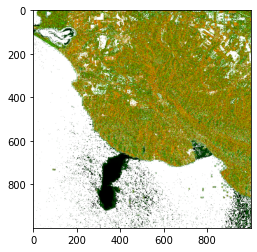

In [7]:
if len(contours) > 0:
    # Превращаем цветную картинку в список для передачи через json:
    img2_rgb = cv2.cvtColor(np.uint8(img2), cv2.COLOR_BGR2RGB)
    pil_img2 = Image.fromarray(img2_rgb)
    b = io.BytesIO()
    pil_img2.save(b, 'jpeg')
    pil_img2_bytes = b.getvalue()
    str_img2 = str(base64.b64encode(pil_img2_bytes), encoding='utf-8')#.decode('utf-8')
    plt.imshow(pil_img2)
    plt.axis("on")
    plt.show()

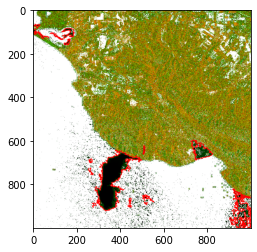

In [8]:
if len(contours) > 0:
    # Превращаем цветную картинку с нанесенными контурами в список для передачи через json:
    resImg_rgb = cv2.cvtColor(np.uint8(resImg), cv2.COLOR_BGR2RGB)
    pil_resImg_rgb = Image.fromarray(resImg_rgb)
    b = io.BytesIO()
    pil_resImg_rgb.save(b, 'jpeg')
    pil_resImg_rgb_bytes = b.getvalue()
    str_resImg_rgb = str(base64.b64encode(pil_resImg_rgb_bytes), encoding='utf-8')#.decode('utf-8')
    plt.imshow(pil_resImg_rgb)
    plt.axis("on")
    plt.show()

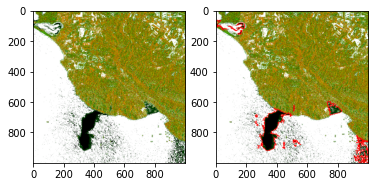

In [9]:
# Построим все картинки вместе:
if len(contours) > 0:
    # Превращаем цветную картинку в список для передачи через json:
    img2_rgb = cv2.cvtColor(np.uint8(img2), cv2.COLOR_BGR2RGB)
    pil_img2 = Image.fromarray(img2_rgb)
    b = io.BytesIO()
    pil_img2.save(b, 'jpeg')
    pil_img2_bytes = b.getvalue()
    str_img2 = str(base64.b64encode(pil_img2_bytes), encoding='utf-8')#.decode('utf-8')
    
    # Превращаем цветную картинку с нанесенными контурами в список для передачи через json:
    resImg_rgb = cv2.cvtColor(np.uint8(resImg), cv2.COLOR_BGR2RGB)
    pil_resImg_rgb = Image.fromarray(resImg_rgb)
    b = io.BytesIO()
    pil_resImg_rgb.save(b, 'jpeg')
    pil_resImg_rgb_bytes = b.getvalue()
    str_resImg_rgb = str(base64.b64encode(pil_resImg_rgb_bytes), encoding='utf-8')#.decode('utf-8')
    
    # Выводим на экран все три картинки:
    plt.subplot(1,2,1)
    plt.imshow(pil_img2)
    plt.subplot(1,2,2)
    plt.imshow(pil_resImg_rgb)
    plt.axis("on")
    plt.show()